In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
#import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import shutil

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import logging
from skimage.io import imread
#from torchviz import make_dot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from torch.autograd import Variable
from torch.optim import *
from scipy.io import loadmat, savemat
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, ConcatDataset, DataLoader, SubsetRandomSampler
#import torchio as tio
from torch.utils.tensorboard import SummaryWriter

import matplotlib.cm as cm
import matplotlib.animation as animation
#import plotly.graph_objects as go
#import plotly.io as pio
#pio.renderers.default = "notebook"
import math

from utils.dataset_utils import *
from utils.classifier_utils import *
from utils.neural_networks import *

logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s - %(message)s', datefmt="%Y-%m-%d %H:%M:%S")

In [3]:
info = {}
info["ext"] = "mat"
#info["ext"] = "nii"
dir_path = "../RSNA-BTC-Datasets/train_"+info["ext"]
test_dir_path = "../RSNA-BTC-Datasets/test_"+info["ext"]
tumor_only_dir_path = "../RSNA-BTC-Datasets/ec_train_"+info["ext"]
tumor_only_test_dir_path = "../RSNA-BTC-Datasets/ec_test_"+info["ext"]
no_tumor_dir_path = "../RSNA-BTC-Datasets/no_tumor_train_"+info["ext"]
ext_test_1_dir_path = "../RSNA-BTC-Datasets/brats18_"+info["ext"]
ext_test_0_dir_path = "../RSNA-BTC-Datasets/OpenNeuroDS000221_ss_"+info["ext"]
new_dir_path = "../RSNA-BTC-Datasets/UPENN-GBM_"+info["ext"]

In [7]:
chosen_net  = "sim" #3du, sim, alt, tun
if chosen_net == "alt":
    info["dims"] = 2 #3,2
    info["batch_size"] = 1#8,4,1
    sel_slices = 1 #None,1
elif chosen_net == "tun":
    info["dims"] = 3 #3,2
    info["batch_size"] = 1#8,4,1
    sel_slices = None #None,1
else:
    info["dims"] = 3 #3,2
    info["batch_size"] = 4#8,4,1
    sel_slices = None #None,1
info["mri_types"] = ["KLF"] #["KLF"] ["FLAIR"] ["T1w"] ["FLAIR", "T2w"]
info["is_depth_wise"] = True
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0001
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.2
info["is_internal_dataset"] = True
# Train and Val Origin:
# - m: Competition training or validation set
# - M: Competition training and validation set
# - f: Competition (tumor only) training or validation set
# - F: Competition (tumor only) training and validation set
# - t: External training or validation set
# - n: UPENN (tumor only) training or validation set
# - N: UPENN (tumor only) training and validation set
# - fn: Competition (tumor only) + UPENN (tumor only) training or validation
# - FN: Competition (tumor only) + UPENN (tumor only) training and validation
info["train_origin"] = "mn"
info["val_origin"] = "mn"
size = len(info["mri_types"])

"""
chosen_net  = "alt" #3du
info["dims"] = 2
info["mri_types"] = ["KLF"]
info["batch_size"] = 1#8
info["is_depth_wise"] = True
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0005
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.2
info["is_internal_dataset"] = True
size = len(info["mri_types"])
sel_slices = 1
"""

"""
chosen_net  = "eff" #3du
info["dims"] = 3
info["mri_types"] = ["FLAIR"]
info["batch_size"] = 4#8
info["is_depth_wise"] = False
info["is_transformed"] = False
transform = None
info["output_size"] = 1
info["is_multistep"] = True
info["lr"] = 0.0005
info["is_adam"] = True
info["momentum"] = 0.9
info["is_10_fold"] = False
info["val_total_ratio"] = 0.1
info["is_internal_dataset"] = True
size = len(info["mri_types"])
sel_slices = None
"""
print(info)

{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': True, 'is_transformed': False, 'output_size': 1, 'is_multistep': True, 'lr': 0.0001, 'is_adam': True, 'momentum': 0.9, 'is_10_fold': False, 'val_total_ratio': 0.2, 'is_internal_dataset': True, 'train_origin': 'mn', 'val_origin': 'mn'}


-- FOLD N:0
Train origin: m
Type: KLF
2022-08-22 13:58:11 - (M0) Train/Val datasets size: 270
2022-08-22 13:58:11 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccae7820>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc2510d0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 118, 120, 121, 122, 123, 125, 127

  0%|                                                   | 0/100 [00:00<?, ?it/s]

2022-08-22 13:59:17 - EPOCH: 1
2022-08-22 13:59:19 - Train Step 10/121, train_loss: 0.7098
2022-08-22 13:59:21 - Train Step 20/121, train_loss: 0.6972
2022-08-22 13:59:23 - Train Step 30/121, train_loss: 0.7024
2022-08-22 13:59:25 - Train Step 40/121, train_loss: 0.6997
2022-08-22 13:59:27 - Train Step 50/121, train_loss: 0.7037
2022-08-22 13:59:28 - Train Step 60/121, train_loss: 0.6999
2022-08-22 13:59:30 - Train Step 70/121, train_loss: 0.6981
2022-08-22 13:59:32 - Train Step 80/121, train_loss: 0.6977
2022-08-22 13:59:34 - Train Step 90/121, train_loss: 0.6993
2022-08-22 13:59:36 - Train Step 100/121, train_loss: 0.6965
2022-08-22 13:59:38 - Train Step 110/121, train_loss: 0.7000
2022-08-22 13:59:40 - Train Step 120/121, train_loss: 0.6980
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 13:59:41 - Valid Step 5/31, valid_loss: 0.6638
2022-08-22 13:59:42 - Valid Step 10/31, valid_loss: 0.6990
2022-08-22 13:59:43 - Valid Step 15/31, valid_loss: 0.7026
2022-08-22 13:59:44 

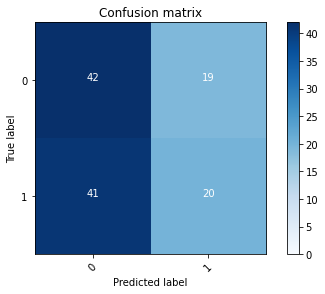

2022-08-22 13:59:46 - [Epoch Train: 1] loss: 0.6983, auc: 0.5086, acc: 0.5103, time: 22.00 s            
2022-08-22 13:59:46 - [Epoch Valid: 1] loss: 0.6883, auc: 0.5646, acc: 0.5082, time: 5.00 s
2022-08-22 13:59:46 - acc improved from 0.0000 to 0.5082. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.688-acc0.508-auc0.565.pth'


  1%|▍                                          | 1/100 [00:28<47:22, 28.71s/it]

2022-08-22 13:59:46 - EPOCH: 2
2022-08-22 13:59:48 - Train Step 10/121, train_loss: 0.6757
2022-08-22 13:59:49 - Train Step 20/121, train_loss: 0.6647
2022-08-22 13:59:51 - Train Step 30/121, train_loss: 0.6624
2022-08-22 13:59:53 - Train Step 40/121, train_loss: 0.6614
2022-08-22 13:59:55 - Train Step 50/121, train_loss: 0.6546
2022-08-22 13:59:57 - Train Step 60/121, train_loss: 0.6555
2022-08-22 13:59:58 - Train Step 70/121, train_loss: 0.6568
2022-08-22 14:00:00 - Train Step 80/121, train_loss: 0.6549
2022-08-22 14:00:02 - Train Step 90/121, train_loss: 0.6527
2022-08-22 14:00:04 - Train Step 100/121, train_loss: 0.6521
2022-08-22 14:00:05 - Train Step 110/121, train_loss: 0.6484
2022-08-22 14:00:07 - Train Step 120/121, train_loss: 0.6516
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:00:09 - Valid Step 5/31, valid_loss: 0.6933
2022-08-22 14:00:09 - Valid Step 10/31, valid_loss: 0.6678
2022-08-22 14:00:11 - Valid Step 15/31, valid_loss: 0.6926
2022-08-22 14:00:11 

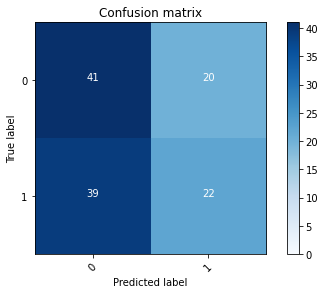

2022-08-22 14:00:14 - [Epoch Train: 2] loss: 0.6516, auc: 0.6959, acc: 0.6405, time: 21.00 s            
2022-08-22 14:00:14 - [Epoch Valid: 2] loss: 0.6955, auc: 0.5716, acc: 0.5164, time: 6.00 s
2022-08-22 14:00:14 - acc improved from 0.5082 to 0.5164. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.696-acc0.516-auc0.572.pth'


  2%|▊                                          | 2/100 [00:56<46:05, 28.22s/it]

2022-08-22 14:00:14 - EPOCH: 3
2022-08-22 14:00:16 - Train Step 10/121, train_loss: 0.6335
2022-08-22 14:00:18 - Train Step 20/121, train_loss: 0.6141
2022-08-22 14:00:20 - Train Step 30/121, train_loss: 0.5984
2022-08-22 14:00:22 - Train Step 40/121, train_loss: 0.6048
2022-08-22 14:00:24 - Train Step 50/121, train_loss: 0.5944
2022-08-22 14:00:25 - Train Step 60/121, train_loss: 0.5982
2022-08-22 14:00:27 - Train Step 70/121, train_loss: 0.5961
2022-08-22 14:00:29 - Train Step 80/121, train_loss: 0.5948
2022-08-22 14:00:31 - Train Step 90/121, train_loss: 0.5953
2022-08-22 14:00:33 - Train Step 100/121, train_loss: 0.6024
2022-08-22 14:00:35 - Train Step 110/121, train_loss: 0.5960
2022-08-22 14:00:37 - Train Step 120/121, train_loss: 0.5996
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:00:39 - Valid Step 5/31, valid_loss: 0.7507
2022-08-22 14:00:40 - Valid Step 10/31, valid_loss: 0.6989
2022-08-22 14:00:41 - Valid Step 15/31, valid_loss: 0.6937
2022-08-22 14:00:42 

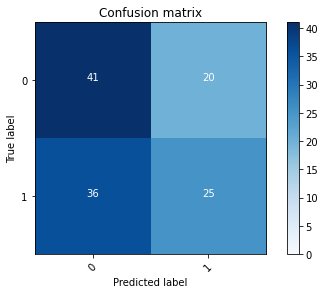

2022-08-22 14:00:44 - [Epoch Train: 3] loss: 0.6000, auc: 0.7742, acc: 0.7107, time: 24.00 s            
2022-08-22 14:00:44 - [Epoch Valid: 3] loss: 0.7131, auc: 0.5394, acc: 0.5410, time: 6.00 s
2022-08-22 14:00:44 - acc improved from 0.5164 to 0.5410. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.713-acc0.541-auc0.539.pth'


  3%|█▎                                         | 3/100 [01:26<47:11, 29.19s/it]

2022-08-22 14:00:44 - EPOCH: 4
2022-08-22 14:00:46 - Train Step 10/121, train_loss: 0.4501
2022-08-22 14:00:48 - Train Step 20/121, train_loss: 0.4964
2022-08-22 14:00:50 - Train Step 30/121, train_loss: 0.5241
2022-08-22 14:00:52 - Train Step 40/121, train_loss: 0.5161
2022-08-22 14:00:54 - Train Step 50/121, train_loss: 0.5177
2022-08-22 14:00:56 - Train Step 60/121, train_loss: 0.5175
2022-08-22 14:00:58 - Train Step 70/121, train_loss: 0.5221
2022-08-22 14:01:00 - Train Step 80/121, train_loss: 0.5115
2022-08-22 14:01:01 - Train Step 90/121, train_loss: 0.5115
2022-08-22 14:01:03 - Train Step 100/121, train_loss: 0.5155
2022-08-22 14:01:05 - Train Step 110/121, train_loss: 0.5123
2022-08-22 14:01:07 - Train Step 120/121, train_loss: 0.5121
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:01:09 - Valid Step 5/31, valid_loss: 0.6474
2022-08-22 14:01:10 - Valid Step 10/31, valid_loss: 0.6985
2022-08-22 14:01:11 - Valid Step 15/31, valid_loss: 0.6678
2022-08-22 14:01:11 

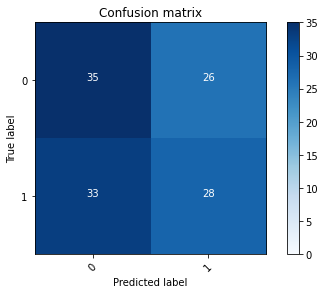

2022-08-22 14:01:14 - [Epoch Train: 4] loss: 0.5140, auc: 0.8700, acc: 0.7893, time: 23.00 s            
2022-08-22 14:01:14 - [Epoch Valid: 4] loss: 0.7439, auc: 0.5313, acc: 0.5164, time: 6.00 s


  4%|█▋                                         | 4/100 [01:56<47:06, 29.44s/it]

2022-08-22 14:01:14 - EPOCH: 5
2022-08-22 14:01:16 - Train Step 10/121, train_loss: 0.4277
2022-08-22 14:01:18 - Train Step 20/121, train_loss: 0.4163
2022-08-22 14:01:20 - Train Step 30/121, train_loss: 0.4076
2022-08-22 14:01:22 - Train Step 40/121, train_loss: 0.4238
2022-08-22 14:01:24 - Train Step 50/121, train_loss: 0.4250
2022-08-22 14:01:25 - Train Step 60/121, train_loss: 0.4194
2022-08-22 14:01:27 - Train Step 70/121, train_loss: 0.4119
2022-08-22 14:01:29 - Train Step 80/121, train_loss: 0.4096
2022-08-22 14:01:31 - Train Step 90/121, train_loss: 0.4026
2022-08-22 14:01:33 - Train Step 100/121, train_loss: 0.4178
2022-08-22 14:01:35 - Train Step 110/121, train_loss: 0.4136
2022-08-22 14:01:37 - Train Step 120/121, train_loss: 0.4146
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:01:39 - Valid Step 5/31, valid_loss: 0.8018
2022-08-22 14:01:40 - Valid Step 10/31, valid_loss: 0.7725
2022-08-22 14:01:41 - Valid Step 15/31, valid_loss: 0.7668
2022-08-22 14:01:41 

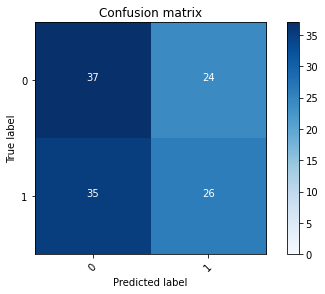

2022-08-22 14:01:43 - [Epoch Train: 5] loss: 0.4150, auc: 0.9333, acc: 0.8574, time: 23.00 s            
2022-08-22 14:01:43 - [Epoch Valid: 5] loss: 0.7802, auc: 0.5060, acc: 0.5164, time: 5.00 s


  5%|██▏                                        | 5/100 [02:26<46:45, 29.53s/it]

2022-08-22 14:01:43 - EPOCH: 6
2022-08-22 14:01:45 - Train Step 10/121, train_loss: 0.2980
2022-08-22 14:01:47 - Train Step 20/121, train_loss: 0.2983
2022-08-22 14:01:49 - Train Step 30/121, train_loss: 0.3016
2022-08-22 14:01:51 - Train Step 40/121, train_loss: 0.2984
2022-08-22 14:01:53 - Train Step 50/121, train_loss: 0.2935
2022-08-22 14:01:55 - Train Step 60/121, train_loss: 0.2825
2022-08-22 14:01:57 - Train Step 70/121, train_loss: 0.2793
2022-08-22 14:01:59 - Train Step 80/121, train_loss: 0.2707
2022-08-22 14:02:01 - Train Step 90/121, train_loss: 0.2695
2022-08-22 14:02:03 - Train Step 100/121, train_loss: 0.2853
2022-08-22 14:02:05 - Train Step 110/121, train_loss: 0.2820
2022-08-22 14:02:07 - Train Step 120/121, train_loss: 0.2790
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:02:08 - Valid Step 5/31, valid_loss: 1.2678
2022-08-22 14:02:09 - Valid Step 10/31, valid_loss: 1.0378
2022-08-22 14:02:10 - Valid Step 15/31, valid_loss: 0.9477
2022-08-22 14:02:11 

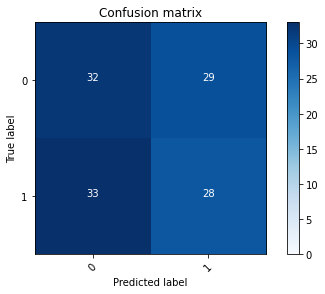

2022-08-22 14:02:13 - [Epoch Train: 6] loss: 0.2780, auc: 0.9789, acc: 0.9277, time: 23.00 s            
2022-08-22 14:02:13 - [Epoch Valid: 6] loss: 0.8348, auc: 0.5270, acc: 0.4918, time: 6.00 s


  6%|██▌                                        | 6/100 [02:55<46:13, 29.50s/it]

2022-08-22 14:02:13 - EPOCH: 7
2022-08-22 14:02:15 - Train Step 10/121, train_loss: 0.1912
2022-08-22 14:02:17 - Train Step 20/121, train_loss: 0.1919
2022-08-22 14:02:18 - Train Step 30/121, train_loss: 0.1838
2022-08-22 14:02:20 - Train Step 40/121, train_loss: 0.1853
2022-08-22 14:02:22 - Train Step 50/121, train_loss: 0.1787
2022-08-22 14:02:23 - Train Step 60/121, train_loss: 0.1795
2022-08-22 14:02:25 - Train Step 70/121, train_loss: 0.1801
2022-08-22 14:02:27 - Train Step 80/121, train_loss: 0.1755
2022-08-22 14:02:29 - Train Step 90/121, train_loss: 0.1803
2022-08-22 14:02:30 - Train Step 100/121, train_loss: 0.1822
2022-08-22 14:02:32 - Train Step 110/121, train_loss: 0.1854
2022-08-22 14:02:34 - Train Step 120/121, train_loss: 0.1828
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:02:36 - Valid Step 5/31, valid_loss: 0.7064
2022-08-22 14:02:36 - Valid Step 10/31, valid_loss: 0.9340
2022-08-22 14:02:37 - Valid Step 15/31, valid_loss: 0.9807
2022-08-22 14:02:38 

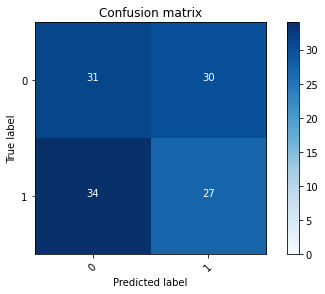

2022-08-22 14:02:40 - [Epoch Train: 7] loss: 0.1847, auc: 0.9951, acc: 0.9587, time: 21.00 s            
2022-08-22 14:02:40 - [Epoch Valid: 7] loss: 0.9293, auc: 0.5036, acc: 0.4754, time: 6.00 s


  7%|███                                        | 7/100 [03:23<44:45, 28.88s/it]

2022-08-22 14:02:40 - EPOCH: 8
2022-08-22 14:02:43 - Train Step 10/121, train_loss: 0.1167
2022-08-22 14:02:44 - Train Step 20/121, train_loss: 0.1336
2022-08-22 14:02:46 - Train Step 30/121, train_loss: 0.1271
2022-08-22 14:02:48 - Train Step 40/121, train_loss: 0.1207
2022-08-22 14:02:50 - Train Step 50/121, train_loss: 0.1182
2022-08-22 14:02:52 - Train Step 60/121, train_loss: 0.1105
2022-08-22 14:02:54 - Train Step 70/121, train_loss: 0.1081
2022-08-22 14:02:56 - Train Step 80/121, train_loss: 0.1039
2022-08-22 14:02:58 - Train Step 90/121, train_loss: 0.1049
2022-08-22 14:02:59 - Train Step 100/121, train_loss: 0.1080
2022-08-22 14:03:01 - Train Step 110/121, train_loss: 0.1075
2022-08-22 14:03:03 - Train Step 120/121, train_loss: 0.1047
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:03:04 - Valid Step 5/31, valid_loss: 1.1103
2022-08-22 14:03:05 - Valid Step 10/31, valid_loss: 1.0942
2022-08-22 14:03:06 - Valid Step 15/31, valid_loss: 0.9550
2022-08-22 14:03:07 

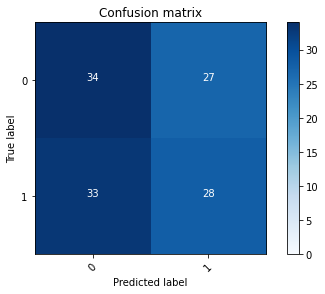

2022-08-22 14:03:09 - [Epoch Train: 8] loss: 0.1050, auc: 0.9997, acc: 0.9897, time: 22.00 s            
2022-08-22 14:03:09 - [Epoch Valid: 8] loss: 1.0144, auc: 0.5114, acc: 0.5082, time: 6.00 s


  8%|███▍                                       | 8/100 [03:52<44:13, 28.84s/it]

2022-08-22 14:03:09 - EPOCH: 9
2022-08-22 14:03:11 - Train Step 10/121, train_loss: 0.0771
2022-08-22 14:03:13 - Train Step 20/121, train_loss: 0.0801
2022-08-22 14:03:15 - Train Step 30/121, train_loss: 0.0751
2022-08-22 14:03:17 - Train Step 40/121, train_loss: 0.0732
2022-08-22 14:03:19 - Train Step 50/121, train_loss: 0.0739
2022-08-22 14:03:21 - Train Step 60/121, train_loss: 0.0688
2022-08-22 14:03:23 - Train Step 70/121, train_loss: 0.0668
2022-08-22 14:03:25 - Train Step 80/121, train_loss: 0.0672
2022-08-22 14:03:27 - Train Step 90/121, train_loss: 0.0664
2022-08-22 14:03:29 - Train Step 100/121, train_loss: 0.0657
2022-08-22 14:03:30 - Train Step 110/121, train_loss: 0.0631
2022-08-22 14:03:32 - Train Step 120/121, train_loss: 0.0618
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:03:34 - Valid Step 5/31, valid_loss: 1.0960
2022-08-22 14:03:34 - Valid Step 10/31, valid_loss: 1.0182
2022-08-22 14:03:35 - Valid Step 15/31, valid_loss: 1.1583
2022-08-22 14:03:36 

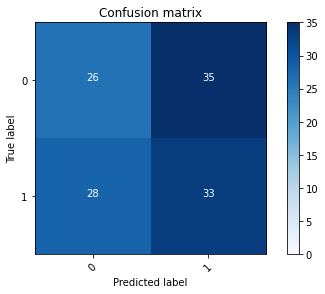

2022-08-22 14:03:39 - [Epoch Train: 9] loss: 0.0616, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:03:39 - [Epoch Valid: 9] loss: 1.1970, auc: 0.5109, acc: 0.4836, time: 6.00 s


  9%|███▊                                       | 9/100 [04:21<43:57, 28.99s/it]

2022-08-22 14:03:39 - EPOCH: 10
2022-08-22 14:03:41 - Train Step 10/121, train_loss: 0.0260
2022-08-22 14:03:42 - Train Step 20/121, train_loss: 0.0316
2022-08-22 14:03:44 - Train Step 30/121, train_loss: 0.0339
2022-08-22 14:03:46 - Train Step 40/121, train_loss: 0.0343
2022-08-22 14:03:48 - Train Step 50/121, train_loss: 0.0379
2022-08-22 14:03:49 - Train Step 60/121, train_loss: 0.0375
2022-08-22 14:03:51 - Train Step 70/121, train_loss: 0.0359
2022-08-22 14:03:53 - Train Step 80/121, train_loss: 0.0390
2022-08-22 14:03:55 - Train Step 90/121, train_loss: 0.0378
2022-08-22 14:03:57 - Train Step 100/121, train_loss: 0.0393
2022-08-22 14:03:59 - Train Step 110/121, train_loss: 0.0387
2022-08-22 14:04:00 - Train Step 120/121, train_loss: 0.0386
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:04:02 - Valid Step 5/31, valid_loss: 1.3939
2022-08-22 14:04:03 - Valid Step 10/31, valid_loss: 1.1894
2022-08-22 14:04:04 - Valid Step 15/31, valid_loss: 1.1441
2022-08-22 14:04:05

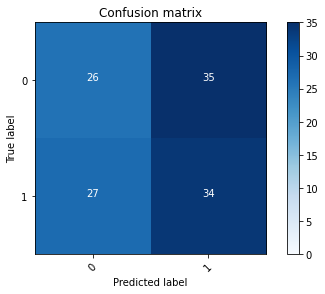

2022-08-22 14:04:07 - [Epoch Train: 10] loss: 0.0384, auc: 1.0000, acc: 0.9979, time: 21.00 s            
2022-08-22 14:04:07 - [Epoch Valid: 10] loss: 1.3121, auc: 0.5098, acc: 0.4918, time: 6.00 s


 10%|████▏                                     | 10/100 [04:49<43:10, 28.78s/it]

2022-08-22 14:04:07 - EPOCH: 11
2022-08-22 14:04:09 - Train Step 10/121, train_loss: 0.0225
2022-08-22 14:04:11 - Train Step 20/121, train_loss: 0.0237
2022-08-22 14:04:13 - Train Step 30/121, train_loss: 0.0318
2022-08-22 14:04:15 - Train Step 40/121, train_loss: 0.0301
2022-08-22 14:04:17 - Train Step 50/121, train_loss: 0.0282
2022-08-22 14:04:19 - Train Step 60/121, train_loss: 0.0269
2022-08-22 14:04:21 - Train Step 70/121, train_loss: 0.0263
2022-08-22 14:04:23 - Train Step 80/121, train_loss: 0.0258
2022-08-22 14:04:24 - Train Step 90/121, train_loss: 0.0249
2022-08-22 14:04:26 - Train Step 100/121, train_loss: 0.0248
2022-08-22 14:04:28 - Train Step 110/121, train_loss: 0.0249
2022-08-22 14:04:30 - Train Step 120/121, train_loss: 0.0243
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:04:32 - Valid Step 5/31, valid_loss: 1.2222
2022-08-22 14:04:33 - Valid Step 10/31, valid_loss: 0.9373
2022-08-22 14:04:34 - Valid Step 15/31, valid_loss: 1.2000
2022-08-22 14:04:35

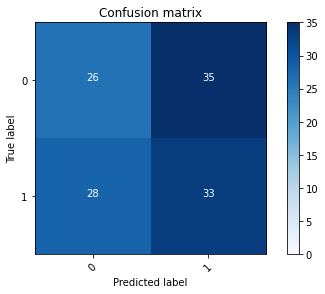

2022-08-22 14:04:37 - [Epoch Train: 11] loss: 0.0243, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:04:37 - [Epoch Valid: 11] loss: 1.3464, auc: 0.5093, acc: 0.4836, time: 6.00 s


 11%|████▌                                     | 11/100 [05:20<43:21, 29.23s/it]

2022-08-22 14:04:37 - EPOCH: 12
2022-08-22 14:04:39 - Train Step 10/121, train_loss: 0.0321
2022-08-22 14:04:41 - Train Step 20/121, train_loss: 0.0239
2022-08-22 14:04:43 - Train Step 30/121, train_loss: 0.0226
2022-08-22 14:04:45 - Train Step 40/121, train_loss: 0.0214
2022-08-22 14:04:47 - Train Step 50/121, train_loss: 0.0205
2022-08-22 14:04:49 - Train Step 60/121, train_loss: 0.0191
2022-08-22 14:04:51 - Train Step 70/121, train_loss: 0.0204
2022-08-22 14:04:52 - Train Step 80/121, train_loss: 0.0212
2022-08-22 14:04:54 - Train Step 90/121, train_loss: 0.0214
2022-08-22 14:04:56 - Train Step 100/121, train_loss: 0.0210
2022-08-22 14:04:58 - Train Step 110/121, train_loss: 0.0207
2022-08-22 14:05:00 - Train Step 120/121, train_loss: 0.0225
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:05:01 - Valid Step 5/31, valid_loss: 1.0905
2022-08-22 14:05:02 - Valid Step 10/31, valid_loss: 1.4506
2022-08-22 14:05:04 - Valid Step 15/31, valid_loss: 1.2329
2022-08-22 14:05:05

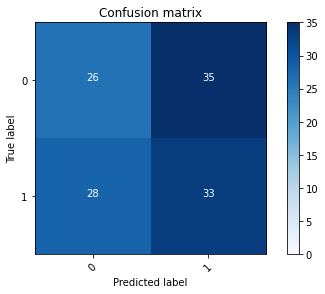

2022-08-22 14:05:07 - [Epoch Train: 12] loss: 0.0225, auc: 1.0000, acc: 0.9979, time: 22.00 s            
2022-08-22 14:05:07 - [Epoch Valid: 12] loss: 1.3244, auc: 0.5101, acc: 0.4836, time: 7.00 s


 12%|█████                                     | 12/100 [05:50<43:23, 29.59s/it]

2022-08-22 14:05:07 - EPOCH: 13
2022-08-22 14:05:10 - Train Step 10/121, train_loss: 0.0365
2022-08-22 14:05:12 - Train Step 20/121, train_loss: 0.0258
2022-08-22 14:05:13 - Train Step 30/121, train_loss: 0.0211
2022-08-22 14:05:15 - Train Step 40/121, train_loss: 0.0215
2022-08-22 14:05:17 - Train Step 50/121, train_loss: 0.0213
2022-08-22 14:05:19 - Train Step 60/121, train_loss: 0.0209
2022-08-22 14:05:21 - Train Step 70/121, train_loss: 0.0199
2022-08-22 14:05:23 - Train Step 80/121, train_loss: 0.0197
2022-08-22 14:05:25 - Train Step 90/121, train_loss: 0.0190
2022-08-22 14:05:27 - Train Step 100/121, train_loss: 0.0187
2022-08-22 14:05:29 - Train Step 110/121, train_loss: 0.0183
2022-08-22 14:05:31 - Train Step 120/121, train_loss: 0.0176
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:05:32 - Valid Step 5/31, valid_loss: 1.7071
2022-08-22 14:05:33 - Valid Step 10/31, valid_loss: 1.3144
2022-08-22 14:05:34 - Valid Step 15/31, valid_loss: 1.3399
2022-08-22 14:05:35

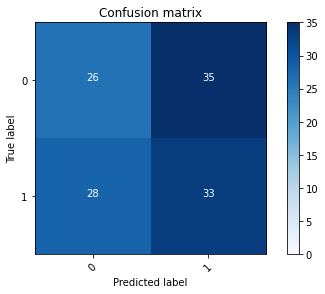

2022-08-22 14:05:37 - [Epoch Train: 13] loss: 0.0175, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 14:05:37 - [Epoch Valid: 13] loss: 1.4427, auc: 0.5085, acc: 0.4836, time: 6.00 s


 13%|█████▍                                    | 13/100 [06:20<43:01, 29.67s/it]

2022-08-22 14:05:37 - EPOCH: 14
2022-08-22 14:05:40 - Train Step 10/121, train_loss: 0.0123
2022-08-22 14:05:41 - Train Step 20/121, train_loss: 0.0141
2022-08-22 14:05:43 - Train Step 30/121, train_loss: 0.0131
2022-08-22 14:05:45 - Train Step 40/121, train_loss: 0.0127
2022-08-22 14:05:47 - Train Step 50/121, train_loss: 0.0123
2022-08-22 14:05:49 - Train Step 60/121, train_loss: 0.0118
2022-08-22 14:05:51 - Train Step 70/121, train_loss: 0.0127
2022-08-22 14:05:53 - Train Step 80/121, train_loss: 0.0123
2022-08-22 14:05:55 - Train Step 90/121, train_loss: 0.0120
2022-08-22 14:05:57 - Train Step 100/121, train_loss: 0.0133
2022-08-22 14:05:59 - Train Step 110/121, train_loss: 0.0129
2022-08-22 14:06:01 - Train Step 120/121, train_loss: 0.0127
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:06:02 - Valid Step 5/31, valid_loss: 1.4477
2022-08-22 14:06:03 - Valid Step 10/31, valid_loss: 1.5754
2022-08-22 14:06:04 - Valid Step 15/31, valid_loss: 1.4363
2022-08-22 14:06:05

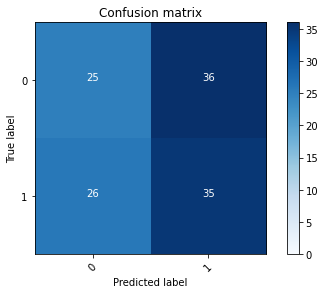

2022-08-22 14:06:07 - [Epoch Train: 14] loss: 0.0128, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 14:06:07 - [Epoch Valid: 14] loss: 1.4263, auc: 0.5098, acc: 0.4918, time: 6.00 s


 14%|█████▉                                    | 14/100 [06:50<42:41, 29.78s/it]

2022-08-22 14:06:07 - EPOCH: 15
2022-08-22 14:06:10 - Train Step 10/121, train_loss: 0.0195
2022-08-22 14:06:12 - Train Step 20/121, train_loss: 0.0190
2022-08-22 14:06:14 - Train Step 30/121, train_loss: 0.0159
2022-08-22 14:06:15 - Train Step 40/121, train_loss: 0.0148
2022-08-22 14:06:17 - Train Step 50/121, train_loss: 0.0142
2022-08-22 14:06:19 - Train Step 60/121, train_loss: 0.0134
2022-08-22 14:06:21 - Train Step 70/121, train_loss: 0.0127
2022-08-22 14:06:23 - Train Step 80/121, train_loss: 0.0122
2022-08-22 14:06:25 - Train Step 90/121, train_loss: 0.0125
2022-08-22 14:06:27 - Train Step 100/121, train_loss: 0.0120
2022-08-22 14:06:29 - Train Step 110/121, train_loss: 0.0116
2022-08-22 14:06:31 - Train Step 120/121, train_loss: 0.0114
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:06:33 - Valid Step 5/31, valid_loss: 1.9861
2022-08-22 14:06:34 - Valid Step 10/31, valid_loss: 1.7153
2022-08-22 14:06:35 - Valid Step 15/31, valid_loss: 1.7346
2022-08-22 14:06:36

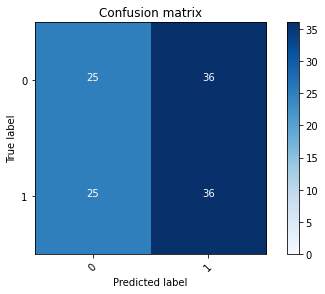

2022-08-22 14:06:38 - [Epoch Train: 15] loss: 0.0113, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 14:06:38 - [Epoch Valid: 15] loss: 1.5120, auc: 0.5069, acc: 0.5000, time: 6.00 s


 15%|██████▎                                   | 15/100 [07:21<42:31, 30.02s/it]

2022-08-22 14:06:38 - EPOCH: 16
2022-08-22 14:06:40 - Train Step 10/121, train_loss: 0.0320
2022-08-22 14:06:42 - Train Step 20/121, train_loss: 0.0195
2022-08-22 14:06:44 - Train Step 30/121, train_loss: 0.0168
2022-08-22 14:06:46 - Train Step 40/121, train_loss: 0.0150
2022-08-22 14:06:48 - Train Step 50/121, train_loss: 0.0136
2022-08-22 14:06:50 - Train Step 60/121, train_loss: 0.0125
2022-08-22 14:06:52 - Train Step 70/121, train_loss: 0.0117
2022-08-22 14:06:54 - Train Step 80/121, train_loss: 0.0132
2022-08-22 14:06:56 - Train Step 90/121, train_loss: 0.0125
2022-08-22 14:06:58 - Train Step 100/121, train_loss: 0.0123
2022-08-22 14:07:00 - Train Step 110/121, train_loss: 0.0118
2022-08-22 14:07:01 - Train Step 120/121, train_loss: 0.0113
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:07:03 - Valid Step 5/31, valid_loss: 1.7648
2022-08-22 14:07:04 - Valid Step 10/31, valid_loss: 1.6677
2022-08-22 14:07:05 - Valid Step 15/31, valid_loss: 1.4389
2022-08-22 14:07:06

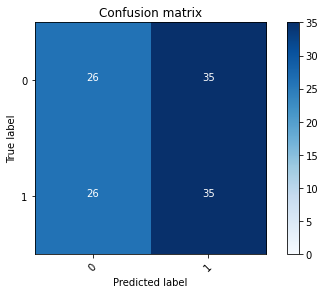

2022-08-22 14:07:08 - [Epoch Train: 16] loss: 0.0115, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:07:08 - [Epoch Valid: 16] loss: 1.5257, auc: 0.5095, acc: 0.5000, time: 6.00 s


 16%|██████▋                                   | 16/100 [07:51<42:06, 30.07s/it]

2022-08-22 14:07:08 - EPOCH: 17
2022-08-22 14:07:10 - Train Step 10/121, train_loss: 0.0077
2022-08-22 14:07:12 - Train Step 20/121, train_loss: 0.0156
2022-08-22 14:07:14 - Train Step 30/121, train_loss: 0.0131
2022-08-22 14:07:16 - Train Step 40/121, train_loss: 0.0122
2022-08-22 14:07:18 - Train Step 50/121, train_loss: 0.0110
2022-08-22 14:07:20 - Train Step 60/121, train_loss: 0.0107
2022-08-22 14:07:22 - Train Step 70/121, train_loss: 0.0103
2022-08-22 14:07:24 - Train Step 80/121, train_loss: 0.0100
2022-08-22 14:07:26 - Train Step 90/121, train_loss: 0.0097
2022-08-22 14:07:28 - Train Step 100/121, train_loss: 0.0099
2022-08-22 14:07:30 - Train Step 110/121, train_loss: 0.0095
2022-08-22 14:07:32 - Train Step 120/121, train_loss: 0.0126
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:07:33 - Valid Step 5/31, valid_loss: 2.3223
2022-08-22 14:07:34 - Valid Step 10/31, valid_loss: 1.8767
2022-08-22 14:07:35 - Valid Step 15/31, valid_loss: 1.7464
2022-08-22 14:07:36

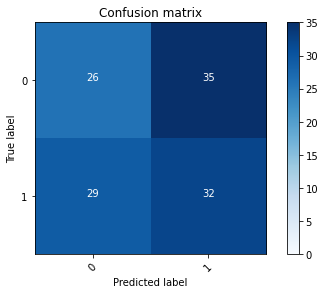

2022-08-22 14:07:38 - [Epoch Train: 17] loss: 0.0126, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:07:38 - [Epoch Valid: 17] loss: 1.6171, auc: 0.5114, acc: 0.4754, time: 6.00 s


 17%|███████▏                                  | 17/100 [08:21<41:36, 30.08s/it]

2022-08-22 14:07:38 - EPOCH: 18
2022-08-22 14:07:40 - Train Step 10/121, train_loss: 0.0074
2022-08-22 14:07:42 - Train Step 20/121, train_loss: 0.0069
2022-08-22 14:07:45 - Train Step 30/121, train_loss: 0.0063
2022-08-22 14:07:46 - Train Step 40/121, train_loss: 0.0106
2022-08-22 14:07:49 - Train Step 50/121, train_loss: 0.0095
2022-08-22 14:07:51 - Train Step 60/121, train_loss: 0.0092
2022-08-22 14:07:52 - Train Step 70/121, train_loss: 0.0086
2022-08-22 14:07:54 - Train Step 80/121, train_loss: 0.0083
2022-08-22 14:07:56 - Train Step 90/121, train_loss: 0.0095
2022-08-22 14:07:58 - Train Step 100/121, train_loss: 0.0093
2022-08-22 14:08:00 - Train Step 110/121, train_loss: 0.0097
2022-08-22 14:08:02 - Train Step 120/121, train_loss: 0.0093
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:08:04 - Valid Step 5/31, valid_loss: 1.4115
2022-08-22 14:08:05 - Valid Step 10/31, valid_loss: 1.7095
2022-08-22 14:08:06 - Valid Step 15/31, valid_loss: 1.9435
2022-08-22 14:08:07

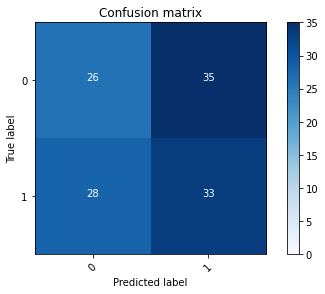

2022-08-22 14:08:09 - [Epoch Train: 18] loss: 0.0092, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:08:09 - [Epoch Valid: 18] loss: 1.6939, auc: 0.5122, acc: 0.4836, time: 6.00 s


 18%|███████▌                                  | 18/100 [08:51<41:15, 30.19s/it]

2022-08-22 14:08:09 - EPOCH: 19
2022-08-22 14:08:11 - Train Step 10/121, train_loss: 0.0055
2022-08-22 14:08:13 - Train Step 20/121, train_loss: 0.0050
2022-08-22 14:08:15 - Train Step 30/121, train_loss: 0.0048
2022-08-22 14:08:17 - Train Step 40/121, train_loss: 0.0052
2022-08-22 14:08:19 - Train Step 50/121, train_loss: 0.0054
2022-08-22 14:08:21 - Train Step 60/121, train_loss: 0.0071
2022-08-22 14:08:23 - Train Step 70/121, train_loss: 0.0071
2022-08-22 14:08:25 - Train Step 80/121, train_loss: 0.0110
2022-08-22 14:08:27 - Train Step 90/121, train_loss: 0.0102
2022-08-22 14:08:29 - Train Step 100/121, train_loss: 0.0095
2022-08-22 14:08:31 - Train Step 110/121, train_loss: 0.0093
2022-08-22 14:08:33 - Train Step 120/121, train_loss: 0.0088
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:08:34 - Valid Step 5/31, valid_loss: 1.9385
2022-08-22 14:08:35 - Valid Step 10/31, valid_loss: 1.5757
2022-08-22 14:08:36 - Valid Step 15/31, valid_loss: 1.5766
2022-08-22 14:08:37

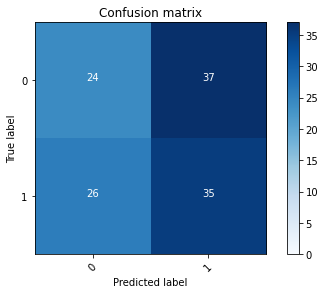

2022-08-22 14:08:39 - [Epoch Train: 19] loss: 0.0089, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:08:39 - [Epoch Valid: 19] loss: 1.6277, auc: 0.5077, acc: 0.4836, time: 6.00 s


 19%|███████▉                                  | 19/100 [09:22<40:53, 30.29s/it]

2022-08-22 14:08:39 - EPOCH: 20
2022-08-22 14:08:41 - Train Step 10/121, train_loss: 0.0048
2022-08-22 14:08:43 - Train Step 20/121, train_loss: 0.0045
2022-08-22 14:08:45 - Train Step 30/121, train_loss: 0.0043
2022-08-22 14:08:47 - Train Step 40/121, train_loss: 0.0043
2022-08-22 14:08:49 - Train Step 50/121, train_loss: 0.0042
2022-08-22 14:08:51 - Train Step 60/121, train_loss: 0.0071
2022-08-22 14:08:53 - Train Step 70/121, train_loss: 0.0095
2022-08-22 14:08:55 - Train Step 80/121, train_loss: 0.0091
2022-08-22 14:08:57 - Train Step 90/121, train_loss: 0.0087
2022-08-22 14:08:58 - Train Step 100/121, train_loss: 0.0084
2022-08-22 14:09:00 - Train Step 110/121, train_loss: 0.0081
2022-08-22 14:09:02 - Train Step 120/121, train_loss: 0.0078
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:09:04 - Valid Step 5/31, valid_loss: 1.7122
2022-08-22 14:09:05 - Valid Step 10/31, valid_loss: 1.5286
2022-08-22 14:09:06 - Valid Step 15/31, valid_loss: 1.5655
2022-08-22 14:09:07

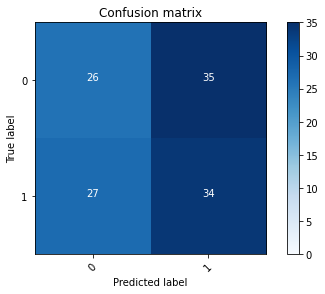

2022-08-22 14:09:09 - [Epoch Train: 20] loss: 0.0078, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:09:09 - [Epoch Valid: 20] loss: 1.6826, auc: 0.5069, acc: 0.4918, time: 6.00 s


 20%|████████▍                                 | 20/100 [09:52<40:15, 30.19s/it]

2022-08-22 14:09:09 - EPOCH: 21
2022-08-22 14:09:11 - Train Step 10/121, train_loss: 0.0045
2022-08-22 14:09:13 - Train Step 20/121, train_loss: 0.0159
2022-08-22 14:09:15 - Train Step 30/121, train_loss: 0.0278
2022-08-22 14:09:17 - Train Step 40/121, train_loss: 0.0220
2022-08-22 14:09:20 - Train Step 50/121, train_loss: 0.0183
2022-08-22 14:09:22 - Train Step 60/121, train_loss: 0.0159
2022-08-22 14:09:24 - Train Step 70/121, train_loss: 0.0143
2022-08-22 14:09:26 - Train Step 80/121, train_loss: 0.0130
2022-08-22 14:09:28 - Train Step 90/121, train_loss: 0.0120
2022-08-22 14:09:30 - Train Step 100/121, train_loss: 0.0113
2022-08-22 14:09:32 - Train Step 110/121, train_loss: 0.0104
2022-08-22 14:09:34 - Train Step 120/121, train_loss: 0.0099
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:09:35 - Valid Step 5/31, valid_loss: 1.5730
2022-08-22 14:09:36 - Valid Step 10/31, valid_loss: 1.5758
2022-08-22 14:09:37 - Valid Step 15/31, valid_loss: 1.7010
2022-08-22 14:09:38

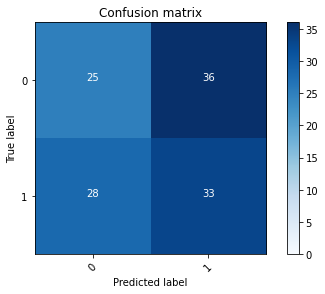

2022-08-22 14:09:41 - [Epoch Train: 21] loss: 0.0099, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:09:41 - [Epoch Valid: 21] loss: 1.7460, auc: 0.5060, acc: 0.4754, time: 6.00 s


 21%|████████▊                                 | 21/100 [10:23<40:12, 30.54s/it]

2022-08-22 14:09:41 - EPOCH: 22
2022-08-22 14:09:43 - Train Step 10/121, train_loss: 0.0031
2022-08-22 14:09:45 - Train Step 20/121, train_loss: 0.0029
2022-08-22 14:09:47 - Train Step 30/121, train_loss: 0.0097
2022-08-22 14:09:48 - Train Step 40/121, train_loss: 0.0084
2022-08-22 14:09:50 - Train Step 50/121, train_loss: 0.0074
2022-08-22 14:09:52 - Train Step 60/121, train_loss: 0.0074
2022-08-22 14:09:54 - Train Step 70/121, train_loss: 0.0067
2022-08-22 14:09:56 - Train Step 80/121, train_loss: 0.0064
2022-08-22 14:09:58 - Train Step 90/121, train_loss: 0.0060
2022-08-22 14:10:00 - Train Step 100/121, train_loss: 0.0070
2022-08-22 14:10:02 - Train Step 110/121, train_loss: 0.0066
2022-08-22 14:10:04 - Train Step 120/121, train_loss: 0.0066
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:10:06 - Valid Step 5/31, valid_loss: 1.5140
2022-08-22 14:10:07 - Valid Step 10/31, valid_loss: 1.7046
2022-08-22 14:10:08 - Valid Step 15/31, valid_loss: 1.6563
2022-08-22 14:10:08

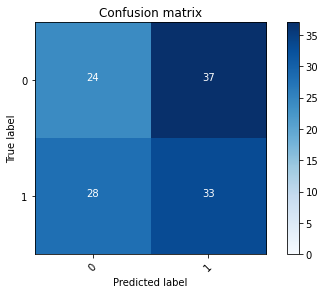

2022-08-22 14:10:11 - [Epoch Train: 22] loss: 0.0066, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:10:11 - [Epoch Valid: 22] loss: 1.6480, auc: 0.5066, acc: 0.4672, time: 6.00 s


 22%|█████████▏                                | 22/100 [10:53<39:34, 30.45s/it]

2022-08-22 14:10:11 - EPOCH: 23
2022-08-22 14:10:13 - Train Step 10/121, train_loss: 0.0032
2022-08-22 14:10:15 - Train Step 20/121, train_loss: 0.0028
2022-08-22 14:10:17 - Train Step 30/121, train_loss: 0.0029
2022-08-22 14:10:19 - Train Step 40/121, train_loss: 0.0029
2022-08-22 14:10:21 - Train Step 50/121, train_loss: 0.0030
2022-08-22 14:10:23 - Train Step 60/121, train_loss: 0.0030
2022-08-22 14:10:25 - Train Step 70/121, train_loss: 0.0029
2022-08-22 14:10:27 - Train Step 80/121, train_loss: 0.0029
2022-08-22 14:10:29 - Train Step 90/121, train_loss: 0.0030
2022-08-22 14:10:30 - Train Step 100/121, train_loss: 0.0030
2022-08-22 14:10:32 - Train Step 110/121, train_loss: 0.0052
2022-08-22 14:10:34 - Train Step 120/121, train_loss: 0.0067
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:10:36 - Valid Step 5/31, valid_loss: 1.8293
2022-08-22 14:10:37 - Valid Step 10/31, valid_loss: 1.8730
2022-08-22 14:10:38 - Valid Step 15/31, valid_loss: 2.0895
2022-08-22 14:10:39

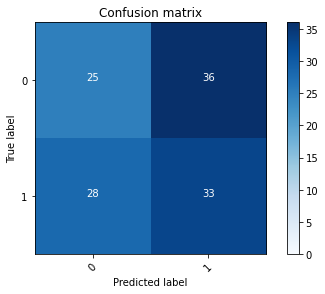

2022-08-22 14:10:41 - [Epoch Train: 23] loss: 0.0068, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:10:41 - [Epoch Valid: 23] loss: 1.7881, auc: 0.5109, acc: 0.4754, time: 6.00 s


 23%|█████████▋                                | 23/100 [11:24<39:01, 30.41s/it]

2022-08-22 14:10:41 - EPOCH: 24
2022-08-22 14:10:43 - Train Step 10/121, train_loss: 0.0021
2022-08-22 14:10:45 - Train Step 20/121, train_loss: 0.0097
2022-08-22 14:10:47 - Train Step 30/121, train_loss: 0.0075
2022-08-22 14:10:49 - Train Step 40/121, train_loss: 0.0062
2022-08-22 14:10:51 - Train Step 50/121, train_loss: 0.0054
2022-08-22 14:10:53 - Train Step 60/121, train_loss: 0.0051
2022-08-22 14:10:55 - Train Step 70/121, train_loss: 0.0075
2022-08-22 14:10:57 - Train Step 80/121, train_loss: 0.0070
2022-08-22 14:10:59 - Train Step 90/121, train_loss: 0.0066
2022-08-22 14:11:01 - Train Step 100/121, train_loss: 0.0062
2022-08-22 14:11:03 - Train Step 110/121, train_loss: 0.0060
2022-08-22 14:11:04 - Train Step 120/121, train_loss: 0.0057
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:11:06 - Valid Step 5/31, valid_loss: 1.8541
2022-08-22 14:11:07 - Valid Step 10/31, valid_loss: 1.9007
2022-08-22 14:11:08 - Valid Step 15/31, valid_loss: 1.7896
2022-08-22 14:11:09

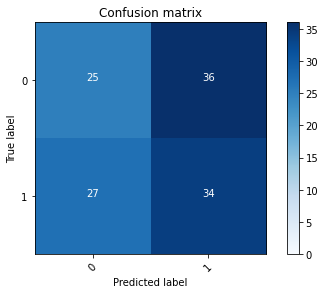

2022-08-22 14:11:11 - [Epoch Train: 24] loss: 0.0057, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:11:11 - [Epoch Valid: 24] loss: 1.8821, auc: 0.5071, acc: 0.4836, time: 6.00 s


 24%|██████████                                | 24/100 [11:54<38:22, 30.30s/it]

2022-08-22 14:11:11 - EPOCH: 25
2022-08-22 14:11:13 - Train Step 10/121, train_loss: 0.0198
2022-08-22 14:11:15 - Train Step 20/121, train_loss: 0.0110
2022-08-22 14:11:17 - Train Step 30/121, train_loss: 0.0080
2022-08-22 14:11:19 - Train Step 40/121, train_loss: 0.0066
2022-08-22 14:11:21 - Train Step 50/121, train_loss: 0.0100
2022-08-22 14:11:23 - Train Step 60/121, train_loss: 0.0086
2022-08-22 14:11:25 - Train Step 70/121, train_loss: 0.0079
2022-08-22 14:11:27 - Train Step 80/121, train_loss: 0.0073
2022-08-22 14:11:29 - Train Step 90/121, train_loss: 0.0069
2022-08-22 14:11:31 - Train Step 100/121, train_loss: 0.0063
2022-08-22 14:11:33 - Train Step 110/121, train_loss: 0.0061
2022-08-22 14:11:35 - Train Step 120/121, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:11:36 - Valid Step 5/31, valid_loss: 1.9713
2022-08-22 14:11:37 - Valid Step 10/31, valid_loss: 1.7025
2022-08-22 14:11:38 - Valid Step 15/31, valid_loss: 1.9142
2022-08-22 14:11:39

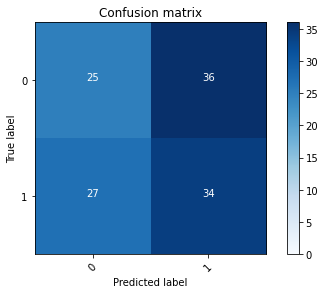

2022-08-22 14:11:41 - [Epoch Train: 25] loss: 0.0057, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:11:41 - [Epoch Valid: 25] loss: 1.9131, auc: 0.5074, acc: 0.4836, time: 6.00 s


 25%|██████████▌                               | 25/100 [12:24<37:53, 30.31s/it]

2022-08-22 14:11:41 - EPOCH: 26
2022-08-22 14:11:44 - Train Step 10/121, train_loss: 0.0020
2022-08-22 14:11:45 - Train Step 20/121, train_loss: 0.0018
2022-08-22 14:11:47 - Train Step 30/121, train_loss: 0.0020
2022-08-22 14:11:49 - Train Step 40/121, train_loss: 0.0022
2022-08-22 14:11:51 - Train Step 50/121, train_loss: 0.0022
2022-08-22 14:11:53 - Train Step 60/121, train_loss: 0.0035
2022-08-22 14:11:55 - Train Step 70/121, train_loss: 0.0033
2022-08-22 14:11:57 - Train Step 80/121, train_loss: 0.0032
2022-08-22 14:11:59 - Train Step 90/121, train_loss: 0.0031
2022-08-22 14:12:01 - Train Step 100/121, train_loss: 0.0030
2022-08-22 14:12:03 - Train Step 110/121, train_loss: 0.0050
2022-08-22 14:12:05 - Train Step 120/121, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:12:06 - Valid Step 5/31, valid_loss: 1.7178
2022-08-22 14:12:07 - Valid Step 10/31, valid_loss: 1.7264
2022-08-22 14:12:08 - Valid Step 15/31, valid_loss: 1.8137
2022-08-22 14:12:09

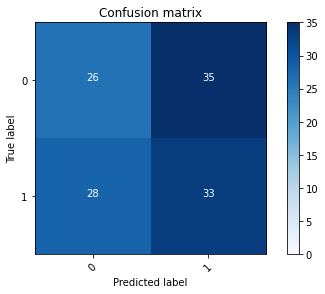

2022-08-22 14:12:11 - [Epoch Train: 26] loss: 0.0047, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:12:11 - [Epoch Valid: 26] loss: 1.9200, auc: 0.5066, acc: 0.4836, time: 6.00 s


 26%|██████████▉                               | 26/100 [12:54<37:16, 30.22s/it]

2022-08-22 14:12:11 - EPOCH: 27
2022-08-22 14:12:14 - Train Step 10/121, train_loss: 0.0028
2022-08-22 14:12:16 - Train Step 20/121, train_loss: 0.0037
2022-08-22 14:12:18 - Train Step 30/121, train_loss: 0.0063
2022-08-22 14:12:19 - Train Step 40/121, train_loss: 0.0051
2022-08-22 14:12:21 - Train Step 50/121, train_loss: 0.0046
2022-08-22 14:12:23 - Train Step 60/121, train_loss: 0.0040
2022-08-22 14:12:25 - Train Step 70/121, train_loss: 0.0039
2022-08-22 14:12:27 - Train Step 80/121, train_loss: 0.0036
2022-08-22 14:12:29 - Train Step 90/121, train_loss: 0.0034
2022-08-22 14:12:31 - Train Step 100/121, train_loss: 0.0061
2022-08-22 14:12:33 - Train Step 110/121, train_loss: 0.0057
2022-08-22 14:12:35 - Train Step 120/121, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:12:37 - Valid Step 5/31, valid_loss: 0.7445
2022-08-22 14:12:37 - Valid Step 10/31, valid_loss: 1.4300
2022-08-22 14:12:38 - Valid Step 15/31, valid_loss: 1.5805
2022-08-22 14:12:39

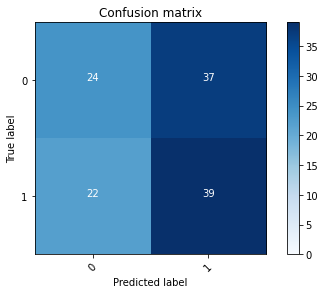

2022-08-22 14:12:42 - [Epoch Train: 27] loss: 0.0054, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:12:42 - [Epoch Valid: 27] loss: 1.9578, auc: 0.5042, acc: 0.5164, time: 6.00 s


 27%|███████████▎                              | 27/100 [13:24<36:42, 30.17s/it]

2022-08-22 14:12:42 - EPOCH: 28
2022-08-22 14:12:44 - Train Step 10/121, train_loss: 0.0019
2022-08-22 14:12:46 - Train Step 20/121, train_loss: 0.0021
2022-08-22 14:12:48 - Train Step 30/121, train_loss: 0.0019
2022-08-22 14:12:50 - Train Step 40/121, train_loss: 0.0018
2022-08-22 14:12:52 - Train Step 50/121, train_loss: 0.0021
2022-08-22 14:12:54 - Train Step 60/121, train_loss: 0.0020
2022-08-22 14:12:56 - Train Step 70/121, train_loss: 0.0020
2022-08-22 14:12:58 - Train Step 80/121, train_loss: 0.0021
2022-08-22 14:12:59 - Train Step 90/121, train_loss: 0.0020
2022-08-22 14:13:01 - Train Step 100/121, train_loss: 0.0020
2022-08-22 14:13:03 - Train Step 110/121, train_loss: 0.0028
2022-08-22 14:13:05 - Train Step 120/121, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:13:07 - Valid Step 5/31, valid_loss: 2.1680
2022-08-22 14:13:08 - Valid Step 10/31, valid_loss: 1.6812
2022-08-22 14:13:09 - Valid Step 15/31, valid_loss: 1.7709
2022-08-22 14:13:10

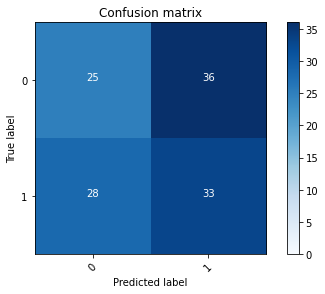

2022-08-22 14:13:12 - [Epoch Train: 28] loss: 0.0040, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 14:13:12 - [Epoch Valid: 28] loss: 1.9887, auc: 0.5090, acc: 0.4754, time: 6.00 s


 28%|███████████▊                              | 28/100 [13:55<36:19, 30.27s/it]

2022-08-22 14:13:12 - EPOCH: 29
2022-08-22 14:13:14 - Train Step 10/121, train_loss: 0.0013
2022-08-22 14:13:16 - Train Step 20/121, train_loss: 0.0017
2022-08-22 14:13:18 - Train Step 30/121, train_loss: 0.0154
2022-08-22 14:13:20 - Train Step 40/121, train_loss: 0.0119
2022-08-22 14:13:22 - Train Step 50/121, train_loss: 0.0097
2022-08-22 14:13:24 - Train Step 60/121, train_loss: 0.0085
2022-08-22 14:13:26 - Train Step 70/121, train_loss: 0.0076
2022-08-22 14:13:28 - Train Step 80/121, train_loss: 0.0068
2022-08-22 14:13:30 - Train Step 90/121, train_loss: 0.0062
2022-08-22 14:13:32 - Train Step 100/121, train_loss: 0.0058
2022-08-22 14:13:34 - Train Step 110/121, train_loss: 0.0054
2022-08-22 14:13:36 - Train Step 120/121, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:13:37 - Valid Step 5/31, valid_loss: 1.9994
2022-08-22 14:13:38 - Valid Step 10/31, valid_loss: 2.0502
2022-08-22 14:13:39 - Valid Step 15/31, valid_loss: 1.8270
2022-08-22 14:13:40

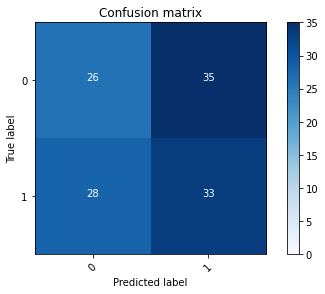

2022-08-22 14:13:42 - [Epoch Train: 29] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:13:42 - [Epoch Valid: 29] loss: 1.9587, auc: 0.5095, acc: 0.4836, time: 6.00 s


 29%|████████████▏                             | 29/100 [14:25<35:48, 30.26s/it]

2022-08-22 14:13:42 - EPOCH: 30
2022-08-22 14:13:44 - Train Step 10/121, train_loss: 0.0018
2022-08-22 14:13:46 - Train Step 20/121, train_loss: 0.0091
2022-08-22 14:13:48 - Train Step 30/121, train_loss: 0.0066
2022-08-22 14:13:50 - Train Step 40/121, train_loss: 0.0139
2022-08-22 14:13:52 - Train Step 50/121, train_loss: 0.0116
2022-08-22 14:13:54 - Train Step 60/121, train_loss: 0.0099
2022-08-22 14:13:56 - Train Step 70/121, train_loss: 0.0086
2022-08-22 14:13:58 - Train Step 80/121, train_loss: 0.0077
2022-08-22 14:14:00 - Train Step 90/121, train_loss: 0.0071
2022-08-22 14:14:02 - Train Step 100/121, train_loss: 0.0065
2022-08-22 14:14:04 - Train Step 110/121, train_loss: 0.0061
2022-08-22 14:14:06 - Train Step 120/121, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:14:07 - Valid Step 5/31, valid_loss: 2.1669
2022-08-22 14:14:08 - Valid Step 10/31, valid_loss: 2.3589
2022-08-22 14:14:09 - Valid Step 15/31, valid_loss: 2.2501
2022-08-22 14:14:10

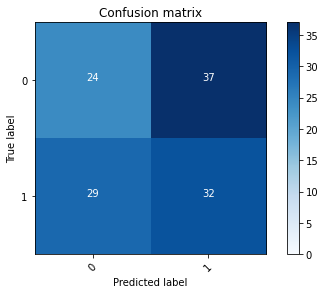

2022-08-22 14:14:12 - [Epoch Train: 30] loss: 0.0056, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:14:12 - [Epoch Valid: 30] loss: 1.9863, auc: 0.5031, acc: 0.4590, time: 6.00 s


 30%|████████████▌                             | 30/100 [14:55<35:12, 30.18s/it]

2022-08-22 14:14:12 - EPOCH: 31
2022-08-22 14:14:14 - Train Step 10/121, train_loss: 0.0088
2022-08-22 14:14:16 - Train Step 20/121, train_loss: 0.0055
2022-08-22 14:14:18 - Train Step 30/121, train_loss: 0.0040
2022-08-22 14:14:20 - Train Step 40/121, train_loss: 0.0034
2022-08-22 14:14:22 - Train Step 50/121, train_loss: 0.0031
2022-08-22 14:14:24 - Train Step 60/121, train_loss: 0.0028
2022-08-22 14:14:26 - Train Step 70/121, train_loss: 0.0060
2022-08-22 14:14:28 - Train Step 80/121, train_loss: 0.0054
2022-08-22 14:14:30 - Train Step 90/121, train_loss: 0.0050
2022-08-22 14:14:32 - Train Step 100/121, train_loss: 0.0046
2022-08-22 14:14:34 - Train Step 110/121, train_loss: 0.0044
2022-08-22 14:14:36 - Train Step 120/121, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:14:38 - Valid Step 5/31, valid_loss: 1.7130
2022-08-22 14:14:38 - Valid Step 10/31, valid_loss: 1.1844
2022-08-22 14:14:40 - Valid Step 15/31, valid_loss: 1.3768
2022-08-22 14:14:40

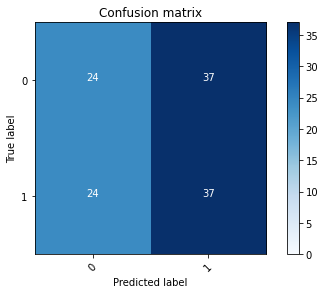

2022-08-22 14:14:43 - [Epoch Train: 31] loss: 0.0041, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:14:43 - [Epoch Valid: 31] loss: 2.0747, auc: 0.5109, acc: 0.5000, time: 6.00 s


 31%|█████████████                             | 31/100 [15:25<34:47, 30.25s/it]

2022-08-22 14:14:43 - EPOCH: 32
2022-08-22 14:14:45 - Train Step 10/121, train_loss: 0.0178
2022-08-22 14:14:47 - Train Step 20/121, train_loss: 0.0093
2022-08-22 14:14:49 - Train Step 30/121, train_loss: 0.0064
2022-08-22 14:14:51 - Train Step 40/121, train_loss: 0.0050
2022-08-22 14:14:53 - Train Step 50/121, train_loss: 0.0042
2022-08-22 14:14:55 - Train Step 60/121, train_loss: 0.0059
2022-08-22 14:14:57 - Train Step 70/121, train_loss: 0.0054
2022-08-22 14:14:59 - Train Step 80/121, train_loss: 0.0048
2022-08-22 14:15:01 - Train Step 90/121, train_loss: 0.0045
2022-08-22 14:15:03 - Train Step 100/121, train_loss: 0.0042
2022-08-22 14:15:04 - Train Step 110/121, train_loss: 0.0041
2022-08-22 14:15:06 - Train Step 120/121, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:15:08 - Valid Step 5/31, valid_loss: 2.0675
2022-08-22 14:15:09 - Valid Step 10/31, valid_loss: 2.1967
2022-08-22 14:15:10 - Valid Step 15/31, valid_loss: 2.1614
2022-08-22 14:15:11

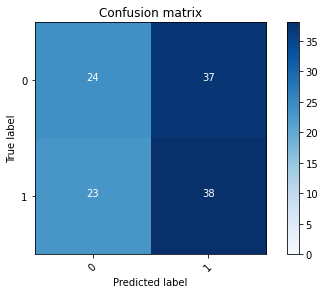

2022-08-22 14:15:13 - [Epoch Train: 32] loss: 0.0038, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 14:15:13 - [Epoch Valid: 32] loss: 2.1324, auc: 0.5069, acc: 0.5082, time: 6.00 s


 32%|█████████████▍                            | 32/100 [15:56<34:24, 30.36s/it]

2022-08-22 14:15:13 - EPOCH: 33
2022-08-22 14:15:16 - Train Step 10/121, train_loss: 0.0162
2022-08-22 14:15:17 - Train Step 20/121, train_loss: 0.0087
2022-08-22 14:15:19 - Train Step 30/121, train_loss: 0.0061
2022-08-22 14:15:21 - Train Step 40/121, train_loss: 0.0049
2022-08-22 14:15:23 - Train Step 50/121, train_loss: 0.0041
2022-08-22 14:15:25 - Train Step 60/121, train_loss: 0.0036
2022-08-22 14:15:27 - Train Step 70/121, train_loss: 0.0032
2022-08-22 14:15:29 - Train Step 80/121, train_loss: 0.0030
2022-08-22 14:15:31 - Train Step 90/121, train_loss: 0.0028
2022-08-22 14:15:33 - Train Step 100/121, train_loss: 0.0027
2022-08-22 14:15:35 - Train Step 110/121, train_loss: 0.0059
2022-08-22 14:15:37 - Train Step 120/121, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:15:39 - Valid Step 5/31, valid_loss: 1.4544
2022-08-22 14:15:40 - Valid Step 10/31, valid_loss: 1.3009
2022-08-22 14:15:41 - Valid Step 15/31, valid_loss: 1.7184
2022-08-22 14:15:42

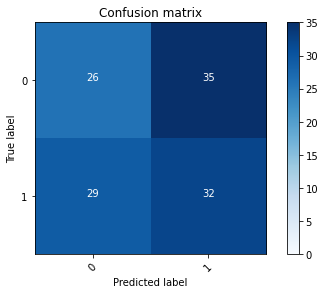

2022-08-22 14:15:44 - [Epoch Train: 33] loss: 0.0055, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:15:44 - [Epoch Valid: 33] loss: 2.1267, auc: 0.5060, acc: 0.4754, time: 6.00 s


 33%|█████████████▊                            | 33/100 [16:27<34:05, 30.54s/it]

2022-08-22 14:15:44 - EPOCH: 34
2022-08-22 14:15:46 - Train Step 10/121, train_loss: 0.0073
2022-08-22 14:15:48 - Train Step 20/121, train_loss: 0.0043
2022-08-22 14:15:50 - Train Step 30/121, train_loss: 0.0032
2022-08-22 14:15:52 - Train Step 40/121, train_loss: 0.0026
2022-08-22 14:15:54 - Train Step 50/121, train_loss: 0.0022
2022-08-22 14:15:56 - Train Step 60/121, train_loss: 0.0020
2022-08-22 14:15:58 - Train Step 70/121, train_loss: 0.0020
2022-08-22 14:16:00 - Train Step 80/121, train_loss: 0.0018
2022-08-22 14:16:02 - Train Step 90/121, train_loss: 0.0039
2022-08-22 14:16:04 - Train Step 100/121, train_loss: 0.0036
2022-08-22 14:16:06 - Train Step 110/121, train_loss: 0.0034
2022-08-22 14:16:08 - Train Step 120/121, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:16:09 - Valid Step 5/31, valid_loss: 2.1400
2022-08-22 14:16:10 - Valid Step 10/31, valid_loss: 2.3644
2022-08-22 14:16:11 - Valid Step 15/31, valid_loss: 2.2127
2022-08-22 14:16:12

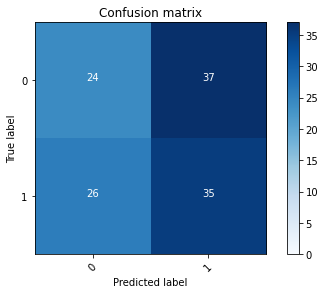

2022-08-22 14:16:14 - [Epoch Train: 34] loss: 0.0032, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:16:14 - [Epoch Valid: 34] loss: 2.0810, auc: 0.5034, acc: 0.4836, time: 6.00 s


 34%|██████████████▎                           | 34/100 [16:57<33:26, 30.40s/it]

2022-08-22 14:16:14 - EPOCH: 35
2022-08-22 14:16:17 - Train Step 10/121, train_loss: 0.0009
2022-08-22 14:16:19 - Train Step 20/121, train_loss: 0.0007
2022-08-22 14:16:20 - Train Step 30/121, train_loss: 0.0007
2022-08-22 14:16:22 - Train Step 40/121, train_loss: 0.0007
2022-08-22 14:16:24 - Train Step 50/121, train_loss: 0.0007
2022-08-22 14:16:26 - Train Step 60/121, train_loss: 0.0007
2022-08-22 14:16:28 - Train Step 70/121, train_loss: 0.0008
2022-08-22 14:16:30 - Train Step 80/121, train_loss: 0.0008
2022-08-22 14:16:32 - Train Step 90/121, train_loss: 0.0008
2022-08-22 14:16:34 - Train Step 100/121, train_loss: 0.0061
2022-08-22 14:16:36 - Train Step 110/121, train_loss: 0.0056
2022-08-22 14:16:38 - Train Step 120/121, train_loss: 0.0074
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:16:40 - Valid Step 5/31, valid_loss: 3.0941
2022-08-22 14:16:41 - Valid Step 10/31, valid_loss: 2.2085
2022-08-22 14:16:42 - Valid Step 15/31, valid_loss: 2.1954
2022-08-22 14:16:43

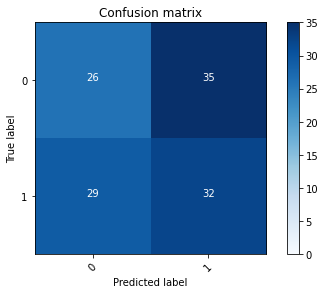

2022-08-22 14:16:45 - [Epoch Train: 35] loss: 0.0074, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:16:45 - [Epoch Valid: 35] loss: 2.1325, auc: 0.5044, acc: 0.4754, time: 6.00 s


 35%|██████████████▋                           | 35/100 [17:27<32:58, 30.44s/it]

2022-08-22 14:16:45 - EPOCH: 36
2022-08-22 14:16:47 - Train Step 10/121, train_loss: 0.0014
2022-08-22 14:16:49 - Train Step 20/121, train_loss: 0.0010
2022-08-22 14:16:51 - Train Step 30/121, train_loss: 0.0012
2022-08-22 14:16:53 - Train Step 40/121, train_loss: 0.0013
2022-08-22 14:16:55 - Train Step 50/121, train_loss: 0.0013
2022-08-22 14:16:57 - Train Step 60/121, train_loss: 0.0049
2022-08-22 14:16:58 - Train Step 70/121, train_loss: 0.0044
2022-08-22 14:17:00 - Train Step 80/121, train_loss: 0.0040
2022-08-22 14:17:02 - Train Step 90/121, train_loss: 0.0038
2022-08-22 14:17:04 - Train Step 100/121, train_loss: 0.0034
2022-08-22 14:17:06 - Train Step 110/121, train_loss: 0.0063
2022-08-22 14:17:08 - Train Step 120/121, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:17:10 - Valid Step 5/31, valid_loss: 1.3536
2022-08-22 14:17:11 - Valid Step 10/31, valid_loss: 1.6697
2022-08-22 14:17:12 - Valid Step 15/31, valid_loss: 1.8347
2022-08-22 14:17:13

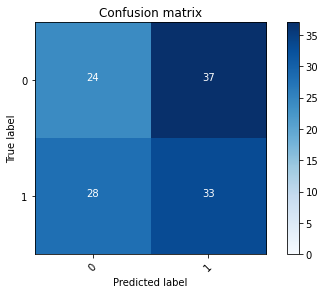

2022-08-22 14:17:15 - [Epoch Train: 36] loss: 0.0058, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:17:15 - [Epoch Valid: 36] loss: 2.1208, auc: 0.5026, acc: 0.4672, time: 6.00 s


 36%|███████████████                           | 36/100 [17:57<32:19, 30.31s/it]

2022-08-22 14:17:15 - EPOCH: 37
2022-08-22 14:17:17 - Train Step 10/121, train_loss: 0.0009
2022-08-22 14:17:19 - Train Step 20/121, train_loss: 0.0010
2022-08-22 14:17:21 - Train Step 30/121, train_loss: 0.0009
2022-08-22 14:17:23 - Train Step 40/121, train_loss: 0.0043
2022-08-22 14:17:25 - Train Step 50/121, train_loss: 0.0035
2022-08-22 14:17:27 - Train Step 60/121, train_loss: 0.0090
2022-08-22 14:17:29 - Train Step 70/121, train_loss: 0.0078
2022-08-22 14:17:31 - Train Step 80/121, train_loss: 0.0069
2022-08-22 14:17:32 - Train Step 90/121, train_loss: 0.0062
2022-08-22 14:17:34 - Train Step 100/121, train_loss: 0.0057
2022-08-22 14:17:36 - Train Step 110/121, train_loss: 0.0053
2022-08-22 14:17:38 - Train Step 120/121, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:17:40 - Valid Step 5/31, valid_loss: 2.2245
2022-08-22 14:17:41 - Valid Step 10/31, valid_loss: 2.1334
2022-08-22 14:17:42 - Valid Step 15/31, valid_loss: 2.1868
2022-08-22 14:17:43

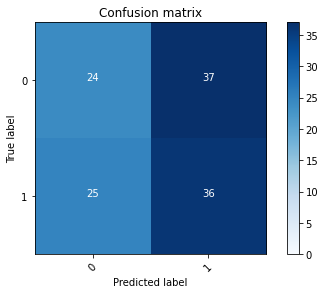

2022-08-22 14:17:45 - [Epoch Train: 37] loss: 0.0049, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 14:17:45 - [Epoch Valid: 37] loss: 2.1250, auc: 0.4993, acc: 0.4918, time: 6.00 s


 37%|███████████████▌                          | 37/100 [18:27<31:43, 30.22s/it]

2022-08-22 14:17:45 - EPOCH: 38
2022-08-22 14:17:47 - Train Step 10/121, train_loss: 0.0010
2022-08-22 14:17:49 - Train Step 20/121, train_loss: 0.0081
2022-08-22 14:17:51 - Train Step 30/121, train_loss: 0.0057
2022-08-22 14:17:53 - Train Step 40/121, train_loss: 0.0044
2022-08-22 14:17:55 - Train Step 50/121, train_loss: 0.0037
2022-08-22 14:17:57 - Train Step 60/121, train_loss: 0.0032
2022-08-22 14:17:59 - Train Step 70/121, train_loss: 0.0028
2022-08-22 14:18:01 - Train Step 80/121, train_loss: 0.0026
2022-08-22 14:18:03 - Train Step 90/121, train_loss: 0.0024
2022-08-22 14:18:05 - Train Step 100/121, train_loss: 0.0072
2022-08-22 14:18:07 - Train Step 110/121, train_loss: 0.0066
2022-08-22 14:18:09 - Train Step 120/121, train_loss: 0.0061
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:18:11 - Valid Step 5/31, valid_loss: 1.9625
2022-08-22 14:18:11 - Valid Step 10/31, valid_loss: 2.5911
2022-08-22 14:18:13 - Valid Step 15/31, valid_loss: 2.5441
2022-08-22 14:18:13

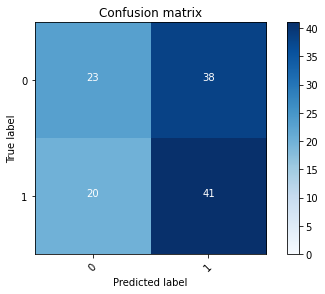

2022-08-22 14:18:16 - [Epoch Train: 38] loss: 0.0061, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:18:16 - [Epoch Valid: 38] loss: 2.3591, auc: 0.5039, acc: 0.5246, time: 6.00 s


 38%|███████████████▉                          | 38/100 [18:58<31:25, 30.40s/it]

2022-08-22 14:18:16 - EPOCH: 39
2022-08-22 14:18:18 - Train Step 10/121, train_loss: 0.0007
2022-08-22 14:18:20 - Train Step 20/121, train_loss: 0.0009
2022-08-22 14:18:22 - Train Step 30/121, train_loss: 0.0013
2022-08-22 14:18:24 - Train Step 40/121, train_loss: 0.0035
2022-08-22 14:18:26 - Train Step 50/121, train_loss: 0.0030
2022-08-22 14:18:28 - Train Step 60/121, train_loss: 0.0026
2022-08-22 14:18:30 - Train Step 70/121, train_loss: 0.0024
2022-08-22 14:18:32 - Train Step 80/121, train_loss: 0.0022
2022-08-22 14:18:34 - Train Step 90/121, train_loss: 0.0020
2022-08-22 14:18:36 - Train Step 100/121, train_loss: 0.0020
2022-08-22 14:18:37 - Train Step 110/121, train_loss: 0.0018
2022-08-22 14:18:39 - Train Step 120/121, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:18:41 - Valid Step 5/31, valid_loss: 2.5626
2022-08-22 14:18:42 - Valid Step 10/31, valid_loss: 2.4810
2022-08-22 14:18:43 - Valid Step 15/31, valid_loss: 2.3066
2022-08-22 14:18:44

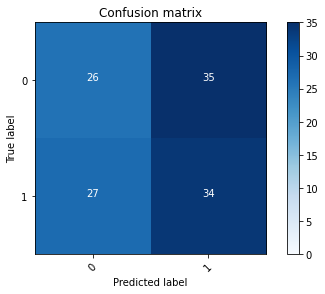

2022-08-22 14:18:46 - [Epoch Train: 39] loss: 0.0052, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:18:46 - [Epoch Valid: 39] loss: 2.3887, auc: 0.4993, acc: 0.4918, time: 6.00 s


 39%|████████████████▍                         | 39/100 [19:29<30:53, 30.38s/it]

2022-08-22 14:18:46 - EPOCH: 40
2022-08-22 14:18:48 - Train Step 10/121, train_loss: 0.0010
2022-08-22 14:18:50 - Train Step 20/121, train_loss: 0.0008
2022-08-22 14:18:52 - Train Step 30/121, train_loss: 0.0008
2022-08-22 14:18:54 - Train Step 40/121, train_loss: 0.0008
2022-08-22 14:18:56 - Train Step 50/121, train_loss: 0.0008
2022-08-22 14:18:58 - Train Step 60/121, train_loss: 0.0040
2022-08-22 14:19:00 - Train Step 70/121, train_loss: 0.0035
2022-08-22 14:19:02 - Train Step 80/121, train_loss: 0.0032
2022-08-22 14:19:04 - Train Step 90/121, train_loss: 0.0029
2022-08-22 14:19:06 - Train Step 100/121, train_loss: 0.0061
2022-08-22 14:19:08 - Train Step 110/121, train_loss: 0.0056
2022-08-22 14:19:10 - Train Step 120/121, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:19:11 - Valid Step 5/31, valid_loss: 2.5144
2022-08-22 14:19:12 - Valid Step 10/31, valid_loss: 1.9034
2022-08-22 14:19:13 - Valid Step 15/31, valid_loss: 2.3022
2022-08-22 14:19:14

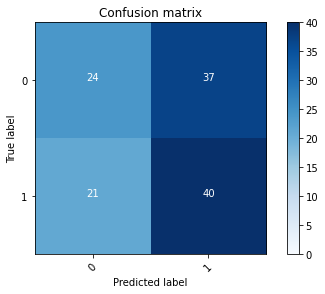

2022-08-22 14:19:17 - [Epoch Train: 40] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:19:17 - [Epoch Valid: 40] loss: 2.2189, auc: 0.5017, acc: 0.5246, time: 6.00 s


 40%|████████████████▊                         | 40/100 [19:59<30:25, 30.43s/it]

2022-08-22 14:19:17 - EPOCH: 41
2022-08-22 14:19:19 - Train Step 10/121, train_loss: 0.0007
2022-08-22 14:19:21 - Train Step 20/121, train_loss: 0.0006
2022-08-22 14:19:23 - Train Step 30/121, train_loss: 0.0056
2022-08-22 14:19:25 - Train Step 40/121, train_loss: 0.0045
2022-08-22 14:19:27 - Train Step 50/121, train_loss: 0.0038
2022-08-22 14:19:29 - Train Step 60/121, train_loss: 0.0032
2022-08-22 14:19:30 - Train Step 70/121, train_loss: 0.0029
2022-08-22 14:19:32 - Train Step 80/121, train_loss: 0.0026
2022-08-22 14:19:34 - Train Step 90/121, train_loss: 0.0068
2022-08-22 14:19:36 - Train Step 100/121, train_loss: 0.0062
2022-08-22 14:19:38 - Train Step 110/121, train_loss: 0.0057
2022-08-22 14:19:40 - Train Step 120/121, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:19:42 - Valid Step 5/31, valid_loss: 2.4425
2022-08-22 14:19:43 - Valid Step 10/31, valid_loss: 2.7816
2022-08-22 14:19:44 - Valid Step 15/31, valid_loss: 2.5148
2022-08-22 14:19:45

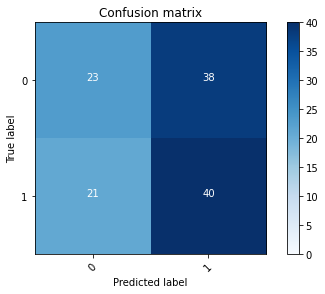

2022-08-22 14:19:47 - [Epoch Train: 41] loss: 0.0053, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:19:47 - [Epoch Valid: 41] loss: 2.4017, auc: 0.4961, acc: 0.5164, time: 6.00 s


 41%|█████████████████▏                        | 41/100 [20:30<29:59, 30.51s/it]

2022-08-22 14:19:47 - EPOCH: 42
2022-08-22 14:19:50 - Train Step 10/121, train_loss: 0.0008
2022-08-22 14:19:51 - Train Step 20/121, train_loss: 0.0008
2022-08-22 14:19:53 - Train Step 30/121, train_loss: 0.0008
2022-08-22 14:19:55 - Train Step 40/121, train_loss: 0.0007
2022-08-22 14:19:57 - Train Step 50/121, train_loss: 0.0006
2022-08-22 14:19:59 - Train Step 60/121, train_loss: 0.0007
2022-08-22 14:20:01 - Train Step 70/121, train_loss: 0.0043
2022-08-22 14:20:03 - Train Step 80/121, train_loss: 0.0038
2022-08-22 14:20:05 - Train Step 90/121, train_loss: 0.0034
2022-08-22 14:20:07 - Train Step 100/121, train_loss: 0.0032
2022-08-22 14:20:09 - Train Step 110/121, train_loss: 0.0029
2022-08-22 14:20:11 - Train Step 120/121, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:20:13 - Valid Step 5/31, valid_loss: 1.6991
2022-08-22 14:20:14 - Valid Step 10/31, valid_loss: 1.9082
2022-08-22 14:20:15 - Valid Step 15/31, valid_loss: 2.1417
2022-08-22 14:20:16

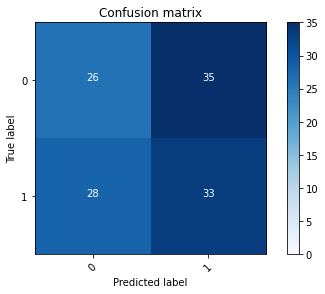

2022-08-22 14:20:18 - [Epoch Train: 42] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:20:18 - [Epoch Valid: 42] loss: 2.3223, auc: 0.4996, acc: 0.4836, time: 6.00 s


 42%|█████████████████▋                        | 42/100 [21:01<29:37, 30.65s/it]

2022-08-22 14:20:18 - EPOCH: 43
2022-08-22 14:20:21 - Train Step 10/121, train_loss: 0.0010
2022-08-22 14:20:23 - Train Step 20/121, train_loss: 0.0007
2022-08-22 14:20:25 - Train Step 30/121, train_loss: 0.0112
2022-08-22 14:20:26 - Train Step 40/121, train_loss: 0.0085
2022-08-22 14:20:28 - Train Step 50/121, train_loss: 0.0069
2022-08-22 14:20:30 - Train Step 60/121, train_loss: 0.0059
2022-08-22 14:20:32 - Train Step 70/121, train_loss: 0.0051
2022-08-22 14:20:34 - Train Step 80/121, train_loss: 0.0074
2022-08-22 14:20:36 - Train Step 90/121, train_loss: 0.0066
2022-08-22 14:20:38 - Train Step 100/121, train_loss: 0.0060
2022-08-22 14:20:40 - Train Step 110/121, train_loss: 0.0056
2022-08-22 14:20:42 - Train Step 120/121, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:20:44 - Valid Step 5/31, valid_loss: 2.1515
2022-08-22 14:20:44 - Valid Step 10/31, valid_loss: 1.9913
2022-08-22 14:20:46 - Valid Step 15/31, valid_loss: 2.1210
2022-08-22 14:20:46

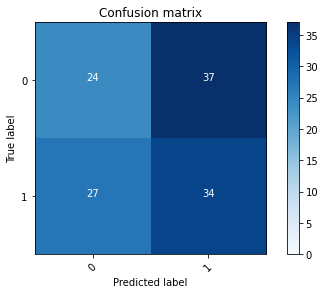

2022-08-22 14:20:49 - [Epoch Train: 43] loss: 0.0052, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:20:49 - [Epoch Valid: 43] loss: 2.2762, auc: 0.4977, acc: 0.4754, time: 6.00 s


 43%|██████████████████                        | 43/100 [21:31<29:01, 30.56s/it]

2022-08-22 14:20:49 - EPOCH: 44
2022-08-22 14:20:51 - Train Step 10/121, train_loss: 0.0005
2022-08-22 14:20:53 - Train Step 20/121, train_loss: 0.0005
2022-08-22 14:20:55 - Train Step 30/121, train_loss: 0.0005
2022-08-22 14:20:57 - Train Step 40/121, train_loss: 0.0006
2022-08-22 14:20:59 - Train Step 50/121, train_loss: 0.0005
2022-08-22 14:21:01 - Train Step 60/121, train_loss: 0.0036
2022-08-22 14:21:03 - Train Step 70/121, train_loss: 0.0031
2022-08-22 14:21:05 - Train Step 80/121, train_loss: 0.0028
2022-08-22 14:21:07 - Train Step 90/121, train_loss: 0.0026
2022-08-22 14:21:09 - Train Step 100/121, train_loss: 0.0024
2022-08-22 14:21:11 - Train Step 110/121, train_loss: 0.0037
2022-08-22 14:21:13 - Train Step 120/121, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:21:15 - Valid Step 5/31, valid_loss: 2.3166
2022-08-22 14:21:15 - Valid Step 10/31, valid_loss: 2.2377
2022-08-22 14:21:16 - Valid Step 15/31, valid_loss: 2.5118
2022-08-22 14:21:17

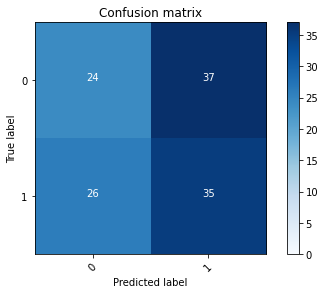

2022-08-22 14:21:20 - [Epoch Train: 44] loss: 0.0034, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:21:20 - [Epoch Valid: 44] loss: 2.2082, auc: 0.5028, acc: 0.4836, time: 6.00 s


 44%|██████████████████▍                       | 44/100 [22:02<28:39, 30.71s/it]

2022-08-22 14:21:20 - EPOCH: 45
2022-08-22 14:21:22 - Train Step 10/121, train_loss: 0.0003
2022-08-22 14:21:24 - Train Step 20/121, train_loss: 0.0100
2022-08-22 14:21:26 - Train Step 30/121, train_loss: 0.0068
2022-08-22 14:21:28 - Train Step 40/121, train_loss: 0.0053
2022-08-22 14:21:30 - Train Step 50/121, train_loss: 0.0043
2022-08-22 14:21:32 - Train Step 60/121, train_loss: 0.0038
2022-08-22 14:21:34 - Train Step 70/121, train_loss: 0.0033
2022-08-22 14:21:36 - Train Step 80/121, train_loss: 0.0030
2022-08-22 14:21:38 - Train Step 90/121, train_loss: 0.0027
2022-08-22 14:21:40 - Train Step 100/121, train_loss: 0.0025
2022-08-22 14:21:42 - Train Step 110/121, train_loss: 0.0047
2022-08-22 14:21:44 - Train Step 120/121, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:21:46 - Valid Step 5/31, valid_loss: 3.9260
2022-08-22 14:21:47 - Valid Step 10/31, valid_loss: 3.0873
2022-08-22 14:21:48 - Valid Step 15/31, valid_loss: 2.5374
2022-08-22 14:21:49

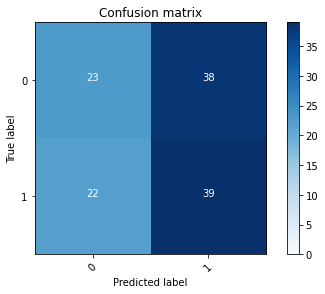

2022-08-22 14:21:51 - [Epoch Train: 45] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:21:51 - [Epoch Valid: 45] loss: 2.3988, auc: 0.5044, acc: 0.5082, time: 6.00 s


 45%|██████████████████▉                       | 45/100 [22:34<28:21, 30.94s/it]

2022-08-22 14:21:51 - EPOCH: 46
2022-08-22 14:21:53 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:21:55 - Train Step 20/121, train_loss: 0.0005
2022-08-22 14:21:57 - Train Step 30/121, train_loss: 0.0051
2022-08-22 14:21:59 - Train Step 40/121, train_loss: 0.0040
2022-08-22 14:22:01 - Train Step 50/121, train_loss: 0.0034
2022-08-22 14:22:03 - Train Step 60/121, train_loss: 0.0029
2022-08-22 14:22:05 - Train Step 70/121, train_loss: 0.0025
2022-08-22 14:22:07 - Train Step 80/121, train_loss: 0.0060
2022-08-22 14:22:09 - Train Step 90/121, train_loss: 0.0055
2022-08-22 14:22:11 - Train Step 100/121, train_loss: 0.0050
2022-08-22 14:22:13 - Train Step 110/121, train_loss: 0.0045
2022-08-22 14:22:15 - Train Step 120/121, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:22:17 - Valid Step 5/31, valid_loss: 3.4641
2022-08-22 14:22:17 - Valid Step 10/31, valid_loss: 2.6497
2022-08-22 14:22:19 - Valid Step 15/31, valid_loss: 2.4796
2022-08-22 14:22:19

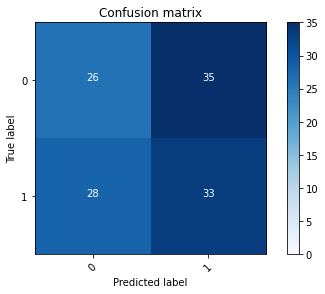

2022-08-22 14:22:22 - [Epoch Train: 46] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:22:22 - [Epoch Valid: 46] loss: 2.3921, auc: 0.5039, acc: 0.4836, time: 6.00 s


 46%|███████████████████▎                      | 46/100 [23:04<27:45, 30.85s/it]

2022-08-22 14:22:22 - EPOCH: 47
2022-08-22 14:22:24 - Train Step 10/121, train_loss: 0.0003
2022-08-22 14:22:26 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:22:28 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:22:30 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:22:32 - Train Step 50/121, train_loss: 0.0004
2022-08-22 14:22:34 - Train Step 60/121, train_loss: 0.0004
2022-08-22 14:22:36 - Train Step 70/121, train_loss: 0.0004
2022-08-22 14:22:38 - Train Step 80/121, train_loss: 0.0004
2022-08-22 14:22:40 - Train Step 90/121, train_loss: 0.0004
2022-08-22 14:22:42 - Train Step 100/121, train_loss: 0.0018
2022-08-22 14:22:44 - Train Step 110/121, train_loss: 0.0059
2022-08-22 14:22:46 - Train Step 120/121, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:22:47 - Valid Step 5/31, valid_loss: 1.8107
2022-08-22 14:22:48 - Valid Step 10/31, valid_loss: 2.2072
2022-08-22 14:22:49 - Valid Step 15/31, valid_loss: 2.0345
2022-08-22 14:22:50

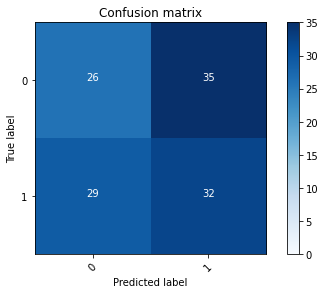

2022-08-22 14:22:52 - [Epoch Train: 47] loss: 0.0054, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:22:52 - [Epoch Valid: 47] loss: 2.3499, auc: 0.5122, acc: 0.4754, time: 6.00 s


 47%|███████████████████▋                      | 47/100 [23:35<27:11, 30.78s/it]

2022-08-22 14:22:52 - EPOCH: 48
2022-08-22 14:22:55 - Train Step 10/121, train_loss: 0.0566
2022-08-22 14:22:57 - Train Step 20/121, train_loss: 0.0286
2022-08-22 14:22:59 - Train Step 30/121, train_loss: 0.0194
2022-08-22 14:23:00 - Train Step 40/121, train_loss: 0.0147
2022-08-22 14:23:02 - Train Step 50/121, train_loss: 0.0119
2022-08-22 14:23:04 - Train Step 60/121, train_loss: 0.0130
2022-08-22 14:23:06 - Train Step 70/121, train_loss: 0.0113
2022-08-22 14:23:08 - Train Step 80/121, train_loss: 0.0099
2022-08-22 14:23:10 - Train Step 90/121, train_loss: 0.0088
2022-08-22 14:23:12 - Train Step 100/121, train_loss: 0.0080
2022-08-22 14:23:14 - Train Step 110/121, train_loss: 0.0073
2022-08-22 14:23:16 - Train Step 120/121, train_loss: 0.0067
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:23:18 - Valid Step 5/31, valid_loss: 1.9329
2022-08-22 14:23:19 - Valid Step 10/31, valid_loss: 2.1985
2022-08-22 14:23:20 - Valid Step 15/31, valid_loss: 2.6883
2022-08-22 14:23:21

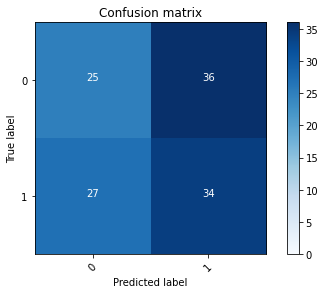

2022-08-22 14:23:23 - [Epoch Train: 48] loss: 0.0067, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 14:23:23 - [Epoch Valid: 48] loss: 2.4597, auc: 0.5093, acc: 0.4836, time: 6.00 s


 48%|████████████████████▏                     | 48/100 [24:05<26:34, 30.67s/it]

2022-08-22 14:23:23 - EPOCH: 49
2022-08-22 14:23:25 - Train Step 10/121, train_loss: 0.0172
2022-08-22 14:23:27 - Train Step 20/121, train_loss: 0.0093
2022-08-22 14:23:29 - Train Step 30/121, train_loss: 0.0064
2022-08-22 14:23:31 - Train Step 40/121, train_loss: 0.0049
2022-08-22 14:23:33 - Train Step 50/121, train_loss: 0.0040
2022-08-22 14:23:35 - Train Step 60/121, train_loss: 0.0034
2022-08-22 14:23:37 - Train Step 70/121, train_loss: 0.0030
2022-08-22 14:23:39 - Train Step 80/121, train_loss: 0.0027
2022-08-22 14:23:41 - Train Step 90/121, train_loss: 0.0025
2022-08-22 14:23:43 - Train Step 100/121, train_loss: 0.0023
2022-08-22 14:23:45 - Train Step 110/121, train_loss: 0.0021
2022-08-22 14:23:46 - Train Step 120/121, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:23:48 - Valid Step 5/31, valid_loss: 2.4038
2022-08-22 14:23:49 - Valid Step 10/31, valid_loss: 2.5310
2022-08-22 14:23:50 - Valid Step 15/31, valid_loss: 2.1325
2022-08-22 14:23:51

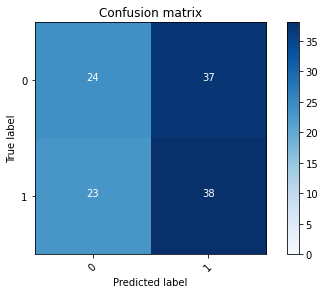

2022-08-22 14:23:53 - [Epoch Train: 49] loss: 0.0058, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:23:53 - [Epoch Valid: 49] loss: 2.5667, auc: 0.5160, acc: 0.5082, time: 6.00 s


 49%|████████████████████▌                     | 49/100 [24:36<26:00, 30.61s/it]

2022-08-22 14:23:53 - EPOCH: 50
2022-08-22 14:23:56 - Train Step 10/121, train_loss: 0.0004
2022-08-22 14:23:58 - Train Step 20/121, train_loss: 0.0004
2022-08-22 14:23:59 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:24:01 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:24:03 - Train Step 50/121, train_loss: 0.0005
2022-08-22 14:24:05 - Train Step 60/121, train_loss: 0.0005
2022-08-22 14:24:07 - Train Step 70/121, train_loss: 0.0006
2022-08-22 14:24:09 - Train Step 80/121, train_loss: 0.0005
2022-08-22 14:24:11 - Train Step 90/121, train_loss: 0.0006
2022-08-22 14:24:13 - Train Step 100/121, train_loss: 0.0022
2022-08-22 14:24:15 - Train Step 110/121, train_loss: 0.0021
2022-08-22 14:24:17 - Train Step 120/121, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:24:19 - Valid Step 5/31, valid_loss: 1.7186
2022-08-22 14:24:20 - Valid Step 10/31, valid_loss: 2.1162
2022-08-22 14:24:21 - Valid Step 15/31, valid_loss: 2.1706
2022-08-22 14:24:22

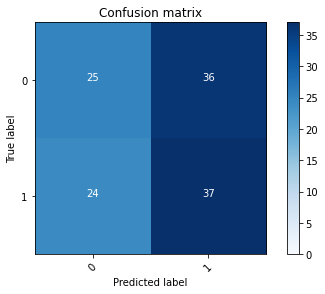

2022-08-22 14:24:24 - [Epoch Train: 50] loss: 0.0045, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 14:24:24 - [Epoch Valid: 50] loss: 2.5295, auc: 0.5103, acc: 0.5082, time: 6.00 s


 50%|█████████████████████                     | 50/100 [25:07<25:35, 30.70s/it]

2022-08-22 14:24:24 - EPOCH: 51
2022-08-22 14:24:26 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:24:28 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:24:30 - Train Step 30/121, train_loss: 0.0003
2022-08-22 14:24:32 - Train Step 40/121, train_loss: 0.0064
2022-08-22 14:24:34 - Train Step 50/121, train_loss: 0.0052
2022-08-22 14:24:36 - Train Step 60/121, train_loss: 0.0044
2022-08-22 14:24:38 - Train Step 70/121, train_loss: 0.0039
2022-08-22 14:24:40 - Train Step 80/121, train_loss: 0.0034
2022-08-22 14:24:42 - Train Step 90/121, train_loss: 0.0070
2022-08-22 14:24:45 - Train Step 100/121, train_loss: 0.0064
2022-08-22 14:24:47 - Train Step 110/121, train_loss: 0.0058
2022-08-22 14:24:49 - Train Step 120/121, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:24:50 - Valid Step 5/31, valid_loss: 2.5072
2022-08-22 14:24:51 - Valid Step 10/31, valid_loss: 2.6766
2022-08-22 14:24:52 - Valid Step 15/31, valid_loss: 2.6745
2022-08-22 14:24:53

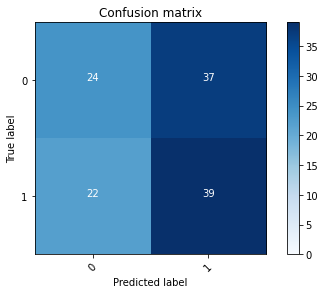

2022-08-22 14:24:55 - [Epoch Train: 51] loss: 0.0054, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:24:55 - [Epoch Valid: 51] loss: 2.4450, auc: 0.5138, acc: 0.5164, time: 6.00 s


 51%|█████████████████████▍                    | 51/100 [25:38<25:10, 30.83s/it]

2022-08-22 14:24:55 - EPOCH: 52
2022-08-22 14:24:58 - Train Step 10/121, train_loss: 0.0004
2022-08-22 14:25:00 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:25:01 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:25:03 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:25:05 - Train Step 50/121, train_loss: 0.0053
2022-08-22 14:25:07 - Train Step 60/121, train_loss: 0.0046
2022-08-22 14:25:09 - Train Step 70/121, train_loss: 0.0040
2022-08-22 14:25:11 - Train Step 80/121, train_loss: 0.0036
2022-08-22 14:25:13 - Train Step 90/121, train_loss: 0.0032
2022-08-22 14:25:15 - Train Step 100/121, train_loss: 0.0079
2022-08-22 14:25:17 - Train Step 110/121, train_loss: 0.0073
2022-08-22 14:25:19 - Train Step 120/121, train_loss: 0.0068
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:25:21 - Valid Step 5/31, valid_loss: 1.8809
2022-08-22 14:25:22 - Valid Step 10/31, valid_loss: 1.8089
2022-08-22 14:25:23 - Valid Step 15/31, valid_loss: 2.4601
2022-08-22 14:25:24

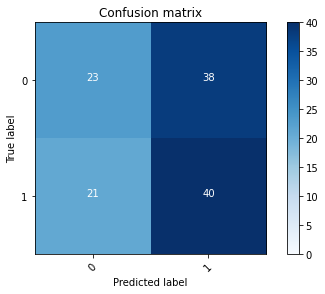

2022-08-22 14:25:26 - [Epoch Train: 52] loss: 0.0067, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 14:25:26 - [Epoch Valid: 52] loss: 2.3782, auc: 0.5133, acc: 0.5164, time: 6.00 s


 52%|█████████████████████▊                    | 52/100 [26:09<24:39, 30.82s/it]

2022-08-22 14:25:26 - EPOCH: 53
2022-08-22 14:25:28 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:25:31 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:25:33 - Train Step 30/121, train_loss: 0.0003
2022-08-22 14:25:35 - Train Step 40/121, train_loss: 0.0003
2022-08-22 14:25:37 - Train Step 50/121, train_loss: 0.0087
2022-08-22 14:25:39 - Train Step 60/121, train_loss: 0.0111
2022-08-22 14:25:41 - Train Step 70/121, train_loss: 0.0096
2022-08-22 14:25:43 - Train Step 80/121, train_loss: 0.0085
2022-08-22 14:25:45 - Train Step 90/121, train_loss: 0.0076
2022-08-22 14:25:48 - Train Step 100/121, train_loss: 0.0069
2022-08-22 14:25:50 - Train Step 110/121, train_loss: 0.0063
2022-08-22 14:25:52 - Train Step 120/121, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:25:53 - Valid Step 5/31, valid_loss: 3.3695
2022-08-22 14:25:54 - Valid Step 10/31, valid_loss: 2.6005
2022-08-22 14:25:56 - Valid Step 15/31, valid_loss: 2.4581
2022-08-22 14:25:56

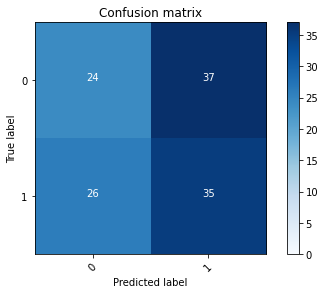

2022-08-22 14:25:59 - [Epoch Train: 53] loss: 0.0057, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:25:59 - [Epoch Valid: 53] loss: 2.4601, auc: 0.5101, acc: 0.4836, time: 6.00 s


 53%|██████████████████████▎                   | 53/100 [26:41<24:34, 31.38s/it]

2022-08-22 14:25:59 - EPOCH: 54
2022-08-22 14:26:01 - Train Step 10/121, train_loss: 0.0003
2022-08-22 14:26:03 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:26:05 - Train Step 30/121, train_loss: 0.0068
2022-08-22 14:26:07 - Train Step 40/121, train_loss: 0.0052
2022-08-22 14:26:10 - Train Step 50/121, train_loss: 0.0089
2022-08-22 14:26:12 - Train Step 60/121, train_loss: 0.0076
2022-08-22 14:26:14 - Train Step 70/121, train_loss: 0.0065
2022-08-22 14:26:16 - Train Step 80/121, train_loss: 0.0058
2022-08-22 14:26:18 - Train Step 90/121, train_loss: 0.0052
2022-08-22 14:26:20 - Train Step 100/121, train_loss: 0.0047
2022-08-22 14:26:22 - Train Step 110/121, train_loss: 0.0043
2022-08-22 14:26:24 - Train Step 120/121, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:26:26 - Valid Step 5/31, valid_loss: 1.2524
2022-08-22 14:26:27 - Valid Step 10/31, valid_loss: 2.1597
2022-08-22 14:26:28 - Valid Step 15/31, valid_loss: 2.5145
2022-08-22 14:26:29

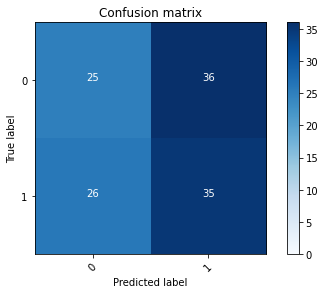

2022-08-22 14:26:31 - [Epoch Train: 54] loss: 0.0039, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:26:31 - [Epoch Valid: 54] loss: 2.4013, auc: 0.5069, acc: 0.4918, time: 6.00 s


 54%|██████████████████████▋                   | 54/100 [27:14<24:21, 31.78s/it]

2022-08-22 14:26:32 - EPOCH: 55
2022-08-22 14:26:34 - Train Step 10/121, train_loss: 0.0004
2022-08-22 14:26:36 - Train Step 20/121, train_loss: 0.0004
2022-08-22 14:26:38 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:26:40 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:26:42 - Train Step 50/121, train_loss: 0.0038
2022-08-22 14:26:44 - Train Step 60/121, train_loss: 0.0032
2022-08-22 14:26:47 - Train Step 70/121, train_loss: 0.0028
2022-08-22 14:26:49 - Train Step 80/121, train_loss: 0.0025
2022-08-22 14:26:51 - Train Step 90/121, train_loss: 0.0023
2022-08-22 14:26:53 - Train Step 100/121, train_loss: 0.0070
2022-08-22 14:26:55 - Train Step 110/121, train_loss: 0.0064
2022-08-22 14:26:57 - Train Step 120/121, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:26:59 - Valid Step 5/31, valid_loss: 1.8171
2022-08-22 14:27:00 - Valid Step 10/31, valid_loss: 1.9908
2022-08-22 14:27:01 - Valid Step 15/31, valid_loss: 2.1593
2022-08-22 14:27:02

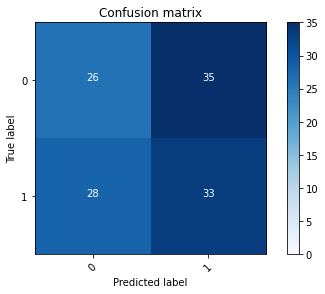

2022-08-22 14:27:04 - [Epoch Train: 55] loss: 0.0059, auc: 1.0000, acc: 0.9979, time: 26.00 s            
2022-08-22 14:27:04 - [Epoch Valid: 55] loss: 2.3409, auc: 0.5023, acc: 0.4836, time: 6.00 s


 55%|███████████████████████                   | 55/100 [27:47<24:02, 32.05s/it]

2022-08-22 14:27:04 - EPOCH: 56
2022-08-22 14:27:07 - Train Step 10/121, train_loss: 0.0004
2022-08-22 14:27:09 - Train Step 20/121, train_loss: 0.0004
2022-08-22 14:27:11 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:27:13 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:27:15 - Train Step 50/121, train_loss: 0.0004
2022-08-22 14:27:17 - Train Step 60/121, train_loss: 0.0004
2022-08-22 14:27:19 - Train Step 70/121, train_loss: 0.0004
2022-08-22 14:27:21 - Train Step 80/121, train_loss: 0.0004
2022-08-22 14:27:23 - Train Step 90/121, train_loss: 0.0020
2022-08-22 14:27:26 - Train Step 100/121, train_loss: 0.0018
2022-08-22 14:27:28 - Train Step 110/121, train_loss: 0.0044
2022-08-22 14:27:30 - Train Step 120/121, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:27:32 - Valid Step 5/31, valid_loss: 2.4301
2022-08-22 14:27:33 - Valid Step 10/31, valid_loss: 2.3623
2022-08-22 14:27:34 - Valid Step 15/31, valid_loss: 2.3750
2022-08-22 14:27:35

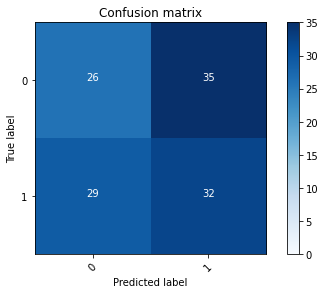

2022-08-22 14:27:37 - [Epoch Train: 56] loss: 0.0040, auc: 1.0000, acc: 0.9979, time: 26.00 s            
2022-08-22 14:27:37 - [Epoch Valid: 56] loss: 2.5389, auc: 0.5047, acc: 0.4754, time: 6.00 s


 56%|███████████████████████▌                  | 56/100 [28:19<23:39, 32.26s/it]

2022-08-22 14:27:37 - EPOCH: 57
2022-08-22 14:27:39 - Train Step 10/121, train_loss: 0.0003
2022-08-22 14:27:41 - Train Step 20/121, train_loss: 0.0005
2022-08-22 14:27:44 - Train Step 30/121, train_loss: 0.0004
2022-08-22 14:27:46 - Train Step 40/121, train_loss: 0.0004
2022-08-22 14:27:48 - Train Step 50/121, train_loss: 0.0004
2022-08-22 14:27:50 - Train Step 60/121, train_loss: 0.0057
2022-08-22 14:27:52 - Train Step 70/121, train_loss: 0.0049
2022-08-22 14:27:54 - Train Step 80/121, train_loss: 0.0043
2022-08-22 14:27:56 - Train Step 90/121, train_loss: 0.0067
2022-08-22 14:27:58 - Train Step 100/121, train_loss: 0.0061
2022-08-22 14:28:00 - Train Step 110/121, train_loss: 0.0055
2022-08-22 14:28:02 - Train Step 120/121, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:28:04 - Valid Step 5/31, valid_loss: 2.3941
2022-08-22 14:28:05 - Valid Step 10/31, valid_loss: 3.1257
2022-08-22 14:28:06 - Valid Step 15/31, valid_loss: 2.7809
2022-08-22 14:28:07

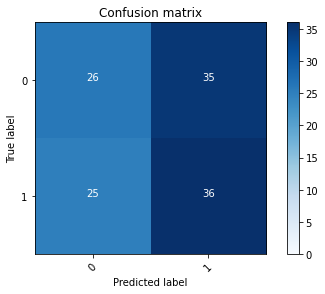

2022-08-22 14:28:10 - [Epoch Train: 57] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:28:10 - [Epoch Valid: 57] loss: 2.4022, auc: 0.5007, acc: 0.5082, time: 6.00 s


 57%|███████████████████████▉                  | 57/100 [28:52<23:11, 32.36s/it]

2022-08-22 14:28:10 - EPOCH: 58
2022-08-22 14:28:12 - Train Step 10/121, train_loss: 0.0006
2022-08-22 14:28:14 - Train Step 20/121, train_loss: 0.0005
2022-08-22 14:28:16 - Train Step 30/121, train_loss: 0.0005
2022-08-22 14:28:18 - Train Step 40/121, train_loss: 0.0068
2022-08-22 14:28:20 - Train Step 50/121, train_loss: 0.0094
2022-08-22 14:28:22 - Train Step 60/121, train_loss: 0.0079
2022-08-22 14:28:24 - Train Step 70/121, train_loss: 0.0068
2022-08-22 14:28:27 - Train Step 80/121, train_loss: 0.0060
2022-08-22 14:28:29 - Train Step 90/121, train_loss: 0.0054
2022-08-22 14:28:31 - Train Step 100/121, train_loss: 0.0048
2022-08-22 14:28:33 - Train Step 110/121, train_loss: 0.0044
2022-08-22 14:28:35 - Train Step 120/121, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:28:37 - Valid Step 5/31, valid_loss: 2.1158
2022-08-22 14:28:38 - Valid Step 10/31, valid_loss: 2.2650
2022-08-22 14:28:39 - Valid Step 15/31, valid_loss: 2.2880
2022-08-22 14:28:40

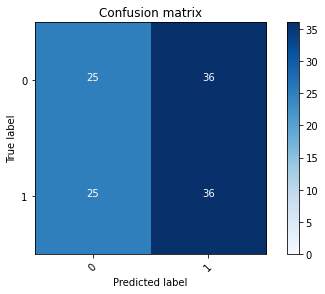

2022-08-22 14:28:42 - [Epoch Train: 58] loss: 0.0040, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:28:42 - [Epoch Valid: 58] loss: 2.5854, auc: 0.5047, acc: 0.5000, time: 6.00 s


 58%|████████████████████████▎                 | 58/100 [29:25<22:41, 32.41s/it]

2022-08-22 14:28:42 - EPOCH: 59
2022-08-22 14:28:44 - Train Step 10/121, train_loss: 0.0005
2022-08-22 14:28:46 - Train Step 20/121, train_loss: 0.0004
2022-08-22 14:28:49 - Train Step 30/121, train_loss: 0.0003
2022-08-22 14:28:51 - Train Step 40/121, train_loss: 0.0076
2022-08-22 14:28:53 - Train Step 50/121, train_loss: 0.0061
2022-08-22 14:28:55 - Train Step 60/121, train_loss: 0.0052
2022-08-22 14:28:57 - Train Step 70/121, train_loss: 0.0045
2022-08-22 14:28:59 - Train Step 80/121, train_loss: 0.0040
2022-08-22 14:29:01 - Train Step 90/121, train_loss: 0.0036
2022-08-22 14:29:03 - Train Step 100/121, train_loss: 0.0032
2022-08-22 14:29:05 - Train Step 110/121, train_loss: 0.0030
2022-08-22 14:29:07 - Train Step 120/121, train_loss: 0.0027
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:29:09 - Valid Step 5/31, valid_loss: 1.7775
2022-08-22 14:29:10 - Valid Step 10/31, valid_loss: 2.2249
2022-08-22 14:29:11 - Valid Step 15/31, valid_loss: 2.7561
2022-08-22 14:29:12

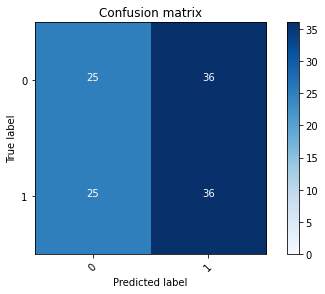

2022-08-22 14:29:14 - [Epoch Train: 59] loss: 0.0027, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 14:29:14 - [Epoch Valid: 59] loss: 2.6279, auc: 0.5020, acc: 0.5000, time: 6.00 s


 59%|████████████████████████▊                 | 59/100 [29:57<22:09, 32.41s/it]

2022-08-22 14:29:14 - EPOCH: 60
2022-08-22 14:29:17 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:29:19 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:29:21 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:29:23 - Train Step 40/121, train_loss: 0.0069
2022-08-22 14:29:25 - Train Step 50/121, train_loss: 0.0056
2022-08-22 14:29:27 - Train Step 60/121, train_loss: 0.0047
2022-08-22 14:29:29 - Train Step 70/121, train_loss: 0.0042
2022-08-22 14:29:31 - Train Step 80/121, train_loss: 0.0037
2022-08-22 14:29:34 - Train Step 90/121, train_loss: 0.0033
2022-08-22 14:29:36 - Train Step 100/121, train_loss: 0.0030
2022-08-22 14:29:38 - Train Step 110/121, train_loss: 0.0064
2022-08-22 14:29:40 - Train Step 120/121, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:29:42 - Valid Step 5/31, valid_loss: 1.8782
2022-08-22 14:29:42 - Valid Step 10/31, valid_loss: 2.1026
2022-08-22 14:29:44 - Valid Step 15/31, valid_loss: 2.3395
2022-08-22 14:29:44

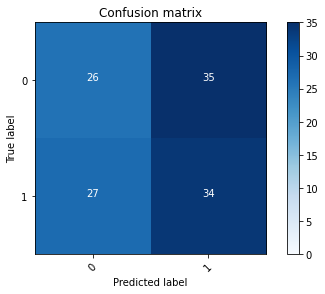

2022-08-22 14:29:47 - [Epoch Train: 60] loss: 0.0059, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:29:47 - [Epoch Valid: 60] loss: 2.4280, auc: 0.5001, acc: 0.4918, time: 6.00 s


 60%|█████████████████████████▏                | 60/100 [30:29<21:35, 32.39s/it]

2022-08-22 14:29:47 - EPOCH: 61
2022-08-22 14:29:49 - Train Step 10/121, train_loss: 0.0199
2022-08-22 14:29:51 - Train Step 20/121, train_loss: 0.0101
2022-08-22 14:29:53 - Train Step 30/121, train_loss: 0.0068
2022-08-22 14:29:55 - Train Step 40/121, train_loss: 0.0052
2022-08-22 14:29:58 - Train Step 50/121, train_loss: 0.0043
2022-08-22 14:30:00 - Train Step 60/121, train_loss: 0.0036
2022-08-22 14:30:02 - Train Step 70/121, train_loss: 0.0031
2022-08-22 14:30:04 - Train Step 80/121, train_loss: 0.0028
2022-08-22 14:30:06 - Train Step 90/121, train_loss: 0.0025
2022-08-22 14:30:08 - Train Step 100/121, train_loss: 0.0050
2022-08-22 14:30:10 - Train Step 110/121, train_loss: 0.0045
2022-08-22 14:30:12 - Train Step 120/121, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:30:14 - Valid Step 5/31, valid_loss: 2.9665
2022-08-22 14:30:15 - Valid Step 10/31, valid_loss: 2.6324
2022-08-22 14:30:16 - Valid Step 15/31, valid_loss: 2.5008
2022-08-22 14:30:17

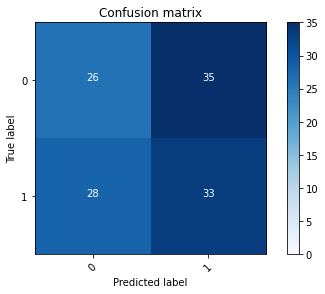

2022-08-22 14:30:19 - [Epoch Train: 61] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:30:19 - [Epoch Valid: 61] loss: 2.4277, auc: 0.5012, acc: 0.4836, time: 6.00 s


 61%|█████████████████████████▌                | 61/100 [31:02<21:02, 32.38s/it]

2022-08-22 14:30:19 - EPOCH: 62
2022-08-22 14:30:22 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:30:24 - Train Step 20/121, train_loss: 0.0182
2022-08-22 14:30:26 - Train Step 30/121, train_loss: 0.0122
2022-08-22 14:30:28 - Train Step 40/121, train_loss: 0.0092
2022-08-22 14:30:30 - Train Step 50/121, train_loss: 0.0075
2022-08-22 14:30:32 - Train Step 60/121, train_loss: 0.0062
2022-08-22 14:30:34 - Train Step 70/121, train_loss: 0.0054
2022-08-22 14:30:36 - Train Step 80/121, train_loss: 0.0090
2022-08-22 14:30:38 - Train Step 90/121, train_loss: 0.0081
2022-08-22 14:30:40 - Train Step 100/121, train_loss: 0.0073
2022-08-22 14:30:42 - Train Step 110/121, train_loss: 0.0066
2022-08-22 14:30:45 - Train Step 120/121, train_loss: 0.0061
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:30:46 - Valid Step 5/31, valid_loss: 2.8868
2022-08-22 14:30:47 - Valid Step 10/31, valid_loss: 2.2553
2022-08-22 14:30:48 - Valid Step 15/31, valid_loss: 2.4460
2022-08-22 14:30:49

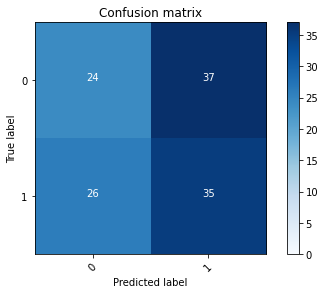

2022-08-22 14:30:52 - [Epoch Train: 62] loss: 0.0061, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:30:52 - [Epoch Valid: 62] loss: 2.5347, auc: 0.4996, acc: 0.4836, time: 6.00 s


 62%|██████████████████████████                | 62/100 [31:34<20:32, 32.42s/it]

2022-08-22 14:30:52 - EPOCH: 63
2022-08-22 14:30:54 - Train Step 10/121, train_loss: 0.0207
2022-08-22 14:30:56 - Train Step 20/121, train_loss: 0.0104
2022-08-22 14:30:58 - Train Step 30/121, train_loss: 0.0124
2022-08-22 14:31:00 - Train Step 40/121, train_loss: 0.0093
2022-08-22 14:31:02 - Train Step 50/121, train_loss: 0.0075
2022-08-22 14:31:05 - Train Step 60/121, train_loss: 0.0063
2022-08-22 14:31:07 - Train Step 70/121, train_loss: 0.0054
2022-08-22 14:31:09 - Train Step 80/121, train_loss: 0.0048
2022-08-22 14:31:11 - Train Step 90/121, train_loss: 0.0043
2022-08-22 14:31:13 - Train Step 100/121, train_loss: 0.0039
2022-08-22 14:31:15 - Train Step 110/121, train_loss: 0.0035
2022-08-22 14:31:17 - Train Step 120/121, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:31:19 - Valid Step 5/31, valid_loss: 1.7243
2022-08-22 14:31:20 - Valid Step 10/31, valid_loss: 1.7998
2022-08-22 14:31:21 - Valid Step 15/31, valid_loss: 1.8515
2022-08-22 14:31:22

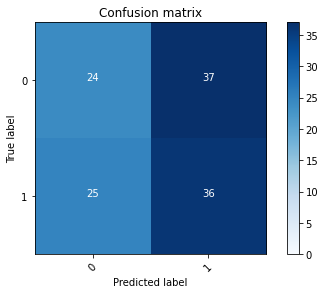

2022-08-22 14:31:24 - [Epoch Train: 63] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:31:24 - [Epoch Valid: 63] loss: 2.5278, auc: 0.5040, acc: 0.4918, time: 6.00 s


 63%|██████████████████████████▍               | 63/100 [32:07<19:58, 32.40s/it]

2022-08-22 14:31:24 - EPOCH: 64
2022-08-22 14:31:26 - Train Step 10/121, train_loss: 0.0108
2022-08-22 14:31:29 - Train Step 20/121, train_loss: 0.0055
2022-08-22 14:31:31 - Train Step 30/121, train_loss: 0.0037
2022-08-22 14:31:33 - Train Step 40/121, train_loss: 0.0028
2022-08-22 14:31:35 - Train Step 50/121, train_loss: 0.0023
2022-08-22 14:31:37 - Train Step 60/121, train_loss: 0.0020
2022-08-22 14:31:39 - Train Step 70/121, train_loss: 0.0017
2022-08-22 14:31:41 - Train Step 80/121, train_loss: 0.0015
2022-08-22 14:31:43 - Train Step 90/121, train_loss: 0.0014
2022-08-22 14:31:46 - Train Step 100/121, train_loss: 0.0013
2022-08-22 14:31:48 - Train Step 110/121, train_loss: 0.0012
2022-08-22 14:31:50 - Train Step 120/121, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:31:52 - Valid Step 5/31, valid_loss: 2.6866
2022-08-22 14:31:52 - Valid Step 10/31, valid_loss: 1.8695
2022-08-22 14:31:54 - Valid Step 15/31, valid_loss: 2.7115
2022-08-22 14:31:55

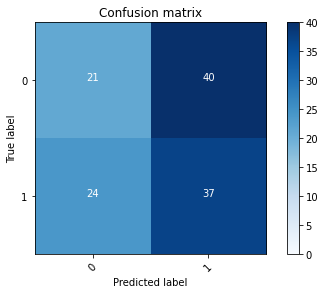

2022-08-22 14:31:57 - [Epoch Train: 64] loss: 0.0051, auc: 1.0000, acc: 0.9979, time: 26.00 s            
2022-08-22 14:31:57 - [Epoch Valid: 64] loss: 2.5683, auc: 0.5020, acc: 0.4754, time: 6.00 s


 64%|██████████████████████████▉               | 64/100 [32:39<19:31, 32.54s/it]

2022-08-22 14:31:57 - EPOCH: 65
2022-08-22 14:31:59 - Train Step 10/121, train_loss: 0.0240
2022-08-22 14:32:01 - Train Step 20/121, train_loss: 0.0121
2022-08-22 14:32:03 - Train Step 30/121, train_loss: 0.0082
2022-08-22 14:32:05 - Train Step 40/121, train_loss: 0.0062
2022-08-22 14:32:08 - Train Step 50/121, train_loss: 0.0050
2022-08-22 14:32:10 - Train Step 60/121, train_loss: 0.0042
2022-08-22 14:32:12 - Train Step 70/121, train_loss: 0.0036
2022-08-22 14:32:14 - Train Step 80/121, train_loss: 0.0032
2022-08-22 14:32:16 - Train Step 90/121, train_loss: 0.0028
2022-08-22 14:32:18 - Train Step 100/121, train_loss: 0.0047
2022-08-22 14:32:20 - Train Step 110/121, train_loss: 0.0043
2022-08-22 14:32:22 - Train Step 120/121, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:32:24 - Valid Step 5/31, valid_loss: 3.2289
2022-08-22 14:32:25 - Valid Step 10/31, valid_loss: 2.5895
2022-08-22 14:32:26 - Valid Step 15/31, valid_loss: 2.7128
2022-08-22 14:32:27

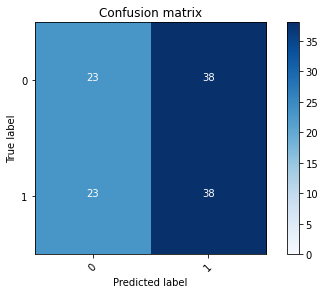

2022-08-22 14:32:30 - [Epoch Train: 65] loss: 0.0040, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:32:30 - [Epoch Valid: 65] loss: 2.7494, auc: 0.4949, acc: 0.5000, time: 6.00 s


 65%|███████████████████████████▎              | 65/100 [33:12<19:00, 32.58s/it]

2022-08-22 14:32:30 - EPOCH: 66
2022-08-22 14:32:32 - Train Step 10/121, train_loss: 0.0003
2022-08-22 14:32:34 - Train Step 20/121, train_loss: 0.0073
2022-08-22 14:32:36 - Train Step 30/121, train_loss: 0.0050
2022-08-22 14:32:38 - Train Step 40/121, train_loss: 0.0038
2022-08-22 14:32:40 - Train Step 50/121, train_loss: 0.0031
2022-08-22 14:32:42 - Train Step 60/121, train_loss: 0.0026
2022-08-22 14:32:45 - Train Step 70/121, train_loss: 0.0023
2022-08-22 14:32:47 - Train Step 80/121, train_loss: 0.0066
2022-08-22 14:32:49 - Train Step 90/121, train_loss: 0.0059
2022-08-22 14:32:51 - Train Step 100/121, train_loss: 0.0053
2022-08-22 14:32:53 - Train Step 110/121, train_loss: 0.0049
2022-08-22 14:32:55 - Train Step 120/121, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:32:57 - Valid Step 5/31, valid_loss: 3.0824
2022-08-22 14:32:58 - Valid Step 10/31, valid_loss: 2.2627
2022-08-22 14:32:59 - Valid Step 15/31, valid_loss: 2.7099
2022-08-22 14:33:00

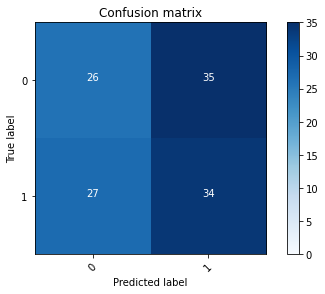

2022-08-22 14:33:02 - [Epoch Train: 66] loss: 0.0045, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:33:02 - [Epoch Valid: 66] loss: 2.6120, auc: 0.4934, acc: 0.4918, time: 6.00 s


 66%|███████████████████████████▋              | 66/100 [33:45<18:26, 32.54s/it]

2022-08-22 14:33:02 - EPOCH: 67
2022-08-22 14:33:04 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:33:06 - Train Step 20/121, train_loss: 0.0122
2022-08-22 14:33:09 - Train Step 30/121, train_loss: 0.0082
2022-08-22 14:33:11 - Train Step 40/121, train_loss: 0.0062
2022-08-22 14:33:13 - Train Step 50/121, train_loss: 0.0101
2022-08-22 14:33:15 - Train Step 60/121, train_loss: 0.0084
2022-08-22 14:33:17 - Train Step 70/121, train_loss: 0.0073
2022-08-22 14:33:19 - Train Step 80/121, train_loss: 0.0064
2022-08-22 14:33:21 - Train Step 90/121, train_loss: 0.0057
2022-08-22 14:33:23 - Train Step 100/121, train_loss: 0.0052
2022-08-22 14:33:25 - Train Step 110/121, train_loss: 0.0047
2022-08-22 14:33:27 - Train Step 120/121, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:33:29 - Valid Step 5/31, valid_loss: 3.8533
2022-08-22 14:33:30 - Valid Step 10/31, valid_loss: 3.7265
2022-08-22 14:33:31 - Valid Step 15/31, valid_loss: 3.4494
2022-08-22 14:33:32

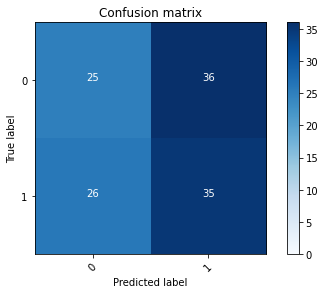

2022-08-22 14:33:34 - [Epoch Train: 67] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:33:34 - [Epoch Valid: 67] loss: 2.6899, auc: 0.4950, acc: 0.4918, time: 6.00 s


 67%|████████████████████████████▏             | 67/100 [34:17<17:52, 32.49s/it]

2022-08-22 14:33:34 - EPOCH: 68
2022-08-22 14:33:37 - Train Step 10/121, train_loss: 0.0004
2022-08-22 14:33:39 - Train Step 20/121, train_loss: 0.0003
2022-08-22 14:33:41 - Train Step 30/121, train_loss: 0.0003
2022-08-22 14:33:43 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:33:45 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:33:47 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:33:49 - Train Step 70/121, train_loss: 0.0042
2022-08-22 14:33:51 - Train Step 80/121, train_loss: 0.0037
2022-08-22 14:33:54 - Train Step 90/121, train_loss: 0.0033
2022-08-22 14:33:56 - Train Step 100/121, train_loss: 0.0030
2022-08-22 14:33:58 - Train Step 110/121, train_loss: 0.0027
2022-08-22 14:34:00 - Train Step 120/121, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:34:02 - Valid Step 5/31, valid_loss: 1.7673
2022-08-22 14:34:03 - Valid Step 10/31, valid_loss: 2.9090
2022-08-22 14:34:04 - Valid Step 15/31, valid_loss: 3.1206
2022-08-22 14:34:05

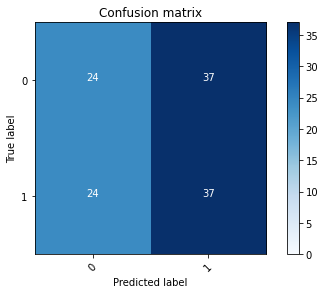

2022-08-22 14:34:07 - [Epoch Train: 68] loss: 0.0052, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:34:07 - [Epoch Valid: 68] loss: 2.8110, auc: 0.4930, acc: 0.5000, time: 6.00 s


 68%|████████████████████████████▌             | 68/100 [34:50<17:20, 32.52s/it]

2022-08-22 14:34:07 - EPOCH: 69
2022-08-22 14:34:09 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:34:11 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:34:14 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:34:16 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:34:18 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:34:20 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:34:22 - Train Step 70/121, train_loss: 0.0002
2022-08-22 14:34:24 - Train Step 80/121, train_loss: 0.0002
2022-08-22 14:34:26 - Train Step 90/121, train_loss: 0.0032
2022-08-22 14:34:28 - Train Step 100/121, train_loss: 0.0029
2022-08-22 14:34:30 - Train Step 110/121, train_loss: 0.0026
2022-08-22 14:34:32 - Train Step 120/121, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:34:34 - Valid Step 5/31, valid_loss: 3.1463
2022-08-22 14:34:35 - Valid Step 10/31, valid_loss: 3.6696
2022-08-22 14:34:36 - Valid Step 15/31, valid_loss: 3.0986
2022-08-22 14:34:37

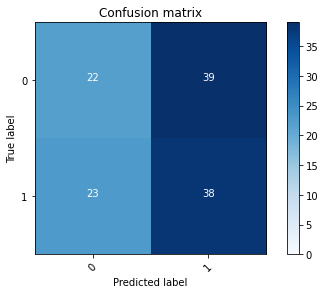

2022-08-22 14:34:39 - [Epoch Train: 69] loss: 0.0048, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:34:39 - [Epoch Valid: 69] loss: 2.7754, auc: 0.5019, acc: 0.4918, time: 6.00 s


 69%|████████████████████████████▉             | 69/100 [35:22<16:46, 32.48s/it]

2022-08-22 14:34:39 - EPOCH: 70
2022-08-22 14:34:42 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:34:44 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:34:46 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:34:48 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:34:50 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:34:52 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:34:54 - Train Step 70/121, train_loss: 0.0020
2022-08-22 14:34:56 - Train Step 80/121, train_loss: 0.0018
2022-08-22 14:34:58 - Train Step 90/121, train_loss: 0.0048
2022-08-22 14:35:01 - Train Step 100/121, train_loss: 0.0043
2022-08-22 14:35:03 - Train Step 110/121, train_loss: 0.0040
2022-08-22 14:35:05 - Train Step 120/121, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:35:06 - Valid Step 5/31, valid_loss: 3.2607
2022-08-22 14:35:07 - Valid Step 10/31, valid_loss: 3.0366
2022-08-22 14:35:08 - Valid Step 15/31, valid_loss: 3.1005
2022-08-22 14:35:09

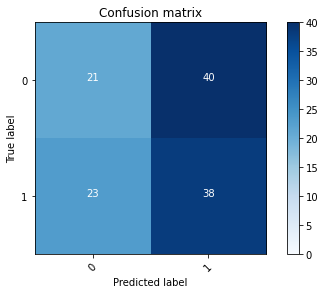

2022-08-22 14:35:12 - [Epoch Train: 70] loss: 0.0036, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:35:12 - [Epoch Valid: 70] loss: 2.6916, auc: 0.5028, acc: 0.4836, time: 6.00 s


 70%|█████████████████████████████▍            | 70/100 [35:54<16:13, 32.43s/it]

2022-08-22 14:35:12 - EPOCH: 71
2022-08-22 14:35:14 - Train Step 10/121, train_loss: 0.0199
2022-08-22 14:35:16 - Train Step 20/121, train_loss: 0.0100
2022-08-22 14:35:18 - Train Step 30/121, train_loss: 0.0067
2022-08-22 14:35:20 - Train Step 40/121, train_loss: 0.0051
2022-08-22 14:35:22 - Train Step 50/121, train_loss: 0.0041
2022-08-22 14:35:24 - Train Step 60/121, train_loss: 0.0035
2022-08-22 14:35:27 - Train Step 70/121, train_loss: 0.0030
2022-08-22 14:35:29 - Train Step 80/121, train_loss: 0.0027
2022-08-22 14:35:31 - Train Step 90/121, train_loss: 0.0024
2022-08-22 14:35:33 - Train Step 100/121, train_loss: 0.0022
2022-08-22 14:35:35 - Train Step 110/121, train_loss: 0.0040
2022-08-22 14:35:37 - Train Step 120/121, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:35:39 - Valid Step 5/31, valid_loss: 4.0777
2022-08-22 14:35:40 - Valid Step 10/31, valid_loss: 3.2929
2022-08-22 14:35:41 - Valid Step 15/31, valid_loss: 2.8343
2022-08-22 14:35:42

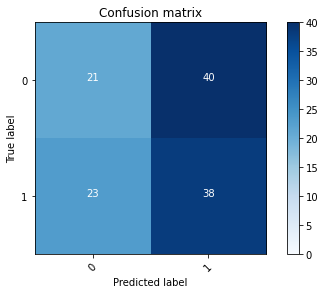

2022-08-22 14:35:44 - [Epoch Train: 71] loss: 0.0037, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:35:44 - [Epoch Valid: 71] loss: 2.7787, auc: 0.5000, acc: 0.4836, time: 6.00 s


 71%|█████████████████████████████▊            | 71/100 [36:27<15:42, 32.52s/it]

2022-08-22 14:35:44 - EPOCH: 72
2022-08-22 14:35:47 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:35:49 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:35:51 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:35:53 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:35:55 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:35:57 - Train Step 60/121, train_loss: 0.0022
2022-08-22 14:35:59 - Train Step 70/121, train_loss: 0.0019
2022-08-22 14:36:01 - Train Step 80/121, train_loss: 0.0017
2022-08-22 14:36:04 - Train Step 90/121, train_loss: 0.0016
2022-08-22 14:36:06 - Train Step 100/121, train_loss: 0.0014
2022-08-22 14:36:08 - Train Step 110/121, train_loss: 0.0038
2022-08-22 14:36:10 - Train Step 120/121, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:36:12 - Valid Step 5/31, valid_loss: 3.1231
2022-08-22 14:36:12 - Valid Step 10/31, valid_loss: 2.5093
2022-08-22 14:36:14 - Valid Step 15/31, valid_loss: 2.6825
2022-08-22 14:36:14

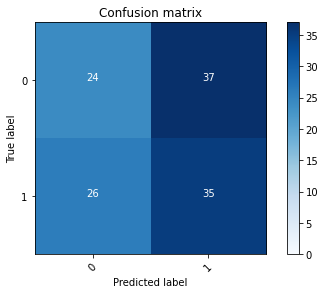

2022-08-22 14:36:17 - [Epoch Train: 72] loss: 0.0035, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:36:17 - [Epoch Valid: 72] loss: 2.7106, auc: 0.4923, acc: 0.4836, time: 6.00 s


 72%|██████████████████████████████▏           | 72/100 [36:59<15:09, 32.49s/it]

2022-08-22 14:36:17 - EPOCH: 73
2022-08-22 14:36:19 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:36:21 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:36:23 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:36:25 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:36:27 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:36:30 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:36:32 - Train Step 70/121, train_loss: 0.0002
2022-08-22 14:36:34 - Train Step 80/121, train_loss: 0.0019
2022-08-22 14:36:36 - Train Step 90/121, train_loss: 0.0017
2022-08-22 14:36:38 - Train Step 100/121, train_loss: 0.0016
2022-08-22 14:36:40 - Train Step 110/121, train_loss: 0.0045
2022-08-22 14:36:42 - Train Step 120/121, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:36:44 - Valid Step 5/31, valid_loss: 3.9138
2022-08-22 14:36:45 - Valid Step 10/31, valid_loss: 2.8604
2022-08-22 14:36:46 - Valid Step 15/31, valid_loss: 2.9304
2022-08-22 14:36:47

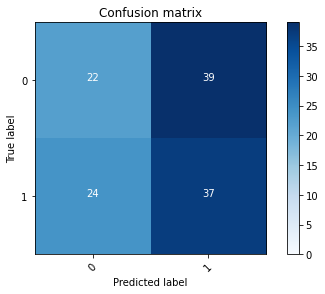

2022-08-22 14:36:49 - [Epoch Train: 73] loss: 0.0041, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:36:49 - [Epoch Valid: 73] loss: 2.8512, auc: 0.4970, acc: 0.4836, time: 6.00 s


 73%|██████████████████████████████▋           | 73/100 [37:32<14:37, 32.52s/it]

2022-08-22 14:36:49 - EPOCH: 74
2022-08-22 14:36:52 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:36:54 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:36:56 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:36:58 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:37:00 - Train Step 50/121, train_loss: 0.0048
2022-08-22 14:37:02 - Train Step 60/121, train_loss: 0.0040
2022-08-22 14:37:04 - Train Step 70/121, train_loss: 0.0035
2022-08-22 14:37:06 - Train Step 80/121, train_loss: 0.0031
2022-08-22 14:37:08 - Train Step 90/121, train_loss: 0.0057
2022-08-22 14:37:11 - Train Step 100/121, train_loss: 0.0051
2022-08-22 14:37:13 - Train Step 110/121, train_loss: 0.0047
2022-08-22 14:37:15 - Train Step 120/121, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:37:16 - Valid Step 5/31, valid_loss: 3.7772
2022-08-22 14:37:17 - Valid Step 10/31, valid_loss: 2.9595
2022-08-22 14:37:19 - Valid Step 15/31, valid_loss: 2.7349
2022-08-22 14:37:19

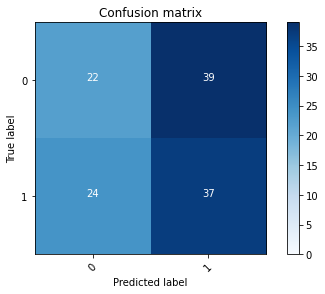

2022-08-22 14:37:22 - [Epoch Train: 74] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:37:22 - [Epoch Valid: 74] loss: 2.8848, auc: 0.4941, acc: 0.4836, time: 6.00 s


 74%|███████████████████████████████           | 74/100 [38:04<14:04, 32.49s/it]

2022-08-22 14:37:22 - EPOCH: 75
2022-08-22 14:37:24 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:37:26 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:37:28 - Train Step 30/121, train_loss: 0.0077
2022-08-22 14:37:31 - Train Step 40/121, train_loss: 0.0096
2022-08-22 14:37:33 - Train Step 50/121, train_loss: 0.0077
2022-08-22 14:37:35 - Train Step 60/121, train_loss: 0.0065
2022-08-22 14:37:37 - Train Step 70/121, train_loss: 0.0055
2022-08-22 14:37:39 - Train Step 80/121, train_loss: 0.0049
2022-08-22 14:37:41 - Train Step 90/121, train_loss: 0.0044
2022-08-22 14:37:43 - Train Step 100/121, train_loss: 0.0039
2022-08-22 14:37:45 - Train Step 110/121, train_loss: 0.0036
2022-08-22 14:37:47 - Train Step 120/121, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:37:49 - Valid Step 5/31, valid_loss: 4.5324
2022-08-22 14:37:50 - Valid Step 10/31, valid_loss: 3.5196
2022-08-22 14:37:51 - Valid Step 15/31, valid_loss: 3.0297
2022-08-22 14:37:52

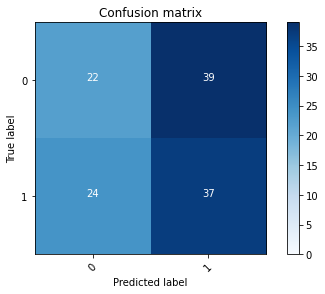

2022-08-22 14:37:54 - [Epoch Train: 75] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:37:54 - [Epoch Valid: 75] loss: 2.7611, auc: 0.4938, acc: 0.4836, time: 6.00 s


 75%|███████████████████████████████▌          | 75/100 [38:37<13:31, 32.47s/it]

2022-08-22 14:37:54 - EPOCH: 76
2022-08-22 14:37:57 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:37:59 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:38:01 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:38:03 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:38:05 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:38:07 - Train Step 60/121, train_loss: 0.0036
2022-08-22 14:38:09 - Train Step 70/121, train_loss: 0.0057
2022-08-22 14:38:11 - Train Step 80/121, train_loss: 0.0050
2022-08-22 14:38:13 - Train Step 90/121, train_loss: 0.0044
2022-08-22 14:38:15 - Train Step 100/121, train_loss: 0.0040
2022-08-22 14:38:17 - Train Step 110/121, train_loss: 0.0037
2022-08-22 14:38:20 - Train Step 120/121, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:38:21 - Valid Step 5/31, valid_loss: 2.8539
2022-08-22 14:38:22 - Valid Step 10/31, valid_loss: 2.2049
2022-08-22 14:38:23 - Valid Step 15/31, valid_loss: 2.1557
2022-08-22 14:38:24

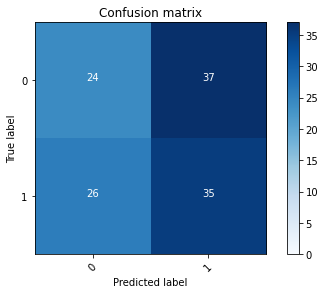

2022-08-22 14:38:26 - [Epoch Train: 76] loss: 0.0033, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:38:26 - [Epoch Valid: 76] loss: 2.6947, auc: 0.4965, acc: 0.4836, time: 6.00 s


 76%|███████████████████████████████▉          | 76/100 [39:09<12:57, 32.39s/it]

2022-08-22 14:38:26 - EPOCH: 77
2022-08-22 14:38:29 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:38:31 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:38:33 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:38:35 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:38:37 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:38:39 - Train Step 60/121, train_loss: 0.0037
2022-08-22 14:38:41 - Train Step 70/121, train_loss: 0.0032
2022-08-22 14:38:44 - Train Step 80/121, train_loss: 0.0028
2022-08-22 14:38:46 - Train Step 90/121, train_loss: 0.0025
2022-08-22 14:38:48 - Train Step 100/121, train_loss: 0.0023
2022-08-22 14:38:50 - Train Step 110/121, train_loss: 0.0021
2022-08-22 14:38:52 - Train Step 120/121, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:38:54 - Valid Step 5/31, valid_loss: 2.7277
2022-08-22 14:38:54 - Valid Step 10/31, valid_loss: 2.5430
2022-08-22 14:38:56 - Valid Step 15/31, valid_loss: 2.9637
2022-08-22 14:38:57

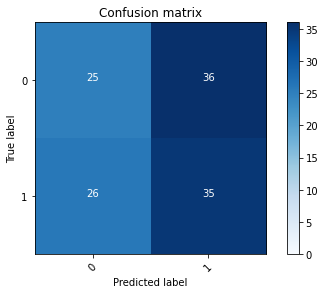

2022-08-22 14:38:59 - [Epoch Train: 77] loss: 0.0036, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:38:59 - [Epoch Valid: 77] loss: 2.6888, auc: 0.4962, acc: 0.4918, time: 6.00 s


 77%|████████████████████████████████▎         | 77/100 [39:42<12:25, 32.43s/it]

2022-08-22 14:38:59 - EPOCH: 78
2022-08-22 14:39:01 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:39:03 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:39:05 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:39:08 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:39:10 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:39:12 - Train Step 60/121, train_loss: 0.0029
2022-08-22 14:39:14 - Train Step 70/121, train_loss: 0.0025
2022-08-22 14:39:16 - Train Step 80/121, train_loss: 0.0022
2022-08-22 14:39:18 - Train Step 90/121, train_loss: 0.0020
2022-08-22 14:39:20 - Train Step 100/121, train_loss: 0.0033
2022-08-22 14:39:22 - Train Step 110/121, train_loss: 0.0030
2022-08-22 14:39:24 - Train Step 120/121, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:39:26 - Valid Step 5/31, valid_loss: 2.8174
2022-08-22 14:39:27 - Valid Step 10/31, valid_loss: 2.9670
2022-08-22 14:39:28 - Valid Step 15/31, valid_loss: 2.8309
2022-08-22 14:39:29

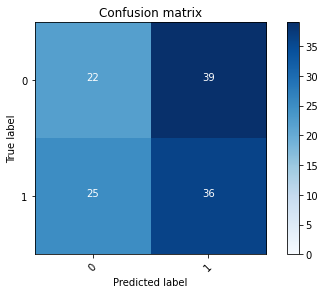

2022-08-22 14:39:32 - [Epoch Train: 78] loss: 0.0028, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 14:39:32 - [Epoch Valid: 78] loss: 2.7378, auc: 0.4927, acc: 0.4754, time: 6.00 s


 78%|████████████████████████████████▊         | 78/100 [40:14<11:53, 32.45s/it]

2022-08-22 14:39:32 - EPOCH: 79
2022-08-22 14:39:34 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:39:36 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:39:38 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:39:40 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:39:42 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:39:44 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:39:46 - Train Step 70/121, train_loss: 0.0002
2022-08-22 14:39:48 - Train Step 80/121, train_loss: 0.0002
2022-08-22 14:39:51 - Train Step 90/121, train_loss: 0.0027
2022-08-22 14:39:53 - Train Step 100/121, train_loss: 0.0074
2022-08-22 14:39:55 - Train Step 110/121, train_loss: 0.0067
2022-08-22 14:39:57 - Train Step 120/121, train_loss: 0.0062
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:39:58 - Valid Step 5/31, valid_loss: 3.3906
2022-08-22 14:39:59 - Valid Step 10/31, valid_loss: 2.4905
2022-08-22 14:40:00 - Valid Step 15/31, valid_loss: 2.7669
2022-08-22 14:40:01

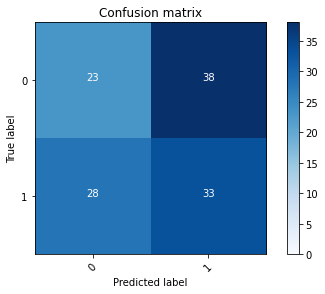

2022-08-22 14:40:04 - [Epoch Train: 79] loss: 0.0061, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:40:04 - [Epoch Valid: 79] loss: 2.9309, auc: 0.4919, acc: 0.4590, time: 6.00 s


 79%|█████████████████████████████████▏        | 79/100 [40:46<11:20, 32.39s/it]

2022-08-22 14:40:04 - EPOCH: 80
2022-08-22 14:40:06 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:40:08 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:40:10 - Train Step 30/121, train_loss: 0.0048
2022-08-22 14:40:12 - Train Step 40/121, train_loss: 0.0036
2022-08-22 14:40:14 - Train Step 50/121, train_loss: 0.0029
2022-08-22 14:40:16 - Train Step 60/121, train_loss: 0.0025
2022-08-22 14:40:19 - Train Step 70/121, train_loss: 0.0021
2022-08-22 14:40:21 - Train Step 80/121, train_loss: 0.0019
2022-08-22 14:40:23 - Train Step 90/121, train_loss: 0.0017
2022-08-22 14:40:25 - Train Step 100/121, train_loss: 0.0015
2022-08-22 14:40:27 - Train Step 110/121, train_loss: 0.0014
2022-08-22 14:40:29 - Train Step 120/121, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:40:31 - Valid Step 5/31, valid_loss: 2.0936
2022-08-22 14:40:32 - Valid Step 10/31, valid_loss: 2.6980
2022-08-22 14:40:33 - Valid Step 15/31, valid_loss: 2.4871
2022-08-22 14:40:34

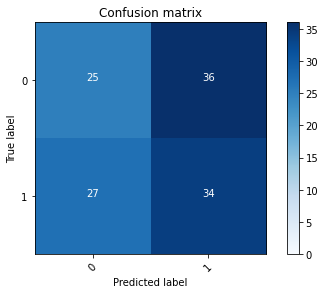

2022-08-22 14:40:36 - [Epoch Train: 80] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:40:36 - [Epoch Valid: 80] loss: 2.7771, auc: 0.4898, acc: 0.4836, time: 6.00 s


 80%|█████████████████████████████████▌        | 80/100 [41:18<10:46, 32.33s/it]

2022-08-22 14:40:36 - EPOCH: 81
2022-08-22 14:40:38 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:40:40 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:40:42 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:40:44 - Train Step 40/121, train_loss: 0.0068
2022-08-22 14:40:47 - Train Step 50/121, train_loss: 0.0055
2022-08-22 14:40:49 - Train Step 60/121, train_loss: 0.0046
2022-08-22 14:40:51 - Train Step 70/121, train_loss: 0.0091
2022-08-22 14:40:53 - Train Step 80/121, train_loss: 0.0079
2022-08-22 14:40:55 - Train Step 90/121, train_loss: 0.0071
2022-08-22 14:40:57 - Train Step 100/121, train_loss: 0.0064
2022-08-22 14:40:59 - Train Step 110/121, train_loss: 0.0058
2022-08-22 14:41:01 - Train Step 120/121, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:41:03 - Valid Step 5/31, valid_loss: 4.5649
2022-08-22 14:41:04 - Valid Step 10/31, valid_loss: 3.3493
2022-08-22 14:41:05 - Valid Step 15/31, valid_loss: 3.4865
2022-08-22 14:41:06

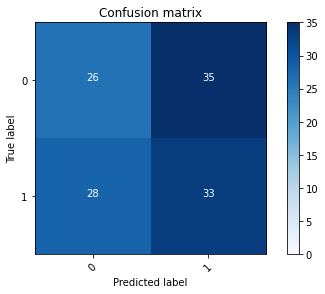

2022-08-22 14:41:08 - [Epoch Train: 81] loss: 0.0053, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:41:08 - [Epoch Valid: 81] loss: 2.9443, auc: 0.4944, acc: 0.4836, time: 6.00 s


 81%|██████████████████████████████████        | 81/100 [41:51<10:13, 32.30s/it]

2022-08-22 14:41:08 - EPOCH: 82
2022-08-22 14:41:10 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:41:13 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:41:15 - Train Step 30/121, train_loss: 0.0106
2022-08-22 14:41:17 - Train Step 40/121, train_loss: 0.0127
2022-08-22 14:41:19 - Train Step 50/121, train_loss: 0.0102
2022-08-22 14:41:21 - Train Step 60/121, train_loss: 0.0085
2022-08-22 14:41:23 - Train Step 70/121, train_loss: 0.0073
2022-08-22 14:41:25 - Train Step 80/121, train_loss: 0.0064
2022-08-22 14:41:27 - Train Step 90/121, train_loss: 0.0057
2022-08-22 14:41:29 - Train Step 100/121, train_loss: 0.0052
2022-08-22 14:41:31 - Train Step 110/121, train_loss: 0.0047
2022-08-22 14:41:33 - Train Step 120/121, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:41:35 - Valid Step 5/31, valid_loss: 2.1800
2022-08-22 14:41:36 - Valid Step 10/31, valid_loss: 2.6558
2022-08-22 14:41:37 - Valid Step 15/31, valid_loss: 2.8616
2022-08-22 14:41:38

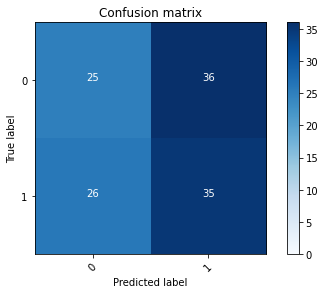

2022-08-22 14:41:40 - [Epoch Train: 82] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:41:40 - [Epoch Valid: 82] loss: 2.8731, auc: 0.4976, acc: 0.4918, time: 6.00 s


 82%|██████████████████████████████████▍       | 82/100 [42:23<09:41, 32.31s/it]

2022-08-22 14:41:40 - EPOCH: 83
2022-08-22 14:41:43 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:41:45 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:41:47 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:41:49 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:41:51 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:41:53 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:41:56 - Train Step 70/121, train_loss: 0.0060
2022-08-22 14:41:58 - Train Step 80/121, train_loss: 0.0053
2022-08-22 14:42:00 - Train Step 90/121, train_loss: 0.0047
2022-08-22 14:42:02 - Train Step 100/121, train_loss: 0.0042
2022-08-22 14:42:04 - Train Step 110/121, train_loss: 0.0039
2022-08-22 14:42:06 - Train Step 120/121, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:42:08 - Valid Step 5/31, valid_loss: 2.7535
2022-08-22 14:42:09 - Valid Step 10/31, valid_loss: 3.1408
2022-08-22 14:42:10 - Valid Step 15/31, valid_loss: 3.0455
2022-08-22 14:42:11

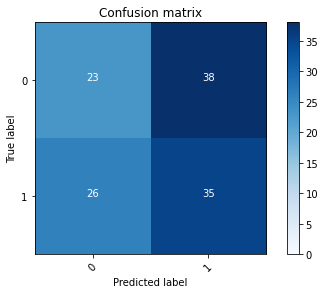

2022-08-22 14:42:13 - [Epoch Train: 83] loss: 0.0035, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:42:13 - [Epoch Valid: 83] loss: 2.9085, auc: 0.4909, acc: 0.4754, time: 6.00 s


 83%|██████████████████████████████████▊       | 83/100 [42:56<09:11, 32.43s/it]

2022-08-22 14:42:13 - EPOCH: 84
2022-08-22 14:42:16 - Train Step 10/121, train_loss: 0.0164
2022-08-22 14:42:18 - Train Step 20/121, train_loss: 0.0082
2022-08-22 14:42:20 - Train Step 30/121, train_loss: 0.0055
2022-08-22 14:42:22 - Train Step 40/121, train_loss: 0.0042
2022-08-22 14:42:24 - Train Step 50/121, train_loss: 0.0034
2022-08-22 14:42:26 - Train Step 60/121, train_loss: 0.0028
2022-08-22 14:42:28 - Train Step 70/121, train_loss: 0.0063
2022-08-22 14:42:30 - Train Step 80/121, train_loss: 0.0055
2022-08-22 14:42:32 - Train Step 90/121, train_loss: 0.0049
2022-08-22 14:42:34 - Train Step 100/121, train_loss: 0.0045
2022-08-22 14:42:37 - Train Step 110/121, train_loss: 0.0041
2022-08-22 14:42:39 - Train Step 120/121, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:42:40 - Valid Step 5/31, valid_loss: 3.1012
2022-08-22 14:42:41 - Valid Step 10/31, valid_loss: 3.2323
2022-08-22 14:42:42 - Valid Step 15/31, valid_loss: 3.0103
2022-08-22 14:42:43

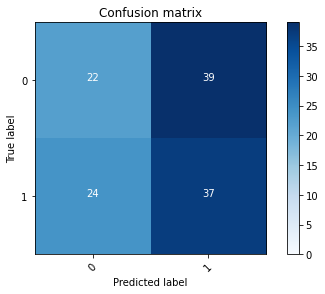

2022-08-22 14:42:45 - [Epoch Train: 84] loss: 0.0037, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:42:45 - [Epoch Valid: 84] loss: 3.0832, auc: 0.4996, acc: 0.4836, time: 6.00 s


 84%|███████████████████████████████████▎      | 84/100 [43:28<08:38, 32.38s/it]

2022-08-22 14:42:45 - EPOCH: 85
2022-08-22 14:42:48 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:42:50 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:42:52 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:42:54 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:42:56 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:42:58 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:43:00 - Train Step 70/121, train_loss: 0.0001
2022-08-22 14:43:03 - Train Step 80/121, train_loss: 0.0001
2022-08-22 14:43:05 - Train Step 90/121, train_loss: 0.0024
2022-08-22 14:43:07 - Train Step 100/121, train_loss: 0.0022
2022-08-22 14:43:09 - Train Step 110/121, train_loss: 0.0020
2022-08-22 14:43:11 - Train Step 120/121, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:43:13 - Valid Step 5/31, valid_loss: 2.9671
2022-08-22 14:43:14 - Valid Step 10/31, valid_loss: 3.1464
2022-08-22 14:43:15 - Valid Step 15/31, valid_loss: 2.9694
2022-08-22 14:43:16

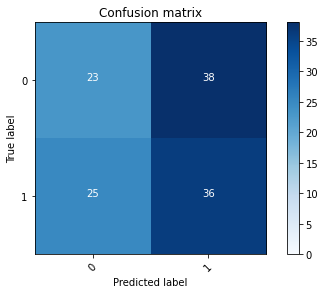

2022-08-22 14:43:18 - [Epoch Train: 85] loss: 0.0053, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:43:18 - [Epoch Valid: 85] loss: 2.8782, auc: 0.4954, acc: 0.4836, time: 6.00 s


 85%|███████████████████████████████████▋      | 85/100 [44:01<08:06, 32.41s/it]

2022-08-22 14:43:18 - EPOCH: 86
2022-08-22 14:43:20 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:43:22 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:43:24 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:43:26 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:43:29 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:43:31 - Train Step 60/121, train_loss: 0.0002
2022-08-22 14:43:33 - Train Step 70/121, train_loss: 0.0002
2022-08-22 14:43:35 - Train Step 80/121, train_loss: 0.0027
2022-08-22 14:43:37 - Train Step 90/121, train_loss: 0.0058
2022-08-22 14:43:39 - Train Step 100/121, train_loss: 0.0052
2022-08-22 14:43:41 - Train Step 110/121, train_loss: 0.0047
2022-08-22 14:43:43 - Train Step 120/121, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:43:45 - Valid Step 5/31, valid_loss: 2.3934
2022-08-22 14:43:46 - Valid Step 10/31, valid_loss: 2.8093
2022-08-22 14:43:47 - Valid Step 15/31, valid_loss: 2.9056
2022-08-22 14:43:48

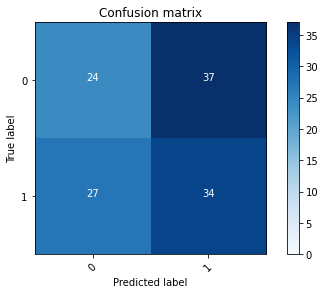

2022-08-22 14:43:50 - [Epoch Train: 86] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:43:50 - [Epoch Valid: 86] loss: 2.8173, auc: 0.4934, acc: 0.4754, time: 6.00 s


 86%|████████████████████████████████████      | 86/100 [44:33<07:33, 32.38s/it]

2022-08-22 14:43:50 - EPOCH: 87
2022-08-22 14:43:53 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:43:55 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:43:57 - Train Step 30/121, train_loss: 0.0069
2022-08-22 14:43:59 - Train Step 40/121, train_loss: 0.0052
2022-08-22 14:44:01 - Train Step 50/121, train_loss: 0.0089
2022-08-22 14:44:03 - Train Step 60/121, train_loss: 0.0074
2022-08-22 14:44:05 - Train Step 70/121, train_loss: 0.0064
2022-08-22 14:44:07 - Train Step 80/121, train_loss: 0.0056
2022-08-22 14:44:10 - Train Step 90/121, train_loss: 0.0050
2022-08-22 14:44:12 - Train Step 100/121, train_loss: 0.0045
2022-08-22 14:44:14 - Train Step 110/121, train_loss: 0.0041
2022-08-22 14:44:16 - Train Step 120/121, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:44:18 - Valid Step 5/31, valid_loss: 1.9737
2022-08-22 14:44:19 - Valid Step 10/31, valid_loss: 2.3144
2022-08-22 14:44:20 - Valid Step 15/31, valid_loss: 2.1610
2022-08-22 14:44:21

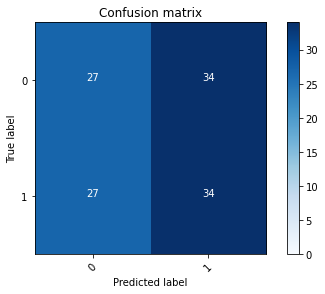

2022-08-22 14:44:23 - [Epoch Train: 87] loss: 0.0037, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:44:23 - [Epoch Valid: 87] loss: 2.9533, auc: 0.4906, acc: 0.5000, time: 6.00 s


 87%|████████████████████████████████████▌     | 87/100 [45:05<07:02, 32.47s/it]

2022-08-22 14:44:23 - EPOCH: 88
2022-08-22 14:44:25 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:44:27 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:44:29 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:44:32 - Train Step 40/121, train_loss: 0.0055
2022-08-22 14:44:34 - Train Step 50/121, train_loss: 0.0044
2022-08-22 14:44:36 - Train Step 60/121, train_loss: 0.0075
2022-08-22 14:44:38 - Train Step 70/121, train_loss: 0.0064
2022-08-22 14:44:40 - Train Step 80/121, train_loss: 0.0057
2022-08-22 14:44:42 - Train Step 90/121, train_loss: 0.0050
2022-08-22 14:44:44 - Train Step 100/121, train_loss: 0.0045
2022-08-22 14:44:46 - Train Step 110/121, train_loss: 0.0042
2022-08-22 14:44:48 - Train Step 120/121, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:44:50 - Valid Step 5/31, valid_loss: 3.7634
2022-08-22 14:44:51 - Valid Step 10/31, valid_loss: 3.1286
2022-08-22 14:44:52 - Valid Step 15/31, valid_loss: 3.1964
2022-08-22 14:44:53

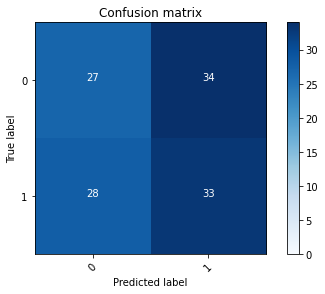

2022-08-22 14:44:55 - [Epoch Train: 88] loss: 0.0038, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:44:55 - [Epoch Valid: 88] loss: 2.8538, auc: 0.4957, acc: 0.4918, time: 6.00 s


 88%|████████████████████████████████████▉     | 88/100 [45:38<06:29, 32.43s/it]

2022-08-22 14:44:55 - EPOCH: 89
2022-08-22 14:44:58 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:45:00 - Train Step 20/121, train_loss: 0.0002
2022-08-22 14:45:02 - Train Step 30/121, train_loss: 0.0002
2022-08-22 14:45:04 - Train Step 40/121, train_loss: 0.0002
2022-08-22 14:45:06 - Train Step 50/121, train_loss: 0.0002
2022-08-22 14:45:08 - Train Step 60/121, train_loss: 0.0020
2022-08-22 14:45:10 - Train Step 70/121, train_loss: 0.0017
2022-08-22 14:45:12 - Train Step 80/121, train_loss: 0.0015
2022-08-22 14:45:15 - Train Step 90/121, train_loss: 0.0014
2022-08-22 14:45:17 - Train Step 100/121, train_loss: 0.0035
2022-08-22 14:45:19 - Train Step 110/121, train_loss: 0.0031
2022-08-22 14:45:21 - Train Step 120/121, train_loss: 0.0029
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:45:23 - Valid Step 5/31, valid_loss: 2.6014
2022-08-22 14:45:23 - Valid Step 10/31, valid_loss: 2.4521
2022-08-22 14:45:25 - Valid Step 15/31, valid_loss: 2.6461
2022-08-22 14:45:26

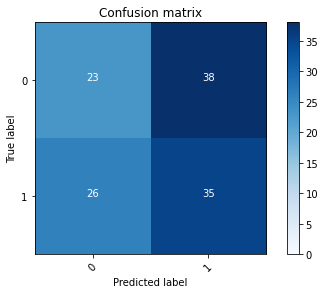

2022-08-22 14:45:28 - [Epoch Train: 89] loss: 0.0029, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:45:28 - [Epoch Valid: 89] loss: 3.0999, auc: 0.4933, acc: 0.4754, time: 6.00 s


 89%|█████████████████████████████████████▍    | 89/100 [46:10<05:57, 32.47s/it]

2022-08-22 14:45:28 - EPOCH: 90
2022-08-22 14:45:30 - Train Step 10/121, train_loss: 0.0007
2022-08-22 14:45:32 - Train Step 20/121, train_loss: 0.0004
2022-08-22 14:45:34 - Train Step 30/121, train_loss: 0.0050
2022-08-22 14:45:37 - Train Step 40/121, train_loss: 0.0038
2022-08-22 14:45:39 - Train Step 50/121, train_loss: 0.0031
2022-08-22 14:45:41 - Train Step 60/121, train_loss: 0.0026
2022-08-22 14:45:43 - Train Step 70/121, train_loss: 0.0074
2022-08-22 14:45:45 - Train Step 80/121, train_loss: 0.0065
2022-08-22 14:45:47 - Train Step 90/121, train_loss: 0.0058
2022-08-22 14:45:49 - Train Step 100/121, train_loss: 0.0052
2022-08-22 14:45:51 - Train Step 110/121, train_loss: 0.0048
2022-08-22 14:45:53 - Train Step 120/121, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:45:55 - Valid Step 5/31, valid_loss: 6.8944
2022-08-22 14:45:56 - Valid Step 10/31, valid_loss: 4.2265
2022-08-22 14:45:57 - Valid Step 15/31, valid_loss: 4.0688
2022-08-22 14:45:58

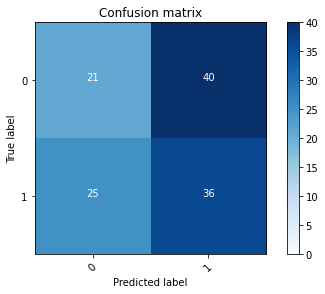

2022-08-22 14:46:00 - [Epoch Train: 90] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:46:00 - [Epoch Valid: 90] loss: 3.0946, auc: 0.4954, acc: 0.4672, time: 6.00 s


 90%|█████████████████████████████████████▊    | 90/100 [46:43<05:24, 32.44s/it]

2022-08-22 14:46:00 - EPOCH: 91
2022-08-22 14:46:03 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:46:05 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:46:07 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:46:09 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:46:11 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:46:13 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:46:15 - Train Step 70/121, train_loss: 0.0018
2022-08-22 14:46:17 - Train Step 80/121, train_loss: 0.0016
2022-08-22 14:46:20 - Train Step 90/121, train_loss: 0.0042
2022-08-22 14:46:22 - Train Step 100/121, train_loss: 0.0038
2022-08-22 14:46:24 - Train Step 110/121, train_loss: 0.0035
2022-08-22 14:46:26 - Train Step 120/121, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:46:28 - Valid Step 5/31, valid_loss: 1.9159
2022-08-22 14:46:29 - Valid Step 10/31, valid_loss: 2.9752
2022-08-22 14:46:30 - Valid Step 15/31, valid_loss: 3.1075
2022-08-22 14:46:31

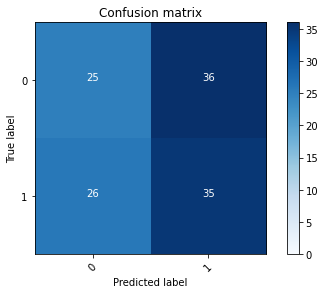

2022-08-22 14:46:33 - [Epoch Train: 91] loss: 0.0032, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:46:33 - [Epoch Valid: 91] loss: 2.9671, auc: 0.4950, acc: 0.4918, time: 6.00 s


 91%|██████████████████████████████████████▏   | 91/100 [47:16<04:53, 32.58s/it]

2022-08-22 14:46:33 - EPOCH: 92
2022-08-22 14:46:35 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:46:38 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:46:40 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:46:42 - Train Step 40/121, train_loss: 0.0039
2022-08-22 14:46:44 - Train Step 50/121, train_loss: 0.0032
2022-08-22 14:46:46 - Train Step 60/121, train_loss: 0.0027
2022-08-22 14:46:48 - Train Step 70/121, train_loss: 0.0023
2022-08-22 14:46:50 - Train Step 80/121, train_loss: 0.0020
2022-08-22 14:46:52 - Train Step 90/121, train_loss: 0.0018
2022-08-22 14:46:54 - Train Step 100/121, train_loss: 0.0016
2022-08-22 14:46:56 - Train Step 110/121, train_loss: 0.0034
2022-08-22 14:46:58 - Train Step 120/121, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:47:00 - Valid Step 5/31, valid_loss: 2.1259
2022-08-22 14:47:01 - Valid Step 10/31, valid_loss: 2.0268
2022-08-22 14:47:02 - Valid Step 15/31, valid_loss: 2.3864
2022-08-22 14:47:03

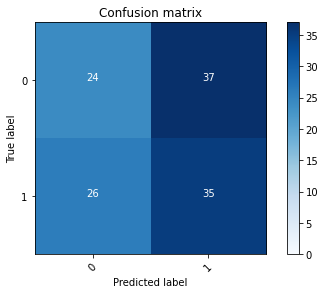

2022-08-22 14:47:06 - [Epoch Train: 92] loss: 0.0031, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:47:06 - [Epoch Valid: 92] loss: 3.1096, auc: 0.4977, acc: 0.4836, time: 6.00 s


 92%|██████████████████████████████████████▋   | 92/100 [47:48<04:20, 32.57s/it]

2022-08-22 14:47:06 - EPOCH: 93
2022-08-22 14:47:08 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:47:10 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:47:12 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:47:14 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:47:16 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:47:18 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:47:20 - Train Step 70/121, train_loss: 0.0001
2022-08-22 14:47:23 - Train Step 80/121, train_loss: 0.0001
2022-08-22 14:47:25 - Train Step 90/121, train_loss: 0.0018
2022-08-22 14:47:27 - Train Step 100/121, train_loss: 0.0047
2022-08-22 14:47:29 - Train Step 110/121, train_loss: 0.0043
2022-08-22 14:47:31 - Train Step 120/121, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:47:33 - Valid Step 5/31, valid_loss: 3.7022
2022-08-22 14:47:34 - Valid Step 10/31, valid_loss: 3.7741
2022-08-22 14:47:35 - Valid Step 15/31, valid_loss: 3.6058
2022-08-22 14:47:36

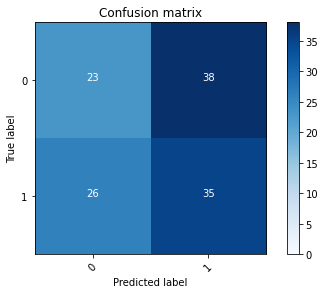

2022-08-22 14:47:38 - [Epoch Train: 93] loss: 0.0039, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:47:38 - [Epoch Valid: 93] loss: 2.9761, auc: 0.4911, acc: 0.4754, time: 6.00 s


 93%|███████████████████████████████████████   | 93/100 [48:21<03:47, 32.51s/it]

2022-08-22 14:47:38 - EPOCH: 94
2022-08-22 14:47:40 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:47:42 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:47:45 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:47:47 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:47:49 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:47:51 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:47:53 - Train Step 70/121, train_loss: 0.0001
2022-08-22 14:47:55 - Train Step 80/121, train_loss: 0.0001
2022-08-22 14:47:57 - Train Step 90/121, train_loss: 0.0023
2022-08-22 14:47:59 - Train Step 100/121, train_loss: 0.0047
2022-08-22 14:48:01 - Train Step 110/121, train_loss: 0.0043
2022-08-22 14:48:03 - Train Step 120/121, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:48:05 - Valid Step 5/31, valid_loss: 1.1997
2022-08-22 14:48:06 - Valid Step 10/31, valid_loss: 2.2885
2022-08-22 14:48:07 - Valid Step 15/31, valid_loss: 2.4386
2022-08-22 14:48:08

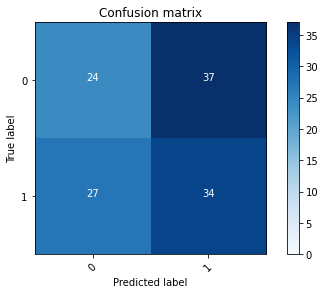

2022-08-22 14:48:10 - [Epoch Train: 94] loss: 0.0039, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:48:10 - [Epoch Valid: 94] loss: 3.0681, auc: 0.4922, acc: 0.4754, time: 6.00 s


 94%|███████████████████████████████████████▍  | 94/100 [48:53<03:14, 32.49s/it]

2022-08-22 14:48:10 - EPOCH: 95
2022-08-22 14:48:13 - Train Step 10/121, train_loss: 0.0000
2022-08-22 14:48:15 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:48:17 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:48:19 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:48:21 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:48:23 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:48:25 - Train Step 70/121, train_loss: 0.0001
2022-08-22 14:48:27 - Train Step 80/121, train_loss: 0.0029
2022-08-22 14:48:30 - Train Step 90/121, train_loss: 0.0026
2022-08-22 14:48:32 - Train Step 100/121, train_loss: 0.0023
2022-08-22 14:48:34 - Train Step 110/121, train_loss: 0.0021
2022-08-22 14:48:36 - Train Step 120/121, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:48:37 - Valid Step 5/31, valid_loss: 2.1809
2022-08-22 14:48:38 - Valid Step 10/31, valid_loss: 2.4526
2022-08-22 14:48:40 - Valid Step 15/31, valid_loss: 2.6062
2022-08-22 14:48:40

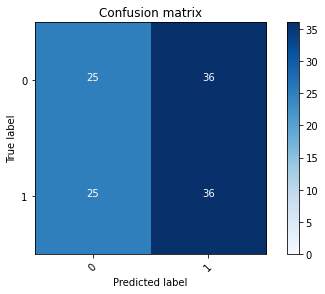

2022-08-22 14:48:43 - [Epoch Train: 95] loss: 0.0039, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:48:43 - [Epoch Valid: 95] loss: 3.0910, auc: 0.4930, acc: 0.5000, time: 6.00 s


 95%|███████████████████████████████████████▉  | 95/100 [49:25<02:42, 32.47s/it]

2022-08-22 14:48:43 - EPOCH: 96
2022-08-22 14:48:45 - Train Step 10/121, train_loss: 0.0000
2022-08-22 14:48:47 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:48:49 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:48:51 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:48:54 - Train Step 50/121, train_loss: 0.0018
2022-08-22 14:48:56 - Train Step 60/121, train_loss: 0.0015
2022-08-22 14:48:58 - Train Step 70/121, train_loss: 0.0060
2022-08-22 14:49:00 - Train Step 80/121, train_loss: 0.0053
2022-08-22 14:49:02 - Train Step 90/121, train_loss: 0.0047
2022-08-22 14:49:04 - Train Step 100/121, train_loss: 0.0043
2022-08-22 14:49:06 - Train Step 110/121, train_loss: 0.0039
2022-08-22 14:49:08 - Train Step 120/121, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:49:10 - Valid Step 5/31, valid_loss: 3.8786
2022-08-22 14:49:11 - Valid Step 10/31, valid_loss: 3.4182
2022-08-22 14:49:12 - Valid Step 15/31, valid_loss: 2.8660
2022-08-22 14:49:13

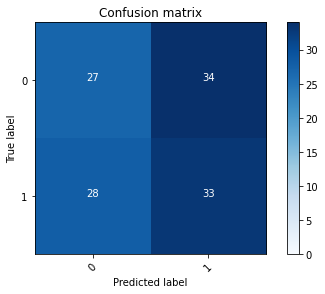

2022-08-22 14:49:16 - [Epoch Train: 96] loss: 0.0035, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:49:16 - [Epoch Valid: 96] loss: 2.9956, auc: 0.4882, acc: 0.4918, time: 6.00 s


 96%|████████████████████████████████████████▎ | 96/100 [49:58<02:10, 32.53s/it]

2022-08-22 14:49:16 - EPOCH: 97
2022-08-22 14:49:18 - Train Step 10/121, train_loss: 0.0000
2022-08-22 14:49:20 - Train Step 20/121, train_loss: 0.0000
2022-08-22 14:49:22 - Train Step 30/121, train_loss: 0.0000
2022-08-22 14:49:24 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:49:26 - Train Step 50/121, train_loss: 0.0001
2022-08-22 14:49:28 - Train Step 60/121, train_loss: 0.0001
2022-08-22 14:49:30 - Train Step 70/121, train_loss: 0.0001
2022-08-22 14:49:32 - Train Step 80/121, train_loss: 0.0001
2022-08-22 14:49:34 - Train Step 90/121, train_loss: 0.0023
2022-08-22 14:49:37 - Train Step 100/121, train_loss: 0.0021
2022-08-22 14:49:39 - Train Step 110/121, train_loss: 0.0019
2022-08-22 14:49:41 - Train Step 120/121, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:49:43 - Valid Step 5/31, valid_loss: 1.9671
2022-08-22 14:49:43 - Valid Step 10/31, valid_loss: 2.8579
2022-08-22 14:49:45 - Valid Step 15/31, valid_loss: 2.7561
2022-08-22 14:49:46

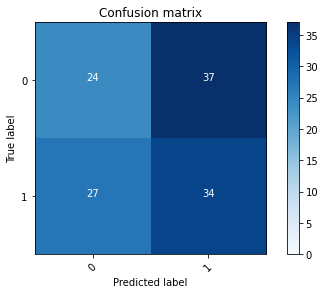

2022-08-22 14:49:48 - [Epoch Train: 97] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:49:48 - [Epoch Valid: 97] loss: 2.9488, auc: 0.4944, acc: 0.4754, time: 6.00 s


 97%|████████████████████████████████████████▋ | 97/100 [50:31<01:37, 32.52s/it]

2022-08-22 14:49:48 - EPOCH: 98
2022-08-22 14:49:50 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:49:52 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:49:54 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:49:57 - Train Step 40/121, train_loss: 0.0001
2022-08-22 14:49:59 - Train Step 50/121, train_loss: 0.0038
2022-08-22 14:50:01 - Train Step 60/121, train_loss: 0.0032
2022-08-22 14:50:03 - Train Step 70/121, train_loss: 0.0072
2022-08-22 14:50:05 - Train Step 80/121, train_loss: 0.0063
2022-08-22 14:50:07 - Train Step 90/121, train_loss: 0.0056
2022-08-22 14:50:09 - Train Step 100/121, train_loss: 0.0051
2022-08-22 14:50:11 - Train Step 110/121, train_loss: 0.0046
2022-08-22 14:50:13 - Train Step 120/121, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:50:15 - Valid Step 5/31, valid_loss: 2.1162
2022-08-22 14:50:16 - Valid Step 10/31, valid_loss: 2.3188
2022-08-22 14:50:17 - Valid Step 15/31, valid_loss: 2.8380
2022-08-22 14:50:18

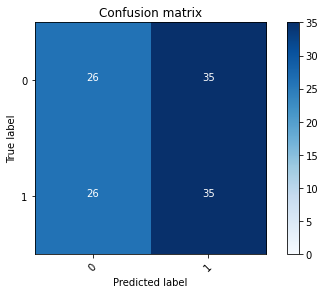

2022-08-22 14:50:20 - [Epoch Train: 98] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 14:50:20 - [Epoch Valid: 98] loss: 3.1236, auc: 0.5000, acc: 0.5000, time: 6.00 s


 98%|█████████████████████████████████████████▏| 98/100 [51:03<01:04, 32.50s/it]

2022-08-22 14:50:20 - EPOCH: 99
2022-08-22 14:50:23 - Train Step 10/121, train_loss: 0.0002
2022-08-22 14:50:25 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:50:27 - Train Step 30/121, train_loss: 0.0070
2022-08-22 14:50:29 - Train Step 40/121, train_loss: 0.0053
2022-08-22 14:50:31 - Train Step 50/121, train_loss: 0.0043
2022-08-22 14:50:33 - Train Step 60/121, train_loss: 0.0036
2022-08-22 14:50:35 - Train Step 70/121, train_loss: 0.0053
2022-08-22 14:50:38 - Train Step 80/121, train_loss: 0.0046
2022-08-22 14:50:40 - Train Step 90/121, train_loss: 0.0041
2022-08-22 14:50:42 - Train Step 100/121, train_loss: 0.0037
2022-08-22 14:50:44 - Train Step 110/121, train_loss: 0.0034
2022-08-22 14:50:46 - Train Step 120/121, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:50:48 - Valid Step 5/31, valid_loss: 3.1101
2022-08-22 14:50:48 - Valid Step 10/31, valid_loss: 2.3900
2022-08-22 14:50:50 - Valid Step 15/31, valid_loss: 2.6605
2022-08-22 14:50:51

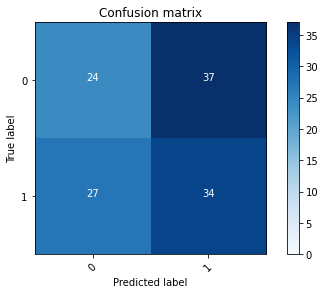

2022-08-22 14:50:53 - [Epoch Train: 99] loss: 0.0031, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:50:53 - [Epoch Valid: 99] loss: 2.9285, auc: 0.5012, acc: 0.4754, time: 6.00 s


 99%|█████████████████████████████████████████▌| 99/100 [51:35<00:32, 32.46s/it]

2022-08-22 14:50:53 - EPOCH: 100
2022-08-22 14:50:55 - Train Step 10/121, train_loss: 0.0001
2022-08-22 14:50:57 - Train Step 20/121, train_loss: 0.0001
2022-08-22 14:50:59 - Train Step 30/121, train_loss: 0.0001
2022-08-22 14:51:01 - Train Step 40/121, train_loss: 0.0044
2022-08-22 14:51:04 - Train Step 50/121, train_loss: 0.0035
2022-08-22 14:51:06 - Train Step 60/121, train_loss: 0.0029
2022-08-22 14:51:08 - Train Step 70/121, train_loss: 0.0025
2022-08-22 14:51:10 - Train Step 80/121, train_loss: 0.0023
2022-08-22 14:51:12 - Train Step 90/121, train_loss: 0.0020
2022-08-22 14:51:14 - Train Step 100/121, train_loss: 0.0049
2022-08-22 14:51:16 - Train Step 110/121, train_loss: 0.0045
2022-08-22 14:51:18 - Train Step 120/121, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:51:20 - Valid Step 5/31, valid_loss: 3.2232
2022-08-22 14:51:21 - Valid Step 10/31, valid_loss: 3.2344
2022-08-22 14:51:22 - Valid Step 15/31, valid_loss: 3.4656
2022-08-22 14:51:2

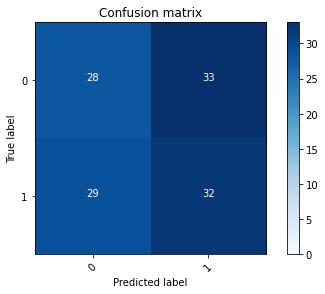

2022-08-22 14:51:25 - [Epoch Train: 100] loss: 0.0041, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:51:25 - [Epoch Valid: 100] loss: 2.9434, auc: 0.4922, acc: 0.4918, time: 6.00 s


100%|█████████████████████████████████████████| 100/100 [52:08<00:00, 31.28s/it]

-- FOLD N:1
Train origin: m
Type: KLF
2022-08-22 14:51:25 - (M0) Train/Val datasets size: 270
2022-08-22 14:51:25 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cc85a9a0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96ccb6bb80>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606


[([0, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 84, 85, 86, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 210, 212, 213, 214, 215, 216, 219, 220, 222, 223, 224, 225, 226, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 268,

  0%|                                                   | 0/100 [00:00<?, ?it/s]

2022-08-22 14:52:37 - EPOCH: 1
2022-08-22 14:52:39 - Train Step 10/122, train_loss: 0.6770
2022-08-22 14:52:41 - Train Step 20/122, train_loss: 0.7141
2022-08-22 14:52:43 - Train Step 30/122, train_loss: 0.7059
2022-08-22 14:52:45 - Train Step 40/122, train_loss: 0.7031
2022-08-22 14:52:47 - Train Step 50/122, train_loss: 0.7032
2022-08-22 14:52:49 - Train Step 60/122, train_loss: 0.6987
2022-08-22 14:52:51 - Train Step 70/122, train_loss: 0.7005
2022-08-22 14:52:54 - Train Step 80/122, train_loss: 0.6989
2022-08-22 14:52:56 - Train Step 90/122, train_loss: 0.6994
2022-08-22 14:52:58 - Train Step 100/122, train_loss: 0.6959
2022-08-22 14:53:00 - Train Step 110/122, train_loss: 0.6951
2022-08-22 14:53:02 - Train Step 120/122, train_loss: 0.6933
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:53:04 - Valid Step 5/31, valid_loss: 0.7136
2022-08-22 14:53:05 - Valid Step 10/31, valid_loss: 0.6975
2022-08-22 14:53:06 - Valid Step 15/31, valid_loss: 0.6849
2022-08-22 14:53:07 

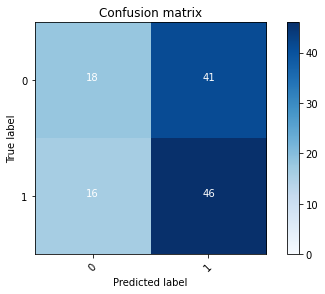

2022-08-22 14:53:09 - [Epoch Train: 1] loss: 0.6931, auc: 0.5462, acc: 0.5423, time: 25.00 s            
2022-08-22 14:53:09 - [Epoch Valid: 1] loss: 0.6892, auc: 0.5585, acc: 0.5289, time: 6.00 s
2022-08-22 14:53:09 - acc improved from 0.0000 to 0.5289. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_14-52-37/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.689-acc0.529-auc0.559.pth'


  1%|▍                                          | 1/100 [00:32<53:38, 32.51s/it]

2022-08-22 14:53:09 - EPOCH: 2
2022-08-22 14:53:11 - Train Step 10/122, train_loss: 0.6430
2022-08-22 14:53:14 - Train Step 20/122, train_loss: 0.6265
2022-08-22 14:53:16 - Train Step 30/122, train_loss: 0.6389
2022-08-22 14:53:18 - Train Step 40/122, train_loss: 0.6329
2022-08-22 14:53:20 - Train Step 50/122, train_loss: 0.6291
2022-08-22 14:53:22 - Train Step 60/122, train_loss: 0.6334
2022-08-22 14:53:24 - Train Step 70/122, train_loss: 0.6332
2022-08-22 14:53:26 - Train Step 80/122, train_loss: 0.6336
2022-08-22 14:53:28 - Train Step 90/122, train_loss: 0.6365
2022-08-22 14:53:30 - Train Step 100/122, train_loss: 0.6335
2022-08-22 14:53:32 - Train Step 110/122, train_loss: 0.6344
2022-08-22 14:53:35 - Train Step 120/122, train_loss: 0.6349
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:53:36 - Valid Step 5/31, valid_loss: 0.6533
2022-08-22 14:53:37 - Valid Step 10/31, valid_loss: 0.6484
2022-08-22 14:53:38 - Valid Step 15/31, valid_loss: 0.6775
2022-08-22 14:53:39 

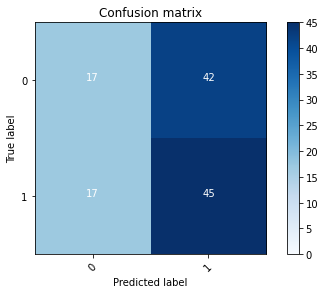

2022-08-22 14:53:41 - [Epoch Train: 2] loss: 0.6346, auc: 0.7218, acc: 0.6701, time: 25.00 s            
2022-08-22 14:53:41 - [Epoch Valid: 2] loss: 0.7057, auc: 0.5183, acc: 0.5124, time: 6.00 s


  2%|▊                                          | 2/100 [01:04<52:54, 32.39s/it]

2022-08-22 14:53:41 - EPOCH: 3
2022-08-22 14:53:44 - Train Step 10/122, train_loss: 0.5514
2022-08-22 14:53:46 - Train Step 20/122, train_loss: 0.5461
2022-08-22 14:53:48 - Train Step 30/122, train_loss: 0.5523
2022-08-22 14:53:50 - Train Step 40/122, train_loss: 0.5537
2022-08-22 14:53:52 - Train Step 50/122, train_loss: 0.5550
2022-08-22 14:53:54 - Train Step 60/122, train_loss: 0.5548
2022-08-22 14:53:56 - Train Step 70/122, train_loss: 0.5497
2022-08-22 14:53:58 - Train Step 80/122, train_loss: 0.5472
2022-08-22 14:54:01 - Train Step 90/122, train_loss: 0.5454
2022-08-22 14:54:03 - Train Step 100/122, train_loss: 0.5468
2022-08-22 14:54:05 - Train Step 110/122, train_loss: 0.5442
2022-08-22 14:54:07 - Train Step 120/122, train_loss: 0.5437
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:54:08 - Valid Step 5/31, valid_loss: 0.7808
2022-08-22 14:54:09 - Valid Step 10/31, valid_loss: 0.7465
2022-08-22 14:54:11 - Valid Step 15/31, valid_loss: 0.7175
2022-08-22 14:54:11 

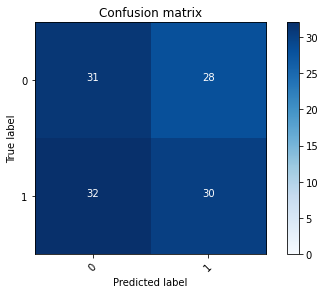

2022-08-22 14:54:14 - [Epoch Train: 3] loss: 0.5434, auc: 0.8676, acc: 0.7814, time: 25.00 s            
2022-08-22 14:54:14 - [Epoch Valid: 3] loss: 0.7565, auc: 0.4817, acc: 0.5041, time: 6.00 s


  3%|█▎                                         | 3/100 [01:37<52:20, 32.37s/it]

2022-08-22 14:54:14 - EPOCH: 4
2022-08-22 14:54:16 - Train Step 10/122, train_loss: 0.4391
2022-08-22 14:54:18 - Train Step 20/122, train_loss: 0.4288
2022-08-22 14:54:20 - Train Step 30/122, train_loss: 0.4368
2022-08-22 14:54:22 - Train Step 40/122, train_loss: 0.4368
2022-08-22 14:54:24 - Train Step 50/122, train_loss: 0.4322
2022-08-22 14:54:26 - Train Step 60/122, train_loss: 0.4359
2022-08-22 14:54:29 - Train Step 70/122, train_loss: 0.4271
2022-08-22 14:54:31 - Train Step 80/122, train_loss: 0.4201
2022-08-22 14:54:33 - Train Step 90/122, train_loss: 0.4209
2022-08-22 14:54:35 - Train Step 100/122, train_loss: 0.4267
2022-08-22 14:54:37 - Train Step 110/122, train_loss: 0.4278
2022-08-22 14:54:39 - Train Step 120/122, train_loss: 0.4280
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:54:41 - Valid Step 5/31, valid_loss: 0.9307
2022-08-22 14:54:42 - Valid Step 10/31, valid_loss: 0.8490
2022-08-22 14:54:43 - Valid Step 15/31, valid_loss: 0.8573
2022-08-22 14:54:44 

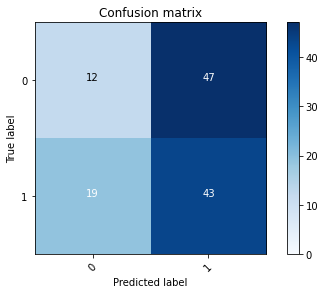

2022-08-22 14:54:46 - [Epoch Train: 4] loss: 0.4266, auc: 0.9291, acc: 0.8577, time: 25.00 s            
2022-08-22 14:54:46 - [Epoch Valid: 4] loss: 0.8142, auc: 0.4645, acc: 0.4545, time: 6.00 s


  4%|█▋                                         | 4/100 [02:09<51:39, 32.29s/it]

2022-08-22 14:54:46 - EPOCH: 5
2022-08-22 14:54:48 - Train Step 10/122, train_loss: 0.3464
2022-08-22 14:54:50 - Train Step 20/122, train_loss: 0.3206
2022-08-22 14:54:52 - Train Step 30/122, train_loss: 0.3358
2022-08-22 14:54:55 - Train Step 40/122, train_loss: 0.3071
2022-08-22 14:54:57 - Train Step 50/122, train_loss: 0.3087
2022-08-22 14:54:59 - Train Step 60/122, train_loss: 0.3086
2022-08-22 14:55:01 - Train Step 70/122, train_loss: 0.3133
2022-08-22 14:55:03 - Train Step 80/122, train_loss: 0.3065
2022-08-22 14:55:05 - Train Step 90/122, train_loss: 0.3036
2022-08-22 14:55:07 - Train Step 100/122, train_loss: 0.3042
2022-08-22 14:55:09 - Train Step 110/122, train_loss: 0.3038
2022-08-22 14:55:11 - Train Step 120/122, train_loss: 0.3007
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:55:13 - Valid Step 5/31, valid_loss: 0.8741
2022-08-22 14:55:14 - Valid Step 10/31, valid_loss: 0.8893
2022-08-22 14:55:15 - Valid Step 15/31, valid_loss: 0.8833
2022-08-22 14:55:16 

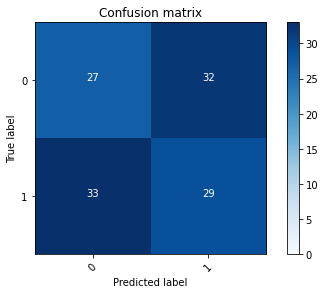

2022-08-22 14:55:18 - [Epoch Train: 5] loss: 0.3006, auc: 0.9802, acc: 0.9361, time: 25.00 s            
2022-08-22 14:55:18 - [Epoch Valid: 5] loss: 0.8795, auc: 0.4612, acc: 0.4628, time: 6.00 s


  5%|██▏                                        | 5/100 [02:41<51:14, 32.36s/it]

2022-08-22 14:55:18 - EPOCH: 6
2022-08-22 14:55:21 - Train Step 10/122, train_loss: 0.2642
2022-08-22 14:55:23 - Train Step 20/122, train_loss: 0.2082
2022-08-22 14:55:25 - Train Step 30/122, train_loss: 0.2053
2022-08-22 14:55:27 - Train Step 40/122, train_loss: 0.2037
2022-08-22 14:55:29 - Train Step 50/122, train_loss: 0.2014
2022-08-22 14:55:31 - Train Step 60/122, train_loss: 0.1922
2022-08-22 14:55:33 - Train Step 70/122, train_loss: 0.1956
2022-08-22 14:55:36 - Train Step 80/122, train_loss: 0.1898
2022-08-22 14:55:38 - Train Step 90/122, train_loss: 0.1870
2022-08-22 14:55:40 - Train Step 100/122, train_loss: 0.1881
2022-08-22 14:55:42 - Train Step 110/122, train_loss: 0.1899
2022-08-22 14:55:44 - Train Step 120/122, train_loss: 0.1853
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:55:46 - Valid Step 5/31, valid_loss: 1.3151
2022-08-22 14:55:46 - Valid Step 10/31, valid_loss: 1.2017
2022-08-22 14:55:48 - Valid Step 15/31, valid_loss: 1.0871
2022-08-22 14:55:49 

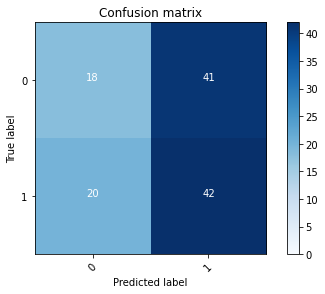

2022-08-22 14:55:51 - [Epoch Train: 6] loss: 0.1861, auc: 0.9944, acc: 0.9773, time: 25.00 s            
2022-08-22 14:55:51 - [Epoch Valid: 6] loss: 0.9961, auc: 0.4718, acc: 0.4959, time: 6.00 s


  6%|██▌                                        | 6/100 [03:14<50:44, 32.38s/it]

2022-08-22 14:55:51 - EPOCH: 7
2022-08-22 14:55:53 - Train Step 10/122, train_loss: 0.1589
2022-08-22 14:55:55 - Train Step 20/122, train_loss: 0.1419
2022-08-22 14:55:57 - Train Step 30/122, train_loss: 0.1341
2022-08-22 14:55:59 - Train Step 40/122, train_loss: 0.1318
2022-08-22 14:56:01 - Train Step 50/122, train_loss: 0.1308
2022-08-22 14:56:03 - Train Step 60/122, train_loss: 0.1237
2022-08-22 14:56:06 - Train Step 70/122, train_loss: 0.1203
2022-08-22 14:56:08 - Train Step 80/122, train_loss: 0.1139
2022-08-22 14:56:10 - Train Step 90/122, train_loss: 0.1117
2022-08-22 14:56:12 - Train Step 100/122, train_loss: 0.1107
2022-08-22 14:56:14 - Train Step 110/122, train_loss: 0.1087
2022-08-22 14:56:16 - Train Step 120/122, train_loss: 0.1065
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:56:18 - Valid Step 5/31, valid_loss: 0.7632
2022-08-22 14:56:19 - Valid Step 10/31, valid_loss: 0.9535
2022-08-22 14:56:20 - Valid Step 15/31, valid_loss: 1.0000
2022-08-22 14:56:21 

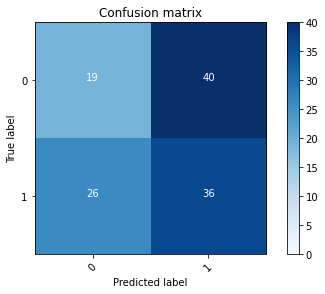

2022-08-22 14:56:23 - [Epoch Train: 7] loss: 0.1079, auc: 0.9995, acc: 0.9897, time: 25.00 s            
2022-08-22 14:56:23 - [Epoch Valid: 7] loss: 1.1197, auc: 0.4694, acc: 0.4545, time: 6.00 s


  7%|███                                        | 7/100 [03:46<50:06, 32.33s/it]

2022-08-22 14:56:23 - EPOCH: 8
2022-08-22 14:56:25 - Train Step 10/122, train_loss: 0.0633
2022-08-22 14:56:27 - Train Step 20/122, train_loss: 0.0629
2022-08-22 14:56:30 - Train Step 30/122, train_loss: 0.0613
2022-08-22 14:56:32 - Train Step 40/122, train_loss: 0.0600
2022-08-22 14:56:34 - Train Step 50/122, train_loss: 0.0583
2022-08-22 14:56:36 - Train Step 60/122, train_loss: 0.0572
2022-08-22 14:56:38 - Train Step 70/122, train_loss: 0.0534
2022-08-22 14:56:40 - Train Step 80/122, train_loss: 0.0540
2022-08-22 14:56:42 - Train Step 90/122, train_loss: 0.0556
2022-08-22 14:56:44 - Train Step 100/122, train_loss: 0.0612
2022-08-22 14:56:46 - Train Step 110/122, train_loss: 0.0633
2022-08-22 14:56:48 - Train Step 120/122, train_loss: 0.0630
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:56:50 - Valid Step 5/31, valid_loss: 1.4922
2022-08-22 14:56:51 - Valid Step 10/31, valid_loss: 1.2428
2022-08-22 14:56:52 - Valid Step 15/31, valid_loss: 1.2891
2022-08-22 14:56:53 

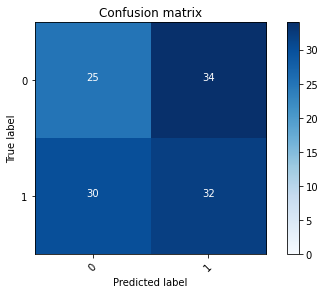

2022-08-22 14:56:55 - [Epoch Train: 8] loss: 0.0632, auc: 0.9999, acc: 0.9959, time: 25.00 s            
2022-08-22 14:56:55 - [Epoch Valid: 8] loss: 1.2081, auc: 0.4511, acc: 0.4711, time: 6.00 s


  8%|███▍                                       | 8/100 [04:18<49:30, 32.28s/it]

2022-08-22 14:56:55 - EPOCH: 9
2022-08-22 14:56:58 - Train Step 10/122, train_loss: 0.0911
2022-08-22 14:57:00 - Train Step 20/122, train_loss: 0.0676
2022-08-22 14:57:02 - Train Step 30/122, train_loss: 0.0540
2022-08-22 14:57:04 - Train Step 40/122, train_loss: 0.0480
2022-08-22 14:57:06 - Train Step 50/122, train_loss: 0.0429
2022-08-22 14:57:08 - Train Step 60/122, train_loss: 0.0408
2022-08-22 14:57:10 - Train Step 70/122, train_loss: 0.0411
2022-08-22 14:57:12 - Train Step 80/122, train_loss: 0.0394
2022-08-22 14:57:14 - Train Step 90/122, train_loss: 0.0391
2022-08-22 14:57:16 - Train Step 100/122, train_loss: 0.0391
2022-08-22 14:57:19 - Train Step 110/122, train_loss: 0.0378
2022-08-22 14:57:21 - Train Step 120/122, train_loss: 0.0379
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 14:57:22 - Valid Step 5/31, valid_loss: 0.6749
2022-08-22 14:57:23 - Valid Step 10/31, valid_loss: 1.0711
2022-08-22 14:57:24 - Valid Step 15/31, valid_loss: 1.2823
2022-08-22 14:57:26 

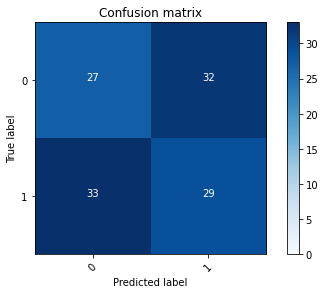

2022-08-22 14:57:28 - [Epoch Train: 9] loss: 0.0379, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:57:28 - [Epoch Valid: 9] loss: 1.2372, auc: 0.4557, acc: 0.4628, time: 7.00 s


  9%|███▊                                       | 9/100 [04:51<49:13, 32.46s/it]

2022-08-22 14:57:28 - EPOCH: 10
2022-08-22 14:57:30 - Train Step 10/122, train_loss: 0.0247
2022-08-22 14:57:33 - Train Step 20/122, train_loss: 0.0247
2022-08-22 14:57:35 - Train Step 30/122, train_loss: 0.0225
2022-08-22 14:57:37 - Train Step 40/122, train_loss: 0.0229
2022-08-22 14:57:39 - Train Step 50/122, train_loss: 0.0231
2022-08-22 14:57:41 - Train Step 60/122, train_loss: 0.0304
2022-08-22 14:57:43 - Train Step 70/122, train_loss: 0.0304
2022-08-22 14:57:45 - Train Step 80/122, train_loss: 0.0290
2022-08-22 14:57:47 - Train Step 90/122, train_loss: 0.0281
2022-08-22 14:57:49 - Train Step 100/122, train_loss: 0.0272
2022-08-22 14:57:51 - Train Step 110/122, train_loss: 0.0269
2022-08-22 14:57:53 - Train Step 120/122, train_loss: 0.0264
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:57:55 - Valid Step 5/31, valid_loss: 0.8530
2022-08-22 14:57:56 - Valid Step 10/31, valid_loss: 1.2083
2022-08-22 14:57:57 - Valid Step 15/31, valid_loss: 1.3156
2022-08-22 14:57:58

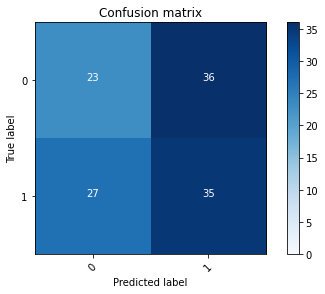

2022-08-22 14:58:01 - [Epoch Train: 10] loss: 0.0263, auc: 0.9999, acc: 0.9979, time: 25.00 s            
2022-08-22 14:58:01 - [Epoch Valid: 10] loss: 1.3515, auc: 0.4598, acc: 0.4793, time: 7.00 s


 10%|████▏                                     | 10/100 [05:24<48:56, 32.62s/it]

2022-08-22 14:58:01 - EPOCH: 11
2022-08-22 14:58:03 - Train Step 10/122, train_loss: 0.0202
2022-08-22 14:58:05 - Train Step 20/122, train_loss: 0.0166
2022-08-22 14:58:08 - Train Step 30/122, train_loss: 0.0191
2022-08-22 14:58:10 - Train Step 40/122, train_loss: 0.0176
2022-08-22 14:58:12 - Train Step 50/122, train_loss: 0.0171
2022-08-22 14:58:14 - Train Step 60/122, train_loss: 0.0167
2022-08-22 14:58:16 - Train Step 70/122, train_loss: 0.0167
2022-08-22 14:58:18 - Train Step 80/122, train_loss: 0.0164
2022-08-22 14:58:20 - Train Step 90/122, train_loss: 0.0161
2022-08-22 14:58:22 - Train Step 100/122, train_loss: 0.0194
2022-08-22 14:58:24 - Train Step 110/122, train_loss: 0.0189
2022-08-22 14:58:26 - Train Step 120/122, train_loss: 0.0188
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:58:28 - Valid Step 5/31, valid_loss: 1.4044
2022-08-22 14:58:29 - Valid Step 10/31, valid_loss: 1.1423
2022-08-22 14:58:30 - Valid Step 15/31, valid_loss: 1.2071
2022-08-22 14:58:31

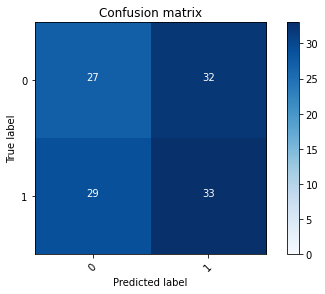

2022-08-22 14:58:33 - [Epoch Train: 11] loss: 0.0188, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:58:33 - [Epoch Valid: 11] loss: 1.4017, auc: 0.4557, acc: 0.4959, time: 6.00 s


 11%|████▌                                     | 11/100 [05:56<48:06, 32.44s/it]

2022-08-22 14:58:33 - EPOCH: 12
2022-08-22 14:58:35 - Train Step 10/122, train_loss: 0.0139
2022-08-22 14:58:37 - Train Step 20/122, train_loss: 0.0219
2022-08-22 14:58:39 - Train Step 30/122, train_loss: 0.0180
2022-08-22 14:58:42 - Train Step 40/122, train_loss: 0.0166
2022-08-22 14:58:44 - Train Step 50/122, train_loss: 0.0152
2022-08-22 14:58:46 - Train Step 60/122, train_loss: 0.0147
2022-08-22 14:58:48 - Train Step 70/122, train_loss: 0.0150
2022-08-22 14:58:50 - Train Step 80/122, train_loss: 0.0146
2022-08-22 14:58:52 - Train Step 90/122, train_loss: 0.0176
2022-08-22 14:58:54 - Train Step 100/122, train_loss: 0.0169
2022-08-22 14:58:56 - Train Step 110/122, train_loss: 0.0171
2022-08-22 14:58:58 - Train Step 120/122, train_loss: 0.0169
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:59:00 - Valid Step 5/31, valid_loss: 1.6750
2022-08-22 14:59:01 - Valid Step 10/31, valid_loss: 1.6948
2022-08-22 14:59:02 - Valid Step 15/31, valid_loss: 1.4966
2022-08-22 14:59:03

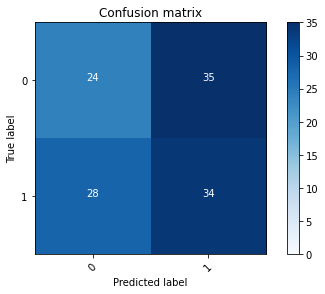

2022-08-22 14:59:05 - [Epoch Train: 12] loss: 0.0168, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:59:05 - [Epoch Valid: 12] loss: 1.4082, auc: 0.4552, acc: 0.4793, time: 6.00 s


 12%|█████                                     | 12/100 [06:28<47:19, 32.27s/it]

2022-08-22 14:59:05 - EPOCH: 13
2022-08-22 14:59:07 - Train Step 10/122, train_loss: 0.0360
2022-08-22 14:59:09 - Train Step 20/122, train_loss: 0.0232
2022-08-22 14:59:11 - Train Step 30/122, train_loss: 0.0197
2022-08-22 14:59:13 - Train Step 40/122, train_loss: 0.0170
2022-08-22 14:59:15 - Train Step 50/122, train_loss: 0.0156
2022-08-22 14:59:18 - Train Step 60/122, train_loss: 0.0152
2022-08-22 14:59:20 - Train Step 70/122, train_loss: 0.0146
2022-08-22 14:59:22 - Train Step 80/122, train_loss: 0.0155
2022-08-22 14:59:24 - Train Step 90/122, train_loss: 0.0150
2022-08-22 14:59:26 - Train Step 100/122, train_loss: 0.0144
2022-08-22 14:59:28 - Train Step 110/122, train_loss: 0.0144
2022-08-22 14:59:30 - Train Step 120/122, train_loss: 0.0141
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 14:59:32 - Valid Step 5/31, valid_loss: 1.5344
2022-08-22 14:59:33 - Valid Step 10/31, valid_loss: 1.4828
2022-08-22 14:59:34 - Valid Step 15/31, valid_loss: 1.3148
2022-08-22 14:59:35

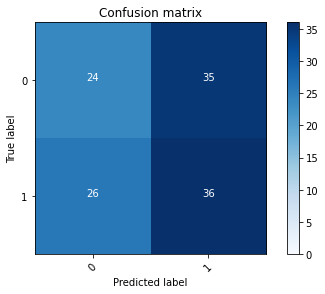

2022-08-22 14:59:37 - [Epoch Train: 13] loss: 0.0144, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 14:59:37 - [Epoch Valid: 13] loss: 1.4307, auc: 0.4658, acc: 0.4959, time: 6.00 s


 13%|█████▍                                    | 13/100 [07:00<46:46, 32.26s/it]

2022-08-22 14:59:37 - EPOCH: 14
2022-08-22 14:59:40 - Train Step 10/122, train_loss: 0.0110
2022-08-22 14:59:42 - Train Step 20/122, train_loss: 0.0134
2022-08-22 14:59:44 - Train Step 30/122, train_loss: 0.0121
2022-08-22 14:59:46 - Train Step 40/122, train_loss: 0.0115
2022-08-22 14:59:48 - Train Step 50/122, train_loss: 0.0200
2022-08-22 14:59:50 - Train Step 60/122, train_loss: 0.0183
2022-08-22 14:59:52 - Train Step 70/122, train_loss: 0.0168
2022-08-22 14:59:54 - Train Step 80/122, train_loss: 0.0154
2022-08-22 14:59:56 - Train Step 90/122, train_loss: 0.0148
2022-08-22 14:59:59 - Train Step 100/122, train_loss: 0.0143
2022-08-22 15:00:01 - Train Step 110/122, train_loss: 0.0141
2022-08-22 15:00:03 - Train Step 120/122, train_loss: 0.0135
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:00:04 - Valid Step 5/31, valid_loss: 2.3003
2022-08-22 15:00:05 - Valid Step 10/31, valid_loss: 1.6418
2022-08-22 15:00:07 - Valid Step 15/31, valid_loss: 1.7617
2022-08-22 15:00:07

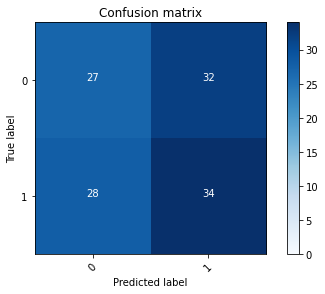

2022-08-22 15:00:10 - [Epoch Train: 14] loss: 0.0133, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:00:10 - [Epoch Valid: 14] loss: 1.5594, auc: 0.4680, acc: 0.5041, time: 6.00 s


 14%|█████▉                                    | 14/100 [07:33<46:20, 32.34s/it]

2022-08-22 15:00:10 - EPOCH: 15
2022-08-22 15:00:12 - Train Step 10/122, train_loss: 0.0376
2022-08-22 15:00:14 - Train Step 20/122, train_loss: 0.0258
2022-08-22 15:00:16 - Train Step 30/122, train_loss: 0.0196
2022-08-22 15:00:18 - Train Step 40/122, train_loss: 0.0163
2022-08-22 15:00:20 - Train Step 50/122, train_loss: 0.0151
2022-08-22 15:00:22 - Train Step 60/122, train_loss: 0.0139
2022-08-22 15:00:25 - Train Step 70/122, train_loss: 0.0127
2022-08-22 15:00:27 - Train Step 80/122, train_loss: 0.0121
2022-08-22 15:00:29 - Train Step 90/122, train_loss: 0.0118
2022-08-22 15:00:31 - Train Step 100/122, train_loss: 0.0115
2022-08-22 15:00:33 - Train Step 110/122, train_loss: 0.0110
2022-08-22 15:00:35 - Train Step 120/122, train_loss: 0.0111
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:00:37 - Valid Step 5/31, valid_loss: 1.3141
2022-08-22 15:00:38 - Valid Step 10/31, valid_loss: 1.5743
2022-08-22 15:00:39 - Valid Step 15/31, valid_loss: 1.6003
2022-08-22 15:00:40

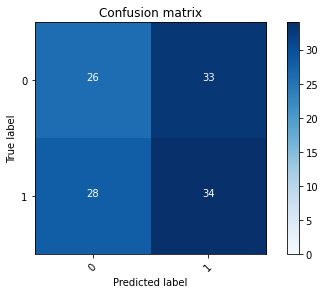

2022-08-22 15:00:42 - [Epoch Train: 15] loss: 0.0111, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:00:42 - [Epoch Valid: 15] loss: 1.5408, auc: 0.4609, acc: 0.4959, time: 6.00 s


 15%|██████▎                                   | 15/100 [08:05<45:43, 32.28s/it]

2022-08-22 15:00:42 - EPOCH: 16
2022-08-22 15:00:44 - Train Step 10/122, train_loss: 0.0086
2022-08-22 15:00:46 - Train Step 20/122, train_loss: 0.0074
2022-08-22 15:00:48 - Train Step 30/122, train_loss: 0.0074
2022-08-22 15:00:50 - Train Step 40/122, train_loss: 0.0073
2022-08-22 15:00:52 - Train Step 50/122, train_loss: 0.0075
2022-08-22 15:00:54 - Train Step 60/122, train_loss: 0.0071
2022-08-22 15:00:57 - Train Step 70/122, train_loss: 0.0070
2022-08-22 15:00:59 - Train Step 80/122, train_loss: 0.0082
2022-08-22 15:01:01 - Train Step 90/122, train_loss: 0.0096
2022-08-22 15:01:03 - Train Step 100/122, train_loss: 0.0096
2022-08-22 15:01:05 - Train Step 110/122, train_loss: 0.0092
2022-08-22 15:01:07 - Train Step 120/122, train_loss: 0.0089
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:01:09 - Valid Step 5/31, valid_loss: 1.3355
2022-08-22 15:01:10 - Valid Step 10/31, valid_loss: 1.4327
2022-08-22 15:01:11 - Valid Step 15/31, valid_loss: 1.2486
2022-08-22 15:01:12

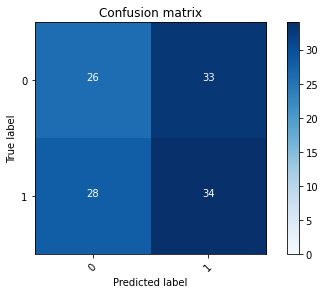

2022-08-22 15:01:14 - [Epoch Train: 16] loss: 0.0090, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 15:01:14 - [Epoch Valid: 16] loss: 1.5881, auc: 0.4625, acc: 0.4959, time: 6.00 s


 16%|██████▋                                   | 16/100 [08:37<45:09, 32.26s/it]

2022-08-22 15:01:14 - EPOCH: 17
2022-08-22 15:01:16 - Train Step 10/122, train_loss: 0.0037
2022-08-22 15:01:18 - Train Step 20/122, train_loss: 0.0053
2022-08-22 15:01:21 - Train Step 30/122, train_loss: 0.0058
2022-08-22 15:01:23 - Train Step 40/122, train_loss: 0.0057
2022-08-22 15:01:25 - Train Step 50/122, train_loss: 0.0097
2022-08-22 15:01:27 - Train Step 60/122, train_loss: 0.0090
2022-08-22 15:01:29 - Train Step 70/122, train_loss: 0.0084
2022-08-22 15:01:31 - Train Step 80/122, train_loss: 0.0087
2022-08-22 15:01:33 - Train Step 90/122, train_loss: 0.0083
2022-08-22 15:01:35 - Train Step 100/122, train_loss: 0.0084
2022-08-22 15:01:37 - Train Step 110/122, train_loss: 0.0086
2022-08-22 15:01:39 - Train Step 120/122, train_loss: 0.0084
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:01:41 - Valid Step 5/31, valid_loss: 1.2991
2022-08-22 15:01:42 - Valid Step 10/31, valid_loss: 1.3729
2022-08-22 15:01:43 - Valid Step 15/31, valid_loss: 1.4637
2022-08-22 15:01:44

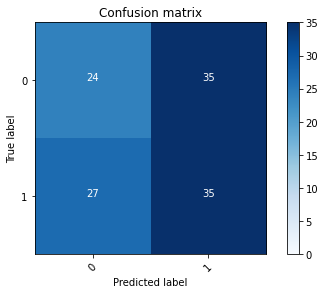

2022-08-22 15:01:46 - [Epoch Train: 17] loss: 0.0084, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:01:46 - [Epoch Valid: 17] loss: 1.5786, auc: 0.4617, acc: 0.4876, time: 6.00 s


 17%|███████▏                                  | 17/100 [09:09<44:37, 32.26s/it]

2022-08-22 15:01:46 - EPOCH: 18
2022-08-22 15:01:49 - Train Step 10/122, train_loss: 0.0053
2022-08-22 15:01:51 - Train Step 20/122, train_loss: 0.0048
2022-08-22 15:01:53 - Train Step 30/122, train_loss: 0.0048
2022-08-22 15:01:55 - Train Step 40/122, train_loss: 0.0056
2022-08-22 15:01:57 - Train Step 50/122, train_loss: 0.0055
2022-08-22 15:01:59 - Train Step 60/122, train_loss: 0.0054
2022-08-22 15:02:01 - Train Step 70/122, train_loss: 0.0051
2022-08-22 15:02:03 - Train Step 80/122, train_loss: 0.0051
2022-08-22 15:02:05 - Train Step 90/122, train_loss: 0.0054
2022-08-22 15:02:07 - Train Step 100/122, train_loss: 0.0054
2022-08-22 15:02:10 - Train Step 110/122, train_loss: 0.0054
2022-08-22 15:02:12 - Train Step 120/122, train_loss: 0.0086
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:02:14 - Valid Step 5/31, valid_loss: 1.6423
2022-08-22 15:02:14 - Valid Step 10/31, valid_loss: 1.8595
2022-08-22 15:02:16 - Valid Step 15/31, valid_loss: 1.8856
2022-08-22 15:02:17

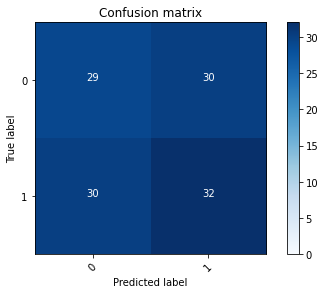

2022-08-22 15:02:19 - [Epoch Train: 18] loss: 0.0086, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:02:19 - [Epoch Valid: 18] loss: 1.7244, auc: 0.4546, acc: 0.5041, time: 6.00 s


 18%|███████▌                                  | 18/100 [09:42<44:10, 32.32s/it]

2022-08-22 15:02:19 - EPOCH: 19
2022-08-22 15:02:21 - Train Step 10/122, train_loss: 0.0038
2022-08-22 15:02:23 - Train Step 20/122, train_loss: 0.0040
2022-08-22 15:02:25 - Train Step 30/122, train_loss: 0.0047
2022-08-22 15:02:27 - Train Step 40/122, train_loss: 0.0046
2022-08-22 15:02:29 - Train Step 50/122, train_loss: 0.0122
2022-08-22 15:02:31 - Train Step 60/122, train_loss: 0.0111
2022-08-22 15:02:34 - Train Step 70/122, train_loss: 0.0100
2022-08-22 15:02:36 - Train Step 80/122, train_loss: 0.0109
2022-08-22 15:02:38 - Train Step 90/122, train_loss: 0.0103
2022-08-22 15:02:40 - Train Step 100/122, train_loss: 0.0097
2022-08-22 15:02:42 - Train Step 110/122, train_loss: 0.0093
2022-08-22 15:02:44 - Train Step 120/122, train_loss: 0.0089
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:02:46 - Valid Step 5/31, valid_loss: 2.4983
2022-08-22 15:02:47 - Valid Step 10/31, valid_loss: 2.1219
2022-08-22 15:02:48 - Valid Step 15/31, valid_loss: 1.7857
2022-08-22 15:02:49

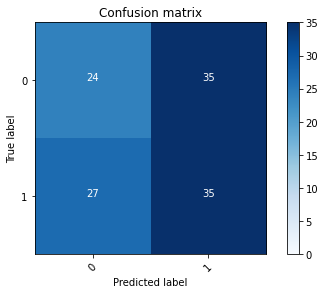

2022-08-22 15:02:51 - [Epoch Train: 19] loss: 0.0088, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:02:51 - [Epoch Valid: 19] loss: 1.7882, auc: 0.4595, acc: 0.4876, time: 6.00 s


 19%|███████▉                                  | 19/100 [10:14<43:40, 32.35s/it]

2022-08-22 15:02:51 - EPOCH: 20
2022-08-22 15:02:54 - Train Step 10/122, train_loss: 0.0039
2022-08-22 15:02:56 - Train Step 20/122, train_loss: 0.0038
2022-08-22 15:02:58 - Train Step 30/122, train_loss: 0.0039
2022-08-22 15:03:00 - Train Step 40/122, train_loss: 0.0042
2022-08-22 15:03:02 - Train Step 50/122, train_loss: 0.0043
2022-08-22 15:03:04 - Train Step 60/122, train_loss: 0.0041
2022-08-22 15:03:06 - Train Step 70/122, train_loss: 0.0041
2022-08-22 15:03:08 - Train Step 80/122, train_loss: 0.0041
2022-08-22 15:03:10 - Train Step 90/122, train_loss: 0.0041
2022-08-22 15:03:12 - Train Step 100/122, train_loss: 0.0041
2022-08-22 15:03:14 - Train Step 110/122, train_loss: 0.0063
2022-08-22 15:03:16 - Train Step 120/122, train_loss: 0.0080
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:03:18 - Valid Step 5/31, valid_loss: 1.4822
2022-08-22 15:03:19 - Valid Step 10/31, valid_loss: 1.4645
2022-08-22 15:03:20 - Valid Step 15/31, valid_loss: 1.4931
2022-08-22 15:03:21

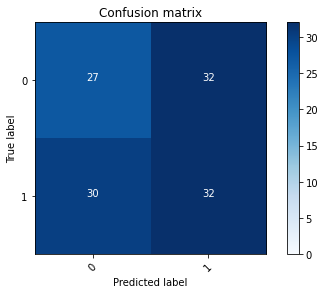

2022-08-22 15:03:23 - [Epoch Train: 20] loss: 0.0080, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:03:23 - [Epoch Valid: 20] loss: 1.5519, auc: 0.4606, acc: 0.4876, time: 6.00 s


 20%|████████▍                                 | 20/100 [10:46<43:03, 32.29s/it]

2022-08-22 15:03:23 - EPOCH: 21
2022-08-22 15:03:26 - Train Step 10/122, train_loss: 0.0030
2022-08-22 15:03:28 - Train Step 20/122, train_loss: 0.0042
2022-08-22 15:03:30 - Train Step 30/122, train_loss: 0.0034
2022-08-22 15:03:32 - Train Step 40/122, train_loss: 0.0037
2022-08-22 15:03:34 - Train Step 50/122, train_loss: 0.0038
2022-08-22 15:03:36 - Train Step 60/122, train_loss: 0.0037
2022-08-22 15:03:38 - Train Step 70/122, train_loss: 0.0035
2022-08-22 15:03:40 - Train Step 80/122, train_loss: 0.0040
2022-08-22 15:03:42 - Train Step 90/122, train_loss: 0.0039
2022-08-22 15:03:45 - Train Step 100/122, train_loss: 0.0050
2022-08-22 15:03:47 - Train Step 110/122, train_loss: 0.0069
2022-08-22 15:03:49 - Train Step 120/122, train_loss: 0.0067
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:03:51 - Valid Step 5/31, valid_loss: 1.3667
2022-08-22 15:03:51 - Valid Step 10/31, valid_loss: 1.7339
2022-08-22 15:03:53 - Valid Step 15/31, valid_loss: 1.7428
2022-08-22 15:03:54

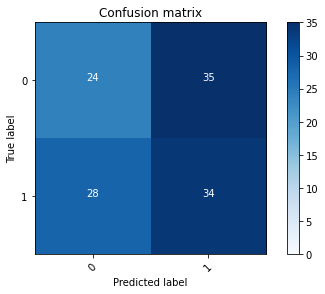

2022-08-22 15:03:56 - [Epoch Train: 21] loss: 0.0066, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:03:56 - [Epoch Valid: 21] loss: 1.6884, auc: 0.4516, acc: 0.4793, time: 6.00 s


 21%|████████▊                                 | 21/100 [11:19<42:33, 32.32s/it]

2022-08-22 15:03:56 - EPOCH: 22
2022-08-22 15:03:58 - Train Step 10/122, train_loss: 0.0036
2022-08-22 15:04:00 - Train Step 20/122, train_loss: 0.0032
2022-08-22 15:04:02 - Train Step 30/122, train_loss: 0.0084
2022-08-22 15:04:04 - Train Step 40/122, train_loss: 0.0070
2022-08-22 15:04:07 - Train Step 50/122, train_loss: 0.0064
2022-08-22 15:04:09 - Train Step 60/122, train_loss: 0.0058
2022-08-22 15:04:11 - Train Step 70/122, train_loss: 0.0051
2022-08-22 15:04:13 - Train Step 80/122, train_loss: 0.0080
2022-08-22 15:04:15 - Train Step 90/122, train_loss: 0.0076
2022-08-22 15:04:17 - Train Step 100/122, train_loss: 0.0070
2022-08-22 15:04:19 - Train Step 110/122, train_loss: 0.0068
2022-08-22 15:04:21 - Train Step 120/122, train_loss: 0.0065
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:04:23 - Valid Step 5/31, valid_loss: 1.2169
2022-08-22 15:04:24 - Valid Step 10/31, valid_loss: 1.7131
2022-08-22 15:04:25 - Valid Step 15/31, valid_loss: 1.8533
2022-08-22 15:04:26

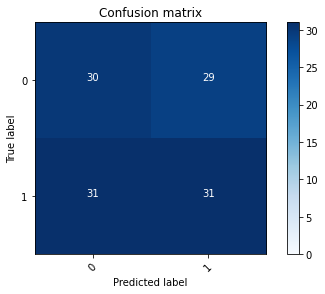

2022-08-22 15:04:28 - [Epoch Train: 22] loss: 0.0064, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:04:28 - [Epoch Valid: 22] loss: 1.7098, auc: 0.4576, acc: 0.5041, time: 6.00 s


 22%|█████████▏                                | 22/100 [11:51<42:05, 32.38s/it]

2022-08-22 15:04:28 - EPOCH: 23
2022-08-22 15:04:31 - Train Step 10/122, train_loss: 0.0188
2022-08-22 15:04:33 - Train Step 20/122, train_loss: 0.0113
2022-08-22 15:04:35 - Train Step 30/122, train_loss: 0.0089
2022-08-22 15:04:37 - Train Step 40/122, train_loss: 0.0075
2022-08-22 15:04:39 - Train Step 50/122, train_loss: 0.0100
2022-08-22 15:04:41 - Train Step 60/122, train_loss: 0.0088
2022-08-22 15:04:43 - Train Step 70/122, train_loss: 0.0080
2022-08-22 15:04:45 - Train Step 80/122, train_loss: 0.0073
2022-08-22 15:04:47 - Train Step 90/122, train_loss: 0.0068
2022-08-22 15:04:49 - Train Step 100/122, train_loss: 0.0064
2022-08-22 15:04:51 - Train Step 110/122, train_loss: 0.0061
2022-08-22 15:04:54 - Train Step 120/122, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:04:55 - Valid Step 5/31, valid_loss: 1.5451
2022-08-22 15:04:56 - Valid Step 10/31, valid_loss: 1.6227
2022-08-22 15:04:57 - Valid Step 15/31, valid_loss: 1.6098
2022-08-22 15:04:58

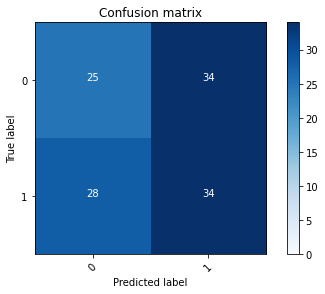

2022-08-22 15:05:01 - [Epoch Train: 23] loss: 0.0058, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:05:01 - [Epoch Valid: 23] loss: 1.7886, auc: 0.4590, acc: 0.4876, time: 6.00 s


 23%|█████████▋                                | 23/100 [12:23<41:30, 32.35s/it]

2022-08-22 15:05:01 - EPOCH: 24
2022-08-22 15:05:03 - Train Step 10/122, train_loss: 0.0020
2022-08-22 15:05:05 - Train Step 20/122, train_loss: 0.0028
2022-08-22 15:05:07 - Train Step 30/122, train_loss: 0.0026
2022-08-22 15:05:09 - Train Step 40/122, train_loss: 0.0058
2022-08-22 15:05:11 - Train Step 50/122, train_loss: 0.0054
2022-08-22 15:05:14 - Train Step 60/122, train_loss: 0.0085
2022-08-22 15:05:16 - Train Step 70/122, train_loss: 0.0078
2022-08-22 15:05:18 - Train Step 80/122, train_loss: 0.0070
2022-08-22 15:05:20 - Train Step 90/122, train_loss: 0.0066
2022-08-22 15:05:22 - Train Step 100/122, train_loss: 0.0061
2022-08-22 15:05:24 - Train Step 110/122, train_loss: 0.0057
2022-08-22 15:05:26 - Train Step 120/122, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:05:28 - Valid Step 5/31, valid_loss: 2.0226
2022-08-22 15:05:29 - Valid Step 10/31, valid_loss: 1.4768
2022-08-22 15:05:30 - Valid Step 15/31, valid_loss: 1.6872
2022-08-22 15:05:31

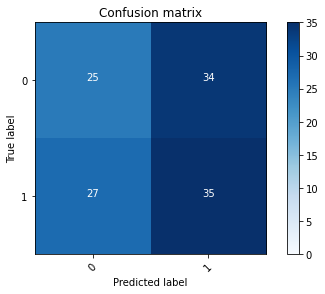

2022-08-22 15:05:33 - [Epoch Train: 24] loss: 0.0054, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:05:33 - [Epoch Valid: 24] loss: 1.7494, auc: 0.4639, acc: 0.4959, time: 6.00 s


 24%|██████████                                | 24/100 [12:56<41:04, 32.42s/it]

2022-08-22 15:05:33 - EPOCH: 25
2022-08-22 15:05:35 - Train Step 10/122, train_loss: 0.0021
2022-08-22 15:05:38 - Train Step 20/122, train_loss: 0.0020
2022-08-22 15:05:40 - Train Step 30/122, train_loss: 0.0018
2022-08-22 15:05:42 - Train Step 40/122, train_loss: 0.0049
2022-08-22 15:05:44 - Train Step 50/122, train_loss: 0.0044
2022-08-22 15:05:46 - Train Step 60/122, train_loss: 0.0086
2022-08-22 15:05:48 - Train Step 70/122, train_loss: 0.0077
2022-08-22 15:05:50 - Train Step 80/122, train_loss: 0.0070
2022-08-22 15:05:52 - Train Step 90/122, train_loss: 0.0065
2022-08-22 15:05:54 - Train Step 100/122, train_loss: 0.0060
2022-08-22 15:05:56 - Train Step 110/122, train_loss: 0.0058
2022-08-22 15:05:58 - Train Step 120/122, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:06:00 - Valid Step 5/31, valid_loss: 1.1226
2022-08-22 15:06:01 - Valid Step 10/31, valid_loss: 1.8620
2022-08-22 15:06:02 - Valid Step 15/31, valid_loss: 1.5939
2022-08-22 15:06:03

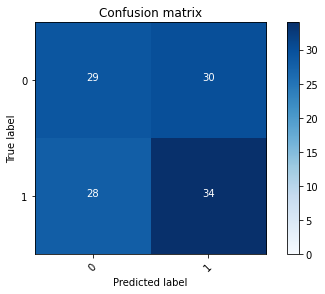

2022-08-22 15:06:05 - [Epoch Train: 25] loss: 0.0056, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:06:05 - [Epoch Valid: 25] loss: 1.9031, auc: 0.4574, acc: 0.5207, time: 6.00 s


 25%|██████████▌                               | 25/100 [13:28<40:26, 32.35s/it]

2022-08-22 15:06:05 - EPOCH: 26
2022-08-22 15:06:08 - Train Step 10/122, train_loss: 0.0015
2022-08-22 15:06:10 - Train Step 20/122, train_loss: 0.0022
2022-08-22 15:06:12 - Train Step 30/122, train_loss: 0.0024
2022-08-22 15:06:14 - Train Step 40/122, train_loss: 0.0022
2022-08-22 15:06:16 - Train Step 50/122, train_loss: 0.0021
2022-08-22 15:06:18 - Train Step 60/122, train_loss: 0.0024
2022-08-22 15:06:20 - Train Step 70/122, train_loss: 0.0023
2022-08-22 15:06:22 - Train Step 80/122, train_loss: 0.0078
2022-08-22 15:06:24 - Train Step 90/122, train_loss: 0.0072
2022-08-22 15:06:26 - Train Step 100/122, train_loss: 0.0066
2022-08-22 15:06:29 - Train Step 110/122, train_loss: 0.0062
2022-08-22 15:06:31 - Train Step 120/122, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:06:32 - Valid Step 5/31, valid_loss: 2.4922
2022-08-22 15:06:33 - Valid Step 10/31, valid_loss: 1.9683
2022-08-22 15:06:34 - Valid Step 15/31, valid_loss: 1.7926
2022-08-22 15:06:35

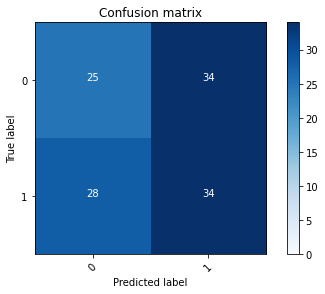

2022-08-22 15:06:38 - [Epoch Train: 26] loss: 0.0059, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:06:38 - [Epoch Valid: 26] loss: 1.9579, auc: 0.4574, acc: 0.4876, time: 6.00 s


 26%|██████████▉                               | 26/100 [14:00<39:51, 32.31s/it]

2022-08-22 15:06:38 - EPOCH: 27
2022-08-22 15:06:40 - Train Step 10/122, train_loss: 0.0022
2022-08-22 15:06:42 - Train Step 20/122, train_loss: 0.0021
2022-08-22 15:06:44 - Train Step 30/122, train_loss: 0.0068
2022-08-22 15:06:46 - Train Step 40/122, train_loss: 0.0057
2022-08-22 15:06:48 - Train Step 50/122, train_loss: 0.0050
2022-08-22 15:06:50 - Train Step 60/122, train_loss: 0.0045
2022-08-22 15:06:52 - Train Step 70/122, train_loss: 0.0041
2022-08-22 15:06:55 - Train Step 80/122, train_loss: 0.0037
2022-08-22 15:06:57 - Train Step 90/122, train_loss: 0.0035
2022-08-22 15:06:59 - Train Step 100/122, train_loss: 0.0033
2022-08-22 15:07:01 - Train Step 110/122, train_loss: 0.0048
2022-08-22 15:07:03 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:07:05 - Valid Step 5/31, valid_loss: 2.0639
2022-08-22 15:07:06 - Valid Step 10/31, valid_loss: 1.5374
2022-08-22 15:07:07 - Valid Step 15/31, valid_loss: 1.6031
2022-08-22 15:07:08

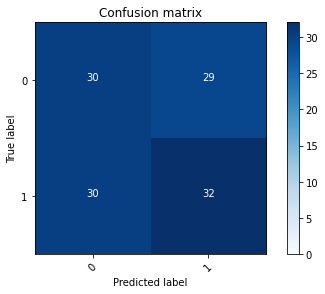

2022-08-22 15:07:10 - [Epoch Train: 27] loss: 0.0045, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:07:10 - [Epoch Valid: 27] loss: 1.8600, auc: 0.4571, acc: 0.5124, time: 6.00 s


 27%|███████████▎                              | 27/100 [14:33<39:23, 32.38s/it]

2022-08-22 15:07:10 - EPOCH: 28
2022-08-22 15:07:12 - Train Step 10/122, train_loss: 0.0022
2022-08-22 15:07:14 - Train Step 20/122, train_loss: 0.0017
2022-08-22 15:07:17 - Train Step 30/122, train_loss: 0.0018
2022-08-22 15:07:19 - Train Step 40/122, train_loss: 0.0018
2022-08-22 15:07:21 - Train Step 50/122, train_loss: 0.0044
2022-08-22 15:07:23 - Train Step 60/122, train_loss: 0.0040
2022-08-22 15:07:25 - Train Step 70/122, train_loss: 0.0036
2022-08-22 15:07:27 - Train Step 80/122, train_loss: 0.0065
2022-08-22 15:07:29 - Train Step 90/122, train_loss: 0.0060
2022-08-22 15:07:31 - Train Step 100/122, train_loss: 0.0056
2022-08-22 15:07:33 - Train Step 110/122, train_loss: 0.0052
2022-08-22 15:07:35 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:07:37 - Valid Step 5/31, valid_loss: 1.4422
2022-08-22 15:07:38 - Valid Step 10/31, valid_loss: 1.6857
2022-08-22 15:07:39 - Valid Step 15/31, valid_loss: 1.7604
2022-08-22 15:07:40

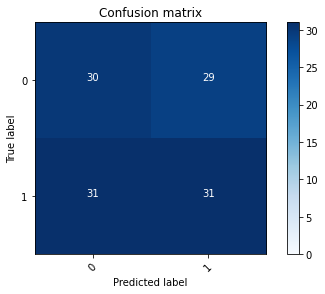

2022-08-22 15:07:42 - [Epoch Train: 28] loss: 0.0049, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:07:42 - [Epoch Valid: 28] loss: 1.9812, auc: 0.4579, acc: 0.5041, time: 6.00 s


 28%|███████████▊                              | 28/100 [15:05<38:49, 32.36s/it]

2022-08-22 15:07:42 - EPOCH: 29
2022-08-22 15:07:45 - Train Step 10/122, train_loss: 0.0112
2022-08-22 15:07:47 - Train Step 20/122, train_loss: 0.0067
2022-08-22 15:07:49 - Train Step 30/122, train_loss: 0.0049
2022-08-22 15:07:51 - Train Step 40/122, train_loss: 0.0040
2022-08-22 15:07:53 - Train Step 50/122, train_loss: 0.0034
2022-08-22 15:07:55 - Train Step 60/122, train_loss: 0.0031
2022-08-22 15:07:57 - Train Step 70/122, train_loss: 0.0028
2022-08-22 15:07:59 - Train Step 80/122, train_loss: 0.0027
2022-08-22 15:08:02 - Train Step 90/122, train_loss: 0.0026
2022-08-22 15:08:04 - Train Step 100/122, train_loss: 0.0024
2022-08-22 15:08:06 - Train Step 110/122, train_loss: 0.0046
2022-08-22 15:08:08 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:08:09 - Valid Step 5/31, valid_loss: 1.7387
2022-08-22 15:08:10 - Valid Step 10/31, valid_loss: 1.9243
2022-08-22 15:08:11 - Valid Step 15/31, valid_loss: 1.8205
2022-08-22 15:08:12

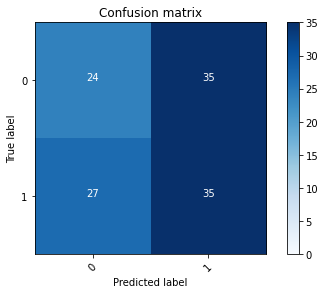

2022-08-22 15:08:15 - [Epoch Train: 29] loss: 0.0043, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:08:15 - [Epoch Valid: 29] loss: 1.9322, auc: 0.4593, acc: 0.4876, time: 6.00 s


 29%|████████████▏                             | 29/100 [15:38<38:13, 32.31s/it]

2022-08-22 15:08:15 - EPOCH: 30
2022-08-22 15:08:17 - Train Step 10/122, train_loss: 0.0011
2022-08-22 15:08:19 - Train Step 20/122, train_loss: 0.0013
2022-08-22 15:08:21 - Train Step 30/122, train_loss: 0.0080
2022-08-22 15:08:23 - Train Step 40/122, train_loss: 0.0062
2022-08-22 15:08:25 - Train Step 50/122, train_loss: 0.0053
2022-08-22 15:08:27 - Train Step 60/122, train_loss: 0.0083
2022-08-22 15:08:30 - Train Step 70/122, train_loss: 0.0072
2022-08-22 15:08:32 - Train Step 80/122, train_loss: 0.0065
2022-08-22 15:08:34 - Train Step 90/122, train_loss: 0.0059
2022-08-22 15:08:36 - Train Step 100/122, train_loss: 0.0054
2022-08-22 15:08:38 - Train Step 110/122, train_loss: 0.0051
2022-08-22 15:08:40 - Train Step 120/122, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:08:42 - Valid Step 5/31, valid_loss: 2.5498
2022-08-22 15:08:43 - Valid Step 10/31, valid_loss: 2.1813
2022-08-22 15:08:44 - Valid Step 15/31, valid_loss: 1.9443
2022-08-22 15:08:45

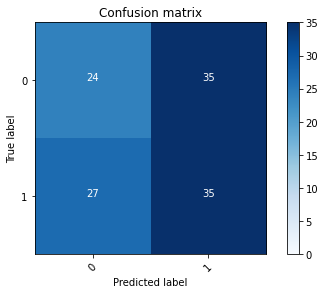

2022-08-22 15:08:47 - [Epoch Train: 30] loss: 0.0047, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:08:47 - [Epoch Valid: 30] loss: 1.9632, auc: 0.4609, acc: 0.4876, time: 6.00 s


 30%|████████████▌                             | 30/100 [16:10<37:43, 32.33s/it]

2022-08-22 15:08:47 - EPOCH: 31
2022-08-22 15:08:49 - Train Step 10/122, train_loss: 0.0012
2022-08-22 15:08:51 - Train Step 20/122, train_loss: 0.0012
2022-08-22 15:08:54 - Train Step 30/122, train_loss: 0.0011
2022-08-22 15:08:56 - Train Step 40/122, train_loss: 0.0011
2022-08-22 15:08:58 - Train Step 50/122, train_loss: 0.0046
2022-08-22 15:09:00 - Train Step 60/122, train_loss: 0.0042
2022-08-22 15:09:02 - Train Step 70/122, train_loss: 0.0038
2022-08-22 15:09:04 - Train Step 80/122, train_loss: 0.0094
2022-08-22 15:09:06 - Train Step 90/122, train_loss: 0.0085
2022-08-22 15:09:08 - Train Step 100/122, train_loss: 0.0079
2022-08-22 15:09:10 - Train Step 110/122, train_loss: 0.0073
2022-08-22 15:09:12 - Train Step 120/122, train_loss: 0.0068
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:09:14 - Valid Step 5/31, valid_loss: 2.4586
2022-08-22 15:09:15 - Valid Step 10/31, valid_loss: 2.3842
2022-08-22 15:09:16 - Valid Step 15/31, valid_loss: 2.1150
2022-08-22 15:09:17

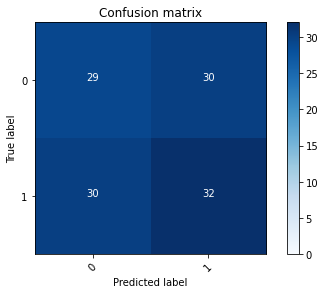

2022-08-22 15:09:19 - [Epoch Train: 31] loss: 0.0068, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:09:19 - [Epoch Valid: 31] loss: 1.9001, auc: 0.4590, acc: 0.5041, time: 6.00 s


 31%|█████████████                             | 31/100 [16:42<37:10, 32.32s/it]

2022-08-22 15:09:19 - EPOCH: 32
2022-08-22 15:09:22 - Train Step 10/122, train_loss: 0.0168
2022-08-22 15:09:24 - Train Step 20/122, train_loss: 0.0088
2022-08-22 15:09:26 - Train Step 30/122, train_loss: 0.0062
2022-08-22 15:09:28 - Train Step 40/122, train_loss: 0.0049
2022-08-22 15:09:30 - Train Step 50/122, train_loss: 0.0043
2022-08-22 15:09:32 - Train Step 60/122, train_loss: 0.0038
2022-08-22 15:09:34 - Train Step 70/122, train_loss: 0.0033
2022-08-22 15:09:36 - Train Step 80/122, train_loss: 0.0030
2022-08-22 15:09:38 - Train Step 90/122, train_loss: 0.0028
2022-08-22 15:09:40 - Train Step 100/122, train_loss: 0.0026
2022-08-22 15:09:43 - Train Step 110/122, train_loss: 0.0026
2022-08-22 15:09:45 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:09:46 - Valid Step 5/31, valid_loss: 2.8548
2022-08-22 15:09:47 - Valid Step 10/31, valid_loss: 2.1371
2022-08-22 15:09:48 - Valid Step 15/31, valid_loss: 2.0233
2022-08-22 15:09:49

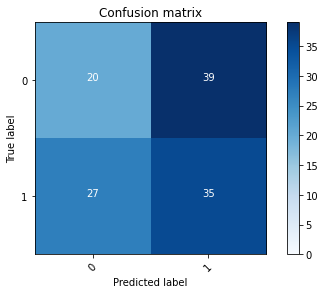

2022-08-22 15:09:52 - [Epoch Train: 32] loss: 0.0043, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:09:52 - [Epoch Valid: 32] loss: 1.8590, auc: 0.4636, acc: 0.4545, time: 6.00 s


 32%|█████████████▍                            | 32/100 [17:15<36:38, 32.33s/it]

2022-08-22 15:09:52 - EPOCH: 33
2022-08-22 15:09:54 - Train Step 10/122, train_loss: 0.0006
2022-08-22 15:09:56 - Train Step 20/122, train_loss: 0.0087
2022-08-22 15:09:58 - Train Step 30/122, train_loss: 0.0062
2022-08-22 15:10:00 - Train Step 40/122, train_loss: 0.0107
2022-08-22 15:10:02 - Train Step 50/122, train_loss: 0.0088
2022-08-22 15:10:05 - Train Step 60/122, train_loss: 0.0075
2022-08-22 15:10:07 - Train Step 70/122, train_loss: 0.0066
2022-08-22 15:10:09 - Train Step 80/122, train_loss: 0.0059
2022-08-22 15:10:11 - Train Step 90/122, train_loss: 0.0053
2022-08-22 15:10:13 - Train Step 100/122, train_loss: 0.0049
2022-08-22 15:10:15 - Train Step 110/122, train_loss: 0.0045
2022-08-22 15:10:17 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:10:19 - Valid Step 5/31, valid_loss: 1.4513
2022-08-22 15:10:20 - Valid Step 10/31, valid_loss: 1.7511
2022-08-22 15:10:21 - Valid Step 15/31, valid_loss: 1.7113
2022-08-22 15:10:22

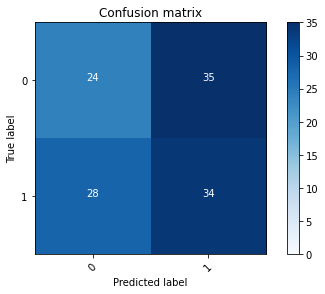

2022-08-22 15:10:24 - [Epoch Train: 33] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:10:24 - [Epoch Valid: 33] loss: 1.9758, auc: 0.4656, acc: 0.4793, time: 6.00 s


 33%|█████████████▊                            | 33/100 [17:47<36:11, 32.41s/it]

2022-08-22 15:10:24 - EPOCH: 34
2022-08-22 15:10:27 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:10:29 - Train Step 20/122, train_loss: 0.0007
2022-08-22 15:10:31 - Train Step 30/122, train_loss: 0.0007
2022-08-22 15:10:33 - Train Step 40/122, train_loss: 0.0010
2022-08-22 15:10:35 - Train Step 50/122, train_loss: 0.0011
2022-08-22 15:10:37 - Train Step 60/122, train_loss: 0.0010
2022-08-22 15:10:39 - Train Step 70/122, train_loss: 0.0010
2022-08-22 15:10:41 - Train Step 80/122, train_loss: 0.0036
2022-08-22 15:10:43 - Train Step 90/122, train_loss: 0.0033
2022-08-22 15:10:45 - Train Step 100/122, train_loss: 0.0032
2022-08-22 15:10:47 - Train Step 110/122, train_loss: 0.0055
2022-08-22 15:10:49 - Train Step 120/122, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:10:51 - Valid Step 5/31, valid_loss: 1.7879
2022-08-22 15:10:52 - Valid Step 10/31, valid_loss: 2.2242
2022-08-22 15:10:53 - Valid Step 15/31, valid_loss: 2.0114
2022-08-22 15:10:54

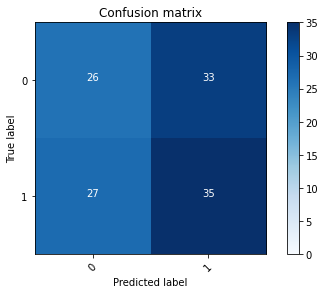

2022-08-22 15:10:56 - [Epoch Train: 34] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:10:56 - [Epoch Valid: 34] loss: 2.1354, auc: 0.4661, acc: 0.5041, time: 6.00 s


 34%|██████████████▎                           | 34/100 [18:19<35:35, 32.35s/it]

2022-08-22 15:10:56 - EPOCH: 35
2022-08-22 15:10:59 - Train Step 10/122, train_loss: 0.0009
2022-08-22 15:11:01 - Train Step 20/122, train_loss: 0.0008
2022-08-22 15:11:03 - Train Step 30/122, train_loss: 0.0009
2022-08-22 15:11:05 - Train Step 40/122, train_loss: 0.0008
2022-08-22 15:11:07 - Train Step 50/122, train_loss: 0.0008
2022-08-22 15:11:09 - Train Step 60/122, train_loss: 0.0026
2022-08-22 15:11:11 - Train Step 70/122, train_loss: 0.0023
2022-08-22 15:11:13 - Train Step 80/122, train_loss: 0.0092
2022-08-22 15:11:15 - Train Step 90/122, train_loss: 0.0082
2022-08-22 15:11:18 - Train Step 100/122, train_loss: 0.0075
2022-08-22 15:11:20 - Train Step 110/122, train_loss: 0.0069
2022-08-22 15:11:22 - Train Step 120/122, train_loss: 0.0065
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:11:23 - Valid Step 5/31, valid_loss: 2.3930
2022-08-22 15:11:24 - Valid Step 10/31, valid_loss: 2.3436
2022-08-22 15:11:26 - Valid Step 15/31, valid_loss: 2.4593
2022-08-22 15:11:27

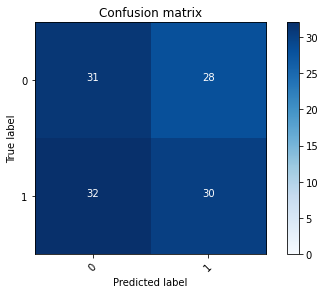

2022-08-22 15:11:29 - [Epoch Train: 35] loss: 0.0064, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:11:29 - [Epoch Valid: 35] loss: 2.0944, auc: 0.4554, acc: 0.5041, time: 6.00 s


 35%|██████████████▋                           | 35/100 [18:52<35:01, 32.34s/it]

2022-08-22 15:11:29 - EPOCH: 36
2022-08-22 15:11:31 - Train Step 10/122, train_loss: 0.0009
2022-08-22 15:11:33 - Train Step 20/122, train_loss: 0.0007
2022-08-22 15:11:35 - Train Step 30/122, train_loss: 0.0007
2022-08-22 15:11:37 - Train Step 40/122, train_loss: 0.0046
2022-08-22 15:11:39 - Train Step 50/122, train_loss: 0.0039
2022-08-22 15:11:42 - Train Step 60/122, train_loss: 0.0034
2022-08-22 15:11:44 - Train Step 70/122, train_loss: 0.0030
2022-08-22 15:11:46 - Train Step 80/122, train_loss: 0.0028
2022-08-22 15:11:48 - Train Step 90/122, train_loss: 0.0026
2022-08-22 15:11:50 - Train Step 100/122, train_loss: 0.0057
2022-08-22 15:11:52 - Train Step 110/122, train_loss: 0.0053
2022-08-22 15:11:54 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:11:56 - Valid Step 5/31, valid_loss: 3.0930
2022-08-22 15:11:57 - Valid Step 10/31, valid_loss: 2.2662
2022-08-22 15:11:58 - Valid Step 15/31, valid_loss: 2.2045
2022-08-22 15:11:59

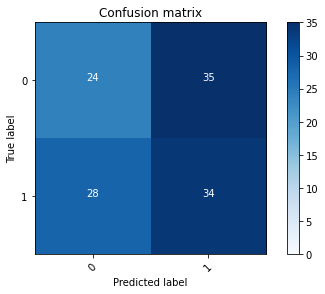

2022-08-22 15:12:01 - [Epoch Train: 36] loss: 0.0049, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:12:01 - [Epoch Valid: 36] loss: 2.0966, auc: 0.4642, acc: 0.4793, time: 6.00 s


 36%|███████████████                           | 36/100 [19:24<34:28, 32.32s/it]

2022-08-22 15:12:01 - EPOCH: 37
2022-08-22 15:12:03 - Train Step 10/122, train_loss: 0.0338
2022-08-22 15:12:05 - Train Step 20/122, train_loss: 0.0174
2022-08-22 15:12:07 - Train Step 30/122, train_loss: 0.0119
2022-08-22 15:12:10 - Train Step 40/122, train_loss: 0.0093
2022-08-22 15:12:12 - Train Step 50/122, train_loss: 0.0121
2022-08-22 15:12:14 - Train Step 60/122, train_loss: 0.0102
2022-08-22 15:12:16 - Train Step 70/122, train_loss: 0.0089
2022-08-22 15:12:18 - Train Step 80/122, train_loss: 0.0079
2022-08-22 15:12:20 - Train Step 90/122, train_loss: 0.0071
2022-08-22 15:12:22 - Train Step 100/122, train_loss: 0.0065
2022-08-22 15:12:24 - Train Step 110/122, train_loss: 0.0060
2022-08-22 15:12:26 - Train Step 120/122, train_loss: 0.0055
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:12:28 - Valid Step 5/31, valid_loss: 2.8137
2022-08-22 15:12:29 - Valid Step 10/31, valid_loss: 2.7521
2022-08-22 15:12:30 - Valid Step 15/31, valid_loss: 2.7878
2022-08-22 15:12:31

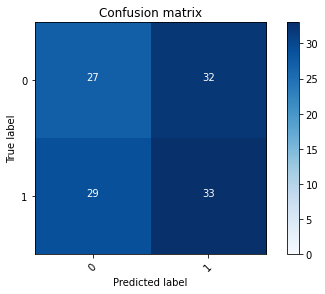

2022-08-22 15:12:33 - [Epoch Train: 37] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:12:33 - [Epoch Valid: 37] loss: 2.1042, auc: 0.4686, acc: 0.4959, time: 6.00 s


 37%|███████████████▌                          | 37/100 [19:56<33:54, 32.29s/it]

2022-08-22 15:12:33 - EPOCH: 38
2022-08-22 15:12:36 - Train Step 10/122, train_loss: 0.0013
2022-08-22 15:12:38 - Train Step 20/122, train_loss: 0.0011
2022-08-22 15:12:40 - Train Step 30/122, train_loss: 0.0009
2022-08-22 15:12:42 - Train Step 40/122, train_loss: 0.0009
2022-08-22 15:12:44 - Train Step 50/122, train_loss: 0.0122
2022-08-22 15:12:46 - Train Step 60/122, train_loss: 0.0103
2022-08-22 15:12:48 - Train Step 70/122, train_loss: 0.0090
2022-08-22 15:12:50 - Train Step 80/122, train_loss: 0.0080
2022-08-22 15:12:52 - Train Step 90/122, train_loss: 0.0072
2022-08-22 15:12:54 - Train Step 100/122, train_loss: 0.0065
2022-08-22 15:12:56 - Train Step 110/122, train_loss: 0.0060
2022-08-22 15:12:59 - Train Step 120/122, train_loss: 0.0055
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:13:00 - Valid Step 5/31, valid_loss: 2.3557
2022-08-22 15:13:01 - Valid Step 10/31, valid_loss: 2.2556
2022-08-22 15:13:02 - Valid Step 15/31, valid_loss: 2.1801
2022-08-22 15:13:03

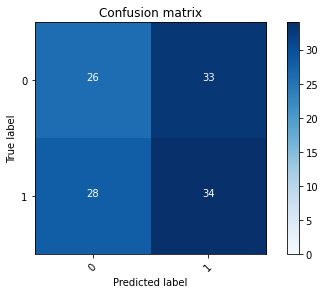

2022-08-22 15:13:05 - [Epoch Train: 38] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:13:05 - [Epoch Valid: 38] loss: 2.2044, auc: 0.4636, acc: 0.4959, time: 6.00 s


 38%|███████████████▉                          | 38/100 [20:28<33:18, 32.24s/it]

2022-08-22 15:13:05 - EPOCH: 39
2022-08-22 15:13:08 - Train Step 10/122, train_loss: 0.0007
2022-08-22 15:13:10 - Train Step 20/122, train_loss: 0.0007
2022-08-22 15:13:12 - Train Step 30/122, train_loss: 0.0007
2022-08-22 15:13:14 - Train Step 40/122, train_loss: 0.0006
2022-08-22 15:13:16 - Train Step 50/122, train_loss: 0.0032
2022-08-22 15:13:18 - Train Step 60/122, train_loss: 0.0027
2022-08-22 15:13:20 - Train Step 70/122, train_loss: 0.0025
2022-08-22 15:13:22 - Train Step 80/122, train_loss: 0.0022
2022-08-22 15:13:25 - Train Step 90/122, train_loss: 0.0021
2022-08-22 15:13:27 - Train Step 100/122, train_loss: 0.0019
2022-08-22 15:13:29 - Train Step 110/122, train_loss: 0.0036
2022-08-22 15:13:31 - Train Step 120/122, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:13:33 - Valid Step 5/31, valid_loss: 1.7141
2022-08-22 15:13:34 - Valid Step 10/31, valid_loss: 2.6748
2022-08-22 15:13:35 - Valid Step 15/31, valid_loss: 2.3043
2022-08-22 15:13:36

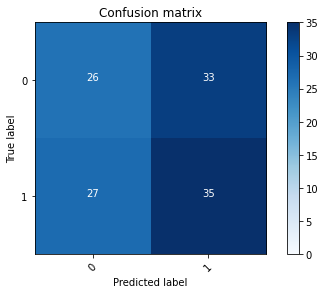

2022-08-22 15:13:38 - [Epoch Train: 39] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:13:38 - [Epoch Valid: 39] loss: 2.1328, auc: 0.4718, acc: 0.5041, time: 6.00 s


 39%|████████████████▍                         | 39/100 [21:01<32:51, 32.32s/it]

2022-08-22 15:13:38 - EPOCH: 40
2022-08-22 15:13:40 - Train Step 10/122, train_loss: 0.0014
2022-08-22 15:13:42 - Train Step 20/122, train_loss: 0.0009
2022-08-22 15:13:44 - Train Step 30/122, train_loss: 0.0009
2022-08-22 15:13:46 - Train Step 40/122, train_loss: 0.0009
2022-08-22 15:13:49 - Train Step 50/122, train_loss: 0.0009
2022-08-22 15:13:51 - Train Step 60/122, train_loss: 0.0024
2022-08-22 15:13:53 - Train Step 70/122, train_loss: 0.0056
2022-08-22 15:13:55 - Train Step 80/122, train_loss: 0.0050
2022-08-22 15:13:57 - Train Step 90/122, train_loss: 0.0045
2022-08-22 15:13:59 - Train Step 100/122, train_loss: 0.0041
2022-08-22 15:14:01 - Train Step 110/122, train_loss: 0.0038
2022-08-22 15:14:03 - Train Step 120/122, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:14:05 - Valid Step 5/31, valid_loss: 3.0401
2022-08-22 15:14:06 - Valid Step 10/31, valid_loss: 2.3334
2022-08-22 15:14:07 - Valid Step 15/31, valid_loss: 2.4187
2022-08-22 15:14:08

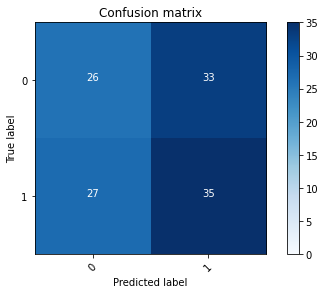

2022-08-22 15:14:10 - [Epoch Train: 40] loss: 0.0035, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:14:10 - [Epoch Valid: 40] loss: 2.2500, auc: 0.4669, acc: 0.5041, time: 6.00 s


 40%|████████████████▊                         | 40/100 [21:33<32:15, 32.26s/it]

2022-08-22 15:14:10 - EPOCH: 41
2022-08-22 15:14:12 - Train Step 10/122, train_loss: 0.0006
2022-08-22 15:14:14 - Train Step 20/122, train_loss: 0.0005
2022-08-22 15:14:16 - Train Step 30/122, train_loss: 0.0006
2022-08-22 15:14:19 - Train Step 40/122, train_loss: 0.0006
2022-08-22 15:14:21 - Train Step 50/122, train_loss: 0.0006
2022-08-22 15:14:23 - Train Step 60/122, train_loss: 0.0006
2022-08-22 15:14:25 - Train Step 70/122, train_loss: 0.0006
2022-08-22 15:14:27 - Train Step 80/122, train_loss: 0.0006
2022-08-22 15:14:29 - Train Step 90/122, train_loss: 0.0005
2022-08-22 15:14:31 - Train Step 100/122, train_loss: 0.0005
2022-08-22 15:14:33 - Train Step 110/122, train_loss: 0.0005
2022-08-22 15:14:35 - Train Step 120/122, train_loss: 0.0026
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:14:37 - Valid Step 5/31, valid_loss: 1.4521
2022-08-22 15:14:38 - Valid Step 10/31, valid_loss: 1.5475
2022-08-22 15:14:39 - Valid Step 15/31, valid_loss: 1.6970
2022-08-22 15:14:40

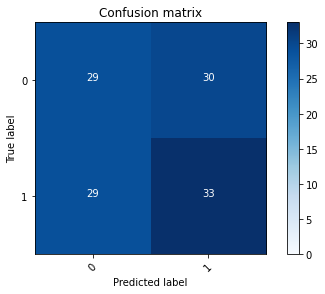

2022-08-22 15:14:42 - [Epoch Train: 41] loss: 0.0026, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:14:42 - [Epoch Valid: 41] loss: 2.2237, auc: 0.4650, acc: 0.5124, time: 6.00 s


 41%|█████████████████▏                        | 41/100 [22:05<31:44, 32.28s/it]

2022-08-22 15:14:42 - EPOCH: 42
2022-08-22 15:14:45 - Train Step 10/122, train_loss: 0.0006
2022-08-22 15:14:47 - Train Step 20/122, train_loss: 0.0076
2022-08-22 15:14:49 - Train Step 30/122, train_loss: 0.0053
2022-08-22 15:14:51 - Train Step 40/122, train_loss: 0.0042
2022-08-22 15:14:53 - Train Step 50/122, train_loss: 0.0035
2022-08-22 15:14:55 - Train Step 60/122, train_loss: 0.0030
2022-08-22 15:14:57 - Train Step 70/122, train_loss: 0.0028
2022-08-22 15:14:59 - Train Step 80/122, train_loss: 0.0026
2022-08-22 15:15:01 - Train Step 90/122, train_loss: 0.0062
2022-08-22 15:15:03 - Train Step 100/122, train_loss: 0.0056
2022-08-22 15:15:05 - Train Step 110/122, train_loss: 0.0051
2022-08-22 15:15:08 - Train Step 120/122, train_loss: 0.0048
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:15:09 - Valid Step 5/31, valid_loss: 2.0079
2022-08-22 15:15:10 - Valid Step 10/31, valid_loss: 1.6606
2022-08-22 15:15:11 - Valid Step 15/31, valid_loss: 2.0641
2022-08-22 15:15:12

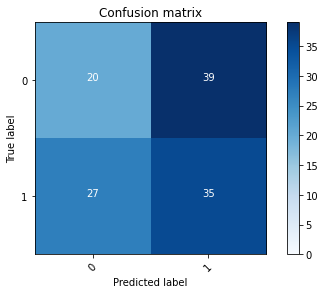

2022-08-22 15:15:15 - [Epoch Train: 42] loss: 0.0047, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:15:15 - [Epoch Valid: 42] loss: 2.2667, auc: 0.4669, acc: 0.4545, time: 6.00 s


 42%|█████████████████▋                        | 42/100 [22:38<31:13, 32.30s/it]

2022-08-22 15:15:15 - EPOCH: 43
2022-08-22 15:15:17 - Train Step 10/122, train_loss: 0.0006
2022-08-22 15:15:19 - Train Step 20/122, train_loss: 0.0005
2022-08-22 15:15:21 - Train Step 30/122, train_loss: 0.0006
2022-08-22 15:15:23 - Train Step 40/122, train_loss: 0.0068
2022-08-22 15:15:25 - Train Step 50/122, train_loss: 0.0056
2022-08-22 15:15:27 - Train Step 60/122, train_loss: 0.0048
2022-08-22 15:15:30 - Train Step 70/122, train_loss: 0.0042
2022-08-22 15:15:32 - Train Step 80/122, train_loss: 0.0067
2022-08-22 15:15:34 - Train Step 90/122, train_loss: 0.0060
2022-08-22 15:15:36 - Train Step 100/122, train_loss: 0.0054
2022-08-22 15:15:38 - Train Step 110/122, train_loss: 0.0050
2022-08-22 15:15:40 - Train Step 120/122, train_loss: 0.0046
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:15:42 - Valid Step 5/31, valid_loss: 2.0970
2022-08-22 15:15:43 - Valid Step 10/31, valid_loss: 2.2544
2022-08-22 15:15:44 - Valid Step 15/31, valid_loss: 2.3217
2022-08-22 15:15:45

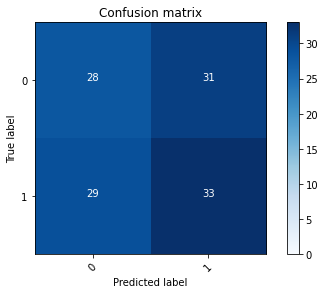

2022-08-22 15:15:47 - [Epoch Train: 43] loss: 0.0046, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:15:47 - [Epoch Valid: 43] loss: 2.2512, auc: 0.4579, acc: 0.5041, time: 6.00 s


 43%|██████████████████                        | 43/100 [23:10<30:39, 32.26s/it]

2022-08-22 15:15:47 - EPOCH: 44
2022-08-22 15:15:49 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:15:51 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:15:53 - Train Step 30/122, train_loss: 0.0119
2022-08-22 15:15:56 - Train Step 40/122, train_loss: 0.0091
2022-08-22 15:15:58 - Train Step 50/122, train_loss: 0.0075
2022-08-22 15:16:00 - Train Step 60/122, train_loss: 0.0063
2022-08-22 15:16:02 - Train Step 70/122, train_loss: 0.0054
2022-08-22 15:16:04 - Train Step 80/122, train_loss: 0.0048
2022-08-22 15:16:06 - Train Step 90/122, train_loss: 0.0043
2022-08-22 15:16:08 - Train Step 100/122, train_loss: 0.0073
2022-08-22 15:16:10 - Train Step 110/122, train_loss: 0.0067
2022-08-22 15:16:12 - Train Step 120/122, train_loss: 0.0062
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:16:14 - Valid Step 5/31, valid_loss: 2.4946
2022-08-22 15:16:15 - Valid Step 10/31, valid_loss: 2.3911
2022-08-22 15:16:16 - Valid Step 15/31, valid_loss: 2.3141
2022-08-22 15:16:17

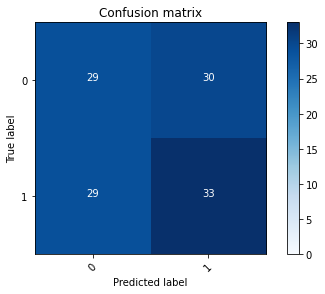

2022-08-22 15:16:19 - [Epoch Train: 44] loss: 0.0062, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:16:19 - [Epoch Valid: 44] loss: 2.2260, auc: 0.4623, acc: 0.5124, time: 6.00 s


 44%|██████████████████▍                       | 44/100 [23:42<30:07, 32.27s/it]

2022-08-22 15:16:19 - EPOCH: 45
2022-08-22 15:16:21 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:16:24 - Train Step 20/122, train_loss: 0.0017
2022-08-22 15:16:26 - Train Step 30/122, train_loss: 0.0014
2022-08-22 15:16:28 - Train Step 40/122, train_loss: 0.0012
2022-08-22 15:16:30 - Train Step 50/122, train_loss: 0.0010
2022-08-22 15:16:32 - Train Step 60/122, train_loss: 0.0009
2022-08-22 15:16:34 - Train Step 70/122, train_loss: 0.0028
2022-08-22 15:16:36 - Train Step 80/122, train_loss: 0.0025
2022-08-22 15:16:38 - Train Step 90/122, train_loss: 0.0023
2022-08-22 15:16:40 - Train Step 100/122, train_loss: 0.0021
2022-08-22 15:16:42 - Train Step 110/122, train_loss: 0.0020
2022-08-22 15:16:44 - Train Step 120/122, train_loss: 0.0018
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:16:46 - Valid Step 5/31, valid_loss: 2.6480
2022-08-22 15:16:47 - Valid Step 10/31, valid_loss: 2.3025
2022-08-22 15:16:48 - Valid Step 15/31, valid_loss: 2.3917
2022-08-22 15:16:49

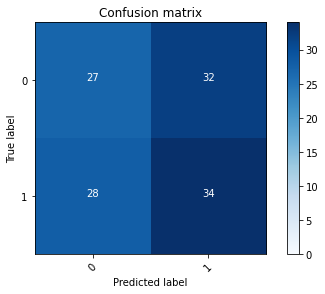

2022-08-22 15:16:51 - [Epoch Train: 45] loss: 0.0018, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 15:16:51 - [Epoch Valid: 45] loss: 2.2987, auc: 0.4658, acc: 0.5041, time: 6.00 s


 45%|██████████████████▉                       | 45/100 [24:14<29:29, 32.17s/it]

2022-08-22 15:16:51 - EPOCH: 46
2022-08-22 15:16:53 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:16:55 - Train Step 20/122, train_loss: 0.0207
2022-08-22 15:16:58 - Train Step 30/122, train_loss: 0.0139
2022-08-22 15:17:00 - Train Step 40/122, train_loss: 0.0107
2022-08-22 15:17:02 - Train Step 50/122, train_loss: 0.0086
2022-08-22 15:17:04 - Train Step 60/122, train_loss: 0.0072
2022-08-22 15:17:06 - Train Step 70/122, train_loss: 0.0062
2022-08-22 15:17:08 - Train Step 80/122, train_loss: 0.0055
2022-08-22 15:17:10 - Train Step 90/122, train_loss: 0.0050
2022-08-22 15:17:12 - Train Step 100/122, train_loss: 0.0045
2022-08-22 15:17:14 - Train Step 110/122, train_loss: 0.0041
2022-08-22 15:17:16 - Train Step 120/122, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:17:18 - Valid Step 5/31, valid_loss: 2.0576
2022-08-22 15:17:19 - Valid Step 10/31, valid_loss: 2.0527
2022-08-22 15:17:20 - Valid Step 15/31, valid_loss: 2.0559
2022-08-22 15:17:21

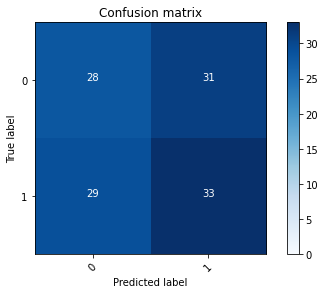

2022-08-22 15:17:23 - [Epoch Train: 46] loss: 0.0038, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:17:23 - [Epoch Valid: 46] loss: 2.3163, auc: 0.4601, acc: 0.5041, time: 6.00 s


 46%|███████████████████▎                      | 46/100 [24:46<28:59, 32.22s/it]

2022-08-22 15:17:23 - EPOCH: 47
2022-08-22 15:17:26 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:17:28 - Train Step 20/122, train_loss: 0.0005
2022-08-22 15:17:30 - Train Step 30/122, train_loss: 0.0005
2022-08-22 15:17:32 - Train Step 40/122, train_loss: 0.0005
2022-08-22 15:17:34 - Train Step 50/122, train_loss: 0.0031
2022-08-22 15:17:36 - Train Step 60/122, train_loss: 0.0027
2022-08-22 15:17:38 - Train Step 70/122, train_loss: 0.0023
2022-08-22 15:17:41 - Train Step 80/122, train_loss: 0.0021
2022-08-22 15:17:43 - Train Step 90/122, train_loss: 0.0019
2022-08-22 15:17:45 - Train Step 100/122, train_loss: 0.0039
2022-08-22 15:17:47 - Train Step 110/122, train_loss: 0.0036
2022-08-22 15:17:49 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:17:51 - Valid Step 5/31, valid_loss: 2.7634
2022-08-22 15:17:52 - Valid Step 10/31, valid_loss: 2.9213
2022-08-22 15:17:53 - Valid Step 15/31, valid_loss: 2.7173
2022-08-22 15:17:54

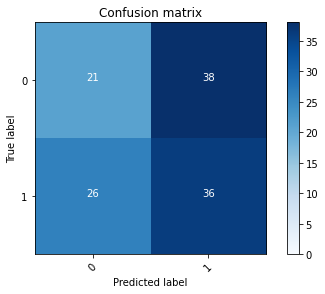

2022-08-22 15:17:56 - [Epoch Train: 47] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:17:56 - [Epoch Valid: 47] loss: 2.4872, auc: 0.4565, acc: 0.4711, time: 6.00 s


 47%|███████████████████▋                      | 47/100 [25:19<28:33, 32.32s/it]

2022-08-22 15:17:56 - EPOCH: 48
2022-08-22 15:17:58 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:18:00 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:18:03 - Train Step 30/122, train_loss: 0.0004
2022-08-22 15:18:05 - Train Step 40/122, train_loss: 0.0005
2022-08-22 15:18:07 - Train Step 50/122, train_loss: 0.0004
2022-08-22 15:18:09 - Train Step 60/122, train_loss: 0.0005
2022-08-22 15:18:11 - Train Step 70/122, train_loss: 0.0029
2022-08-22 15:18:13 - Train Step 80/122, train_loss: 0.0026
2022-08-22 15:18:15 - Train Step 90/122, train_loss: 0.0023
2022-08-22 15:18:17 - Train Step 100/122, train_loss: 0.0021
2022-08-22 15:18:19 - Train Step 110/122, train_loss: 0.0020
2022-08-22 15:18:21 - Train Step 120/122, train_loss: 0.0018
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:18:23 - Valid Step 5/31, valid_loss: 2.9400
2022-08-22 15:18:24 - Valid Step 10/31, valid_loss: 2.1419
2022-08-22 15:18:25 - Valid Step 15/31, valid_loss: 1.7862
2022-08-22 15:18:26

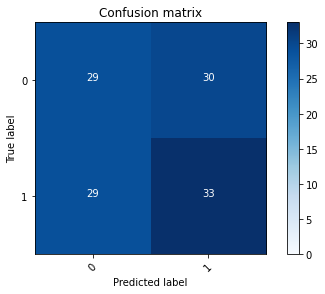

2022-08-22 15:18:28 - [Epoch Train: 48] loss: 0.0034, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:18:28 - [Epoch Valid: 48] loss: 2.3284, auc: 0.4541, acc: 0.5124, time: 6.00 s


 48%|████████████████████▏                     | 48/100 [25:51<27:59, 32.30s/it]

2022-08-22 15:18:28 - EPOCH: 49
2022-08-22 15:18:30 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:18:33 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:18:35 - Train Step 30/122, train_loss: 0.0004
2022-08-22 15:18:37 - Train Step 40/122, train_loss: 0.0003
2022-08-22 15:18:39 - Train Step 50/122, train_loss: 0.0004
2022-08-22 15:18:41 - Train Step 60/122, train_loss: 0.0004
2022-08-22 15:18:43 - Train Step 70/122, train_loss: 0.0004
2022-08-22 15:18:45 - Train Step 80/122, train_loss: 0.0004
2022-08-22 15:18:47 - Train Step 90/122, train_loss: 0.0003
2022-08-22 15:18:49 - Train Step 100/122, train_loss: 0.0003
2022-08-22 15:18:51 - Train Step 110/122, train_loss: 0.0020
2022-08-22 15:18:53 - Train Step 120/122, train_loss: 0.0019
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:18:55 - Valid Step 5/31, valid_loss: 2.3800
2022-08-22 15:18:56 - Valid Step 10/31, valid_loss: 2.1806
2022-08-22 15:18:57 - Valid Step 15/31, valid_loss: 2.0713
2022-08-22 15:18:58

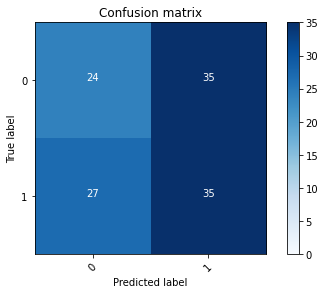

2022-08-22 15:19:00 - [Epoch Train: 49] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:19:00 - [Epoch Valid: 49] loss: 2.3511, auc: 0.4563, acc: 0.4876, time: 6.00 s


 49%|████████████████████▌                     | 49/100 [26:23<27:24, 32.24s/it]

2022-08-22 15:19:00 - EPOCH: 50
2022-08-22 15:19:03 - Train Step 10/122, train_loss: 0.0005
2022-08-22 15:19:05 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:19:07 - Train Step 30/122, train_loss: 0.0004
2022-08-22 15:19:09 - Train Step 40/122, train_loss: 0.0004
2022-08-22 15:19:11 - Train Step 50/122, train_loss: 0.0004
2022-08-22 15:19:13 - Train Step 60/122, train_loss: 0.0025
2022-08-22 15:19:15 - Train Step 70/122, train_loss: 0.0022
2022-08-22 15:19:17 - Train Step 80/122, train_loss: 0.0020
2022-08-22 15:19:19 - Train Step 90/122, train_loss: 0.0019
2022-08-22 15:19:21 - Train Step 100/122, train_loss: 0.0017
2022-08-22 15:19:23 - Train Step 110/122, train_loss: 0.0016
2022-08-22 15:19:25 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:19:27 - Valid Step 5/31, valid_loss: 2.1236
2022-08-22 15:19:28 - Valid Step 10/31, valid_loss: 2.0361
2022-08-22 15:19:29 - Valid Step 15/31, valid_loss: 1.9814
2022-08-22 15:19:30

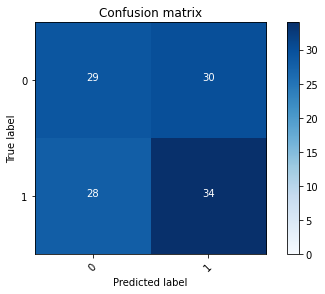

2022-08-22 15:19:32 - [Epoch Train: 50] loss: 0.0037, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:19:32 - [Epoch Valid: 50] loss: 2.5066, auc: 0.4560, acc: 0.5207, time: 6.00 s


 50%|█████████████████████                     | 50/100 [26:55<26:50, 32.22s/it]

2022-08-22 15:19:32 - EPOCH: 51
2022-08-22 15:19:35 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:19:37 - Train Step 20/122, train_loss: 0.0017
2022-08-22 15:19:39 - Train Step 30/122, train_loss: 0.0013
2022-08-22 15:19:41 - Train Step 40/122, train_loss: 0.0011
2022-08-22 15:19:43 - Train Step 50/122, train_loss: 0.0009
2022-08-22 15:19:45 - Train Step 60/122, train_loss: 0.0008
2022-08-22 15:19:47 - Train Step 70/122, train_loss: 0.0007
2022-08-22 15:19:49 - Train Step 80/122, train_loss: 0.0007
2022-08-22 15:19:52 - Train Step 90/122, train_loss: 0.0006
2022-08-22 15:19:54 - Train Step 100/122, train_loss: 0.0006
2022-08-22 15:19:56 - Train Step 110/122, train_loss: 0.0030
2022-08-22 15:19:58 - Train Step 120/122, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:20:00 - Valid Step 5/31, valid_loss: 2.4160
2022-08-22 15:20:00 - Valid Step 10/31, valid_loss: 2.8097
2022-08-22 15:20:02 - Valid Step 15/31, valid_loss: 2.7226
2022-08-22 15:20:03

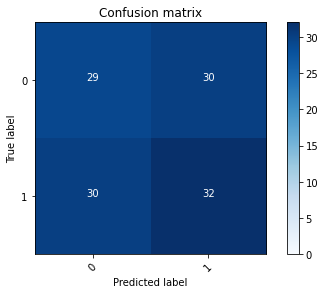

2022-08-22 15:20:05 - [Epoch Train: 51] loss: 0.0028, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:20:05 - [Epoch Valid: 51] loss: 2.3067, auc: 0.4574, acc: 0.5041, time: 6.00 s


 51%|█████████████████████▍                    | 51/100 [27:28<26:20, 32.26s/it]

2022-08-22 15:20:05 - EPOCH: 52
2022-08-22 15:20:07 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:20:09 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:20:11 - Train Step 30/122, train_loss: 0.0004
2022-08-22 15:20:13 - Train Step 40/122, train_loss: 0.0064
2022-08-22 15:20:16 - Train Step 50/122, train_loss: 0.0051
2022-08-22 15:20:18 - Train Step 60/122, train_loss: 0.0043
2022-08-22 15:20:20 - Train Step 70/122, train_loss: 0.0092
2022-08-22 15:20:22 - Train Step 80/122, train_loss: 0.0081
2022-08-22 15:20:24 - Train Step 90/122, train_loss: 0.0073
2022-08-22 15:20:26 - Train Step 100/122, train_loss: 0.0066
2022-08-22 15:20:28 - Train Step 110/122, train_loss: 0.0060
2022-08-22 15:20:30 - Train Step 120/122, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:20:32 - Valid Step 5/31, valid_loss: 2.1705
2022-08-22 15:20:33 - Valid Step 10/31, valid_loss: 1.6261
2022-08-22 15:20:34 - Valid Step 15/31, valid_loss: 1.9102
2022-08-22 15:20:35

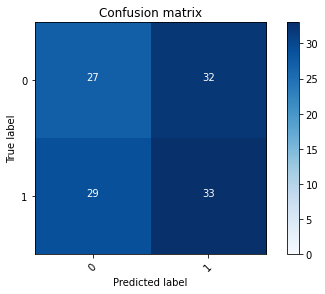

2022-08-22 15:20:37 - [Epoch Train: 52] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:20:37 - [Epoch Valid: 52] loss: 2.2869, auc: 0.4522, acc: 0.4959, time: 6.00 s


 52%|█████████████████████▊                    | 52/100 [28:00<25:47, 32.25s/it]

2022-08-22 15:20:37 - EPOCH: 53
2022-08-22 15:20:39 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:20:41 - Train Step 20/122, train_loss: 0.0130
2022-08-22 15:20:44 - Train Step 30/122, train_loss: 0.0088
2022-08-22 15:20:46 - Train Step 40/122, train_loss: 0.0066
2022-08-22 15:20:48 - Train Step 50/122, train_loss: 0.0054
2022-08-22 15:20:50 - Train Step 60/122, train_loss: 0.0045
2022-08-22 15:20:52 - Train Step 70/122, train_loss: 0.0039
2022-08-22 15:20:54 - Train Step 80/122, train_loss: 0.0035
2022-08-22 15:20:56 - Train Step 90/122, train_loss: 0.0031
2022-08-22 15:20:58 - Train Step 100/122, train_loss: 0.0028
2022-08-22 15:21:00 - Train Step 110/122, train_loss: 0.0050
2022-08-22 15:21:02 - Train Step 120/122, train_loss: 0.0046
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:21:04 - Valid Step 5/31, valid_loss: 2.8047
2022-08-22 15:21:05 - Valid Step 10/31, valid_loss: 2.7344
2022-08-22 15:21:06 - Valid Step 15/31, valid_loss: 3.1459
2022-08-22 15:21:07

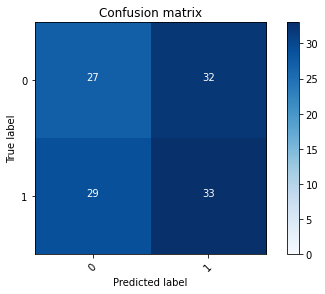

2022-08-22 15:21:09 - [Epoch Train: 53] loss: 0.0046, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:21:09 - [Epoch Valid: 53] loss: 2.4352, auc: 0.4546, acc: 0.4959, time: 6.00 s


 53%|██████████████████████▎                   | 53/100 [28:32<25:15, 32.24s/it]

2022-08-22 15:21:09 - EPOCH: 54
2022-08-22 15:21:12 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:21:14 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:21:16 - Train Step 30/122, train_loss: 0.0003
2022-08-22 15:21:18 - Train Step 40/122, train_loss: 0.0003
2022-08-22 15:21:20 - Train Step 50/122, train_loss: 0.0003
2022-08-22 15:21:22 - Train Step 60/122, train_loss: 0.0003
2022-08-22 15:21:24 - Train Step 70/122, train_loss: 0.0003
2022-08-22 15:21:26 - Train Step 80/122, train_loss: 0.0003
2022-08-22 15:21:28 - Train Step 90/122, train_loss: 0.0003
2022-08-22 15:21:30 - Train Step 100/122, train_loss: 0.0043
2022-08-22 15:21:32 - Train Step 110/122, train_loss: 0.0040
2022-08-22 15:21:34 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:21:36 - Valid Step 5/31, valid_loss: 2.4716
2022-08-22 15:21:37 - Valid Step 10/31, valid_loss: 2.8309
2022-08-22 15:21:38 - Valid Step 15/31, valid_loss: 2.7765
2022-08-22 15:21:39

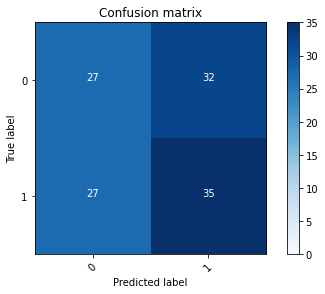

2022-08-22 15:21:41 - [Epoch Train: 54] loss: 0.0066, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:21:41 - [Epoch Valid: 54] loss: 3.1626, auc: 0.4564, acc: 0.5124, time: 6.00 s


 54%|██████████████████████▋                   | 54/100 [29:04<24:41, 32.22s/it]

2022-08-22 15:21:41 - EPOCH: 55
2022-08-22 15:21:44 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:21:46 - Train Step 20/122, train_loss: 0.0006
2022-08-22 15:21:48 - Train Step 30/122, train_loss: 0.0013
2022-08-22 15:21:50 - Train Step 40/122, train_loss: 0.0051
2022-08-22 15:21:52 - Train Step 50/122, train_loss: 0.0042
2022-08-22 15:21:54 - Train Step 60/122, train_loss: 0.0035
2022-08-22 15:21:56 - Train Step 70/122, train_loss: 0.0031
2022-08-22 15:21:59 - Train Step 80/122, train_loss: 0.0027
2022-08-22 15:22:01 - Train Step 90/122, train_loss: 0.0024
2022-08-22 15:22:03 - Train Step 100/122, train_loss: 0.0022
2022-08-22 15:22:05 - Train Step 110/122, train_loss: 0.0048
2022-08-22 15:22:07 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:22:09 - Valid Step 5/31, valid_loss: 2.8793
2022-08-22 15:22:09 - Valid Step 10/31, valid_loss: 2.4521
2022-08-22 15:22:11 - Valid Step 15/31, valid_loss: 2.4124
2022-08-22 15:22:11

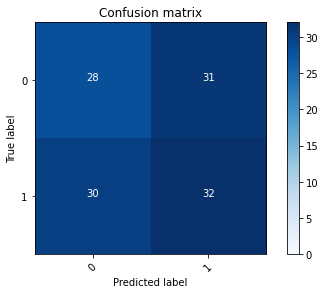

2022-08-22 15:22:14 - [Epoch Train: 55] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:22:14 - [Epoch Valid: 55] loss: 2.4543, auc: 0.4502, acc: 0.4959, time: 6.00 s


 55%|███████████████████████                   | 55/100 [29:37<24:11, 32.26s/it]

2022-08-22 15:22:14 - EPOCH: 56
2022-08-22 15:22:16 - Train Step 10/122, train_loss: 0.0005
2022-08-22 15:22:18 - Train Step 20/122, train_loss: 0.0005
2022-08-22 15:22:20 - Train Step 30/122, train_loss: 0.0006
2022-08-22 15:22:22 - Train Step 40/122, train_loss: 0.0004
2022-08-22 15:22:24 - Train Step 50/122, train_loss: 0.0005
2022-08-22 15:22:26 - Train Step 60/122, train_loss: 0.0005
2022-08-22 15:22:29 - Train Step 70/122, train_loss: 0.0024
2022-08-22 15:22:31 - Train Step 80/122, train_loss: 0.0021
2022-08-22 15:22:33 - Train Step 90/122, train_loss: 0.0019
2022-08-22 15:22:35 - Train Step 100/122, train_loss: 0.0018
2022-08-22 15:22:37 - Train Step 110/122, train_loss: 0.0053
2022-08-22 15:22:39 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:22:41 - Valid Step 5/31, valid_loss: 3.5276
2022-08-22 15:22:42 - Valid Step 10/31, valid_loss: 3.4044
2022-08-22 15:22:43 - Valid Step 15/31, valid_loss: 3.0084
2022-08-22 15:22:44

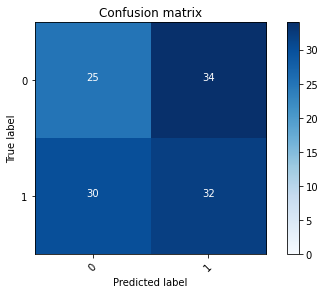

2022-08-22 15:22:46 - [Epoch Train: 56] loss: 0.0049, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:22:46 - [Epoch Valid: 56] loss: 2.4028, auc: 0.4552, acc: 0.4711, time: 6.00 s


 56%|███████████████████████▌                  | 56/100 [30:09<23:38, 32.24s/it]

2022-08-22 15:22:46 - EPOCH: 57
2022-08-22 15:22:48 - Train Step 10/122, train_loss: 0.0005
2022-08-22 15:22:50 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:22:52 - Train Step 30/122, train_loss: 0.0004
2022-08-22 15:22:55 - Train Step 40/122, train_loss: 0.0031
2022-08-22 15:22:57 - Train Step 50/122, train_loss: 0.0025
2022-08-22 15:22:59 - Train Step 60/122, train_loss: 0.0022
2022-08-22 15:23:01 - Train Step 70/122, train_loss: 0.0051
2022-08-22 15:23:03 - Train Step 80/122, train_loss: 0.0044
2022-08-22 15:23:05 - Train Step 90/122, train_loss: 0.0040
2022-08-22 15:23:07 - Train Step 100/122, train_loss: 0.0036
2022-08-22 15:23:09 - Train Step 110/122, train_loss: 0.0033
2022-08-22 15:23:11 - Train Step 120/122, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:23:13 - Valid Step 5/31, valid_loss: 2.0383
2022-08-22 15:23:14 - Valid Step 10/31, valid_loss: 2.2164
2022-08-22 15:23:15 - Valid Step 15/31, valid_loss: 2.5820
2022-08-22 15:23:16

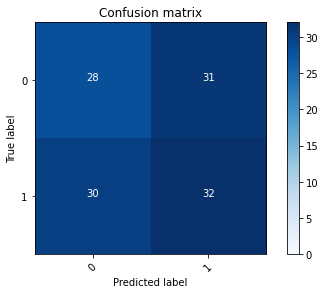

2022-08-22 15:23:18 - [Epoch Train: 57] loss: 0.0030, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 15:23:18 - [Epoch Valid: 57] loss: 2.4025, auc: 0.4543, acc: 0.4959, time: 6.00 s


 57%|███████████████████████▉                  | 57/100 [30:41<23:00, 32.11s/it]

2022-08-22 15:23:18 - EPOCH: 58
2022-08-22 15:23:20 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:23:22 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:23:24 - Train Step 30/122, train_loss: 0.0060
2022-08-22 15:23:26 - Train Step 40/122, train_loss: 0.0046
2022-08-22 15:23:28 - Train Step 50/122, train_loss: 0.0037
2022-08-22 15:23:30 - Train Step 60/122, train_loss: 0.0031
2022-08-22 15:23:32 - Train Step 70/122, train_loss: 0.0028
2022-08-22 15:23:34 - Train Step 80/122, train_loss: 0.0025
2022-08-22 15:23:36 - Train Step 90/122, train_loss: 0.0022
2022-08-22 15:23:38 - Train Step 100/122, train_loss: 0.0020
2022-08-22 15:23:40 - Train Step 110/122, train_loss: 0.0041
2022-08-22 15:23:42 - Train Step 120/122, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:23:43 - Valid Step 5/31, valid_loss: 0.9901
2022-08-22 15:23:44 - Valid Step 10/31, valid_loss: 1.6177
2022-08-22 15:23:45 - Valid Step 15/31, valid_loss: 2.2027
2022-08-22 15:23:46

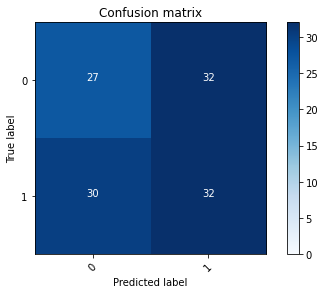

2022-08-22 15:23:48 - [Epoch Train: 58] loss: 0.0038, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:23:48 - [Epoch Valid: 58] loss: 2.4917, auc: 0.4519, acc: 0.4876, time: 6.00 s


 58%|████████████████████████▎                 | 58/100 [31:11<22:09, 31.66s/it]

2022-08-22 15:23:48 - EPOCH: 59
2022-08-22 15:23:51 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:23:53 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:23:55 - Train Step 30/122, train_loss: 0.0043
2022-08-22 15:23:57 - Train Step 40/122, train_loss: 0.0033
2022-08-22 15:23:59 - Train Step 50/122, train_loss: 0.0027
2022-08-22 15:24:01 - Train Step 60/122, train_loss: 0.0023
2022-08-22 15:24:03 - Train Step 70/122, train_loss: 0.0020
2022-08-22 15:24:05 - Train Step 80/122, train_loss: 0.0018
2022-08-22 15:24:07 - Train Step 90/122, train_loss: 0.0016
2022-08-22 15:24:09 - Train Step 100/122, train_loss: 0.0015
2022-08-22 15:24:11 - Train Step 110/122, train_loss: 0.0057
2022-08-22 15:24:13 - Train Step 120/122, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:24:14 - Valid Step 5/31, valid_loss: 2.3875
2022-08-22 15:24:15 - Valid Step 10/31, valid_loss: 1.9181
2022-08-22 15:24:16 - Valid Step 15/31, valid_loss: 2.0489
2022-08-22 15:24:17

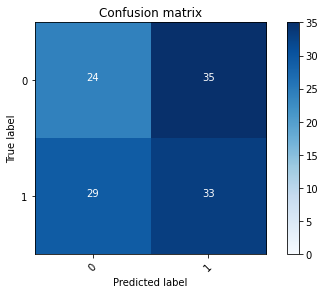

2022-08-22 15:24:19 - [Epoch Train: 59] loss: 0.0053, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:24:19 - [Epoch Valid: 59] loss: 2.5420, auc: 0.4533, acc: 0.4711, time: 6.00 s


 59%|████████████████████████▊                 | 59/100 [31:42<21:31, 31.49s/it]

2022-08-22 15:24:19 - EPOCH: 60
2022-08-22 15:24:22 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:24:24 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:24:26 - Train Step 30/122, train_loss: 0.0003
2022-08-22 15:24:27 - Train Step 40/122, train_loss: 0.0004
2022-08-22 15:24:29 - Train Step 50/122, train_loss: 0.0003
2022-08-22 15:24:31 - Train Step 60/122, train_loss: 0.0015
2022-08-22 15:24:33 - Train Step 70/122, train_loss: 0.0013
2022-08-22 15:24:35 - Train Step 80/122, train_loss: 0.0012
2022-08-22 15:24:37 - Train Step 90/122, train_loss: 0.0011
2022-08-22 15:24:39 - Train Step 100/122, train_loss: 0.0010
2022-08-22 15:24:41 - Train Step 110/122, train_loss: 0.0010
2022-08-22 15:24:43 - Train Step 120/122, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:24:45 - Valid Step 5/31, valid_loss: 2.8079
2022-08-22 15:24:45 - Valid Step 10/31, valid_loss: 3.3520
2022-08-22 15:24:47 - Valid Step 15/31, valid_loss: 3.1842
2022-08-22 15:24:47

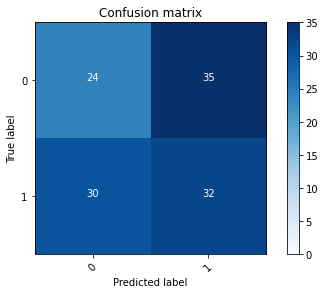

2022-08-22 15:24:50 - [Epoch Train: 60] loss: 0.0031, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:24:50 - [Epoch Valid: 60] loss: 2.5527, auc: 0.4543, acc: 0.4628, time: 6.00 s


 60%|█████████████████████████▏                | 60/100 [32:12<20:42, 31.06s/it]

2022-08-22 15:24:50 - EPOCH: 61
2022-08-22 15:24:52 - Train Step 10/122, train_loss: 0.0005
2022-08-22 15:24:54 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:24:56 - Train Step 30/122, train_loss: 0.0003
2022-08-22 15:24:58 - Train Step 40/122, train_loss: 0.0003
2022-08-22 15:24:59 - Train Step 50/122, train_loss: 0.0003
2022-08-22 15:25:01 - Train Step 60/122, train_loss: 0.0003
2022-08-22 15:25:03 - Train Step 70/122, train_loss: 0.0003
2022-08-22 15:25:05 - Train Step 80/122, train_loss: 0.0003
2022-08-22 15:25:07 - Train Step 90/122, train_loss: 0.0003
2022-08-22 15:25:09 - Train Step 100/122, train_loss: 0.0003
2022-08-22 15:25:11 - Train Step 110/122, train_loss: 0.0017
2022-08-22 15:25:13 - Train Step 120/122, train_loss: 0.0026
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:25:15 - Valid Step 5/31, valid_loss: 2.2202
2022-08-22 15:25:16 - Valid Step 10/31, valid_loss: 2.5308
2022-08-22 15:25:17 - Valid Step 15/31, valid_loss: 2.4195
2022-08-22 15:25:17

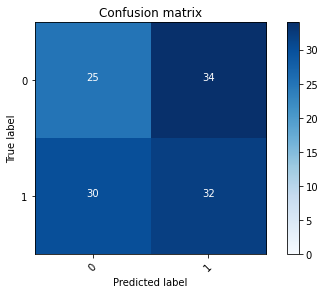

2022-08-22 15:25:20 - [Epoch Train: 61] loss: 0.0026, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:25:20 - [Epoch Valid: 61] loss: 2.5561, auc: 0.4516, acc: 0.4711, time: 6.00 s


 61%|█████████████████████████▌                | 61/100 [32:43<20:00, 30.77s/it]

2022-08-22 15:25:20 - EPOCH: 62
2022-08-22 15:25:22 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:25:24 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:25:26 - Train Step 30/122, train_loss: 0.0080
2022-08-22 15:25:28 - Train Step 40/122, train_loss: 0.0060
2022-08-22 15:25:30 - Train Step 50/122, train_loss: 0.0099
2022-08-22 15:25:32 - Train Step 60/122, train_loss: 0.0083
2022-08-22 15:25:34 - Train Step 70/122, train_loss: 0.0072
2022-08-22 15:25:36 - Train Step 80/122, train_loss: 0.0063
2022-08-22 15:25:37 - Train Step 90/122, train_loss: 0.0056
2022-08-22 15:25:39 - Train Step 100/122, train_loss: 0.0057
2022-08-22 15:25:41 - Train Step 110/122, train_loss: 0.0052
2022-08-22 15:25:43 - Train Step 120/122, train_loss: 0.0048
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:25:45 - Valid Step 5/31, valid_loss: 2.7433
2022-08-22 15:25:46 - Valid Step 10/31, valid_loss: 3.1734
2022-08-22 15:25:47 - Valid Step 15/31, valid_loss: 3.3523
2022-08-22 15:25:48

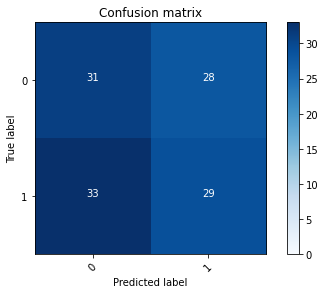

2022-08-22 15:25:50 - [Epoch Train: 62] loss: 0.0048, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 15:25:50 - [Epoch Valid: 62] loss: 2.7128, auc: 0.4467, acc: 0.4959, time: 6.00 s


 62%|██████████████████████████                | 62/100 [33:13<19:24, 30.65s/it]

2022-08-22 15:25:50 - EPOCH: 63
2022-08-22 15:25:52 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:25:54 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:25:56 - Train Step 30/122, train_loss: 0.0051
2022-08-22 15:25:58 - Train Step 40/122, train_loss: 0.0039
2022-08-22 15:26:00 - Train Step 50/122, train_loss: 0.0063
2022-08-22 15:26:02 - Train Step 60/122, train_loss: 0.0053
2022-08-22 15:26:04 - Train Step 70/122, train_loss: 0.0046
2022-08-22 15:26:06 - Train Step 80/122, train_loss: 0.0040
2022-08-22 15:26:08 - Train Step 90/122, train_loss: 0.0036
2022-08-22 15:26:10 - Train Step 100/122, train_loss: 0.0033
2022-08-22 15:26:12 - Train Step 110/122, train_loss: 0.0030
2022-08-22 15:26:14 - Train Step 120/122, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:26:15 - Valid Step 5/31, valid_loss: 3.2307
2022-08-22 15:26:16 - Valid Step 10/31, valid_loss: 2.3260
2022-08-22 15:26:17 - Valid Step 15/31, valid_loss: 2.5788
2022-08-22 15:26:18

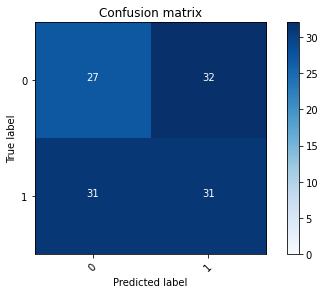

2022-08-22 15:26:20 - [Epoch Train: 63] loss: 0.0028, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:26:20 - [Epoch Valid: 63] loss: 2.5334, auc: 0.4497, acc: 0.4793, time: 6.00 s


 63%|██████████████████████████▍               | 63/100 [33:43<18:50, 30.56s/it]

2022-08-22 15:26:20 - EPOCH: 64
2022-08-22 15:26:23 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:26:25 - Train Step 20/122, train_loss: 0.0045
2022-08-22 15:26:27 - Train Step 30/122, train_loss: 0.0031
2022-08-22 15:26:29 - Train Step 40/122, train_loss: 0.0064
2022-08-22 15:26:31 - Train Step 50/122, train_loss: 0.0052
2022-08-22 15:26:33 - Train Step 60/122, train_loss: 0.0043
2022-08-22 15:26:35 - Train Step 70/122, train_loss: 0.0037
2022-08-22 15:26:37 - Train Step 80/122, train_loss: 0.0033
2022-08-22 15:26:39 - Train Step 90/122, train_loss: 0.0030
2022-08-22 15:26:41 - Train Step 100/122, train_loss: 0.0027
2022-08-22 15:26:43 - Train Step 110/122, train_loss: 0.0024
2022-08-22 15:26:45 - Train Step 120/122, train_loss: 0.0023
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:26:46 - Valid Step 5/31, valid_loss: 2.3457
2022-08-22 15:26:47 - Valid Step 10/31, valid_loss: 3.0333
2022-08-22 15:26:48 - Valid Step 15/31, valid_loss: 2.8883
2022-08-22 15:26:49

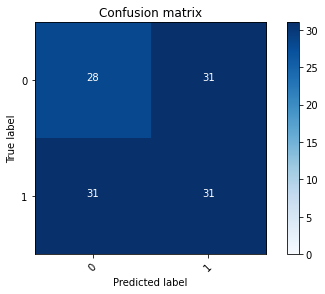

2022-08-22 15:26:51 - [Epoch Train: 64] loss: 0.0023, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:26:51 - [Epoch Valid: 64] loss: 2.7634, auc: 0.4500, acc: 0.4876, time: 6.00 s


 64%|██████████████████████████▉               | 64/100 [34:14<18:23, 30.67s/it]

2022-08-22 15:26:51 - EPOCH: 65
2022-08-22 15:26:54 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:26:56 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:26:58 - Train Step 30/122, train_loss: 0.0064
2022-08-22 15:27:00 - Train Step 40/122, train_loss: 0.0049
2022-08-22 15:27:02 - Train Step 50/122, train_loss: 0.0040
2022-08-22 15:27:04 - Train Step 60/122, train_loss: 0.0033
2022-08-22 15:27:06 - Train Step 70/122, train_loss: 0.0029
2022-08-22 15:27:08 - Train Step 80/122, train_loss: 0.0074
2022-08-22 15:27:09 - Train Step 90/122, train_loss: 0.0066
2022-08-22 15:27:11 - Train Step 100/122, train_loss: 0.0059
2022-08-22 15:27:13 - Train Step 110/122, train_loss: 0.0054
2022-08-22 15:27:15 - Train Step 120/122, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:27:17 - Valid Step 5/31, valid_loss: 3.2280
2022-08-22 15:27:18 - Valid Step 10/31, valid_loss: 2.2608
2022-08-22 15:27:19 - Valid Step 15/31, valid_loss: 2.3495
2022-08-22 15:27:20

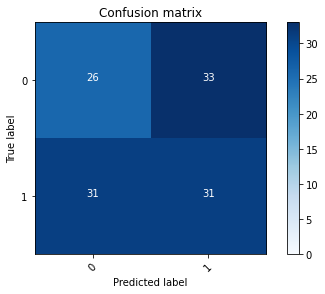

2022-08-22 15:27:22 - [Epoch Train: 65] loss: 0.0049, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:27:22 - [Epoch Valid: 65] loss: 2.5491, auc: 0.4508, acc: 0.4711, time: 6.00 s


 65%|███████████████████████████▎              | 65/100 [34:45<17:54, 30.69s/it]

2022-08-22 15:27:22 - EPOCH: 66
2022-08-22 15:27:24 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:27:26 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:27:28 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:27:30 - Train Step 40/122, train_loss: 0.0003
2022-08-22 15:27:32 - Train Step 50/122, train_loss: 0.0002
2022-08-22 15:27:34 - Train Step 60/122, train_loss: 0.0003
2022-08-22 15:27:36 - Train Step 70/122, train_loss: 0.0071
2022-08-22 15:27:38 - Train Step 80/122, train_loss: 0.0062
2022-08-22 15:27:40 - Train Step 90/122, train_loss: 0.0116
2022-08-22 15:27:42 - Train Step 100/122, train_loss: 0.0105
2022-08-22 15:27:44 - Train Step 110/122, train_loss: 0.0096
2022-08-22 15:27:46 - Train Step 120/122, train_loss: 0.0088
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:27:48 - Valid Step 5/31, valid_loss: 2.5287
2022-08-22 15:27:48 - Valid Step 10/31, valid_loss: 1.9250
2022-08-22 15:27:49 - Valid Step 15/31, valid_loss: 1.9942
2022-08-22 15:27:50

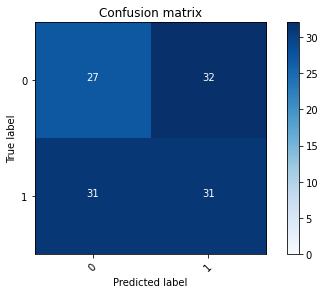

2022-08-22 15:27:53 - [Epoch Train: 66] loss: 0.0087, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:27:53 - [Epoch Valid: 66] loss: 2.4487, auc: 0.4571, acc: 0.4793, time: 6.00 s


 66%|███████████████████████████▋              | 66/100 [35:15<17:21, 30.63s/it]

2022-08-22 15:27:53 - EPOCH: 67
2022-08-22 15:27:55 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:27:57 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:27:59 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:28:01 - Train Step 40/122, train_loss: 0.0002
2022-08-22 15:28:02 - Train Step 50/122, train_loss: 0.0002
2022-08-22 15:28:04 - Train Step 60/122, train_loss: 0.0002
2022-08-22 15:28:06 - Train Step 70/122, train_loss: 0.0015
2022-08-22 15:28:08 - Train Step 80/122, train_loss: 0.0013
2022-08-22 15:28:10 - Train Step 90/122, train_loss: 0.0012
2022-08-22 15:28:12 - Train Step 100/122, train_loss: 0.0011
2022-08-22 15:28:14 - Train Step 110/122, train_loss: 0.0010
2022-08-22 15:28:16 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:28:18 - Valid Step 5/31, valid_loss: 2.8424
2022-08-22 15:28:19 - Valid Step 10/31, valid_loss: 3.1952
2022-08-22 15:28:20 - Valid Step 15/31, valid_loss: 2.9496
2022-08-22 15:28:21

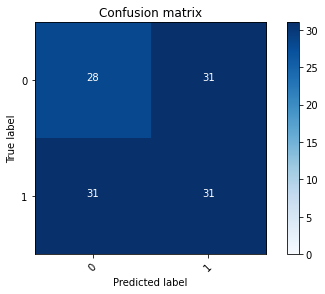

2022-08-22 15:28:23 - [Epoch Train: 67] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:28:23 - [Epoch Valid: 67] loss: 2.5964, auc: 0.4549, acc: 0.4876, time: 6.00 s


 67%|████████████████████████████▏             | 67/100 [35:46<16:48, 30.57s/it]

2022-08-22 15:28:23 - EPOCH: 68
2022-08-22 15:28:25 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:28:27 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:28:29 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:28:31 - Train Step 40/122, train_loss: 0.0002
2022-08-22 15:28:33 - Train Step 50/122, train_loss: 0.0069
2022-08-22 15:28:35 - Train Step 60/122, train_loss: 0.0058
2022-08-22 15:28:37 - Train Step 70/122, train_loss: 0.0050
2022-08-22 15:28:39 - Train Step 80/122, train_loss: 0.0044
2022-08-22 15:28:41 - Train Step 90/122, train_loss: 0.0039
2022-08-22 15:28:43 - Train Step 100/122, train_loss: 0.0050
2022-08-22 15:28:45 - Train Step 110/122, train_loss: 0.0046
2022-08-22 15:28:47 - Train Step 120/122, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:28:49 - Valid Step 5/31, valid_loss: 2.9439
2022-08-22 15:28:50 - Valid Step 10/31, valid_loss: 2.7131
2022-08-22 15:28:51 - Valid Step 15/31, valid_loss: 2.3657
2022-08-22 15:28:52

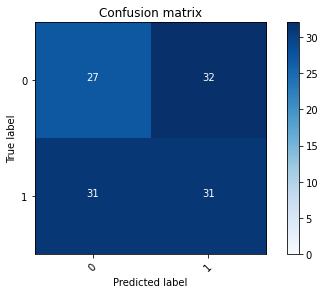

2022-08-22 15:28:54 - [Epoch Train: 68] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:28:54 - [Epoch Valid: 68] loss: 2.4857, auc: 0.4508, acc: 0.4793, time: 6.00 s


 68%|████████████████████████████▌             | 68/100 [36:17<16:22, 30.71s/it]

2022-08-22 15:28:54 - EPOCH: 69
2022-08-22 15:28:56 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:28:58 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:29:00 - Train Step 30/122, train_loss: 0.0093
2022-08-22 15:29:02 - Train Step 40/122, train_loss: 0.0070
2022-08-22 15:29:04 - Train Step 50/122, train_loss: 0.0149
2022-08-22 15:29:06 - Train Step 60/122, train_loss: 0.0124
2022-08-22 15:29:08 - Train Step 70/122, train_loss: 0.0107
2022-08-22 15:29:10 - Train Step 80/122, train_loss: 0.0094
2022-08-22 15:29:12 - Train Step 90/122, train_loss: 0.0084
2022-08-22 15:29:14 - Train Step 100/122, train_loss: 0.0076
2022-08-22 15:29:16 - Train Step 110/122, train_loss: 0.0069
2022-08-22 15:29:18 - Train Step 120/122, train_loss: 0.0063
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:29:20 - Valid Step 5/31, valid_loss: 2.4397
2022-08-22 15:29:21 - Valid Step 10/31, valid_loss: 1.9861
2022-08-22 15:29:22 - Valid Step 15/31, valid_loss: 2.5769
2022-08-22 15:29:22

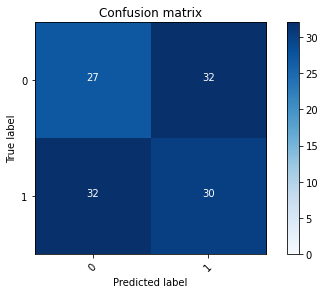

2022-08-22 15:29:25 - [Epoch Train: 69] loss: 0.0063, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:29:25 - [Epoch Valid: 69] loss: 2.5976, auc: 0.4527, acc: 0.4711, time: 6.00 s


 69%|████████████████████████████▉             | 69/100 [36:48<15:51, 30.68s/it]

2022-08-22 15:29:25 - EPOCH: 70
2022-08-22 15:29:27 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:29:29 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:29:31 - Train Step 30/122, train_loss: 0.0084
2022-08-22 15:29:33 - Train Step 40/122, train_loss: 0.0150
2022-08-22 15:29:35 - Train Step 50/122, train_loss: 0.0121
2022-08-22 15:29:36 - Train Step 60/122, train_loss: 0.0101
2022-08-22 15:29:38 - Train Step 70/122, train_loss: 0.0087
2022-08-22 15:29:40 - Train Step 80/122, train_loss: 0.0076
2022-08-22 15:29:42 - Train Step 90/122, train_loss: 0.0068
2022-08-22 15:29:44 - Train Step 100/122, train_loss: 0.0061
2022-08-22 15:29:46 - Train Step 110/122, train_loss: 0.0056
2022-08-22 15:29:48 - Train Step 120/122, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:29:50 - Valid Step 5/31, valid_loss: 3.8354
2022-08-22 15:29:51 - Valid Step 10/31, valid_loss: 2.7663
2022-08-22 15:29:52 - Valid Step 15/31, valid_loss: 2.5158
2022-08-22 15:29:53

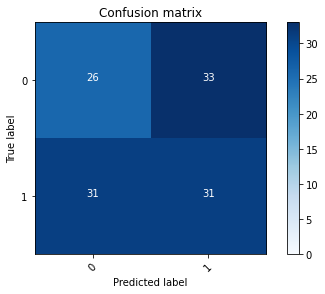

2022-08-22 15:29:55 - [Epoch Train: 70] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:29:55 - [Epoch Valid: 70] loss: 2.5941, auc: 0.4554, acc: 0.4711, time: 6.00 s


 70%|█████████████████████████████▍            | 70/100 [37:18<15:18, 30.63s/it]

2022-08-22 15:29:55 - EPOCH: 71
2022-08-22 15:29:57 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:29:59 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:30:01 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:30:03 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:30:05 - Train Step 50/122, train_loss: 0.0079
2022-08-22 15:30:07 - Train Step 60/122, train_loss: 0.0066
2022-08-22 15:30:09 - Train Step 70/122, train_loss: 0.0057
2022-08-22 15:30:11 - Train Step 80/122, train_loss: 0.0050
2022-08-22 15:30:13 - Train Step 90/122, train_loss: 0.0045
2022-08-22 15:30:15 - Train Step 100/122, train_loss: 0.0041
2022-08-22 15:30:17 - Train Step 110/122, train_loss: 0.0037
2022-08-22 15:30:19 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:30:20 - Valid Step 5/31, valid_loss: 3.9993
2022-08-22 15:30:21 - Valid Step 10/31, valid_loss: 2.5677
2022-08-22 15:30:22 - Valid Step 15/31, valid_loss: 2.8490
2022-08-22 15:30:23

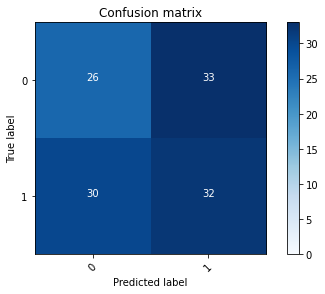

2022-08-22 15:30:25 - [Epoch Train: 71] loss: 0.0034, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:30:25 - [Epoch Valid: 71] loss: 2.6001, auc: 0.4572, acc: 0.4793, time: 6.00 s


 71%|█████████████████████████████▊            | 71/100 [37:48<14:45, 30.55s/it]

2022-08-22 15:30:25 - EPOCH: 72
2022-08-22 15:30:28 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:30:30 - Train Step 20/122, train_loss: 0.0003
2022-08-22 15:30:32 - Train Step 30/122, train_loss: 0.0066
2022-08-22 15:30:34 - Train Step 40/122, train_loss: 0.0050
2022-08-22 15:30:35 - Train Step 50/122, train_loss: 0.0040
2022-08-22 15:30:37 - Train Step 60/122, train_loss: 0.0034
2022-08-22 15:30:39 - Train Step 70/122, train_loss: 0.0030
2022-08-22 15:30:41 - Train Step 80/122, train_loss: 0.0066
2022-08-22 15:30:43 - Train Step 90/122, train_loss: 0.0059
2022-08-22 15:30:45 - Train Step 100/122, train_loss: 0.0053
2022-08-22 15:30:47 - Train Step 110/122, train_loss: 0.0049
2022-08-22 15:30:49 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:30:51 - Valid Step 5/31, valid_loss: 2.6995
2022-08-22 15:30:52 - Valid Step 10/31, valid_loss: 2.4224
2022-08-22 15:30:53 - Valid Step 15/31, valid_loss: 2.6883
2022-08-22 15:30:53

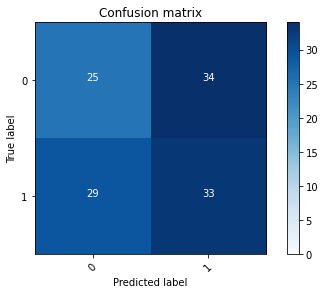

2022-08-22 15:30:56 - [Epoch Train: 72] loss: 0.0044, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 15:30:56 - [Epoch Valid: 72] loss: 2.6413, auc: 0.4505, acc: 0.4793, time: 6.00 s


 72%|██████████████████████████████▏           | 72/100 [38:19<14:11, 30.42s/it]

2022-08-22 15:30:56 - EPOCH: 73
2022-08-22 15:30:58 - Train Step 10/122, train_loss: 0.0006
2022-08-22 15:31:00 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:31:02 - Train Step 30/122, train_loss: 0.0076
2022-08-22 15:31:04 - Train Step 40/122, train_loss: 0.0058
2022-08-22 15:31:06 - Train Step 50/122, train_loss: 0.0047
2022-08-22 15:31:08 - Train Step 60/122, train_loss: 0.0039
2022-08-22 15:31:10 - Train Step 70/122, train_loss: 0.0034
2022-08-22 15:31:12 - Train Step 80/122, train_loss: 0.0030
2022-08-22 15:31:14 - Train Step 90/122, train_loss: 0.0027
2022-08-22 15:31:16 - Train Step 100/122, train_loss: 0.0059
2022-08-22 15:31:18 - Train Step 110/122, train_loss: 0.0053
2022-08-22 15:31:20 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:31:21 - Valid Step 5/31, valid_loss: 2.1765
2022-08-22 15:31:22 - Valid Step 10/31, valid_loss: 2.0793
2022-08-22 15:31:23 - Valid Step 15/31, valid_loss: 2.1338
2022-08-22 15:31:24

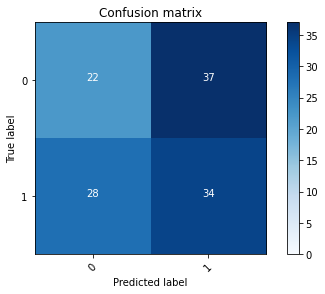

2022-08-22 15:31:26 - [Epoch Train: 73] loss: 0.0049, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:31:26 - [Epoch Valid: 73] loss: 2.7534, auc: 0.4456, acc: 0.4628, time: 6.00 s


 73%|██████████████████████████████▋           | 73/100 [38:49<13:44, 30.55s/it]

2022-08-22 15:31:26 - EPOCH: 74
2022-08-22 15:31:29 - Train Step 10/122, train_loss: 0.0238
2022-08-22 15:31:31 - Train Step 20/122, train_loss: 0.0120
2022-08-22 15:31:33 - Train Step 30/122, train_loss: 0.0080
2022-08-22 15:31:35 - Train Step 40/122, train_loss: 0.0060
2022-08-22 15:31:37 - Train Step 50/122, train_loss: 0.0049
2022-08-22 15:31:39 - Train Step 60/122, train_loss: 0.0041
2022-08-22 15:31:41 - Train Step 70/122, train_loss: 0.0035
2022-08-22 15:31:43 - Train Step 80/122, train_loss: 0.0031
2022-08-22 15:31:45 - Train Step 90/122, train_loss: 0.0028
2022-08-22 15:31:47 - Train Step 100/122, train_loss: 0.0025
2022-08-22 15:31:49 - Train Step 110/122, train_loss: 0.0044
2022-08-22 15:31:51 - Train Step 120/122, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:31:53 - Valid Step 5/31, valid_loss: 4.1838
2022-08-22 15:31:54 - Valid Step 10/31, valid_loss: 3.6984
2022-08-22 15:31:55 - Valid Step 15/31, valid_loss: 3.5092
2022-08-22 15:31:56

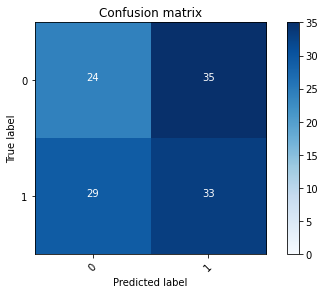

2022-08-22 15:31:58 - [Epoch Train: 74] loss: 0.0040, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:31:58 - [Epoch Valid: 74] loss: 2.6785, auc: 0.4541, acc: 0.4711, time: 6.00 s


 74%|███████████████████████████████           | 74/100 [39:21<13:20, 30.78s/it]

2022-08-22 15:31:58 - EPOCH: 75
2022-08-22 15:32:00 - Train Step 10/122, train_loss: 0.0004
2022-08-22 15:32:02 - Train Step 20/122, train_loss: 0.0004
2022-08-22 15:32:04 - Train Step 30/122, train_loss: 0.0003
2022-08-22 15:32:06 - Train Step 40/122, train_loss: 0.0003
2022-08-22 15:32:08 - Train Step 50/122, train_loss: 0.0002
2022-08-22 15:32:10 - Train Step 60/122, train_loss: 0.0002
2022-08-22 15:32:12 - Train Step 70/122, train_loss: 0.0035
2022-08-22 15:32:14 - Train Step 80/122, train_loss: 0.0031
2022-08-22 15:32:16 - Train Step 90/122, train_loss: 0.0027
2022-08-22 15:32:18 - Train Step 100/122, train_loss: 0.0052
2022-08-22 15:32:20 - Train Step 110/122, train_loss: 0.0047
2022-08-22 15:32:22 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:32:23 - Valid Step 5/31, valid_loss: 1.9175
2022-08-22 15:32:24 - Valid Step 10/31, valid_loss: 2.9336
2022-08-22 15:32:25 - Valid Step 15/31, valid_loss: 2.5615
2022-08-22 15:32:26

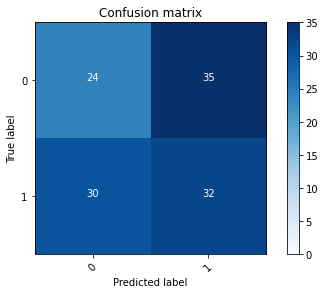

2022-08-22 15:32:28 - [Epoch Train: 75] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:32:28 - [Epoch Valid: 75] loss: 2.4798, auc: 0.4478, acc: 0.4628, time: 6.00 s


 75%|███████████████████████████████▌          | 75/100 [39:51<12:47, 30.69s/it]

2022-08-22 15:32:28 - EPOCH: 76
2022-08-22 15:32:30 - Train Step 10/122, train_loss: 0.0117
2022-08-22 15:32:32 - Train Step 20/122, train_loss: 0.0059
2022-08-22 15:32:34 - Train Step 30/122, train_loss: 0.0040
2022-08-22 15:32:36 - Train Step 40/122, train_loss: 0.0030
2022-08-22 15:32:38 - Train Step 50/122, train_loss: 0.0025
2022-08-22 15:32:40 - Train Step 60/122, train_loss: 0.0064
2022-08-22 15:32:42 - Train Step 70/122, train_loss: 0.0055
2022-08-22 15:32:44 - Train Step 80/122, train_loss: 0.0049
2022-08-22 15:32:46 - Train Step 90/122, train_loss: 0.0043
2022-08-22 15:32:48 - Train Step 100/122, train_loss: 0.0039
2022-08-22 15:32:50 - Train Step 110/122, train_loss: 0.0036
2022-08-22 15:32:52 - Train Step 120/122, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:32:54 - Valid Step 5/31, valid_loss: 2.2176
2022-08-22 15:32:55 - Valid Step 10/31, valid_loss: 3.1910
2022-08-22 15:32:56 - Valid Step 15/31, valid_loss: 3.0330
2022-08-22 15:32:57

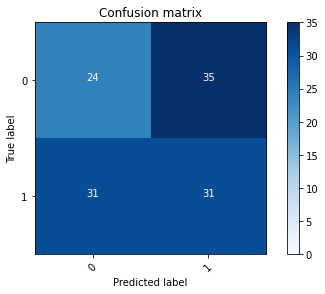

2022-08-22 15:32:59 - [Epoch Train: 76] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:32:59 - [Epoch Valid: 76] loss: 2.5879, auc: 0.4546, acc: 0.4545, time: 6.00 s


 76%|███████████████████████████████▉          | 76/100 [40:22<12:17, 30.72s/it]

2022-08-22 15:32:59 - EPOCH: 77
2022-08-22 15:33:01 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:33:03 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:33:05 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:33:07 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:33:09 - Train Step 50/122, train_loss: 0.0001
2022-08-22 15:33:11 - Train Step 60/122, train_loss: 0.0001
2022-08-22 15:33:13 - Train Step 70/122, train_loss: 0.0001
2022-08-22 15:33:15 - Train Step 80/122, train_loss: 0.0001
2022-08-22 15:33:17 - Train Step 90/122, train_loss: 0.0001
2022-08-22 15:33:20 - Train Step 100/122, train_loss: 0.0001
2022-08-22 15:33:22 - Train Step 110/122, train_loss: 0.0062
2022-08-22 15:33:24 - Train Step 120/122, train_loss: 0.0057
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:33:26 - Valid Step 5/31, valid_loss: 3.4268
2022-08-22 15:33:26 - Valid Step 10/31, valid_loss: 3.1298
2022-08-22 15:33:27 - Valid Step 15/31, valid_loss: 2.7098
2022-08-22 15:33:28

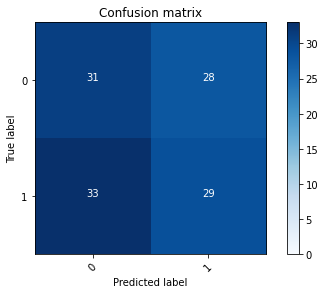

2022-08-22 15:33:30 - [Epoch Train: 77] loss: 0.0056, auc: 1.0000, acc: 0.9959, time: 25.00 s            
2022-08-22 15:33:30 - [Epoch Valid: 77] loss: 2.6892, auc: 0.4593, acc: 0.4959, time: 6.00 s


 77%|████████████████████████████████▎         | 77/100 [40:53<11:50, 30.90s/it]

2022-08-22 15:33:30 - EPOCH: 78
2022-08-22 15:33:33 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:33:34 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:33:37 - Train Step 30/122, train_loss: 0.0051
2022-08-22 15:33:38 - Train Step 40/122, train_loss: 0.0039
2022-08-22 15:33:40 - Train Step 50/122, train_loss: 0.0031
2022-08-22 15:33:42 - Train Step 60/122, train_loss: 0.0026
2022-08-22 15:33:44 - Train Step 70/122, train_loss: 0.0023
2022-08-22 15:33:46 - Train Step 80/122, train_loss: 0.0020
2022-08-22 15:33:48 - Train Step 90/122, train_loss: 0.0018
2022-08-22 15:33:50 - Train Step 100/122, train_loss: 0.0017
2022-08-22 15:33:52 - Train Step 110/122, train_loss: 0.0015
2022-08-22 15:33:54 - Train Step 120/122, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:33:56 - Valid Step 5/31, valid_loss: 2.5691
2022-08-22 15:33:57 - Valid Step 10/31, valid_loss: 3.1062
2022-08-22 15:33:58 - Valid Step 15/31, valid_loss: 2.7185
2022-08-22 15:33:59

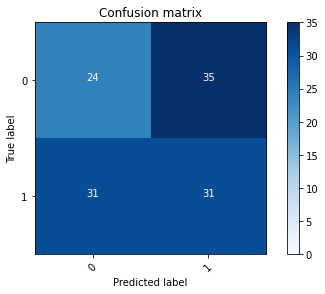

2022-08-22 15:34:01 - [Epoch Train: 78] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:34:01 - [Epoch Valid: 78] loss: 2.5150, auc: 0.4522, acc: 0.4545, time: 6.00 s


 78%|████████████████████████████████▊         | 78/100 [41:24<11:17, 30.78s/it]

2022-08-22 15:34:01 - EPOCH: 79
2022-08-22 15:34:03 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:34:05 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:34:07 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:34:09 - Train Step 40/122, train_loss: 0.0002
2022-08-22 15:34:11 - Train Step 50/122, train_loss: 0.0002
2022-08-22 15:34:13 - Train Step 60/122, train_loss: 0.0002
2022-08-22 15:34:14 - Train Step 70/122, train_loss: 0.0002
2022-08-22 15:34:16 - Train Step 80/122, train_loss: 0.0002
2022-08-22 15:34:18 - Train Step 90/122, train_loss: 0.0002
2022-08-22 15:34:20 - Train Step 100/122, train_loss: 0.0015
2022-08-22 15:34:22 - Train Step 110/122, train_loss: 0.0037
2022-08-22 15:34:24 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:34:26 - Valid Step 5/31, valid_loss: 1.8812
2022-08-22 15:34:27 - Valid Step 10/31, valid_loss: 2.8837
2022-08-22 15:34:28 - Valid Step 15/31, valid_loss: 2.5885
2022-08-22 15:34:29

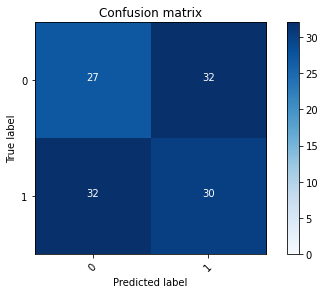

2022-08-22 15:34:31 - [Epoch Train: 79] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:34:31 - [Epoch Valid: 79] loss: 2.6973, auc: 0.4582, acc: 0.4711, time: 6.00 s


 79%|█████████████████████████████████▏        | 79/100 [41:54<10:41, 30.57s/it]

2022-08-22 15:34:31 - EPOCH: 80
2022-08-22 15:34:33 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:34:35 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:34:37 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:34:39 - Train Step 40/122, train_loss: 0.0002
2022-08-22 15:34:41 - Train Step 50/122, train_loss: 0.0052
2022-08-22 15:34:43 - Train Step 60/122, train_loss: 0.0043
2022-08-22 15:34:45 - Train Step 70/122, train_loss: 0.0037
2022-08-22 15:34:47 - Train Step 80/122, train_loss: 0.0033
2022-08-22 15:34:49 - Train Step 90/122, train_loss: 0.0030
2022-08-22 15:34:51 - Train Step 100/122, train_loss: 0.0046
2022-08-22 15:34:53 - Train Step 110/122, train_loss: 0.0042
2022-08-22 15:34:55 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:34:56 - Valid Step 5/31, valid_loss: 3.6461
2022-08-22 15:34:57 - Valid Step 10/31, valid_loss: 3.4306
2022-08-22 15:34:58 - Valid Step 15/31, valid_loss: 2.9803
2022-08-22 15:34:59

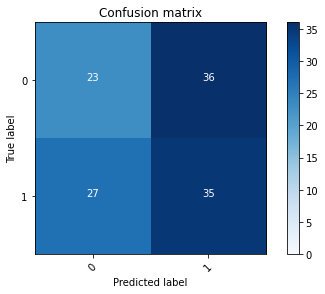

2022-08-22 15:35:01 - [Epoch Train: 80] loss: 0.0038, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:35:01 - [Epoch Valid: 80] loss: 2.6007, auc: 0.4609, acc: 0.4793, time: 6.00 s


 80%|█████████████████████████████████▌        | 80/100 [42:24<10:10, 30.54s/it]

2022-08-22 15:35:01 - EPOCH: 81
2022-08-22 15:35:04 - Train Step 10/122, train_loss: 0.0168
2022-08-22 15:35:06 - Train Step 20/122, train_loss: 0.0159
2022-08-22 15:35:08 - Train Step 30/122, train_loss: 0.0107
2022-08-22 15:35:09 - Train Step 40/122, train_loss: 0.0080
2022-08-22 15:35:11 - Train Step 50/122, train_loss: 0.0064
2022-08-22 15:35:13 - Train Step 60/122, train_loss: 0.0054
2022-08-22 15:35:15 - Train Step 70/122, train_loss: 0.0046
2022-08-22 15:35:17 - Train Step 80/122, train_loss: 0.0041
2022-08-22 15:35:19 - Train Step 90/122, train_loss: 0.0036
2022-08-22 15:35:21 - Train Step 100/122, train_loss: 0.0033
2022-08-22 15:35:23 - Train Step 110/122, train_loss: 0.0030
2022-08-22 15:35:25 - Train Step 120/122, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:35:27 - Valid Step 5/31, valid_loss: 2.6558
2022-08-22 15:35:28 - Valid Step 10/31, valid_loss: 3.2519
2022-08-22 15:35:29 - Valid Step 15/31, valid_loss: 2.8545
2022-08-22 15:35:30

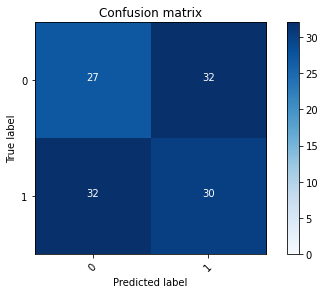

2022-08-22 15:35:32 - [Epoch Train: 81] loss: 0.0027, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:35:32 - [Epoch Valid: 81] loss: 2.7972, auc: 0.4584, acc: 0.4711, time: 6.00 s


 81%|██████████████████████████████████        | 81/100 [42:55<09:39, 30.50s/it]

2022-08-22 15:35:32 - EPOCH: 82
2022-08-22 15:35:34 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:35:36 - Train Step 20/122, train_loss: 0.0065
2022-08-22 15:35:38 - Train Step 30/122, train_loss: 0.0044
2022-08-22 15:35:40 - Train Step 40/122, train_loss: 0.0033
2022-08-22 15:35:42 - Train Step 50/122, train_loss: 0.0027
2022-08-22 15:35:44 - Train Step 60/122, train_loss: 0.0078
2022-08-22 15:35:46 - Train Step 70/122, train_loss: 0.0067
2022-08-22 15:35:48 - Train Step 80/122, train_loss: 0.0059
2022-08-22 15:35:50 - Train Step 90/122, train_loss: 0.0052
2022-08-22 15:35:52 - Train Step 100/122, train_loss: 0.0047
2022-08-22 15:35:54 - Train Step 110/122, train_loss: 0.0044
2022-08-22 15:35:56 - Train Step 120/122, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:35:58 - Valid Step 5/31, valid_loss: 2.2230
2022-08-22 15:35:59 - Valid Step 10/31, valid_loss: 2.8765
2022-08-22 15:36:00 - Valid Step 15/31, valid_loss: 2.9273
2022-08-22 15:36:01

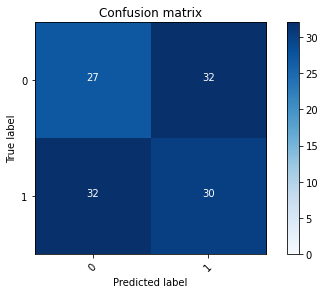

2022-08-22 15:36:03 - [Epoch Train: 82] loss: 0.0040, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:36:03 - [Epoch Valid: 82] loss: 2.6577, auc: 0.4587, acc: 0.4711, time: 6.00 s


 82%|██████████████████████████████████▍       | 82/100 [43:26<09:11, 30.64s/it]

2022-08-22 15:36:03 - EPOCH: 83
2022-08-22 15:36:05 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:36:07 - Train Step 20/122, train_loss: 0.0087
2022-08-22 15:36:09 - Train Step 30/122, train_loss: 0.0058
2022-08-22 15:36:11 - Train Step 40/122, train_loss: 0.0044
2022-08-22 15:36:13 - Train Step 50/122, train_loss: 0.0036
2022-08-22 15:36:15 - Train Step 60/122, train_loss: 0.0030
2022-08-22 15:36:16 - Train Step 70/122, train_loss: 0.0026
2022-08-22 15:36:18 - Train Step 80/122, train_loss: 0.0023
2022-08-22 15:36:20 - Train Step 90/122, train_loss: 0.0020
2022-08-22 15:36:22 - Train Step 100/122, train_loss: 0.0019
2022-08-22 15:36:24 - Train Step 110/122, train_loss: 0.0035
2022-08-22 15:36:26 - Train Step 120/122, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:36:28 - Valid Step 5/31, valid_loss: 1.4469
2022-08-22 15:36:29 - Valid Step 10/31, valid_loss: 1.9158
2022-08-22 15:36:30 - Valid Step 15/31, valid_loss: 1.8855
2022-08-22 15:36:31

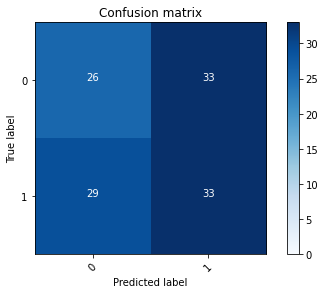

2022-08-22 15:36:33 - [Epoch Train: 83] loss: 0.0032, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:36:33 - [Epoch Valid: 83] loss: 2.6195, auc: 0.4650, acc: 0.4876, time: 6.00 s


 83%|██████████████████████████████████▊       | 83/100 [43:56<08:38, 30.53s/it]

2022-08-22 15:36:33 - EPOCH: 84
2022-08-22 15:36:35 - Train Step 10/122, train_loss: 0.0003
2022-08-22 15:36:37 - Train Step 20/122, train_loss: 0.0058
2022-08-22 15:36:39 - Train Step 30/122, train_loss: 0.0040
2022-08-22 15:36:41 - Train Step 40/122, train_loss: 0.0030
2022-08-22 15:36:43 - Train Step 50/122, train_loss: 0.0025
2022-08-22 15:36:45 - Train Step 60/122, train_loss: 0.0021
2022-08-22 15:36:47 - Train Step 70/122, train_loss: 0.0018
2022-08-22 15:36:49 - Train Step 80/122, train_loss: 0.0016
2022-08-22 15:36:51 - Train Step 90/122, train_loss: 0.0014
2022-08-22 15:36:53 - Train Step 100/122, train_loss: 0.0013
2022-08-22 15:36:55 - Train Step 110/122, train_loss: 0.0037
2022-08-22 15:36:57 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:36:58 - Valid Step 5/31, valid_loss: 2.5031
2022-08-22 15:36:59 - Valid Step 10/31, valid_loss: 2.1917
2022-08-22 15:37:00 - Valid Step 15/31, valid_loss: 2.4868
2022-08-22 15:37:01

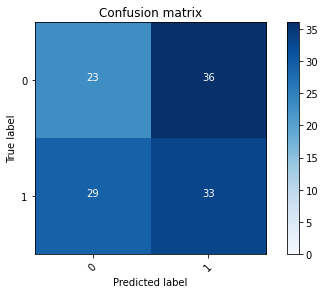

2022-08-22 15:37:03 - [Epoch Train: 84] loss: 0.0034, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:37:03 - [Epoch Valid: 84] loss: 2.7402, auc: 0.4606, acc: 0.4628, time: 6.00 s


 84%|███████████████████████████████████▎      | 84/100 [44:26<08:07, 30.45s/it]

2022-08-22 15:37:03 - EPOCH: 85
2022-08-22 15:37:06 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:37:08 - Train Step 20/122, train_loss: 0.0106
2022-08-22 15:37:10 - Train Step 30/122, train_loss: 0.0071
2022-08-22 15:37:11 - Train Step 40/122, train_loss: 0.0054
2022-08-22 15:37:14 - Train Step 50/122, train_loss: 0.0043
2022-08-22 15:37:16 - Train Step 60/122, train_loss: 0.0036
2022-08-22 15:37:17 - Train Step 70/122, train_loss: 0.0031
2022-08-22 15:37:19 - Train Step 80/122, train_loss: 0.0028
2022-08-22 15:37:21 - Train Step 90/122, train_loss: 0.0053
2022-08-22 15:37:23 - Train Step 100/122, train_loss: 0.0048
2022-08-22 15:37:25 - Train Step 110/122, train_loss: 0.0043
2022-08-22 15:37:27 - Train Step 120/122, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:37:29 - Valid Step 5/31, valid_loss: 4.6847
2022-08-22 15:37:30 - Valid Step 10/31, valid_loss: 3.7411
2022-08-22 15:37:31 - Valid Step 15/31, valid_loss: 3.2005
2022-08-22 15:37:32

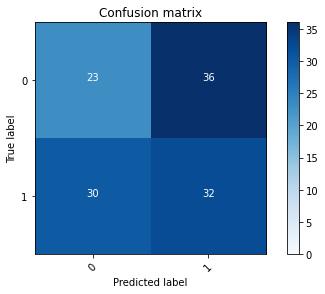

2022-08-22 15:37:34 - [Epoch Train: 85] loss: 0.0040, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:37:34 - [Epoch Valid: 85] loss: 2.9238, auc: 0.4609, acc: 0.4545, time: 6.00 s


 85%|███████████████████████████████████▋      | 85/100 [44:57<07:38, 30.59s/it]

2022-08-22 15:37:34 - EPOCH: 86
2022-08-22 15:37:36 - Train Step 10/122, train_loss: 0.0032
2022-08-22 15:37:38 - Train Step 20/122, train_loss: 0.0017
2022-08-22 15:37:40 - Train Step 30/122, train_loss: 0.0012
2022-08-22 15:37:42 - Train Step 40/122, train_loss: 0.0009
2022-08-22 15:37:44 - Train Step 50/122, train_loss: 0.0008
2022-08-22 15:37:46 - Train Step 60/122, train_loss: 0.0006
2022-08-22 15:37:48 - Train Step 70/122, train_loss: 0.0006
2022-08-22 15:37:50 - Train Step 80/122, train_loss: 0.0025
2022-08-22 15:37:52 - Train Step 90/122, train_loss: 0.0052
2022-08-22 15:37:54 - Train Step 100/122, train_loss: 0.0047
2022-08-22 15:37:56 - Train Step 110/122, train_loss: 0.0043
2022-08-22 15:37:58 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:38:00 - Valid Step 5/31, valid_loss: 4.9714
2022-08-22 15:38:01 - Valid Step 10/31, valid_loss: 3.5896
2022-08-22 15:38:02 - Valid Step 15/31, valid_loss: 3.1311
2022-08-22 15:38:03

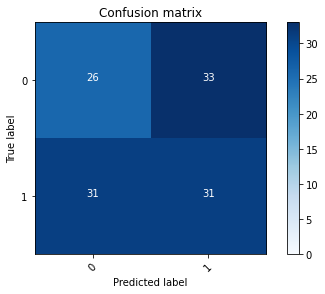

2022-08-22 15:38:05 - [Epoch Train: 86] loss: 0.0039, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:38:05 - [Epoch Valid: 86] loss: 2.8405, auc: 0.4527, acc: 0.4711, time: 6.00 s


 86%|████████████████████████████████████      | 86/100 [45:28<07:09, 30.66s/it]

2022-08-22 15:38:05 - EPOCH: 87
2022-08-22 15:38:07 - Train Step 10/122, train_loss: 0.0002
2022-08-22 15:38:09 - Train Step 20/122, train_loss: 0.0064
2022-08-22 15:38:11 - Train Step 30/122, train_loss: 0.0043
2022-08-22 15:38:13 - Train Step 40/122, train_loss: 0.0115
2022-08-22 15:38:15 - Train Step 50/122, train_loss: 0.0092
2022-08-22 15:38:17 - Train Step 60/122, train_loss: 0.0077
2022-08-22 15:38:19 - Train Step 70/122, train_loss: 0.0066
2022-08-22 15:38:21 - Train Step 80/122, train_loss: 0.0058
2022-08-22 15:38:23 - Train Step 90/122, train_loss: 0.0052
2022-08-22 15:38:25 - Train Step 100/122, train_loss: 0.0047
2022-08-22 15:38:27 - Train Step 110/122, train_loss: 0.0043
2022-08-22 15:38:29 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:38:30 - Valid Step 5/31, valid_loss: 1.2184
2022-08-22 15:38:31 - Valid Step 10/31, valid_loss: 2.0775
2022-08-22 15:38:32 - Valid Step 15/31, valid_loss: 2.3862
2022-08-22 15:38:33

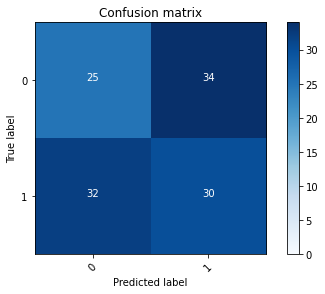

2022-08-22 15:38:35 - [Epoch Train: 87] loss: 0.0039, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:38:35 - [Epoch Valid: 87] loss: 2.6157, auc: 0.4481, acc: 0.4545, time: 6.00 s


 87%|████████████████████████████████████▌     | 87/100 [45:58<06:37, 30.54s/it]

2022-08-22 15:38:35 - EPOCH: 88
2022-08-22 15:38:38 - Train Step 10/122, train_loss: 0.0171
2022-08-22 15:38:39 - Train Step 20/122, train_loss: 0.0087
2022-08-22 15:38:41 - Train Step 30/122, train_loss: 0.0059
2022-08-22 15:38:43 - Train Step 40/122, train_loss: 0.0045
2022-08-22 15:38:45 - Train Step 50/122, train_loss: 0.0037
2022-08-22 15:38:47 - Train Step 60/122, train_loss: 0.0031
2022-08-22 15:38:49 - Train Step 70/122, train_loss: 0.0027
2022-08-22 15:38:51 - Train Step 80/122, train_loss: 0.0023
2022-08-22 15:38:53 - Train Step 90/122, train_loss: 0.0021
2022-08-22 15:38:55 - Train Step 100/122, train_loss: 0.0044
2022-08-22 15:38:57 - Train Step 110/122, train_loss: 0.0040
2022-08-22 15:38:59 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:39:00 - Valid Step 5/31, valid_loss: 2.6337
2022-08-22 15:39:01 - Valid Step 10/31, valid_loss: 3.7824
2022-08-22 15:39:02 - Valid Step 15/31, valid_loss: 3.1763
2022-08-22 15:39:03

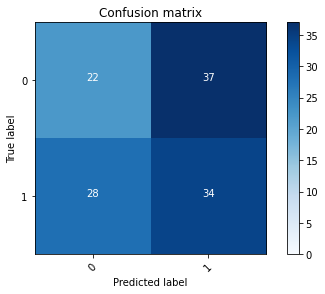

2022-08-22 15:39:05 - [Epoch Train: 88] loss: 0.0036, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:39:05 - [Epoch Valid: 88] loss: 2.8576, auc: 0.4457, acc: 0.4628, time: 6.00 s


 88%|████████████████████████████████████▉     | 88/100 [46:28<06:05, 30.44s/it]

2022-08-22 15:39:05 - EPOCH: 89
2022-08-22 15:39:08 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:39:10 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:39:11 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:39:13 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:39:15 - Train Step 50/122, train_loss: 0.0001
2022-08-22 15:39:17 - Train Step 60/122, train_loss: 0.0032
2022-08-22 15:39:19 - Train Step 70/122, train_loss: 0.0028
2022-08-22 15:39:21 - Train Step 80/122, train_loss: 0.0024
2022-08-22 15:39:23 - Train Step 90/122, train_loss: 0.0022
2022-08-22 15:39:25 - Train Step 100/122, train_loss: 0.0020
2022-08-22 15:39:27 - Train Step 110/122, train_loss: 0.0018
2022-08-22 15:39:29 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:39:31 - Valid Step 5/31, valid_loss: 1.8898
2022-08-22 15:39:32 - Valid Step 10/31, valid_loss: 2.9896
2022-08-22 15:39:33 - Valid Step 15/31, valid_loss: 2.7621
2022-08-22 15:39:33

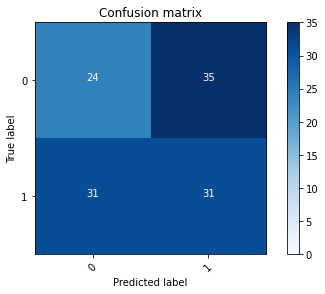

2022-08-22 15:39:36 - [Epoch Train: 89] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 15:39:36 - [Epoch Valid: 89] loss: 2.6720, auc: 0.4505, acc: 0.4545, time: 6.00 s


 89%|█████████████████████████████████████▍    | 89/100 [46:59<05:34, 30.37s/it]

2022-08-22 15:39:36 - EPOCH: 90
2022-08-22 15:39:38 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:39:40 - Train Step 20/122, train_loss: 0.0058
2022-08-22 15:39:42 - Train Step 30/122, train_loss: 0.0040
2022-08-22 15:39:44 - Train Step 40/122, train_loss: 0.0030
2022-08-22 15:39:46 - Train Step 50/122, train_loss: 0.0025
2022-08-22 15:39:48 - Train Step 60/122, train_loss: 0.0021
2022-08-22 15:39:50 - Train Step 70/122, train_loss: 0.0018
2022-08-22 15:39:52 - Train Step 80/122, train_loss: 0.0016
2022-08-22 15:39:53 - Train Step 90/122, train_loss: 0.0015
2022-08-22 15:39:55 - Train Step 100/122, train_loss: 0.0013
2022-08-22 15:39:57 - Train Step 110/122, train_loss: 0.0012
2022-08-22 15:39:59 - Train Step 120/122, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:40:01 - Valid Step 5/31, valid_loss: 2.0798
2022-08-22 15:40:02 - Valid Step 10/31, valid_loss: 2.2962
2022-08-22 15:40:03 - Valid Step 15/31, valid_loss: 2.4534
2022-08-22 15:40:04

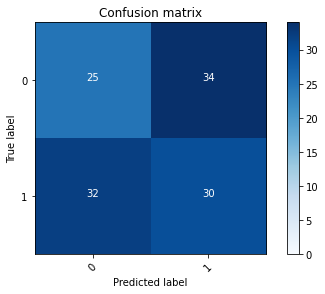

2022-08-22 15:40:06 - [Epoch Train: 90] loss: 0.0035, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 15:40:06 - [Epoch Valid: 90] loss: 2.5745, auc: 0.4579, acc: 0.4545, time: 6.00 s


 90%|█████████████████████████████████████▊    | 90/100 [47:29<05:03, 30.35s/it]

2022-08-22 15:40:06 - EPOCH: 91
2022-08-22 15:40:08 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:40:10 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:40:12 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:40:14 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:40:16 - Train Step 50/122, train_loss: 0.0046
2022-08-22 15:40:18 - Train Step 60/122, train_loss: 0.0039
2022-08-22 15:40:20 - Train Step 70/122, train_loss: 0.0033
2022-08-22 15:40:22 - Train Step 80/122, train_loss: 0.0029
2022-08-22 15:40:24 - Train Step 90/122, train_loss: 0.0027
2022-08-22 15:40:26 - Train Step 100/122, train_loss: 0.0024
2022-08-22 15:40:28 - Train Step 110/122, train_loss: 0.0049
2022-08-22 15:40:30 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:40:32 - Valid Step 5/31, valid_loss: 2.8736
2022-08-22 15:40:33 - Valid Step 10/31, valid_loss: 1.9350
2022-08-22 15:40:34 - Valid Step 15/31, valid_loss: 2.2164
2022-08-22 15:40:35

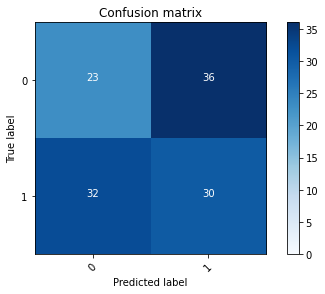

2022-08-22 15:40:37 - [Epoch Train: 91] loss: 0.0045, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:40:37 - [Epoch Valid: 91] loss: 2.7279, auc: 0.4630, acc: 0.4380, time: 6.00 s


 91%|██████████████████████████████████████▏   | 91/100 [48:00<04:35, 30.62s/it]

2022-08-22 15:40:37 - EPOCH: 92
2022-08-22 15:40:39 - Train Step 10/122, train_loss: 0.0227
2022-08-22 15:40:41 - Train Step 20/122, train_loss: 0.0238
2022-08-22 15:40:43 - Train Step 30/122, train_loss: 0.0159
2022-08-22 15:40:45 - Train Step 40/122, train_loss: 0.0119
2022-08-22 15:40:47 - Train Step 50/122, train_loss: 0.0096
2022-08-22 15:40:49 - Train Step 60/122, train_loss: 0.0080
2022-08-22 15:40:51 - Train Step 70/122, train_loss: 0.0069
2022-08-22 15:40:53 - Train Step 80/122, train_loss: 0.0061
2022-08-22 15:40:55 - Train Step 90/122, train_loss: 0.0054
2022-08-22 15:40:57 - Train Step 100/122, train_loss: 0.0049
2022-08-22 15:40:59 - Train Step 110/122, train_loss: 0.0044
2022-08-22 15:41:01 - Train Step 120/122, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:41:03 - Valid Step 5/31, valid_loss: 3.8296
2022-08-22 15:41:04 - Valid Step 10/31, valid_loss: 3.4631
2022-08-22 15:41:05 - Valid Step 15/31, valid_loss: 3.0971
2022-08-22 15:41:06

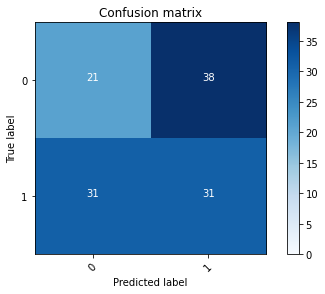

2022-08-22 15:41:08 - [Epoch Train: 92] loss: 0.0040, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:41:08 - [Epoch Valid: 92] loss: 2.8103, auc: 0.4553, acc: 0.4298, time: 6.00 s


 92%|██████████████████████████████████████▋   | 92/100 [48:31<04:04, 30.59s/it]

2022-08-22 15:41:08 - EPOCH: 93
2022-08-22 15:41:10 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:41:12 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:41:14 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:41:16 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:41:18 - Train Step 50/122, train_loss: 0.0058
2022-08-22 15:41:20 - Train Step 60/122, train_loss: 0.0048
2022-08-22 15:41:22 - Train Step 70/122, train_loss: 0.0091
2022-08-22 15:41:24 - Train Step 80/122, train_loss: 0.0080
2022-08-22 15:41:26 - Train Step 90/122, train_loss: 0.0071
2022-08-22 15:41:28 - Train Step 100/122, train_loss: 0.0064
2022-08-22 15:41:30 - Train Step 110/122, train_loss: 0.0059
2022-08-22 15:41:32 - Train Step 120/122, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:41:33 - Valid Step 5/31, valid_loss: 2.7385
2022-08-22 15:41:34 - Valid Step 10/31, valid_loss: 2.9883
2022-08-22 15:41:36 - Valid Step 15/31, valid_loss: 2.7079
2022-08-22 15:41:36

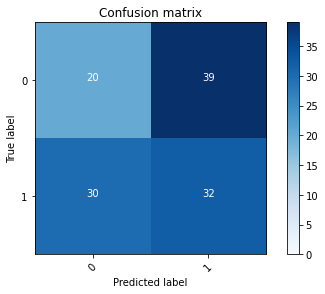

2022-08-22 15:41:39 - [Epoch Train: 93] loss: 0.0054, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:41:39 - [Epoch Valid: 93] loss: 2.6642, auc: 0.4572, acc: 0.4298, time: 6.00 s


 93%|███████████████████████████████████████   | 93/100 [49:02<03:34, 30.67s/it]

2022-08-22 15:41:39 - EPOCH: 94
2022-08-22 15:41:41 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:41:43 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:41:45 - Train Step 30/122, train_loss: 0.0108
2022-08-22 15:41:47 - Train Step 40/122, train_loss: 0.0082
2022-08-22 15:41:49 - Train Step 50/122, train_loss: 0.0066
2022-08-22 15:41:51 - Train Step 60/122, train_loss: 0.0055
2022-08-22 15:41:53 - Train Step 70/122, train_loss: 0.0048
2022-08-22 15:41:55 - Train Step 80/122, train_loss: 0.0042
2022-08-22 15:41:57 - Train Step 90/122, train_loss: 0.0038
2022-08-22 15:41:59 - Train Step 100/122, train_loss: 0.0034
2022-08-22 15:42:01 - Train Step 110/122, train_loss: 0.0055
2022-08-22 15:42:03 - Train Step 120/122, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:42:04 - Valid Step 5/31, valid_loss: 1.8658
2022-08-22 15:42:05 - Valid Step 10/31, valid_loss: 2.2319
2022-08-22 15:42:06 - Valid Step 15/31, valid_loss: 2.8311
2022-08-22 15:42:07

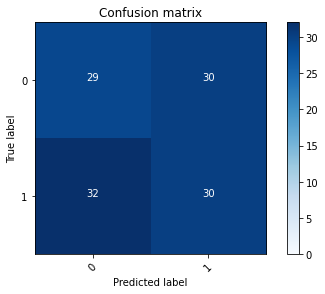

2022-08-22 15:42:09 - [Epoch Train: 94] loss: 0.0050, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:42:09 - [Epoch Valid: 94] loss: 2.7544, auc: 0.4584, acc: 0.4876, time: 6.00 s


 94%|███████████████████████████████████████▍  | 94/100 [49:32<03:03, 30.64s/it]

2022-08-22 15:42:09 - EPOCH: 95
2022-08-22 15:42:11 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:42:13 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:42:15 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:42:17 - Train Step 40/122, train_loss: 0.0002
2022-08-22 15:42:19 - Train Step 50/122, train_loss: 0.0001
2022-08-22 15:42:21 - Train Step 60/122, train_loss: 0.0001
2022-08-22 15:42:23 - Train Step 70/122, train_loss: 0.0001
2022-08-22 15:42:25 - Train Step 80/122, train_loss: 0.0047
2022-08-22 15:42:27 - Train Step 90/122, train_loss: 0.0042
2022-08-22 15:42:30 - Train Step 100/122, train_loss: 0.0038
2022-08-22 15:42:32 - Train Step 110/122, train_loss: 0.0035
2022-08-22 15:42:34 - Train Step 120/122, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:42:35 - Valid Step 5/31, valid_loss: 2.9435
2022-08-22 15:42:36 - Valid Step 10/31, valid_loss: 2.8201
2022-08-22 15:42:37 - Valid Step 15/31, valid_loss: 2.9918
2022-08-22 15:42:38

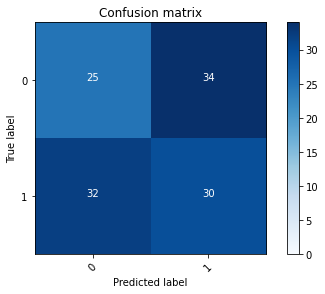

2022-08-22 15:42:40 - [Epoch Train: 95] loss: 0.0031, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 15:42:40 - [Epoch Valid: 95] loss: 2.6824, auc: 0.4589, acc: 0.4545, time: 6.00 s


 95%|███████████████████████████████████████▉  | 95/100 [50:03<02:33, 30.75s/it]

2022-08-22 15:42:40 - EPOCH: 96
2022-08-22 15:42:42 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:42:44 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:42:46 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:42:48 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:42:50 - Train Step 50/122, train_loss: 0.0046
2022-08-22 15:42:52 - Train Step 60/122, train_loss: 0.0038
2022-08-22 15:42:54 - Train Step 70/122, train_loss: 0.0033
2022-08-22 15:42:56 - Train Step 80/122, train_loss: 0.0029
2022-08-22 15:42:58 - Train Step 90/122, train_loss: 0.0026
2022-08-22 15:43:00 - Train Step 100/122, train_loss: 0.0043
2022-08-22 15:43:02 - Train Step 110/122, train_loss: 0.0039
2022-08-22 15:43:04 - Train Step 120/122, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:43:05 - Valid Step 5/31, valid_loss: 3.6412
2022-08-22 15:43:06 - Valid Step 10/31, valid_loss: 2.8207
2022-08-22 15:43:07 - Valid Step 15/31, valid_loss: 2.8670
2022-08-22 15:43:08

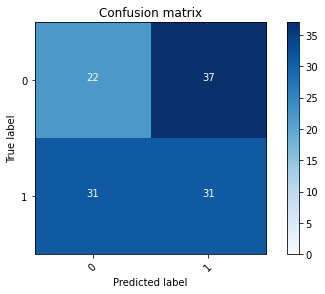

2022-08-22 15:43:10 - [Epoch Train: 96] loss: 0.0036, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 15:43:10 - [Epoch Valid: 96] loss: 2.9618, auc: 0.4591, acc: 0.4380, time: 6.00 s


 96%|████████████████████████████████████████▎ | 96/100 [50:33<02:02, 30.51s/it]

2022-08-22 15:43:10 - EPOCH: 97
2022-08-22 15:43:12 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:43:14 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:43:16 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:43:18 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:43:20 - Train Step 50/122, train_loss: 0.0044
2022-08-22 15:43:22 - Train Step 60/122, train_loss: 0.0036
2022-08-22 15:43:24 - Train Step 70/122, train_loss: 0.0032
2022-08-22 15:43:26 - Train Step 80/122, train_loss: 0.0028
2022-08-22 15:43:28 - Train Step 90/122, train_loss: 0.0025
2022-08-22 15:43:30 - Train Step 100/122, train_loss: 0.0023
2022-08-22 15:43:32 - Train Step 110/122, train_loss: 0.0021
2022-08-22 15:43:34 - Train Step 120/122, train_loss: 0.0065
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:43:35 - Valid Step 5/31, valid_loss: 2.7803
2022-08-22 15:43:36 - Valid Step 10/31, valid_loss: 3.4092
2022-08-22 15:43:37 - Valid Step 15/31, valid_loss: 3.0969
2022-08-22 15:43:38

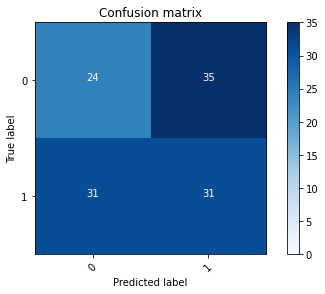

2022-08-22 15:43:40 - [Epoch Train: 97] loss: 0.0064, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 15:43:40 - [Epoch Valid: 97] loss: 2.9343, auc: 0.4602, acc: 0.4545, time: 6.00 s


 97%|████████████████████████████████████████▋ | 97/100 [51:03<01:31, 30.42s/it]

2022-08-22 15:43:40 - EPOCH: 98
2022-08-22 15:43:43 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:43:45 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:43:47 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:43:49 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:43:51 - Train Step 50/122, train_loss: 0.0001
2022-08-22 15:43:53 - Train Step 60/122, train_loss: 0.0029
2022-08-22 15:43:55 - Train Step 70/122, train_loss: 0.0025
2022-08-22 15:43:57 - Train Step 80/122, train_loss: 0.0022
2022-08-22 15:43:59 - Train Step 90/122, train_loss: 0.0020
2022-08-22 15:44:01 - Train Step 100/122, train_loss: 0.0019
2022-08-22 15:44:03 - Train Step 110/122, train_loss: 0.0044
2022-08-22 15:44:05 - Train Step 120/122, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:44:06 - Valid Step 5/31, valid_loss: 3.7234
2022-08-22 15:44:07 - Valid Step 10/31, valid_loss: 3.5169
2022-08-22 15:44:08 - Valid Step 15/31, valid_loss: 3.2264
2022-08-22 15:44:09

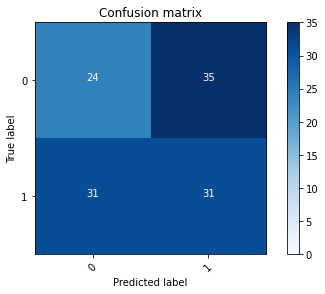

2022-08-22 15:44:12 - [Epoch Train: 98] loss: 0.0040, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:44:12 - [Epoch Valid: 98] loss: 2.8860, auc: 0.4569, acc: 0.4545, time: 6.00 s


 98%|█████████████████████████████████████████▏| 98/100 [51:35<01:01, 30.66s/it]

2022-08-22 15:44:12 - EPOCH: 99
2022-08-22 15:44:14 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:44:16 - Train Step 20/122, train_loss: 0.0002
2022-08-22 15:44:18 - Train Step 30/122, train_loss: 0.0001
2022-08-22 15:44:20 - Train Step 40/122, train_loss: 0.0001
2022-08-22 15:44:22 - Train Step 50/122, train_loss: 0.0021
2022-08-22 15:44:24 - Train Step 60/122, train_loss: 0.0018
2022-08-22 15:44:26 - Train Step 70/122, train_loss: 0.0016
2022-08-22 15:44:28 - Train Step 80/122, train_loss: 0.0014
2022-08-22 15:44:30 - Train Step 90/122, train_loss: 0.0012
2022-08-22 15:44:32 - Train Step 100/122, train_loss: 0.0011
2022-08-22 15:44:34 - Train Step 110/122, train_loss: 0.0010
2022-08-22 15:44:36 - Train Step 120/122, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:44:37 - Valid Step 5/31, valid_loss: 2.5142
2022-08-22 15:44:38 - Valid Step 10/31, valid_loss: 1.9611
2022-08-22 15:44:39 - Valid Step 15/31, valid_loss: 2.5125
2022-08-22 15:44:40

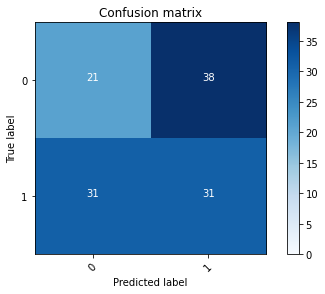

2022-08-22 15:44:42 - [Epoch Train: 99] loss: 0.0046, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:44:42 - [Epoch Valid: 99] loss: 2.9510, auc: 0.4613, acc: 0.4298, time: 6.00 s


 99%|█████████████████████████████████████████▌| 99/100 [52:05<00:30, 30.68s/it]

2022-08-22 15:44:42 - EPOCH: 100
2022-08-22 15:44:45 - Train Step 10/122, train_loss: 0.0001
2022-08-22 15:44:47 - Train Step 20/122, train_loss: 0.0001
2022-08-22 15:44:48 - Train Step 30/122, train_loss: 0.0002
2022-08-22 15:44:50 - Train Step 40/122, train_loss: 0.0029
2022-08-22 15:44:52 - Train Step 50/122, train_loss: 0.0024
2022-08-22 15:44:54 - Train Step 60/122, train_loss: 0.0020
2022-08-22 15:44:56 - Train Step 70/122, train_loss: 0.0075
2022-08-22 15:44:58 - Train Step 80/122, train_loss: 0.0066
2022-08-22 15:45:00 - Train Step 90/122, train_loss: 0.0059
2022-08-22 15:45:02 - Train Step 100/122, train_loss: 0.0053
2022-08-22 15:45:04 - Train Step 110/122, train_loss: 0.0048
2022-08-22 15:45:06 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:45:08 - Valid Step 5/31, valid_loss: 1.6596
2022-08-22 15:45:09 - Valid Step 10/31, valid_loss: 1.9036
2022-08-22 15:45:10 - Valid Step 15/31, valid_loss: 2.2167
2022-08-22 15:45:1

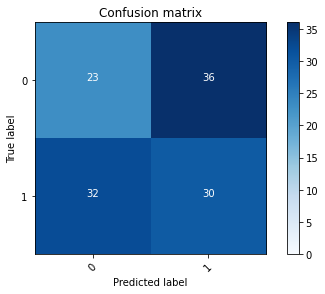

2022-08-22 15:45:13 - [Epoch Train: 100] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:45:13 - [Epoch Valid: 100] loss: 2.8282, auc: 0.4735, acc: 0.4380, time: 6.00 s


100%|█████████████████████████████████████████| 100/100 [52:36<00:00, 31.56s/it]

-- FOLD N:2
Train origin: m
Type: KLF
2022-08-22 15:45:13 - (M0) Train/Val datasets size: 270
2022-08-22 15:45:13 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cca03dc0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cca39c10>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606


[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 154, 155, 156, 158, 159, 161, 162, 163, 166, 167, 168, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 182, 184, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268, 269, 270, 2

  0%|                                                   | 0/100 [00:00<?, ?it/s]

2022-08-22 15:46:27 - EPOCH: 1
2022-08-22 15:46:29 - Train Step 10/121, train_loss: 0.6573
2022-08-22 15:46:31 - Train Step 20/121, train_loss: 0.7237
2022-08-22 15:46:33 - Train Step 30/121, train_loss: 0.7115
2022-08-22 15:46:35 - Train Step 40/121, train_loss: 0.7092
2022-08-22 15:46:37 - Train Step 50/121, train_loss: 0.6999
2022-08-22 15:46:39 - Train Step 60/121, train_loss: 0.7006
2022-08-22 15:46:41 - Train Step 70/121, train_loss: 0.6993
2022-08-22 15:46:43 - Train Step 80/121, train_loss: 0.6994
2022-08-22 15:46:45 - Train Step 90/121, train_loss: 0.7002
2022-08-22 15:46:47 - Train Step 100/121, train_loss: 0.6995
2022-08-22 15:46:49 - Train Step 110/121, train_loss: 0.6999
2022-08-22 15:46:51 - Train Step 120/121, train_loss: 0.7002
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:46:52 - Valid Step 5/31, valid_loss: 0.6440
2022-08-22 15:46:53 - Valid Step 10/31, valid_loss: 0.6926
2022-08-22 15:46:54 - Valid Step 15/31, valid_loss: 0.7037
2022-08-22 15:46:55 

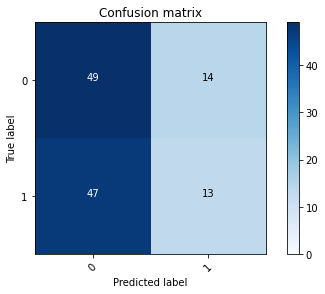

2022-08-22 15:46:58 - [Epoch Train: 1] loss: 0.6994, auc: 0.5241, acc: 0.5238, time: 24.00 s            
2022-08-22 15:46:58 - [Epoch Valid: 1] loss: 0.6964, auc: 0.5675, acc: 0.5041, time: 6.00 s
2022-08-22 15:46:58 - acc improved from 0.0000 to 0.5041. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.696-acc0.504-auc0.567.pth'


  1%|▍                                          | 1/100 [00:30<50:38, 30.69s/it]

2022-08-22 15:46:58 - EPOCH: 2
2022-08-22 15:47:00 - Train Step 10/121, train_loss: 0.6294
2022-08-22 15:47:02 - Train Step 20/121, train_loss: 0.6400
2022-08-22 15:47:04 - Train Step 30/121, train_loss: 0.6403
2022-08-22 15:47:06 - Train Step 40/121, train_loss: 0.6436
2022-08-22 15:47:08 - Train Step 50/121, train_loss: 0.6406
2022-08-22 15:47:10 - Train Step 60/121, train_loss: 0.6430
2022-08-22 15:47:12 - Train Step 70/121, train_loss: 0.6410
2022-08-22 15:47:14 - Train Step 80/121, train_loss: 0.6407
2022-08-22 15:47:16 - Train Step 90/121, train_loss: 0.6408
2022-08-22 15:47:18 - Train Step 100/121, train_loss: 0.6414
2022-08-22 15:47:20 - Train Step 110/121, train_loss: 0.6416
2022-08-22 15:47:22 - Train Step 120/121, train_loss: 0.6384
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:47:23 - Valid Step 5/31, valid_loss: 0.6991
2022-08-22 15:47:24 - Valid Step 10/31, valid_loss: 0.6854
2022-08-22 15:47:25 - Valid Step 15/31, valid_loss: 0.7377
2022-08-22 15:47:26 

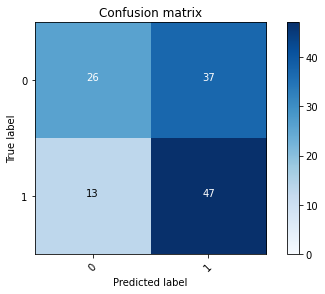

2022-08-22 15:47:29 - [Epoch Train: 2] loss: 0.6394, auc: 0.7130, acc: 0.6460, time: 24.00 s            
2022-08-22 15:47:29 - [Epoch Valid: 2] loss: 0.7395, auc: 0.5849, acc: 0.5935, time: 6.00 s
2022-08-22 15:47:29 - acc improved from 0.5041 to 0.5935. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.739-acc0.593-auc0.585.pth'


  2%|▊                                          | 2/100 [01:01<50:19, 30.82s/it]

2022-08-22 15:47:29 - EPOCH: 3
2022-08-22 15:47:31 - Train Step 10/121, train_loss: 0.6490
2022-08-22 15:47:33 - Train Step 20/121, train_loss: 0.6022
2022-08-22 15:47:35 - Train Step 30/121, train_loss: 0.5904
2022-08-22 15:47:37 - Train Step 40/121, train_loss: 0.6057
2022-08-22 15:47:39 - Train Step 50/121, train_loss: 0.5942
2022-08-22 15:47:41 - Train Step 60/121, train_loss: 0.5873
2022-08-22 15:47:43 - Train Step 70/121, train_loss: 0.5881
2022-08-22 15:47:45 - Train Step 80/121, train_loss: 0.5949
2022-08-22 15:47:46 - Train Step 90/121, train_loss: 0.5856
2022-08-22 15:47:48 - Train Step 100/121, train_loss: 0.5802
2022-08-22 15:47:50 - Train Step 110/121, train_loss: 0.5811
2022-08-22 15:47:52 - Train Step 120/121, train_loss: 0.5824
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:47:54 - Valid Step 5/31, valid_loss: 0.7313
2022-08-22 15:47:55 - Valid Step 10/31, valid_loss: 0.7726
2022-08-22 15:47:56 - Valid Step 15/31, valid_loss: 0.7361
2022-08-22 15:47:57 

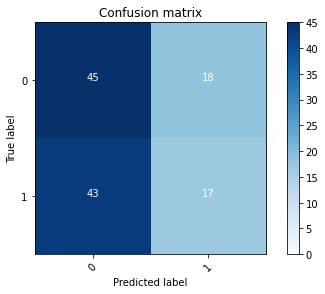

2022-08-22 15:47:59 - [Epoch Train: 3] loss: 0.5826, auc: 0.7868, acc: 0.7019, time: 23.00 s            
2022-08-22 15:47:59 - [Epoch Valid: 3] loss: 0.7412, auc: 0.5646, acc: 0.5041, time: 6.00 s


  3%|█▎                                         | 3/100 [01:32<49:31, 30.64s/it]

2022-08-22 15:47:59 - EPOCH: 4
2022-08-22 15:48:01 - Train Step 10/121, train_loss: 0.4563
2022-08-22 15:48:03 - Train Step 20/121, train_loss: 0.4787
2022-08-22 15:48:05 - Train Step 30/121, train_loss: 0.4852
2022-08-22 15:48:07 - Train Step 40/121, train_loss: 0.4673
2022-08-22 15:48:09 - Train Step 50/121, train_loss: 0.4754
2022-08-22 15:48:11 - Train Step 60/121, train_loss: 0.4704
2022-08-22 15:48:13 - Train Step 70/121, train_loss: 0.4713
2022-08-22 15:48:15 - Train Step 80/121, train_loss: 0.4864
2022-08-22 15:48:17 - Train Step 90/121, train_loss: 0.4901
2022-08-22 15:48:19 - Train Step 100/121, train_loss: 0.4917
2022-08-22 15:48:21 - Train Step 110/121, train_loss: 0.4976
2022-08-22 15:48:23 - Train Step 120/121, train_loss: 0.4995
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:48:25 - Valid Step 5/31, valid_loss: 0.7106
2022-08-22 15:48:25 - Valid Step 10/31, valid_loss: 0.6784
2022-08-22 15:48:27 - Valid Step 15/31, valid_loss: 0.7518
2022-08-22 15:48:27 

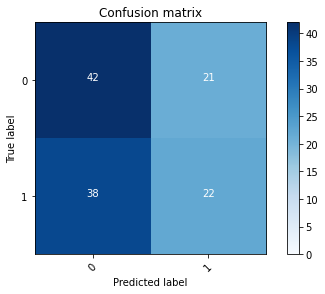

2022-08-22 15:48:30 - [Epoch Train: 4] loss: 0.4988, auc: 0.8688, acc: 0.7826, time: 24.00 s            
2022-08-22 15:48:30 - [Epoch Valid: 4] loss: 0.7641, auc: 0.5418, acc: 0.5203, time: 6.00 s


  4%|█▋                                         | 4/100 [02:02<49:06, 30.69s/it]

2022-08-22 15:48:30 - EPOCH: 5
2022-08-22 15:48:32 - Train Step 10/121, train_loss: 0.3913
2022-08-22 15:48:34 - Train Step 20/121, train_loss: 0.3860
2022-08-22 15:48:36 - Train Step 30/121, train_loss: 0.4032
2022-08-22 15:48:38 - Train Step 40/121, train_loss: 0.3970
2022-08-22 15:48:40 - Train Step 50/121, train_loss: 0.3784
2022-08-22 15:48:42 - Train Step 60/121, train_loss: 0.3707
2022-08-22 15:48:44 - Train Step 70/121, train_loss: 0.3695
2022-08-22 15:48:46 - Train Step 80/121, train_loss: 0.3590
2022-08-22 15:48:48 - Train Step 90/121, train_loss: 0.3627
2022-08-22 15:48:50 - Train Step 100/121, train_loss: 0.3689
2022-08-22 15:48:52 - Train Step 110/121, train_loss: 0.3655
2022-08-22 15:48:53 - Train Step 120/121, train_loss: 0.3661
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:48:55 - Valid Step 5/31, valid_loss: 1.1150
2022-08-22 15:48:56 - Valid Step 10/31, valid_loss: 0.9972
2022-08-22 15:48:57 - Valid Step 15/31, valid_loss: 1.0121
2022-08-22 15:48:58 

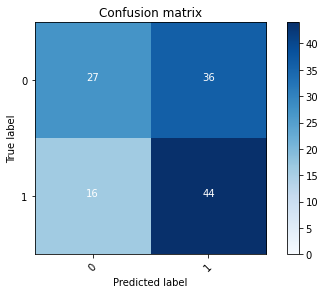

2022-08-22 15:49:00 - [Epoch Train: 5] loss: 0.3665, auc: 0.9625, acc: 0.9068, time: 23.00 s            
2022-08-22 15:49:00 - [Epoch Valid: 5] loss: 0.8837, auc: 0.5698, acc: 0.5772, time: 6.00 s


  5%|██▏                                        | 5/100 [02:33<48:25, 30.58s/it]

2022-08-22 15:49:00 - EPOCH: 6
2022-08-22 15:49:02 - Train Step 10/121, train_loss: 0.2586
2022-08-22 15:49:04 - Train Step 20/121, train_loss: 0.2710
2022-08-22 15:49:06 - Train Step 30/121, train_loss: 0.2642
2022-08-22 15:49:08 - Train Step 40/121, train_loss: 0.2701
2022-08-22 15:49:10 - Train Step 50/121, train_loss: 0.2636
2022-08-22 15:49:12 - Train Step 60/121, train_loss: 0.2618
2022-08-22 15:49:14 - Train Step 70/121, train_loss: 0.2660
2022-08-22 15:49:16 - Train Step 80/121, train_loss: 0.2677
2022-08-22 15:49:18 - Train Step 90/121, train_loss: 0.2549
2022-08-22 15:49:20 - Train Step 100/121, train_loss: 0.2582
2022-08-22 15:49:22 - Train Step 110/121, train_loss: 0.2530
2022-08-22 15:49:24 - Train Step 120/121, train_loss: 0.2531
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:49:26 - Valid Step 5/31, valid_loss: 1.1247
2022-08-22 15:49:27 - Valid Step 10/31, valid_loss: 0.9854
2022-08-22 15:49:28 - Valid Step 15/31, valid_loss: 1.0290
2022-08-22 15:49:29 

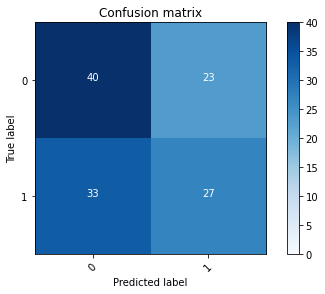

2022-08-22 15:49:31 - [Epoch Train: 6] loss: 0.2541, auc: 0.9854, acc: 0.9379, time: 24.00 s            
2022-08-22 15:49:31 - [Epoch Valid: 6] loss: 0.9322, auc: 0.5677, acc: 0.5447, time: 6.00 s


  6%|██▌                                        | 6/100 [03:03<47:57, 30.61s/it]

2022-08-22 15:49:31 - EPOCH: 7
2022-08-22 15:49:33 - Train Step 10/121, train_loss: 0.2207
2022-08-22 15:49:35 - Train Step 20/121, train_loss: 0.1844
2022-08-22 15:49:37 - Train Step 30/121, train_loss: 0.1802
2022-08-22 15:49:39 - Train Step 40/121, train_loss: 0.1742
2022-08-22 15:49:41 - Train Step 50/121, train_loss: 0.1725
2022-08-22 15:49:43 - Train Step 60/121, train_loss: 0.1729
2022-08-22 15:49:45 - Train Step 70/121, train_loss: 0.1691
2022-08-22 15:49:47 - Train Step 80/121, train_loss: 0.1640
2022-08-22 15:49:49 - Train Step 90/121, train_loss: 0.1623
2022-08-22 15:49:51 - Train Step 100/121, train_loss: 0.1617
2022-08-22 15:49:52 - Train Step 110/121, train_loss: 0.1586
2022-08-22 15:49:54 - Train Step 120/121, train_loss: 0.1603
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:49:56 - Valid Step 5/31, valid_loss: 1.1655
2022-08-22 15:49:57 - Valid Step 10/31, valid_loss: 1.1799
2022-08-22 15:49:58 - Valid Step 15/31, valid_loss: 1.0082
2022-08-22 15:49:59 

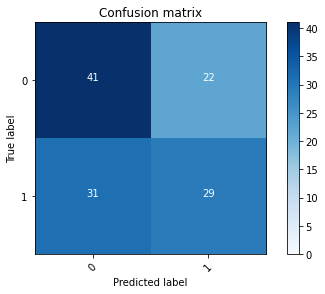

2022-08-22 15:50:01 - [Epoch Train: 7] loss: 0.1596, auc: 0.9973, acc: 0.9896, time: 23.00 s            
2022-08-22 15:50:01 - [Epoch Valid: 7] loss: 1.0444, auc: 0.5556, acc: 0.5691, time: 6.00 s


  7%|███                                        | 7/100 [03:34<47:15, 30.49s/it]

2022-08-22 15:50:01 - EPOCH: 8
2022-08-22 15:50:03 - Train Step 10/121, train_loss: 0.1075
2022-08-22 15:50:05 - Train Step 20/121, train_loss: 0.1016
2022-08-22 15:50:07 - Train Step 30/121, train_loss: 0.0943
2022-08-22 15:50:09 - Train Step 40/121, train_loss: 0.0943
2022-08-22 15:50:11 - Train Step 50/121, train_loss: 0.0893
2022-08-22 15:50:13 - Train Step 60/121, train_loss: 0.0930
2022-08-22 15:50:15 - Train Step 70/121, train_loss: 0.0906
2022-08-22 15:50:17 - Train Step 80/121, train_loss: 0.0912
2022-08-22 15:50:19 - Train Step 90/121, train_loss: 0.0927
2022-08-22 15:50:21 - Train Step 100/121, train_loss: 0.0926
2022-08-22 15:50:23 - Train Step 110/121, train_loss: 0.0902
2022-08-22 15:50:25 - Train Step 120/121, train_loss: 0.0884
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:50:26 - Valid Step 5/31, valid_loss: 1.1720
2022-08-22 15:50:27 - Valid Step 10/31, valid_loss: 1.1384
2022-08-22 15:50:28 - Valid Step 15/31, valid_loss: 1.0644
2022-08-22 15:50:29 

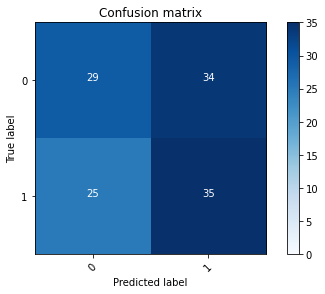

2022-08-22 15:50:32 - [Epoch Train: 8] loss: 0.0881, auc: 0.9999, acc: 0.9959, time: 23.00 s            
2022-08-22 15:50:32 - [Epoch Valid: 8] loss: 1.0875, auc: 0.5550, acc: 0.5203, time: 6.00 s


  8%|███▍                                       | 8/100 [04:04<46:47, 30.52s/it]

2022-08-22 15:50:32 - EPOCH: 9
2022-08-22 15:50:34 - Train Step 10/121, train_loss: 0.0694
2022-08-22 15:50:36 - Train Step 20/121, train_loss: 0.0585
2022-08-22 15:50:38 - Train Step 30/121, train_loss: 0.0575
2022-08-22 15:50:40 - Train Step 40/121, train_loss: 0.0599
2022-08-22 15:50:42 - Train Step 50/121, train_loss: 0.0594
2022-08-22 15:50:44 - Train Step 60/121, train_loss: 0.0589
2022-08-22 15:50:46 - Train Step 70/121, train_loss: 0.0581
2022-08-22 15:50:48 - Train Step 80/121, train_loss: 0.0579
2022-08-22 15:50:50 - Train Step 90/121, train_loss: 0.0577
2022-08-22 15:50:52 - Train Step 100/121, train_loss: 0.0558
2022-08-22 15:50:54 - Train Step 110/121, train_loss: 0.0548
2022-08-22 15:50:56 - Train Step 120/121, train_loss: 0.0532
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 15:50:57 - Valid Step 5/31, valid_loss: 0.9143
2022-08-22 15:50:58 - Valid Step 10/31, valid_loss: 1.2595
2022-08-22 15:50:59 - Valid Step 15/31, valid_loss: 1.2913
2022-08-22 15:51:00 

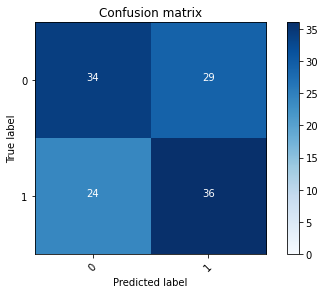

2022-08-22 15:51:03 - [Epoch Train: 9] loss: 0.0532, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 15:51:03 - [Epoch Valid: 9] loss: 1.1830, auc: 0.5735, acc: 0.5691, time: 6.00 s


  9%|███▊                                       | 9/100 [04:35<46:27, 30.63s/it]

2022-08-22 15:51:03 - EPOCH: 10
2022-08-22 15:51:05 - Train Step 10/121, train_loss: 0.0308
2022-08-22 15:51:07 - Train Step 20/121, train_loss: 0.0369
2022-08-22 15:51:09 - Train Step 30/121, train_loss: 0.0316
2022-08-22 15:51:11 - Train Step 40/121, train_loss: 0.0352
2022-08-22 15:51:13 - Train Step 50/121, train_loss: 0.0372
2022-08-22 15:51:15 - Train Step 60/121, train_loss: 0.0366
2022-08-22 15:51:17 - Train Step 70/121, train_loss: 0.0372
2022-08-22 15:51:18 - Train Step 80/121, train_loss: 0.0371
2022-08-22 15:51:20 - Train Step 90/121, train_loss: 0.0359
2022-08-22 15:51:22 - Train Step 100/121, train_loss: 0.0357
2022-08-22 15:51:24 - Train Step 110/121, train_loss: 0.0358
2022-08-22 15:51:26 - Train Step 120/121, train_loss: 0.0343
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:51:28 - Valid Step 5/31, valid_loss: 2.2793
2022-08-22 15:51:29 - Valid Step 10/31, valid_loss: 1.6459
2022-08-22 15:51:30 - Valid Step 15/31, valid_loss: 1.4614
2022-08-22 15:51:31

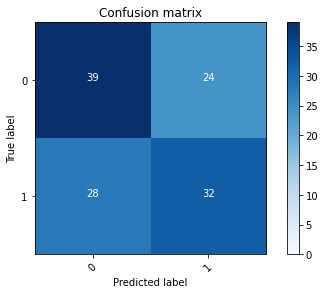

2022-08-22 15:51:33 - [Epoch Train: 10] loss: 0.0344, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:51:33 - [Epoch Valid: 10] loss: 1.2869, auc: 0.5746, acc: 0.5772, time: 6.00 s


 10%|████▏                                     | 10/100 [05:06<45:52, 30.59s/it]

2022-08-22 15:51:33 - EPOCH: 11
2022-08-22 15:51:35 - Train Step 10/121, train_loss: 0.0198
2022-08-22 15:51:37 - Train Step 20/121, train_loss: 0.0239
2022-08-22 15:51:39 - Train Step 30/121, train_loss: 0.0249
2022-08-22 15:51:41 - Train Step 40/121, train_loss: 0.0250
2022-08-22 15:51:43 - Train Step 50/121, train_loss: 0.0234
2022-08-22 15:51:45 - Train Step 60/121, train_loss: 0.0233
2022-08-22 15:51:47 - Train Step 70/121, train_loss: 0.0227
2022-08-22 15:51:48 - Train Step 80/121, train_loss: 0.0224
2022-08-22 15:51:50 - Train Step 90/121, train_loss: 0.0217
2022-08-22 15:51:52 - Train Step 100/121, train_loss: 0.0220
2022-08-22 15:51:54 - Train Step 110/121, train_loss: 0.0219
2022-08-22 15:51:56 - Train Step 120/121, train_loss: 0.0221
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:51:58 - Valid Step 5/31, valid_loss: 0.7695
2022-08-22 15:51:58 - Valid Step 10/31, valid_loss: 1.0830
2022-08-22 15:52:00 - Valid Step 15/31, valid_loss: 1.3166
2022-08-22 15:52:00

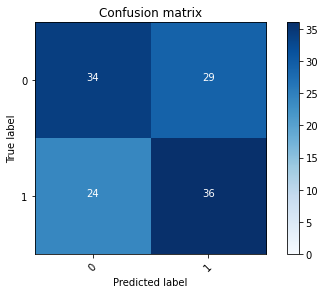

2022-08-22 15:52:03 - [Epoch Train: 11] loss: 0.0221, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:52:03 - [Epoch Valid: 11] loss: 1.2707, auc: 0.5780, acc: 0.5691, time: 6.00 s


 11%|████▌                                     | 11/100 [05:36<45:06, 30.41s/it]

2022-08-22 15:52:03 - EPOCH: 12
2022-08-22 15:52:05 - Train Step 10/121, train_loss: 0.0222
2022-08-22 15:52:07 - Train Step 20/121, train_loss: 0.0222
2022-08-22 15:52:09 - Train Step 30/121, train_loss: 0.0218
2022-08-22 15:52:11 - Train Step 40/121, train_loss: 0.0219
2022-08-22 15:52:13 - Train Step 50/121, train_loss: 0.0215
2022-08-22 15:52:15 - Train Step 60/121, train_loss: 0.0211
2022-08-22 15:52:17 - Train Step 70/121, train_loss: 0.0207
2022-08-22 15:52:19 - Train Step 80/121, train_loss: 0.0202
2022-08-22 15:52:21 - Train Step 90/121, train_loss: 0.0197
2022-08-22 15:52:22 - Train Step 100/121, train_loss: 0.0194
2022-08-22 15:52:24 - Train Step 110/121, train_loss: 0.0197
2022-08-22 15:52:26 - Train Step 120/121, train_loss: 0.0196
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:52:28 - Valid Step 5/31, valid_loss: 1.6623
2022-08-22 15:52:29 - Valid Step 10/31, valid_loss: 1.4113
2022-08-22 15:52:30 - Valid Step 15/31, valid_loss: 1.2915
2022-08-22 15:52:31

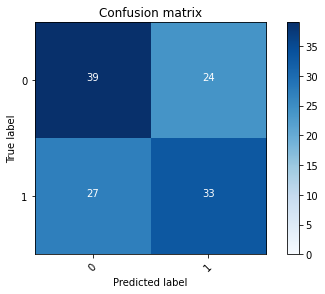

2022-08-22 15:52:33 - [Epoch Train: 12] loss: 0.0195, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:52:33 - [Epoch Valid: 12] loss: 1.2662, auc: 0.5709, acc: 0.5854, time: 6.00 s


 12%|█████                                     | 12/100 [06:05<44:22, 30.26s/it]

2022-08-22 15:52:33 - EPOCH: 13
2022-08-22 15:52:35 - Train Step 10/121, train_loss: 0.0203
2022-08-22 15:52:37 - Train Step 20/121, train_loss: 0.0216
2022-08-22 15:52:39 - Train Step 30/121, train_loss: 0.0186
2022-08-22 15:52:41 - Train Step 40/121, train_loss: 0.0184
2022-08-22 15:52:43 - Train Step 50/121, train_loss: 0.0180
2022-08-22 15:52:45 - Train Step 60/121, train_loss: 0.0181
2022-08-22 15:52:47 - Train Step 70/121, train_loss: 0.0169
2022-08-22 15:52:48 - Train Step 80/121, train_loss: 0.0163
2022-08-22 15:52:50 - Train Step 90/121, train_loss: 0.0164
2022-08-22 15:52:52 - Train Step 100/121, train_loss: 0.0165
2022-08-22 15:52:54 - Train Step 110/121, train_loss: 0.0161
2022-08-22 15:52:56 - Train Step 120/121, train_loss: 0.0162
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:52:58 - Valid Step 5/31, valid_loss: 0.7137
2022-08-22 15:52:59 - Valid Step 10/31, valid_loss: 0.9334
2022-08-22 15:53:00 - Valid Step 15/31, valid_loss: 1.4847
2022-08-22 15:53:01

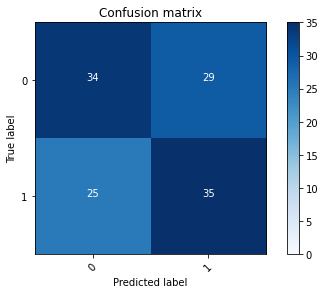

2022-08-22 15:53:03 - [Epoch Train: 13] loss: 0.0163, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:53:03 - [Epoch Valid: 13] loss: 1.3690, auc: 0.5772, acc: 0.5610, time: 7.00 s


 13%|█████▍                                    | 13/100 [06:36<43:54, 30.28s/it]

2022-08-22 15:53:03 - EPOCH: 14
2022-08-22 15:53:06 - Train Step 10/121, train_loss: 0.0146
2022-08-22 15:53:08 - Train Step 20/121, train_loss: 0.0145
2022-08-22 15:53:09 - Train Step 30/121, train_loss: 0.0147
2022-08-22 15:53:11 - Train Step 40/121, train_loss: 0.0135
2022-08-22 15:53:13 - Train Step 50/121, train_loss: 0.0140
2022-08-22 15:53:15 - Train Step 60/121, train_loss: 0.0135
2022-08-22 15:53:17 - Train Step 70/121, train_loss: 0.0132
2022-08-22 15:53:19 - Train Step 80/121, train_loss: 0.0131
2022-08-22 15:53:21 - Train Step 90/121, train_loss: 0.0129
2022-08-22 15:53:23 - Train Step 100/121, train_loss: 0.0132
2022-08-22 15:53:25 - Train Step 110/121, train_loss: 0.0128
2022-08-22 15:53:27 - Train Step 120/121, train_loss: 0.0130
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:53:28 - Valid Step 5/31, valid_loss: 1.0189
2022-08-22 15:53:29 - Valid Step 10/31, valid_loss: 1.3674
2022-08-22 15:53:30 - Valid Step 15/31, valid_loss: 1.2238
2022-08-22 15:53:31

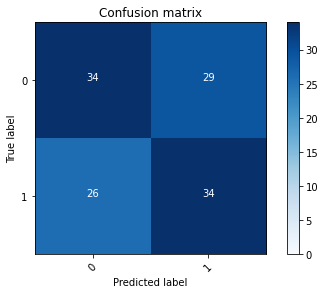

2022-08-22 15:53:34 - [Epoch Train: 14] loss: 0.0129, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:53:34 - [Epoch Valid: 14] loss: 1.4486, auc: 0.5714, acc: 0.5528, time: 6.00 s


 14%|█████▉                                    | 14/100 [07:06<43:26, 30.31s/it]

2022-08-22 15:53:34 - EPOCH: 15
2022-08-22 15:53:36 - Train Step 10/121, train_loss: 0.0156
2022-08-22 15:53:38 - Train Step 20/121, train_loss: 0.0149
2022-08-22 15:53:40 - Train Step 30/121, train_loss: 0.0138
2022-08-22 15:53:42 - Train Step 40/121, train_loss: 0.0127
2022-08-22 15:53:44 - Train Step 50/121, train_loss: 0.0120
2022-08-22 15:53:46 - Train Step 60/121, train_loss: 0.0116
2022-08-22 15:53:47 - Train Step 70/121, train_loss: 0.0114
2022-08-22 15:53:49 - Train Step 80/121, train_loss: 0.0113
2022-08-22 15:53:51 - Train Step 90/121, train_loss: 0.0116
2022-08-22 15:53:53 - Train Step 100/121, train_loss: 0.0112
2022-08-22 15:53:55 - Train Step 110/121, train_loss: 0.0117
2022-08-22 15:53:57 - Train Step 120/121, train_loss: 0.0115
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:53:59 - Valid Step 5/31, valid_loss: 1.4692
2022-08-22 15:54:00 - Valid Step 10/31, valid_loss: 1.3068
2022-08-22 15:54:01 - Valid Step 15/31, valid_loss: 1.2843
2022-08-22 15:54:02

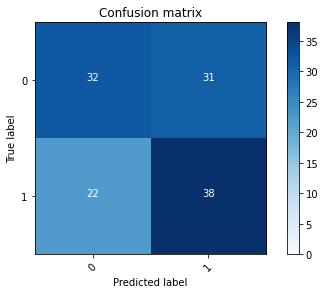

2022-08-22 15:54:04 - [Epoch Train: 15] loss: 0.0116, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:54:04 - [Epoch Valid: 15] loss: 1.3682, auc: 0.5794, acc: 0.5691, time: 6.00 s


 15%|██████▎                                   | 15/100 [07:37<42:57, 30.32s/it]

2022-08-22 15:54:04 - EPOCH: 16
2022-08-22 15:54:06 - Train Step 10/121, train_loss: 0.0178
2022-08-22 15:54:08 - Train Step 20/121, train_loss: 0.0149
2022-08-22 15:54:10 - Train Step 30/121, train_loss: 0.0133
2022-08-22 15:54:12 - Train Step 40/121, train_loss: 0.0121
2022-08-22 15:54:14 - Train Step 50/121, train_loss: 0.0115
2022-08-22 15:54:16 - Train Step 60/121, train_loss: 0.0110
2022-08-22 15:54:18 - Train Step 70/121, train_loss: 0.0105
2022-08-22 15:54:20 - Train Step 80/121, train_loss: 0.0102
2022-08-22 15:54:22 - Train Step 90/121, train_loss: 0.0097
2022-08-22 15:54:24 - Train Step 100/121, train_loss: 0.0097
2022-08-22 15:54:26 - Train Step 110/121, train_loss: 0.0095
2022-08-22 15:54:28 - Train Step 120/121, train_loss: 0.0097
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:54:30 - Valid Step 5/31, valid_loss: 1.0337
2022-08-22 15:54:30 - Valid Step 10/31, valid_loss: 1.5209
2022-08-22 15:54:32 - Valid Step 15/31, valid_loss: 1.5242
2022-08-22 15:54:32

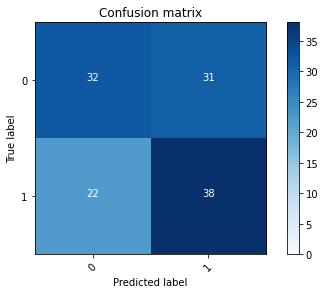

2022-08-22 15:54:35 - [Epoch Train: 16] loss: 0.0097, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:54:35 - [Epoch Valid: 16] loss: 1.4029, auc: 0.5828, acc: 0.5691, time: 6.00 s


 16%|██████▋                                   | 16/100 [08:07<42:35, 30.43s/it]

2022-08-22 15:54:35 - EPOCH: 17
2022-08-22 15:54:37 - Train Step 10/121, train_loss: 0.0055
2022-08-22 15:54:39 - Train Step 20/121, train_loss: 0.0067
2022-08-22 15:54:41 - Train Step 30/121, train_loss: 0.0064
2022-08-22 15:54:43 - Train Step 40/121, train_loss: 0.0066
2022-08-22 15:54:45 - Train Step 50/121, train_loss: 0.0070
2022-08-22 15:54:47 - Train Step 60/121, train_loss: 0.0071
2022-08-22 15:54:49 - Train Step 70/121, train_loss: 0.0082
2022-08-22 15:54:51 - Train Step 80/121, train_loss: 0.0079
2022-08-22 15:54:53 - Train Step 90/121, train_loss: 0.0084
2022-08-22 15:54:55 - Train Step 100/121, train_loss: 0.0086
2022-08-22 15:54:57 - Train Step 110/121, train_loss: 0.0083
2022-08-22 15:54:59 - Train Step 120/121, train_loss: 0.0081
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:55:00 - Valid Step 5/31, valid_loss: 0.5980
2022-08-22 15:55:01 - Valid Step 10/31, valid_loss: 1.2685
2022-08-22 15:55:02 - Valid Step 15/31, valid_loss: 1.4142
2022-08-22 15:55:03

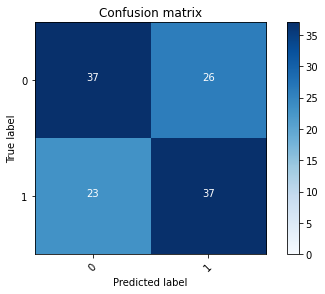

2022-08-22 15:55:05 - [Epoch Train: 17] loss: 0.0081, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:55:05 - [Epoch Valid: 17] loss: 1.4395, auc: 0.5759, acc: 0.6016, time: 6.00 s
2022-08-22 15:55:05 - acc improved from 0.5935 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e17-loss1.439-acc0.602-auc0.576.pth'


 17%|███████▏                                  | 17/100 [08:38<42:10, 30.49s/it]

2022-08-22 15:55:05 - EPOCH: 18
2022-08-22 15:55:08 - Train Step 10/121, train_loss: 0.0057
2022-08-22 15:55:10 - Train Step 20/121, train_loss: 0.0062
2022-08-22 15:55:12 - Train Step 30/121, train_loss: 0.0066
2022-08-22 15:55:14 - Train Step 40/121, train_loss: 0.0066
2022-08-22 15:55:16 - Train Step 50/121, train_loss: 0.0065
2022-08-22 15:55:18 - Train Step 60/121, train_loss: 0.0065
2022-08-22 15:55:20 - Train Step 70/121, train_loss: 0.0064
2022-08-22 15:55:22 - Train Step 80/121, train_loss: 0.0064
2022-08-22 15:55:24 - Train Step 90/121, train_loss: 0.0063
2022-08-22 15:55:26 - Train Step 100/121, train_loss: 0.0062
2022-08-22 15:55:28 - Train Step 110/121, train_loss: 0.0063
2022-08-22 15:55:30 - Train Step 120/121, train_loss: 0.0064
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:55:32 - Valid Step 5/31, valid_loss: 0.4891
2022-08-22 15:55:32 - Valid Step 10/31, valid_loss: 1.5161
2022-08-22 15:55:33 - Valid Step 15/31, valid_loss: 1.5382
2022-08-22 15:55:34

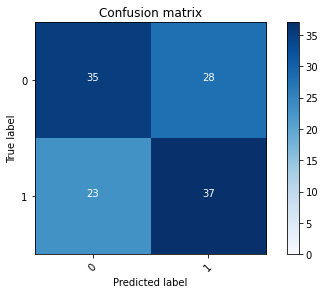

2022-08-22 15:55:37 - [Epoch Train: 18] loss: 0.0064, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:55:37 - [Epoch Valid: 18] loss: 1.4974, auc: 0.5844, acc: 0.5854, time: 6.00 s


 18%|███████▌                                  | 18/100 [09:09<42:00, 30.74s/it]

2022-08-22 15:55:37 - EPOCH: 19
2022-08-22 15:55:39 - Train Step 10/121, train_loss: 0.0095
2022-08-22 15:55:41 - Train Step 20/121, train_loss: 0.0084
2022-08-22 15:55:43 - Train Step 30/121, train_loss: 0.0076
2022-08-22 15:55:45 - Train Step 40/121, train_loss: 0.0073
2022-08-22 15:55:47 - Train Step 50/121, train_loss: 0.0070
2022-08-22 15:55:49 - Train Step 60/121, train_loss: 0.0065
2022-08-22 15:55:51 - Train Step 70/121, train_loss: 0.0068
2022-08-22 15:55:53 - Train Step 80/121, train_loss: 0.0066
2022-08-22 15:55:55 - Train Step 90/121, train_loss: 0.0067
2022-08-22 15:55:57 - Train Step 100/121, train_loss: 0.0066
2022-08-22 15:55:59 - Train Step 110/121, train_loss: 0.0066
2022-08-22 15:56:00 - Train Step 120/121, train_loss: 0.0065
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:56:02 - Valid Step 5/31, valid_loss: 1.1530
2022-08-22 15:56:03 - Valid Step 10/31, valid_loss: 1.2796
2022-08-22 15:56:04 - Valid Step 15/31, valid_loss: 1.1456
2022-08-22 15:56:05

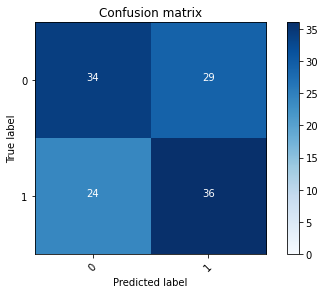

2022-08-22 15:56:08 - [Epoch Train: 19] loss: 0.0065, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:56:08 - [Epoch Valid: 19] loss: 1.4922, auc: 0.5733, acc: 0.5691, time: 6.00 s


 19%|███████▉                                  | 19/100 [09:40<41:33, 30.78s/it]

2022-08-22 15:56:08 - EPOCH: 20
2022-08-22 15:56:10 - Train Step 10/121, train_loss: 0.0078
2022-08-22 15:56:12 - Train Step 20/121, train_loss: 0.0069
2022-08-22 15:56:14 - Train Step 30/121, train_loss: 0.0059
2022-08-22 15:56:16 - Train Step 40/121, train_loss: 0.0059
2022-08-22 15:56:18 - Train Step 50/121, train_loss: 0.0060
2022-08-22 15:56:20 - Train Step 60/121, train_loss: 0.0056
2022-08-22 15:56:22 - Train Step 70/121, train_loss: 0.0055
2022-08-22 15:56:24 - Train Step 80/121, train_loss: 0.0053
2022-08-22 15:56:26 - Train Step 90/121, train_loss: 0.0053
2022-08-22 15:56:28 - Train Step 100/121, train_loss: 0.0053
2022-08-22 15:56:30 - Train Step 110/121, train_loss: 0.0052
2022-08-22 15:56:32 - Train Step 120/121, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:56:33 - Valid Step 5/31, valid_loss: 1.1414
2022-08-22 15:56:34 - Valid Step 10/31, valid_loss: 1.8024
2022-08-22 15:56:35 - Valid Step 15/31, valid_loss: 1.7006
2022-08-22 15:56:36

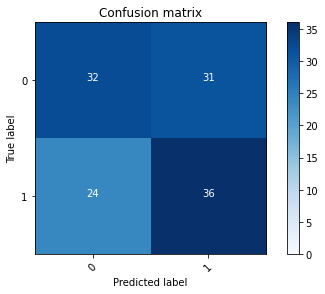

2022-08-22 15:56:39 - [Epoch Train: 20] loss: 0.0051, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:56:39 - [Epoch Valid: 20] loss: 1.4911, auc: 0.5749, acc: 0.5528, time: 6.00 s


 20%|████████▍                                 | 20/100 [10:11<41:12, 30.90s/it]

2022-08-22 15:56:39 - EPOCH: 21
2022-08-22 15:56:41 - Train Step 10/121, train_loss: 0.0038
2022-08-22 15:56:43 - Train Step 20/121, train_loss: 0.0059
2022-08-22 15:56:45 - Train Step 30/121, train_loss: 0.0060
2022-08-22 15:56:47 - Train Step 40/121, train_loss: 0.0057
2022-08-22 15:56:49 - Train Step 50/121, train_loss: 0.0054
2022-08-22 15:56:51 - Train Step 60/121, train_loss: 0.0051
2022-08-22 15:56:53 - Train Step 70/121, train_loss: 0.0051
2022-08-22 15:56:55 - Train Step 80/121, train_loss: 0.0050
2022-08-22 15:56:56 - Train Step 90/121, train_loss: 0.0048
2022-08-22 15:56:58 - Train Step 100/121, train_loss: 0.0048
2022-08-22 15:57:00 - Train Step 110/121, train_loss: 0.0049
2022-08-22 15:57:02 - Train Step 120/121, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:57:04 - Valid Step 5/31, valid_loss: 2.8231
2022-08-22 15:57:05 - Valid Step 10/31, valid_loss: 2.5371
2022-08-22 15:57:06 - Valid Step 15/31, valid_loss: 2.0987
2022-08-22 15:57:07

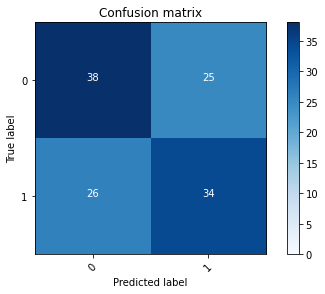

2022-08-22 15:57:09 - [Epoch Train: 21] loss: 0.0047, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:57:09 - [Epoch Valid: 21] loss: 1.5865, auc: 0.5735, acc: 0.5854, time: 6.00 s


 21%|████████▊                                 | 21/100 [10:42<40:35, 30.83s/it]

2022-08-22 15:57:09 - EPOCH: 22
2022-08-22 15:57:12 - Train Step 10/121, train_loss: 0.0050
2022-08-22 15:57:14 - Train Step 20/121, train_loss: 0.0061
2022-08-22 15:57:16 - Train Step 30/121, train_loss: 0.0058
2022-08-22 15:57:17 - Train Step 40/121, train_loss: 0.0051
2022-08-22 15:57:19 - Train Step 50/121, train_loss: 0.0048
2022-08-22 15:57:21 - Train Step 60/121, train_loss: 0.0048
2022-08-22 15:57:23 - Train Step 70/121, train_loss: 0.0047
2022-08-22 15:57:25 - Train Step 80/121, train_loss: 0.0046
2022-08-22 15:57:27 - Train Step 90/121, train_loss: 0.0044
2022-08-22 15:57:29 - Train Step 100/121, train_loss: 0.0044
2022-08-22 15:57:31 - Train Step 110/121, train_loss: 0.0044
2022-08-22 15:57:33 - Train Step 120/121, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:57:35 - Valid Step 5/31, valid_loss: 1.2039
2022-08-22 15:57:35 - Valid Step 10/31, valid_loss: 1.2386
2022-08-22 15:57:37 - Valid Step 15/31, valid_loss: 1.4698
2022-08-22 15:57:37

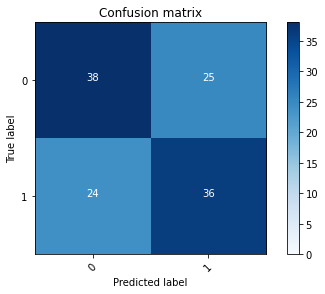

2022-08-22 15:57:40 - [Epoch Train: 22] loss: 0.0043, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:57:40 - [Epoch Valid: 22] loss: 1.6753, auc: 0.5791, acc: 0.6016, time: 6.00 s
2022-08-22 15:57:40 - acc improved from 0.6016 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e22-loss1.675-acc0.602-auc0.579.pth'


 22%|█████████▏                                | 22/100 [11:12<39:55, 30.71s/it]

2022-08-22 15:57:40 - EPOCH: 23
2022-08-22 15:57:42 - Train Step 10/121, train_loss: 0.0020
2022-08-22 15:57:44 - Train Step 20/121, train_loss: 0.0028
2022-08-22 15:57:46 - Train Step 30/121, train_loss: 0.0031
2022-08-22 15:57:48 - Train Step 40/121, train_loss: 0.0032
2022-08-22 15:57:50 - Train Step 50/121, train_loss: 0.0032
2022-08-22 15:57:52 - Train Step 60/121, train_loss: 0.0030
2022-08-22 15:57:54 - Train Step 70/121, train_loss: 0.0032
2022-08-22 15:57:56 - Train Step 80/121, train_loss: 0.0031
2022-08-22 15:57:58 - Train Step 90/121, train_loss: 0.0030
2022-08-22 15:58:00 - Train Step 100/121, train_loss: 0.0034
2022-08-22 15:58:02 - Train Step 110/121, train_loss: 0.0034
2022-08-22 15:58:04 - Train Step 120/121, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:58:06 - Valid Step 5/31, valid_loss: 1.3405
2022-08-22 15:58:06 - Valid Step 10/31, valid_loss: 1.4672
2022-08-22 15:58:07 - Valid Step 15/31, valid_loss: 1.5947
2022-08-22 15:58:08

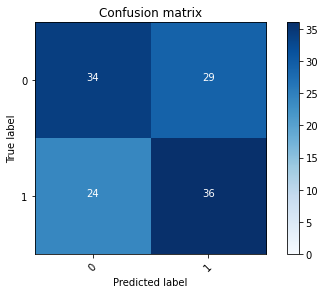

2022-08-22 15:58:11 - [Epoch Train: 23] loss: 0.0033, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:58:11 - [Epoch Valid: 23] loss: 1.7137, auc: 0.5728, acc: 0.5691, time: 6.00 s


 23%|█████████▋                                | 23/100 [11:43<39:26, 30.74s/it]

2022-08-22 15:58:11 - EPOCH: 24
2022-08-22 15:58:13 - Train Step 10/121, train_loss: 0.0030
2022-08-22 15:58:15 - Train Step 20/121, train_loss: 0.0026
2022-08-22 15:58:17 - Train Step 30/121, train_loss: 0.0032
2022-08-22 15:58:19 - Train Step 40/121, train_loss: 0.0029
2022-08-22 15:58:21 - Train Step 50/121, train_loss: 0.0028
2022-08-22 15:58:22 - Train Step 60/121, train_loss: 0.0027
2022-08-22 15:58:24 - Train Step 70/121, train_loss: 0.0028
2022-08-22 15:58:26 - Train Step 80/121, train_loss: 0.0029
2022-08-22 15:58:28 - Train Step 90/121, train_loss: 0.0028
2022-08-22 15:58:30 - Train Step 100/121, train_loss: 0.0028
2022-08-22 15:58:32 - Train Step 110/121, train_loss: 0.0030
2022-08-22 15:58:34 - Train Step 120/121, train_loss: 0.0030
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:58:36 - Valid Step 5/31, valid_loss: 1.2531
2022-08-22 15:58:37 - Valid Step 10/31, valid_loss: 1.0169
2022-08-22 15:58:38 - Valid Step 15/31, valid_loss: 1.2420
2022-08-22 15:58:39

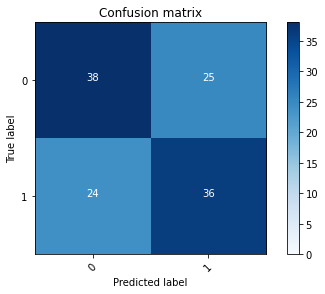

2022-08-22 15:58:41 - [Epoch Train: 24] loss: 0.0030, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 15:58:41 - [Epoch Valid: 24] loss: 1.6292, auc: 0.5717, acc: 0.6016, time: 6.00 s
2022-08-22 15:58:41 - acc improved from 0.6016 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e24-loss1.629-acc0.602-auc0.572.pth'


 24%|██████████                                | 24/100 [12:14<38:51, 30.68s/it]

2022-08-22 15:58:41 - EPOCH: 25
2022-08-22 15:58:43 - Train Step 10/121, train_loss: 0.0063
2022-08-22 15:58:45 - Train Step 20/121, train_loss: 0.0047
2022-08-22 15:58:47 - Train Step 30/121, train_loss: 0.0043
2022-08-22 15:58:49 - Train Step 40/121, train_loss: 0.0039
2022-08-22 15:58:51 - Train Step 50/121, train_loss: 0.0038
2022-08-22 15:58:53 - Train Step 60/121, train_loss: 0.0034
2022-08-22 15:58:55 - Train Step 70/121, train_loss: 0.0034
2022-08-22 15:58:57 - Train Step 80/121, train_loss: 0.0032
2022-08-22 15:58:59 - Train Step 90/121, train_loss: 0.0033
2022-08-22 15:59:01 - Train Step 100/121, train_loss: 0.0034
2022-08-22 15:59:03 - Train Step 110/121, train_loss: 0.0032
2022-08-22 15:59:05 - Train Step 120/121, train_loss: 0.0032
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:59:07 - Valid Step 5/31, valid_loss: 1.3945
2022-08-22 15:59:08 - Valid Step 10/31, valid_loss: 1.4139
2022-08-22 15:59:09 - Valid Step 15/31, valid_loss: 1.7259
2022-08-22 15:59:10

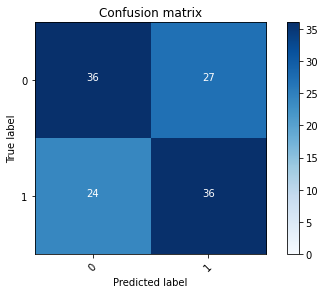

2022-08-22 15:59:12 - [Epoch Train: 25] loss: 0.0032, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:59:12 - [Epoch Valid: 25] loss: 1.6403, auc: 0.5688, acc: 0.5854, time: 6.00 s


 25%|██████████▌                               | 25/100 [12:44<38:23, 30.72s/it]

2022-08-22 15:59:12 - EPOCH: 26
2022-08-22 15:59:14 - Train Step 10/121, train_loss: 0.0034
2022-08-22 15:59:16 - Train Step 20/121, train_loss: 0.0026
2022-08-22 15:59:18 - Train Step 30/121, train_loss: 0.0029
2022-08-22 15:59:20 - Train Step 40/121, train_loss: 0.0029
2022-08-22 15:59:22 - Train Step 50/121, train_loss: 0.0027
2022-08-22 15:59:24 - Train Step 60/121, train_loss: 0.0028
2022-08-22 15:59:26 - Train Step 70/121, train_loss: 0.0027
2022-08-22 15:59:28 - Train Step 80/121, train_loss: 0.0027
2022-08-22 15:59:30 - Train Step 90/121, train_loss: 0.0027
2022-08-22 15:59:32 - Train Step 100/121, train_loss: 0.0025
2022-08-22 15:59:34 - Train Step 110/121, train_loss: 0.0025
2022-08-22 15:59:36 - Train Step 120/121, train_loss: 0.0024
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 15:59:37 - Valid Step 5/31, valid_loss: 1.8689
2022-08-22 15:59:38 - Valid Step 10/31, valid_loss: 1.5538
2022-08-22 15:59:39 - Valid Step 15/31, valid_loss: 1.5436
2022-08-22 15:59:40

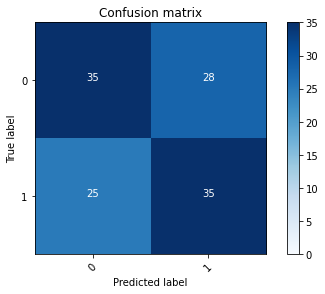

2022-08-22 15:59:43 - [Epoch Train: 26] loss: 0.0024, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 15:59:43 - [Epoch Valid: 26] loss: 1.7046, auc: 0.5704, acc: 0.5691, time: 6.00 s


 26%|██████████▉                               | 26/100 [13:15<37:50, 30.68s/it]

2022-08-22 15:59:43 - EPOCH: 27
2022-08-22 15:59:45 - Train Step 10/121, train_loss: 0.0024
2022-08-22 15:59:47 - Train Step 20/121, train_loss: 0.0022
2022-08-22 15:59:49 - Train Step 30/121, train_loss: 0.0023
2022-08-22 15:59:51 - Train Step 40/121, train_loss: 0.0026
2022-08-22 15:59:53 - Train Step 50/121, train_loss: 0.0023
2022-08-22 15:59:55 - Train Step 60/121, train_loss: 0.0023
2022-08-22 15:59:57 - Train Step 70/121, train_loss: 0.0025
2022-08-22 15:59:59 - Train Step 80/121, train_loss: 0.0026
2022-08-22 16:00:00 - Train Step 90/121, train_loss: 0.0026
2022-08-22 16:00:02 - Train Step 100/121, train_loss: 0.0025
2022-08-22 16:00:04 - Train Step 110/121, train_loss: 0.0024
2022-08-22 16:00:06 - Train Step 120/121, train_loss: 0.0024
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:00:08 - Valid Step 5/31, valid_loss: 2.0562
2022-08-22 16:00:09 - Valid Step 10/31, valid_loss: 1.5478
2022-08-22 16:00:10 - Valid Step 15/31, valid_loss: 1.6144
2022-08-22 16:00:11

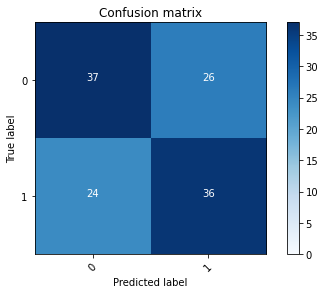

2022-08-22 16:00:13 - [Epoch Train: 27] loss: 0.0024, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:00:13 - [Epoch Valid: 27] loss: 1.7141, auc: 0.5669, acc: 0.5935, time: 6.00 s


 27%|███████████▎                              | 27/100 [13:46<37:15, 30.62s/it]

2022-08-22 16:00:13 - EPOCH: 28
2022-08-22 16:00:15 - Train Step 10/121, train_loss: 0.0017
2022-08-22 16:00:17 - Train Step 20/121, train_loss: 0.0018
2022-08-22 16:00:19 - Train Step 30/121, train_loss: 0.0018
2022-08-22 16:00:21 - Train Step 40/121, train_loss: 0.0019
2022-08-22 16:00:23 - Train Step 50/121, train_loss: 0.0025
2022-08-22 16:00:25 - Train Step 60/121, train_loss: 0.0024
2022-08-22 16:00:27 - Train Step 70/121, train_loss: 0.0023
2022-08-22 16:00:29 - Train Step 80/121, train_loss: 0.0022
2022-08-22 16:00:31 - Train Step 90/121, train_loss: 0.0021
2022-08-22 16:00:33 - Train Step 100/121, train_loss: 0.0021
2022-08-22 16:00:35 - Train Step 110/121, train_loss: 0.0020
2022-08-22 16:00:37 - Train Step 120/121, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:00:38 - Valid Step 5/31, valid_loss: 1.3312
2022-08-22 16:00:39 - Valid Step 10/31, valid_loss: 1.5640
2022-08-22 16:00:40 - Valid Step 15/31, valid_loss: 1.5138
2022-08-22 16:00:41

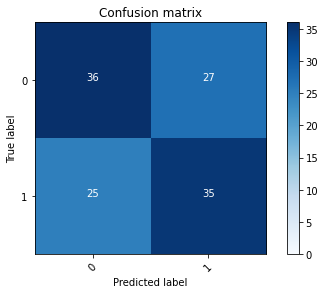

2022-08-22 16:00:44 - [Epoch Train: 28] loss: 0.0020, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:00:44 - [Epoch Valid: 28] loss: 1.7543, auc: 0.5712, acc: 0.5772, time: 6.00 s


 28%|███████████▊                              | 28/100 [14:16<36:42, 30.60s/it]

2022-08-22 16:00:44 - EPOCH: 29
2022-08-22 16:00:46 - Train Step 10/121, train_loss: 0.0018
2022-08-22 16:00:48 - Train Step 20/121, train_loss: 0.0018
2022-08-22 16:00:50 - Train Step 30/121, train_loss: 0.0018
2022-08-22 16:00:52 - Train Step 40/121, train_loss: 0.0019
2022-08-22 16:00:54 - Train Step 50/121, train_loss: 0.0020
2022-08-22 16:00:56 - Train Step 60/121, train_loss: 0.0019
2022-08-22 16:00:58 - Train Step 70/121, train_loss: 0.0019
2022-08-22 16:01:00 - Train Step 80/121, train_loss: 0.0018
2022-08-22 16:01:02 - Train Step 90/121, train_loss: 0.0018
2022-08-22 16:01:03 - Train Step 100/121, train_loss: 0.0018
2022-08-22 16:01:05 - Train Step 110/121, train_loss: 0.0017
2022-08-22 16:01:07 - Train Step 120/121, train_loss: 0.0018
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:01:09 - Valid Step 5/31, valid_loss: 2.9228
2022-08-22 16:01:10 - Valid Step 10/31, valid_loss: 1.7625
2022-08-22 16:01:11 - Valid Step 15/31, valid_loss: 1.9041
2022-08-22 16:01:12

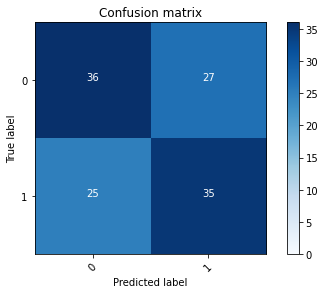

2022-08-22 16:01:14 - [Epoch Train: 29] loss: 0.0018, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:01:14 - [Epoch Valid: 29] loss: 1.7997, auc: 0.5722, acc: 0.5772, time: 6.00 s


 29%|████████████▏                             | 29/100 [14:46<36:08, 30.54s/it]

2022-08-22 16:01:14 - EPOCH: 30
2022-08-22 16:01:16 - Train Step 10/121, train_loss: 0.0012
2022-08-22 16:01:18 - Train Step 20/121, train_loss: 0.0019
2022-08-22 16:01:20 - Train Step 30/121, train_loss: 0.0018
2022-08-22 16:01:22 - Train Step 40/121, train_loss: 0.0017
2022-08-22 16:01:24 - Train Step 50/121, train_loss: 0.0016
2022-08-22 16:01:26 - Train Step 60/121, train_loss: 0.0017
2022-08-22 16:01:28 - Train Step 70/121, train_loss: 0.0016
2022-08-22 16:01:30 - Train Step 80/121, train_loss: 0.0016
2022-08-22 16:01:32 - Train Step 90/121, train_loss: 0.0016
2022-08-22 16:01:34 - Train Step 100/121, train_loss: 0.0015
2022-08-22 16:01:36 - Train Step 110/121, train_loss: 0.0015
2022-08-22 16:01:38 - Train Step 120/121, train_loss: 0.0015
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:01:40 - Valid Step 5/31, valid_loss: 1.8359
2022-08-22 16:01:41 - Valid Step 10/31, valid_loss: 1.8430
2022-08-22 16:01:42 - Valid Step 15/31, valid_loss: 1.6073
2022-08-22 16:01:43

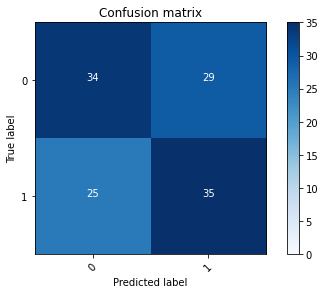

2022-08-22 16:01:45 - [Epoch Train: 30] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:01:45 - [Epoch Valid: 30] loss: 1.7906, auc: 0.5728, acc: 0.5610, time: 6.00 s


 30%|████████████▌                             | 30/100 [15:18<35:48, 30.69s/it]

2022-08-22 16:01:45 - EPOCH: 31
2022-08-22 16:01:47 - Train Step 10/121, train_loss: 0.0009
2022-08-22 16:01:49 - Train Step 20/121, train_loss: 0.0012
2022-08-22 16:01:51 - Train Step 30/121, train_loss: 0.0011
2022-08-22 16:01:53 - Train Step 40/121, train_loss: 0.0012
2022-08-22 16:01:55 - Train Step 50/121, train_loss: 0.0014
2022-08-22 16:01:57 - Train Step 60/121, train_loss: 0.0013
2022-08-22 16:01:59 - Train Step 70/121, train_loss: 0.0014
2022-08-22 16:02:01 - Train Step 80/121, train_loss: 0.0013
2022-08-22 16:02:03 - Train Step 90/121, train_loss: 0.0014
2022-08-22 16:02:05 - Train Step 100/121, train_loss: 0.0014
2022-08-22 16:02:07 - Train Step 110/121, train_loss: 0.0014
2022-08-22 16:02:09 - Train Step 120/121, train_loss: 0.0014
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:02:11 - Valid Step 5/31, valid_loss: 1.2756
2022-08-22 16:02:12 - Valid Step 10/31, valid_loss: 1.5981
2022-08-22 16:02:13 - Valid Step 15/31, valid_loss: 1.5820
2022-08-22 16:02:14

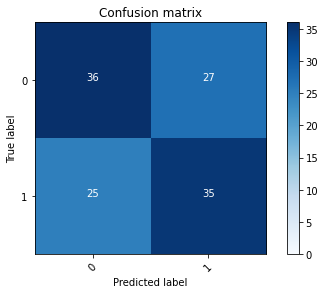

2022-08-22 16:02:16 - [Epoch Train: 31] loss: 0.0014, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:02:16 - [Epoch Valid: 31] loss: 1.7270, auc: 0.5749, acc: 0.5772, time: 6.00 s


 31%|█████████████                             | 31/100 [15:48<35:21, 30.74s/it]

2022-08-22 16:02:16 - EPOCH: 32
2022-08-22 16:02:18 - Train Step 10/121, train_loss: 0.0012
2022-08-22 16:02:20 - Train Step 20/121, train_loss: 0.0013
2022-08-22 16:02:22 - Train Step 30/121, train_loss: 0.0013
2022-08-22 16:02:24 - Train Step 40/121, train_loss: 0.0014
2022-08-22 16:02:26 - Train Step 50/121, train_loss: 0.0013
2022-08-22 16:02:28 - Train Step 60/121, train_loss: 0.0013
2022-08-22 16:02:30 - Train Step 70/121, train_loss: 0.0012
2022-08-22 16:02:32 - Train Step 80/121, train_loss: 0.0012
2022-08-22 16:02:34 - Train Step 90/121, train_loss: 0.0012
2022-08-22 16:02:36 - Train Step 100/121, train_loss: 0.0012
2022-08-22 16:02:37 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:02:39 - Train Step 120/121, train_loss: 0.0012
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:02:41 - Valid Step 5/31, valid_loss: 0.6953
2022-08-22 16:02:42 - Valid Step 10/31, valid_loss: 1.6172
2022-08-22 16:02:43 - Valid Step 15/31, valid_loss: 1.8396
2022-08-22 16:02:44

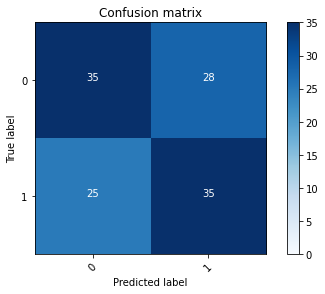

2022-08-22 16:02:46 - [Epoch Train: 32] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:02:46 - [Epoch Valid: 32] loss: 1.8896, auc: 0.5720, acc: 0.5691, time: 6.00 s


 32%|█████████████▍                            | 32/100 [16:19<34:40, 30.59s/it]

2022-08-22 16:02:46 - EPOCH: 33
2022-08-22 16:02:48 - Train Step 10/121, train_loss: 0.0010
2022-08-22 16:02:50 - Train Step 20/121, train_loss: 0.0009
2022-08-22 16:02:52 - Train Step 30/121, train_loss: 0.0010
2022-08-22 16:02:54 - Train Step 40/121, train_loss: 0.0009
2022-08-22 16:02:56 - Train Step 50/121, train_loss: 0.0010
2022-08-22 16:02:58 - Train Step 60/121, train_loss: 0.0011
2022-08-22 16:03:00 - Train Step 70/121, train_loss: 0.0010
2022-08-22 16:03:02 - Train Step 80/121, train_loss: 0.0010
2022-08-22 16:03:04 - Train Step 90/121, train_loss: 0.0011
2022-08-22 16:03:06 - Train Step 100/121, train_loss: 0.0011
2022-08-22 16:03:08 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:03:10 - Train Step 120/121, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:03:12 - Valid Step 5/31, valid_loss: 2.6080
2022-08-22 16:03:12 - Valid Step 10/31, valid_loss: 1.8142
2022-08-22 16:03:13 - Valid Step 15/31, valid_loss: 1.4799
2022-08-22 16:03:14

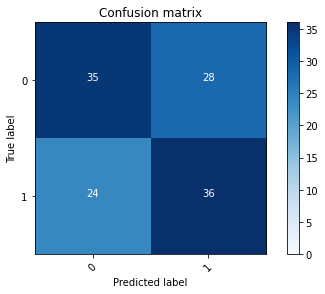

2022-08-22 16:03:17 - [Epoch Train: 33] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:03:17 - [Epoch Valid: 33] loss: 1.8096, auc: 0.5765, acc: 0.5772, time: 6.00 s


 33%|█████████████▊                            | 33/100 [16:49<34:08, 30.58s/it]

2022-08-22 16:03:17 - EPOCH: 34
2022-08-22 16:03:19 - Train Step 10/121, train_loss: 0.0021
2022-08-22 16:03:21 - Train Step 20/121, train_loss: 0.0014
2022-08-22 16:03:23 - Train Step 30/121, train_loss: 0.0012
2022-08-22 16:03:25 - Train Step 40/121, train_loss: 0.0010
2022-08-22 16:03:27 - Train Step 50/121, train_loss: 0.0011
2022-08-22 16:03:29 - Train Step 60/121, train_loss: 0.0011
2022-08-22 16:03:31 - Train Step 70/121, train_loss: 0.0011
2022-08-22 16:03:33 - Train Step 80/121, train_loss: 0.0011
2022-08-22 16:03:35 - Train Step 90/121, train_loss: 0.0010
2022-08-22 16:03:37 - Train Step 100/121, train_loss: 0.0012
2022-08-22 16:03:39 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:03:41 - Train Step 120/121, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:03:42 - Valid Step 5/31, valid_loss: 2.9289
2022-08-22 16:03:43 - Valid Step 10/31, valid_loss: 2.5342
2022-08-22 16:03:44 - Valid Step 15/31, valid_loss: 1.8641
2022-08-22 16:03:45

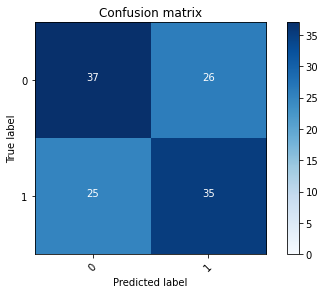

2022-08-22 16:03:47 - [Epoch Train: 34] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:03:47 - [Epoch Valid: 34] loss: 1.9784, auc: 0.5762, acc: 0.5854, time: 6.00 s


 34%|██████████████▎                           | 34/100 [17:20<33:38, 30.58s/it]

2022-08-22 16:03:47 - EPOCH: 35
2022-08-22 16:03:50 - Train Step 10/121, train_loss: 0.0009
2022-08-22 16:03:52 - Train Step 20/121, train_loss: 0.0009
2022-08-22 16:03:54 - Train Step 30/121, train_loss: 0.0010
2022-08-22 16:03:56 - Train Step 40/121, train_loss: 0.0008
2022-08-22 16:03:58 - Train Step 50/121, train_loss: 0.0009
2022-08-22 16:04:00 - Train Step 60/121, train_loss: 0.0009
2022-08-22 16:04:02 - Train Step 70/121, train_loss: 0.0010
2022-08-22 16:04:04 - Train Step 80/121, train_loss: 0.0010
2022-08-22 16:04:06 - Train Step 90/121, train_loss: 0.0010
2022-08-22 16:04:08 - Train Step 100/121, train_loss: 0.0010
2022-08-22 16:04:10 - Train Step 110/121, train_loss: 0.0010
2022-08-22 16:04:12 - Train Step 120/121, train_loss: 0.0010
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:04:13 - Valid Step 5/31, valid_loss: 2.1391
2022-08-22 16:04:14 - Valid Step 10/31, valid_loss: 2.3434
2022-08-22 16:04:15 - Valid Step 15/31, valid_loss: 2.3125
2022-08-22 16:04:16

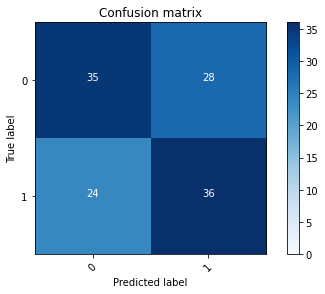

2022-08-22 16:04:18 - [Epoch Train: 35] loss: 0.0010, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:04:18 - [Epoch Valid: 35] loss: 1.8042, auc: 0.5746, acc: 0.5772, time: 6.00 s


 35%|██████████████▋                           | 35/100 [17:51<33:18, 30.75s/it]

2022-08-22 16:04:18 - EPOCH: 36
2022-08-22 16:04:21 - Train Step 10/121, train_loss: 0.0005
2022-08-22 16:04:23 - Train Step 20/121, train_loss: 0.0008
2022-08-22 16:04:24 - Train Step 30/121, train_loss: 0.0008
2022-08-22 16:04:26 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:04:28 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:04:30 - Train Step 60/121, train_loss: 0.0007
2022-08-22 16:04:32 - Train Step 70/121, train_loss: 0.0007
2022-08-22 16:04:34 - Train Step 80/121, train_loss: 0.0007
2022-08-22 16:04:36 - Train Step 90/121, train_loss: 0.0007
2022-08-22 16:04:38 - Train Step 100/121, train_loss: 0.0007
2022-08-22 16:04:40 - Train Step 110/121, train_loss: 0.0007
2022-08-22 16:04:42 - Train Step 120/121, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:04:44 - Valid Step 5/31, valid_loss: 0.5094
2022-08-22 16:04:45 - Valid Step 10/31, valid_loss: 0.8290
2022-08-22 16:04:46 - Valid Step 15/31, valid_loss: 1.1583
2022-08-22 16:04:47

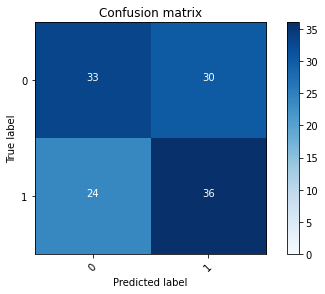

2022-08-22 16:04:49 - [Epoch Train: 36] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:04:49 - [Epoch Valid: 36] loss: 1.8338, auc: 0.5757, acc: 0.5610, time: 6.00 s


 36%|███████████████                           | 36/100 [18:21<32:44, 30.69s/it]

2022-08-22 16:04:49 - EPOCH: 37
2022-08-22 16:04:51 - Train Step 10/121, train_loss: 0.0006
2022-08-22 16:04:53 - Train Step 20/121, train_loss: 0.0008
2022-08-22 16:04:55 - Train Step 30/121, train_loss: 0.0008
2022-08-22 16:04:57 - Train Step 40/121, train_loss: 0.0008
2022-08-22 16:04:59 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:05:01 - Train Step 60/121, train_loss: 0.0008
2022-08-22 16:05:03 - Train Step 70/121, train_loss: 0.0008
2022-08-22 16:05:05 - Train Step 80/121, train_loss: 0.0008
2022-08-22 16:05:07 - Train Step 90/121, train_loss: 0.0008
2022-08-22 16:05:09 - Train Step 100/121, train_loss: 0.0008
2022-08-22 16:05:11 - Train Step 110/121, train_loss: 0.0008
2022-08-22 16:05:13 - Train Step 120/121, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:05:14 - Valid Step 5/31, valid_loss: 2.3608
2022-08-22 16:05:15 - Valid Step 10/31, valid_loss: 2.2997
2022-08-22 16:05:16 - Valid Step 15/31, valid_loss: 2.0145
2022-08-22 16:05:17

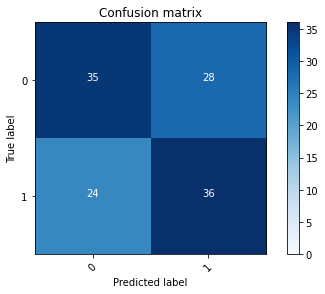

2022-08-22 16:05:19 - [Epoch Train: 37] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:05:19 - [Epoch Valid: 37] loss: 1.8859, auc: 0.5765, acc: 0.5772, time: 6.00 s


 37%|███████████████▌                          | 37/100 [18:52<32:09, 30.63s/it]

2022-08-22 16:05:19 - EPOCH: 38
2022-08-22 16:05:22 - Train Step 10/121, train_loss: 0.0005
2022-08-22 16:05:24 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:05:26 - Train Step 30/121, train_loss: 0.0005
2022-08-22 16:05:28 - Train Step 40/121, train_loss: 0.0006
2022-08-22 16:05:30 - Train Step 50/121, train_loss: 0.0006
2022-08-22 16:05:32 - Train Step 60/121, train_loss: 0.0007
2022-08-22 16:05:34 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:05:36 - Train Step 80/121, train_loss: 0.0006
2022-08-22 16:05:38 - Train Step 90/121, train_loss: 0.0007
2022-08-22 16:05:40 - Train Step 100/121, train_loss: 0.0007
2022-08-22 16:05:42 - Train Step 110/121, train_loss: 0.0007
2022-08-22 16:05:43 - Train Step 120/121, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:05:45 - Valid Step 5/31, valid_loss: 2.8073
2022-08-22 16:05:46 - Valid Step 10/31, valid_loss: 2.8617
2022-08-22 16:05:47 - Valid Step 15/31, valid_loss: 2.4019
2022-08-22 16:05:48

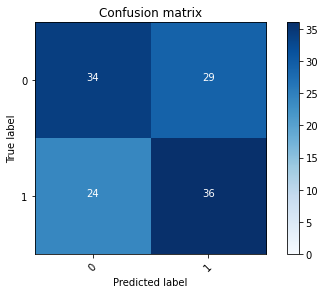

2022-08-22 16:05:50 - [Epoch Train: 38] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:05:50 - [Epoch Valid: 38] loss: 1.8106, auc: 0.5690, acc: 0.5691, time: 6.00 s


 38%|███████████████▉                          | 38/100 [19:23<31:40, 30.66s/it]

2022-08-22 16:05:50 - EPOCH: 39
2022-08-22 16:05:52 - Train Step 10/121, train_loss: 0.0007
2022-08-22 16:05:54 - Train Step 20/121, train_loss: 0.0007
2022-08-22 16:05:56 - Train Step 30/121, train_loss: 0.0007
2022-08-22 16:05:58 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:06:00 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:06:02 - Train Step 60/121, train_loss: 0.0006
2022-08-22 16:06:04 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:06:06 - Train Step 80/121, train_loss: 0.0006
2022-08-22 16:06:08 - Train Step 90/121, train_loss: 0.0006
2022-08-22 16:06:10 - Train Step 100/121, train_loss: 0.0006
2022-08-22 16:06:12 - Train Step 110/121, train_loss: 0.0006
2022-08-22 16:06:14 - Train Step 120/121, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:06:15 - Valid Step 5/31, valid_loss: 3.3404
2022-08-22 16:06:16 - Valid Step 10/31, valid_loss: 2.5195
2022-08-22 16:06:17 - Valid Step 15/31, valid_loss: 1.9380
2022-08-22 16:06:18

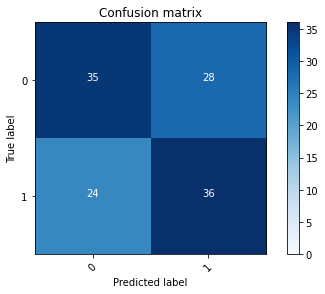

2022-08-22 16:06:20 - [Epoch Train: 39] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:06:20 - [Epoch Valid: 39] loss: 1.9802, auc: 0.5786, acc: 0.5772, time: 6.00 s


 39%|████████████████▍                         | 39/100 [19:53<31:01, 30.52s/it]

2022-08-22 16:06:20 - EPOCH: 40
2022-08-22 16:06:23 - Train Step 10/121, train_loss: 0.0007
2022-08-22 16:06:25 - Train Step 20/121, train_loss: 0.0009
2022-08-22 16:06:27 - Train Step 30/121, train_loss: 0.0007
2022-08-22 16:06:29 - Train Step 40/121, train_loss: 0.0006
2022-08-22 16:06:30 - Train Step 50/121, train_loss: 0.0006
2022-08-22 16:06:33 - Train Step 60/121, train_loss: 0.0006
2022-08-22 16:06:35 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:06:37 - Train Step 80/121, train_loss: 0.0006
2022-08-22 16:06:39 - Train Step 90/121, train_loss: 0.0006
2022-08-22 16:06:41 - Train Step 100/121, train_loss: 0.0006
2022-08-22 16:06:43 - Train Step 110/121, train_loss: 0.0006
2022-08-22 16:06:45 - Train Step 120/121, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:06:47 - Valid Step 5/31, valid_loss: 1.6693
2022-08-22 16:06:48 - Valid Step 10/31, valid_loss: 1.4288
2022-08-22 16:06:49 - Valid Step 15/31, valid_loss: 1.4433
2022-08-22 16:06:50

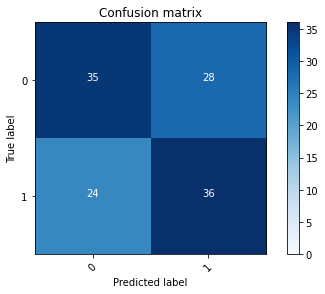

2022-08-22 16:06:52 - [Epoch Train: 40] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 16:06:52 - [Epoch Valid: 40] loss: 1.9635, auc: 0.5759, acc: 0.5772, time: 6.00 s


 40%|████████████████▊                         | 40/100 [20:25<30:53, 30.89s/it]

2022-08-22 16:06:52 - EPOCH: 41
2022-08-22 16:06:54 - Train Step 10/121, train_loss: 0.0006
2022-08-22 16:06:56 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:06:58 - Train Step 30/121, train_loss: 0.0005
2022-08-22 16:07:00 - Train Step 40/121, train_loss: 0.0005
2022-08-22 16:07:02 - Train Step 50/121, train_loss: 0.0006
2022-08-22 16:07:04 - Train Step 60/121, train_loss: 0.0006
2022-08-22 16:07:06 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:07:08 - Train Step 80/121, train_loss: 0.0006
2022-08-22 16:07:10 - Train Step 90/121, train_loss: 0.0006
2022-08-22 16:07:12 - Train Step 100/121, train_loss: 0.0006
2022-08-22 16:07:14 - Train Step 110/121, train_loss: 0.0006
2022-08-22 16:07:16 - Train Step 120/121, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:07:18 - Valid Step 5/31, valid_loss: 2.3975
2022-08-22 16:07:18 - Valid Step 10/31, valid_loss: 2.5265
2022-08-22 16:07:20 - Valid Step 15/31, valid_loss: 2.1832
2022-08-22 16:07:20

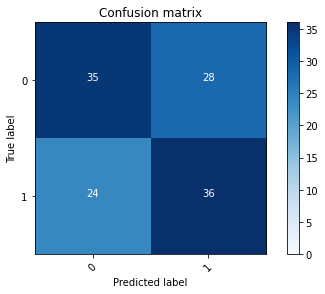

2022-08-22 16:07:23 - [Epoch Train: 41] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:07:23 - [Epoch Valid: 41] loss: 1.9298, auc: 0.5802, acc: 0.5772, time: 6.00 s


 41%|█████████████████▏                        | 41/100 [20:55<30:18, 30.82s/it]

2022-08-22 16:07:23 - EPOCH: 42
2022-08-22 16:07:25 - Train Step 10/121, train_loss: 0.0004
2022-08-22 16:07:27 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:07:29 - Train Step 30/121, train_loss: 0.0007
2022-08-22 16:07:31 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:07:33 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:07:35 - Train Step 60/121, train_loss: 0.0006
2022-08-22 16:07:37 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:07:39 - Train Step 80/121, train_loss: 0.0006
2022-08-22 16:07:41 - Train Step 90/121, train_loss: 0.0006
2022-08-22 16:07:43 - Train Step 100/121, train_loss: 0.0006
2022-08-22 16:07:45 - Train Step 110/121, train_loss: 0.0006
2022-08-22 16:07:47 - Train Step 120/121, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:07:48 - Valid Step 5/31, valid_loss: 1.6404
2022-08-22 16:07:49 - Valid Step 10/31, valid_loss: 2.6151
2022-08-22 16:07:50 - Valid Step 15/31, valid_loss: 2.2898
2022-08-22 16:07:51

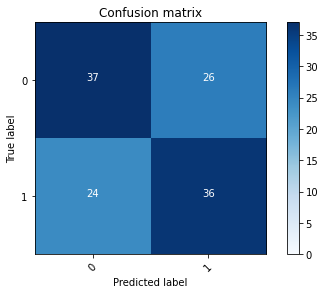

2022-08-22 16:07:54 - [Epoch Train: 42] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:07:54 - [Epoch Valid: 42] loss: 2.0437, auc: 0.5775, acc: 0.5935, time: 6.00 s


 42%|█████████████████▋                        | 42/100 [21:26<29:46, 30.79s/it]

2022-08-22 16:07:54 - EPOCH: 43
2022-08-22 16:07:56 - Train Step 10/121, train_loss: 0.0004
2022-08-22 16:07:58 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:08:00 - Train Step 30/121, train_loss: 0.0004
2022-08-22 16:08:02 - Train Step 40/121, train_loss: 0.0004
2022-08-22 16:08:04 - Train Step 50/121, train_loss: 0.0004
2022-08-22 16:08:05 - Train Step 60/121, train_loss: 0.0004
2022-08-22 16:08:07 - Train Step 70/121, train_loss: 0.0005
2022-08-22 16:08:09 - Train Step 80/121, train_loss: 0.0005
2022-08-22 16:08:11 - Train Step 90/121, train_loss: 0.0004
2022-08-22 16:08:13 - Train Step 100/121, train_loss: 0.0004
2022-08-22 16:08:15 - Train Step 110/121, train_loss: 0.0004
2022-08-22 16:08:17 - Train Step 120/121, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:08:19 - Valid Step 5/31, valid_loss: 2.4384
2022-08-22 16:08:20 - Valid Step 10/31, valid_loss: 2.6840
2022-08-22 16:08:21 - Valid Step 15/31, valid_loss: 2.7146
2022-08-22 16:08:22

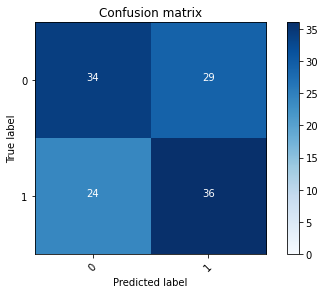

2022-08-22 16:08:24 - [Epoch Train: 43] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:08:24 - [Epoch Valid: 43] loss: 1.9948, auc: 0.5737, acc: 0.5691, time: 6.00 s


 43%|██████████████████                        | 43/100 [21:56<29:10, 30.70s/it]

2022-08-22 16:08:24 - EPOCH: 44
2022-08-22 16:08:26 - Train Step 10/121, train_loss: 0.0003
2022-08-22 16:08:28 - Train Step 20/121, train_loss: 0.0003
2022-08-22 16:08:30 - Train Step 30/121, train_loss: 0.0003
2022-08-22 16:08:32 - Train Step 40/121, train_loss: 0.0004
2022-08-22 16:08:34 - Train Step 50/121, train_loss: 0.0004
2022-08-22 16:08:36 - Train Step 60/121, train_loss: 0.0004
2022-08-22 16:08:38 - Train Step 70/121, train_loss: 0.0004
2022-08-22 16:08:40 - Train Step 80/121, train_loss: 0.0004
2022-08-22 16:08:42 - Train Step 90/121, train_loss: 0.0004
2022-08-22 16:08:44 - Train Step 100/121, train_loss: 0.0004
2022-08-22 16:08:46 - Train Step 110/121, train_loss: 0.0004
2022-08-22 16:08:48 - Train Step 120/121, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:08:50 - Valid Step 5/31, valid_loss: 2.6090
2022-08-22 16:08:51 - Valid Step 10/31, valid_loss: 1.8456
2022-08-22 16:08:52 - Valid Step 15/31, valid_loss: 1.7585
2022-08-22 16:08:53

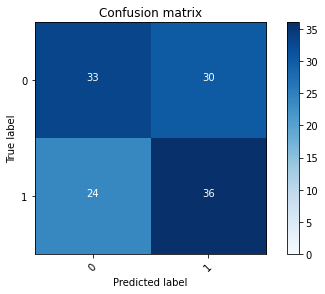

2022-08-22 16:08:55 - [Epoch Train: 44] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:08:55 - [Epoch Valid: 44] loss: 2.0349, auc: 0.5815, acc: 0.5610, time: 6.00 s


 44%|██████████████████▍                       | 44/100 [22:28<28:48, 30.86s/it]

2022-08-22 16:08:55 - EPOCH: 45
2022-08-22 16:08:57 - Train Step 10/121, train_loss: 0.0005
2022-08-22 16:08:59 - Train Step 20/121, train_loss: 0.0004
2022-08-22 16:09:01 - Train Step 30/121, train_loss: 0.0004
2022-08-22 16:09:03 - Train Step 40/121, train_loss: 0.0003
2022-08-22 16:09:05 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:09:07 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:09:09 - Train Step 70/121, train_loss: 0.0004
2022-08-22 16:09:11 - Train Step 80/121, train_loss: 0.0004
2022-08-22 16:09:13 - Train Step 90/121, train_loss: 0.0004
2022-08-22 16:09:15 - Train Step 100/121, train_loss: 0.0004
2022-08-22 16:09:17 - Train Step 110/121, train_loss: 0.0004
2022-08-22 16:09:19 - Train Step 120/121, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:09:21 - Valid Step 5/31, valid_loss: 2.7045
2022-08-22 16:09:21 - Valid Step 10/31, valid_loss: 2.4044
2022-08-22 16:09:23 - Valid Step 15/31, valid_loss: 2.0508
2022-08-22 16:09:23

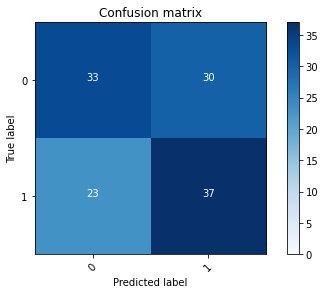

2022-08-22 16:09:26 - [Epoch Train: 45] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:09:26 - [Epoch Valid: 45] loss: 2.0723, auc: 0.5762, acc: 0.5691, time: 6.00 s


 45%|██████████████████▉                       | 45/100 [22:58<28:10, 30.73s/it]

2022-08-22 16:09:26 - EPOCH: 46
2022-08-22 16:09:28 - Train Step 10/121, train_loss: 0.0006
2022-08-22 16:09:30 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:09:32 - Train Step 30/121, train_loss: 0.0004
2022-08-22 16:09:34 - Train Step 40/121, train_loss: 0.0004
2022-08-22 16:09:36 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:09:38 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:09:40 - Train Step 70/121, train_loss: 0.0003
2022-08-22 16:09:42 - Train Step 80/121, train_loss: 0.0003
2022-08-22 16:09:44 - Train Step 90/121, train_loss: 0.0003
2022-08-22 16:09:45 - Train Step 100/121, train_loss: 0.0003
2022-08-22 16:09:47 - Train Step 110/121, train_loss: 0.0003
2022-08-22 16:09:49 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:09:51 - Valid Step 5/31, valid_loss: 0.3328
2022-08-22 16:09:52 - Valid Step 10/31, valid_loss: 2.0905
2022-08-22 16:09:53 - Valid Step 15/31, valid_loss: 1.8955
2022-08-22 16:09:54

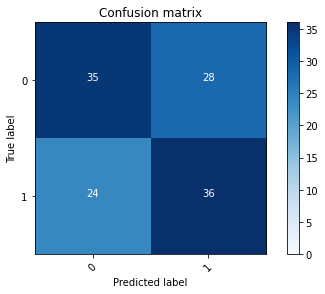

2022-08-22 16:09:56 - [Epoch Train: 46] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:09:56 - [Epoch Valid: 46] loss: 2.0485, auc: 0.5762, acc: 0.5772, time: 6.00 s


 46%|███████████████████▎                      | 46/100 [23:29<27:37, 30.70s/it]

2022-08-22 16:09:56 - EPOCH: 47
2022-08-22 16:09:59 - Train Step 10/121, train_loss: 0.0002
2022-08-22 16:10:01 - Train Step 20/121, train_loss: 0.0003
2022-08-22 16:10:03 - Train Step 30/121, train_loss: 0.0003
2022-08-22 16:10:05 - Train Step 40/121, train_loss: 0.0003
2022-08-22 16:10:07 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:10:09 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:10:11 - Train Step 70/121, train_loss: 0.0003
2022-08-22 16:10:13 - Train Step 80/121, train_loss: 0.0003
2022-08-22 16:10:15 - Train Step 90/121, train_loss: 0.0003
2022-08-22 16:10:17 - Train Step 100/121, train_loss: 0.0004
2022-08-22 16:10:19 - Train Step 110/121, train_loss: 0.0004
2022-08-22 16:10:21 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:10:22 - Valid Step 5/31, valid_loss: 3.0142
2022-08-22 16:10:23 - Valid Step 10/31, valid_loss: 2.2272
2022-08-22 16:10:24 - Valid Step 15/31, valid_loss: 2.3569
2022-08-22 16:10:25

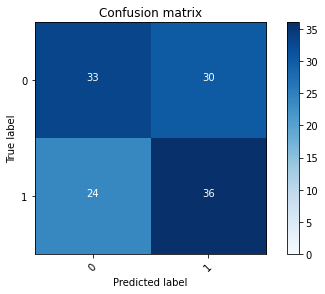

2022-08-22 16:10:27 - [Epoch Train: 47] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:10:27 - [Epoch Valid: 47] loss: 2.0156, auc: 0.5767, acc: 0.5610, time: 6.00 s


 47%|███████████████████▋                      | 47/100 [24:00<27:14, 30.85s/it]

2022-08-22 16:10:27 - EPOCH: 48
2022-08-22 16:10:30 - Train Step 10/121, train_loss: 0.0002
2022-08-22 16:10:32 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:10:34 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:10:36 - Train Step 40/121, train_loss: 0.0003
2022-08-22 16:10:38 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:10:40 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:10:42 - Train Step 70/121, train_loss: 0.0003
2022-08-22 16:10:44 - Train Step 80/121, train_loss: 0.0003
2022-08-22 16:10:46 - Train Step 90/121, train_loss: 0.0003
2022-08-22 16:10:48 - Train Step 100/121, train_loss: 0.0003
2022-08-22 16:10:50 - Train Step 110/121, train_loss: 0.0003
2022-08-22 16:10:52 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:10:53 - Valid Step 5/31, valid_loss: 1.4692
2022-08-22 16:10:54 - Valid Step 10/31, valid_loss: 1.7905
2022-08-22 16:10:55 - Valid Step 15/31, valid_loss: 2.8646
2022-08-22 16:10:56

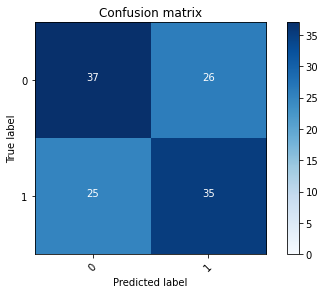

2022-08-22 16:10:58 - [Epoch Train: 48] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:10:58 - [Epoch Valid: 48] loss: 2.2075, auc: 0.5725, acc: 0.5854, time: 6.00 s


 48%|████████████████████▏                     | 48/100 [24:31<26:46, 30.89s/it]

2022-08-22 16:10:58 - EPOCH: 49
2022-08-22 16:11:01 - Train Step 10/121, train_loss: 0.0004
2022-08-22 16:11:03 - Train Step 20/121, train_loss: 0.0003
2022-08-22 16:11:05 - Train Step 30/121, train_loss: 0.0003
2022-08-22 16:11:06 - Train Step 40/121, train_loss: 0.0003
2022-08-22 16:11:08 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:11:10 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:11:12 - Train Step 70/121, train_loss: 0.0003
2022-08-22 16:11:14 - Train Step 80/121, train_loss: 0.0003
2022-08-22 16:11:16 - Train Step 90/121, train_loss: 0.0003
2022-08-22 16:11:18 - Train Step 100/121, train_loss: 0.0003
2022-08-22 16:11:20 - Train Step 110/121, train_loss: 0.0003
2022-08-22 16:11:22 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:11:24 - Valid Step 5/31, valid_loss: 1.7242
2022-08-22 16:11:24 - Valid Step 10/31, valid_loss: 1.7656
2022-08-22 16:11:26 - Valid Step 15/31, valid_loss: 1.9210
2022-08-22 16:11:26

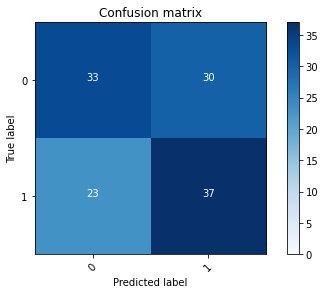

2022-08-22 16:11:29 - [Epoch Train: 49] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:11:29 - [Epoch Valid: 49] loss: 2.0212, auc: 0.5749, acc: 0.5691, time: 6.00 s


 49%|████████████████████▌                     | 49/100 [25:01<26:08, 30.75s/it]

2022-08-22 16:11:29 - EPOCH: 50
2022-08-22 16:11:31 - Train Step 10/121, train_loss: 0.0002
2022-08-22 16:11:33 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:11:35 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:11:37 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:11:39 - Train Step 50/121, train_loss: 0.0002
2022-08-22 16:11:41 - Train Step 60/121, train_loss: 0.0002
2022-08-22 16:11:43 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:11:44 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:11:46 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:11:48 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:11:50 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:11:52 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:11:54 - Valid Step 5/31, valid_loss: 2.7601
2022-08-22 16:11:55 - Valid Step 10/31, valid_loss: 2.8724
2022-08-22 16:11:56 - Valid Step 15/31, valid_loss: 2.5836
2022-08-22 16:11:56

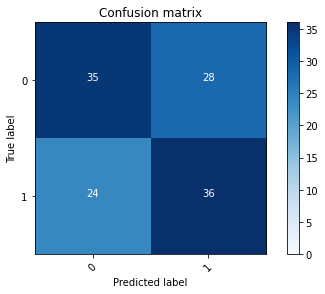

2022-08-22 16:11:59 - [Epoch Train: 50] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:11:59 - [Epoch Valid: 50] loss: 2.1637, auc: 0.5741, acc: 0.5772, time: 6.00 s


 50%|█████████████████████                     | 50/100 [25:31<25:25, 30.51s/it]

2022-08-22 16:11:59 - EPOCH: 51
2022-08-22 16:12:01 - Train Step 10/121, train_loss: 0.0002
2022-08-22 16:12:03 - Train Step 20/121, train_loss: 0.0007
2022-08-22 16:12:05 - Train Step 30/121, train_loss: 0.0005
2022-08-22 16:12:07 - Train Step 40/121, train_loss: 0.0005
2022-08-22 16:12:09 - Train Step 50/121, train_loss: 0.0004
2022-08-22 16:12:11 - Train Step 60/121, train_loss: 0.0004
2022-08-22 16:12:13 - Train Step 70/121, train_loss: 0.0004
2022-08-22 16:12:15 - Train Step 80/121, train_loss: 0.0003
2022-08-22 16:12:17 - Train Step 90/121, train_loss: 0.0003
2022-08-22 16:12:19 - Train Step 100/121, train_loss: 0.0003
2022-08-22 16:12:21 - Train Step 110/121, train_loss: 0.0003
2022-08-22 16:12:22 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:12:24 - Valid Step 5/31, valid_loss: 0.7898
2022-08-22 16:12:25 - Valid Step 10/31, valid_loss: 1.1537
2022-08-22 16:12:26 - Valid Step 15/31, valid_loss: 2.0589
2022-08-22 16:12:27

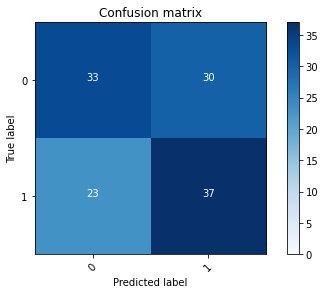

2022-08-22 16:12:29 - [Epoch Train: 51] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:12:29 - [Epoch Valid: 51] loss: 2.1150, auc: 0.5775, acc: 0.5691, time: 6.00 s


 51%|█████████████████████▍                    | 51/100 [26:02<24:50, 30.42s/it]

2022-08-22 16:12:29 - EPOCH: 52
2022-08-22 16:12:31 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:12:33 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:12:35 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:12:37 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:12:39 - Train Step 50/121, train_loss: 0.0002
2022-08-22 16:12:41 - Train Step 60/121, train_loss: 0.0002
2022-08-22 16:12:43 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:12:45 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:12:47 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:12:49 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:12:51 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:12:53 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:12:54 - Valid Step 5/31, valid_loss: 1.6628
2022-08-22 16:12:55 - Valid Step 10/31, valid_loss: 2.3311
2022-08-22 16:12:56 - Valid Step 15/31, valid_loss: 2.4385
2022-08-22 16:12:57

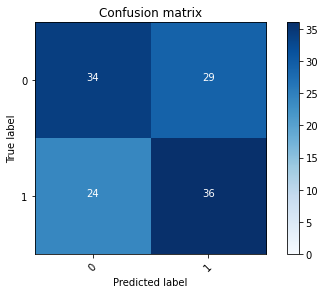

2022-08-22 16:12:59 - [Epoch Train: 52] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:12:59 - [Epoch Valid: 52] loss: 2.1051, auc: 0.5783, acc: 0.5691, time: 6.00 s


 52%|█████████████████████▊                    | 52/100 [26:32<24:18, 30.38s/it]

2022-08-22 16:12:59 - EPOCH: 53
2022-08-22 16:13:02 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:13:04 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:13:05 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:13:07 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:13:09 - Train Step 50/121, train_loss: 0.0002
2022-08-22 16:13:11 - Train Step 60/121, train_loss: 0.0002
2022-08-22 16:13:13 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:13:15 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:13:17 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:13:19 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:13:21 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:13:23 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:13:25 - Valid Step 5/31, valid_loss: 1.8985
2022-08-22 16:13:25 - Valid Step 10/31, valid_loss: 2.1126
2022-08-22 16:13:27 - Valid Step 15/31, valid_loss: 2.0550
2022-08-22 16:13:27

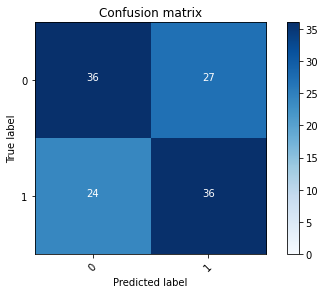

2022-08-22 16:13:30 - [Epoch Train: 53] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:13:30 - [Epoch Valid: 53] loss: 2.2383, auc: 0.5743, acc: 0.5854, time: 6.00 s


 53%|██████████████████████▎                   | 53/100 [27:02<23:48, 30.39s/it]

2022-08-22 16:13:30 - EPOCH: 54
2022-08-22 16:13:32 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:13:34 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:13:36 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:13:38 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:13:40 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:13:42 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:13:44 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:13:46 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:13:48 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:13:50 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:13:52 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:13:54 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:13:56 - Valid Step 5/31, valid_loss: 2.9043
2022-08-22 16:13:57 - Valid Step 10/31, valid_loss: 2.6564
2022-08-22 16:13:58 - Valid Step 15/31, valid_loss: 2.1826
2022-08-22 16:13:58

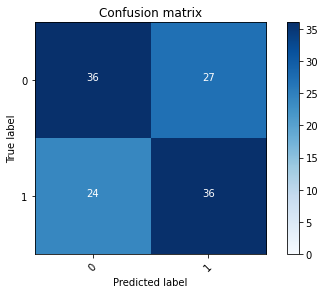

2022-08-22 16:14:01 - [Epoch Train: 54] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:14:01 - [Epoch Valid: 54] loss: 2.2842, auc: 0.5807, acc: 0.5854, time: 6.00 s


 54%|██████████████████████▋                   | 54/100 [27:33<23:27, 30.60s/it]

2022-08-22 16:14:01 - EPOCH: 55
2022-08-22 16:14:03 - Train Step 10/121, train_loss: 0.0003
2022-08-22 16:14:05 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:14:07 - Train Step 30/121, train_loss: 0.0003
2022-08-22 16:14:09 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:14:11 - Train Step 50/121, train_loss: 0.0002
2022-08-22 16:14:13 - Train Step 60/121, train_loss: 0.0002
2022-08-22 16:14:15 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:14:17 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:14:19 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:14:21 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:14:23 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:14:25 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:14:26 - Valid Step 5/31, valid_loss: 2.8543
2022-08-22 16:14:27 - Valid Step 10/31, valid_loss: 2.4473
2022-08-22 16:14:28 - Valid Step 15/31, valid_loss: 2.3121
2022-08-22 16:14:29

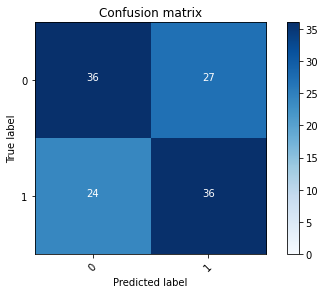

2022-08-22 16:14:31 - [Epoch Train: 55] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:14:31 - [Epoch Valid: 55] loss: 2.2345, auc: 0.5810, acc: 0.5854, time: 6.00 s


 55%|███████████████████████                   | 55/100 [28:04<22:53, 30.52s/it]

2022-08-22 16:14:31 - EPOCH: 56
2022-08-22 16:14:33 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:14:35 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:14:37 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:14:39 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:14:41 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:14:43 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:14:45 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:14:47 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:14:49 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:14:51 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:14:53 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:14:55 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:14:56 - Valid Step 5/31, valid_loss: 0.9951
2022-08-22 16:14:57 - Valid Step 10/31, valid_loss: 2.4922
2022-08-22 16:14:58 - Valid Step 15/31, valid_loss: 2.8362
2022-08-22 16:14:59

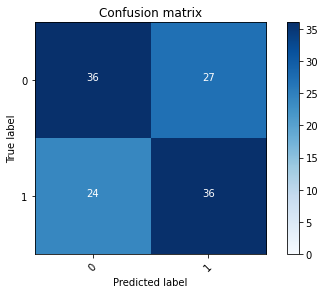

2022-08-22 16:15:01 - [Epoch Train: 56] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:15:01 - [Epoch Valid: 56] loss: 2.2147, auc: 0.5839, acc: 0.5854, time: 6.00 s


 56%|███████████████████████▌                  | 56/100 [28:34<22:18, 30.41s/it]

2022-08-22 16:15:01 - EPOCH: 57
2022-08-22 16:15:04 - Train Step 10/121, train_loss: 0.0002
2022-08-22 16:15:06 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:15:08 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:15:10 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:15:12 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:15:14 - Train Step 60/121, train_loss: 0.0002
2022-08-22 16:15:16 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:15:18 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:15:20 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:15:22 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:15:24 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:15:26 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:15:27 - Valid Step 5/31, valid_loss: 1.6248
2022-08-22 16:15:28 - Valid Step 10/31, valid_loss: 2.0128
2022-08-22 16:15:29 - Valid Step 15/31, valid_loss: 2.3543
2022-08-22 16:15:30

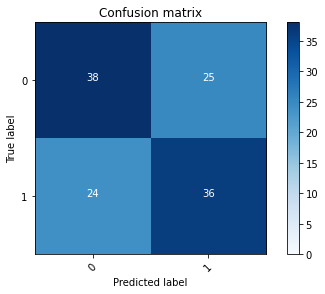

2022-08-22 16:15:32 - [Epoch Train: 57] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:15:32 - [Epoch Valid: 57] loss: 2.3134, auc: 0.5746, acc: 0.6016, time: 6.00 s
2022-08-22 16:15:32 - acc improved from 0.6016 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e57-loss2.313-acc0.602-auc0.575.pth'


 57%|███████████████████████▉                  | 57/100 [29:05<21:56, 30.62s/it]

2022-08-22 16:15:32 - EPOCH: 58
2022-08-22 16:15:35 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:15:37 - Train Step 20/121, train_loss: 0.0004
2022-08-22 16:15:39 - Train Step 30/121, train_loss: 0.0004
2022-08-22 16:15:41 - Train Step 40/121, train_loss: 0.0003
2022-08-22 16:15:43 - Train Step 50/121, train_loss: 0.0003
2022-08-22 16:15:45 - Train Step 60/121, train_loss: 0.0003
2022-08-22 16:15:47 - Train Step 70/121, train_loss: 0.0002
2022-08-22 16:15:48 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:15:50 - Train Step 90/121, train_loss: 0.0002
2022-08-22 16:15:52 - Train Step 100/121, train_loss: 0.0002
2022-08-22 16:15:54 - Train Step 110/121, train_loss: 0.0002
2022-08-22 16:15:56 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:15:58 - Valid Step 5/31, valid_loss: 2.8907
2022-08-22 16:15:59 - Valid Step 10/31, valid_loss: 2.7690
2022-08-22 16:16:00 - Valid Step 15/31, valid_loss: 2.3119
2022-08-22 16:16:01

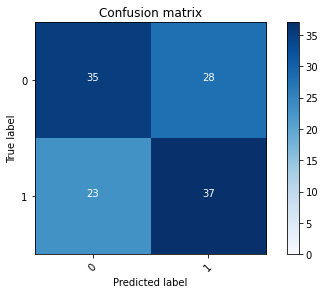

2022-08-22 16:16:03 - [Epoch Train: 58] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:16:03 - [Epoch Valid: 58] loss: 2.3050, auc: 0.5746, acc: 0.5854, time: 6.00 s


 58%|████████████████████████▎                 | 58/100 [29:36<21:27, 30.66s/it]

2022-08-22 16:16:03 - EPOCH: 59
2022-08-22 16:16:06 - Train Step 10/121, train_loss: 0.0004
2022-08-22 16:16:08 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:16:10 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:16:12 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:16:14 - Train Step 50/121, train_loss: 0.0002
2022-08-22 16:16:16 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:16:18 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:16:20 - Train Step 80/121, train_loss: 0.0002
2022-08-22 16:16:22 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:16:24 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:16:26 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:16:28 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:16:29 - Valid Step 5/31, valid_loss: 2.5114
2022-08-22 16:16:30 - Valid Step 10/31, valid_loss: 2.4259
2022-08-22 16:16:31 - Valid Step 15/31, valid_loss: 2.5005
2022-08-22 16:16:32

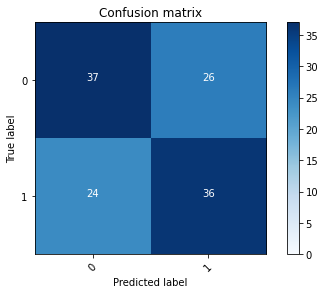

2022-08-22 16:16:34 - [Epoch Train: 59] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:16:34 - [Epoch Valid: 59] loss: 2.3367, auc: 0.5738, acc: 0.5935, time: 6.00 s


 59%|████████████████████████▊                 | 59/100 [30:07<21:03, 30.81s/it]

2022-08-22 16:16:34 - EPOCH: 60
2022-08-22 16:16:37 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:16:39 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:16:40 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:16:42 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:16:44 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:16:46 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:16:48 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:16:50 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:16:52 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:16:54 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:16:56 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:16:58 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:16:59 - Valid Step 5/31, valid_loss: 2.0876
2022-08-22 16:17:00 - Valid Step 10/31, valid_loss: 1.9802
2022-08-22 16:17:01 - Valid Step 15/31, valid_loss: 2.1018
2022-08-22 16:17:02

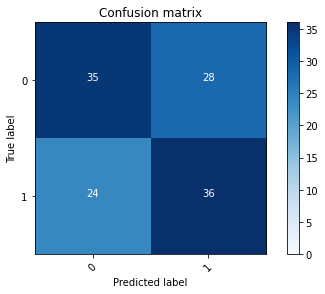

2022-08-22 16:17:05 - [Epoch Train: 60] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:17:05 - [Epoch Valid: 60] loss: 2.2699, auc: 0.5786, acc: 0.5772, time: 6.00 s


 60%|█████████████████████████▏                | 60/100 [30:37<20:24, 30.62s/it]

2022-08-22 16:17:05 - EPOCH: 61
2022-08-22 16:17:07 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:17:09 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:17:11 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:17:13 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:17:15 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:17:17 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:17:18 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:17:20 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:17:22 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:17:24 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:17:26 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:17:28 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:17:30 - Valid Step 5/31, valid_loss: 2.2449
2022-08-22 16:17:31 - Valid Step 10/31, valid_loss: 2.4491
2022-08-22 16:17:32 - Valid Step 15/31, valid_loss: 2.1478
2022-08-22 16:17:32

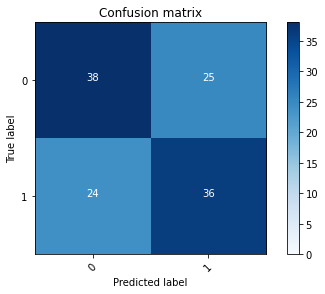

2022-08-22 16:17:35 - [Epoch Train: 61] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:17:35 - [Epoch Valid: 61] loss: 2.3973, auc: 0.5783, acc: 0.6016, time: 6.00 s
2022-08-22 16:17:35 - acc improved from 0.6016 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e61-loss2.397-acc0.602-auc0.578.pth'


 61%|█████████████████████████▌                | 61/100 [31:08<19:52, 30.59s/it]

2022-08-22 16:17:35 - EPOCH: 62
2022-08-22 16:17:37 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:17:39 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:17:41 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:17:43 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:17:45 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:17:47 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:17:49 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:17:51 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:17:53 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:17:55 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:17:57 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:17:59 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:18:01 - Valid Step 5/31, valid_loss: 2.4910
2022-08-22 16:18:01 - Valid Step 10/31, valid_loss: 2.2265
2022-08-22 16:18:03 - Valid Step 15/31, valid_loss: 2.4281
2022-08-22 16:18:03

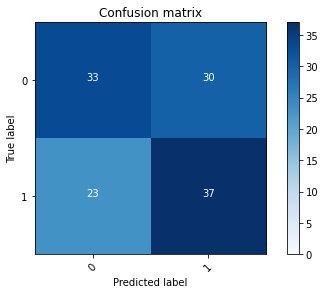

2022-08-22 16:18:06 - [Epoch Train: 62] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:18:06 - [Epoch Valid: 62] loss: 2.3377, auc: 0.5725, acc: 0.5691, time: 6.00 s


 62%|██████████████████████████                | 62/100 [31:38<19:23, 30.62s/it]

2022-08-22 16:18:06 - EPOCH: 63
2022-08-22 16:18:08 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:18:10 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:18:12 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:18:14 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:18:16 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:18:18 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:18:20 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:18:22 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:18:23 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:18:25 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:18:27 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:18:29 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:18:31 - Valid Step 5/31, valid_loss: 2.8023
2022-08-22 16:18:32 - Valid Step 10/31, valid_loss: 2.9159
2022-08-22 16:18:33 - Valid Step 15/31, valid_loss: 2.8295
2022-08-22 16:18:34

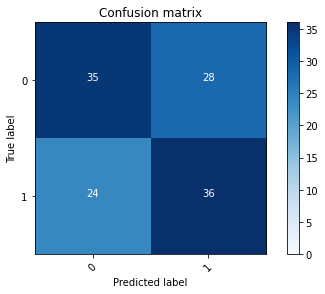

2022-08-22 16:18:36 - [Epoch Train: 63] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:18:36 - [Epoch Valid: 63] loss: 2.4321, auc: 0.5767, acc: 0.5772, time: 6.00 s


 63%|██████████████████████████▍               | 63/100 [32:09<18:49, 30.52s/it]

2022-08-22 16:18:36 - EPOCH: 64
2022-08-22 16:18:38 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:18:40 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:18:42 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:18:44 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:18:46 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:18:48 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:18:50 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:18:52 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:18:54 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:18:56 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:18:58 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:19:00 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:19:01 - Valid Step 5/31, valid_loss: 3.9012
2022-08-22 16:19:02 - Valid Step 10/31, valid_loss: 3.1449
2022-08-22 16:19:03 - Valid Step 15/31, valid_loss: 2.4847
2022-08-22 16:19:04

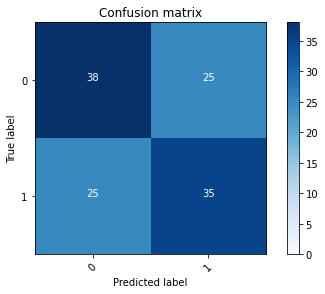

2022-08-22 16:19:07 - [Epoch Train: 64] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:19:07 - [Epoch Valid: 64] loss: 2.4224, auc: 0.5783, acc: 0.5935, time: 6.00 s


 64%|██████████████████████████▉               | 64/100 [32:39<18:20, 30.56s/it]

2022-08-22 16:19:07 - EPOCH: 65
2022-08-22 16:19:09 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:19:11 - Train Step 20/121, train_loss: 0.0003
2022-08-22 16:19:13 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:19:15 - Train Step 40/121, train_loss: 0.0002
2022-08-22 16:19:17 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:19:19 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:19:21 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:19:23 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:19:25 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:19:27 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:19:29 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:19:31 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:19:32 - Valid Step 5/31, valid_loss: 1.4280
2022-08-22 16:19:33 - Valid Step 10/31, valid_loss: 2.0297
2022-08-22 16:19:34 - Valid Step 15/31, valid_loss: 2.2659
2022-08-22 16:19:35

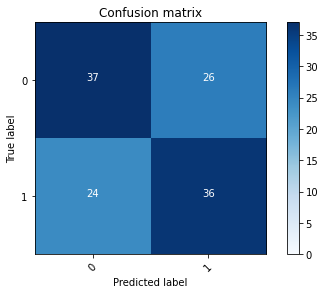

2022-08-22 16:19:38 - [Epoch Train: 65] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:19:38 - [Epoch Valid: 65] loss: 2.4352, auc: 0.5706, acc: 0.5935, time: 6.00 s


 65%|███████████████████████████▎              | 65/100 [33:10<17:54, 30.71s/it]

2022-08-22 16:19:38 - EPOCH: 66
2022-08-22 16:19:40 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:19:42 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:19:44 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:19:46 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:19:48 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:19:50 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:19:52 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:19:54 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:19:56 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:19:58 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:20:00 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:20:02 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:20:03 - Valid Step 5/31, valid_loss: 1.8658
2022-08-22 16:20:04 - Valid Step 10/31, valid_loss: 2.2095
2022-08-22 16:20:05 - Valid Step 15/31, valid_loss: 2.0839
2022-08-22 16:20:06

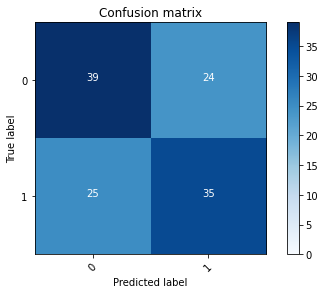

2022-08-22 16:20:08 - [Epoch Train: 66] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:20:08 - [Epoch Valid: 66] loss: 2.4749, auc: 0.5778, acc: 0.6016, time: 6.00 s
2022-08-22 16:20:08 - acc improved from 0.6016 to 0.6016. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e66-loss2.475-acc0.602-auc0.578.pth'


 66%|███████████████████████████▋              | 66/100 [33:41<17:21, 30.62s/it]

2022-08-22 16:20:08 - EPOCH: 67
2022-08-22 16:20:10 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:20:13 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:20:15 - Train Step 30/121, train_loss: 0.0002
2022-08-22 16:20:17 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:20:19 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:20:21 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:20:23 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:20:25 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:20:27 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:20:29 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:20:31 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:20:33 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:20:35 - Valid Step 5/31, valid_loss: 2.9947
2022-08-22 16:20:35 - Valid Step 10/31, valid_loss: 3.2292
2022-08-22 16:20:36 - Valid Step 15/31, valid_loss: 2.5378
2022-08-22 16:20:37

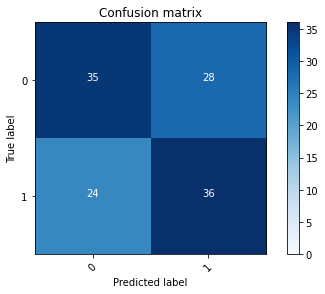

2022-08-22 16:20:40 - [Epoch Train: 67] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:20:40 - [Epoch Valid: 67] loss: 2.5603, auc: 0.5735, acc: 0.5772, time: 6.00 s


 67%|████████████████████████████▏             | 67/100 [34:12<16:59, 30.88s/it]

2022-08-22 16:20:40 - EPOCH: 68
2022-08-22 16:20:42 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:20:44 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:20:46 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:20:48 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:20:50 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:20:52 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:20:54 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:20:56 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:20:58 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:21:00 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:21:02 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:21:04 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:21:05 - Valid Step 5/31, valid_loss: 1.8884
2022-08-22 16:21:06 - Valid Step 10/31, valid_loss: 2.8575
2022-08-22 16:21:07 - Valid Step 15/31, valid_loss: 2.9325
2022-08-22 16:21:08

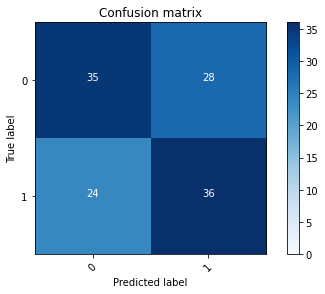

2022-08-22 16:21:11 - [Epoch Train: 68] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:21:11 - [Epoch Valid: 68] loss: 2.5375, auc: 0.5746, acc: 0.5772, time: 6.00 s


 68%|████████████████████████████▌             | 68/100 [34:43<16:30, 30.94s/it]

2022-08-22 16:21:11 - EPOCH: 69
2022-08-22 16:21:13 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:21:15 - Train Step 20/121, train_loss: 0.0002
2022-08-22 16:21:17 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:21:19 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:21:21 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:21:23 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:21:25 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:21:27 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:21:29 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:21:31 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:21:33 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:21:35 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:21:36 - Valid Step 5/31, valid_loss: 2.8752
2022-08-22 16:21:37 - Valid Step 10/31, valid_loss: 2.7987
2022-08-22 16:21:38 - Valid Step 15/31, valid_loss: 2.7790
2022-08-22 16:21:39

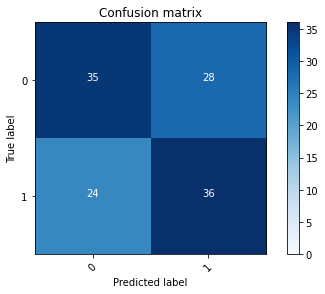

2022-08-22 16:21:41 - [Epoch Train: 69] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:21:41 - [Epoch Valid: 69] loss: 2.4842, auc: 0.5780, acc: 0.5772, time: 6.00 s


 69%|████████████████████████████▉             | 69/100 [35:14<15:55, 30.81s/it]

2022-08-22 16:21:41 - EPOCH: 70
2022-08-22 16:21:43 - Train Step 10/121, train_loss: 0.0001
2022-08-22 16:21:45 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:21:47 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:21:49 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:21:51 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:21:53 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:21:55 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:21:57 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:21:59 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:22:01 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:22:03 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:22:05 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:22:07 - Valid Step 5/31, valid_loss: 1.0083
2022-08-22 16:22:08 - Valid Step 10/31, valid_loss: 2.9378
2022-08-22 16:22:09 - Valid Step 15/31, valid_loss: 2.6511
2022-08-22 16:22:10

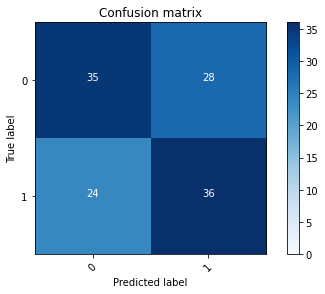

2022-08-22 16:22:12 - [Epoch Train: 70] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:22:12 - [Epoch Valid: 70] loss: 2.4688, auc: 0.5780, acc: 0.5772, time: 6.00 s


 70%|█████████████████████████████▍            | 70/100 [35:45<15:24, 30.82s/it]

2022-08-22 16:22:12 - EPOCH: 71
2022-08-22 16:22:14 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:22:16 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:22:18 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:22:20 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:22:22 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:22:24 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:22:26 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:22:28 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:22:30 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:22:32 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:22:34 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:22:36 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:22:38 - Valid Step 5/31, valid_loss: 1.0779
2022-08-22 16:22:38 - Valid Step 10/31, valid_loss: 1.8857
2022-08-22 16:22:40 - Valid Step 15/31, valid_loss: 1.9792
2022-08-22 16:22:40

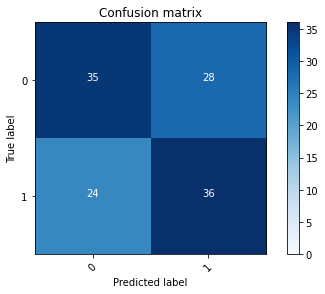

2022-08-22 16:22:43 - [Epoch Train: 71] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:22:43 - [Epoch Valid: 71] loss: 2.4822, auc: 0.5796, acc: 0.5772, time: 6.00 s


 71%|█████████████████████████████▊            | 71/100 [36:15<14:52, 30.79s/it]

2022-08-22 16:22:43 - EPOCH: 72
2022-08-22 16:22:45 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:22:47 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:22:49 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:22:51 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:22:53 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:22:55 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:22:57 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:22:59 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:23:01 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:23:03 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:23:04 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:23:07 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:23:08 - Valid Step 5/31, valid_loss: 1.7407
2022-08-22 16:23:09 - Valid Step 10/31, valid_loss: 2.3215
2022-08-22 16:23:10 - Valid Step 15/31, valid_loss: 3.0204
2022-08-22 16:23:11

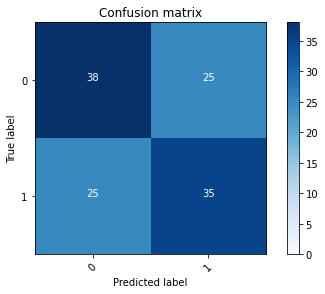

2022-08-22 16:23:13 - [Epoch Train: 72] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:23:13 - [Epoch Valid: 72] loss: 2.7860, auc: 0.5783, acc: 0.5935, time: 6.00 s


 72%|██████████████████████████████▏           | 72/100 [36:46<14:19, 30.71s/it]

2022-08-22 16:23:13 - EPOCH: 73
2022-08-22 16:23:16 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:23:18 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:23:19 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:23:21 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:23:23 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:23:25 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:23:27 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:23:29 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:23:31 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:23:33 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:23:35 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:23:37 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:23:39 - Valid Step 5/31, valid_loss: 4.1707
2022-08-22 16:23:39 - Valid Step 10/31, valid_loss: 3.6191
2022-08-22 16:23:41 - Valid Step 15/31, valid_loss: 3.2238
2022-08-22 16:23:41

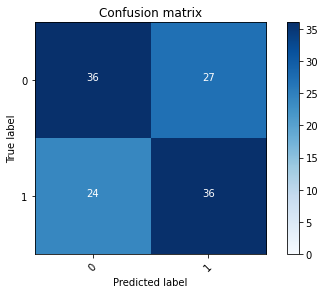

2022-08-22 16:23:44 - [Epoch Train: 73] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:23:44 - [Epoch Valid: 73] loss: 2.5969, auc: 0.5745, acc: 0.5854, time: 6.00 s


 73%|██████████████████████████████▋           | 73/100 [37:16<13:46, 30.61s/it]

2022-08-22 16:23:44 - EPOCH: 74
2022-08-22 16:23:46 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:23:48 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:23:50 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:23:52 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:23:54 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:23:56 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:23:58 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:24:00 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:24:02 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:24:03 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:24:05 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:24:07 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:24:09 - Valid Step 5/31, valid_loss: 2.2876
2022-08-22 16:24:10 - Valid Step 10/31, valid_loss: 2.6382
2022-08-22 16:24:11 - Valid Step 15/31, valid_loss: 2.4151
2022-08-22 16:24:12

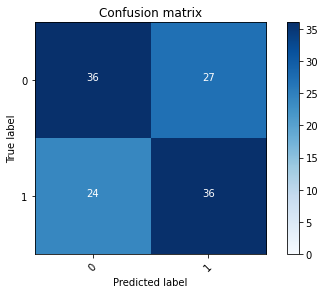

2022-08-22 16:24:14 - [Epoch Train: 74] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:24:14 - [Epoch Valid: 74] loss: 2.5320, auc: 0.5810, acc: 0.5854, time: 6.00 s


 74%|███████████████████████████████           | 74/100 [37:47<13:14, 30.56s/it]

2022-08-22 16:24:14 - EPOCH: 75
2022-08-22 16:24:16 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:24:18 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:24:20 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:24:22 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:24:24 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:24:26 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:24:28 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:24:30 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:24:32 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:24:34 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:24:36 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:24:38 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:24:40 - Valid Step 5/31, valid_loss: 2.3792
2022-08-22 16:24:41 - Valid Step 10/31, valid_loss: 2.1356
2022-08-22 16:24:42 - Valid Step 15/31, valid_loss: 2.1370
2022-08-22 16:24:42

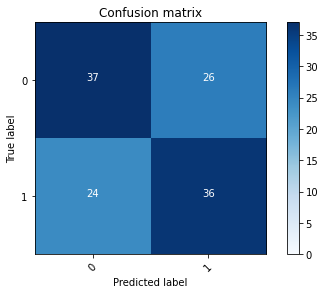

2022-08-22 16:24:45 - [Epoch Train: 75] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:24:45 - [Epoch Valid: 75] loss: 2.5712, auc: 0.5786, acc: 0.5935, time: 6.00 s


 75%|███████████████████████████████▌          | 75/100 [38:17<12:45, 30.62s/it]

2022-08-22 16:24:45 - EPOCH: 76
2022-08-22 16:24:47 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:24:49 - Train Step 20/121, train_loss: 0.0001
2022-08-22 16:24:51 - Train Step 30/121, train_loss: 0.0001
2022-08-22 16:24:53 - Train Step 40/121, train_loss: 0.0001
2022-08-22 16:24:55 - Train Step 50/121, train_loss: 0.0001
2022-08-22 16:24:57 - Train Step 60/121, train_loss: 0.0001
2022-08-22 16:24:59 - Train Step 70/121, train_loss: 0.0001
2022-08-22 16:25:01 - Train Step 80/121, train_loss: 0.0001
2022-08-22 16:25:03 - Train Step 90/121, train_loss: 0.0001
2022-08-22 16:25:05 - Train Step 100/121, train_loss: 0.0001
2022-08-22 16:25:07 - Train Step 110/121, train_loss: 0.0001
2022-08-22 16:25:09 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:25:10 - Valid Step 5/31, valid_loss: 3.9463
2022-08-22 16:25:11 - Valid Step 10/31, valid_loss: 2.7752
2022-08-22 16:25:12 - Valid Step 15/31, valid_loss: 2.8178
2022-08-22 16:25:13

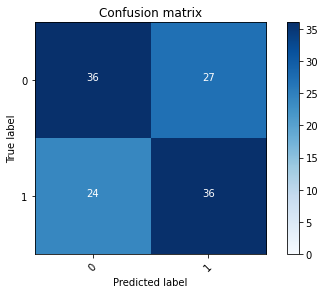

2022-08-22 16:25:15 - [Epoch Train: 76] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:25:15 - [Epoch Valid: 76] loss: 2.5980, auc: 0.5717, acc: 0.5854, time: 6.00 s


 76%|███████████████████████████████▉          | 76/100 [38:48<12:14, 30.60s/it]

2022-08-22 16:25:15 - EPOCH: 77
2022-08-22 16:25:18 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:25:20 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:25:21 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:25:23 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:25:25 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:25:27 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:25:29 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:25:31 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:25:33 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:25:35 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:25:37 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:25:39 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:25:41 - Valid Step 5/31, valid_loss: 2.2428
2022-08-22 16:25:42 - Valid Step 10/31, valid_loss: 2.0754
2022-08-22 16:25:43 - Valid Step 15/31, valid_loss: 2.2914
2022-08-22 16:25:44

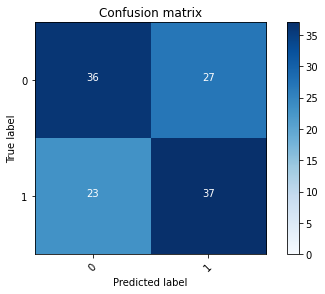

2022-08-22 16:25:46 - [Epoch Train: 77] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:25:46 - [Epoch Valid: 77] loss: 2.5347, auc: 0.5709, acc: 0.5935, time: 6.00 s


 77%|████████████████████████████████▎         | 77/100 [39:19<11:44, 30.62s/it]

2022-08-22 16:25:46 - EPOCH: 78
2022-08-22 16:25:48 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:25:50 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:25:52 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:25:54 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:25:56 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:25:58 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:26:00 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:26:02 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:26:04 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:26:06 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:26:08 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:26:10 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:26:12 - Valid Step 5/31, valid_loss: 0.9582
2022-08-22 16:26:13 - Valid Step 10/31, valid_loss: 2.1102
2022-08-22 16:26:14 - Valid Step 15/31, valid_loss: 1.9521
2022-08-22 16:26:15

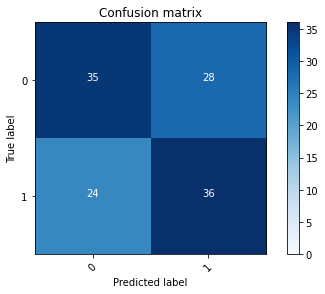

2022-08-22 16:26:17 - [Epoch Train: 78] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:26:17 - [Epoch Valid: 78] loss: 2.5278, auc: 0.5698, acc: 0.5772, time: 6.00 s


 78%|████████████████████████████████▊         | 78/100 [39:49<11:15, 30.69s/it]

2022-08-22 16:26:17 - EPOCH: 79
2022-08-22 16:26:19 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:26:21 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:26:23 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:26:25 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:26:27 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:26:29 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:26:31 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:26:33 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:26:35 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:26:37 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:26:39 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:26:41 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:26:42 - Valid Step 5/31, valid_loss: 2.4502
2022-08-22 16:26:43 - Valid Step 10/31, valid_loss: 2.4337
2022-08-22 16:26:44 - Valid Step 15/31, valid_loss: 3.0215
2022-08-22 16:26:45

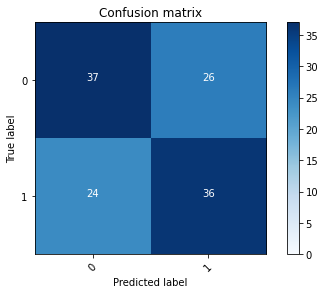

2022-08-22 16:26:47 - [Epoch Train: 79] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:26:47 - [Epoch Valid: 79] loss: 2.6875, auc: 0.5788, acc: 0.5935, time: 6.00 s


 79%|█████████████████████████████████▏        | 79/100 [40:20<10:42, 30.59s/it]

2022-08-22 16:26:47 - EPOCH: 80
2022-08-22 16:26:50 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:26:51 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:26:53 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:26:55 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:26:57 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:26:59 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:27:01 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:27:03 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:27:05 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:27:07 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:27:09 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:27:11 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:27:13 - Valid Step 5/31, valid_loss: 2.7686
2022-08-22 16:27:14 - Valid Step 10/31, valid_loss: 3.9124
2022-08-22 16:27:15 - Valid Step 15/31, valid_loss: 3.3194
2022-08-22 16:27:16

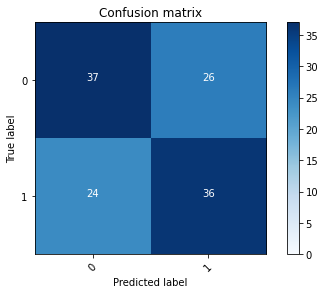

2022-08-22 16:27:18 - [Epoch Train: 80] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:27:18 - [Epoch Valid: 80] loss: 2.6268, auc: 0.5769, acc: 0.5935, time: 6.00 s


 80%|█████████████████████████████████▌        | 80/100 [40:50<10:11, 30.60s/it]

2022-08-22 16:27:18 - EPOCH: 81
2022-08-22 16:27:20 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:27:22 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:27:24 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:27:26 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:27:29 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:27:31 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:27:33 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:27:35 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:27:37 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:27:39 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:27:41 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:27:43 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:27:45 - Valid Step 5/31, valid_loss: 1.9733
2022-08-22 16:27:45 - Valid Step 10/31, valid_loss: 1.9260
2022-08-22 16:27:47 - Valid Step 15/31, valid_loss: 2.7123
2022-08-22 16:27:47

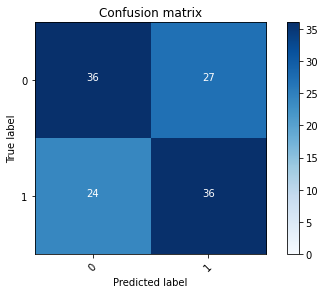

2022-08-22 16:27:50 - [Epoch Train: 81] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 16:27:50 - [Epoch Valid: 81] loss: 2.6620, auc: 0.5788, acc: 0.5854, time: 6.00 s


 81%|██████████████████████████████████        | 81/100 [41:22<09:48, 30.95s/it]

2022-08-22 16:27:50 - EPOCH: 82
2022-08-22 16:27:52 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:27:54 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:27:56 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:27:58 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:28:00 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:28:02 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:28:04 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:28:06 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:28:08 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:28:10 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:28:12 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:28:14 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:28:15 - Valid Step 5/31, valid_loss: 1.5480
2022-08-22 16:28:16 - Valid Step 10/31, valid_loss: 2.4744
2022-08-22 16:28:17 - Valid Step 15/31, valid_loss: 2.9822
2022-08-22 16:28:18

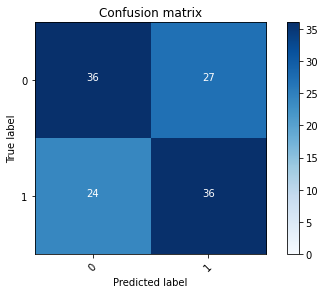

2022-08-22 16:28:21 - [Epoch Train: 82] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:28:21 - [Epoch Valid: 82] loss: 2.7795, auc: 0.5751, acc: 0.5854, time: 6.00 s


 82%|██████████████████████████████████▍       | 82/100 [41:53<09:16, 30.92s/it]

2022-08-22 16:28:21 - EPOCH: 83
2022-08-22 16:28:23 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:28:25 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:28:27 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:28:29 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:28:31 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:28:33 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:28:35 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:28:37 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:28:38 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:28:40 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:28:42 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:28:44 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:28:46 - Valid Step 5/31, valid_loss: 0.8159
2022-08-22 16:28:47 - Valid Step 10/31, valid_loss: 2.9904
2022-08-22 16:28:48 - Valid Step 15/31, valid_loss: 2.9134
2022-08-22 16:28:49

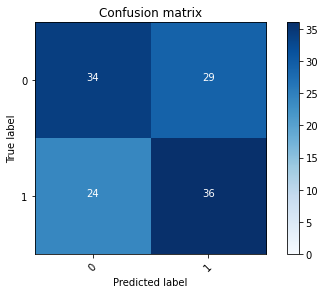

2022-08-22 16:28:51 - [Epoch Train: 83] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:28:51 - [Epoch Valid: 83] loss: 2.7418, auc: 0.5746, acc: 0.5691, time: 6.00 s


 83%|██████████████████████████████████▊       | 83/100 [42:24<08:43, 30.82s/it]

2022-08-22 16:28:51 - EPOCH: 84
2022-08-22 16:28:53 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:28:55 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:28:57 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:28:59 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:29:01 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:29:03 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:29:05 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:29:07 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:29:09 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:29:11 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:29:13 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:29:15 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:29:17 - Valid Step 5/31, valid_loss: 4.3476
2022-08-22 16:29:17 - Valid Step 10/31, valid_loss: 2.9086
2022-08-22 16:29:18 - Valid Step 15/31, valid_loss: 2.9248
2022-08-22 16:29:19

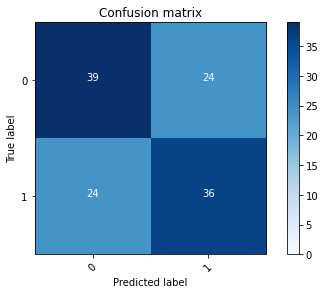

2022-08-22 16:29:22 - [Epoch Train: 84] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:29:22 - [Epoch Valid: 84] loss: 2.7775, auc: 0.5778, acc: 0.6098, time: 6.00 s
2022-08-22 16:29:22 - acc improved from 0.6016 to 0.6098. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e84-loss2.778-acc0.610-auc0.578.pth'


 84%|███████████████████████████████████▎      | 84/100 [42:54<08:12, 30.78s/it]

2022-08-22 16:29:22 - EPOCH: 85
2022-08-22 16:29:24 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:29:26 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:29:28 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:29:30 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:29:32 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:29:34 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:29:36 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:29:38 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:29:40 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:29:42 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:29:44 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:29:46 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:29:48 - Valid Step 5/31, valid_loss: 2.0634
2022-08-22 16:29:48 - Valid Step 10/31, valid_loss: 2.3971
2022-08-22 16:29:49 - Valid Step 15/31, valid_loss: 2.3519
2022-08-22 16:29:50

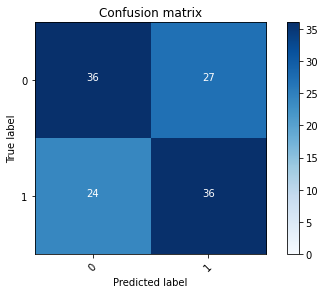

2022-08-22 16:29:53 - [Epoch Train: 85] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:29:53 - [Epoch Valid: 85] loss: 2.7685, auc: 0.5766, acc: 0.5854, time: 6.00 s


 85%|███████████████████████████████████▋      | 85/100 [43:25<07:42, 30.81s/it]

2022-08-22 16:29:53 - EPOCH: 86
2022-08-22 16:29:55 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:29:57 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:29:59 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:30:01 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:30:03 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:30:05 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:30:07 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:30:09 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:30:11 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:30:13 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:30:15 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:30:16 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:30:18 - Valid Step 5/31, valid_loss: 2.8830
2022-08-22 16:30:19 - Valid Step 10/31, valid_loss: 3.6338
2022-08-22 16:30:20 - Valid Step 15/31, valid_loss: 2.8812
2022-08-22 16:30:21

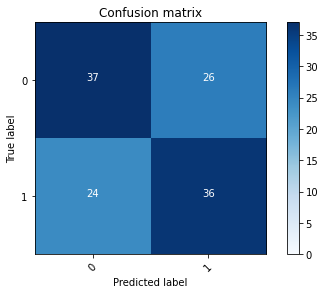

2022-08-22 16:30:23 - [Epoch Train: 86] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:30:23 - [Epoch Valid: 86] loss: 2.7692, auc: 0.5767, acc: 0.5935, time: 6.00 s


 86%|████████████████████████████████████      | 86/100 [43:56<07:09, 30.71s/it]

2022-08-22 16:30:23 - EPOCH: 87
2022-08-22 16:30:25 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:30:27 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:30:29 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:30:31 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:30:33 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:30:35 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:30:37 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:30:39 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:30:41 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:30:43 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:30:45 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:30:47 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:30:49 - Valid Step 5/31, valid_loss: 1.3680
2022-08-22 16:30:50 - Valid Step 10/31, valid_loss: 2.9929
2022-08-22 16:30:51 - Valid Step 15/31, valid_loss: 3.1088
2022-08-22 16:30:52

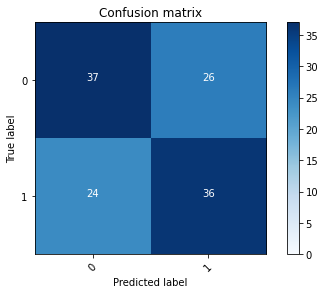

2022-08-22 16:30:54 - [Epoch Train: 87] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:30:54 - [Epoch Valid: 87] loss: 2.7424, auc: 0.5786, acc: 0.5935, time: 6.00 s


 87%|████████████████████████████████████▌     | 87/100 [44:27<06:40, 30.80s/it]

2022-08-22 16:30:54 - EPOCH: 88
2022-08-22 16:30:56 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:30:58 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:31:00 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:31:02 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:31:04 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:31:06 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:31:08 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:31:10 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:31:12 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:31:14 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:31:16 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:31:18 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:31:20 - Valid Step 5/31, valid_loss: 3.2163
2022-08-22 16:31:21 - Valid Step 10/31, valid_loss: 2.9983
2022-08-22 16:31:22 - Valid Step 15/31, valid_loss: 3.2133
2022-08-22 16:31:23

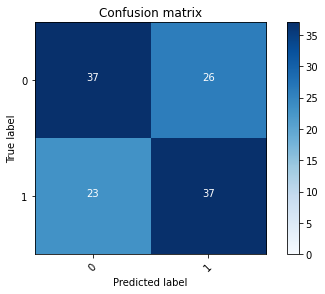

2022-08-22 16:31:25 - [Epoch Train: 88] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:31:25 - [Epoch Valid: 88] loss: 2.7148, auc: 0.5780, acc: 0.6016, time: 6.00 s


 88%|████████████████████████████████████▉     | 88/100 [44:58<06:09, 30.82s/it]

2022-08-22 16:31:25 - EPOCH: 89
2022-08-22 16:31:27 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:31:29 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:31:31 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:31:33 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:31:35 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:31:37 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:31:39 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:31:41 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:31:44 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:31:46 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:31:48 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:31:50 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:31:51 - Valid Step 5/31, valid_loss: 2.3727
2022-08-22 16:31:52 - Valid Step 10/31, valid_loss: 3.3984
2022-08-22 16:31:53 - Valid Step 15/31, valid_loss: 2.8866
2022-08-22 16:31:54

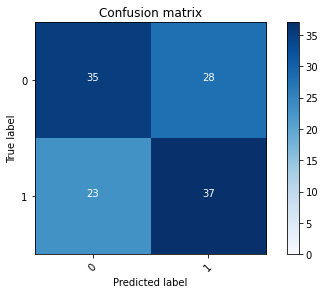

2022-08-22 16:31:57 - [Epoch Train: 89] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 16:31:57 - [Epoch Valid: 89] loss: 2.7664, auc: 0.5767, acc: 0.5854, time: 6.00 s


 89%|█████████████████████████████████████▍    | 89/100 [45:29<05:41, 31.05s/it]

2022-08-22 16:31:57 - EPOCH: 90
2022-08-22 16:31:59 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:32:01 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:32:03 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:32:05 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:32:07 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:32:09 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:32:11 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:32:13 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:32:15 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:32:17 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:32:19 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:32:21 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:32:22 - Valid Step 5/31, valid_loss: 2.9517
2022-08-22 16:32:23 - Valid Step 10/31, valid_loss: 3.3849
2022-08-22 16:32:24 - Valid Step 15/31, valid_loss: 3.9530
2022-08-22 16:32:25

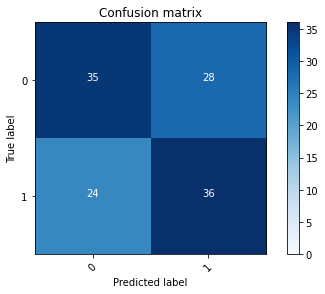

2022-08-22 16:32:28 - [Epoch Train: 90] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:32:28 - [Epoch Valid: 90] loss: 2.8195, auc: 0.5763, acc: 0.5772, time: 6.00 s


 90%|█████████████████████████████████████▊    | 90/100 [46:00<05:10, 31.01s/it]

2022-08-22 16:32:28 - EPOCH: 91
2022-08-22 16:32:30 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:32:32 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:32:34 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:32:36 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:32:38 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:32:40 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:32:42 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:32:44 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:32:46 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:32:48 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:32:50 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:32:52 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:32:53 - Valid Step 5/31, valid_loss: 3.3450
2022-08-22 16:32:54 - Valid Step 10/31, valid_loss: 3.2063
2022-08-22 16:32:55 - Valid Step 15/31, valid_loss: 3.6540
2022-08-22 16:32:56

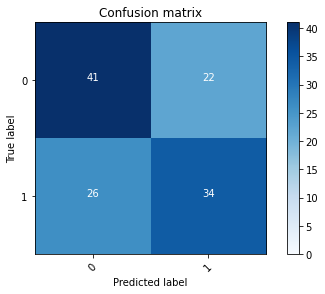

2022-08-22 16:32:58 - [Epoch Train: 91] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:32:58 - [Epoch Valid: 91] loss: 2.8710, auc: 0.5775, acc: 0.6098, time: 6.00 s
2022-08-22 16:32:58 - acc improved from 0.6098 to 0.6098. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e91-loss2.871-acc0.610-auc0.578.pth'


 91%|██████████████████████████████████████▏   | 91/100 [46:31<04:38, 30.97s/it]

2022-08-22 16:32:58 - EPOCH: 92
2022-08-22 16:33:01 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:33:03 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:33:05 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:33:07 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:33:08 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:33:10 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:33:12 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:33:14 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:33:16 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:33:18 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:33:20 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:33:22 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:33:24 - Valid Step 5/31, valid_loss: 2.4345
2022-08-22 16:33:25 - Valid Step 10/31, valid_loss: 2.4210
2022-08-22 16:33:26 - Valid Step 15/31, valid_loss: 2.3028
2022-08-22 16:33:27

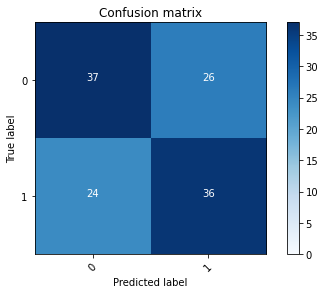

2022-08-22 16:33:29 - [Epoch Train: 92] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:33:29 - [Epoch Valid: 92] loss: 2.8825, auc: 0.5794, acc: 0.5935, time: 6.00 s


 92%|██████████████████████████████████████▋   | 92/100 [47:01<04:06, 30.83s/it]

2022-08-22 16:33:29 - EPOCH: 93
2022-08-22 16:33:31 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:33:33 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:33:35 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:33:37 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:33:39 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:33:41 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:33:43 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:33:45 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:33:47 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:33:49 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:33:51 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:33:53 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:33:55 - Valid Step 5/31, valid_loss: 2.3343
2022-08-22 16:33:55 - Valid Step 10/31, valid_loss: 3.1769
2022-08-22 16:33:56 - Valid Step 15/31, valid_loss: 3.1631
2022-08-22 16:33:57

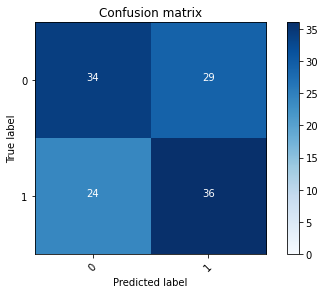

2022-08-22 16:34:00 - [Epoch Train: 93] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:34:00 - [Epoch Valid: 93] loss: 2.7084, auc: 0.5772, acc: 0.5691, time: 6.00 s


 93%|███████████████████████████████████████   | 93/100 [47:32<03:35, 30.81s/it]

2022-08-22 16:34:00 - EPOCH: 94
2022-08-22 16:34:02 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:34:04 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:34:06 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:34:08 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:34:10 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:34:11 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:34:13 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:34:15 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:34:17 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:34:19 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:34:21 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:34:23 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:34:25 - Valid Step 5/31, valid_loss: 3.1979
2022-08-22 16:34:25 - Valid Step 10/31, valid_loss: 2.7839
2022-08-22 16:34:27 - Valid Step 15/31, valid_loss: 3.2483
2022-08-22 16:34:27

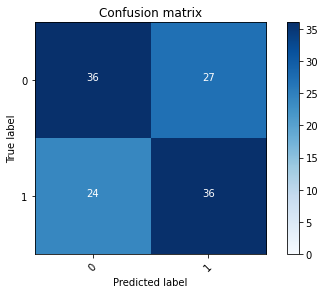

2022-08-22 16:34:30 - [Epoch Train: 94] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:34:30 - [Epoch Valid: 94] loss: 2.7936, auc: 0.5803, acc: 0.5854, time: 6.00 s


 94%|███████████████████████████████████████▍  | 94/100 [48:02<03:03, 30.61s/it]

2022-08-22 16:34:30 - EPOCH: 95
2022-08-22 16:34:32 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:34:34 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:34:36 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:34:38 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:34:40 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:34:43 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:34:45 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:34:47 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:34:49 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:34:51 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:34:53 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:34:55 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:34:56 - Valid Step 5/31, valid_loss: 0.8881
2022-08-22 16:34:57 - Valid Step 10/31, valid_loss: 1.5267
2022-08-22 16:34:58 - Valid Step 15/31, valid_loss: 2.5240
2022-08-22 16:34:59

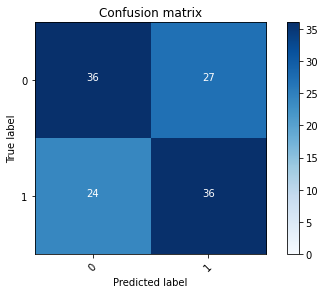

2022-08-22 16:35:01 - [Epoch Train: 95] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 16:35:01 - [Epoch Valid: 95] loss: 2.9120, auc: 0.5820, acc: 0.5854, time: 6.00 s


 95%|███████████████████████████████████████▉  | 95/100 [48:34<02:34, 30.92s/it]

2022-08-22 16:35:01 - EPOCH: 96
2022-08-22 16:35:04 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:35:06 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:35:08 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:35:10 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:35:12 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:35:14 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:35:16 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:35:18 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:35:20 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:35:21 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:35:23 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:35:25 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:35:27 - Valid Step 5/31, valid_loss: 2.4286
2022-08-22 16:35:28 - Valid Step 10/31, valid_loss: 3.0067
2022-08-22 16:35:29 - Valid Step 15/31, valid_loss: 2.5596
2022-08-22 16:35:30

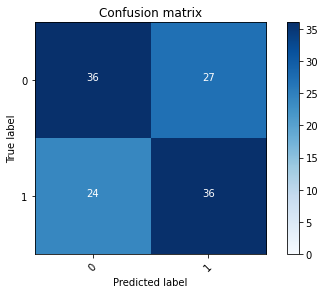

2022-08-22 16:35:32 - [Epoch Train: 96] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:35:32 - [Epoch Valid: 96] loss: 2.8993, auc: 0.5791, acc: 0.5854, time: 6.00 s


 96%|████████████████████████████████████████▎ | 96/100 [49:05<02:03, 30.88s/it]

2022-08-22 16:35:32 - EPOCH: 97
2022-08-22 16:35:35 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:35:36 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:35:38 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:35:40 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:35:42 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:35:44 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:35:46 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:35:48 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:35:51 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:35:53 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:35:55 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:35:57 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:35:58 - Valid Step 5/31, valid_loss: 2.3884
2022-08-22 16:35:59 - Valid Step 10/31, valid_loss: 2.9782
2022-08-22 16:36:00 - Valid Step 15/31, valid_loss: 3.1272
2022-08-22 16:36:01

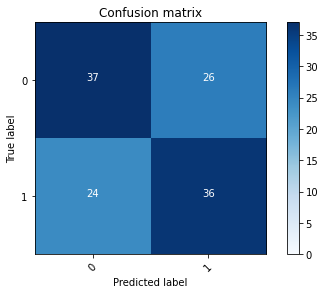

2022-08-22 16:36:03 - [Epoch Train: 97] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:36:03 - [Epoch Valid: 97] loss: 2.9554, auc: 0.5772, acc: 0.5935, time: 6.00 s


 97%|████████████████████████████████████████▋ | 97/100 [49:36<01:32, 30.90s/it]

2022-08-22 16:36:03 - EPOCH: 98
2022-08-22 16:36:05 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:36:07 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:36:09 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:36:11 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:36:13 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:36:15 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:36:17 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:36:19 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:36:21 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:36:23 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:36:25 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:36:27 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:36:29 - Valid Step 5/31, valid_loss: 2.2938
2022-08-22 16:36:30 - Valid Step 10/31, valid_loss: 3.0243
2022-08-22 16:36:31 - Valid Step 15/31, valid_loss: 3.0772
2022-08-22 16:36:32

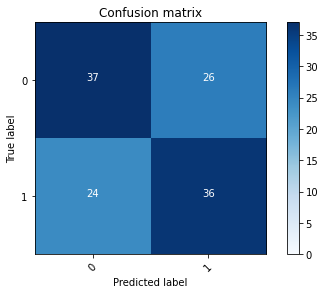

2022-08-22 16:36:34 - [Epoch Train: 98] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:36:34 - [Epoch Valid: 98] loss: 2.8583, auc: 0.5824, acc: 0.5935, time: 6.00 s


 98%|█████████████████████████████████████████▏| 98/100 [50:07<01:01, 30.90s/it]

2022-08-22 16:36:34 - EPOCH: 99
2022-08-22 16:36:36 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:36:38 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:36:40 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:36:42 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:36:44 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:36:46 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:36:48 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:36:50 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:36:52 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:36:54 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:36:56 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:36:58 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:37:00 - Valid Step 5/31, valid_loss: 2.7907
2022-08-22 16:37:00 - Valid Step 10/31, valid_loss: 3.2371
2022-08-22 16:37:01 - Valid Step 15/31, valid_loss: 3.5859
2022-08-22 16:37:02

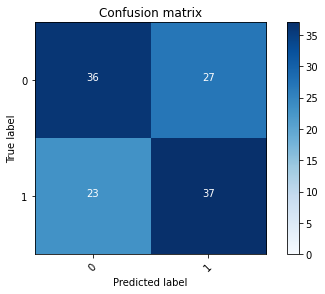

2022-08-22 16:37:05 - [Epoch Train: 99] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:37:05 - [Epoch Valid: 99] loss: 3.0302, auc: 0.5766, acc: 0.5935, time: 6.00 s


 99%|█████████████████████████████████████████▌| 99/100 [50:37<00:30, 30.79s/it]

2022-08-22 16:37:05 - EPOCH: 100
2022-08-22 16:37:07 - Train Step 10/121, train_loss: 0.0000
2022-08-22 16:37:09 - Train Step 20/121, train_loss: 0.0000
2022-08-22 16:37:11 - Train Step 30/121, train_loss: 0.0000
2022-08-22 16:37:13 - Train Step 40/121, train_loss: 0.0000
2022-08-22 16:37:15 - Train Step 50/121, train_loss: 0.0000
2022-08-22 16:37:17 - Train Step 60/121, train_loss: 0.0000
2022-08-22 16:37:19 - Train Step 70/121, train_loss: 0.0000
2022-08-22 16:37:21 - Train Step 80/121, train_loss: 0.0000
2022-08-22 16:37:23 - Train Step 90/121, train_loss: 0.0000
2022-08-22 16:37:24 - Train Step 100/121, train_loss: 0.0000
2022-08-22 16:37:26 - Train Step 110/121, train_loss: 0.0000
2022-08-22 16:37:28 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:37:30 - Valid Step 5/31, valid_loss: 0.8349
2022-08-22 16:37:31 - Valid Step 10/31, valid_loss: 1.7875
2022-08-22 16:37:32 - Valid Step 15/31, valid_loss: 2.5097
2022-08-22 16:37:3

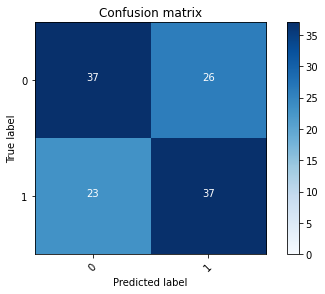

2022-08-22 16:37:35 - [Epoch Train: 100] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:37:35 - [Epoch Valid: 100] loss: 2.9218, auc: 0.5775, acc: 0.6016, time: 6.00 s


100%|█████████████████████████████████████████| 100/100 [51:08<00:00, 30.68s/it]

-- FOLD N:3
Train origin: m
Type: KLF
2022-08-22 16:37:35 - (M0) Train/Val datasets size: 270
2022-08-22 16:37:35 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccc02280>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc8e5f70>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606


[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 68, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 100, 102, 103, 104, 106, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 168, 169, 171, 172, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 187, 189, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 227, 228, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 248, 249, 250, 251, 252, 253, 254, 255, 259, 260, 261, 262, 263, 264, 265, 266, 267, 269, 271, 272, 

  0%|                                                   | 0/100 [00:00<?, ?it/s]

2022-08-22 16:38:47 - EPOCH: 1
2022-08-22 16:38:49 - Train Step 10/121, train_loss: 0.7153
2022-08-22 16:38:51 - Train Step 20/121, train_loss: 0.7064
2022-08-22 16:38:53 - Train Step 30/121, train_loss: 0.6987
2022-08-22 16:38:55 - Train Step 40/121, train_loss: 0.7009
2022-08-22 16:38:57 - Train Step 50/121, train_loss: 0.6934
2022-08-22 16:38:59 - Train Step 60/121, train_loss: 0.6936
2022-08-22 16:39:01 - Train Step 70/121, train_loss: 0.6954
2022-08-22 16:39:03 - Train Step 80/121, train_loss: 0.6944
2022-08-22 16:39:05 - Train Step 90/121, train_loss: 0.6955
2022-08-22 16:39:07 - Train Step 100/121, train_loss: 0.6925
2022-08-22 16:39:09 - Train Step 110/121, train_loss: 0.6943
2022-08-22 16:39:10 - Train Step 120/121, train_loss: 0.6949
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:39:12 - Valid Step 5/32, valid_loss: 0.6774
2022-08-22 16:39:13 - Valid Step 10/32, valid_loss: 0.6883
2022-08-22 16:39:14 - Valid Step 15/32, valid_loss: 0.7190
2022-08-22 16:39:15 

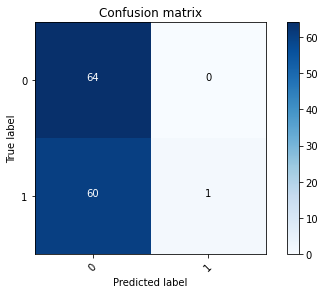

2022-08-22 16:39:17 - [Epoch Train: 1] loss: 0.6946, auc: 0.5363, acc: 0.5198, time: 23.00 s            
2022-08-22 16:39:17 - [Epoch Valid: 1] loss: 0.6959, auc: 0.5476, acc: 0.5200, time: 6.00 s
2022-08-22 16:39:17 - acc improved from 0.0000 to 0.5200. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_16-38-47/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.696-acc0.520-auc0.548.pth'


  1%|▍                                          | 1/100 [00:30<50:12, 30.43s/it]

2022-08-22 16:39:17 - EPOCH: 2
2022-08-22 16:39:19 - Train Step 10/121, train_loss: 0.6673
2022-08-22 16:39:21 - Train Step 20/121, train_loss: 0.6663
2022-08-22 16:39:23 - Train Step 30/121, train_loss: 0.6603
2022-08-22 16:39:25 - Train Step 40/121, train_loss: 0.6618
2022-08-22 16:39:27 - Train Step 50/121, train_loss: 0.6533
2022-08-22 16:39:29 - Train Step 60/121, train_loss: 0.6550
2022-08-22 16:39:31 - Train Step 70/121, train_loss: 0.6600
2022-08-22 16:39:33 - Train Step 80/121, train_loss: 0.6573
2022-08-22 16:39:35 - Train Step 90/121, train_loss: 0.6558
2022-08-22 16:39:37 - Train Step 100/121, train_loss: 0.6591
2022-08-22 16:39:39 - Train Step 110/121, train_loss: 0.6581
2022-08-22 16:39:41 - Train Step 120/121, train_loss: 0.6590
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:39:42 - Valid Step 5/32, valid_loss: 0.6790
2022-08-22 16:39:43 - Valid Step 10/32, valid_loss: 0.6859
2022-08-22 16:39:44 - Valid Step 15/32, valid_loss: 0.6923
2022-08-22 16:39:45 

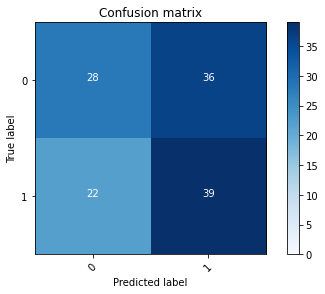

2022-08-22 16:39:48 - [Epoch Train: 2] loss: 0.6595, auc: 0.6683, acc: 0.6050, time: 23.00 s            
2022-08-22 16:39:48 - [Epoch Valid: 2] loss: 0.6918, auc: 0.5461, acc: 0.5360, time: 6.00 s
2022-08-22 16:39:48 - acc improved from 0.5200 to 0.5360. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_16-38-47/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.692-acc0.536-auc0.546.pth'


  2%|▊                                          | 2/100 [01:00<49:38, 30.40s/it]

2022-08-22 16:39:48 - EPOCH: 3
2022-08-22 16:39:50 - Train Step 10/121, train_loss: 0.5838
2022-08-22 16:39:52 - Train Step 20/121, train_loss: 0.6163
2022-08-22 16:39:54 - Train Step 30/121, train_loss: 0.6026
2022-08-22 16:39:56 - Train Step 40/121, train_loss: 0.6082
2022-08-22 16:39:58 - Train Step 50/121, train_loss: 0.6122
2022-08-22 16:40:00 - Train Step 60/121, train_loss: 0.6059
2022-08-22 16:40:02 - Train Step 70/121, train_loss: 0.6051
2022-08-22 16:40:04 - Train Step 80/121, train_loss: 0.6077
2022-08-22 16:40:06 - Train Step 90/121, train_loss: 0.6024
2022-08-22 16:40:07 - Train Step 100/121, train_loss: 0.6032
2022-08-22 16:40:09 - Train Step 110/121, train_loss: 0.6041
2022-08-22 16:40:11 - Train Step 120/121, train_loss: 0.6049
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:40:13 - Valid Step 5/32, valid_loss: 0.7309
2022-08-22 16:40:14 - Valid Step 10/32, valid_loss: 0.7011
2022-08-22 16:40:15 - Valid Step 15/32, valid_loss: 0.7011
2022-08-22 16:40:16 

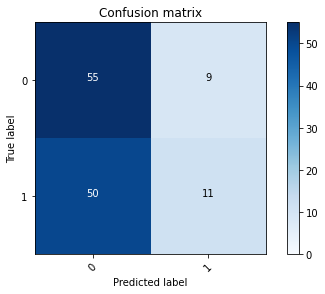

2022-08-22 16:40:18 - [Epoch Train: 3] loss: 0.6047, auc: 0.7935, acc: 0.7131, time: 24.00 s            
2022-08-22 16:40:18 - [Epoch Valid: 3] loss: 0.7064, auc: 0.5161, acc: 0.5280, time: 6.00 s


  3%|█▎                                         | 3/100 [01:31<49:19, 30.51s/it]

2022-08-22 16:40:18 - EPOCH: 4
2022-08-22 16:40:20 - Train Step 10/121, train_loss: 0.5342
2022-08-22 16:40:22 - Train Step 20/121, train_loss: 0.5377
2022-08-22 16:40:24 - Train Step 30/121, train_loss: 0.5256
2022-08-22 16:40:26 - Train Step 40/121, train_loss: 0.5217
2022-08-22 16:40:28 - Train Step 50/121, train_loss: 0.5220
2022-08-22 16:40:30 - Train Step 60/121, train_loss: 0.5291
2022-08-22 16:40:32 - Train Step 70/121, train_loss: 0.5271
2022-08-22 16:40:34 - Train Step 80/121, train_loss: 0.5265
2022-08-22 16:40:36 - Train Step 90/121, train_loss: 0.5308
2022-08-22 16:40:38 - Train Step 100/121, train_loss: 0.5276
2022-08-22 16:40:40 - Train Step 110/121, train_loss: 0.5251
2022-08-22 16:40:42 - Train Step 120/121, train_loss: 0.5213
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:40:43 - Valid Step 5/32, valid_loss: 0.7281
2022-08-22 16:40:44 - Valid Step 10/32, valid_loss: 0.7278
2022-08-22 16:40:45 - Valid Step 15/32, valid_loss: 0.7376
2022-08-22 16:40:46 

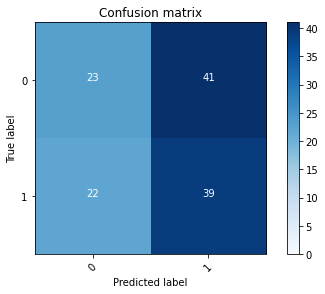

2022-08-22 16:40:49 - [Epoch Train: 4] loss: 0.5217, auc: 0.8714, acc: 0.7817, time: 23.00 s            
2022-08-22 16:40:49 - [Epoch Valid: 4] loss: 0.7641, auc: 0.4887, acc: 0.4960, time: 6.00 s


  4%|█▋                                         | 4/100 [02:01<48:46, 30.48s/it]

2022-08-22 16:40:49 - EPOCH: 5
2022-08-22 16:40:51 - Train Step 10/121, train_loss: 0.3810
2022-08-22 16:40:53 - Train Step 20/121, train_loss: 0.3942
2022-08-22 16:40:55 - Train Step 30/121, train_loss: 0.3954
2022-08-22 16:40:57 - Train Step 40/121, train_loss: 0.3938
2022-08-22 16:40:59 - Train Step 50/121, train_loss: 0.3955
2022-08-22 16:41:01 - Train Step 60/121, train_loss: 0.3928
2022-08-22 16:41:03 - Train Step 70/121, train_loss: 0.3996
2022-08-22 16:41:05 - Train Step 80/121, train_loss: 0.4021
2022-08-22 16:41:07 - Train Step 90/121, train_loss: 0.4063
2022-08-22 16:41:09 - Train Step 100/121, train_loss: 0.4030
2022-08-22 16:41:11 - Train Step 110/121, train_loss: 0.4036
2022-08-22 16:41:13 - Train Step 120/121, train_loss: 0.4042
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:41:14 - Valid Step 5/32, valid_loss: 0.8326
2022-08-22 16:41:15 - Valid Step 10/32, valid_loss: 0.8264
2022-08-22 16:41:16 - Valid Step 15/32, valid_loss: 0.8933
2022-08-22 16:41:17 

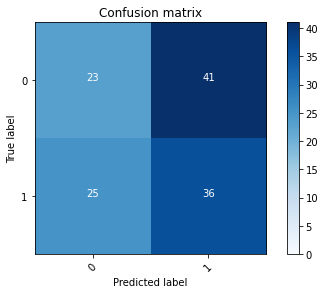

2022-08-22 16:41:19 - [Epoch Train: 5] loss: 0.4044, auc: 0.9401, acc: 0.8607, time: 24.00 s            
2022-08-22 16:41:19 - [Epoch Valid: 5] loss: 0.7970, auc: 0.4780, acc: 0.4720, time: 6.00 s


  5%|██▏                                        | 5/100 [02:32<48:24, 30.57s/it]

2022-08-22 16:41:19 - EPOCH: 6
2022-08-22 16:41:22 - Train Step 10/121, train_loss: 0.3292
2022-08-22 16:41:24 - Train Step 20/121, train_loss: 0.2912
2022-08-22 16:41:26 - Train Step 30/121, train_loss: 0.3150
2022-08-22 16:41:28 - Train Step 40/121, train_loss: 0.3065
2022-08-22 16:41:30 - Train Step 50/121, train_loss: 0.3005
2022-08-22 16:41:32 - Train Step 60/121, train_loss: 0.3034
2022-08-22 16:41:34 - Train Step 70/121, train_loss: 0.2920
2022-08-22 16:41:36 - Train Step 80/121, train_loss: 0.2871
2022-08-22 16:41:38 - Train Step 90/121, train_loss: 0.2838
2022-08-22 16:41:40 - Train Step 100/121, train_loss: 0.2821
2022-08-22 16:41:42 - Train Step 110/121, train_loss: 0.2861
2022-08-22 16:41:44 - Train Step 120/121, train_loss: 0.2847
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:41:45 - Valid Step 5/32, valid_loss: 0.9133
2022-08-22 16:41:46 - Valid Step 10/32, valid_loss: 0.8190
2022-08-22 16:41:47 - Valid Step 15/32, valid_loss: 0.8254
2022-08-22 16:41:48 

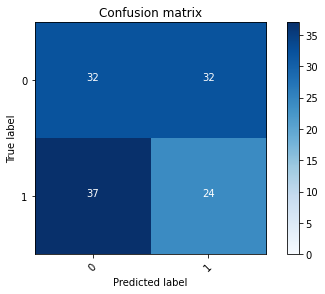

2022-08-22 16:41:51 - [Epoch Train: 6] loss: 0.2846, auc: 0.9847, acc: 0.9335, time: 24.00 s            
2022-08-22 16:41:51 - [Epoch Valid: 6] loss: 0.8719, auc: 0.4721, acc: 0.4480, time: 6.00 s


  6%|██▌                                        | 6/100 [03:03<48:14, 30.79s/it]

2022-08-22 16:41:51 - EPOCH: 7
2022-08-22 16:41:53 - Train Step 10/121, train_loss: 0.2093
2022-08-22 16:41:55 - Train Step 20/121, train_loss: 0.1946
2022-08-22 16:41:57 - Train Step 30/121, train_loss: 0.1907
2022-08-22 16:41:59 - Train Step 40/121, train_loss: 0.1918
2022-08-22 16:42:01 - Train Step 50/121, train_loss: 0.1853
2022-08-22 16:42:03 - Train Step 60/121, train_loss: 0.1923
2022-08-22 16:42:05 - Train Step 70/121, train_loss: 0.1884
2022-08-22 16:42:07 - Train Step 80/121, train_loss: 0.1899
2022-08-22 16:42:08 - Train Step 90/121, train_loss: 0.1933
2022-08-22 16:42:10 - Train Step 100/121, train_loss: 0.1900
2022-08-22 16:42:12 - Train Step 110/121, train_loss: 0.1924
2022-08-22 16:42:14 - Train Step 120/121, train_loss: 0.1905
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:42:16 - Valid Step 5/32, valid_loss: 0.7919
2022-08-22 16:42:16 - Valid Step 10/32, valid_loss: 0.9760
2022-08-22 16:42:18 - Valid Step 15/32, valid_loss: 1.0568
2022-08-22 16:42:18 

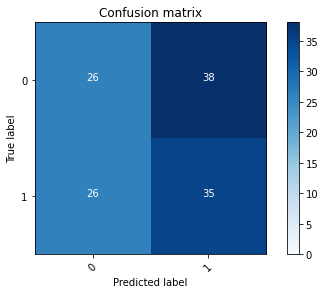

2022-08-22 16:42:21 - [Epoch Train: 7] loss: 0.1904, auc: 0.9936, acc: 0.9647, time: 23.00 s            
2022-08-22 16:42:21 - [Epoch Valid: 7] loss: 1.0280, auc: 0.4419, acc: 0.4880, time: 6.00 s


  7%|███                                        | 7/100 [03:34<47:30, 30.65s/it]

2022-08-22 16:42:21 - EPOCH: 8
2022-08-22 16:42:23 - Train Step 10/121, train_loss: 0.1785
2022-08-22 16:42:25 - Train Step 20/121, train_loss: 0.1318
2022-08-22 16:42:27 - Train Step 30/121, train_loss: 0.1318
2022-08-22 16:42:29 - Train Step 40/121, train_loss: 0.1231
2022-08-22 16:42:31 - Train Step 50/121, train_loss: 0.1224
2022-08-22 16:42:33 - Train Step 60/121, train_loss: 0.1219
2022-08-22 16:42:35 - Train Step 70/121, train_loss: 0.1260
2022-08-22 16:42:37 - Train Step 80/121, train_loss: 0.1241
2022-08-22 16:42:39 - Train Step 90/121, train_loss: 0.1223
2022-08-22 16:42:41 - Train Step 100/121, train_loss: 0.1219
2022-08-22 16:42:43 - Train Step 110/121, train_loss: 0.1180
2022-08-22 16:42:45 - Train Step 120/121, train_loss: 0.1198
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:42:46 - Valid Step 5/32, valid_loss: 0.9150
2022-08-22 16:42:47 - Valid Step 10/32, valid_loss: 1.1077
2022-08-22 16:42:48 - Valid Step 15/32, valid_loss: 1.1124
2022-08-22 16:42:49 

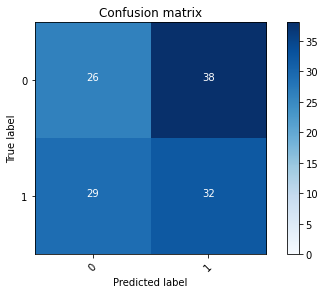

2022-08-22 16:42:52 - [Epoch Train: 8] loss: 0.1197, auc: 0.9990, acc: 0.9854, time: 24.00 s            
2022-08-22 16:42:52 - [Epoch Valid: 8] loss: 1.0647, auc: 0.4690, acc: 0.4640, time: 6.00 s


  8%|███▍                                       | 8/100 [04:05<47:04, 30.70s/it]

2022-08-22 16:42:52 - EPOCH: 9
2022-08-22 16:42:54 - Train Step 10/121, train_loss: 0.0722
2022-08-22 16:42:56 - Train Step 20/121, train_loss: 0.0830
2022-08-22 16:42:58 - Train Step 30/121, train_loss: 0.0743
2022-08-22 16:43:00 - Train Step 40/121, train_loss: 0.0757
2022-08-22 16:43:02 - Train Step 50/121, train_loss: 0.0748
2022-08-22 16:43:04 - Train Step 60/121, train_loss: 0.0731
2022-08-22 16:43:06 - Train Step 70/121, train_loss: 0.0718
2022-08-22 16:43:08 - Train Step 80/121, train_loss: 0.0711
2022-08-22 16:43:10 - Train Step 90/121, train_loss: 0.0707
2022-08-22 16:43:12 - Train Step 100/121, train_loss: 0.0703
2022-08-22 16:43:14 - Train Step 110/121, train_loss: 0.0720
2022-08-22 16:43:16 - Train Step 120/121, train_loss: 0.0706
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 16:43:17 - Valid Step 5/32, valid_loss: 1.1823
2022-08-22 16:43:18 - Valid Step 10/32, valid_loss: 1.1593
2022-08-22 16:43:19 - Valid Step 15/32, valid_loss: 1.2054
2022-08-22 16:43:20 

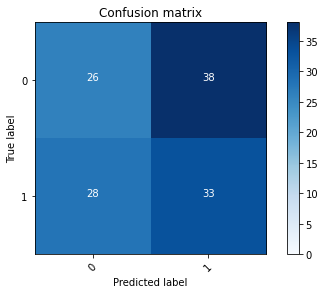

2022-08-22 16:43:23 - [Epoch Train: 9] loss: 0.0705, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 16:43:23 - [Epoch Valid: 9] loss: 1.2050, auc: 0.4513, acc: 0.4720, time: 6.00 s


  9%|███▊                                       | 9/100 [04:35<46:39, 30.77s/it]

2022-08-22 16:43:23 - EPOCH: 10
2022-08-22 16:43:25 - Train Step 10/121, train_loss: 0.0560
2022-08-22 16:43:27 - Train Step 20/121, train_loss: 0.0490
2022-08-22 16:43:29 - Train Step 30/121, train_loss: 0.0493
2022-08-22 16:43:31 - Train Step 40/121, train_loss: 0.0478
2022-08-22 16:43:33 - Train Step 50/121, train_loss: 0.0477
2022-08-22 16:43:35 - Train Step 60/121, train_loss: 0.0479
2022-08-22 16:43:37 - Train Step 70/121, train_loss: 0.0458
2022-08-22 16:43:39 - Train Step 80/121, train_loss: 0.0464
2022-08-22 16:43:41 - Train Step 90/121, train_loss: 0.0464
2022-08-22 16:43:43 - Train Step 100/121, train_loss: 0.0470
2022-08-22 16:43:44 - Train Step 110/121, train_loss: 0.0473
2022-08-22 16:43:46 - Train Step 120/121, train_loss: 0.0453
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:43:48 - Valid Step 5/32, valid_loss: 1.1298
2022-08-22 16:43:49 - Valid Step 10/32, valid_loss: 0.9812
2022-08-22 16:43:50 - Valid Step 15/32, valid_loss: 1.1323
2022-08-22 16:43:51

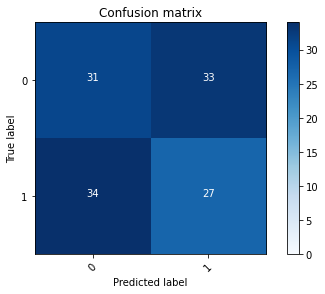

2022-08-22 16:43:53 - [Epoch Train: 10] loss: 0.0453, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:43:53 - [Epoch Valid: 10] loss: 1.1935, auc: 0.4424, acc: 0.4640, time: 6.00 s


 10%|████▏                                     | 10/100 [05:06<46:04, 30.72s/it]

2022-08-22 16:43:53 - EPOCH: 11
2022-08-22 16:43:56 - Train Step 10/121, train_loss: 0.0443
2022-08-22 16:43:58 - Train Step 20/121, train_loss: 0.0317
2022-08-22 16:43:59 - Train Step 30/121, train_loss: 0.0303
2022-08-22 16:44:01 - Train Step 40/121, train_loss: 0.0296
2022-08-22 16:44:03 - Train Step 50/121, train_loss: 0.0278
2022-08-22 16:44:05 - Train Step 60/121, train_loss: 0.0273
2022-08-22 16:44:07 - Train Step 70/121, train_loss: 0.0275
2022-08-22 16:44:09 - Train Step 80/121, train_loss: 0.0277
2022-08-22 16:44:11 - Train Step 90/121, train_loss: 0.0283
2022-08-22 16:44:13 - Train Step 100/121, train_loss: 0.0283
2022-08-22 16:44:15 - Train Step 110/121, train_loss: 0.0284
2022-08-22 16:44:17 - Train Step 120/121, train_loss: 0.0281
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:44:19 - Valid Step 5/32, valid_loss: 1.0183
2022-08-22 16:44:20 - Valid Step 10/32, valid_loss: 1.1334
2022-08-22 16:44:21 - Valid Step 15/32, valid_loss: 1.2738
2022-08-22 16:44:21

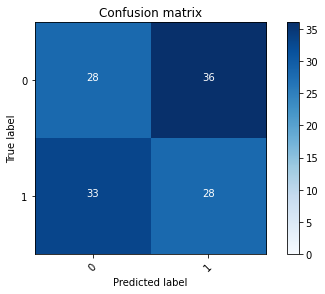

2022-08-22 16:44:24 - [Epoch Train: 11] loss: 0.0280, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:44:24 - [Epoch Valid: 11] loss: 1.3001, auc: 0.4442, acc: 0.4480, time: 6.00 s


 11%|████▌                                     | 11/100 [05:37<45:30, 30.68s/it]

2022-08-22 16:44:24 - EPOCH: 12
2022-08-22 16:44:26 - Train Step 10/121, train_loss: 0.0183
2022-08-22 16:44:28 - Train Step 20/121, train_loss: 0.0267
2022-08-22 16:44:30 - Train Step 30/121, train_loss: 0.0284
2022-08-22 16:44:32 - Train Step 40/121, train_loss: 0.0258
2022-08-22 16:44:34 - Train Step 50/121, train_loss: 0.0263
2022-08-22 16:44:36 - Train Step 60/121, train_loss: 0.0285
2022-08-22 16:44:38 - Train Step 70/121, train_loss: 0.0288
2022-08-22 16:44:40 - Train Step 80/121, train_loss: 0.0276
2022-08-22 16:44:42 - Train Step 90/121, train_loss: 0.0272
2022-08-22 16:44:44 - Train Step 100/121, train_loss: 0.0266
2022-08-22 16:44:46 - Train Step 110/121, train_loss: 0.0261
2022-08-22 16:44:48 - Train Step 120/121, train_loss: 0.0261
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:44:49 - Valid Step 5/32, valid_loss: 1.4970
2022-08-22 16:44:50 - Valid Step 10/32, valid_loss: 1.3437
2022-08-22 16:44:51 - Valid Step 15/32, valid_loss: 1.2338
2022-08-22 16:44:52

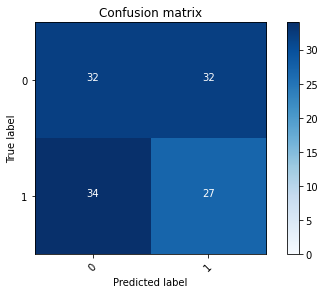

2022-08-22 16:44:55 - [Epoch Train: 12] loss: 0.0261, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:44:55 - [Epoch Valid: 12] loss: 1.3408, auc: 0.4454, acc: 0.4720, time: 6.00 s


 12%|█████                                     | 12/100 [06:07<44:59, 30.68s/it]

2022-08-22 16:44:55 - EPOCH: 13
2022-08-22 16:44:57 - Train Step 10/121, train_loss: 0.0220
2022-08-22 16:44:59 - Train Step 20/121, train_loss: 0.0281
2022-08-22 16:45:01 - Train Step 30/121, train_loss: 0.0258
2022-08-22 16:45:03 - Train Step 40/121, train_loss: 0.0242
2022-08-22 16:45:05 - Train Step 50/121, train_loss: 0.0237
2022-08-22 16:45:07 - Train Step 60/121, train_loss: 0.0223
2022-08-22 16:45:09 - Train Step 70/121, train_loss: 0.0214
2022-08-22 16:45:11 - Train Step 80/121, train_loss: 0.0216
2022-08-22 16:45:13 - Train Step 90/121, train_loss: 0.0215
2022-08-22 16:45:14 - Train Step 100/121, train_loss: 0.0207
2022-08-22 16:45:16 - Train Step 110/121, train_loss: 0.0198
2022-08-22 16:45:18 - Train Step 120/121, train_loss: 0.0194
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:45:20 - Valid Step 5/32, valid_loss: 1.7000
2022-08-22 16:45:21 - Valid Step 10/32, valid_loss: 1.3328
2022-08-22 16:45:22 - Valid Step 15/32, valid_loss: 1.3583
2022-08-22 16:45:23

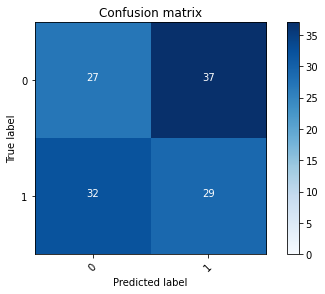

2022-08-22 16:45:25 - [Epoch Train: 13] loss: 0.0195, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:45:25 - [Epoch Valid: 13] loss: 1.4458, auc: 0.4452, acc: 0.4480, time: 6.00 s


 13%|█████▍                                    | 13/100 [06:38<44:24, 30.63s/it]

2022-08-22 16:45:25 - EPOCH: 14
2022-08-22 16:45:27 - Train Step 10/121, train_loss: 0.0120
2022-08-22 16:45:29 - Train Step 20/121, train_loss: 0.0148
2022-08-22 16:45:31 - Train Step 30/121, train_loss: 0.0159
2022-08-22 16:45:33 - Train Step 40/121, train_loss: 0.0151
2022-08-22 16:45:35 - Train Step 50/121, train_loss: 0.0150
2022-08-22 16:45:37 - Train Step 60/121, train_loss: 0.0165
2022-08-22 16:45:39 - Train Step 70/121, train_loss: 0.0164
2022-08-22 16:45:41 - Train Step 80/121, train_loss: 0.0160
2022-08-22 16:45:43 - Train Step 90/121, train_loss: 0.0165
2022-08-22 16:45:45 - Train Step 100/121, train_loss: 0.0161
2022-08-22 16:45:48 - Train Step 110/121, train_loss: 0.0167
2022-08-22 16:45:50 - Train Step 120/121, train_loss: 0.0166
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:45:51 - Valid Step 5/32, valid_loss: 1.4907
2022-08-22 16:45:52 - Valid Step 10/32, valid_loss: 1.6374
2022-08-22 16:45:53 - Valid Step 15/32, valid_loss: 1.6205
2022-08-22 16:45:54

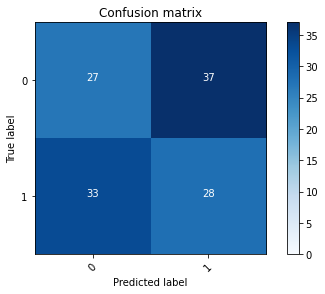

2022-08-22 16:45:56 - [Epoch Train: 14] loss: 0.0166, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:45:56 - [Epoch Valid: 14] loss: 1.4489, auc: 0.4454, acc: 0.4400, time: 6.00 s


 14%|█████▉                                    | 14/100 [07:09<44:12, 30.84s/it]

2022-08-22 16:45:56 - EPOCH: 15
2022-08-22 16:45:59 - Train Step 10/121, train_loss: 0.0225
2022-08-22 16:46:01 - Train Step 20/121, train_loss: 0.0169
2022-08-22 16:46:04 - Train Step 30/121, train_loss: 0.0153
2022-08-22 16:46:06 - Train Step 40/121, train_loss: 0.0183
2022-08-22 16:46:08 - Train Step 50/121, train_loss: 0.0185
2022-08-22 16:46:11 - Train Step 60/121, train_loss: 0.0170
2022-08-22 16:46:13 - Train Step 70/121, train_loss: 0.0163
2022-08-22 16:46:15 - Train Step 80/121, train_loss: 0.0158
2022-08-22 16:46:17 - Train Step 90/121, train_loss: 0.0160
2022-08-22 16:46:19 - Train Step 100/121, train_loss: 0.0156
2022-08-22 16:46:21 - Train Step 110/121, train_loss: 0.0153
2022-08-22 16:46:23 - Train Step 120/121, train_loss: 0.0158
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:46:24 - Valid Step 5/32, valid_loss: 1.7160
2022-08-22 16:46:25 - Valid Step 10/32, valid_loss: 1.5316
2022-08-22 16:46:26 - Valid Step 15/32, valid_loss: 1.5174
2022-08-22 16:46:27

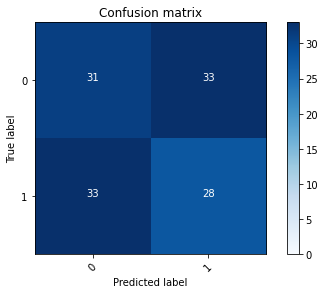

2022-08-22 16:46:29 - [Epoch Train: 15] loss: 0.0158, auc: 1.0000, acc: 1.0000, time: 26.00 s            
2022-08-22 16:46:29 - [Epoch Valid: 15] loss: 1.5572, auc: 0.4355, acc: 0.4720, time: 6.00 s


 15%|██████▎                                   | 15/100 [07:42<44:31, 31.43s/it]

2022-08-22 16:46:29 - EPOCH: 16
2022-08-22 16:46:31 - Train Step 10/121, train_loss: 0.0071
2022-08-22 16:46:33 - Train Step 20/121, train_loss: 0.0078
2022-08-22 16:46:35 - Train Step 30/121, train_loss: 0.0087
2022-08-22 16:46:37 - Train Step 40/121, train_loss: 0.0118
2022-08-22 16:46:39 - Train Step 50/121, train_loss: 0.0108
2022-08-22 16:46:41 - Train Step 60/121, train_loss: 0.0109
2022-08-22 16:46:43 - Train Step 70/121, train_loss: 0.0108
2022-08-22 16:46:45 - Train Step 80/121, train_loss: 0.0111
2022-08-22 16:46:47 - Train Step 90/121, train_loss: 0.0112
2022-08-22 16:46:49 - Train Step 100/121, train_loss: 0.0111
2022-08-22 16:46:51 - Train Step 110/121, train_loss: 0.0116
2022-08-22 16:46:53 - Train Step 120/121, train_loss: 0.0116
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:46:54 - Valid Step 5/32, valid_loss: 1.0739
2022-08-22 16:46:55 - Valid Step 10/32, valid_loss: 1.1590
2022-08-22 16:46:56 - Valid Step 15/32, valid_loss: 1.4046
2022-08-22 16:46:57

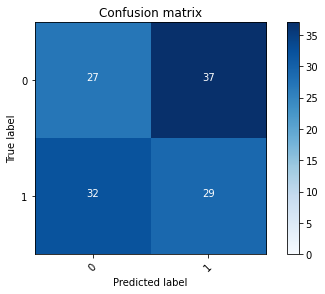

2022-08-22 16:46:59 - [Epoch Train: 16] loss: 0.0116, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:46:59 - [Epoch Valid: 16] loss: 1.5817, auc: 0.4339, acc: 0.4480, time: 6.00 s


 16%|██████▋                                   | 16/100 [08:12<43:25, 31.02s/it]

2022-08-22 16:46:59 - EPOCH: 17
2022-08-22 16:47:01 - Train Step 10/121, train_loss: 0.0109
2022-08-22 16:47:03 - Train Step 20/121, train_loss: 0.0101
2022-08-22 16:47:05 - Train Step 30/121, train_loss: 0.0099
2022-08-22 16:47:08 - Train Step 40/121, train_loss: 0.0100
2022-08-22 16:47:10 - Train Step 50/121, train_loss: 0.0120
2022-08-22 16:47:12 - Train Step 60/121, train_loss: 0.0113
2022-08-22 16:47:14 - Train Step 70/121, train_loss: 0.0110
2022-08-22 16:47:16 - Train Step 80/121, train_loss: 0.0113
2022-08-22 16:47:18 - Train Step 90/121, train_loss: 0.0112
2022-08-22 16:47:21 - Train Step 100/121, train_loss: 0.0109
2022-08-22 16:47:23 - Train Step 110/121, train_loss: 0.0116
2022-08-22 16:47:25 - Train Step 120/121, train_loss: 0.0112
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:47:26 - Valid Step 5/32, valid_loss: 1.3975
2022-08-22 16:47:27 - Valid Step 10/32, valid_loss: 2.1374
2022-08-22 16:47:29 - Valid Step 15/32, valid_loss: 2.0939
2022-08-22 16:47:30

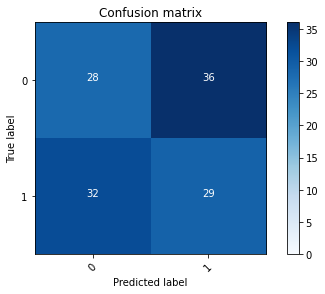

2022-08-22 16:47:33 - [Epoch Train: 17] loss: 0.0112, auc: 1.0000, acc: 1.0000, time: 25.00 s            
2022-08-22 16:47:33 - [Epoch Valid: 17] loss: 1.7928, auc: 0.4316, acc: 0.4560, time: 7.00 s


 17%|███████▏                                  | 17/100 [08:45<43:52, 31.72s/it]

2022-08-22 16:47:33 - EPOCH: 18
2022-08-22 16:47:35 - Train Step 10/121, train_loss: 0.0089
2022-08-22 16:47:37 - Train Step 20/121, train_loss: 0.0109
2022-08-22 16:47:39 - Train Step 30/121, train_loss: 0.0109
2022-08-22 16:47:41 - Train Step 40/121, train_loss: 0.0096
2022-08-22 16:47:43 - Train Step 50/121, train_loss: 0.0096
2022-08-22 16:47:45 - Train Step 60/121, train_loss: 0.0094
2022-08-22 16:47:47 - Train Step 70/121, train_loss: 0.0088
2022-08-22 16:47:49 - Train Step 80/121, train_loss: 0.0087
2022-08-22 16:47:51 - Train Step 90/121, train_loss: 0.0088
2022-08-22 16:47:52 - Train Step 100/121, train_loss: 0.0087
2022-08-22 16:47:55 - Train Step 110/121, train_loss: 0.0085
2022-08-22 16:47:56 - Train Step 120/121, train_loss: 0.0092
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:47:58 - Valid Step 5/32, valid_loss: 1.5410
2022-08-22 16:47:59 - Valid Step 10/32, valid_loss: 1.6190
2022-08-22 16:48:00 - Valid Step 15/32, valid_loss: 1.8691
2022-08-22 16:48:01

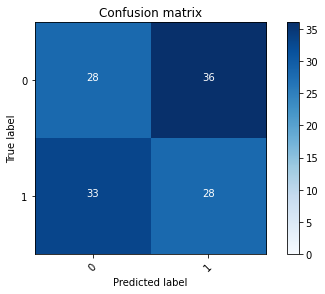

2022-08-22 16:48:03 - [Epoch Train: 18] loss: 0.0092, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:48:03 - [Epoch Valid: 18] loss: 1.6756, auc: 0.4375, acc: 0.4480, time: 6.00 s


 18%|███████▌                                  | 18/100 [09:16<42:54, 31.40s/it]

2022-08-22 16:48:03 - EPOCH: 19
2022-08-22 16:48:05 - Train Step 10/121, train_loss: 0.0173
2022-08-22 16:48:07 - Train Step 20/121, train_loss: 0.0123
2022-08-22 16:48:10 - Train Step 30/121, train_loss: 0.0098
2022-08-22 16:48:12 - Train Step 40/121, train_loss: 0.0092
2022-08-22 16:48:13 - Train Step 50/121, train_loss: 0.0082
2022-08-22 16:48:15 - Train Step 60/121, train_loss: 0.0078
2022-08-22 16:48:17 - Train Step 70/121, train_loss: 0.0078
2022-08-22 16:48:19 - Train Step 80/121, train_loss: 0.0074
2022-08-22 16:48:21 - Train Step 90/121, train_loss: 0.0072
2022-08-22 16:48:23 - Train Step 100/121, train_loss: 0.0074
2022-08-22 16:48:25 - Train Step 110/121, train_loss: 0.0078
2022-08-22 16:48:27 - Train Step 120/121, train_loss: 0.0079
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:48:29 - Valid Step 5/32, valid_loss: 2.0152
2022-08-22 16:48:30 - Valid Step 10/32, valid_loss: 1.5141
2022-08-22 16:48:31 - Valid Step 15/32, valid_loss: 1.4985
2022-08-22 16:48:32

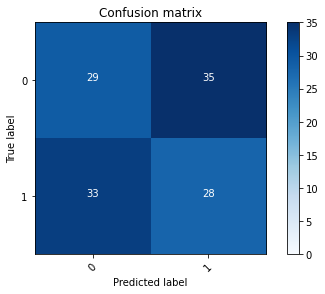

2022-08-22 16:48:34 - [Epoch Train: 19] loss: 0.0079, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:48:34 - [Epoch Valid: 19] loss: 1.7616, auc: 0.4337, acc: 0.4560, time: 6.00 s


 19%|███████▉                                  | 19/100 [09:47<42:08, 31.22s/it]

2022-08-22 16:48:34 - EPOCH: 20
2022-08-22 16:48:36 - Train Step 10/121, train_loss: 0.0036
2022-08-22 16:48:38 - Train Step 20/121, train_loss: 0.0056
2022-08-22 16:48:40 - Train Step 30/121, train_loss: 0.0071
2022-08-22 16:48:42 - Train Step 40/121, train_loss: 0.0075
2022-08-22 16:48:44 - Train Step 50/121, train_loss: 0.0074
2022-08-22 16:48:46 - Train Step 60/121, train_loss: 0.0073
2022-08-22 16:48:48 - Train Step 70/121, train_loss: 0.0071
2022-08-22 16:48:50 - Train Step 80/121, train_loss: 0.0079
2022-08-22 16:48:52 - Train Step 90/121, train_loss: 0.0076
2022-08-22 16:48:54 - Train Step 100/121, train_loss: 0.0073
2022-08-22 16:48:57 - Train Step 110/121, train_loss: 0.0072
2022-08-22 16:48:59 - Train Step 120/121, train_loss: 0.0070
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:49:00 - Valid Step 5/32, valid_loss: 2.0574
2022-08-22 16:49:01 - Valid Step 10/32, valid_loss: 1.7752
2022-08-22 16:49:02 - Valid Step 15/32, valid_loss: 1.6016
2022-08-22 16:49:03

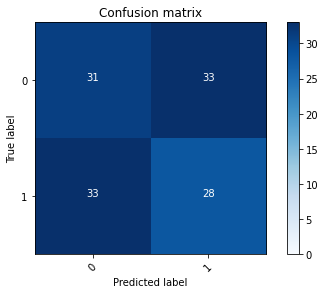

2022-08-22 16:49:05 - [Epoch Train: 20] loss: 0.0070, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:49:05 - [Epoch Valid: 20] loss: 1.7369, auc: 0.4398, acc: 0.4720, time: 6.00 s


 20%|████████▍                                 | 20/100 [10:18<41:38, 31.23s/it]

2022-08-22 16:49:05 - EPOCH: 21
2022-08-22 16:49:07 - Train Step 10/121, train_loss: 0.0049
2022-08-22 16:49:09 - Train Step 20/121, train_loss: 0.0048
2022-08-22 16:49:11 - Train Step 30/121, train_loss: 0.0046
2022-08-22 16:49:13 - Train Step 40/121, train_loss: 0.0054
2022-08-22 16:49:15 - Train Step 50/121, train_loss: 0.0058
2022-08-22 16:49:17 - Train Step 60/121, train_loss: 0.0055
2022-08-22 16:49:19 - Train Step 70/121, train_loss: 0.0063
2022-08-22 16:49:21 - Train Step 80/121, train_loss: 0.0061
2022-08-22 16:49:23 - Train Step 90/121, train_loss: 0.0059
2022-08-22 16:49:25 - Train Step 100/121, train_loss: 0.0059
2022-08-22 16:49:27 - Train Step 110/121, train_loss: 0.0058
2022-08-22 16:49:29 - Train Step 120/121, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:49:30 - Valid Step 5/32, valid_loss: 1.3873
2022-08-22 16:49:31 - Valid Step 10/32, valid_loss: 1.5050
2022-08-22 16:49:32 - Valid Step 15/32, valid_loss: 1.4981
2022-08-22 16:49:33

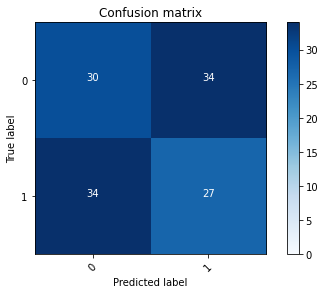

2022-08-22 16:49:36 - [Epoch Train: 21] loss: 0.0057, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:49:36 - [Epoch Valid: 21] loss: 1.7946, auc: 0.4375, acc: 0.4560, time: 6.00 s


 21%|████████▊                                 | 21/100 [10:49<40:48, 31.00s/it]

2022-08-22 16:49:36 - EPOCH: 22
2022-08-22 16:49:38 - Train Step 10/121, train_loss: 0.0058
2022-08-22 16:49:40 - Train Step 20/121, train_loss: 0.0053
2022-08-22 16:49:42 - Train Step 30/121, train_loss: 0.0047
2022-08-22 16:49:44 - Train Step 40/121, train_loss: 0.0047
2022-08-22 16:49:46 - Train Step 50/121, train_loss: 0.0046
2022-08-22 16:49:48 - Train Step 60/121, train_loss: 0.0043
2022-08-22 16:49:50 - Train Step 70/121, train_loss: 0.0042
2022-08-22 16:49:52 - Train Step 80/121, train_loss: 0.0048
2022-08-22 16:49:54 - Train Step 90/121, train_loss: 0.0049
2022-08-22 16:49:56 - Train Step 100/121, train_loss: 0.0051
2022-08-22 16:49:58 - Train Step 110/121, train_loss: 0.0050
2022-08-22 16:50:00 - Train Step 120/121, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:50:01 - Valid Step 5/32, valid_loss: 2.5683
2022-08-22 16:50:02 - Valid Step 10/32, valid_loss: 2.5756
2022-08-22 16:50:03 - Valid Step 15/32, valid_loss: 2.3755
2022-08-22 16:50:04

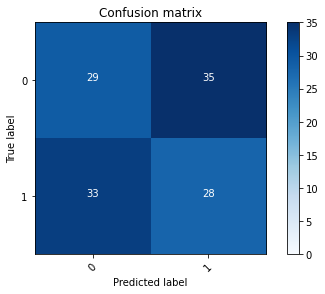

2022-08-22 16:50:07 - [Epoch Train: 22] loss: 0.0049, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:50:07 - [Epoch Valid: 22] loss: 1.8659, auc: 0.4390, acc: 0.4560, time: 6.00 s


 22%|█████████▏                                | 22/100 [11:20<40:18, 31.00s/it]

2022-08-22 16:50:07 - EPOCH: 23
2022-08-22 16:50:09 - Train Step 10/121, train_loss: 0.0025
2022-08-22 16:50:11 - Train Step 20/121, train_loss: 0.0034
2022-08-22 16:50:13 - Train Step 30/121, train_loss: 0.0034
2022-08-22 16:50:15 - Train Step 40/121, train_loss: 0.0034
2022-08-22 16:50:17 - Train Step 50/121, train_loss: 0.0032
2022-08-22 16:50:19 - Train Step 60/121, train_loss: 0.0032
2022-08-22 16:50:21 - Train Step 70/121, train_loss: 0.0033
2022-08-22 16:50:22 - Train Step 80/121, train_loss: 0.0045
2022-08-22 16:50:24 - Train Step 90/121, train_loss: 0.0045
2022-08-22 16:50:26 - Train Step 100/121, train_loss: 0.0044
2022-08-22 16:50:28 - Train Step 110/121, train_loss: 0.0047
2022-08-22 16:50:30 - Train Step 120/121, train_loss: 0.0046
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:50:32 - Valid Step 5/32, valid_loss: 1.5600
2022-08-22 16:50:32 - Valid Step 10/32, valid_loss: 1.8006
2022-08-22 16:50:34 - Valid Step 15/32, valid_loss: 1.8113
2022-08-22 16:50:34

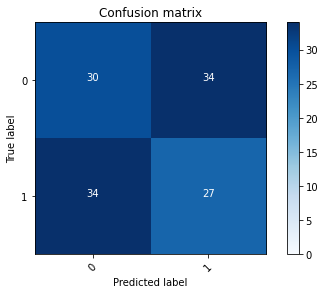

2022-08-22 16:50:37 - [Epoch Train: 23] loss: 0.0045, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:50:37 - [Epoch Valid: 23] loss: 1.7852, auc: 0.4347, acc: 0.4560, time: 6.00 s


 23%|█████████▋                                | 23/100 [11:50<39:25, 30.72s/it]

2022-08-22 16:50:37 - EPOCH: 24
2022-08-22 16:50:39 - Train Step 10/121, train_loss: 0.0044
2022-08-22 16:50:41 - Train Step 20/121, train_loss: 0.0039
2022-08-22 16:50:43 - Train Step 30/121, train_loss: 0.0036
2022-08-22 16:50:45 - Train Step 40/121, train_loss: 0.0038
2022-08-22 16:50:47 - Train Step 50/121, train_loss: 0.0041
2022-08-22 16:50:49 - Train Step 60/121, train_loss: 0.0045
2022-08-22 16:50:51 - Train Step 70/121, train_loss: 0.0042
2022-08-22 16:50:53 - Train Step 80/121, train_loss: 0.0040
2022-08-22 16:50:55 - Train Step 90/121, train_loss: 0.0043
2022-08-22 16:50:57 - Train Step 100/121, train_loss: 0.0042
2022-08-22 16:50:59 - Train Step 110/121, train_loss: 0.0041
2022-08-22 16:51:01 - Train Step 120/121, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:51:02 - Valid Step 5/32, valid_loss: 2.4390
2022-08-22 16:51:03 - Valid Step 10/32, valid_loss: 1.9087
2022-08-22 16:51:04 - Valid Step 15/32, valid_loss: 1.9198
2022-08-22 16:51:05

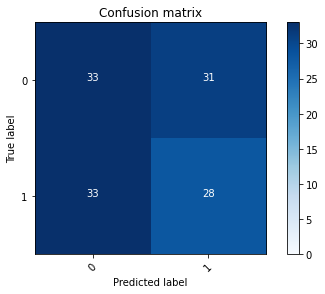

2022-08-22 16:51:08 - [Epoch Train: 24] loss: 0.0039, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:51:08 - [Epoch Valid: 24] loss: 1.8465, auc: 0.4334, acc: 0.4880, time: 6.00 s


 24%|██████████                                | 24/100 [12:21<38:58, 30.78s/it]

2022-08-22 16:51:08 - EPOCH: 25
2022-08-22 16:51:10 - Train Step 10/121, train_loss: 0.0024
2022-08-22 16:51:12 - Train Step 20/121, train_loss: 0.0029
2022-08-22 16:51:14 - Train Step 30/121, train_loss: 0.0025
2022-08-22 16:51:16 - Train Step 40/121, train_loss: 0.0030
2022-08-22 16:51:18 - Train Step 50/121, train_loss: 0.0030
2022-08-22 16:51:20 - Train Step 60/121, train_loss: 0.0029
2022-08-22 16:51:22 - Train Step 70/121, train_loss: 0.0029
2022-08-22 16:51:24 - Train Step 80/121, train_loss: 0.0030
2022-08-22 16:51:26 - Train Step 90/121, train_loss: 0.0031
2022-08-22 16:51:27 - Train Step 100/121, train_loss: 0.0038
2022-08-22 16:51:29 - Train Step 110/121, train_loss: 0.0037
2022-08-22 16:51:31 - Train Step 120/121, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:51:33 - Valid Step 5/32, valid_loss: 2.7572
2022-08-22 16:51:34 - Valid Step 10/32, valid_loss: 2.4317
2022-08-22 16:51:35 - Valid Step 15/32, valid_loss: 2.4014
2022-08-22 16:51:36

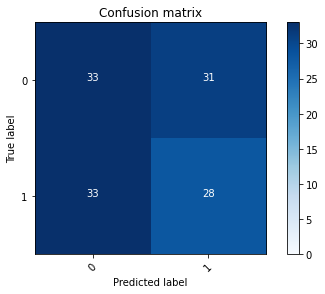

2022-08-22 16:51:38 - [Epoch Train: 25] loss: 0.0037, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:51:38 - [Epoch Valid: 25] loss: 2.1572, auc: 0.4311, acc: 0.4880, time: 6.00 s


 25%|██████████▌                               | 25/100 [12:51<38:20, 30.67s/it]

2022-08-22 16:51:38 - EPOCH: 26
2022-08-22 16:51:40 - Train Step 10/121, train_loss: 0.0027
2022-08-22 16:51:42 - Train Step 20/121, train_loss: 0.0027
2022-08-22 16:51:44 - Train Step 30/121, train_loss: 0.0025
2022-08-22 16:51:46 - Train Step 40/121, train_loss: 0.0024
2022-08-22 16:51:48 - Train Step 50/121, train_loss: 0.0025
2022-08-22 16:51:50 - Train Step 60/121, train_loss: 0.0024
2022-08-22 16:51:52 - Train Step 70/121, train_loss: 0.0033
2022-08-22 16:51:54 - Train Step 80/121, train_loss: 0.0036
2022-08-22 16:51:56 - Train Step 90/121, train_loss: 0.0035
2022-08-22 16:51:58 - Train Step 100/121, train_loss: 0.0034
2022-08-22 16:52:00 - Train Step 110/121, train_loss: 0.0033
2022-08-22 16:52:02 - Train Step 120/121, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:52:03 - Valid Step 5/32, valid_loss: 2.9349
2022-08-22 16:52:04 - Valid Step 10/32, valid_loss: 2.5345
2022-08-22 16:52:05 - Valid Step 15/32, valid_loss: 2.1002
2022-08-22 16:52:06

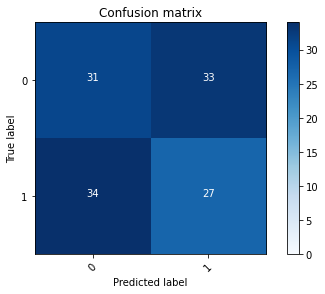

2022-08-22 16:52:09 - [Epoch Train: 26] loss: 0.0034, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:52:09 - [Epoch Valid: 26] loss: 1.9454, auc: 0.4355, acc: 0.4640, time: 6.00 s


 26%|██████████▉                               | 26/100 [13:21<37:44, 30.60s/it]

2022-08-22 16:52:09 - EPOCH: 27
2022-08-22 16:52:11 - Train Step 10/121, train_loss: 0.0031
2022-08-22 16:52:13 - Train Step 20/121, train_loss: 0.0024
2022-08-22 16:52:15 - Train Step 30/121, train_loss: 0.0022
2022-08-22 16:52:17 - Train Step 40/121, train_loss: 0.0022
2022-08-22 16:52:19 - Train Step 50/121, train_loss: 0.0021
2022-08-22 16:52:20 - Train Step 60/121, train_loss: 0.0022
2022-08-22 16:52:22 - Train Step 70/121, train_loss: 0.0021
2022-08-22 16:52:24 - Train Step 80/121, train_loss: 0.0021
2022-08-22 16:52:26 - Train Step 90/121, train_loss: 0.0021
2022-08-22 16:52:28 - Train Step 100/121, train_loss: 0.0025
2022-08-22 16:52:30 - Train Step 110/121, train_loss: 0.0026
2022-08-22 16:52:32 - Train Step 120/121, train_loss: 0.0027
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:52:34 - Valid Step 5/32, valid_loss: 2.1913
2022-08-22 16:52:34 - Valid Step 10/32, valid_loss: 1.9930
2022-08-22 16:52:36 - Valid Step 15/32, valid_loss: 1.9700
2022-08-22 16:52:36

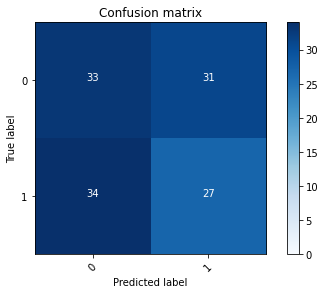

2022-08-22 16:52:39 - [Epoch Train: 27] loss: 0.0027, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:52:39 - [Epoch Valid: 27] loss: 1.9763, auc: 0.4352, acc: 0.4800, time: 6.00 s


 27%|███████████▎                              | 27/100 [13:52<37:08, 30.53s/it]

2022-08-22 16:52:39 - EPOCH: 28
2022-08-22 16:52:41 - Train Step 10/121, train_loss: 0.0016
2022-08-22 16:52:43 - Train Step 20/121, train_loss: 0.0026
2022-08-22 16:52:45 - Train Step 30/121, train_loss: 0.0028
2022-08-22 16:52:47 - Train Step 40/121, train_loss: 0.0027
2022-08-22 16:52:49 - Train Step 50/121, train_loss: 0.0025
2022-08-22 16:52:51 - Train Step 60/121, train_loss: 0.0025
2022-08-22 16:52:53 - Train Step 70/121, train_loss: 0.0028
2022-08-22 16:52:55 - Train Step 80/121, train_loss: 0.0031
2022-08-22 16:52:57 - Train Step 90/121, train_loss: 0.0029
2022-08-22 16:52:59 - Train Step 100/121, train_loss: 0.0029
2022-08-22 16:53:00 - Train Step 110/121, train_loss: 0.0029
2022-08-22 16:53:02 - Train Step 120/121, train_loss: 0.0029
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:53:04 - Valid Step 5/32, valid_loss: 1.4614
2022-08-22 16:53:05 - Valid Step 10/32, valid_loss: 2.1351
2022-08-22 16:53:06 - Valid Step 15/32, valid_loss: 1.9387
2022-08-22 16:53:07

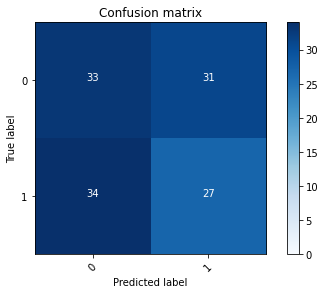

2022-08-22 16:53:09 - [Epoch Train: 28] loss: 0.0029, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:53:09 - [Epoch Valid: 28] loss: 2.0944, auc: 0.4331, acc: 0.4800, time: 6.00 s


 28%|███████████▊                              | 28/100 [14:22<36:30, 30.43s/it]

2022-08-22 16:53:09 - EPOCH: 29
2022-08-22 16:53:11 - Train Step 10/121, train_loss: 0.0027
2022-08-22 16:53:13 - Train Step 20/121, train_loss: 0.0020
2022-08-22 16:53:15 - Train Step 30/121, train_loss: 0.0021
2022-08-22 16:53:17 - Train Step 40/121, train_loss: 0.0020
2022-08-22 16:53:19 - Train Step 50/121, train_loss: 0.0019
2022-08-22 16:53:21 - Train Step 60/121, train_loss: 0.0019
2022-08-22 16:53:23 - Train Step 70/121, train_loss: 0.0019
2022-08-22 16:53:25 - Train Step 80/121, train_loss: 0.0018
2022-08-22 16:53:27 - Train Step 90/121, train_loss: 0.0018
2022-08-22 16:53:29 - Train Step 100/121, train_loss: 0.0021
2022-08-22 16:53:31 - Train Step 110/121, train_loss: 0.0021
2022-08-22 16:53:33 - Train Step 120/121, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:53:34 - Valid Step 5/32, valid_loss: 2.1712
2022-08-22 16:53:35 - Valid Step 10/32, valid_loss: 1.7822
2022-08-22 16:53:36 - Valid Step 15/32, valid_loss: 1.8872
2022-08-22 16:53:37

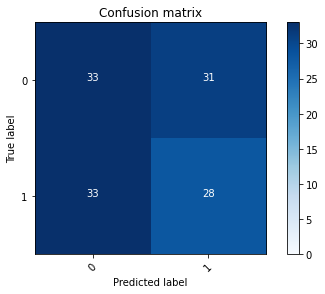

2022-08-22 16:53:40 - [Epoch Train: 29] loss: 0.0020, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:53:40 - [Epoch Valid: 29] loss: 2.1538, auc: 0.4360, acc: 0.4880, time: 6.00 s


 29%|████████████▏                             | 29/100 [14:52<35:59, 30.41s/it]

2022-08-22 16:53:40 - EPOCH: 30
2022-08-22 16:53:42 - Train Step 10/121, train_loss: 0.0025
2022-08-22 16:53:44 - Train Step 20/121, train_loss: 0.0022
2022-08-22 16:53:46 - Train Step 30/121, train_loss: 0.0021
2022-08-22 16:53:47 - Train Step 40/121, train_loss: 0.0020
2022-08-22 16:53:49 - Train Step 50/121, train_loss: 0.0020
2022-08-22 16:53:51 - Train Step 60/121, train_loss: 0.0019
2022-08-22 16:53:53 - Train Step 70/121, train_loss: 0.0018
2022-08-22 16:53:55 - Train Step 80/121, train_loss: 0.0018
2022-08-22 16:53:57 - Train Step 90/121, train_loss: 0.0019
2022-08-22 16:53:59 - Train Step 100/121, train_loss: 0.0021
2022-08-22 16:54:01 - Train Step 110/121, train_loss: 0.0020
2022-08-22 16:54:03 - Train Step 120/121, train_loss: 0.0020
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:54:05 - Valid Step 5/32, valid_loss: 1.7567
2022-08-22 16:54:05 - Valid Step 10/32, valid_loss: 2.2902
2022-08-22 16:54:07 - Valid Step 15/32, valid_loss: 2.3342
2022-08-22 16:54:07

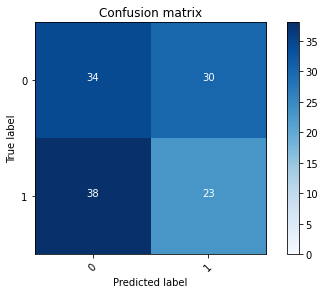

2022-08-22 16:54:10 - [Epoch Train: 30] loss: 0.0020, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:54:10 - [Epoch Valid: 30] loss: 2.1763, auc: 0.4324, acc: 0.4560, time: 6.00 s


 30%|████████████▌                             | 30/100 [15:23<35:29, 30.42s/it]

2022-08-22 16:54:10 - EPOCH: 31
2022-08-22 16:54:12 - Train Step 10/121, train_loss: 0.0014
2022-08-22 16:54:14 - Train Step 20/121, train_loss: 0.0015
2022-08-22 16:54:16 - Train Step 30/121, train_loss: 0.0016
2022-08-22 16:54:18 - Train Step 40/121, train_loss: 0.0021
2022-08-22 16:54:20 - Train Step 50/121, train_loss: 0.0020
2022-08-22 16:54:22 - Train Step 60/121, train_loss: 0.0018
2022-08-22 16:54:24 - Train Step 70/121, train_loss: 0.0020
2022-08-22 16:54:26 - Train Step 80/121, train_loss: 0.0019
2022-08-22 16:54:28 - Train Step 90/121, train_loss: 0.0018
2022-08-22 16:54:30 - Train Step 100/121, train_loss: 0.0018
2022-08-22 16:54:32 - Train Step 110/121, train_loss: 0.0018
2022-08-22 16:54:34 - Train Step 120/121, train_loss: 0.0017
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:54:35 - Valid Step 5/32, valid_loss: 3.1424
2022-08-22 16:54:36 - Valid Step 10/32, valid_loss: 2.6795
2022-08-22 16:54:37 - Valid Step 15/32, valid_loss: 2.8333
2022-08-22 16:54:38

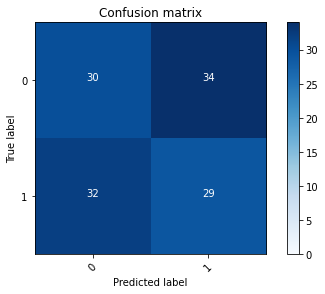

2022-08-22 16:54:40 - [Epoch Train: 31] loss: 0.0017, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:54:40 - [Epoch Valid: 31] loss: 2.2857, auc: 0.4360, acc: 0.4720, time: 6.00 s


 31%|█████████████                             | 31/100 [15:53<35:00, 30.45s/it]

2022-08-22 16:54:40 - EPOCH: 32
2022-08-22 16:54:43 - Train Step 10/121, train_loss: 0.0012
2022-08-22 16:54:45 - Train Step 20/121, train_loss: 0.0012
2022-08-22 16:54:47 - Train Step 30/121, train_loss: 0.0010
2022-08-22 16:54:49 - Train Step 40/121, train_loss: 0.0012
2022-08-22 16:54:51 - Train Step 50/121, train_loss: 0.0011
2022-08-22 16:54:53 - Train Step 60/121, train_loss: 0.0011
2022-08-22 16:54:55 - Train Step 70/121, train_loss: 0.0011
2022-08-22 16:54:57 - Train Step 80/121, train_loss: 0.0013
2022-08-22 16:54:59 - Train Step 90/121, train_loss: 0.0013
2022-08-22 16:55:00 - Train Step 100/121, train_loss: 0.0015
2022-08-22 16:55:02 - Train Step 110/121, train_loss: 0.0015
2022-08-22 16:55:04 - Train Step 120/121, train_loss: 0.0015
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:55:06 - Valid Step 5/32, valid_loss: 1.5810
2022-08-22 16:55:07 - Valid Step 10/32, valid_loss: 2.0779
2022-08-22 16:55:08 - Valid Step 15/32, valid_loss: 2.0098
2022-08-22 16:55:09

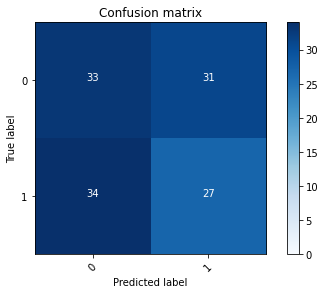

2022-08-22 16:55:11 - [Epoch Train: 32] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:55:11 - [Epoch Valid: 32] loss: 2.0941, auc: 0.4321, acc: 0.4800, time: 6.00 s


 32%|█████████████▍                            | 32/100 [16:24<34:33, 30.49s/it]

2022-08-22 16:55:11 - EPOCH: 33
2022-08-22 16:55:13 - Train Step 10/121, train_loss: 0.0053
2022-08-22 16:55:15 - Train Step 20/121, train_loss: 0.0031
2022-08-22 16:55:17 - Train Step 30/121, train_loss: 0.0024
2022-08-22 16:55:19 - Train Step 40/121, train_loss: 0.0022
2022-08-22 16:55:21 - Train Step 50/121, train_loss: 0.0020
2022-08-22 16:55:23 - Train Step 60/121, train_loss: 0.0021
2022-08-22 16:55:25 - Train Step 70/121, train_loss: 0.0020
2022-08-22 16:55:27 - Train Step 80/121, train_loss: 0.0019
2022-08-22 16:55:29 - Train Step 90/121, train_loss: 0.0018
2022-08-22 16:55:31 - Train Step 100/121, train_loss: 0.0017
2022-08-22 16:55:33 - Train Step 110/121, train_loss: 0.0017
2022-08-22 16:55:35 - Train Step 120/121, train_loss: 0.0017
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:55:36 - Valid Step 5/32, valid_loss: 2.0760
2022-08-22 16:55:37 - Valid Step 10/32, valid_loss: 2.1757
2022-08-22 16:55:38 - Valid Step 15/32, valid_loss: 2.0199
2022-08-22 16:55:39

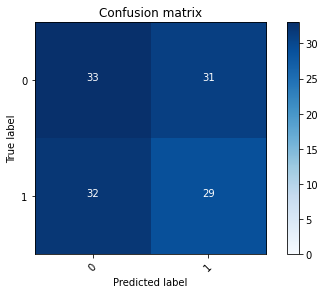

2022-08-22 16:55:42 - [Epoch Train: 33] loss: 0.0017, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:55:42 - [Epoch Valid: 33] loss: 2.2713, auc: 0.4311, acc: 0.4960, time: 6.00 s


 33%|█████████████▊                            | 33/100 [16:54<34:06, 30.54s/it]

2022-08-22 16:55:42 - EPOCH: 34
2022-08-22 16:55:44 - Train Step 10/121, train_loss: 0.0011
2022-08-22 16:55:46 - Train Step 20/121, train_loss: 0.0013
2022-08-22 16:55:48 - Train Step 30/121, train_loss: 0.0013
2022-08-22 16:55:50 - Train Step 40/121, train_loss: 0.0013
2022-08-22 16:55:52 - Train Step 50/121, train_loss: 0.0012
2022-08-22 16:55:54 - Train Step 60/121, train_loss: 0.0011
2022-08-22 16:55:56 - Train Step 70/121, train_loss: 0.0012
2022-08-22 16:55:58 - Train Step 80/121, train_loss: 0.0012
2022-08-22 16:56:00 - Train Step 90/121, train_loss: 0.0011
2022-08-22 16:56:02 - Train Step 100/121, train_loss: 0.0013
2022-08-22 16:56:04 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:56:06 - Train Step 120/121, train_loss: 0.0012
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:56:07 - Valid Step 5/32, valid_loss: 2.6068
2022-08-22 16:56:08 - Valid Step 10/32, valid_loss: 2.2239
2022-08-22 16:56:09 - Valid Step 15/32, valid_loss: 2.4957
2022-08-22 16:56:10

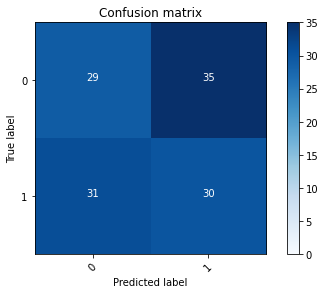

2022-08-22 16:56:13 - [Epoch Train: 34] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:56:13 - [Epoch Valid: 34] loss: 2.3365, auc: 0.4316, acc: 0.4720, time: 6.00 s


 34%|██████████████▎                           | 34/100 [17:25<33:41, 30.62s/it]

2022-08-22 16:56:13 - EPOCH: 35
2022-08-22 16:56:15 - Train Step 10/121, train_loss: 0.0013
2022-08-22 16:56:17 - Train Step 20/121, train_loss: 0.0010
2022-08-22 16:56:19 - Train Step 30/121, train_loss: 0.0010
2022-08-22 16:56:21 - Train Step 40/121, train_loss: 0.0014
2022-08-22 16:56:23 - Train Step 50/121, train_loss: 0.0013
2022-08-22 16:56:25 - Train Step 60/121, train_loss: 0.0013
2022-08-22 16:56:26 - Train Step 70/121, train_loss: 0.0012
2022-08-22 16:56:28 - Train Step 80/121, train_loss: 0.0012
2022-08-22 16:56:30 - Train Step 90/121, train_loss: 0.0012
2022-08-22 16:56:32 - Train Step 100/121, train_loss: 0.0011
2022-08-22 16:56:34 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:56:36 - Train Step 120/121, train_loss: 0.0011
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:56:38 - Valid Step 5/32, valid_loss: 2.5477
2022-08-22 16:56:38 - Valid Step 10/32, valid_loss: 2.4385
2022-08-22 16:56:40 - Valid Step 15/32, valid_loss: 2.5858
2022-08-22 16:56:40

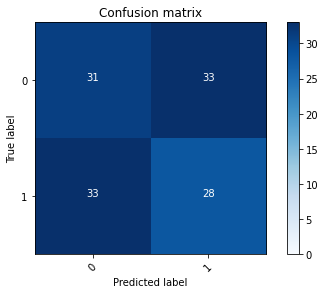

2022-08-22 16:56:43 - [Epoch Train: 35] loss: 0.0011, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:56:43 - [Epoch Valid: 35] loss: 2.2304, auc: 0.4347, acc: 0.4720, time: 6.00 s


 35%|██████████████▋                           | 35/100 [17:56<33:05, 30.55s/it]

2022-08-22 16:56:43 - EPOCH: 36
2022-08-22 16:56:45 - Train Step 10/121, train_loss: 0.0011
2022-08-22 16:56:47 - Train Step 20/121, train_loss: 0.0012
2022-08-22 16:56:49 - Train Step 30/121, train_loss: 0.0011
2022-08-22 16:56:51 - Train Step 40/121, train_loss: 0.0010
2022-08-22 16:56:53 - Train Step 50/121, train_loss: 0.0010
2022-08-22 16:56:55 - Train Step 60/121, train_loss: 0.0010
2022-08-22 16:56:57 - Train Step 70/121, train_loss: 0.0013
2022-08-22 16:56:59 - Train Step 80/121, train_loss: 0.0013
2022-08-22 16:57:01 - Train Step 90/121, train_loss: 0.0012
2022-08-22 16:57:03 - Train Step 100/121, train_loss: 0.0013
2022-08-22 16:57:05 - Train Step 110/121, train_loss: 0.0012
2022-08-22 16:57:07 - Train Step 120/121, train_loss: 0.0012
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:57:09 - Valid Step 5/32, valid_loss: 3.0397
2022-08-22 16:57:10 - Valid Step 10/32, valid_loss: 2.1495
2022-08-22 16:57:11 - Valid Step 15/32, valid_loss: 1.9029
2022-08-22 16:57:12

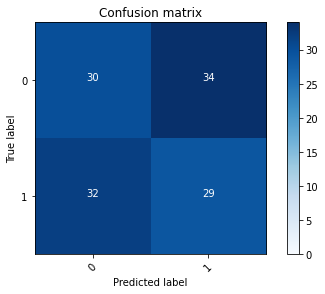

2022-08-22 16:57:14 - [Epoch Train: 36] loss: 0.0012, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:57:14 - [Epoch Valid: 36] loss: 2.3256, auc: 0.4311, acc: 0.4720, time: 6.00 s


 36%|███████████████                           | 36/100 [18:27<32:48, 30.76s/it]

2022-08-22 16:57:14 - EPOCH: 37
2022-08-22 16:57:16 - Train Step 10/121, train_loss: 0.0008
2022-08-22 16:57:18 - Train Step 20/121, train_loss: 0.0011
2022-08-22 16:57:20 - Train Step 30/121, train_loss: 0.0010
2022-08-22 16:57:22 - Train Step 40/121, train_loss: 0.0009
2022-08-22 16:57:24 - Train Step 50/121, train_loss: 0.0009
2022-08-22 16:57:26 - Train Step 60/121, train_loss: 0.0009
2022-08-22 16:57:28 - Train Step 70/121, train_loss: 0.0008
2022-08-22 16:57:30 - Train Step 80/121, train_loss: 0.0009
2022-08-22 16:57:32 - Train Step 90/121, train_loss: 0.0009
2022-08-22 16:57:34 - Train Step 100/121, train_loss: 0.0009
2022-08-22 16:57:36 - Train Step 110/121, train_loss: 0.0009
2022-08-22 16:57:38 - Train Step 120/121, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:57:39 - Valid Step 5/32, valid_loss: 1.1681
2022-08-22 16:57:40 - Valid Step 10/32, valid_loss: 2.2392
2022-08-22 16:57:41 - Valid Step 15/32, valid_loss: 2.3534
2022-08-22 16:57:42

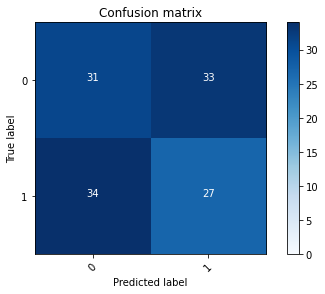

2022-08-22 16:57:45 - [Epoch Train: 37] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:57:45 - [Epoch Valid: 37] loss: 2.2825, auc: 0.4339, acc: 0.4640, time: 6.00 s


 37%|███████████████▌                          | 37/100 [18:57<32:10, 30.65s/it]

2022-08-22 16:57:45 - EPOCH: 38
2022-08-22 16:57:47 - Train Step 10/121, train_loss: 0.0012
2022-08-22 16:57:49 - Train Step 20/121, train_loss: 0.0010
2022-08-22 16:57:51 - Train Step 30/121, train_loss: 0.0008
2022-08-22 16:57:53 - Train Step 40/121, train_loss: 0.0009
2022-08-22 16:57:55 - Train Step 50/121, train_loss: 0.0010
2022-08-22 16:57:57 - Train Step 60/121, train_loss: 0.0009
2022-08-22 16:57:59 - Train Step 70/121, train_loss: 0.0009
2022-08-22 16:58:01 - Train Step 80/121, train_loss: 0.0009
2022-08-22 16:58:03 - Train Step 90/121, train_loss: 0.0008
2022-08-22 16:58:04 - Train Step 100/121, train_loss: 0.0009
2022-08-22 16:58:06 - Train Step 110/121, train_loss: 0.0010
2022-08-22 16:58:08 - Train Step 120/121, train_loss: 0.0009
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:58:10 - Valid Step 5/32, valid_loss: 2.2544
2022-08-22 16:58:11 - Valid Step 10/32, valid_loss: 2.5450
2022-08-22 16:58:12 - Valid Step 15/32, valid_loss: 2.5796
2022-08-22 16:58:13

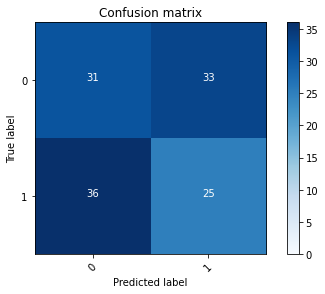

2022-08-22 16:58:15 - [Epoch Train: 38] loss: 0.0009, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:58:15 - [Epoch Valid: 38] loss: 2.3552, auc: 0.4329, acc: 0.4480, time: 6.00 s


 38%|███████████████▉                          | 38/100 [19:28<31:39, 30.64s/it]

2022-08-22 16:58:15 - EPOCH: 39
2022-08-22 16:58:17 - Train Step 10/121, train_loss: 0.0005
2022-08-22 16:58:19 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:58:21 - Train Step 30/121, train_loss: 0.0005
2022-08-22 16:58:23 - Train Step 40/121, train_loss: 0.0006
2022-08-22 16:58:25 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:58:27 - Train Step 60/121, train_loss: 0.0007
2022-08-22 16:58:29 - Train Step 70/121, train_loss: 0.0007
2022-08-22 16:58:31 - Train Step 80/121, train_loss: 0.0008
2022-08-22 16:58:33 - Train Step 90/121, train_loss: 0.0008
2022-08-22 16:58:35 - Train Step 100/121, train_loss: 0.0008
2022-08-22 16:58:37 - Train Step 110/121, train_loss: 0.0008
2022-08-22 16:58:39 - Train Step 120/121, train_loss: 0.0008
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:58:40 - Valid Step 5/32, valid_loss: 3.5200
2022-08-22 16:58:41 - Valid Step 10/32, valid_loss: 3.0783
2022-08-22 16:58:42 - Valid Step 15/32, valid_loss: 2.9242
2022-08-22 16:58:43

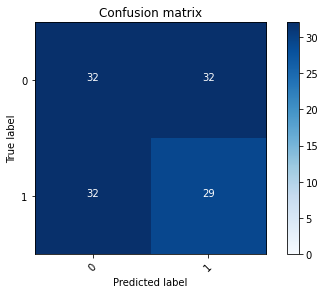

2022-08-22 16:58:45 - [Epoch Train: 39] loss: 0.0008, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:58:45 - [Epoch Valid: 39] loss: 2.5021, auc: 0.4365, acc: 0.4880, time: 6.00 s


 39%|████████████████▍                         | 39/100 [19:58<31:00, 30.50s/it]

2022-08-22 16:58:45 - EPOCH: 40
2022-08-22 16:58:48 - Train Step 10/121, train_loss: 0.0009
2022-08-22 16:58:50 - Train Step 20/121, train_loss: 0.0007
2022-08-22 16:58:52 - Train Step 30/121, train_loss: 0.0007
2022-08-22 16:58:54 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:58:56 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:58:58 - Train Step 60/121, train_loss: 0.0006
2022-08-22 16:59:00 - Train Step 70/121, train_loss: 0.0006
2022-08-22 16:59:02 - Train Step 80/121, train_loss: 0.0007
2022-08-22 16:59:04 - Train Step 90/121, train_loss: 0.0007
2022-08-22 16:59:06 - Train Step 100/121, train_loss: 0.0006
2022-08-22 16:59:08 - Train Step 110/121, train_loss: 0.0007
2022-08-22 16:59:10 - Train Step 120/121, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:59:11 - Valid Step 5/32, valid_loss: 1.2524
2022-08-22 16:59:12 - Valid Step 10/32, valid_loss: 2.2339
2022-08-22 16:59:13 - Valid Step 15/32, valid_loss: 2.2236
2022-08-22 16:59:14

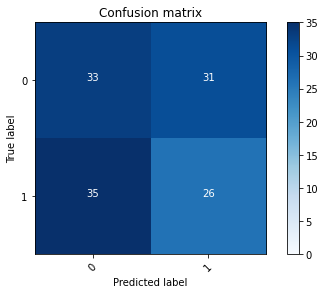

2022-08-22 16:59:16 - [Epoch Train: 40] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 16:59:16 - [Epoch Valid: 40] loss: 2.4350, auc: 0.4321, acc: 0.4720, time: 6.00 s


 40%|████████████████▊                         | 40/100 [20:29<30:38, 30.64s/it]

2022-08-22 16:59:16 - EPOCH: 41
2022-08-22 16:59:18 - Train Step 10/121, train_loss: 0.0007
2022-08-22 16:59:20 - Train Step 20/121, train_loss: 0.0010
2022-08-22 16:59:22 - Train Step 30/121, train_loss: 0.0008
2022-08-22 16:59:24 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:59:26 - Train Step 50/121, train_loss: 0.0008
2022-08-22 16:59:28 - Train Step 60/121, train_loss: 0.0007
2022-08-22 16:59:30 - Train Step 70/121, train_loss: 0.0007
2022-08-22 16:59:32 - Train Step 80/121, train_loss: 0.0007
2022-08-22 16:59:34 - Train Step 90/121, train_loss: 0.0008
2022-08-22 16:59:36 - Train Step 100/121, train_loss: 0.0008
2022-08-22 16:59:38 - Train Step 110/121, train_loss: 0.0008
2022-08-22 16:59:40 - Train Step 120/121, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 16:59:41 - Valid Step 5/32, valid_loss: 2.2280
2022-08-22 16:59:42 - Valid Step 10/32, valid_loss: 2.9469
2022-08-22 16:59:44 - Valid Step 15/32, valid_loss: 2.6889
2022-08-22 16:59:44

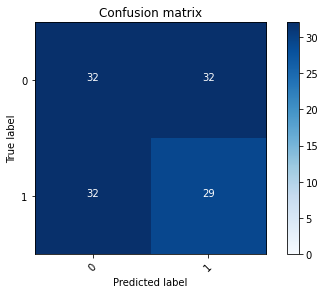

2022-08-22 16:59:47 - [Epoch Train: 41] loss: 0.0007, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 16:59:47 - [Epoch Valid: 41] loss: 2.4813, auc: 0.4339, acc: 0.4880, time: 6.00 s


 41%|█████████████████▏                        | 41/100 [21:00<30:06, 30.61s/it]

2022-08-22 16:59:47 - EPOCH: 42
2022-08-22 16:59:49 - Train Step 10/121, train_loss: 0.0003
2022-08-22 16:59:51 - Train Step 20/121, train_loss: 0.0005
2022-08-22 16:59:53 - Train Step 30/121, train_loss: 0.0006
2022-08-22 16:59:55 - Train Step 40/121, train_loss: 0.0007
2022-08-22 16:59:57 - Train Step 50/121, train_loss: 0.0007
2022-08-22 16:59:59 - Train Step 60/121, train_loss: 0.0007
2022-08-22 17:00:01 - Train Step 70/121, train_loss: 0.0006
2022-08-22 17:00:03 - Train Step 80/121, train_loss: 0.0006
2022-08-22 17:00:05 - Train Step 90/121, train_loss: 0.0006
2022-08-22 17:00:07 - Train Step 100/121, train_loss: 0.0006
2022-08-22 17:00:09 - Train Step 110/121, train_loss: 0.0006
2022-08-22 17:00:11 - Train Step 120/121, train_loss: 0.0006
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:00:12 - Valid Step 5/32, valid_loss: 3.4566
2022-08-22 17:00:13 - Valid Step 10/32, valid_loss: 2.6950
2022-08-22 17:00:14 - Valid Step 15/32, valid_loss: 2.3465
2022-08-22 17:00:15

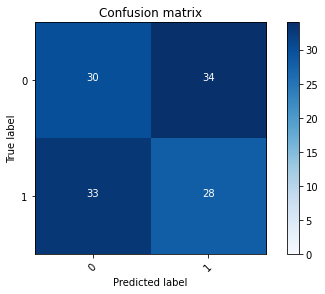

2022-08-22 17:00:17 - [Epoch Train: 42] loss: 0.0006, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:00:17 - [Epoch Valid: 42] loss: 2.5264, auc: 0.4301, acc: 0.4640, time: 6.00 s


 42%|█████████████████▋                        | 42/100 [21:30<29:33, 30.57s/it]

2022-08-22 17:00:17 - EPOCH: 43
2022-08-22 17:00:20 - Train Step 10/121, train_loss: 0.0008
2022-08-22 17:00:21 - Train Step 20/121, train_loss: 0.0007
2022-08-22 17:00:23 - Train Step 30/121, train_loss: 0.0006
2022-08-22 17:00:25 - Train Step 40/121, train_loss: 0.0006
2022-08-22 17:00:27 - Train Step 50/121, train_loss: 0.0006
2022-08-22 17:00:29 - Train Step 60/121, train_loss: 0.0006
2022-08-22 17:00:31 - Train Step 70/121, train_loss: 0.0007
2022-08-22 17:00:33 - Train Step 80/121, train_loss: 0.0006
2022-08-22 17:00:35 - Train Step 90/121, train_loss: 0.0006
2022-08-22 17:00:37 - Train Step 100/121, train_loss: 0.0006
2022-08-22 17:00:39 - Train Step 110/121, train_loss: 0.0006
2022-08-22 17:00:41 - Train Step 120/121, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:00:42 - Valid Step 5/32, valid_loss: 1.8362
2022-08-22 17:00:43 - Valid Step 10/32, valid_loss: 2.1876
2022-08-22 17:00:44 - Valid Step 15/32, valid_loss: 2.1299
2022-08-22 17:00:45

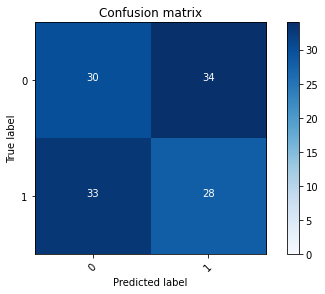

2022-08-22 17:00:48 - [Epoch Train: 43] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:00:48 - [Epoch Valid: 43] loss: 2.5346, auc: 0.4303, acc: 0.4640, time: 6.00 s


 43%|██████████████████                        | 43/100 [22:00<28:58, 30.50s/it]

2022-08-22 17:00:48 - EPOCH: 44
2022-08-22 17:00:50 - Train Step 10/121, train_loss: 0.0004
2022-08-22 17:00:52 - Train Step 20/121, train_loss: 0.0003
2022-08-22 17:00:54 - Train Step 30/121, train_loss: 0.0003
2022-08-22 17:00:56 - Train Step 40/121, train_loss: 0.0004
2022-08-22 17:00:58 - Train Step 50/121, train_loss: 0.0004
2022-08-22 17:01:00 - Train Step 60/121, train_loss: 0.0004
2022-08-22 17:01:02 - Train Step 70/121, train_loss: 0.0004
2022-08-22 17:01:04 - Train Step 80/121, train_loss: 0.0004
2022-08-22 17:01:06 - Train Step 90/121, train_loss: 0.0004
2022-08-22 17:01:08 - Train Step 100/121, train_loss: 0.0004
2022-08-22 17:01:10 - Train Step 110/121, train_loss: 0.0004
2022-08-22 17:01:12 - Train Step 120/121, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:01:13 - Valid Step 5/32, valid_loss: 2.4693
2022-08-22 17:01:14 - Valid Step 10/32, valid_loss: 3.2238
2022-08-22 17:01:15 - Valid Step 15/32, valid_loss: 2.6048
2022-08-22 17:01:16

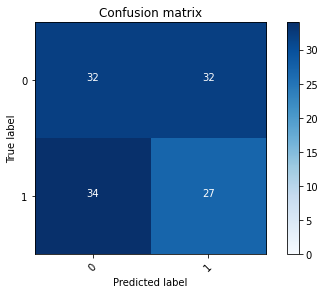

2022-08-22 17:01:19 - [Epoch Train: 44] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:01:19 - [Epoch Valid: 44] loss: 2.5339, auc: 0.4329, acc: 0.4720, time: 6.00 s


 44%|██████████████████▍                       | 44/100 [22:31<28:36, 30.65s/it]

2022-08-22 17:01:19 - EPOCH: 45
2022-08-22 17:01:21 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:01:23 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:01:25 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:01:27 - Train Step 40/121, train_loss: 0.0003
2022-08-22 17:01:29 - Train Step 50/121, train_loss: 0.0004
2022-08-22 17:01:31 - Train Step 60/121, train_loss: 0.0006
2022-08-22 17:01:33 - Train Step 70/121, train_loss: 0.0005
2022-08-22 17:01:35 - Train Step 80/121, train_loss: 0.0005
2022-08-22 17:01:37 - Train Step 90/121, train_loss: 0.0005
2022-08-22 17:01:39 - Train Step 100/121, train_loss: 0.0005
2022-08-22 17:01:41 - Train Step 110/121, train_loss: 0.0005
2022-08-22 17:01:43 - Train Step 120/121, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:01:44 - Valid Step 5/32, valid_loss: 1.2669
2022-08-22 17:01:45 - Valid Step 10/32, valid_loss: 2.5724
2022-08-22 17:01:46 - Valid Step 15/32, valid_loss: 2.8516
2022-08-22 17:01:47

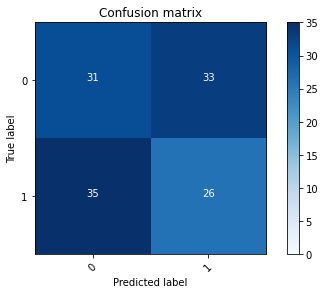

2022-08-22 17:01:50 - [Epoch Train: 45] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:01:50 - [Epoch Valid: 45] loss: 2.6120, auc: 0.4306, acc: 0.4560, time: 6.00 s


 45%|██████████████████▉                       | 45/100 [23:02<28:09, 30.72s/it]

2022-08-22 17:01:50 - EPOCH: 46
2022-08-22 17:01:52 - Train Step 10/121, train_loss: 0.0005
2022-08-22 17:01:54 - Train Step 20/121, train_loss: 0.0004
2022-08-22 17:01:56 - Train Step 30/121, train_loss: 0.0004
2022-08-22 17:01:58 - Train Step 40/121, train_loss: 0.0004
2022-08-22 17:02:00 - Train Step 50/121, train_loss: 0.0003
2022-08-22 17:02:01 - Train Step 60/121, train_loss: 0.0003
2022-08-22 17:02:03 - Train Step 70/121, train_loss: 0.0003
2022-08-22 17:02:05 - Train Step 80/121, train_loss: 0.0003
2022-08-22 17:02:07 - Train Step 90/121, train_loss: 0.0003
2022-08-22 17:02:09 - Train Step 100/121, train_loss: 0.0003
2022-08-22 17:02:11 - Train Step 110/121, train_loss: 0.0003
2022-08-22 17:02:13 - Train Step 120/121, train_loss: 0.0004
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:02:15 - Valid Step 5/32, valid_loss: 1.9967
2022-08-22 17:02:16 - Valid Step 10/32, valid_loss: 2.0876
2022-08-22 17:02:17 - Valid Step 15/32, valid_loss: 2.1035
2022-08-22 17:02:18

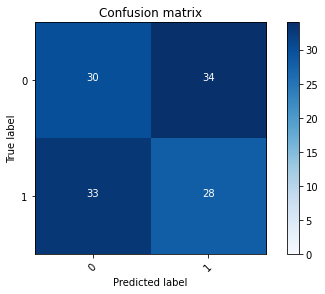

2022-08-22 17:02:20 - [Epoch Train: 46] loss: 0.0004, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:02:20 - [Epoch Valid: 46] loss: 2.5571, auc: 0.4347, acc: 0.4640, time: 6.00 s


 46%|███████████████████▎                      | 46/100 [23:33<27:32, 30.61s/it]

2022-08-22 17:02:20 - EPOCH: 47
2022-08-22 17:02:22 - Train Step 10/121, train_loss: 0.0008
2022-08-22 17:02:24 - Train Step 20/121, train_loss: 0.0005
2022-08-22 17:02:26 - Train Step 30/121, train_loss: 0.0004
2022-08-22 17:02:28 - Train Step 40/121, train_loss: 0.0005
2022-08-22 17:02:30 - Train Step 50/121, train_loss: 0.0005
2022-08-22 17:02:32 - Train Step 60/121, train_loss: 0.0005
2022-08-22 17:02:34 - Train Step 70/121, train_loss: 0.0005
2022-08-22 17:02:36 - Train Step 80/121, train_loss: 0.0004
2022-08-22 17:02:38 - Train Step 90/121, train_loss: 0.0005
2022-08-22 17:02:40 - Train Step 100/121, train_loss: 0.0004
2022-08-22 17:02:42 - Train Step 110/121, train_loss: 0.0005
2022-08-22 17:02:44 - Train Step 120/121, train_loss: 0.0005
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:02:45 - Valid Step 5/32, valid_loss: 2.8562
2022-08-22 17:02:46 - Valid Step 10/32, valid_loss: 2.9089
2022-08-22 17:02:47 - Valid Step 15/32, valid_loss: 2.8321
2022-08-22 17:02:48

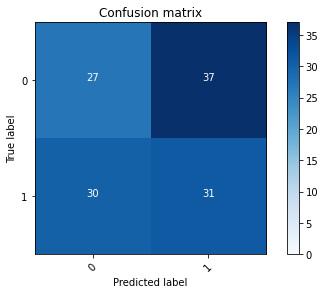

2022-08-22 17:02:51 - [Epoch Train: 47] loss: 0.0005, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:02:51 - [Epoch Valid: 47] loss: 2.6563, auc: 0.4306, acc: 0.4640, time: 6.00 s


 47%|███████████████████▋                      | 47/100 [24:03<27:03, 30.63s/it]

2022-08-22 17:02:51 - EPOCH: 48
2022-08-22 17:02:53 - Train Step 10/121, train_loss: 0.0008
2022-08-22 17:02:55 - Train Step 20/121, train_loss: 0.0005
2022-08-22 17:02:57 - Train Step 30/121, train_loss: 0.0004
2022-08-22 17:02:59 - Train Step 40/121, train_loss: 0.0004
2022-08-22 17:03:01 - Train Step 50/121, train_loss: 0.0005
2022-08-22 17:03:02 - Train Step 60/121, train_loss: 0.0004
2022-08-22 17:03:04 - Train Step 70/121, train_loss: 0.0004
2022-08-22 17:03:06 - Train Step 80/121, train_loss: 0.0004
2022-08-22 17:03:08 - Train Step 90/121, train_loss: 0.0004
2022-08-22 17:03:10 - Train Step 100/121, train_loss: 0.0004
2022-08-22 17:03:12 - Train Step 110/121, train_loss: 0.0003
2022-08-22 17:03:14 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:03:16 - Valid Step 5/32, valid_loss: 4.0956
2022-08-22 17:03:16 - Valid Step 10/32, valid_loss: 3.0752
2022-08-22 17:03:18 - Valid Step 15/32, valid_loss: 2.7207
2022-08-22 17:03:18

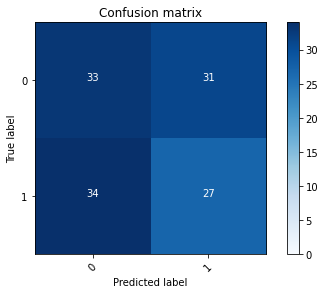

2022-08-22 17:03:21 - [Epoch Train: 48] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:03:21 - [Epoch Valid: 48] loss: 2.5887, auc: 0.4308, acc: 0.4800, time: 6.00 s


 48%|████████████████████▏                     | 48/100 [24:34<26:27, 30.53s/it]

2022-08-22 17:03:21 - EPOCH: 49
2022-08-22 17:03:23 - Train Step 10/121, train_loss: 0.0003
2022-08-22 17:03:25 - Train Step 20/121, train_loss: 0.0003
2022-08-22 17:03:27 - Train Step 30/121, train_loss: 0.0003
2022-08-22 17:03:29 - Train Step 40/121, train_loss: 0.0003
2022-08-22 17:03:31 - Train Step 50/121, train_loss: 0.0003
2022-08-22 17:03:33 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:03:35 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:03:37 - Train Step 80/121, train_loss: 0.0003
2022-08-22 17:03:39 - Train Step 90/121, train_loss: 0.0003
2022-08-22 17:03:41 - Train Step 100/121, train_loss: 0.0003
2022-08-22 17:03:43 - Train Step 110/121, train_loss: 0.0003
2022-08-22 17:03:45 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:03:46 - Valid Step 5/32, valid_loss: 3.0742
2022-08-22 17:03:47 - Valid Step 10/32, valid_loss: 2.8198
2022-08-22 17:03:48 - Valid Step 15/32, valid_loss: 2.5930
2022-08-22 17:03:49

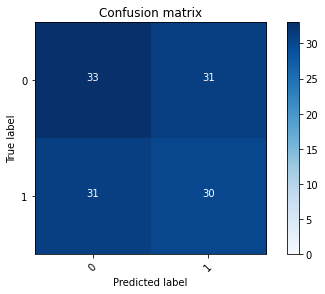

2022-08-22 17:03:51 - [Epoch Train: 49] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:03:51 - [Epoch Valid: 49] loss: 2.6731, auc: 0.4360, acc: 0.5040, time: 6.00 s


 49%|████████████████████▌                     | 49/100 [25:04<25:57, 30.53s/it]

2022-08-22 17:03:51 - EPOCH: 50
2022-08-22 17:03:54 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:03:56 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:03:57 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:03:59 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:04:01 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:04:03 - Train Step 60/121, train_loss: 0.0003
2022-08-22 17:04:05 - Train Step 70/121, train_loss: 0.0003
2022-08-22 17:04:07 - Train Step 80/121, train_loss: 0.0003
2022-08-22 17:04:09 - Train Step 90/121, train_loss: 0.0003
2022-08-22 17:04:12 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:04:14 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:04:16 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:04:17 - Valid Step 5/32, valid_loss: 4.3769
2022-08-22 17:04:18 - Valid Step 10/32, valid_loss: 2.9558
2022-08-22 17:04:19 - Valid Step 15/32, valid_loss: 2.5161
2022-08-22 17:04:20

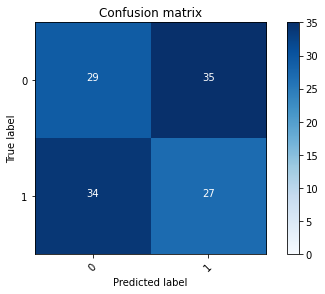

2022-08-22 17:04:22 - [Epoch Train: 50] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:04:22 - [Epoch Valid: 50] loss: 2.6711, auc: 0.4306, acc: 0.4480, time: 6.00 s


 50%|█████████████████████                     | 50/100 [25:35<25:32, 30.65s/it]

2022-08-22 17:04:22 - EPOCH: 51
2022-08-22 17:04:25 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:04:27 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:04:29 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:04:31 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:04:33 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:04:34 - Train Step 60/121, train_loss: 0.0004
2022-08-22 17:04:36 - Train Step 70/121, train_loss: 0.0003
2022-08-22 17:04:38 - Train Step 80/121, train_loss: 0.0003
2022-08-22 17:04:40 - Train Step 90/121, train_loss: 0.0003
2022-08-22 17:04:42 - Train Step 100/121, train_loss: 0.0003
2022-08-22 17:04:44 - Train Step 110/121, train_loss: 0.0003
2022-08-22 17:04:46 - Train Step 120/121, train_loss: 0.0003
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:04:48 - Valid Step 5/32, valid_loss: 1.8713
2022-08-22 17:04:48 - Valid Step 10/32, valid_loss: 2.0497
2022-08-22 17:04:49 - Valid Step 15/32, valid_loss: 2.7012
2022-08-22 17:04:50

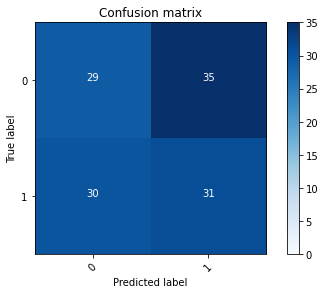

2022-08-22 17:04:53 - [Epoch Train: 51] loss: 0.0003, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:04:53 - [Epoch Valid: 51] loss: 2.7793, auc: 0.4306, acc: 0.4800, time: 6.00 s


 51%|█████████████████████▍                    | 51/100 [26:06<24:59, 30.60s/it]

2022-08-22 17:04:53 - EPOCH: 52
2022-08-22 17:04:55 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:04:57 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:04:59 - Train Step 30/121, train_loss: 0.0003
2022-08-22 17:05:01 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:05:03 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:05:05 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:05:07 - Train Step 70/121, train_loss: 0.0003
2022-08-22 17:05:09 - Train Step 80/121, train_loss: 0.0003
2022-08-22 17:05:11 - Train Step 90/121, train_loss: 0.0003
2022-08-22 17:05:13 - Train Step 100/121, train_loss: 0.0003
2022-08-22 17:05:15 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:05:16 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:05:18 - Valid Step 5/32, valid_loss: 4.2182
2022-08-22 17:05:19 - Valid Step 10/32, valid_loss: 3.0785
2022-08-22 17:05:20 - Valid Step 15/32, valid_loss: 2.9595
2022-08-22 17:05:21

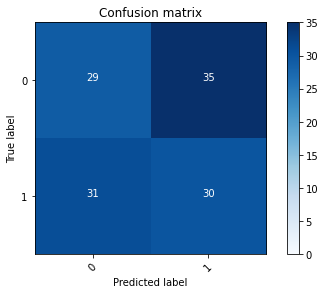

2022-08-22 17:05:23 - [Epoch Train: 52] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:05:23 - [Epoch Valid: 52] loss: 2.7863, auc: 0.4334, acc: 0.4720, time: 6.00 s


 52%|█████████████████████▊                    | 52/100 [26:36<24:26, 30.56s/it]

2022-08-22 17:05:23 - EPOCH: 53
2022-08-22 17:05:26 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:05:27 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:05:29 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:05:31 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:05:33 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:05:35 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:05:37 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:05:39 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:05:41 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:05:43 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:05:45 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:05:47 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:05:48 - Valid Step 5/32, valid_loss: 2.3888
2022-08-22 17:05:49 - Valid Step 10/32, valid_loss: 2.4089
2022-08-22 17:05:50 - Valid Step 15/32, valid_loss: 2.5813
2022-08-22 17:05:51

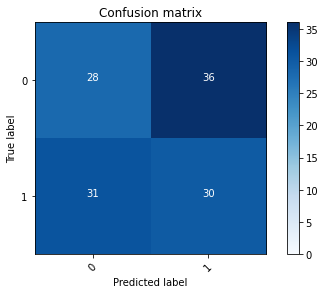

2022-08-22 17:05:54 - [Epoch Train: 53] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:05:54 - [Epoch Valid: 53] loss: 2.7759, auc: 0.4301, acc: 0.4640, time: 6.00 s


 53%|██████████████████████▎                   | 53/100 [27:07<23:56, 30.56s/it]

2022-08-22 17:05:54 - EPOCH: 54
2022-08-22 17:05:56 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:05:58 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:06:00 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:06:02 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:06:04 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:06:06 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:06:08 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:06:10 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:06:12 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:06:14 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:06:16 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:06:18 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:06:20 - Valid Step 5/32, valid_loss: 1.9397
2022-08-22 17:06:21 - Valid Step 10/32, valid_loss: 1.7432
2022-08-22 17:06:22 - Valid Step 15/32, valid_loss: 2.0585
2022-08-22 17:06:23

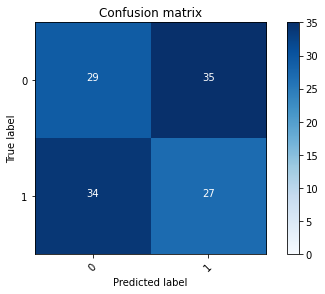

2022-08-22 17:06:25 - [Epoch Train: 54] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:06:25 - [Epoch Valid: 54] loss: 2.6005, auc: 0.4306, acc: 0.4480, time: 6.00 s


 54%|██████████████████████▋                   | 54/100 [27:38<23:34, 30.75s/it]

2022-08-22 17:06:25 - EPOCH: 55
2022-08-22 17:06:27 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:06:29 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:06:31 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:06:33 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:06:35 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:06:37 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:06:39 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:06:41 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:06:43 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:06:45 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:06:47 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:06:49 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:06:50 - Valid Step 5/32, valid_loss: 1.6450
2022-08-22 17:06:51 - Valid Step 10/32, valid_loss: 2.5281
2022-08-22 17:06:52 - Valid Step 15/32, valid_loss: 2.3120
2022-08-22 17:06:53

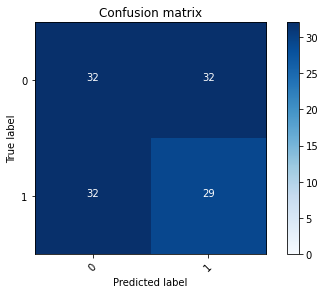

2022-08-22 17:06:55 - [Epoch Train: 55] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:06:55 - [Epoch Valid: 55] loss: 2.7900, auc: 0.4319, acc: 0.4880, time: 6.00 s


 55%|███████████████████████                   | 55/100 [28:08<22:59, 30.67s/it]

2022-08-22 17:06:55 - EPOCH: 56
2022-08-22 17:06:58 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:07:00 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:07:02 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:07:04 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:07:06 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:07:08 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:07:10 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:07:11 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:07:13 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:07:15 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:07:17 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:07:19 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:07:21 - Valid Step 5/32, valid_loss: 3.5159
2022-08-22 17:07:21 - Valid Step 10/32, valid_loss: 3.1077
2022-08-22 17:07:23 - Valid Step 15/32, valid_loss: 2.8540
2022-08-22 17:07:23

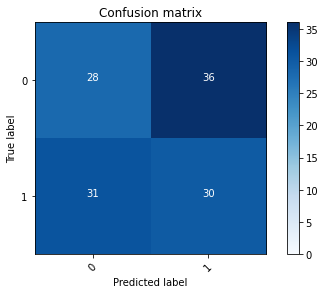

2022-08-22 17:07:26 - [Epoch Train: 56] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:07:26 - [Epoch Valid: 56] loss: 2.9809, auc: 0.4303, acc: 0.4640, time: 6.00 s


 56%|███████████████████████▌                  | 56/100 [28:39<22:27, 30.63s/it]

2022-08-22 17:07:26 - EPOCH: 57
2022-08-22 17:07:28 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:07:30 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:07:32 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:07:34 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:07:36 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:07:38 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:07:40 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:07:42 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:07:44 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:07:46 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:07:48 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:07:50 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:07:51 - Valid Step 5/32, valid_loss: 3.2284
2022-08-22 17:07:52 - Valid Step 10/32, valid_loss: 2.7331
2022-08-22 17:07:53 - Valid Step 15/32, valid_loss: 2.5766
2022-08-22 17:07:54

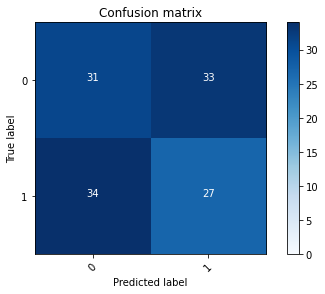

2022-08-22 17:07:57 - [Epoch Train: 57] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:07:57 - [Epoch Valid: 57] loss: 2.7332, auc: 0.4314, acc: 0.4640, time: 6.00 s


 57%|███████████████████████▉                  | 57/100 [29:09<21:56, 30.61s/it]

2022-08-22 17:07:57 - EPOCH: 58
2022-08-22 17:07:59 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:08:01 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:08:03 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:08:05 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:08:06 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:08:08 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:08:10 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:08:12 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:08:14 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:08:16 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:08:18 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:08:20 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:08:22 - Valid Step 5/32, valid_loss: 3.1780
2022-08-22 17:08:23 - Valid Step 10/32, valid_loss: 3.1887
2022-08-22 17:08:24 - Valid Step 15/32, valid_loss: 3.8082
2022-08-22 17:08:24

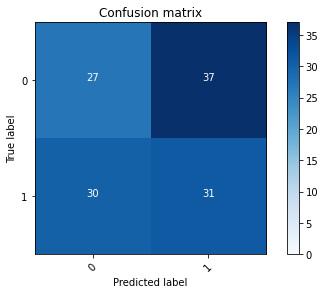

2022-08-22 17:08:27 - [Epoch Train: 58] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:08:27 - [Epoch Valid: 58] loss: 3.1027, auc: 0.4329, acc: 0.4640, time: 6.00 s


 58%|████████████████████████▎                 | 58/100 [29:40<21:23, 30.55s/it]

2022-08-22 17:08:27 - EPOCH: 59
2022-08-22 17:08:29 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:08:31 - Train Step 20/121, train_loss: 0.0002
2022-08-22 17:08:33 - Train Step 30/121, train_loss: 0.0002
2022-08-22 17:08:35 - Train Step 40/121, train_loss: 0.0002
2022-08-22 17:08:37 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:08:39 - Train Step 60/121, train_loss: 0.0002
2022-08-22 17:08:41 - Train Step 70/121, train_loss: 0.0002
2022-08-22 17:08:43 - Train Step 80/121, train_loss: 0.0002
2022-08-22 17:08:45 - Train Step 90/121, train_loss: 0.0002
2022-08-22 17:08:47 - Train Step 100/121, train_loss: 0.0002
2022-08-22 17:08:49 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:08:51 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:08:52 - Valid Step 5/32, valid_loss: 2.6710
2022-08-22 17:08:53 - Valid Step 10/32, valid_loss: 3.8714
2022-08-22 17:08:54 - Valid Step 15/32, valid_loss: 3.2146
2022-08-22 17:08:55

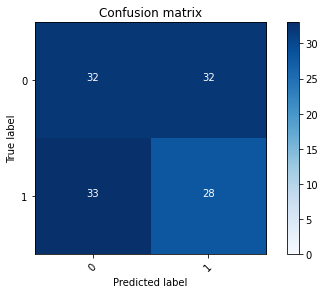

2022-08-22 17:08:58 - [Epoch Train: 59] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:08:58 - [Epoch Valid: 59] loss: 3.0095, auc: 0.4296, acc: 0.4800, time: 6.00 s


 59%|████████████████████████▊                 | 59/100 [30:10<20:54, 30.59s/it]

2022-08-22 17:08:58 - EPOCH: 60
2022-08-22 17:09:00 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:09:02 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:09:04 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:09:06 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:09:08 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:09:10 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:09:12 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:09:14 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:09:16 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:09:18 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:09:20 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:09:22 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:09:23 - Valid Step 5/32, valid_loss: 3.1745
2022-08-22 17:09:24 - Valid Step 10/32, valid_loss: 2.8088
2022-08-22 17:09:25 - Valid Step 15/32, valid_loss: 2.8700
2022-08-22 17:09:26

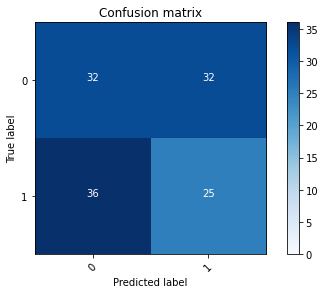

2022-08-22 17:09:29 - [Epoch Train: 60] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:09:29 - [Epoch Valid: 60] loss: 2.7459, auc: 0.4339, acc: 0.4560, time: 6.00 s


 60%|█████████████████████████▏                | 60/100 [30:41<20:27, 30.68s/it]

2022-08-22 17:09:29 - EPOCH: 61
2022-08-22 17:09:31 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:09:33 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:09:35 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:09:37 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:09:39 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:09:41 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:09:42 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:09:44 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:09:46 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:09:48 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:09:50 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:09:52 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:09:54 - Valid Step 5/32, valid_loss: 3.1174
2022-08-22 17:09:55 - Valid Step 10/32, valid_loss: 3.1636
2022-08-22 17:09:56 - Valid Step 15/32, valid_loss: 3.0739
2022-08-22 17:09:57

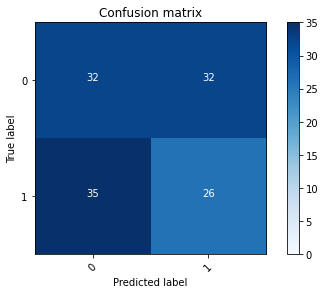

2022-08-22 17:09:59 - [Epoch Train: 61] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:09:59 - [Epoch Valid: 61] loss: 2.9202, auc: 0.4314, acc: 0.4640, time: 6.00 s


 61%|█████████████████████████▌                | 61/100 [31:12<19:55, 30.65s/it]

2022-08-22 17:09:59 - EPOCH: 62
2022-08-22 17:10:01 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:10:03 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:10:05 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:10:07 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:10:09 - Train Step 50/121, train_loss: 0.0002
2022-08-22 17:10:11 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:10:13 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:10:15 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:10:17 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:10:19 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:10:21 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:10:23 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:10:24 - Valid Step 5/32, valid_loss: 3.7579
2022-08-22 17:10:25 - Valid Step 10/32, valid_loss: 3.5606
2022-08-22 17:10:26 - Valid Step 15/32, valid_loss: 3.5044
2022-08-22 17:10:27

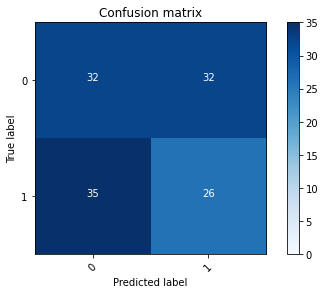

2022-08-22 17:10:29 - [Epoch Train: 62] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:10:29 - [Epoch Valid: 62] loss: 3.0559, auc: 0.4357, acc: 0.4640, time: 6.00 s


 62%|██████████████████████████                | 62/100 [31:42<19:20, 30.53s/it]

2022-08-22 17:10:29 - EPOCH: 63
2022-08-22 17:10:32 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:10:34 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:10:36 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:10:38 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:10:40 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:10:42 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:10:44 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:10:46 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:10:48 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:10:50 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:10:52 - Train Step 110/121, train_loss: 0.0002
2022-08-22 17:10:54 - Train Step 120/121, train_loss: 0.0002
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:10:55 - Valid Step 5/32, valid_loss: 3.4413
2022-08-22 17:10:56 - Valid Step 10/32, valid_loss: 3.0422
2022-08-22 17:10:57 - Valid Step 15/32, valid_loss: 3.1715
2022-08-22 17:10:58

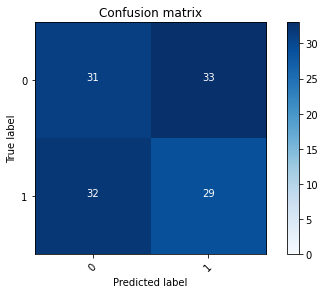

2022-08-22 17:11:00 - [Epoch Train: 63] loss: 0.0002, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:11:00 - [Epoch Valid: 63] loss: 3.0689, auc: 0.4344, acc: 0.4800, time: 6.00 s


 63%|██████████████████████████▍               | 63/100 [32:13<18:55, 30.68s/it]

2022-08-22 17:11:00 - EPOCH: 64
2022-08-22 17:11:03 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:11:05 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:11:06 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:11:08 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:11:10 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:11:12 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:11:14 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:11:16 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:11:18 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:11:20 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:11:22 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:11:24 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:11:26 - Valid Step 5/32, valid_loss: 3.4098
2022-08-22 17:11:26 - Valid Step 10/32, valid_loss: 3.1085
2022-08-22 17:11:28 - Valid Step 15/32, valid_loss: 2.9217
2022-08-22 17:11:29

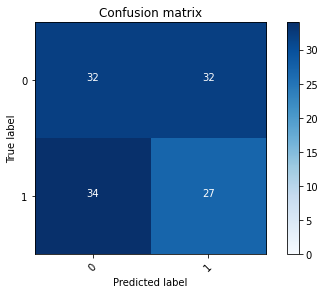

2022-08-22 17:11:31 - [Epoch Train: 64] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:11:31 - [Epoch Valid: 64] loss: 2.9534, auc: 0.4337, acc: 0.4720, time: 6.00 s


 64%|██████████████████████████▉               | 64/100 [32:44<18:23, 30.66s/it]

2022-08-22 17:11:31 - EPOCH: 65
2022-08-22 17:11:33 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:11:35 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:11:37 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:11:39 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:11:41 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:11:43 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:11:45 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:11:47 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:11:50 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:11:52 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:11:54 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:11:56 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:11:57 - Valid Step 5/32, valid_loss: 5.3343
2022-08-22 17:11:58 - Valid Step 10/32, valid_loss: 3.6745
2022-08-22 17:11:59 - Valid Step 15/32, valid_loss: 3.3918
2022-08-22 17:12:00

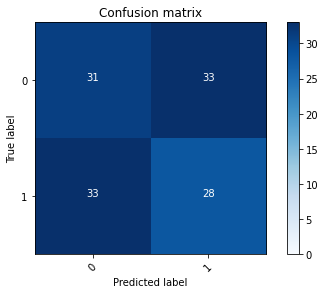

2022-08-22 17:12:02 - [Epoch Train: 65] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:12:02 - [Epoch Valid: 65] loss: 3.1737, auc: 0.4370, acc: 0.4720, time: 6.00 s


 65%|███████████████████████████▎              | 65/100 [33:15<17:58, 30.81s/it]

2022-08-22 17:12:02 - EPOCH: 66
2022-08-22 17:12:04 - Train Step 10/121, train_loss: 0.0002
2022-08-22 17:12:07 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:12:09 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:12:11 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:12:13 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:12:15 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:12:17 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:12:19 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:12:21 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:12:23 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:12:25 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:12:27 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:12:28 - Valid Step 5/32, valid_loss: 2.2657
2022-08-22 17:12:29 - Valid Step 10/32, valid_loss: 3.1284
2022-08-22 17:12:30 - Valid Step 15/32, valid_loss: 3.6832
2022-08-22 17:12:31

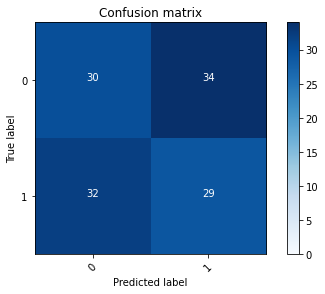

2022-08-22 17:12:34 - [Epoch Train: 66] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:12:34 - [Epoch Valid: 66] loss: 3.2232, auc: 0.4298, acc: 0.4720, time: 6.00 s


 66%|███████████████████████████▋              | 66/100 [33:46<17:34, 31.02s/it]

2022-08-22 17:12:34 - EPOCH: 67
2022-08-22 17:12:36 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:12:38 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:12:40 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:12:42 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:12:44 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:12:46 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:12:48 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:12:50 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:12:52 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:12:54 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:12:55 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:12:57 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:12:59 - Valid Step 5/32, valid_loss: 2.9655
2022-08-22 17:13:00 - Valid Step 10/32, valid_loss: 3.8425
2022-08-22 17:13:01 - Valid Step 15/32, valid_loss: 3.8231
2022-08-22 17:13:02

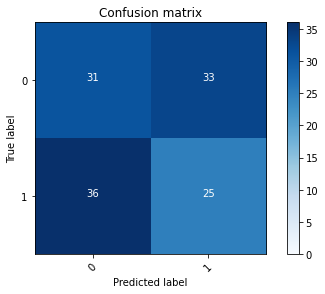

2022-08-22 17:13:04 - [Epoch Train: 67] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:13:04 - [Epoch Valid: 67] loss: 3.2106, auc: 0.4255, acc: 0.4480, time: 6.00 s


 67%|████████████████████████████▏             | 67/100 [34:17<16:57, 30.84s/it]

2022-08-22 17:13:04 - EPOCH: 68
2022-08-22 17:13:06 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:13:08 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:13:10 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:13:12 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:13:14 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:13:16 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:13:18 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:13:20 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:13:22 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:13:24 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:13:26 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:13:28 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:13:29 - Valid Step 5/32, valid_loss: 4.2570
2022-08-22 17:13:30 - Valid Step 10/32, valid_loss: 3.6692
2022-08-22 17:13:31 - Valid Step 15/32, valid_loss: 3.0010
2022-08-22 17:13:32

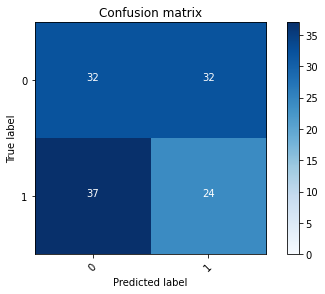

2022-08-22 17:13:35 - [Epoch Train: 68] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:13:35 - [Epoch Valid: 68] loss: 3.0911, auc: 0.4301, acc: 0.4480, time: 6.00 s


 68%|████████████████████████████▌             | 68/100 [34:47<16:22, 30.70s/it]

2022-08-22 17:13:35 - EPOCH: 69
2022-08-22 17:13:37 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:13:39 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:13:41 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:13:43 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:13:45 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:13:47 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:13:49 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:13:50 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:13:52 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:13:54 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:13:56 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:13:58 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:14:00 - Valid Step 5/32, valid_loss: 3.6531
2022-08-22 17:14:01 - Valid Step 10/32, valid_loss: 3.8219
2022-08-22 17:14:02 - Valid Step 15/32, valid_loss: 3.6854
2022-08-22 17:14:02

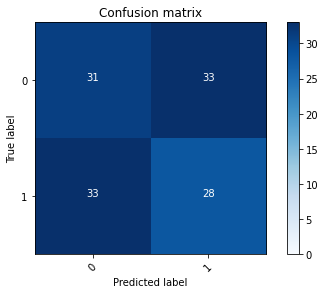

2022-08-22 17:14:05 - [Epoch Train: 69] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:14:05 - [Epoch Valid: 69] loss: 3.1278, auc: 0.4278, acc: 0.4720, time: 6.00 s


 69%|████████████████████████████▉             | 69/100 [35:18<15:49, 30.62s/it]

2022-08-22 17:14:05 - EPOCH: 70
2022-08-22 17:14:07 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:14:09 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:14:11 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:14:13 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:14:15 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:14:17 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:14:19 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:14:21 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:14:23 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:14:25 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:14:27 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:14:29 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:14:31 - Valid Step 5/32, valid_loss: 2.8293
2022-08-22 17:14:31 - Valid Step 10/32, valid_loss: 3.5635
2022-08-22 17:14:33 - Valid Step 15/32, valid_loss: 3.9859
2022-08-22 17:14:33

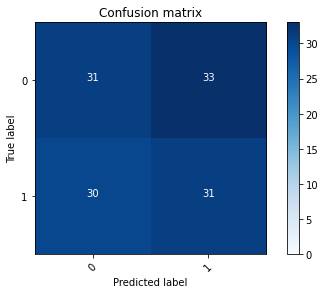

2022-08-22 17:14:36 - [Epoch Train: 70] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:14:36 - [Epoch Valid: 70] loss: 3.2221, auc: 0.4337, acc: 0.4960, time: 6.00 s


 70%|█████████████████████████████▍            | 70/100 [35:49<15:21, 30.71s/it]

2022-08-22 17:14:36 - EPOCH: 71
2022-08-22 17:14:38 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:14:40 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:14:42 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:14:44 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:14:46 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:14:48 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:14:50 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:14:52 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:14:54 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:14:56 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:14:57 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:14:59 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:15:01 - Valid Step 5/32, valid_loss: 3.1909
2022-08-22 17:15:02 - Valid Step 10/32, valid_loss: 3.1152
2022-08-22 17:15:03 - Valid Step 15/32, valid_loss: 3.4704
2022-08-22 17:15:04

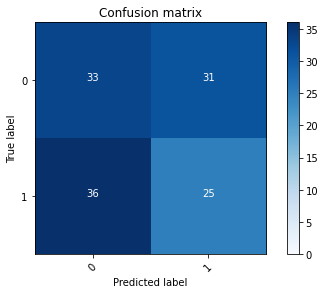

2022-08-22 17:15:06 - [Epoch Train: 71] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:15:06 - [Epoch Valid: 71] loss: 3.1794, auc: 0.4352, acc: 0.4640, time: 6.00 s


 71%|█████████████████████████████▊            | 71/100 [36:19<14:49, 30.66s/it]

2022-08-22 17:15:06 - EPOCH: 72
2022-08-22 17:15:09 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:15:11 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:15:13 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:15:15 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:15:16 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:15:18 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:15:20 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:15:22 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:15:24 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:15:26 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:15:28 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:15:30 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:15:32 - Valid Step 5/32, valid_loss: 3.4431
2022-08-22 17:15:32 - Valid Step 10/32, valid_loss: 2.8741
2022-08-22 17:15:34 - Valid Step 15/32, valid_loss: 3.5454
2022-08-22 17:15:34

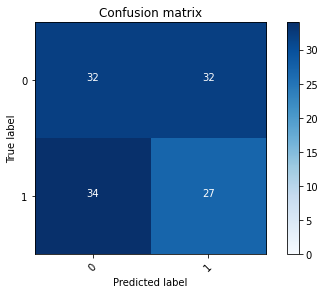

2022-08-22 17:15:37 - [Epoch Train: 72] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:15:37 - [Epoch Valid: 72] loss: 3.3468, auc: 0.4347, acc: 0.4720, time: 6.00 s


 72%|██████████████████████████████▏           | 72/100 [36:50<14:17, 30.63s/it]

2022-08-22 17:15:37 - EPOCH: 73
2022-08-22 17:15:39 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:15:41 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:15:43 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:15:45 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:15:47 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:15:49 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:15:51 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:15:53 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:15:55 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:15:57 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:15:59 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:16:00 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:16:02 - Valid Step 5/32, valid_loss: 3.3251
2022-08-22 17:16:03 - Valid Step 10/32, valid_loss: 4.0561
2022-08-22 17:16:04 - Valid Step 15/32, valid_loss: 4.0632
2022-08-22 17:16:05

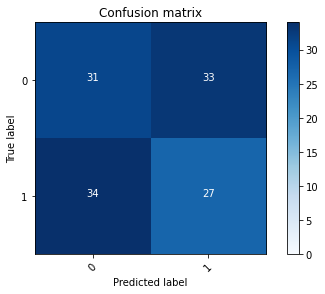

2022-08-22 17:16:07 - [Epoch Train: 73] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:16:07 - [Epoch Valid: 73] loss: 3.3537, auc: 0.4290, acc: 0.4640, time: 6.00 s


 73%|██████████████████████████████▋           | 73/100 [37:20<13:44, 30.52s/it]

2022-08-22 17:16:07 - EPOCH: 74
2022-08-22 17:16:09 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:16:11 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:16:13 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:16:15 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:16:17 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:16:19 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:16:21 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:16:23 - Train Step 80/121, train_loss: 0.0001
2022-08-22 17:16:25 - Train Step 90/121, train_loss: 0.0001
2022-08-22 17:16:27 - Train Step 100/121, train_loss: 0.0001
2022-08-22 17:16:29 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:16:31 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:16:32 - Valid Step 5/32, valid_loss: 2.0633
2022-08-22 17:16:33 - Valid Step 10/32, valid_loss: 2.7596
2022-08-22 17:16:34 - Valid Step 15/32, valid_loss: 3.0152
2022-08-22 17:16:35

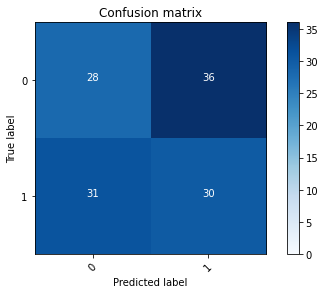

2022-08-22 17:16:38 - [Epoch Train: 74] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:16:38 - [Epoch Valid: 74] loss: 3.5425, auc: 0.4248, acc: 0.4640, time: 6.00 s


 74%|███████████████████████████████           | 74/100 [37:50<13:11, 30.45s/it]

2022-08-22 17:16:38 - EPOCH: 75
2022-08-22 17:16:40 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:16:42 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:16:44 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:16:46 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:16:47 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:16:49 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:16:51 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:16:53 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:16:55 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:16:57 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:16:59 - Train Step 110/121, train_loss: 0.0001
2022-08-22 17:17:01 - Train Step 120/121, train_loss: 0.0001
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:17:03 - Valid Step 5/32, valid_loss: 3.4071
2022-08-22 17:17:03 - Valid Step 10/32, valid_loss: 3.9478
2022-08-22 17:17:05 - Valid Step 15/32, valid_loss: 4.0075
2022-08-22 17:17:05

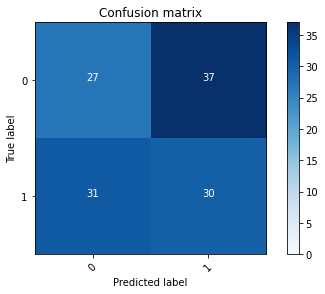

2022-08-22 17:17:08 - [Epoch Train: 75] loss: 0.0001, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:17:08 - [Epoch Valid: 75] loss: 3.6087, auc: 0.4200, acc: 0.4560, time: 6.00 s


 75%|███████████████████████████████▌          | 75/100 [38:21<12:40, 30.41s/it]

2022-08-22 17:17:08 - EPOCH: 76
2022-08-22 17:17:10 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:17:12 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:17:14 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:17:16 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:17:18 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:17:20 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:17:22 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:17:24 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:17:26 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:17:28 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:17:30 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:17:32 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:17:33 - Valid Step 5/32, valid_loss: 3.0296
2022-08-22 17:17:34 - Valid Step 10/32, valid_loss: 3.3277
2022-08-22 17:17:35 - Valid Step 15/32, valid_loss: 3.2951
2022-08-22 17:17:36

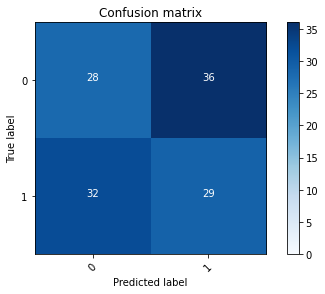

2022-08-22 17:17:39 - [Epoch Train: 76] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:17:39 - [Epoch Valid: 76] loss: 3.4482, auc: 0.4224, acc: 0.4560, time: 6.00 s


 76%|███████████████████████████████▉          | 76/100 [38:51<12:12, 30.52s/it]

2022-08-22 17:17:39 - EPOCH: 77
2022-08-22 17:17:41 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:17:43 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:17:45 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:17:47 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:17:49 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:17:51 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:17:53 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:17:55 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:17:57 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:17:58 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:18:00 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:18:02 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:18:04 - Valid Step 5/32, valid_loss: 3.0349
2022-08-22 17:18:05 - Valid Step 10/32, valid_loss: 4.3133
2022-08-22 17:18:06 - Valid Step 15/32, valid_loss: 3.9543
2022-08-22 17:18:07

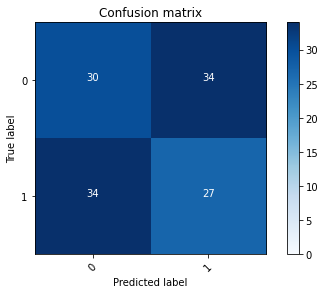

2022-08-22 17:18:09 - [Epoch Train: 77] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:18:09 - [Epoch Valid: 77] loss: 3.4640, auc: 0.4237, acc: 0.4560, time: 6.00 s


 77%|████████████████████████████████▎         | 77/100 [39:22<11:40, 30.47s/it]

2022-08-22 17:18:09 - EPOCH: 78
2022-08-22 17:18:11 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:18:13 - Train Step 20/121, train_loss: 0.0001
2022-08-22 17:18:15 - Train Step 30/121, train_loss: 0.0001
2022-08-22 17:18:17 - Train Step 40/121, train_loss: 0.0001
2022-08-22 17:18:19 - Train Step 50/121, train_loss: 0.0001
2022-08-22 17:18:21 - Train Step 60/121, train_loss: 0.0001
2022-08-22 17:18:23 - Train Step 70/121, train_loss: 0.0001
2022-08-22 17:18:25 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:18:27 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:18:29 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:18:31 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:18:33 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:18:34 - Valid Step 5/32, valid_loss: 2.7510
2022-08-22 17:18:35 - Valid Step 10/32, valid_loss: 2.9312
2022-08-22 17:18:36 - Valid Step 15/32, valid_loss: 3.2638
2022-08-22 17:18:37

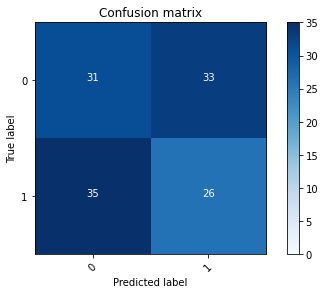

2022-08-22 17:18:40 - [Epoch Train: 78] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:18:40 - [Epoch Valid: 78] loss: 3.4575, auc: 0.4251, acc: 0.4560, time: 6.00 s


 78%|████████████████████████████████▊         | 78/100 [39:52<11:11, 30.52s/it]

2022-08-22 17:18:40 - EPOCH: 79
2022-08-22 17:18:42 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:18:44 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:18:46 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:18:48 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:18:50 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:18:51 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:18:53 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:18:55 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:18:57 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:18:59 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:19:01 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:19:03 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:19:05 - Valid Step 5/32, valid_loss: 2.9970
2022-08-22 17:19:06 - Valid Step 10/32, valid_loss: 3.7461
2022-08-22 17:19:07 - Valid Step 15/32, valid_loss: 3.6514
2022-08-22 17:19:08

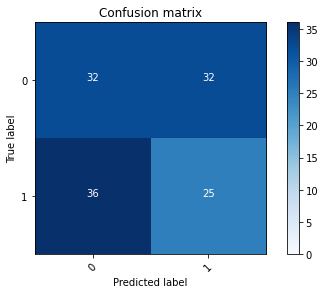

2022-08-22 17:19:10 - [Epoch Train: 79] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:19:10 - [Epoch Valid: 79] loss: 3.3810, auc: 0.4255, acc: 0.4560, time: 6.00 s


 79%|█████████████████████████████████▏        | 79/100 [40:23<10:40, 30.52s/it]

2022-08-22 17:19:10 - EPOCH: 80
2022-08-22 17:19:12 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:19:14 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:19:16 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:19:18 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:19:20 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:19:22 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:19:24 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:19:26 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:19:28 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:19:30 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:19:32 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:19:34 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:19:35 - Valid Step 5/32, valid_loss: 4.1203
2022-08-22 17:19:36 - Valid Step 10/32, valid_loss: 3.6417
2022-08-22 17:19:37 - Valid Step 15/32, valid_loss: 3.9166
2022-08-22 17:19:38

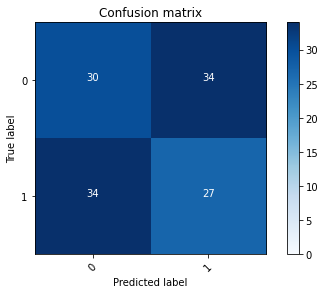

2022-08-22 17:19:40 - [Epoch Train: 80] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:19:40 - [Epoch Valid: 80] loss: 3.4717, auc: 0.4275, acc: 0.4560, time: 6.00 s


 80%|█████████████████████████████████▌        | 80/100 [40:53<10:08, 30.42s/it]

2022-08-22 17:19:40 - EPOCH: 81
2022-08-22 17:19:43 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:19:44 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:19:46 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:19:48 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:19:50 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:19:52 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:19:54 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:19:56 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:19:58 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:20:00 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:20:02 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:20:04 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:20:06 - Valid Step 5/32, valid_loss: 3.4217
2022-08-22 17:20:06 - Valid Step 10/32, valid_loss: 3.8058
2022-08-22 17:20:08 - Valid Step 15/32, valid_loss: 3.5617
2022-08-22 17:20:08

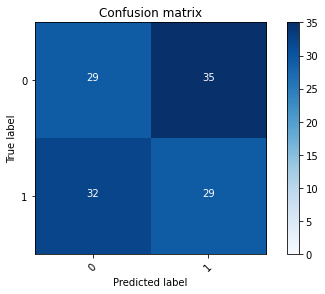

2022-08-22 17:20:11 - [Epoch Train: 81] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:20:11 - [Epoch Valid: 81] loss: 3.5977, auc: 0.4270, acc: 0.4640, time: 6.00 s


 81%|██████████████████████████████████        | 81/100 [41:24<09:38, 30.45s/it]

2022-08-22 17:20:11 - EPOCH: 82
2022-08-22 17:20:13 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:20:15 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:20:17 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:20:19 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:20:21 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:20:23 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:20:25 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:20:27 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:20:29 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:20:31 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:20:34 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:20:36 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:20:37 - Valid Step 5/32, valid_loss: 5.4015
2022-08-22 17:20:38 - Valid Step 10/32, valid_loss: 4.2283
2022-08-22 17:20:39 - Valid Step 15/32, valid_loss: 3.6207
2022-08-22 17:20:40

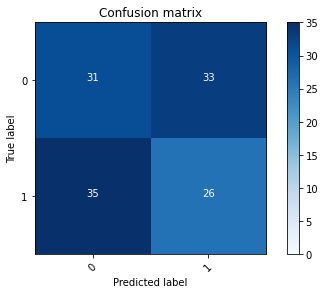

2022-08-22 17:20:42 - [Epoch Train: 82] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:20:42 - [Epoch Valid: 82] loss: 3.7007, auc: 0.4312, acc: 0.4560, time: 6.00 s


 82%|██████████████████████████████████▍       | 82/100 [41:55<09:14, 30.81s/it]

2022-08-22 17:20:42 - EPOCH: 83
2022-08-22 17:20:45 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:20:47 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:20:49 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:20:51 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:20:53 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:20:54 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:20:56 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:20:58 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:21:00 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:21:02 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:21:04 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:21:06 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:21:08 - Valid Step 5/32, valid_loss: 4.0318
2022-08-22 17:21:08 - Valid Step 10/32, valid_loss: 3.9217
2022-08-22 17:21:10 - Valid Step 15/32, valid_loss: 3.9442
2022-08-22 17:21:10

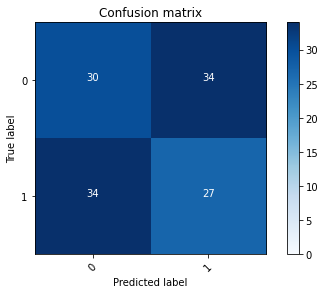

2022-08-22 17:21:13 - [Epoch Train: 83] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:21:13 - [Epoch Valid: 83] loss: 3.6098, auc: 0.4329, acc: 0.4560, time: 6.00 s


 83%|██████████████████████████████████▊       | 83/100 [42:26<08:41, 30.69s/it]

2022-08-22 17:21:13 - EPOCH: 84
2022-08-22 17:21:15 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:21:17 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:21:19 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:21:21 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:21:23 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:21:25 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:21:27 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:21:29 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:21:31 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:21:33 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:21:34 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:21:36 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:21:38 - Valid Step 5/32, valid_loss: 3.0553
2022-08-22 17:21:39 - Valid Step 10/32, valid_loss: 3.9777
2022-08-22 17:21:40 - Valid Step 15/32, valid_loss: 3.9739
2022-08-22 17:21:41

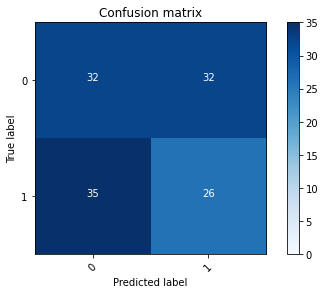

2022-08-22 17:21:43 - [Epoch Train: 84] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:21:43 - [Epoch Valid: 84] loss: 3.5173, auc: 0.4335, acc: 0.4640, time: 6.00 s


 84%|███████████████████████████████████▎      | 84/100 [42:56<08:09, 30.58s/it]

2022-08-22 17:21:43 - EPOCH: 85
2022-08-22 17:21:45 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:21:47 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:21:49 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:21:51 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:21:53 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:21:55 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:21:57 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:21:59 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:22:01 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:22:03 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:22:05 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:22:07 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:22:08 - Valid Step 5/32, valid_loss: 4.3366
2022-08-22 17:22:09 - Valid Step 10/32, valid_loss: 4.1899
2022-08-22 17:22:10 - Valid Step 15/32, valid_loss: 3.6273
2022-08-22 17:22:11

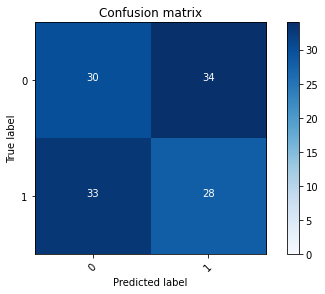

2022-08-22 17:22:14 - [Epoch Train: 85] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:22:14 - [Epoch Valid: 85] loss: 3.6996, auc: 0.4285, acc: 0.4640, time: 6.00 s


 85%|███████████████████████████████████▋      | 85/100 [43:27<07:38, 30.59s/it]

2022-08-22 17:22:14 - EPOCH: 86
2022-08-22 17:22:16 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:22:18 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:22:20 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:22:22 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:22:24 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:22:26 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:22:28 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:22:30 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:22:32 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:22:34 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:22:36 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:22:38 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:22:39 - Valid Step 5/32, valid_loss: 4.6114
2022-08-22 17:22:40 - Valid Step 10/32, valid_loss: 3.7281
2022-08-22 17:22:41 - Valid Step 15/32, valid_loss: 3.6730
2022-08-22 17:22:42

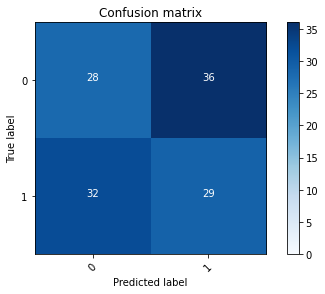

2022-08-22 17:22:44 - [Epoch Train: 86] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:22:44 - [Epoch Valid: 86] loss: 3.7955, auc: 0.4282, acc: 0.4560, time: 6.00 s


 86%|████████████████████████████████████      | 86/100 [43:57<07:08, 30.61s/it]

2022-08-22 17:22:44 - EPOCH: 87
2022-08-22 17:22:47 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:22:49 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:22:51 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:22:53 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:22:55 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:22:57 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:22:59 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:23:01 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:23:03 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:23:05 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:23:07 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:23:09 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:23:10 - Valid Step 5/32, valid_loss: 3.7701
2022-08-22 17:23:11 - Valid Step 10/32, valid_loss: 4.0594
2022-08-22 17:23:12 - Valid Step 15/32, valid_loss: 4.2445
2022-08-22 17:23:13

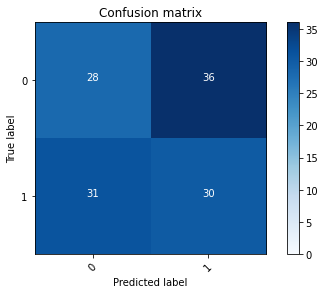

2022-08-22 17:23:15 - [Epoch Train: 87] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:23:15 - [Epoch Valid: 87] loss: 3.8524, auc: 0.4305, acc: 0.4640, time: 6.00 s


 87%|████████████████████████████████████▌     | 87/100 [44:28<06:38, 30.68s/it]

2022-08-22 17:23:15 - EPOCH: 88
2022-08-22 17:23:18 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:23:19 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:23:21 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:23:23 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:23:25 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:23:27 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:23:29 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:23:31 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:23:33 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:23:35 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:23:37 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:23:39 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:23:40 - Valid Step 5/32, valid_loss: 4.5943
2022-08-22 17:23:41 - Valid Step 10/32, valid_loss: 3.7834
2022-08-22 17:23:42 - Valid Step 15/32, valid_loss: 3.6777
2022-08-22 17:23:43

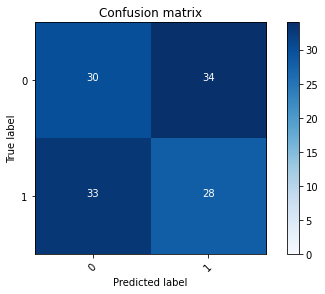

2022-08-22 17:23:46 - [Epoch Train: 88] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:23:46 - [Epoch Valid: 88] loss: 3.8363, auc: 0.4334, acc: 0.4640, time: 6.00 s


 88%|████████████████████████████████████▉     | 88/100 [44:58<06:07, 30.59s/it]

2022-08-22 17:23:46 - EPOCH: 89
2022-08-22 17:23:48 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:23:50 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:23:52 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:23:54 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:23:56 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:23:58 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:24:00 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:24:02 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:24:04 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:24:05 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:24:07 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:24:09 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:24:11 - Valid Step 5/32, valid_loss: 3.0547
2022-08-22 17:24:12 - Valid Step 10/32, valid_loss: 3.3582
2022-08-22 17:24:13 - Valid Step 15/32, valid_loss: 3.2659
2022-08-22 17:24:14

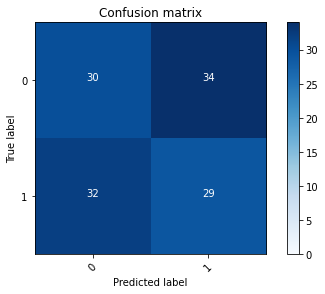

2022-08-22 17:24:16 - [Epoch Train: 89] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:24:16 - [Epoch Valid: 89] loss: 3.9207, auc: 0.4279, acc: 0.4720, time: 6.00 s


 89%|█████████████████████████████████████▍    | 89/100 [45:29<05:35, 30.52s/it]

2022-08-22 17:24:16 - EPOCH: 90
2022-08-22 17:24:18 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:24:20 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:24:22 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:24:24 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:24:26 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:24:28 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:24:30 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:24:32 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:24:34 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:24:36 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:24:38 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:24:40 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:24:42 - Valid Step 5/32, valid_loss: 1.8864
2022-08-22 17:24:42 - Valid Step 10/32, valid_loss: 2.9397
2022-08-22 17:24:43 - Valid Step 15/32, valid_loss: 3.0809
2022-08-22 17:24:44

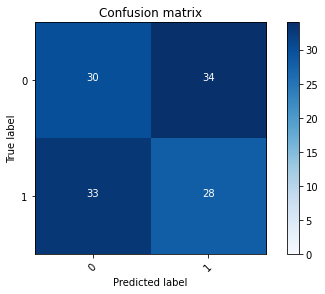

2022-08-22 17:24:47 - [Epoch Train: 90] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:24:47 - [Epoch Valid: 90] loss: 3.7777, auc: 0.4228, acc: 0.4640, time: 6.00 s


 90%|█████████████████████████████████████▊    | 90/100 [46:00<05:05, 30.57s/it]

2022-08-22 17:24:47 - EPOCH: 91
2022-08-22 17:24:49 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:24:51 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:24:53 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:24:55 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:24:57 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:24:59 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:25:01 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:25:03 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:25:05 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:25:06 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:25:08 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:25:10 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:25:12 - Valid Step 5/32, valid_loss: 4.2749
2022-08-22 17:25:13 - Valid Step 10/32, valid_loss: 4.2301
2022-08-22 17:25:14 - Valid Step 15/32, valid_loss: 4.0497
2022-08-22 17:25:14

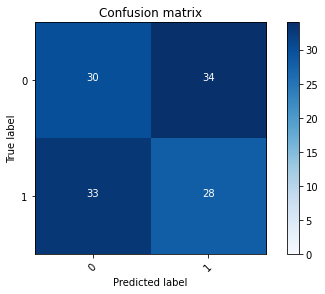

2022-08-22 17:25:17 - [Epoch Train: 91] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:25:17 - [Epoch Valid: 91] loss: 3.9208, auc: 0.4255, acc: 0.4640, time: 6.00 s


 91%|██████████████████████████████████████▏   | 91/100 [46:30<04:34, 30.45s/it]

2022-08-22 17:25:17 - EPOCH: 92
2022-08-22 17:25:19 - Train Step 10/121, train_loss: 0.0001
2022-08-22 17:25:21 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:25:23 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:25:25 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:25:27 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:25:29 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:25:31 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:25:33 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:25:35 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:25:37 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:25:39 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:25:41 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:25:43 - Valid Step 5/32, valid_loss: 3.4132
2022-08-22 17:25:43 - Valid Step 10/32, valid_loss: 2.6171
2022-08-22 17:25:45 - Valid Step 15/32, valid_loss: 3.4604
2022-08-22 17:25:45

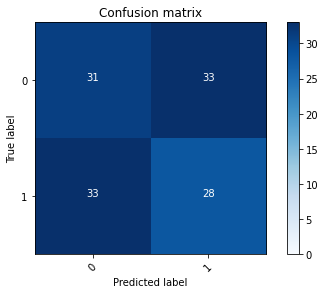

2022-08-22 17:25:48 - [Epoch Train: 92] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:25:48 - [Epoch Valid: 92] loss: 3.8236, auc: 0.4308, acc: 0.4720, time: 6.00 s


 92%|██████████████████████████████████████▋   | 92/100 [47:01<04:04, 30.60s/it]

2022-08-22 17:25:48 - EPOCH: 93
2022-08-22 17:25:50 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:25:52 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:25:54 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:25:56 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:25:58 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:26:00 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:26:02 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:26:04 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:26:06 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:26:08 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:26:10 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:26:12 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:26:13 - Valid Step 5/32, valid_loss: 2.8595
2022-08-22 17:26:14 - Valid Step 10/32, valid_loss: 2.9083
2022-08-22 17:26:15 - Valid Step 15/32, valid_loss: 3.6182
2022-08-22 17:26:16

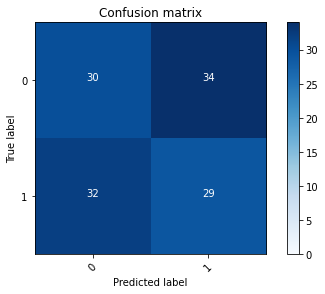

2022-08-22 17:26:18 - [Epoch Train: 93] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:26:18 - [Epoch Valid: 93] loss: 3.8584, auc: 0.4294, acc: 0.4720, time: 6.00 s


 93%|███████████████████████████████████████   | 93/100 [47:31<03:34, 30.59s/it]

2022-08-22 17:26:18 - EPOCH: 94
2022-08-22 17:26:21 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:26:23 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:26:24 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:26:26 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:26:28 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:26:30 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:26:32 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:26:34 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:26:36 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:26:38 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:26:40 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:26:42 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:26:44 - Valid Step 5/32, valid_loss: 3.6110
2022-08-22 17:26:44 - Valid Step 10/32, valid_loss: 4.3366
2022-08-22 17:26:46 - Valid Step 15/32, valid_loss: 4.7009
2022-08-22 17:26:46

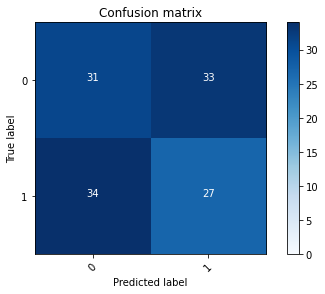

2022-08-22 17:26:49 - [Epoch Train: 94] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:26:49 - [Epoch Valid: 94] loss: 3.8362, auc: 0.4252, acc: 0.4640, time: 6.00 s


 94%|███████████████████████████████████████▍  | 94/100 [48:02<03:03, 30.56s/it]

2022-08-22 17:26:49 - EPOCH: 95
2022-08-22 17:26:51 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:26:53 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:26:55 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:26:57 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:26:59 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:27:01 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:27:03 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:27:05 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:27:07 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:27:09 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:27:11 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:27:13 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:27:15 - Valid Step 5/32, valid_loss: 3.4866
2022-08-22 17:27:15 - Valid Step 10/32, valid_loss: 4.5836
2022-08-22 17:27:16 - Valid Step 15/32, valid_loss: 3.8883
2022-08-22 17:27:17

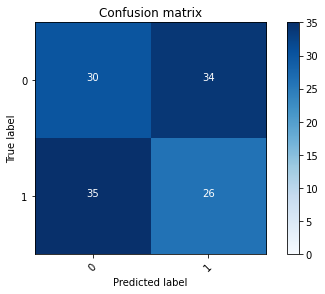

2022-08-22 17:27:20 - [Epoch Train: 95] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:27:20 - [Epoch Valid: 95] loss: 3.9764, auc: 0.4276, acc: 0.4480, time: 6.00 s


 95%|███████████████████████████████████████▉  | 95/100 [48:33<02:33, 30.63s/it]

2022-08-22 17:27:20 - EPOCH: 96
2022-08-22 17:27:22 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:27:24 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:27:26 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:27:28 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:27:30 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:27:32 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:27:34 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:27:36 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:27:37 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:27:39 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:27:41 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:27:43 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:27:45 - Valid Step 5/32, valid_loss: 3.9345
2022-08-22 17:27:46 - Valid Step 10/32, valid_loss: 3.8060
2022-08-22 17:27:47 - Valid Step 15/32, valid_loss: 4.2531
2022-08-22 17:27:48

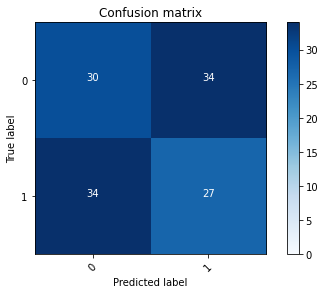

2022-08-22 17:27:50 - [Epoch Train: 96] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:27:50 - [Epoch Valid: 96] loss: 3.8858, auc: 0.4296, acc: 0.4560, time: 6.00 s


 96%|████████████████████████████████████████▎ | 96/100 [49:03<02:02, 30.56s/it]

2022-08-22 17:27:50 - EPOCH: 97
2022-08-22 17:27:52 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:27:54 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:27:56 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:27:58 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:28:00 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:28:02 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:28:04 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:28:06 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:28:08 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:28:10 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:28:12 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:28:14 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:28:15 - Valid Step 5/32, valid_loss: 3.3856
2022-08-22 17:28:16 - Valid Step 10/32, valid_loss: 3.7145
2022-08-22 17:28:17 - Valid Step 15/32, valid_loss: 3.8062
2022-08-22 17:28:18

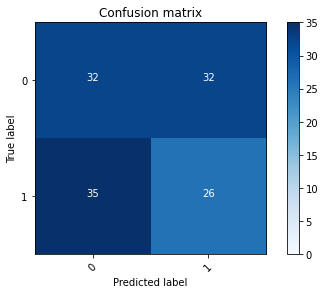

2022-08-22 17:28:20 - [Epoch Train: 97] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:28:20 - [Epoch Valid: 97] loss: 3.8092, auc: 0.4257, acc: 0.4640, time: 6.00 s


 97%|████████████████████████████████████████▋ | 97/100 [49:33<01:31, 30.44s/it]

2022-08-22 17:28:20 - EPOCH: 98
2022-08-22 17:28:23 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:28:25 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:28:27 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:28:29 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:28:31 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:28:32 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:28:34 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:28:36 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:28:38 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:28:40 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:28:42 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:28:44 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:28:46 - Valid Step 5/32, valid_loss: 3.7410
2022-08-22 17:28:46 - Valid Step 10/32, valid_loss: 3.7464
2022-08-22 17:28:48 - Valid Step 15/32, valid_loss: 3.4524
2022-08-22 17:28:48

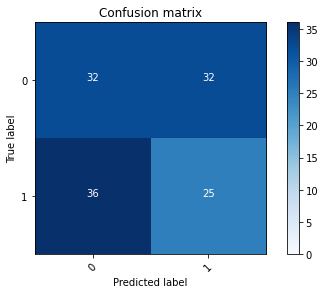

2022-08-22 17:28:51 - [Epoch Train: 98] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:28:51 - [Epoch Valid: 98] loss: 3.7111, auc: 0.4308, acc: 0.4560, time: 6.00 s


 98%|█████████████████████████████████████████▏| 98/100 [50:04<01:00, 30.48s/it]

2022-08-22 17:28:51 - EPOCH: 99
2022-08-22 17:28:53 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:28:55 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:28:57 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:28:59 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:29:01 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:29:03 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:29:05 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:29:07 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:29:09 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:29:11 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:29:13 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:29:14 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:29:16 - Valid Step 5/32, valid_loss: 4.2813
2022-08-22 17:29:17 - Valid Step 10/32, valid_loss: 4.0529
2022-08-22 17:29:18 - Valid Step 15/32, valid_loss: 3.7183
2022-08-22 17:29:19

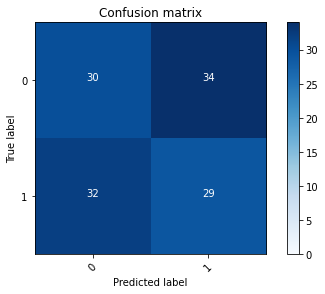

2022-08-22 17:29:21 - [Epoch Train: 99] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:29:21 - [Epoch Valid: 99] loss: 4.0235, auc: 0.4238, acc: 0.4720, time: 6.00 s


 99%|█████████████████████████████████████████▌| 99/100 [50:34<00:30, 30.41s/it]

2022-08-22 17:29:21 - EPOCH: 100
2022-08-22 17:29:23 - Train Step 10/121, train_loss: 0.0000
2022-08-22 17:29:25 - Train Step 20/121, train_loss: 0.0000
2022-08-22 17:29:27 - Train Step 30/121, train_loss: 0.0000
2022-08-22 17:29:29 - Train Step 40/121, train_loss: 0.0000
2022-08-22 17:29:31 - Train Step 50/121, train_loss: 0.0000
2022-08-22 17:29:33 - Train Step 60/121, train_loss: 0.0000
2022-08-22 17:29:35 - Train Step 70/121, train_loss: 0.0000
2022-08-22 17:29:37 - Train Step 80/121, train_loss: 0.0000
2022-08-22 17:29:39 - Train Step 90/121, train_loss: 0.0000
2022-08-22 17:29:41 - Train Step 100/121, train_loss: 0.0000
2022-08-22 17:29:43 - Train Step 110/121, train_loss: 0.0000
2022-08-22 17:29:45 - Train Step 120/121, train_loss: 0.0000
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:29:46 - Valid Step 5/32, valid_loss: 2.3998
2022-08-22 17:29:47 - Valid Step 10/32, valid_loss: 3.1469
2022-08-22 17:29:48 - Valid Step 15/32, valid_loss: 3.5284
2022-08-22 17:29:4

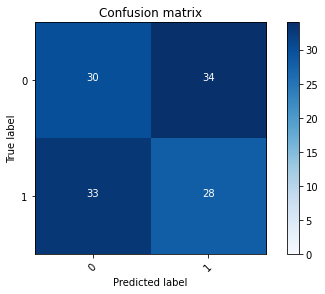

2022-08-22 17:29:51 - [Epoch Train: 100] loss: 0.0000, auc: 1.0000, acc: 1.0000, time: 23.00 s            
2022-08-22 17:29:51 - [Epoch Valid: 100] loss: 3.9637, auc: 0.4257, acc: 0.4640, time: 6.00 s


100%|█████████████████████████████████████████| 100/100 [51:04<00:00, 30.65s/it]

-- FOLD N:4
Train origin: m
Type: KLF
2022-08-22 17:29:51 - (M0) Train/Val datasets size: 270
2022-08-22 17:29:51 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd6f6880>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd947460>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606


[([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 129, 130, 131, 132, 134, 135, 136, 138, 139, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 164, 165, 166, 167, 169, 170, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 201, 202, 203, 206, 207, 208, 209, 210, 211, 212, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 249, 251, 252, 253, 254, 255, 256, 257, 258, 261, 263, 266, 267, 268, 269, 270, 271, 272, 273, 

  0%|                                                   | 0/100 [00:00<?, ?it/s]

2022-08-22 17:31:05 - EPOCH: 1
2022-08-22 17:31:07 - Train Step 10/122, train_loss: 0.6985
2022-08-22 17:31:09 - Train Step 20/122, train_loss: 0.6958
2022-08-22 17:31:11 - Train Step 30/122, train_loss: 0.6937
2022-08-22 17:31:13 - Train Step 40/122, train_loss: 0.6934
2022-08-22 17:31:15 - Train Step 50/122, train_loss: 0.6934
2022-08-22 17:31:17 - Train Step 60/122, train_loss: 0.6967
2022-08-22 17:31:19 - Train Step 70/122, train_loss: 0.6979
2022-08-22 17:31:21 - Train Step 80/122, train_loss: 0.6980
2022-08-22 17:31:23 - Train Step 90/122, train_loss: 0.6959
2022-08-22 17:31:25 - Train Step 100/122, train_loss: 0.6929
2022-08-22 17:31:27 - Train Step 110/122, train_loss: 0.6926
2022-08-22 17:31:29 - Train Step 120/122, train_loss: 0.6934
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:31:31 - Valid Step 5/30, valid_loss: 0.7099
2022-08-22 17:31:31 - Valid Step 10/30, valid_loss: 0.7154
2022-08-22 17:31:33 - Valid Step 15/30, valid_loss: 0.6873
2022-08-22 17:31:33 

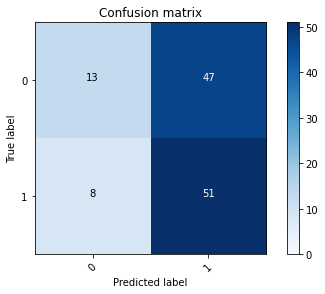

2022-08-22 17:31:35 - [Epoch Train: 1] loss: 0.6942, auc: 0.5175, acc: 0.5277, time: 24.00 s            
2022-08-22 17:31:35 - [Epoch Valid: 1] loss: 0.7025, auc: 0.5121, acc: 0.5378, time: 6.00 s
2022-08-22 17:31:36 - acc improved from 0.0000 to 0.5378. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.703-acc0.538-auc0.512.pth'


  1%|▍                                          | 1/100 [00:30<50:46, 30.77s/it]

2022-08-22 17:31:36 - EPOCH: 2
2022-08-22 17:31:38 - Train Step 10/122, train_loss: 0.6512
2022-08-22 17:31:40 - Train Step 20/122, train_loss: 0.6526
2022-08-22 17:31:42 - Train Step 30/122, train_loss: 0.6509
2022-08-22 17:31:44 - Train Step 40/122, train_loss: 0.6535
2022-08-22 17:31:45 - Train Step 50/122, train_loss: 0.6508
2022-08-22 17:31:47 - Train Step 60/122, train_loss: 0.6503
2022-08-22 17:31:49 - Train Step 70/122, train_loss: 0.6468
2022-08-22 17:31:51 - Train Step 80/122, train_loss: 0.6500
2022-08-22 17:31:53 - Train Step 90/122, train_loss: 0.6462
2022-08-22 17:31:55 - Train Step 100/122, train_loss: 0.6475
2022-08-22 17:31:57 - Train Step 110/122, train_loss: 0.6496
2022-08-22 17:31:59 - Train Step 120/122, train_loss: 0.6498
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:32:01 - Valid Step 5/30, valid_loss: 0.6800
2022-08-22 17:32:02 - Valid Step 10/30, valid_loss: 0.6566
2022-08-22 17:32:03 - Valid Step 15/30, valid_loss: 0.6921
2022-08-22 17:32:04 

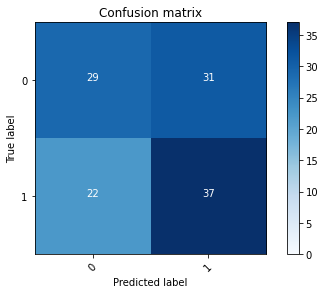

2022-08-22 17:32:06 - [Epoch Train: 2] loss: 0.6511, auc: 0.6981, acc: 0.6407, time: 23.00 s            
2022-08-22 17:32:06 - [Epoch Valid: 2] loss: 0.7125, auc: 0.5181, acc: 0.5546, time: 6.00 s
2022-08-22 17:32:06 - acc improved from 0.5378 to 0.5546. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.713-acc0.555-auc0.518.pth'


  2%|▊                                          | 2/100 [01:01<49:52, 30.53s/it]

2022-08-22 17:32:06 - EPOCH: 3
2022-08-22 17:32:08 - Train Step 10/122, train_loss: 0.5910
2022-08-22 17:32:10 - Train Step 20/122, train_loss: 0.5838
2022-08-22 17:32:12 - Train Step 30/122, train_loss: 0.5799
2022-08-22 17:32:14 - Train Step 40/122, train_loss: 0.5842
2022-08-22 17:32:16 - Train Step 50/122, train_loss: 0.5868
2022-08-22 17:32:18 - Train Step 60/122, train_loss: 0.5871
2022-08-22 17:32:20 - Train Step 70/122, train_loss: 0.5867
2022-08-22 17:32:22 - Train Step 80/122, train_loss: 0.5888
2022-08-22 17:32:24 - Train Step 90/122, train_loss: 0.5955
2022-08-22 17:32:26 - Train Step 100/122, train_loss: 0.5917
2022-08-22 17:32:28 - Train Step 110/122, train_loss: 0.5919
2022-08-22 17:32:30 - Train Step 120/122, train_loss: 0.5907
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:32:32 - Valid Step 5/30, valid_loss: 0.7904
2022-08-22 17:32:33 - Valid Step 10/30, valid_loss: 0.7898
2022-08-22 17:32:34 - Valid Step 15/30, valid_loss: 0.7843
2022-08-22 17:32:35 

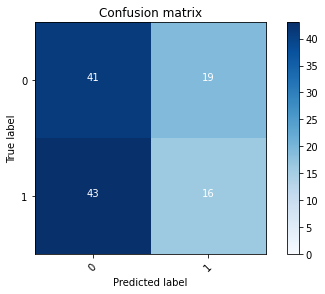

2022-08-22 17:32:37 - [Epoch Train: 3] loss: 0.5918, auc: 0.7968, acc: 0.7064, time: 24.00 s            
2022-08-22 17:32:37 - [Epoch Valid: 3] loss: 0.7337, auc: 0.5079, acc: 0.4790, time: 6.00 s


  3%|█▎                                         | 3/100 [01:31<49:32, 30.65s/it]

2022-08-22 17:32:37 - EPOCH: 4
2022-08-22 17:32:39 - Train Step 10/122, train_loss: 0.4991
2022-08-22 17:32:41 - Train Step 20/122, train_loss: 0.4993
2022-08-22 17:32:43 - Train Step 30/122, train_loss: 0.5106
2022-08-22 17:32:45 - Train Step 40/122, train_loss: 0.5104
2022-08-22 17:32:46 - Train Step 50/122, train_loss: 0.5278
2022-08-22 17:32:48 - Train Step 60/122, train_loss: 0.5146
2022-08-22 17:32:50 - Train Step 70/122, train_loss: 0.5103
2022-08-22 17:32:52 - Train Step 80/122, train_loss: 0.5018
2022-08-22 17:32:54 - Train Step 90/122, train_loss: 0.5018
2022-08-22 17:32:56 - Train Step 100/122, train_loss: 0.4969
2022-08-22 17:32:58 - Train Step 110/122, train_loss: 0.4994
2022-08-22 17:33:00 - Train Step 120/122, train_loss: 0.4973
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:33:02 - Valid Step 5/30, valid_loss: 0.7577
2022-08-22 17:33:03 - Valid Step 10/30, valid_loss: 0.8070
2022-08-22 17:33:04 - Valid Step 15/30, valid_loss: 0.8128
2022-08-22 17:33:05 

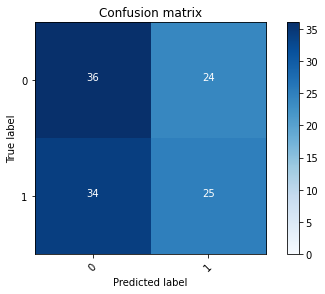

2022-08-22 17:33:07 - [Epoch Train: 4] loss: 0.4982, auc: 0.8835, acc: 0.8008, time: 23.00 s            
2022-08-22 17:33:07 - [Epoch Valid: 4] loss: 0.7946, auc: 0.5158, acc: 0.5126, time: 6.00 s


  4%|█▋                                         | 4/100 [02:02<48:43, 30.45s/it]

2022-08-22 17:33:07 - EPOCH: 5
2022-08-22 17:33:09 - Train Step 10/122, train_loss: 0.3889
2022-08-22 17:33:11 - Train Step 20/122, train_loss: 0.3666
2022-08-22 17:33:13 - Train Step 30/122, train_loss: 0.3747
2022-08-22 17:33:15 - Train Step 40/122, train_loss: 0.3712
2022-08-22 17:33:17 - Train Step 50/122, train_loss: 0.3639
2022-08-22 17:33:19 - Train Step 60/122, train_loss: 0.3639
2022-08-22 17:33:21 - Train Step 70/122, train_loss: 0.3749
2022-08-22 17:33:23 - Train Step 80/122, train_loss: 0.3806
2022-08-22 17:33:25 - Train Step 90/122, train_loss: 0.3838
2022-08-22 17:33:27 - Train Step 100/122, train_loss: 0.3824
2022-08-22 17:33:28 - Train Step 110/122, train_loss: 0.3819
2022-08-22 17:33:30 - Train Step 120/122, train_loss: 0.3807
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:33:32 - Valid Step 5/30, valid_loss: 0.8385
2022-08-22 17:33:33 - Valid Step 10/30, valid_loss: 0.7852
2022-08-22 17:33:34 - Valid Step 15/30, valid_loss: 0.8682
2022-08-22 17:33:35 

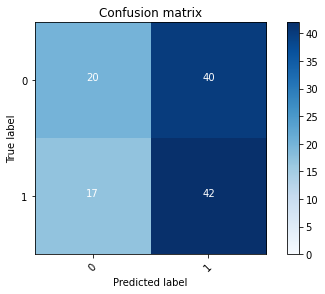

2022-08-22 17:33:37 - [Epoch Train: 5] loss: 0.3783, auc: 0.9496, acc: 0.8871, time: 23.00 s            
2022-08-22 17:33:37 - [Epoch Valid: 5] loss: 0.8964, auc: 0.5071, acc: 0.5210, time: 6.00 s


  5%|██▏                                        | 5/100 [02:32<48:04, 30.36s/it]

2022-08-22 17:33:37 - EPOCH: 6
2022-08-22 17:33:39 - Train Step 10/122, train_loss: 0.2375
2022-08-22 17:33:41 - Train Step 20/122, train_loss: 0.2662
2022-08-22 17:33:43 - Train Step 30/122, train_loss: 0.2696
2022-08-22 17:33:45 - Train Step 40/122, train_loss: 0.2626
2022-08-22 17:33:47 - Train Step 50/122, train_loss: 0.2617
2022-08-22 17:33:49 - Train Step 60/122, train_loss: 0.2532
2022-08-22 17:33:51 - Train Step 70/122, train_loss: 0.2525
2022-08-22 17:33:53 - Train Step 80/122, train_loss: 0.2521
2022-08-22 17:33:55 - Train Step 90/122, train_loss: 0.2532
2022-08-22 17:33:57 - Train Step 100/122, train_loss: 0.2524
2022-08-22 17:33:59 - Train Step 110/122, train_loss: 0.2542
2022-08-22 17:34:01 - Train Step 120/122, train_loss: 0.2547
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:34:02 - Valid Step 5/30, valid_loss: 0.8601
2022-08-22 17:34:03 - Valid Step 10/30, valid_loss: 1.0402
2022-08-22 17:34:04 - Valid Step 15/30, valid_loss: 1.0570
2022-08-22 17:34:05 

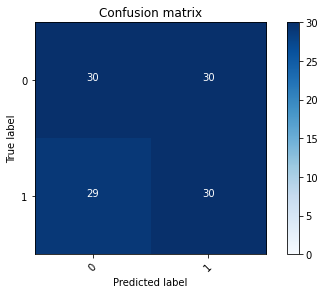

2022-08-22 17:34:07 - [Epoch Train: 6] loss: 0.2586, auc: 0.9848, acc: 0.9384, time: 24.00 s            
2022-08-22 17:34:07 - [Epoch Valid: 6] loss: 1.0195, auc: 0.4884, acc: 0.5042, time: 6.00 s


  6%|██▌                                        | 6/100 [03:02<47:37, 30.40s/it]

2022-08-22 17:34:07 - EPOCH: 7
2022-08-22 17:34:10 - Train Step 10/122, train_loss: 0.1519
2022-08-22 17:34:12 - Train Step 20/122, train_loss: 0.1658
2022-08-22 17:34:14 - Train Step 30/122, train_loss: 0.1594
2022-08-22 17:34:15 - Train Step 40/122, train_loss: 0.1602
2022-08-22 17:34:17 - Train Step 50/122, train_loss: 0.1533
2022-08-22 17:34:19 - Train Step 60/122, train_loss: 0.1484
2022-08-22 17:34:21 - Train Step 70/122, train_loss: 0.1438
2022-08-22 17:34:23 - Train Step 80/122, train_loss: 0.1455
2022-08-22 17:34:25 - Train Step 90/122, train_loss: 0.1486
2022-08-22 17:34:27 - Train Step 100/122, train_loss: 0.1488
2022-08-22 17:34:29 - Train Step 110/122, train_loss: 0.1517
2022-08-22 17:34:31 - Train Step 120/122, train_loss: 0.1523
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:34:33 - Valid Step 5/30, valid_loss: 1.2349
2022-08-22 17:34:34 - Valid Step 10/30, valid_loss: 1.0698
2022-08-22 17:34:35 - Valid Step 15/30, valid_loss: 0.9324
2022-08-22 17:34:36 

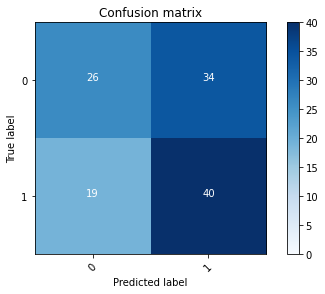

2022-08-22 17:34:38 - [Epoch Train: 7] loss: 0.1518, auc: 0.9984, acc: 0.9836, time: 24.00 s            
2022-08-22 17:34:38 - [Epoch Valid: 7] loss: 1.1164, auc: 0.5045, acc: 0.5546, time: 6.00 s
2022-08-22 17:34:38 - acc improved from 0.5546 to 0.5546. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e7-loss1.116-acc0.555-auc0.505.pth'


  7%|███                                        | 7/100 [03:33<47:04, 30.37s/it]

2022-08-22 17:34:38 - EPOCH: 8
2022-08-22 17:34:40 - Train Step 10/122, train_loss: 0.0810
2022-08-22 17:34:42 - Train Step 20/122, train_loss: 0.0820
2022-08-22 17:34:44 - Train Step 30/122, train_loss: 0.0824
2022-08-22 17:34:46 - Train Step 40/122, train_loss: 0.0845
2022-08-22 17:34:48 - Train Step 50/122, train_loss: 0.0850
2022-08-22 17:34:50 - Train Step 60/122, train_loss: 0.0843
2022-08-22 17:34:52 - Train Step 70/122, train_loss: 0.0848
2022-08-22 17:34:54 - Train Step 80/122, train_loss: 0.0822
2022-08-22 17:34:56 - Train Step 90/122, train_loss: 0.0835
2022-08-22 17:34:58 - Train Step 100/122, train_loss: 0.0825
2022-08-22 17:35:00 - Train Step 110/122, train_loss: 0.0848
2022-08-22 17:35:02 - Train Step 120/122, train_loss: 0.0839
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:35:03 - Valid Step 5/30, valid_loss: 0.8533
2022-08-22 17:35:04 - Valid Step 10/30, valid_loss: 0.9227
2022-08-22 17:35:05 - Valid Step 15/30, valid_loss: 1.1230
2022-08-22 17:35:06 

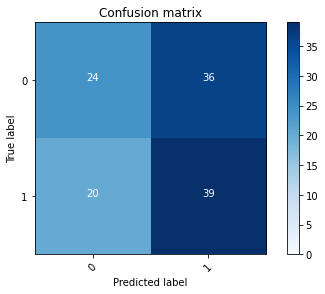

2022-08-22 17:35:08 - [Epoch Train: 8] loss: 0.0860, auc: 0.9995, acc: 0.9938, time: 24.00 s            
2022-08-22 17:35:08 - [Epoch Valid: 8] loss: 1.2855, auc: 0.5003, acc: 0.5294, time: 6.00 s


  8%|███▍                                       | 8/100 [04:03<46:32, 30.36s/it]

2022-08-22 17:35:08 - EPOCH: 9
2022-08-22 17:35:10 - Train Step 10/122, train_loss: 0.0484
2022-08-22 17:35:12 - Train Step 20/122, train_loss: 0.0523
2022-08-22 17:35:14 - Train Step 30/122, train_loss: 0.0517
2022-08-22 17:35:16 - Train Step 40/122, train_loss: 0.0554
2022-08-22 17:35:18 - Train Step 50/122, train_loss: 0.0518
2022-08-22 17:35:20 - Train Step 60/122, train_loss: 0.0528
2022-08-22 17:35:22 - Train Step 70/122, train_loss: 0.0517
2022-08-22 17:35:24 - Train Step 80/122, train_loss: 0.0506
2022-08-22 17:35:26 - Train Step 90/122, train_loss: 0.0513
2022-08-22 17:35:28 - Train Step 100/122, train_loss: 0.0493
2022-08-22 17:35:30 - Train Step 110/122, train_loss: 0.0488
2022-08-22 17:35:32 - Train Step 120/122, train_loss: 0.0478
Adjusting learning rate of group 0 to 1.0000e-04.
2022-08-22 17:35:34 - Valid Step 5/30, valid_loss: 0.8670
2022-08-22 17:35:34 - Valid Step 10/30, valid_loss: 1.4740
2022-08-22 17:35:36 - Valid Step 15/30, valid_loss: 1.2809
2022-08-22 17:35:36 

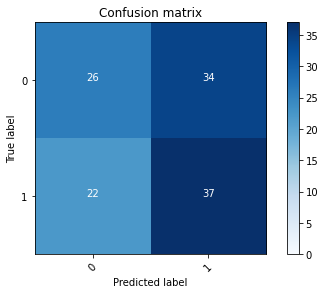

2022-08-22 17:35:39 - [Epoch Train: 9] loss: 0.0476, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:35:39 - [Epoch Valid: 9] loss: 1.3455, auc: 0.5020, acc: 0.5294, time: 6.00 s


  9%|███▊                                       | 9/100 [04:33<46:04, 30.38s/it]

2022-08-22 17:35:39 - EPOCH: 10
2022-08-22 17:35:41 - Train Step 10/122, train_loss: 0.0306
2022-08-22 17:35:43 - Train Step 20/122, train_loss: 0.0387
2022-08-22 17:35:45 - Train Step 30/122, train_loss: 0.0346
2022-08-22 17:35:47 - Train Step 40/122, train_loss: 0.0340
2022-08-22 17:35:48 - Train Step 50/122, train_loss: 0.0371
2022-08-22 17:35:50 - Train Step 60/122, train_loss: 0.0355
2022-08-22 17:35:52 - Train Step 70/122, train_loss: 0.0345
2022-08-22 17:35:54 - Train Step 80/122, train_loss: 0.0326
2022-08-22 17:35:56 - Train Step 90/122, train_loss: 0.0320
2022-08-22 17:35:58 - Train Step 100/122, train_loss: 0.0318
2022-08-22 17:36:00 - Train Step 110/122, train_loss: 0.0313
2022-08-22 17:36:02 - Train Step 120/122, train_loss: 0.0312
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:36:04 - Valid Step 5/30, valid_loss: 2.1488
2022-08-22 17:36:05 - Valid Step 10/30, valid_loss: 1.9213
2022-08-22 17:36:06 - Valid Step 15/30, valid_loss: 1.6205
2022-08-22 17:36:07

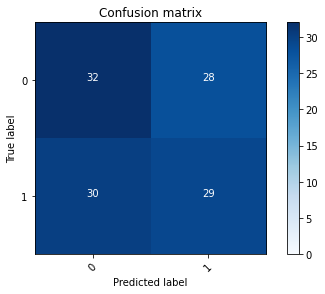

2022-08-22 17:36:09 - [Epoch Train: 10] loss: 0.0309, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:36:09 - [Epoch Valid: 10] loss: 1.4888, auc: 0.4867, acc: 0.5126, time: 6.00 s


 10%|████▏                                     | 10/100 [05:04<45:34, 30.39s/it]

2022-08-22 17:36:09 - EPOCH: 11
2022-08-22 17:36:11 - Train Step 10/122, train_loss: 0.0204
2022-08-22 17:36:13 - Train Step 20/122, train_loss: 0.0238
2022-08-22 17:36:15 - Train Step 30/122, train_loss: 0.0218
2022-08-22 17:36:17 - Train Step 40/122, train_loss: 0.0232
2022-08-22 17:36:19 - Train Step 50/122, train_loss: 0.0208
2022-08-22 17:36:21 - Train Step 60/122, train_loss: 0.0259
2022-08-22 17:36:23 - Train Step 70/122, train_loss: 0.0252
2022-08-22 17:36:25 - Train Step 80/122, train_loss: 0.0241
2022-08-22 17:36:27 - Train Step 90/122, train_loss: 0.0238
2022-08-22 17:36:29 - Train Step 100/122, train_loss: 0.0228
2022-08-22 17:36:31 - Train Step 110/122, train_loss: 0.0223
2022-08-22 17:36:32 - Train Step 120/122, train_loss: 0.0222
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:36:34 - Valid Step 5/30, valid_loss: 1.3504
2022-08-22 17:36:35 - Valid Step 10/30, valid_loss: 1.5288
2022-08-22 17:36:36 - Valid Step 15/30, valid_loss: 1.3782
2022-08-22 17:36:37

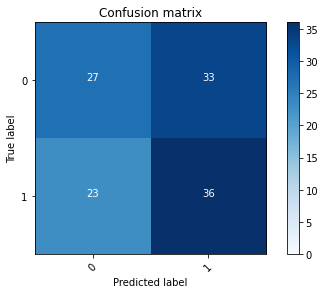

2022-08-22 17:36:39 - [Epoch Train: 11] loss: 0.0222, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:36:39 - [Epoch Valid: 11] loss: 1.5457, auc: 0.4944, acc: 0.5294, time: 6.00 s


 11%|████▌                                     | 11/100 [05:34<45:01, 30.35s/it]

2022-08-22 17:36:39 - EPOCH: 12
2022-08-22 17:36:41 - Train Step 10/122, train_loss: 0.0135
2022-08-22 17:36:43 - Train Step 20/122, train_loss: 0.0167
2022-08-22 17:36:45 - Train Step 30/122, train_loss: 0.0176
2022-08-22 17:36:47 - Train Step 40/122, train_loss: 0.0172
2022-08-22 17:36:49 - Train Step 50/122, train_loss: 0.0179
2022-08-22 17:36:51 - Train Step 60/122, train_loss: 0.0211
2022-08-22 17:36:53 - Train Step 70/122, train_loss: 0.0194
2022-08-22 17:36:55 - Train Step 80/122, train_loss: 0.0187
2022-08-22 17:36:57 - Train Step 90/122, train_loss: 0.0187
2022-08-22 17:36:59 - Train Step 100/122, train_loss: 0.0183
2022-08-22 17:37:01 - Train Step 110/122, train_loss: 0.0196
2022-08-22 17:37:03 - Train Step 120/122, train_loss: 0.0192
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:37:05 - Valid Step 5/30, valid_loss: 1.9628
2022-08-22 17:37:06 - Valid Step 10/30, valid_loss: 1.7657
2022-08-22 17:37:07 - Valid Step 15/30, valid_loss: 1.5268
2022-08-22 17:37:07

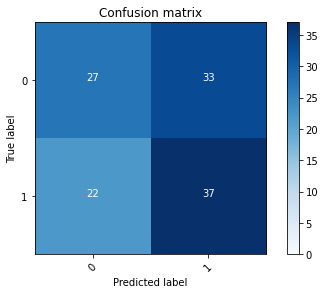

2022-08-22 17:37:09 - [Epoch Train: 12] loss: 0.0191, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:37:09 - [Epoch Valid: 12] loss: 1.6150, auc: 0.4969, acc: 0.5378, time: 6.00 s


 12%|█████                                     | 12/100 [06:04<44:28, 30.32s/it]

2022-08-22 17:37:09 - EPOCH: 13
2022-08-22 17:37:12 - Train Step 10/122, train_loss: 0.0152
2022-08-22 17:37:14 - Train Step 20/122, train_loss: 0.0155
2022-08-22 17:37:16 - Train Step 30/122, train_loss: 0.0153
2022-08-22 17:37:18 - Train Step 40/122, train_loss: 0.0146
2022-08-22 17:37:20 - Train Step 50/122, train_loss: 0.0136
2022-08-22 17:37:22 - Train Step 60/122, train_loss: 0.0130
2022-08-22 17:37:24 - Train Step 70/122, train_loss: 0.0131
2022-08-22 17:37:26 - Train Step 80/122, train_loss: 0.0146
2022-08-22 17:37:28 - Train Step 90/122, train_loss: 0.0142
2022-08-22 17:37:30 - Train Step 100/122, train_loss: 0.0159
2022-08-22 17:37:32 - Train Step 110/122, train_loss: 0.0158
2022-08-22 17:37:34 - Train Step 120/122, train_loss: 0.0156
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:37:35 - Valid Step 5/30, valid_loss: 1.9727
2022-08-22 17:37:36 - Valid Step 10/30, valid_loss: 1.8579
2022-08-22 17:37:37 - Valid Step 15/30, valid_loss: 1.5431
2022-08-22 17:37:38

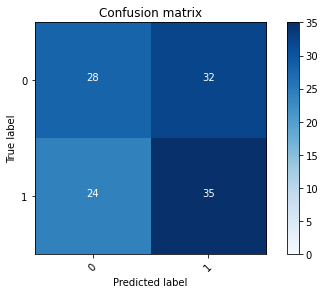

2022-08-22 17:37:40 - [Epoch Train: 13] loss: 0.0155, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:37:40 - [Epoch Valid: 13] loss: 1.6616, auc: 0.4952, acc: 0.5294, time: 6.00 s


 13%|█████▍                                    | 13/100 [06:35<44:11, 30.48s/it]

2022-08-22 17:37:40 - EPOCH: 14
2022-08-22 17:37:43 - Train Step 10/122, train_loss: 0.0095
2022-08-22 17:37:44 - Train Step 20/122, train_loss: 0.0091
2022-08-22 17:37:46 - Train Step 30/122, train_loss: 0.0102
2022-08-22 17:37:48 - Train Step 40/122, train_loss: 0.0104
2022-08-22 17:37:50 - Train Step 50/122, train_loss: 0.0128
2022-08-22 17:37:52 - Train Step 60/122, train_loss: 0.0150
2022-08-22 17:37:54 - Train Step 70/122, train_loss: 0.0142
2022-08-22 17:37:56 - Train Step 80/122, train_loss: 0.0136
2022-08-22 17:37:58 - Train Step 90/122, train_loss: 0.0130
2022-08-22 17:38:00 - Train Step 100/122, train_loss: 0.0129
2022-08-22 17:38:02 - Train Step 110/122, train_loss: 0.0128
2022-08-22 17:38:04 - Train Step 120/122, train_loss: 0.0126
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:38:06 - Valid Step 5/30, valid_loss: 2.5265
2022-08-22 17:38:07 - Valid Step 10/30, valid_loss: 2.3836
2022-08-22 17:38:08 - Valid Step 15/30, valid_loss: 2.0767
2022-08-22 17:38:09

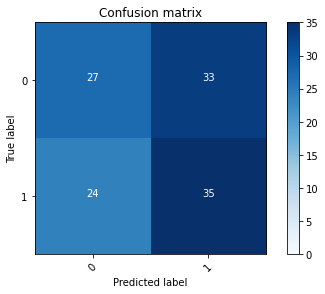

2022-08-22 17:38:11 - [Epoch Train: 14] loss: 0.0126, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 17:38:11 - [Epoch Valid: 14] loss: 1.7340, auc: 0.5011, acc: 0.5210, time: 6.00 s


 14%|█████▉                                    | 14/100 [07:06<43:40, 30.48s/it]

2022-08-22 17:38:11 - EPOCH: 15
2022-08-22 17:38:13 - Train Step 10/122, train_loss: 0.0115
2022-08-22 17:38:15 - Train Step 20/122, train_loss: 0.0097
2022-08-22 17:38:17 - Train Step 30/122, train_loss: 0.0092
2022-08-22 17:38:19 - Train Step 40/122, train_loss: 0.0090
2022-08-22 17:38:21 - Train Step 50/122, train_loss: 0.0090
2022-08-22 17:38:23 - Train Step 60/122, train_loss: 0.0087
2022-08-22 17:38:25 - Train Step 70/122, train_loss: 0.0087
2022-08-22 17:38:27 - Train Step 80/122, train_loss: 0.0093
2022-08-22 17:38:29 - Train Step 90/122, train_loss: 0.0097
2022-08-22 17:38:31 - Train Step 100/122, train_loss: 0.0096
2022-08-22 17:38:33 - Train Step 110/122, train_loss: 0.0095
2022-08-22 17:38:35 - Train Step 120/122, train_loss: 0.0110
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:38:36 - Valid Step 5/30, valid_loss: 0.9059
2022-08-22 17:38:37 - Valid Step 10/30, valid_loss: 1.0745
2022-08-22 17:38:38 - Valid Step 15/30, valid_loss: 1.7040
2022-08-22 17:38:39

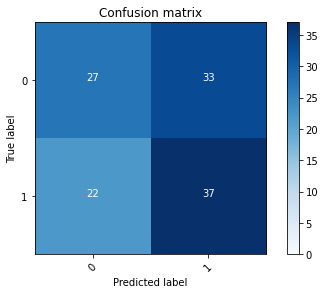

2022-08-22 17:38:41 - [Epoch Train: 15] loss: 0.0109, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:38:41 - [Epoch Valid: 15] loss: 1.7628, auc: 0.4963, acc: 0.5378, time: 6.00 s


 15%|██████▎                                   | 15/100 [07:36<43:09, 30.46s/it]

2022-08-22 17:38:41 - EPOCH: 16
2022-08-22 17:38:43 - Train Step 10/122, train_loss: 0.0059
2022-08-22 17:38:45 - Train Step 20/122, train_loss: 0.0069
2022-08-22 17:38:47 - Train Step 30/122, train_loss: 0.0101
2022-08-22 17:38:49 - Train Step 40/122, train_loss: 0.0097
2022-08-22 17:38:51 - Train Step 50/122, train_loss: 0.0089
2022-08-22 17:38:53 - Train Step 60/122, train_loss: 0.0085
2022-08-22 17:38:55 - Train Step 70/122, train_loss: 0.0087
2022-08-22 17:38:57 - Train Step 80/122, train_loss: 0.0114
2022-08-22 17:38:59 - Train Step 90/122, train_loss: 0.0108
2022-08-22 17:39:01 - Train Step 100/122, train_loss: 0.0109
2022-08-22 17:39:03 - Train Step 110/122, train_loss: 0.0105
2022-08-22 17:39:05 - Train Step 120/122, train_loss: 0.0102
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:39:07 - Valid Step 5/30, valid_loss: 1.9118
2022-08-22 17:39:07 - Valid Step 10/30, valid_loss: 2.7023
2022-08-22 17:39:09 - Valid Step 15/30, valid_loss: 2.1643
2022-08-22 17:39:09

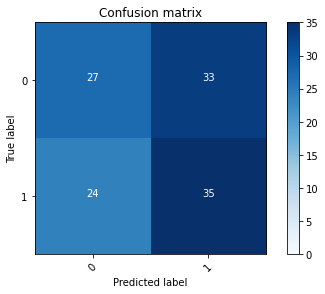

2022-08-22 17:39:12 - [Epoch Train: 16] loss: 0.0102, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:39:12 - [Epoch Valid: 16] loss: 1.8763, auc: 0.4949, acc: 0.5210, time: 6.00 s


 16%|██████▋                                   | 16/100 [08:06<42:36, 30.44s/it]

2022-08-22 17:39:12 - EPOCH: 17
2022-08-22 17:39:14 - Train Step 10/122, train_loss: 0.0075
2022-08-22 17:39:16 - Train Step 20/122, train_loss: 0.0072
2022-08-22 17:39:18 - Train Step 30/122, train_loss: 0.0067
2022-08-22 17:39:20 - Train Step 40/122, train_loss: 0.0113
2022-08-22 17:39:22 - Train Step 50/122, train_loss: 0.0109
2022-08-22 17:39:24 - Train Step 60/122, train_loss: 0.0106
2022-08-22 17:39:26 - Train Step 70/122, train_loss: 0.0102
2022-08-22 17:39:28 - Train Step 80/122, train_loss: 0.0115
2022-08-22 17:39:30 - Train Step 90/122, train_loss: 0.0111
2022-08-22 17:39:32 - Train Step 100/122, train_loss: 0.0105
2022-08-22 17:39:34 - Train Step 110/122, train_loss: 0.0099
2022-08-22 17:39:36 - Train Step 120/122, train_loss: 0.0094
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:39:37 - Valid Step 5/30, valid_loss: 2.2411
2022-08-22 17:39:38 - Valid Step 10/30, valid_loss: 2.2317
2022-08-22 17:39:39 - Valid Step 15/30, valid_loss: 1.9212
2022-08-22 17:39:40

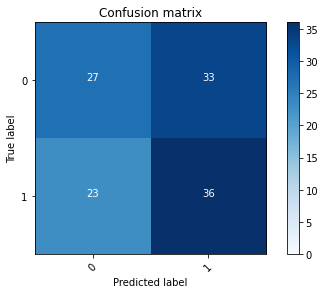

2022-08-22 17:39:42 - [Epoch Train: 17] loss: 0.0093, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:39:42 - [Epoch Valid: 17] loss: 1.8133, auc: 0.4983, acc: 0.5294, time: 6.00 s


 17%|███████▏                                  | 17/100 [08:37<42:08, 30.46s/it]

2022-08-22 17:39:42 - EPOCH: 18
2022-08-22 17:39:44 - Train Step 10/122, train_loss: 0.0049
2022-08-22 17:39:46 - Train Step 20/122, train_loss: 0.0053
2022-08-22 17:39:48 - Train Step 30/122, train_loss: 0.0052
2022-08-22 17:39:50 - Train Step 40/122, train_loss: 0.0127
2022-08-22 17:39:52 - Train Step 50/122, train_loss: 0.0110
2022-08-22 17:39:54 - Train Step 60/122, train_loss: 0.0100
2022-08-22 17:39:56 - Train Step 70/122, train_loss: 0.0093
2022-08-22 17:39:58 - Train Step 80/122, train_loss: 0.0091
2022-08-22 17:40:00 - Train Step 90/122, train_loss: 0.0088
2022-08-22 17:40:02 - Train Step 100/122, train_loss: 0.0084
2022-08-22 17:40:04 - Train Step 110/122, train_loss: 0.0104
2022-08-22 17:40:06 - Train Step 120/122, train_loss: 0.0101
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:40:08 - Valid Step 5/30, valid_loss: 1.6767
2022-08-22 17:40:08 - Valid Step 10/30, valid_loss: 1.0924
2022-08-22 17:40:10 - Valid Step 15/30, valid_loss: 1.7373
2022-08-22 17:40:10

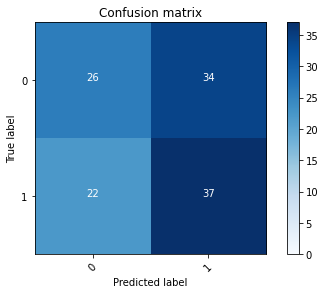

2022-08-22 17:40:12 - [Epoch Train: 18] loss: 0.0100, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:40:12 - [Epoch Valid: 18] loss: 1.9407, auc: 0.4941, acc: 0.5294, time: 6.00 s


 18%|███████▌                                  | 18/100 [09:07<41:34, 30.42s/it]

2022-08-22 17:40:12 - EPOCH: 19
2022-08-22 17:40:15 - Train Step 10/122, train_loss: 0.0041
2022-08-22 17:40:16 - Train Step 20/122, train_loss: 0.0107
2022-08-22 17:40:18 - Train Step 30/122, train_loss: 0.0089
2022-08-22 17:40:20 - Train Step 40/122, train_loss: 0.0171
2022-08-22 17:40:22 - Train Step 50/122, train_loss: 0.0144
2022-08-22 17:40:24 - Train Step 60/122, train_loss: 0.0130
2022-08-22 17:40:26 - Train Step 70/122, train_loss: 0.0117
2022-08-22 17:40:28 - Train Step 80/122, train_loss: 0.0110
2022-08-22 17:40:30 - Train Step 90/122, train_loss: 0.0104
2022-08-22 17:40:32 - Train Step 100/122, train_loss: 0.0097
2022-08-22 17:40:34 - Train Step 110/122, train_loss: 0.0092
2022-08-22 17:40:36 - Train Step 120/122, train_loss: 0.0088
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:40:37 - Valid Step 5/30, valid_loss: 3.0328
2022-08-22 17:40:38 - Valid Step 10/30, valid_loss: 2.4147
2022-08-22 17:40:39 - Valid Step 15/30, valid_loss: 2.0401
2022-08-22 17:40:40

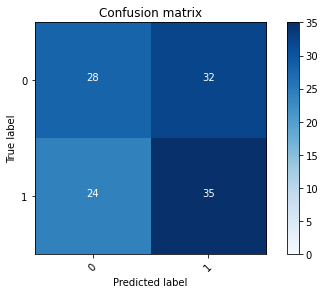

2022-08-22 17:40:42 - [Epoch Train: 19] loss: 0.0088, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:40:42 - [Epoch Valid: 19] loss: 1.9743, auc: 0.4969, acc: 0.5294, time: 6.00 s


 19%|███████▉                                  | 19/100 [09:37<40:50, 30.25s/it]

2022-08-22 17:40:42 - EPOCH: 20
2022-08-22 17:40:45 - Train Step 10/122, train_loss: 0.0045
2022-08-22 17:40:47 - Train Step 20/122, train_loss: 0.0047
2022-08-22 17:40:49 - Train Step 30/122, train_loss: 0.0104
2022-08-22 17:40:51 - Train Step 40/122, train_loss: 0.0122
2022-08-22 17:40:53 - Train Step 50/122, train_loss: 0.0106
2022-08-22 17:40:55 - Train Step 60/122, train_loss: 0.0095
2022-08-22 17:40:57 - Train Step 70/122, train_loss: 0.0088
2022-08-22 17:40:59 - Train Step 80/122, train_loss: 0.0082
2022-08-22 17:41:01 - Train Step 90/122, train_loss: 0.0078
2022-08-22 17:41:03 - Train Step 100/122, train_loss: 0.0076
2022-08-22 17:41:05 - Train Step 110/122, train_loss: 0.0072
2022-08-22 17:41:07 - Train Step 120/122, train_loss: 0.0071
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:41:09 - Valid Step 5/30, valid_loss: 3.5028
2022-08-22 17:41:10 - Valid Step 10/30, valid_loss: 2.7097
2022-08-22 17:41:11 - Valid Step 15/30, valid_loss: 2.1904
2022-08-22 17:41:12

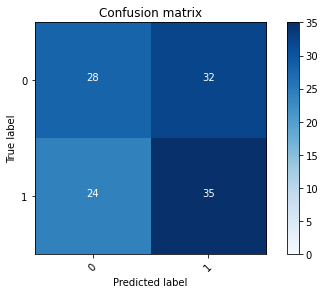

2022-08-22 17:41:14 - [Epoch Train: 20] loss: 0.0071, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 17:41:14 - [Epoch Valid: 20] loss: 1.9302, auc: 0.4927, acc: 0.5294, time: 6.00 s


 20%|████████▍                                 | 20/100 [10:09<40:51, 30.65s/it]

2022-08-22 17:41:14 - EPOCH: 21
2022-08-22 17:41:16 - Train Step 10/122, train_loss: 0.0029
2022-08-22 17:41:18 - Train Step 20/122, train_loss: 0.0042
2022-08-22 17:41:20 - Train Step 30/122, train_loss: 0.0176
2022-08-22 17:41:22 - Train Step 40/122, train_loss: 0.0146
2022-08-22 17:41:24 - Train Step 50/122, train_loss: 0.0124
2022-08-22 17:41:26 - Train Step 60/122, train_loss: 0.0158
2022-08-22 17:41:28 - Train Step 70/122, train_loss: 0.0141
2022-08-22 17:41:29 - Train Step 80/122, train_loss: 0.0129
2022-08-22 17:41:31 - Train Step 90/122, train_loss: 0.0120
2022-08-22 17:41:33 - Train Step 100/122, train_loss: 0.0110
2022-08-22 17:41:35 - Train Step 110/122, train_loss: 0.0103
2022-08-22 17:41:37 - Train Step 120/122, train_loss: 0.0097
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:41:39 - Valid Step 5/30, valid_loss: 1.7810
2022-08-22 17:41:40 - Valid Step 10/30, valid_loss: 2.3539
2022-08-22 17:41:41 - Valid Step 15/30, valid_loss: 2.5475
2022-08-22 17:41:42

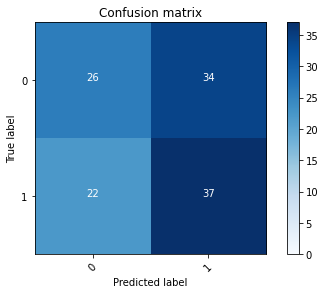

2022-08-22 17:41:44 - [Epoch Train: 21] loss: 0.0096, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 17:41:44 - [Epoch Valid: 21] loss: 2.0963, auc: 0.4932, acc: 0.5294, time: 6.00 s


 21%|████████▊                                 | 21/100 [10:39<40:03, 30.42s/it]

2022-08-22 17:41:44 - EPOCH: 22
2022-08-22 17:41:46 - Train Step 10/122, train_loss: 0.0055
2022-08-22 17:41:48 - Train Step 20/122, train_loss: 0.0050
2022-08-22 17:41:50 - Train Step 30/122, train_loss: 0.0044
2022-08-22 17:41:52 - Train Step 40/122, train_loss: 0.0076
2022-08-22 17:41:54 - Train Step 50/122, train_loss: 0.0065
2022-08-22 17:41:56 - Train Step 60/122, train_loss: 0.0098
2022-08-22 17:41:58 - Train Step 70/122, train_loss: 0.0088
2022-08-22 17:42:00 - Train Step 80/122, train_loss: 0.0080
2022-08-22 17:42:02 - Train Step 90/122, train_loss: 0.0074
2022-08-22 17:42:04 - Train Step 100/122, train_loss: 0.0069
2022-08-22 17:42:06 - Train Step 110/122, train_loss: 0.0067
2022-08-22 17:42:08 - Train Step 120/122, train_loss: 0.0065
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:42:09 - Valid Step 5/30, valid_loss: 1.4791
2022-08-22 17:42:10 - Valid Step 10/30, valid_loss: 1.6330
2022-08-22 17:42:11 - Valid Step 15/30, valid_loss: 1.4228
2022-08-22 17:42:12

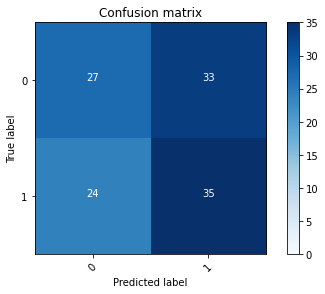

2022-08-22 17:42:14 - [Epoch Train: 22] loss: 0.0064, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:42:14 - [Epoch Valid: 22] loss: 1.9444, auc: 0.4935, acc: 0.5210, time: 6.00 s


 22%|█████████▏                                | 22/100 [11:09<39:36, 30.47s/it]

2022-08-22 17:42:14 - EPOCH: 23
2022-08-22 17:42:17 - Train Step 10/122, train_loss: 0.0022
2022-08-22 17:42:19 - Train Step 20/122, train_loss: 0.0137
2022-08-22 17:42:21 - Train Step 30/122, train_loss: 0.0100
2022-08-22 17:42:23 - Train Step 40/122, train_loss: 0.0081
2022-08-22 17:42:25 - Train Step 50/122, train_loss: 0.0072
2022-08-22 17:42:27 - Train Step 60/122, train_loss: 0.0065
2022-08-22 17:42:29 - Train Step 70/122, train_loss: 0.0059
2022-08-22 17:42:31 - Train Step 80/122, train_loss: 0.0056
2022-08-22 17:42:32 - Train Step 90/122, train_loss: 0.0053
2022-08-22 17:42:34 - Train Step 100/122, train_loss: 0.0050
2022-08-22 17:42:36 - Train Step 110/122, train_loss: 0.0049
2022-08-22 17:42:38 - Train Step 120/122, train_loss: 0.0090
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:42:40 - Valid Step 5/30, valid_loss: 2.7199
2022-08-22 17:42:41 - Valid Step 10/30, valid_loss: 2.9917
2022-08-22 17:42:42 - Valid Step 15/30, valid_loss: 2.5438
2022-08-22 17:42:43

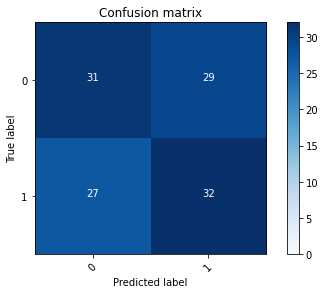

2022-08-22 17:42:45 - [Epoch Train: 23] loss: 0.0089, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:42:45 - [Epoch Valid: 23] loss: 2.0855, auc: 0.4952, acc: 0.5294, time: 6.00 s


 23%|█████████▋                                | 23/100 [11:40<39:12, 30.55s/it]

2022-08-22 17:42:45 - EPOCH: 24
2022-08-22 17:42:47 - Train Step 10/122, train_loss: 0.0021
2022-08-22 17:42:49 - Train Step 20/122, train_loss: 0.0022
2022-08-22 17:42:51 - Train Step 30/122, train_loss: 0.0061
2022-08-22 17:42:53 - Train Step 40/122, train_loss: 0.0113
2022-08-22 17:42:55 - Train Step 50/122, train_loss: 0.0095
2022-08-22 17:42:57 - Train Step 60/122, train_loss: 0.0082
2022-08-22 17:42:59 - Train Step 70/122, train_loss: 0.0074
2022-08-22 17:43:01 - Train Step 80/122, train_loss: 0.0067
2022-08-22 17:43:03 - Train Step 90/122, train_loss: 0.0064
2022-08-22 17:43:05 - Train Step 100/122, train_loss: 0.0062
2022-08-22 17:43:07 - Train Step 110/122, train_loss: 0.0058
2022-08-22 17:43:09 - Train Step 120/122, train_loss: 0.0055
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:43:11 - Valid Step 5/30, valid_loss: 2.3572
2022-08-22 17:43:11 - Valid Step 10/30, valid_loss: 2.3881
2022-08-22 17:43:12 - Valid Step 15/30, valid_loss: 2.1298
2022-08-22 17:43:13

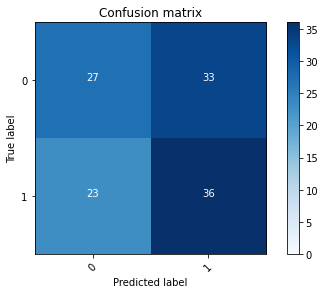

2022-08-22 17:43:15 - [Epoch Train: 24] loss: 0.0055, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:43:15 - [Epoch Valid: 24] loss: 2.1213, auc: 0.4960, acc: 0.5294, time: 6.00 s


 24%|██████████                                | 24/100 [12:10<38:36, 30.48s/it]

2022-08-22 17:43:15 - EPOCH: 25
2022-08-22 17:43:18 - Train Step 10/122, train_loss: 0.0029
2022-08-22 17:43:20 - Train Step 20/122, train_loss: 0.0027
2022-08-22 17:43:22 - Train Step 30/122, train_loss: 0.0026
2022-08-22 17:43:23 - Train Step 40/122, train_loss: 0.0025
2022-08-22 17:43:25 - Train Step 50/122, train_loss: 0.0024
2022-08-22 17:43:27 - Train Step 60/122, train_loss: 0.0026
2022-08-22 17:43:29 - Train Step 70/122, train_loss: 0.0025
2022-08-22 17:43:31 - Train Step 80/122, train_loss: 0.0057
2022-08-22 17:43:33 - Train Step 90/122, train_loss: 0.0072
2022-08-22 17:43:35 - Train Step 100/122, train_loss: 0.0068
2022-08-22 17:43:37 - Train Step 110/122, train_loss: 0.0063
2022-08-22 17:43:39 - Train Step 120/122, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:43:41 - Valid Step 5/30, valid_loss: 1.6383
2022-08-22 17:43:42 - Valid Step 10/30, valid_loss: 1.9752
2022-08-22 17:43:43 - Valid Step 15/30, valid_loss: 1.9765
2022-08-22 17:43:44

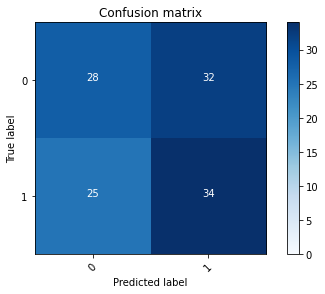

2022-08-22 17:43:46 - [Epoch Train: 25] loss: 0.0059, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 17:43:46 - [Epoch Valid: 25] loss: 2.1515, auc: 0.4958, acc: 0.5210, time: 6.00 s


 25%|██████████▌                               | 25/100 [12:40<38:01, 30.42s/it]

2022-08-22 17:43:46 - EPOCH: 26
2022-08-22 17:43:48 - Train Step 10/122, train_loss: 0.0199
2022-08-22 17:43:50 - Train Step 20/122, train_loss: 0.0112
2022-08-22 17:43:52 - Train Step 30/122, train_loss: 0.0192
2022-08-22 17:43:54 - Train Step 40/122, train_loss: 0.0153
2022-08-22 17:43:56 - Train Step 50/122, train_loss: 0.0129
2022-08-22 17:43:58 - Train Step 60/122, train_loss: 0.0111
2022-08-22 17:44:00 - Train Step 70/122, train_loss: 0.0098
2022-08-22 17:44:02 - Train Step 80/122, train_loss: 0.0088
2022-08-22 17:44:04 - Train Step 90/122, train_loss: 0.0080
2022-08-22 17:44:05 - Train Step 100/122, train_loss: 0.0074
2022-08-22 17:44:07 - Train Step 110/122, train_loss: 0.0069
2022-08-22 17:44:09 - Train Step 120/122, train_loss: 0.0066
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:44:11 - Valid Step 5/30, valid_loss: 2.2284
2022-08-22 17:44:12 - Valid Step 10/30, valid_loss: 1.8669
2022-08-22 17:44:13 - Valid Step 15/30, valid_loss: 2.0979
2022-08-22 17:44:14

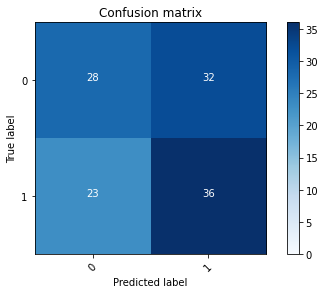

2022-08-22 17:44:16 - [Epoch Train: 26] loss: 0.0065, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:44:16 - [Epoch Valid: 26] loss: 2.2013, auc: 0.4907, acc: 0.5378, time: 6.00 s


 26%|██████████▉                               | 26/100 [13:11<37:30, 30.41s/it]

2022-08-22 17:44:16 - EPOCH: 27
2022-08-22 17:44:18 - Train Step 10/122, train_loss: 0.0020
2022-08-22 17:44:20 - Train Step 20/122, train_loss: 0.0018
2022-08-22 17:44:22 - Train Step 30/122, train_loss: 0.0017
2022-08-22 17:44:24 - Train Step 40/122, train_loss: 0.0018
2022-08-22 17:44:26 - Train Step 50/122, train_loss: 0.0019
2022-08-22 17:44:28 - Train Step 60/122, train_loss: 0.0050
2022-08-22 17:44:30 - Train Step 70/122, train_loss: 0.0045
2022-08-22 17:44:32 - Train Step 80/122, train_loss: 0.0072
2022-08-22 17:44:34 - Train Step 90/122, train_loss: 0.0066
2022-08-22 17:44:36 - Train Step 100/122, train_loss: 0.0062
2022-08-22 17:44:38 - Train Step 110/122, train_loss: 0.0057
2022-08-22 17:44:40 - Train Step 120/122, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:44:42 - Valid Step 5/30, valid_loss: 3.4152
2022-08-22 17:44:42 - Valid Step 10/30, valid_loss: 2.9237
2022-08-22 17:44:44 - Valid Step 15/30, valid_loss: 2.5047
2022-08-22 17:44:44

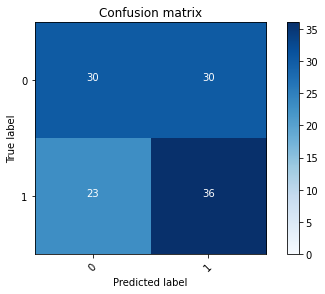

2022-08-22 17:44:46 - [Epoch Train: 27] loss: 0.0053, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:44:46 - [Epoch Valid: 27] loss: 2.1333, auc: 0.4963, acc: 0.5546, time: 6.00 s
2022-08-22 17:44:46 - acc improved from 0.5546 to 0.5546. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e27-loss2.133-acc0.555-auc0.496.pth'


 27%|███████████▎                              | 27/100 [13:41<37:00, 30.42s/it]

2022-08-22 17:44:46 - EPOCH: 28
2022-08-22 17:44:49 - Train Step 10/122, train_loss: 0.0021
2022-08-22 17:44:51 - Train Step 20/122, train_loss: 0.0128
2022-08-22 17:44:53 - Train Step 30/122, train_loss: 0.0134
2022-08-22 17:44:55 - Train Step 40/122, train_loss: 0.0105
2022-08-22 17:44:57 - Train Step 50/122, train_loss: 0.0087
2022-08-22 17:44:59 - Train Step 60/122, train_loss: 0.0074
2022-08-22 17:45:01 - Train Step 70/122, train_loss: 0.0065
2022-08-22 17:45:03 - Train Step 80/122, train_loss: 0.0059
2022-08-22 17:45:05 - Train Step 90/122, train_loss: 0.0055
2022-08-22 17:45:07 - Train Step 100/122, train_loss: 0.0051
2022-08-22 17:45:09 - Train Step 110/122, train_loss: 0.0047
2022-08-22 17:45:10 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:45:12 - Valid Step 5/30, valid_loss: 1.3377
2022-08-22 17:45:13 - Valid Step 10/30, valid_loss: 1.7296
2022-08-22 17:45:14 - Valid Step 15/30, valid_loss: 1.9822
2022-08-22 17:45:15

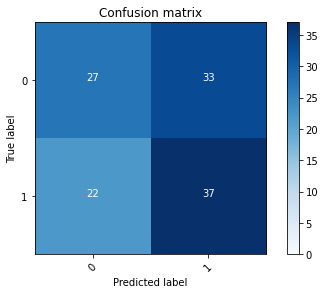

2022-08-22 17:45:17 - [Epoch Train: 28] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:45:17 - [Epoch Valid: 28] loss: 2.1664, auc: 0.4921, acc: 0.5378, time: 6.00 s


 28%|███████████▊                              | 28/100 [14:12<36:34, 30.48s/it]

2022-08-22 17:45:17 - EPOCH: 29
2022-08-22 17:45:19 - Train Step 10/122, train_loss: 0.0214
2022-08-22 17:45:21 - Train Step 20/122, train_loss: 0.0112
2022-08-22 17:45:23 - Train Step 30/122, train_loss: 0.0078
2022-08-22 17:45:25 - Train Step 40/122, train_loss: 0.0062
2022-08-22 17:45:27 - Train Step 50/122, train_loss: 0.0053
2022-08-22 17:45:29 - Train Step 60/122, train_loss: 0.0046
2022-08-22 17:45:31 - Train Step 70/122, train_loss: 0.0041
2022-08-22 17:45:33 - Train Step 80/122, train_loss: 0.0038
2022-08-22 17:45:35 - Train Step 90/122, train_loss: 0.0087
2022-08-22 17:45:37 - Train Step 100/122, train_loss: 0.0080
2022-08-22 17:45:39 - Train Step 110/122, train_loss: 0.0074
2022-08-22 17:45:41 - Train Step 120/122, train_loss: 0.0070
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:45:43 - Valid Step 5/30, valid_loss: 1.2000
2022-08-22 17:45:44 - Valid Step 10/30, valid_loss: 1.5347
2022-08-22 17:45:45 - Valid Step 15/30, valid_loss: 1.7422
2022-08-22 17:45:46

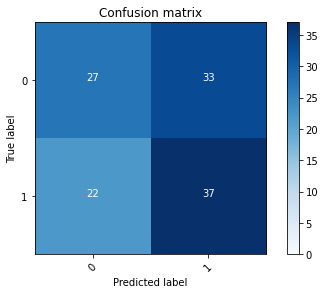

2022-08-22 17:45:48 - [Epoch Train: 29] loss: 0.0069, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:45:48 - [Epoch Valid: 29] loss: 2.2727, auc: 0.4955, acc: 0.5378, time: 6.00 s


 29%|████████████▏                             | 29/100 [14:43<36:13, 30.62s/it]

2022-08-22 17:45:48 - EPOCH: 30
2022-08-22 17:45:50 - Train Step 10/122, train_loss: 0.0018
2022-08-22 17:45:52 - Train Step 20/122, train_loss: 0.0017
2022-08-22 17:45:54 - Train Step 30/122, train_loss: 0.0015
2022-08-22 17:45:56 - Train Step 40/122, train_loss: 0.0016
2022-08-22 17:45:58 - Train Step 50/122, train_loss: 0.0015
2022-08-22 17:46:00 - Train Step 60/122, train_loss: 0.0014
2022-08-22 17:46:02 - Train Step 70/122, train_loss: 0.0047
2022-08-22 17:46:04 - Train Step 80/122, train_loss: 0.0067
2022-08-22 17:46:06 - Train Step 90/122, train_loss: 0.0061
2022-08-22 17:46:08 - Train Step 100/122, train_loss: 0.0056
2022-08-22 17:46:10 - Train Step 110/122, train_loss: 0.0052
2022-08-22 17:46:12 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:46:14 - Valid Step 5/30, valid_loss: 2.3981
2022-08-22 17:46:15 - Valid Step 10/30, valid_loss: 1.8469
2022-08-22 17:46:16 - Valid Step 15/30, valid_loss: 1.9175
2022-08-22 17:46:17

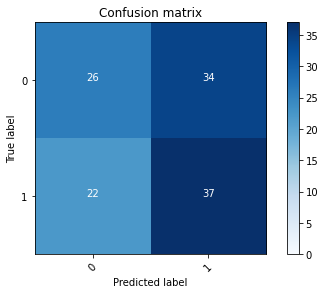

2022-08-22 17:46:19 - [Epoch Train: 30] loss: 0.0048, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:46:19 - [Epoch Valid: 30] loss: 2.2516, auc: 0.4977, acc: 0.5294, time: 6.00 s


 30%|████████████▌                             | 30/100 [15:14<35:44, 30.64s/it]

2022-08-22 17:46:19 - EPOCH: 31
2022-08-22 17:46:21 - Train Step 10/122, train_loss: 0.0016
2022-08-22 17:46:23 - Train Step 20/122, train_loss: 0.0014
2022-08-22 17:46:25 - Train Step 30/122, train_loss: 0.0014
2022-08-22 17:46:27 - Train Step 40/122, train_loss: 0.0012
2022-08-22 17:46:29 - Train Step 50/122, train_loss: 0.0012
2022-08-22 17:46:31 - Train Step 60/122, train_loss: 0.0011
2022-08-22 17:46:33 - Train Step 70/122, train_loss: 0.0027
2022-08-22 17:46:35 - Train Step 80/122, train_loss: 0.0024
2022-08-22 17:46:37 - Train Step 90/122, train_loss: 0.0023
2022-08-22 17:46:39 - Train Step 100/122, train_loss: 0.0022
2022-08-22 17:46:41 - Train Step 110/122, train_loss: 0.0021
2022-08-22 17:46:43 - Train Step 120/122, train_loss: 0.0048
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:46:44 - Valid Step 5/30, valid_loss: 1.7106
2022-08-22 17:46:45 - Valid Step 10/30, valid_loss: 2.4868
2022-08-22 17:46:46 - Valid Step 15/30, valid_loss: 2.5859
2022-08-22 17:46:47

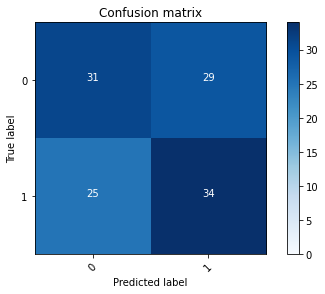

2022-08-22 17:46:49 - [Epoch Train: 31] loss: 0.0047, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:46:49 - [Epoch Valid: 31] loss: 2.2759, auc: 0.4918, acc: 0.5462, time: 6.00 s


 31%|█████████████                             | 31/100 [15:44<35:13, 30.63s/it]

2022-08-22 17:46:49 - EPOCH: 32
2022-08-22 17:46:52 - Train Step 10/122, train_loss: 0.0011
2022-08-22 17:46:53 - Train Step 20/122, train_loss: 0.0120
2022-08-22 17:46:55 - Train Step 30/122, train_loss: 0.0086
2022-08-22 17:46:57 - Train Step 40/122, train_loss: 0.0070
2022-08-22 17:46:59 - Train Step 50/122, train_loss: 0.0059
2022-08-22 17:47:01 - Train Step 60/122, train_loss: 0.0052
2022-08-22 17:47:03 - Train Step 70/122, train_loss: 0.0092
2022-08-22 17:47:05 - Train Step 80/122, train_loss: 0.0082
2022-08-22 17:47:07 - Train Step 90/122, train_loss: 0.0074
2022-08-22 17:47:09 - Train Step 100/122, train_loss: 0.0068
2022-08-22 17:47:11 - Train Step 110/122, train_loss: 0.0063
2022-08-22 17:47:13 - Train Step 120/122, train_loss: 0.0058
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:47:15 - Valid Step 5/30, valid_loss: 1.4262
2022-08-22 17:47:16 - Valid Step 10/30, valid_loss: 2.3290
2022-08-22 17:47:17 - Valid Step 15/30, valid_loss: 2.2387
2022-08-22 17:47:17

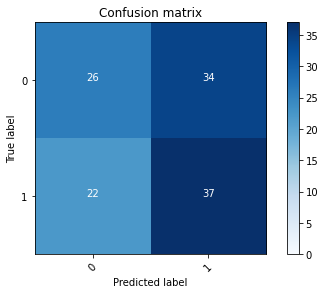

2022-08-22 17:47:20 - [Epoch Train: 32] loss: 0.0058, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:47:20 - [Epoch Valid: 32] loss: 2.4530, auc: 0.4966, acc: 0.5294, time: 6.00 s


 32%|█████████████▍                            | 32/100 [16:14<34:34, 30.50s/it]

2022-08-22 17:47:20 - EPOCH: 33
2022-08-22 17:47:22 - Train Step 10/122, train_loss: 0.0009
2022-08-22 17:47:24 - Train Step 20/122, train_loss: 0.0010
2022-08-22 17:47:26 - Train Step 30/122, train_loss: 0.0050
2022-08-22 17:47:27 - Train Step 40/122, train_loss: 0.0040
2022-08-22 17:47:29 - Train Step 50/122, train_loss: 0.0035
2022-08-22 17:47:31 - Train Step 60/122, train_loss: 0.0031
2022-08-22 17:47:33 - Train Step 70/122, train_loss: 0.0028
2022-08-22 17:47:35 - Train Step 80/122, train_loss: 0.0065
2022-08-22 17:47:37 - Train Step 90/122, train_loss: 0.0059
2022-08-22 17:47:39 - Train Step 100/122, train_loss: 0.0054
2022-08-22 17:47:41 - Train Step 110/122, train_loss: 0.0050
2022-08-22 17:47:43 - Train Step 120/122, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:47:45 - Valid Step 5/30, valid_loss: 2.6580
2022-08-22 17:47:46 - Valid Step 10/30, valid_loss: 2.6299
2022-08-22 17:47:47 - Valid Step 15/30, valid_loss: 2.6142
2022-08-22 17:47:48

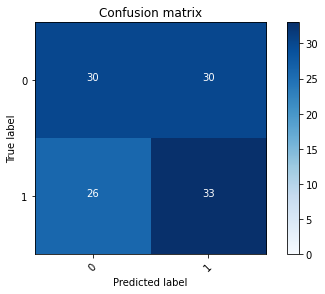

2022-08-22 17:47:50 - [Epoch Train: 33] loss: 0.0047, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:47:50 - [Epoch Valid: 33] loss: 2.3103, auc: 0.4980, acc: 0.5294, time: 6.00 s


 33%|█████████████▊                            | 33/100 [16:44<33:56, 30.39s/it]

2022-08-22 17:47:50 - EPOCH: 34
2022-08-22 17:47:52 - Train Step 10/122, train_loss: 0.0010
2022-08-22 17:47:54 - Train Step 20/122, train_loss: 0.0010
2022-08-22 17:47:56 - Train Step 30/122, train_loss: 0.0011
2022-08-22 17:47:58 - Train Step 40/122, train_loss: 0.0011
2022-08-22 17:48:00 - Train Step 50/122, train_loss: 0.0010
2022-08-22 17:48:02 - Train Step 60/122, train_loss: 0.0010
2022-08-22 17:48:04 - Train Step 70/122, train_loss: 0.0010
2022-08-22 17:48:06 - Train Step 80/122, train_loss: 0.0011
2022-08-22 17:48:08 - Train Step 90/122, train_loss: 0.0028
2022-08-22 17:48:10 - Train Step 100/122, train_loss: 0.0051
2022-08-22 17:48:12 - Train Step 110/122, train_loss: 0.0047
2022-08-22 17:48:14 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:48:16 - Valid Step 5/30, valid_loss: 2.2806
2022-08-22 17:48:17 - Valid Step 10/30, valid_loss: 1.8906
2022-08-22 17:48:18 - Valid Step 15/30, valid_loss: 1.9702
2022-08-22 17:48:19

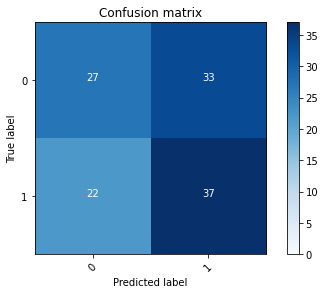

2022-08-22 17:48:21 - [Epoch Train: 34] loss: 0.0044, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:48:21 - [Epoch Valid: 34] loss: 2.3114, auc: 0.4969, acc: 0.5378, time: 6.00 s


 34%|██████████████▎                           | 34/100 [17:15<33:38, 30.59s/it]

2022-08-22 17:48:21 - EPOCH: 35
2022-08-22 17:48:23 - Train Step 10/122, train_loss: 0.0013
2022-08-22 17:48:25 - Train Step 20/122, train_loss: 0.0012
2022-08-22 17:48:27 - Train Step 30/122, train_loss: 0.0095
2022-08-22 17:48:29 - Train Step 40/122, train_loss: 0.0075
2022-08-22 17:48:31 - Train Step 50/122, train_loss: 0.0133
2022-08-22 17:48:33 - Train Step 60/122, train_loss: 0.0113
2022-08-22 17:48:35 - Train Step 70/122, train_loss: 0.0097
2022-08-22 17:48:37 - Train Step 80/122, train_loss: 0.0086
2022-08-22 17:48:39 - Train Step 90/122, train_loss: 0.0078
2022-08-22 17:48:41 - Train Step 100/122, train_loss: 0.0071
2022-08-22 17:48:43 - Train Step 110/122, train_loss: 0.0066
2022-08-22 17:48:45 - Train Step 120/122, train_loss: 0.0061
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:48:47 - Valid Step 5/30, valid_loss: 2.1895
2022-08-22 17:48:48 - Valid Step 10/30, valid_loss: 2.8296
2022-08-22 17:48:49 - Valid Step 15/30, valid_loss: 2.5498
2022-08-22 17:48:49

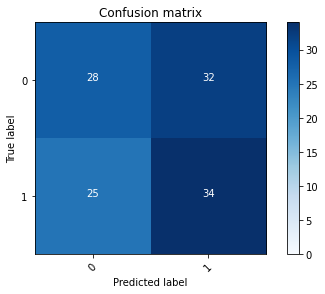

2022-08-22 17:48:52 - [Epoch Train: 35] loss: 0.0060, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:48:52 - [Epoch Valid: 35] loss: 2.3596, auc: 0.4999, acc: 0.5210, time: 6.00 s


 35%|██████████████▋                           | 35/100 [17:46<33:11, 30.64s/it]

2022-08-22 17:48:52 - EPOCH: 36
2022-08-22 17:48:54 - Train Step 10/122, train_loss: 0.0175
2022-08-22 17:48:56 - Train Step 20/122, train_loss: 0.0094
2022-08-22 17:48:58 - Train Step 30/122, train_loss: 0.0066
2022-08-22 17:49:00 - Train Step 40/122, train_loss: 0.0051
2022-08-22 17:49:01 - Train Step 50/122, train_loss: 0.0043
2022-08-22 17:49:03 - Train Step 60/122, train_loss: 0.0037
2022-08-22 17:49:05 - Train Step 70/122, train_loss: 0.0034
2022-08-22 17:49:07 - Train Step 80/122, train_loss: 0.0030
2022-08-22 17:49:09 - Train Step 90/122, train_loss: 0.0028
2022-08-22 17:49:11 - Train Step 100/122, train_loss: 0.0056
2022-08-22 17:49:13 - Train Step 110/122, train_loss: 0.0052
2022-08-22 17:49:15 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:49:17 - Valid Step 5/30, valid_loss: 1.7382
2022-08-22 17:49:18 - Valid Step 10/30, valid_loss: 1.8831
2022-08-22 17:49:19 - Valid Step 15/30, valid_loss: 2.4993
2022-08-22 17:49:20

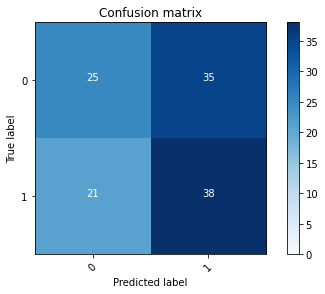

2022-08-22 17:49:22 - [Epoch Train: 36] loss: 0.0048, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:49:22 - [Epoch Valid: 36] loss: 2.3486, auc: 0.5028, acc: 0.5294, time: 6.00 s


 36%|███████████████                           | 36/100 [18:16<32:33, 30.52s/it]

2022-08-22 17:49:22 - EPOCH: 37
2022-08-22 17:49:24 - Train Step 10/122, train_loss: 0.0006
2022-08-22 17:49:26 - Train Step 20/122, train_loss: 0.0007
2022-08-22 17:49:28 - Train Step 30/122, train_loss: 0.0007
2022-08-22 17:49:30 - Train Step 40/122, train_loss: 0.0038
2022-08-22 17:49:32 - Train Step 50/122, train_loss: 0.0033
2022-08-22 17:49:34 - Train Step 60/122, train_loss: 0.0030
2022-08-22 17:49:36 - Train Step 70/122, train_loss: 0.0027
2022-08-22 17:49:38 - Train Step 80/122, train_loss: 0.0024
2022-08-22 17:49:40 - Train Step 90/122, train_loss: 0.0022
2022-08-22 17:49:42 - Train Step 100/122, train_loss: 0.0057
2022-08-22 17:49:43 - Train Step 110/122, train_loss: 0.0053
2022-08-22 17:49:45 - Train Step 120/122, train_loss: 0.0049
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:49:47 - Valid Step 5/30, valid_loss: 3.6755
2022-08-22 17:49:48 - Valid Step 10/30, valid_loss: 3.3026
2022-08-22 17:49:49 - Valid Step 15/30, valid_loss: 3.0697
2022-08-22 17:49:50

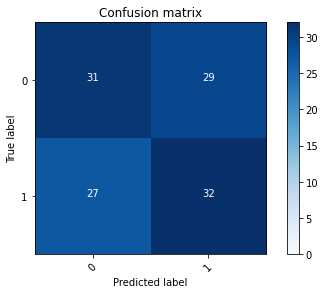

2022-08-22 17:49:52 - [Epoch Train: 37] loss: 0.0049, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:49:52 - [Epoch Valid: 37] loss: 2.4346, auc: 0.4946, acc: 0.5294, time: 6.00 s


 37%|███████████████▌                          | 37/100 [18:47<32:00, 30.49s/it]

2022-08-22 17:49:52 - EPOCH: 38
2022-08-22 17:49:54 - Train Step 10/122, train_loss: 0.0009
2022-08-22 17:49:56 - Train Step 20/122, train_loss: 0.0011
2022-08-22 17:49:58 - Train Step 30/122, train_loss: 0.0011
2022-08-22 17:50:00 - Train Step 40/122, train_loss: 0.0009
2022-08-22 17:50:02 - Train Step 50/122, train_loss: 0.0009
2022-08-22 17:50:04 - Train Step 60/122, train_loss: 0.0008
2022-08-22 17:50:06 - Train Step 70/122, train_loss: 0.0008
2022-08-22 17:50:08 - Train Step 80/122, train_loss: 0.0008
2022-08-22 17:50:10 - Train Step 90/122, train_loss: 0.0008
2022-08-22 17:50:12 - Train Step 100/122, train_loss: 0.0008
2022-08-22 17:50:14 - Train Step 110/122, train_loss: 0.0008
2022-08-22 17:50:16 - Train Step 120/122, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:50:17 - Valid Step 5/30, valid_loss: 3.8435
2022-08-22 17:50:18 - Valid Step 10/30, valid_loss: 2.7033
2022-08-22 17:50:19 - Valid Step 15/30, valid_loss: 2.4743
2022-08-22 17:50:20

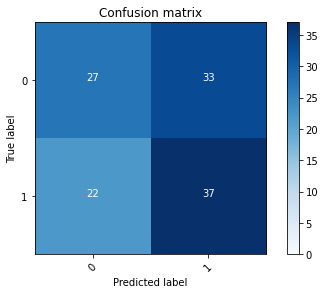

2022-08-22 17:50:22 - [Epoch Train: 38] loss: 0.0051, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:50:22 - [Epoch Valid: 38] loss: 2.4934, auc: 0.4963, acc: 0.5378, time: 6.00 s


 38%|███████████████▉                          | 38/100 [19:17<31:22, 30.37s/it]

2022-08-22 17:50:22 - EPOCH: 39
2022-08-22 17:50:24 - Train Step 10/122, train_loss: 0.0005
2022-08-22 17:50:26 - Train Step 20/122, train_loss: 0.0007
2022-08-22 17:50:28 - Train Step 30/122, train_loss: 0.0042
2022-08-22 17:50:30 - Train Step 40/122, train_loss: 0.0034
2022-08-22 17:50:32 - Train Step 50/122, train_loss: 0.0029
2022-08-22 17:50:34 - Train Step 60/122, train_loss: 0.0025
2022-08-22 17:50:36 - Train Step 70/122, train_loss: 0.0023
2022-08-22 17:50:38 - Train Step 80/122, train_loss: 0.0020
2022-08-22 17:50:40 - Train Step 90/122, train_loss: 0.0019
2022-08-22 17:50:42 - Train Step 100/122, train_loss: 0.0017
2022-08-22 17:50:44 - Train Step 110/122, train_loss: 0.0036
2022-08-22 17:50:46 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:50:48 - Valid Step 5/30, valid_loss: 3.7516
2022-08-22 17:50:49 - Valid Step 10/30, valid_loss: 2.7426
2022-08-22 17:50:50 - Valid Step 15/30, valid_loss: 2.3795
2022-08-22 17:50:51

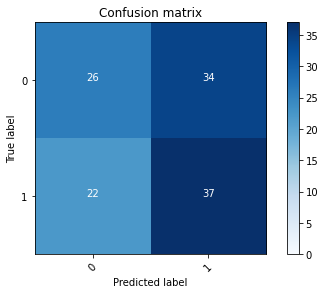

2022-08-22 17:50:53 - [Epoch Train: 39] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:50:53 - [Epoch Valid: 39] loss: 2.5278, auc: 0.4929, acc: 0.5294, time: 6.00 s


 39%|████████████████▍                         | 39/100 [19:48<30:56, 30.43s/it]

2022-08-22 17:50:53 - EPOCH: 40
2022-08-22 17:50:55 - Train Step 10/122, train_loss: 0.0006
2022-08-22 17:50:57 - Train Step 20/122, train_loss: 0.0078
2022-08-22 17:50:59 - Train Step 30/122, train_loss: 0.0054
2022-08-22 17:51:01 - Train Step 40/122, train_loss: 0.0043
2022-08-22 17:51:03 - Train Step 50/122, train_loss: 0.0035
2022-08-22 17:51:05 - Train Step 60/122, train_loss: 0.0031
2022-08-22 17:51:07 - Train Step 70/122, train_loss: 0.0028
2022-08-22 17:51:09 - Train Step 80/122, train_loss: 0.0061
2022-08-22 17:51:11 - Train Step 90/122, train_loss: 0.0055
2022-08-22 17:51:13 - Train Step 100/122, train_loss: 0.0050
2022-08-22 17:51:15 - Train Step 110/122, train_loss: 0.0046
2022-08-22 17:51:17 - Train Step 120/122, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:51:18 - Valid Step 5/30, valid_loss: 2.1107
2022-08-22 17:51:19 - Valid Step 10/30, valid_loss: 2.1861
2022-08-22 17:51:20 - Valid Step 15/30, valid_loss: 2.3746
2022-08-22 17:51:21

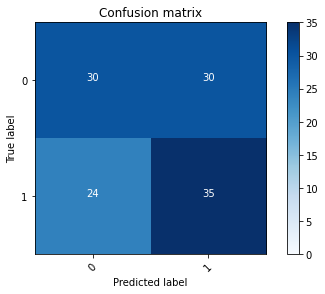

2022-08-22 17:51:23 - [Epoch Train: 40] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:51:23 - [Epoch Valid: 40] loss: 2.3825, auc: 0.4941, acc: 0.5462, time: 6.00 s


 40%|████████████████▊                         | 40/100 [20:18<30:28, 30.47s/it]

2022-08-22 17:51:23 - EPOCH: 41
2022-08-22 17:51:26 - Train Step 10/122, train_loss: 0.0006
2022-08-22 17:51:28 - Train Step 20/122, train_loss: 0.0007
2022-08-22 17:51:30 - Train Step 30/122, train_loss: 0.0008
2022-08-22 17:51:32 - Train Step 40/122, train_loss: 0.0008
2022-08-22 17:51:34 - Train Step 50/122, train_loss: 0.0007
2022-08-22 17:51:35 - Train Step 60/122, train_loss: 0.0007
2022-08-22 17:51:37 - Train Step 70/122, train_loss: 0.0007
2022-08-22 17:51:39 - Train Step 80/122, train_loss: 0.0007
2022-08-22 17:51:41 - Train Step 90/122, train_loss: 0.0028
2022-08-22 17:51:43 - Train Step 100/122, train_loss: 0.0057
2022-08-22 17:51:45 - Train Step 110/122, train_loss: 0.0052
2022-08-22 17:51:47 - Train Step 120/122, train_loss: 0.0048
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:51:49 - Valid Step 5/30, valid_loss: 2.9544
2022-08-22 17:51:50 - Valid Step 10/30, valid_loss: 2.4627
2022-08-22 17:51:51 - Valid Step 15/30, valid_loss: 3.0503
2022-08-22 17:51:52

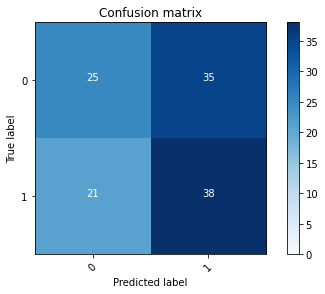

2022-08-22 17:51:54 - [Epoch Train: 41] loss: 0.0047, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:51:54 - [Epoch Valid: 41] loss: 2.6042, auc: 0.5021, acc: 0.5294, time: 6.00 s


 41%|█████████████████▏                        | 41/100 [20:49<30:00, 30.52s/it]

2022-08-22 17:51:54 - EPOCH: 42
2022-08-22 17:51:56 - Train Step 10/122, train_loss: 0.0004
2022-08-22 17:51:58 - Train Step 20/122, train_loss: 0.0005
2022-08-22 17:52:00 - Train Step 30/122, train_loss: 0.0008
2022-08-22 17:52:02 - Train Step 40/122, train_loss: 0.0007
2022-08-22 17:52:04 - Train Step 50/122, train_loss: 0.0006
2022-08-22 17:52:06 - Train Step 60/122, train_loss: 0.0006
2022-08-22 17:52:08 - Train Step 70/122, train_loss: 0.0006
2022-08-22 17:52:10 - Train Step 80/122, train_loss: 0.0037
2022-08-22 17:52:12 - Train Step 90/122, train_loss: 0.0086
2022-08-22 17:52:14 - Train Step 100/122, train_loss: 0.0078
2022-08-22 17:52:16 - Train Step 110/122, train_loss: 0.0072
2022-08-22 17:52:18 - Train Step 120/122, train_loss: 0.0066
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:52:20 - Valid Step 5/30, valid_loss: 1.7610
2022-08-22 17:52:21 - Valid Step 10/30, valid_loss: 2.1096
2022-08-22 17:52:22 - Valid Step 15/30, valid_loss: 2.0116
2022-08-22 17:52:23

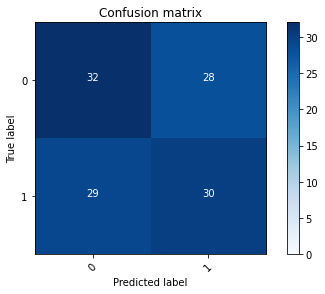

2022-08-22 17:52:25 - [Epoch Train: 42] loss: 0.0066, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:52:25 - [Epoch Valid: 42] loss: 2.4846, auc: 0.4969, acc: 0.5210, time: 6.00 s


 42%|█████████████████▋                        | 42/100 [21:20<29:34, 30.59s/it]

2022-08-22 17:52:25 - EPOCH: 43
2022-08-22 17:52:27 - Train Step 10/122, train_loss: 0.0006
2022-08-22 17:52:29 - Train Step 20/122, train_loss: 0.0009
2022-08-22 17:52:31 - Train Step 30/122, train_loss: 0.0048
2022-08-22 17:52:33 - Train Step 40/122, train_loss: 0.0038
2022-08-22 17:52:35 - Train Step 50/122, train_loss: 0.0031
2022-08-22 17:52:37 - Train Step 60/122, train_loss: 0.0027
2022-08-22 17:52:39 - Train Step 70/122, train_loss: 0.0024
2022-08-22 17:52:41 - Train Step 80/122, train_loss: 0.0022
2022-08-22 17:52:43 - Train Step 90/122, train_loss: 0.0055
2022-08-22 17:52:45 - Train Step 100/122, train_loss: 0.0051
2022-08-22 17:52:47 - Train Step 110/122, train_loss: 0.0046
2022-08-22 17:52:49 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:52:51 - Valid Step 5/30, valid_loss: 2.1492
2022-08-22 17:52:52 - Valid Step 10/30, valid_loss: 1.7719
2022-08-22 17:52:53 - Valid Step 15/30, valid_loss: 2.1559
2022-08-22 17:52:54

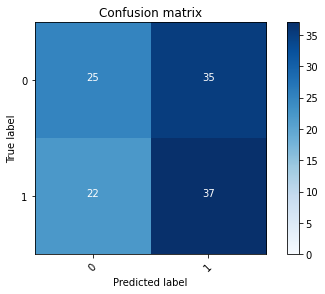

2022-08-22 17:52:56 - [Epoch Train: 43] loss: 0.0042, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:52:56 - [Epoch Valid: 43] loss: 2.5897, auc: 0.4955, acc: 0.5210, time: 6.00 s


 43%|██████████████████                        | 43/100 [21:50<29:08, 30.67s/it]

2022-08-22 17:52:56 - EPOCH: 44
2022-08-22 17:52:58 - Train Step 10/122, train_loss: 0.0003
2022-08-22 17:53:00 - Train Step 20/122, train_loss: 0.0003
2022-08-22 17:53:02 - Train Step 30/122, train_loss: 0.0004
2022-08-22 17:53:04 - Train Step 40/122, train_loss: 0.0005
2022-08-22 17:53:06 - Train Step 50/122, train_loss: 0.0005
2022-08-22 17:53:08 - Train Step 60/122, train_loss: 0.0005
2022-08-22 17:53:10 - Train Step 70/122, train_loss: 0.0023
2022-08-22 17:53:12 - Train Step 80/122, train_loss: 0.0021
2022-08-22 17:53:14 - Train Step 90/122, train_loss: 0.0019
2022-08-22 17:53:17 - Train Step 100/122, train_loss: 0.0045
2022-08-22 17:53:19 - Train Step 110/122, train_loss: 0.0042
2022-08-22 17:53:21 - Train Step 120/122, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:53:23 - Valid Step 5/30, valid_loss: 2.9934
2022-08-22 17:53:23 - Valid Step 10/30, valid_loss: 2.3684
2022-08-22 17:53:25 - Valid Step 15/30, valid_loss: 2.7441
2022-08-22 17:53:25

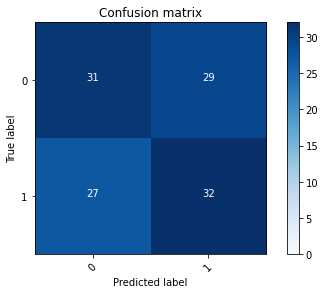

2022-08-22 17:53:28 - [Epoch Train: 44] loss: 0.0038, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 17:53:28 - [Epoch Valid: 44] loss: 2.6078, auc: 0.5008, acc: 0.5294, time: 6.00 s


 44%|██████████████████▍                       | 44/100 [22:22<28:58, 31.04s/it]

2022-08-22 17:53:28 - EPOCH: 45
2022-08-22 17:53:30 - Train Step 10/122, train_loss: 0.0009
2022-08-22 17:53:32 - Train Step 20/122, train_loss: 0.0006
2022-08-22 17:53:34 - Train Step 30/122, train_loss: 0.0005
2022-08-22 17:53:36 - Train Step 40/122, train_loss: 0.0005
2022-08-22 17:53:38 - Train Step 50/122, train_loss: 0.0030
2022-08-22 17:53:40 - Train Step 60/122, train_loss: 0.0025
2022-08-22 17:53:42 - Train Step 70/122, train_loss: 0.0084
2022-08-22 17:53:44 - Train Step 80/122, train_loss: 0.0074
2022-08-22 17:53:46 - Train Step 90/122, train_loss: 0.0066
2022-08-22 17:53:48 - Train Step 100/122, train_loss: 0.0060
2022-08-22 17:53:50 - Train Step 110/122, train_loss: 0.0055
2022-08-22 17:53:52 - Train Step 120/122, train_loss: 0.0051
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:53:54 - Valid Step 5/30, valid_loss: 4.4090
2022-08-22 17:53:54 - Valid Step 10/30, valid_loss: 2.6842
2022-08-22 17:53:56 - Valid Step 15/30, valid_loss: 2.8442
2022-08-22 17:53:56

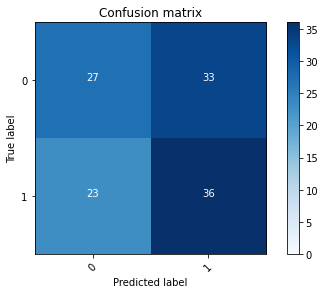

2022-08-22 17:53:58 - [Epoch Train: 45] loss: 0.0051, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:53:58 - [Epoch Valid: 45] loss: 2.5545, auc: 0.4997, acc: 0.5294, time: 6.00 s


 45%|██████████████████▉                       | 45/100 [22:53<28:26, 31.02s/it]

2022-08-22 17:53:58 - EPOCH: 46
2022-08-22 17:54:01 - Train Step 10/122, train_loss: 0.0005
2022-08-22 17:54:03 - Train Step 20/122, train_loss: 0.0006
2022-08-22 17:54:05 - Train Step 30/122, train_loss: 0.0005
2022-08-22 17:54:07 - Train Step 40/122, train_loss: 0.0005
2022-08-22 17:54:09 - Train Step 50/122, train_loss: 0.0005
2022-08-22 17:54:11 - Train Step 60/122, train_loss: 0.0004
2022-08-22 17:54:13 - Train Step 70/122, train_loss: 0.0004
2022-08-22 17:54:15 - Train Step 80/122, train_loss: 0.0004
2022-08-22 17:54:17 - Train Step 90/122, train_loss: 0.0020
2022-08-22 17:54:19 - Train Step 100/122, train_loss: 0.0054
2022-08-22 17:54:21 - Train Step 110/122, train_loss: 0.0050
2022-08-22 17:54:23 - Train Step 120/122, train_loss: 0.0046
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:54:25 - Valid Step 5/30, valid_loss: 2.5187
2022-08-22 17:54:26 - Valid Step 10/30, valid_loss: 2.5612
2022-08-22 17:54:27 - Valid Step 15/30, valid_loss: 2.1531
2022-08-22 17:54:28

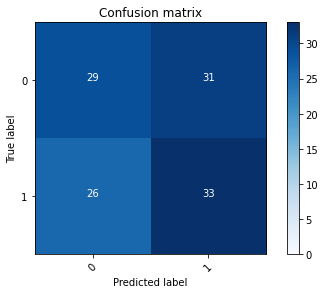

2022-08-22 17:54:30 - [Epoch Train: 46] loss: 0.0045, auc: 1.0000, acc: 0.9979, time: 25.00 s            
2022-08-22 17:54:30 - [Epoch Valid: 46] loss: 2.5068, auc: 0.4972, acc: 0.5210, time: 6.00 s


 46%|███████████████████▎                      | 46/100 [23:25<28:00, 31.13s/it]

2022-08-22 17:54:30 - EPOCH: 47
2022-08-22 17:54:32 - Train Step 10/122, train_loss: 0.0005
2022-08-22 17:54:34 - Train Step 20/122, train_loss: 0.0006
2022-08-22 17:54:36 - Train Step 30/122, train_loss: 0.0075
2022-08-22 17:54:38 - Train Step 40/122, train_loss: 0.0058
2022-08-22 17:54:40 - Train Step 50/122, train_loss: 0.0047
2022-08-22 17:54:42 - Train Step 60/122, train_loss: 0.0040
2022-08-22 17:54:44 - Train Step 70/122, train_loss: 0.0073
2022-08-22 17:54:46 - Train Step 80/122, train_loss: 0.0065
2022-08-22 17:54:48 - Train Step 90/122, train_loss: 0.0058
2022-08-22 17:54:50 - Train Step 100/122, train_loss: 0.0052
2022-08-22 17:54:52 - Train Step 110/122, train_loss: 0.0048
2022-08-22 17:54:54 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:54:55 - Valid Step 5/30, valid_loss: 3.5183
2022-08-22 17:54:56 - Valid Step 10/30, valid_loss: 3.0272
2022-08-22 17:54:57 - Valid Step 15/30, valid_loss: 2.7347
2022-08-22 17:54:58

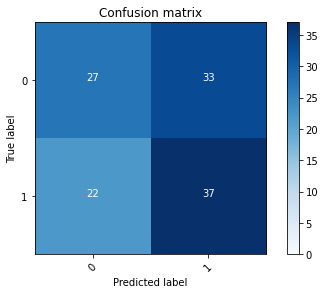

2022-08-22 17:55:00 - [Epoch Train: 47] loss: 0.0044, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:55:00 - [Epoch Valid: 47] loss: 2.5638, auc: 0.4972, acc: 0.5378, time: 6.00 s


 47%|███████████████████▋                      | 47/100 [23:55<27:18, 30.92s/it]

2022-08-22 17:55:00 - EPOCH: 48
2022-08-22 17:55:03 - Train Step 10/122, train_loss: 0.0003
2022-08-22 17:55:05 - Train Step 20/122, train_loss: 0.0003
2022-08-22 17:55:06 - Train Step 30/122, train_loss: 0.0003
2022-08-22 17:55:08 - Train Step 40/122, train_loss: 0.0003
2022-08-22 17:55:10 - Train Step 50/122, train_loss: 0.0057
2022-08-22 17:55:12 - Train Step 60/122, train_loss: 0.0048
2022-08-22 17:55:14 - Train Step 70/122, train_loss: 0.0042
2022-08-22 17:55:16 - Train Step 80/122, train_loss: 0.0037
2022-08-22 17:55:18 - Train Step 90/122, train_loss: 0.0034
2022-08-22 17:55:20 - Train Step 100/122, train_loss: 0.0031
2022-08-22 17:55:22 - Train Step 110/122, train_loss: 0.0065
2022-08-22 17:55:24 - Train Step 120/122, train_loss: 0.0060
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:55:26 - Valid Step 5/30, valid_loss: 1.8248
2022-08-22 17:55:27 - Valid Step 10/30, valid_loss: 2.1944
2022-08-22 17:55:28 - Valid Step 15/30, valid_loss: 3.1333
2022-08-22 17:55:29

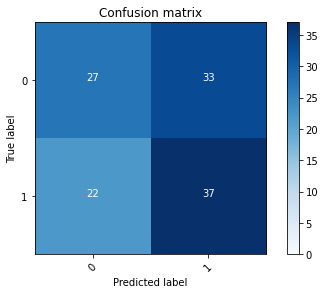

2022-08-22 17:55:31 - [Epoch Train: 48] loss: 0.0059, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:55:31 - [Epoch Valid: 48] loss: 2.5770, auc: 0.5003, acc: 0.5378, time: 6.00 s


 48%|████████████████████▏                     | 48/100 [24:25<26:39, 30.76s/it]

2022-08-22 17:55:31 - EPOCH: 49
2022-08-22 17:55:33 - Train Step 10/122, train_loss: 0.0005
2022-08-22 17:55:35 - Train Step 20/122, train_loss: 0.0006
2022-08-22 17:55:37 - Train Step 30/122, train_loss: 0.0129
2022-08-22 17:55:39 - Train Step 40/122, train_loss: 0.0098
2022-08-22 17:55:41 - Train Step 50/122, train_loss: 0.0080
2022-08-22 17:55:43 - Train Step 60/122, train_loss: 0.0068
2022-08-22 17:55:45 - Train Step 70/122, train_loss: 0.0059
2022-08-22 17:55:47 - Train Step 80/122, train_loss: 0.0052
2022-08-22 17:55:49 - Train Step 90/122, train_loss: 0.0046
2022-08-22 17:55:50 - Train Step 100/122, train_loss: 0.0042
2022-08-22 17:55:52 - Train Step 110/122, train_loss: 0.0039
2022-08-22 17:55:54 - Train Step 120/122, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:55:56 - Valid Step 5/30, valid_loss: 1.3328
2022-08-22 17:55:57 - Valid Step 10/30, valid_loss: 1.9496
2022-08-22 17:55:58 - Valid Step 15/30, valid_loss: 1.7589
2022-08-22 17:55:59

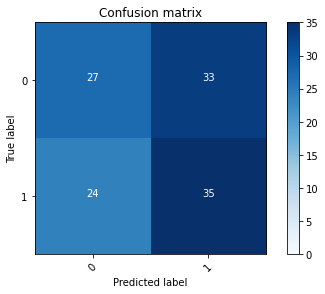

2022-08-22 17:56:01 - [Epoch Train: 49] loss: 0.0036, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:56:01 - [Epoch Valid: 49] loss: 2.5924, auc: 0.4969, acc: 0.5210, time: 6.00 s


 49%|████████████████████▌                     | 49/100 [24:56<26:05, 30.69s/it]

2022-08-22 17:56:01 - EPOCH: 50
2022-08-22 17:56:03 - Train Step 10/122, train_loss: 0.0145
2022-08-22 17:56:05 - Train Step 20/122, train_loss: 0.0260
2022-08-22 17:56:07 - Train Step 30/122, train_loss: 0.0175
2022-08-22 17:56:09 - Train Step 40/122, train_loss: 0.0132
2022-08-22 17:56:11 - Train Step 50/122, train_loss: 0.0106
2022-08-22 17:56:13 - Train Step 60/122, train_loss: 0.0090
2022-08-22 17:56:15 - Train Step 70/122, train_loss: 0.0078
2022-08-22 17:56:17 - Train Step 80/122, train_loss: 0.0069
2022-08-22 17:56:19 - Train Step 90/122, train_loss: 0.0062
2022-08-22 17:56:21 - Train Step 100/122, train_loss: 0.0056
2022-08-22 17:56:23 - Train Step 110/122, train_loss: 0.0051
2022-08-22 17:56:25 - Train Step 120/122, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:56:26 - Valid Step 5/30, valid_loss: 1.7102
2022-08-22 17:56:27 - Valid Step 10/30, valid_loss: 2.2741
2022-08-22 17:56:28 - Valid Step 15/30, valid_loss: 2.5335
2022-08-22 17:56:29

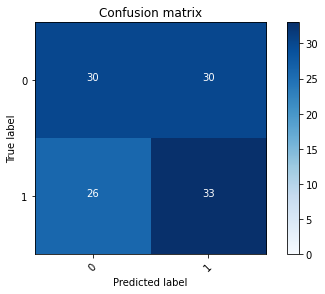

2022-08-22 17:56:31 - [Epoch Train: 50] loss: 0.0046, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:56:31 - [Epoch Valid: 50] loss: 2.7070, auc: 0.4966, acc: 0.5294, time: 6.00 s


 50%|█████████████████████                     | 50/100 [25:26<25:26, 30.53s/it]

2022-08-22 17:56:31 - EPOCH: 51
2022-08-22 17:56:34 - Train Step 10/122, train_loss: 0.0004
2022-08-22 17:56:36 - Train Step 20/122, train_loss: 0.0004
2022-08-22 17:56:38 - Train Step 30/122, train_loss: 0.0003
2022-08-22 17:56:40 - Train Step 40/122, train_loss: 0.0004
2022-08-22 17:56:42 - Train Step 50/122, train_loss: 0.0089
2022-08-22 17:56:44 - Train Step 60/122, train_loss: 0.0075
2022-08-22 17:56:46 - Train Step 70/122, train_loss: 0.0065
2022-08-22 17:56:48 - Train Step 80/122, train_loss: 0.0057
2022-08-22 17:56:50 - Train Step 90/122, train_loss: 0.0052
2022-08-22 17:56:52 - Train Step 100/122, train_loss: 0.0047
2022-08-22 17:56:54 - Train Step 110/122, train_loss: 0.0043
2022-08-22 17:56:56 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:56:57 - Valid Step 5/30, valid_loss: 4.7332
2022-08-22 17:56:58 - Valid Step 10/30, valid_loss: 3.4476
2022-08-22 17:56:59 - Valid Step 15/30, valid_loss: 3.5935
2022-08-22 17:57:00

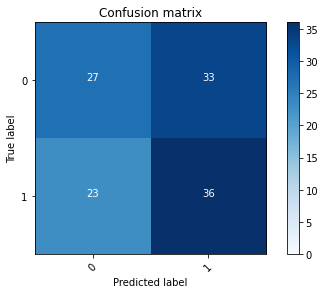

2022-08-22 17:57:02 - [Epoch Train: 51] loss: 0.0039, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:57:02 - [Epoch Valid: 51] loss: 2.7784, auc: 0.4983, acc: 0.5294, time: 6.00 s


 51%|█████████████████████▍                    | 51/100 [25:57<24:58, 30.58s/it]

2022-08-22 17:57:02 - EPOCH: 52
2022-08-22 17:57:04 - Train Step 10/122, train_loss: 0.0006
2022-08-22 17:57:06 - Train Step 20/122, train_loss: 0.0004
2022-08-22 17:57:08 - Train Step 30/122, train_loss: 0.0004
2022-08-22 17:57:10 - Train Step 40/122, train_loss: 0.0047
2022-08-22 17:57:12 - Train Step 50/122, train_loss: 0.0039
2022-08-22 17:57:14 - Train Step 60/122, train_loss: 0.0033
2022-08-22 17:57:16 - Train Step 70/122, train_loss: 0.0029
2022-08-22 17:57:18 - Train Step 80/122, train_loss: 0.0066
2022-08-22 17:57:20 - Train Step 90/122, train_loss: 0.0059
2022-08-22 17:57:22 - Train Step 100/122, train_loss: 0.0054
2022-08-22 17:57:24 - Train Step 110/122, train_loss: 0.0049
2022-08-22 17:57:26 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:57:28 - Valid Step 5/30, valid_loss: 1.8651
2022-08-22 17:57:28 - Valid Step 10/30, valid_loss: 2.0266
2022-08-22 17:57:30 - Valid Step 15/30, valid_loss: 2.1357
2022-08-22 17:57:30

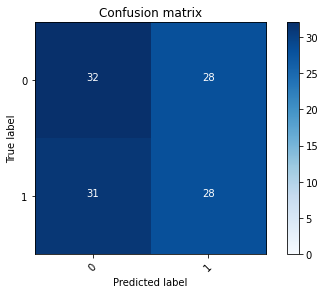

2022-08-22 17:57:32 - [Epoch Train: 52] loss: 0.0045, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:57:32 - [Epoch Valid: 52] loss: 2.6578, auc: 0.4963, acc: 0.5042, time: 6.00 s


 52%|█████████████████████▊                    | 52/100 [26:27<24:24, 30.51s/it]

2022-08-22 17:57:32 - EPOCH: 53
2022-08-22 17:57:35 - Train Step 10/122, train_loss: 0.0004
2022-08-22 17:57:37 - Train Step 20/122, train_loss: 0.0004
2022-08-22 17:57:38 - Train Step 30/122, train_loss: 0.0004
2022-08-22 17:57:40 - Train Step 40/122, train_loss: 0.0020
2022-08-22 17:57:42 - Train Step 50/122, train_loss: 0.0017
2022-08-22 17:57:44 - Train Step 60/122, train_loss: 0.0015
2022-08-22 17:57:46 - Train Step 70/122, train_loss: 0.0013
2022-08-22 17:57:48 - Train Step 80/122, train_loss: 0.0012
2022-08-22 17:57:50 - Train Step 90/122, train_loss: 0.0045
2022-08-22 17:57:52 - Train Step 100/122, train_loss: 0.0041
2022-08-22 17:57:54 - Train Step 110/122, train_loss: 0.0038
2022-08-22 17:57:56 - Train Step 120/122, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:57:57 - Valid Step 5/30, valid_loss: 2.8762
2022-08-22 17:57:58 - Valid Step 10/30, valid_loss: 2.6980
2022-08-22 17:57:59 - Valid Step 15/30, valid_loss: 3.0662
2022-08-22 17:58:00

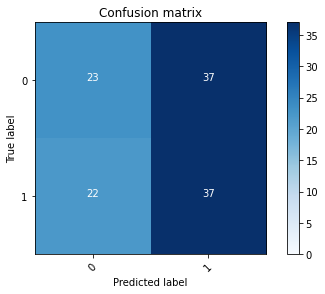

2022-08-22 17:58:02 - [Epoch Train: 53] loss: 0.0035, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 17:58:02 - [Epoch Valid: 53] loss: 2.8093, auc: 0.4924, acc: 0.5042, time: 6.00 s


 53%|██████████████████████▎                   | 53/100 [26:57<23:45, 30.33s/it]

2022-08-22 17:58:02 - EPOCH: 54
2022-08-22 17:58:05 - Train Step 10/122, train_loss: 0.0002
2022-08-22 17:58:07 - Train Step 20/122, train_loss: 0.0060
2022-08-22 17:58:09 - Train Step 30/122, train_loss: 0.0042
2022-08-22 17:58:11 - Train Step 40/122, train_loss: 0.0032
2022-08-22 17:58:13 - Train Step 50/122, train_loss: 0.0027
2022-08-22 17:58:15 - Train Step 60/122, train_loss: 0.0028
2022-08-22 17:58:17 - Train Step 70/122, train_loss: 0.0024
2022-08-22 17:58:19 - Train Step 80/122, train_loss: 0.0022
2022-08-22 17:58:21 - Train Step 90/122, train_loss: 0.0020
2022-08-22 17:58:23 - Train Step 100/122, train_loss: 0.0018
2022-08-22 17:58:25 - Train Step 110/122, train_loss: 0.0040
2022-08-22 17:58:27 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:58:28 - Valid Step 5/30, valid_loss: 2.0866
2022-08-22 17:58:29 - Valid Step 10/30, valid_loss: 3.1022
2022-08-22 17:58:30 - Valid Step 15/30, valid_loss: 3.2108
2022-08-22 17:58:31

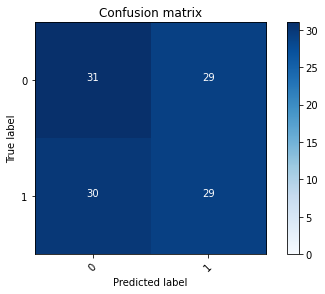

2022-08-22 17:58:33 - [Epoch Train: 54] loss: 0.0037, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 17:58:33 - [Epoch Valid: 54] loss: 2.7505, auc: 0.4873, acc: 0.5042, time: 6.00 s


 54%|██████████████████████▋                   | 54/100 [27:28<23:25, 30.54s/it]

2022-08-22 17:58:33 - EPOCH: 55
2022-08-22 17:58:36 - Train Step 10/122, train_loss: 0.0004
2022-08-22 17:58:38 - Train Step 20/122, train_loss: 0.0005
2022-08-22 17:58:39 - Train Step 30/122, train_loss: 0.0121
2022-08-22 17:58:41 - Train Step 40/122, train_loss: 0.0092
2022-08-22 17:58:43 - Train Step 50/122, train_loss: 0.0074
2022-08-22 17:58:45 - Train Step 60/122, train_loss: 0.0063
2022-08-22 17:58:47 - Train Step 70/122, train_loss: 0.0054
2022-08-22 17:58:49 - Train Step 80/122, train_loss: 0.0083
2022-08-22 17:58:51 - Train Step 90/122, train_loss: 0.0074
2022-08-22 17:58:53 - Train Step 100/122, train_loss: 0.0067
2022-08-22 17:58:55 - Train Step 110/122, train_loss: 0.0061
2022-08-22 17:58:57 - Train Step 120/122, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:58:59 - Valid Step 5/30, valid_loss: 3.7189
2022-08-22 17:59:00 - Valid Step 10/30, valid_loss: 3.1903
2022-08-22 17:59:01 - Valid Step 15/30, valid_loss: 2.8423
2022-08-22 17:59:02

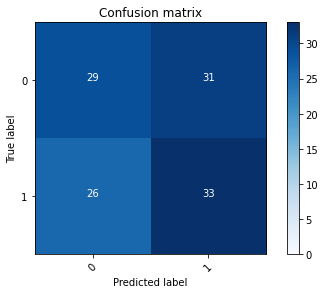

2022-08-22 17:59:04 - [Epoch Train: 55] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:59:04 - [Epoch Valid: 55] loss: 2.7685, auc: 0.4939, acc: 0.5210, time: 6.00 s


 55%|███████████████████████                   | 55/100 [27:59<22:56, 30.58s/it]

2022-08-22 17:59:04 - EPOCH: 56
2022-08-22 17:59:06 - Train Step 10/122, train_loss: 0.0215
2022-08-22 17:59:08 - Train Step 20/122, train_loss: 0.0108
2022-08-22 17:59:10 - Train Step 30/122, train_loss: 0.0213
2022-08-22 17:59:12 - Train Step 40/122, train_loss: 0.0161
2022-08-22 17:59:14 - Train Step 50/122, train_loss: 0.0129
2022-08-22 17:59:16 - Train Step 60/122, train_loss: 0.0109
2022-08-22 17:59:18 - Train Step 70/122, train_loss: 0.0093
2022-08-22 17:59:20 - Train Step 80/122, train_loss: 0.0082
2022-08-22 17:59:22 - Train Step 90/122, train_loss: 0.0073
2022-08-22 17:59:24 - Train Step 100/122, train_loss: 0.0066
2022-08-22 17:59:26 - Train Step 110/122, train_loss: 0.0061
2022-08-22 17:59:28 - Train Step 120/122, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 17:59:30 - Valid Step 5/30, valid_loss: 2.8194
2022-08-22 17:59:31 - Valid Step 10/30, valid_loss: 2.6187
2022-08-22 17:59:32 - Valid Step 15/30, valid_loss: 2.6780
2022-08-22 17:59:33

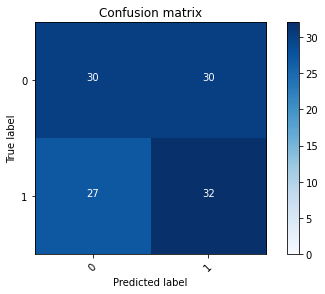

2022-08-22 17:59:35 - [Epoch Train: 56] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 17:59:35 - [Epoch Valid: 56] loss: 2.6683, auc: 0.4928, acc: 0.5210, time: 6.00 s


 56%|███████████████████████▌                  | 56/100 [28:30<22:30, 30.69s/it]

2022-08-22 17:59:35 - EPOCH: 57
2022-08-22 17:59:37 - Train Step 10/122, train_loss: 0.0002
2022-08-22 17:59:39 - Train Step 20/122, train_loss: 0.0106
2022-08-22 17:59:41 - Train Step 30/122, train_loss: 0.0072
2022-08-22 17:59:43 - Train Step 40/122, train_loss: 0.0054
2022-08-22 17:59:45 - Train Step 50/122, train_loss: 0.0044
2022-08-22 17:59:47 - Train Step 60/122, train_loss: 0.0097
2022-08-22 17:59:49 - Train Step 70/122, train_loss: 0.0083
2022-08-22 17:59:51 - Train Step 80/122, train_loss: 0.0074
2022-08-22 17:59:53 - Train Step 90/122, train_loss: 0.0066
2022-08-22 17:59:55 - Train Step 100/122, train_loss: 0.0059
2022-08-22 17:59:57 - Train Step 110/122, train_loss: 0.0054
2022-08-22 17:59:59 - Train Step 120/122, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:00:00 - Valid Step 5/30, valid_loss: 2.6674
2022-08-22 18:00:01 - Valid Step 10/30, valid_loss: 2.6784
2022-08-22 18:00:02 - Valid Step 15/30, valid_loss: 2.8992
2022-08-22 18:00:03

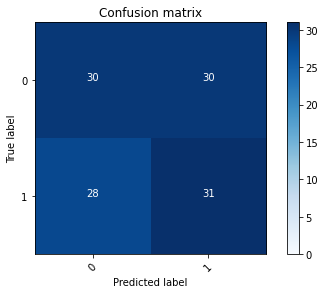

2022-08-22 18:00:05 - [Epoch Train: 57] loss: 0.0050, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 18:00:05 - [Epoch Valid: 57] loss: 2.6035, auc: 0.4942, acc: 0.5126, time: 6.00 s


 57%|███████████████████████▉                  | 57/100 [29:00<21:53, 30.54s/it]

2022-08-22 18:00:05 - EPOCH: 58
2022-08-22 18:00:07 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:00:09 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:00:11 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:00:13 - Train Step 40/122, train_loss: 0.0003
2022-08-22 18:00:15 - Train Step 50/122, train_loss: 0.0018
2022-08-22 18:00:17 - Train Step 60/122, train_loss: 0.0016
2022-08-22 18:00:19 - Train Step 70/122, train_loss: 0.0014
2022-08-22 18:00:21 - Train Step 80/122, train_loss: 0.0088
2022-08-22 18:00:23 - Train Step 90/122, train_loss: 0.0079
2022-08-22 18:00:25 - Train Step 100/122, train_loss: 0.0071
2022-08-22 18:00:27 - Train Step 110/122, train_loss: 0.0065
2022-08-22 18:00:29 - Train Step 120/122, train_loss: 0.0060
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:00:31 - Valid Step 5/30, valid_loss: 1.8708
2022-08-22 18:00:32 - Valid Step 10/30, valid_loss: 2.0688
2022-08-22 18:00:33 - Valid Step 15/30, valid_loss: 2.2396
2022-08-22 18:00:34

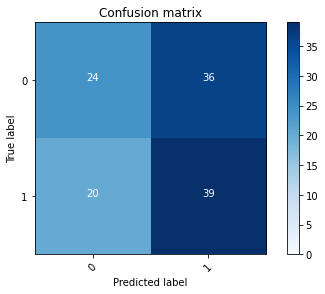

2022-08-22 18:00:36 - [Epoch Train: 58] loss: 0.0059, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:00:36 - [Epoch Valid: 58] loss: 2.7439, auc: 0.4946, acc: 0.5294, time: 6.00 s


 58%|████████████████████████▎                 | 58/100 [29:31<21:23, 30.57s/it]

2022-08-22 18:00:36 - EPOCH: 59
2022-08-22 18:00:38 - Train Step 10/122, train_loss: 0.0268
2022-08-22 18:00:40 - Train Step 20/122, train_loss: 0.0135
2022-08-22 18:00:42 - Train Step 30/122, train_loss: 0.0091
2022-08-22 18:00:44 - Train Step 40/122, train_loss: 0.0069
2022-08-22 18:00:46 - Train Step 50/122, train_loss: 0.0056
2022-08-22 18:00:48 - Train Step 60/122, train_loss: 0.0047
2022-08-22 18:00:50 - Train Step 70/122, train_loss: 0.0041
2022-08-22 18:00:52 - Train Step 80/122, train_loss: 0.0036
2022-08-22 18:00:54 - Train Step 90/122, train_loss: 0.0033
2022-08-22 18:00:56 - Train Step 100/122, train_loss: 0.0030
2022-08-22 18:00:58 - Train Step 110/122, train_loss: 0.0027
2022-08-22 18:01:00 - Train Step 120/122, train_loss: 0.0052
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:01:02 - Valid Step 5/30, valid_loss: 4.1211
2022-08-22 18:01:02 - Valid Step 10/30, valid_loss: 3.3118
2022-08-22 18:01:04 - Valid Step 15/30, valid_loss: 3.3947
2022-08-22 18:01:04

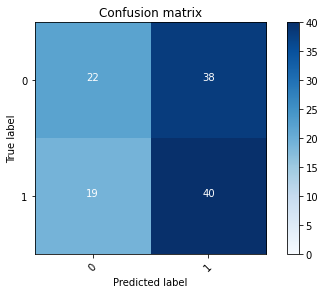

2022-08-22 18:01:07 - [Epoch Train: 59] loss: 0.0051, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:01:07 - [Epoch Valid: 59] loss: 3.0317, auc: 0.5000, acc: 0.5210, time: 6.00 s


 59%|████████████████████████▊                 | 59/100 [30:01<20:55, 30.63s/it]

2022-08-22 18:01:07 - EPOCH: 60
2022-08-22 18:01:09 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:01:11 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:01:13 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:01:15 - Train Step 40/122, train_loss: 0.0004
2022-08-22 18:01:17 - Train Step 50/122, train_loss: 0.0039
2022-08-22 18:01:19 - Train Step 60/122, train_loss: 0.0033
2022-08-22 18:01:21 - Train Step 70/122, train_loss: 0.0029
2022-08-22 18:01:23 - Train Step 80/122, train_loss: 0.0026
2022-08-22 18:01:25 - Train Step 90/122, train_loss: 0.0023
2022-08-22 18:01:27 - Train Step 100/122, train_loss: 0.0042
2022-08-22 18:01:29 - Train Step 110/122, train_loss: 0.0038
2022-08-22 18:01:31 - Train Step 120/122, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:01:32 - Valid Step 5/30, valid_loss: 4.4530
2022-08-22 18:01:33 - Valid Step 10/30, valid_loss: 3.7636
2022-08-22 18:01:34 - Valid Step 15/30, valid_loss: 3.6125
2022-08-22 18:01:35

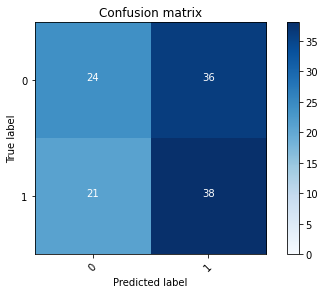

2022-08-22 18:01:37 - [Epoch Train: 60] loss: 0.0035, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:01:37 - [Epoch Valid: 60] loss: 2.8655, auc: 0.4948, acc: 0.5210, time: 6.00 s


 60%|█████████████████████████▏                | 60/100 [30:32<20:23, 30.59s/it]

2022-08-22 18:01:37 - EPOCH: 61
2022-08-22 18:01:39 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:01:41 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:01:43 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:01:45 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:01:47 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:01:49 - Train Step 60/122, train_loss: 0.0038
2022-08-22 18:01:51 - Train Step 70/122, train_loss: 0.0033
2022-08-22 18:01:53 - Train Step 80/122, train_loss: 0.0029
2022-08-22 18:01:55 - Train Step 90/122, train_loss: 0.0036
2022-08-22 18:01:57 - Train Step 100/122, train_loss: 0.0032
2022-08-22 18:01:59 - Train Step 110/122, train_loss: 0.0030
2022-08-22 18:02:01 - Train Step 120/122, train_loss: 0.0027
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:02:03 - Valid Step 5/30, valid_loss: 3.1320
2022-08-22 18:02:03 - Valid Step 10/30, valid_loss: 3.4745
2022-08-22 18:02:04 - Valid Step 15/30, valid_loss: 3.0168
2022-08-22 18:02:05

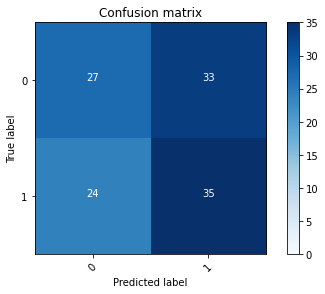

2022-08-22 18:02:07 - [Epoch Train: 61] loss: 0.0027, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:02:07 - [Epoch Valid: 61] loss: 2.7991, auc: 0.4890, acc: 0.5210, time: 6.00 s


 61%|█████████████████████████▌                | 61/100 [31:02<19:50, 30.52s/it]

2022-08-22 18:02:07 - EPOCH: 62
2022-08-22 18:02:10 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:02:12 - Train Step 20/122, train_loss: 0.0004
2022-08-22 18:02:14 - Train Step 30/122, train_loss: 0.0060
2022-08-22 18:02:16 - Train Step 40/122, train_loss: 0.0046
2022-08-22 18:02:18 - Train Step 50/122, train_loss: 0.0037
2022-08-22 18:02:20 - Train Step 60/122, train_loss: 0.0031
2022-08-22 18:02:22 - Train Step 70/122, train_loss: 0.0027
2022-08-22 18:02:24 - Train Step 80/122, train_loss: 0.0024
2022-08-22 18:02:26 - Train Step 90/122, train_loss: 0.0022
2022-08-22 18:02:28 - Train Step 100/122, train_loss: 0.0020
2022-08-22 18:02:29 - Train Step 110/122, train_loss: 0.0040
2022-08-22 18:02:31 - Train Step 120/122, train_loss: 0.0036
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:02:33 - Valid Step 5/30, valid_loss: 1.8393
2022-08-22 18:02:34 - Valid Step 10/30, valid_loss: 2.3485
2022-08-22 18:02:35 - Valid Step 15/30, valid_loss: 3.0240
2022-08-22 18:02:36

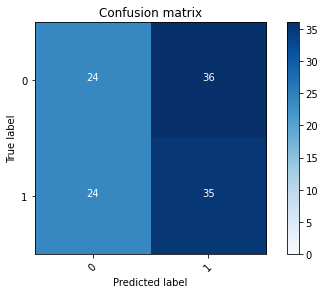

2022-08-22 18:02:38 - [Epoch Train: 62] loss: 0.0036, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:02:38 - [Epoch Valid: 62] loss: 2.9615, auc: 0.4893, acc: 0.4958, time: 6.00 s


 62%|██████████████████████████                | 62/100 [31:33<19:20, 30.53s/it]

2022-08-22 18:02:38 - EPOCH: 63
2022-08-22 18:02:40 - Train Step 10/122, train_loss: 0.0193
2022-08-22 18:02:42 - Train Step 20/122, train_loss: 0.0098
2022-08-22 18:02:44 - Train Step 30/122, train_loss: 0.0192
2022-08-22 18:02:46 - Train Step 40/122, train_loss: 0.0145
2022-08-22 18:02:48 - Train Step 50/122, train_loss: 0.0116
2022-08-22 18:02:50 - Train Step 60/122, train_loss: 0.0097
2022-08-22 18:02:52 - Train Step 70/122, train_loss: 0.0084
2022-08-22 18:02:54 - Train Step 80/122, train_loss: 0.0073
2022-08-22 18:02:56 - Train Step 90/122, train_loss: 0.0066
2022-08-22 18:02:58 - Train Step 100/122, train_loss: 0.0059
2022-08-22 18:03:00 - Train Step 110/122, train_loss: 0.0054
2022-08-22 18:03:02 - Train Step 120/122, train_loss: 0.0050
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:03:04 - Valid Step 5/30, valid_loss: 3.1458
2022-08-22 18:03:05 - Valid Step 10/30, valid_loss: 3.2231
2022-08-22 18:03:06 - Valid Step 15/30, valid_loss: 3.4464
2022-08-22 18:03:06

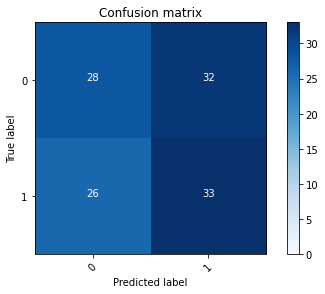

2022-08-22 18:03:09 - [Epoch Train: 63] loss: 0.0049, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:03:09 - [Epoch Valid: 63] loss: 2.8075, auc: 0.4914, acc: 0.5126, time: 6.00 s


 63%|██████████████████████████▍               | 63/100 [32:03<18:49, 30.53s/it]

2022-08-22 18:03:09 - EPOCH: 64
2022-08-22 18:03:11 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:03:13 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:03:15 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:03:17 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:03:19 - Train Step 50/122, train_loss: 0.0045
2022-08-22 18:03:21 - Train Step 60/122, train_loss: 0.0038
2022-08-22 18:03:23 - Train Step 70/122, train_loss: 0.0033
2022-08-22 18:03:24 - Train Step 80/122, train_loss: 0.0029
2022-08-22 18:03:26 - Train Step 90/122, train_loss: 0.0026
2022-08-22 18:03:28 - Train Step 100/122, train_loss: 0.0024
2022-08-22 18:03:30 - Train Step 110/122, train_loss: 0.0022
2022-08-22 18:03:32 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:03:34 - Valid Step 5/30, valid_loss: 3.8102
2022-08-22 18:03:35 - Valid Step 10/30, valid_loss: 2.7452
2022-08-22 18:03:36 - Valid Step 15/30, valid_loss: 2.7320
2022-08-22 18:03:37

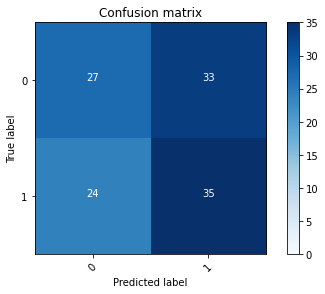

2022-08-22 18:03:39 - [Epoch Train: 64] loss: 0.0036, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:03:39 - [Epoch Valid: 64] loss: 3.0434, auc: 0.4934, acc: 0.5210, time: 6.00 s


 64%|██████████████████████████▉               | 64/100 [32:34<18:16, 30.46s/it]

2022-08-22 18:03:39 - EPOCH: 65
2022-08-22 18:03:41 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:03:43 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:03:45 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:03:47 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:03:49 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:03:51 - Train Step 60/122, train_loss: 0.0020
2022-08-22 18:03:53 - Train Step 70/122, train_loss: 0.0018
2022-08-22 18:03:55 - Train Step 80/122, train_loss: 0.0016
2022-08-22 18:03:57 - Train Step 90/122, train_loss: 0.0015
2022-08-22 18:03:59 - Train Step 100/122, train_loss: 0.0047
2022-08-22 18:04:01 - Train Step 110/122, train_loss: 0.0043
2022-08-22 18:04:03 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:04:04 - Valid Step 5/30, valid_loss: 3.6040
2022-08-22 18:04:05 - Valid Step 10/30, valid_loss: 3.1163
2022-08-22 18:04:06 - Valid Step 15/30, valid_loss: 2.9579
2022-08-22 18:04:07

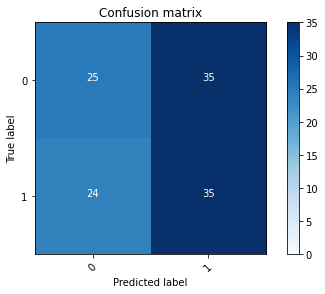

2022-08-22 18:04:09 - [Epoch Train: 65] loss: 0.0039, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:04:09 - [Epoch Valid: 65] loss: 2.9288, auc: 0.4871, acc: 0.5042, time: 6.00 s


 65%|███████████████████████████▎              | 65/100 [33:04<17:44, 30.42s/it]

2022-08-22 18:04:09 - EPOCH: 66
2022-08-22 18:04:11 - Train Step 10/122, train_loss: 0.0004
2022-08-22 18:04:13 - Train Step 20/122, train_loss: 0.0004
2022-08-22 18:04:15 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:04:17 - Train Step 40/122, train_loss: 0.0052
2022-08-22 18:04:19 - Train Step 50/122, train_loss: 0.0042
2022-08-22 18:04:21 - Train Step 60/122, train_loss: 0.0036
2022-08-22 18:04:23 - Train Step 70/122, train_loss: 0.0031
2022-08-22 18:04:25 - Train Step 80/122, train_loss: 0.0028
2022-08-22 18:04:27 - Train Step 90/122, train_loss: 0.0025
2022-08-22 18:04:29 - Train Step 100/122, train_loss: 0.0054
2022-08-22 18:04:31 - Train Step 110/122, train_loss: 0.0049
2022-08-22 18:04:33 - Train Step 120/122, train_loss: 0.0045
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:04:35 - Valid Step 5/30, valid_loss: 3.5342
2022-08-22 18:04:36 - Valid Step 10/30, valid_loss: 2.7489
2022-08-22 18:04:37 - Valid Step 15/30, valid_loss: 3.0085
2022-08-22 18:04:38

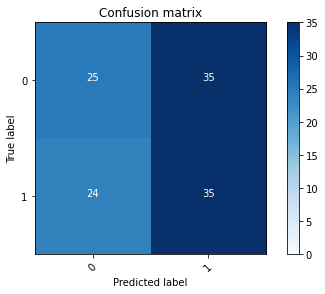

2022-08-22 18:04:40 - [Epoch Train: 66] loss: 0.0045, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:04:40 - [Epoch Valid: 66] loss: 3.2294, auc: 0.4870, acc: 0.5042, time: 6.00 s


 66%|███████████████████████████▋              | 66/100 [33:34<17:15, 30.44s/it]

2022-08-22 18:04:40 - EPOCH: 67
2022-08-22 18:04:42 - Train Step 10/122, train_loss: 0.0011
2022-08-22 18:04:44 - Train Step 20/122, train_loss: 0.0007
2022-08-22 18:04:46 - Train Step 30/122, train_loss: 0.0005
2022-08-22 18:04:48 - Train Step 40/122, train_loss: 0.0090
2022-08-22 18:04:50 - Train Step 50/122, train_loss: 0.0072
2022-08-22 18:04:52 - Train Step 60/122, train_loss: 0.0061
2022-08-22 18:04:54 - Train Step 70/122, train_loss: 0.0053
2022-08-22 18:04:56 - Train Step 80/122, train_loss: 0.0087
2022-08-22 18:04:58 - Train Step 90/122, train_loss: 0.0078
2022-08-22 18:05:00 - Train Step 100/122, train_loss: 0.0070
2022-08-22 18:05:01 - Train Step 110/122, train_loss: 0.0064
2022-08-22 18:05:03 - Train Step 120/122, train_loss: 0.0059
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:05:05 - Valid Step 5/30, valid_loss: 3.6452
2022-08-22 18:05:06 - Valid Step 10/30, valid_loss: 3.0879
2022-08-22 18:05:07 - Valid Step 15/30, valid_loss: 2.7389
2022-08-22 18:05:08

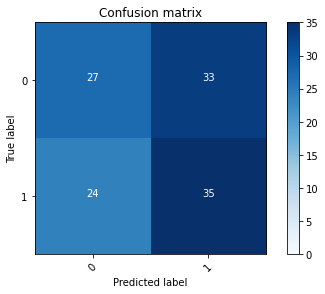

2022-08-22 18:05:10 - [Epoch Train: 67] loss: 0.0058, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:05:10 - [Epoch Valid: 67] loss: 2.9419, auc: 0.4963, acc: 0.5210, time: 6.00 s


 67%|████████████████████████████▏             | 67/100 [34:05<16:43, 30.42s/it]

2022-08-22 18:05:10 - EPOCH: 68
2022-08-22 18:05:12 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:05:14 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:05:16 - Train Step 30/122, train_loss: 0.0098
2022-08-22 18:05:18 - Train Step 40/122, train_loss: 0.0074
2022-08-22 18:05:20 - Train Step 50/122, train_loss: 0.0060
2022-08-22 18:05:22 - Train Step 60/122, train_loss: 0.0051
2022-08-22 18:05:24 - Train Step 70/122, train_loss: 0.0044
2022-08-22 18:05:26 - Train Step 80/122, train_loss: 0.0039
2022-08-22 18:05:28 - Train Step 90/122, train_loss: 0.0035
2022-08-22 18:05:30 - Train Step 100/122, train_loss: 0.0031
2022-08-22 18:05:32 - Train Step 110/122, train_loss: 0.0047
2022-08-22 18:05:34 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:05:36 - Valid Step 5/30, valid_loss: 2.4158
2022-08-22 18:05:37 - Valid Step 10/30, valid_loss: 2.6673
2022-08-22 18:05:38 - Valid Step 15/30, valid_loss: 2.7747
2022-08-22 18:05:39

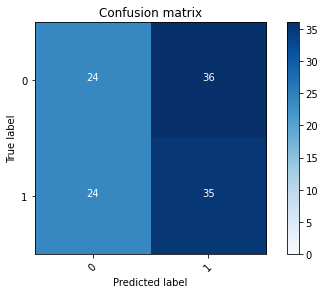

2022-08-22 18:05:41 - [Epoch Train: 68] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:05:41 - [Epoch Valid: 68] loss: 3.1738, auc: 0.4927, acc: 0.4958, time: 6.00 s


 68%|████████████████████████████▌             | 68/100 [34:36<16:19, 30.60s/it]

2022-08-22 18:05:41 - EPOCH: 69
2022-08-22 18:05:43 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:05:45 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:05:47 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:05:49 - Train Step 40/122, train_loss: 0.0003
2022-08-22 18:05:51 - Train Step 50/122, train_loss: 0.0036
2022-08-22 18:05:53 - Train Step 60/122, train_loss: 0.0030
2022-08-22 18:05:55 - Train Step 70/122, train_loss: 0.0026
2022-08-22 18:05:57 - Train Step 80/122, train_loss: 0.0023
2022-08-22 18:05:59 - Train Step 90/122, train_loss: 0.0021
2022-08-22 18:06:01 - Train Step 100/122, train_loss: 0.0019
2022-08-22 18:06:03 - Train Step 110/122, train_loss: 0.0042
2022-08-22 18:06:05 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:06:07 - Valid Step 5/30, valid_loss: 1.8633
2022-08-22 18:06:08 - Valid Step 10/30, valid_loss: 2.7278
2022-08-22 18:06:09 - Valid Step 15/30, valid_loss: 2.8023
2022-08-22 18:06:10

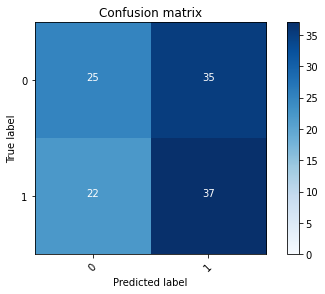

2022-08-22 18:06:12 - [Epoch Train: 69] loss: 0.0038, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:06:12 - [Epoch Valid: 69] loss: 2.9289, auc: 0.4876, acc: 0.5210, time: 6.00 s


 69%|████████████████████████████▉             | 69/100 [35:07<15:51, 30.68s/it]

2022-08-22 18:06:12 - EPOCH: 70
2022-08-22 18:06:14 - Train Step 10/122, train_loss: 0.0003
2022-08-22 18:06:16 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:06:18 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:06:20 - Train Step 40/122, train_loss: 0.0003
2022-08-22 18:06:22 - Train Step 50/122, train_loss: 0.0003
2022-08-22 18:06:24 - Train Step 60/122, train_loss: 0.0003
2022-08-22 18:06:26 - Train Step 70/122, train_loss: 0.0002
2022-08-22 18:06:28 - Train Step 80/122, train_loss: 0.0039
2022-08-22 18:06:30 - Train Step 90/122, train_loss: 0.0034
2022-08-22 18:06:32 - Train Step 100/122, train_loss: 0.0031
2022-08-22 18:06:34 - Train Step 110/122, train_loss: 0.0040
2022-08-22 18:06:36 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:06:38 - Valid Step 5/30, valid_loss: 2.3073
2022-08-22 18:06:39 - Valid Step 10/30, valid_loss: 2.4008
2022-08-22 18:06:40 - Valid Step 15/30, valid_loss: 2.4436
2022-08-22 18:06:41

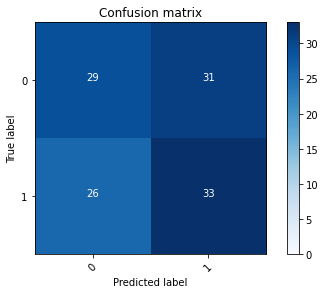

2022-08-22 18:06:43 - [Epoch Train: 70] loss: 0.0036, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:06:43 - [Epoch Valid: 70] loss: 3.1477, auc: 0.4898, acc: 0.5210, time: 6.00 s


 70%|█████████████████████████████▍            | 70/100 [35:38<15:22, 30.75s/it]

2022-08-22 18:06:43 - EPOCH: 71
2022-08-22 18:06:45 - Train Step 10/122, train_loss: 0.0003
2022-08-22 18:06:47 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:06:49 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:06:51 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:06:53 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:06:55 - Train Step 60/122, train_loss: 0.0013
2022-08-22 18:06:57 - Train Step 70/122, train_loss: 0.0011
2022-08-22 18:06:59 - Train Step 80/122, train_loss: 0.0010
2022-08-22 18:07:00 - Train Step 90/122, train_loss: 0.0009
2022-08-22 18:07:02 - Train Step 100/122, train_loss: 0.0046
2022-08-22 18:07:04 - Train Step 110/122, train_loss: 0.0042
2022-08-22 18:07:06 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:07:08 - Valid Step 5/30, valid_loss: 3.8203
2022-08-22 18:07:09 - Valid Step 10/30, valid_loss: 3.8776
2022-08-22 18:07:10 - Valid Step 15/30, valid_loss: 3.0212
2022-08-22 18:07:11

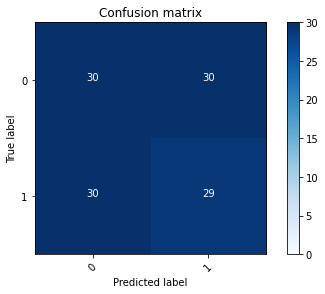

2022-08-22 18:07:13 - [Epoch Train: 71] loss: 0.0038, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 18:07:13 - [Epoch Valid: 71] loss: 3.0371, auc: 0.4876, acc: 0.4958, time: 6.00 s


 71%|█████████████████████████████▊            | 71/100 [36:08<14:46, 30.57s/it]

2022-08-22 18:07:13 - EPOCH: 72
2022-08-22 18:07:15 - Train Step 10/122, train_loss: 0.0003
2022-08-22 18:07:17 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:07:19 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:07:21 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:07:23 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:07:25 - Train Step 60/122, train_loss: 0.0002
2022-08-22 18:07:27 - Train Step 70/122, train_loss: 0.0023
2022-08-22 18:07:29 - Train Step 80/122, train_loss: 0.0021
2022-08-22 18:07:31 - Train Step 90/122, train_loss: 0.0054
2022-08-22 18:07:33 - Train Step 100/122, train_loss: 0.0048
2022-08-22 18:07:35 - Train Step 110/122, train_loss: 0.0044
2022-08-22 18:07:37 - Train Step 120/122, train_loss: 0.0041
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:07:39 - Valid Step 5/30, valid_loss: 2.7517
2022-08-22 18:07:40 - Valid Step 10/30, valid_loss: 3.3929
2022-08-22 18:07:41 - Valid Step 15/30, valid_loss: 3.4605
2022-08-22 18:07:41

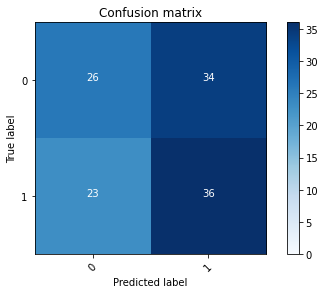

2022-08-22 18:07:43 - [Epoch Train: 72] loss: 0.0040, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:07:43 - [Epoch Valid: 72] loss: 3.3016, auc: 0.4898, acc: 0.5210, time: 6.00 s


 72%|██████████████████████████████▏           | 72/100 [36:38<14:15, 30.54s/it]

2022-08-22 18:07:43 - EPOCH: 73
2022-08-22 18:07:46 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:07:48 - Train Step 20/122, train_loss: 0.0102
2022-08-22 18:07:50 - Train Step 30/122, train_loss: 0.0172
2022-08-22 18:07:52 - Train Step 40/122, train_loss: 0.0129
2022-08-22 18:07:54 - Train Step 50/122, train_loss: 0.0105
2022-08-22 18:07:56 - Train Step 60/122, train_loss: 0.0089
2022-08-22 18:07:58 - Train Step 70/122, train_loss: 0.0077
2022-08-22 18:08:00 - Train Step 80/122, train_loss: 0.0068
2022-08-22 18:08:02 - Train Step 90/122, train_loss: 0.0060
2022-08-22 18:08:04 - Train Step 100/122, train_loss: 0.0055
2022-08-22 18:08:06 - Train Step 110/122, train_loss: 0.0050
2022-08-22 18:08:08 - Train Step 120/122, train_loss: 0.0046
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:08:10 - Valid Step 5/30, valid_loss: 1.3309
2022-08-22 18:08:10 - Valid Step 10/30, valid_loss: 2.8375
2022-08-22 18:08:12 - Valid Step 15/30, valid_loss: 3.0077
2022-08-22 18:08:12

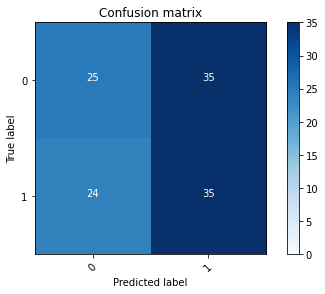

2022-08-22 18:08:14 - [Epoch Train: 73] loss: 0.0045, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:08:14 - [Epoch Valid: 73] loss: 3.0767, auc: 0.4850, acc: 0.5042, time: 6.00 s


 73%|██████████████████████████████▋           | 73/100 [37:09<13:48, 30.69s/it]

2022-08-22 18:08:14 - EPOCH: 74
2022-08-22 18:08:17 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:08:19 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:08:21 - Train Step 30/122, train_loss: 0.0031
2022-08-22 18:08:23 - Train Step 40/122, train_loss: 0.0024
2022-08-22 18:08:25 - Train Step 50/122, train_loss: 0.0020
2022-08-22 18:08:26 - Train Step 60/122, train_loss: 0.0017
2022-08-22 18:08:28 - Train Step 70/122, train_loss: 0.0015
2022-08-22 18:08:30 - Train Step 80/122, train_loss: 0.0013
2022-08-22 18:08:32 - Train Step 90/122, train_loss: 0.0012
2022-08-22 18:08:34 - Train Step 100/122, train_loss: 0.0032
2022-08-22 18:08:36 - Train Step 110/122, train_loss: 0.0029
2022-08-22 18:08:38 - Train Step 120/122, train_loss: 0.0027
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:08:40 - Valid Step 5/30, valid_loss: 3.8695
2022-08-22 18:08:41 - Valid Step 10/30, valid_loss: 3.9190
2022-08-22 18:08:42 - Valid Step 15/30, valid_loss: 3.5069
2022-08-22 18:08:43

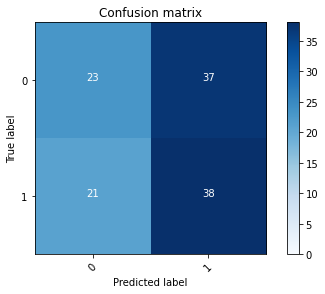

2022-08-22 18:08:45 - [Epoch Train: 74] loss: 0.0027, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:08:45 - [Epoch Valid: 74] loss: 3.2865, auc: 0.4881, acc: 0.5126, time: 6.00 s


 74%|███████████████████████████████           | 74/100 [37:40<13:14, 30.58s/it]

2022-08-22 18:08:45 - EPOCH: 75
2022-08-22 18:08:47 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:08:49 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:08:51 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:08:53 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:08:55 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:08:57 - Train Step 60/122, train_loss: 0.0002
2022-08-22 18:08:59 - Train Step 70/122, train_loss: 0.0050
2022-08-22 18:09:01 - Train Step 80/122, train_loss: 0.0044
2022-08-22 18:09:03 - Train Step 90/122, train_loss: 0.0070
2022-08-22 18:09:05 - Train Step 100/122, train_loss: 0.0063
2022-08-22 18:09:07 - Train Step 110/122, train_loss: 0.0058
2022-08-22 18:09:09 - Train Step 120/122, train_loss: 0.0053
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:09:11 - Valid Step 5/30, valid_loss: 4.3564
2022-08-22 18:09:11 - Valid Step 10/30, valid_loss: 3.6920
2022-08-22 18:09:13 - Valid Step 15/30, valid_loss: 4.1427
2022-08-22 18:09:13

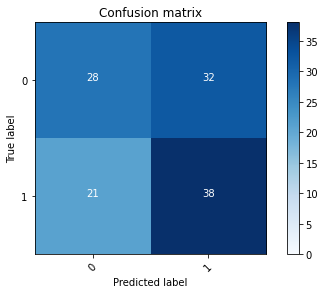

2022-08-22 18:09:15 - [Epoch Train: 75] loss: 0.0053, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:09:15 - [Epoch Valid: 75] loss: 3.1180, auc: 0.4935, acc: 0.5546, time: 6.00 s
2022-08-22 18:09:15 - acc improved from 0.5546 to 0.5546. Saved model to '../RSNA-BTC-Datasets/out_models/RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e75-loss3.118-acc0.555-auc0.494.pth'


 75%|███████████████████████████████▌          | 75/100 [38:10<12:45, 30.61s/it]

2022-08-22 18:09:15 - EPOCH: 76
2022-08-22 18:09:18 - Train Step 10/122, train_loss: 0.0149
2022-08-22 18:09:20 - Train Step 20/122, train_loss: 0.0076
2022-08-22 18:09:22 - Train Step 30/122, train_loss: 0.0052
2022-08-22 18:09:24 - Train Step 40/122, train_loss: 0.0099
2022-08-22 18:09:25 - Train Step 50/122, train_loss: 0.0080
2022-08-22 18:09:27 - Train Step 60/122, train_loss: 0.0067
2022-08-22 18:09:29 - Train Step 70/122, train_loss: 0.0058
2022-08-22 18:09:31 - Train Step 80/122, train_loss: 0.0051
2022-08-22 18:09:33 - Train Step 90/122, train_loss: 0.0045
2022-08-22 18:09:35 - Train Step 100/122, train_loss: 0.0041
2022-08-22 18:09:37 - Train Step 110/122, train_loss: 0.0037
2022-08-22 18:09:39 - Train Step 120/122, train_loss: 0.0034
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:09:41 - Valid Step 5/30, valid_loss: 2.7720
2022-08-22 18:09:42 - Valid Step 10/30, valid_loss: 2.4554
2022-08-22 18:09:43 - Valid Step 15/30, valid_loss: 2.7846
2022-08-22 18:09:44

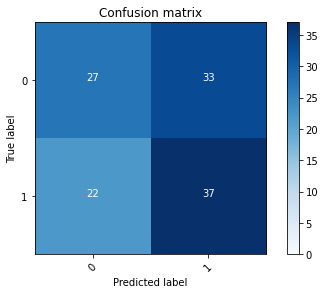

2022-08-22 18:09:46 - [Epoch Train: 76] loss: 0.0034, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:09:46 - [Epoch Valid: 76] loss: 3.0911, auc: 0.4924, acc: 0.5378, time: 6.00 s


 76%|███████████████████████████████▉          | 76/100 [38:41<12:12, 30.50s/it]

2022-08-22 18:09:46 - EPOCH: 77
2022-08-22 18:09:48 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:09:50 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:09:52 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:09:54 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:09:56 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:09:58 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:10:00 - Train Step 70/122, train_loss: 0.0002
2022-08-22 18:10:01 - Train Step 80/122, train_loss: 0.0001
2022-08-22 18:10:03 - Train Step 90/122, train_loss: 0.0001
2022-08-22 18:10:05 - Train Step 100/122, train_loss: 0.0001
2022-08-22 18:10:07 - Train Step 110/122, train_loss: 0.0006
2022-08-22 18:10:09 - Train Step 120/122, train_loss: 0.0037
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:10:11 - Valid Step 5/30, valid_loss: 2.7010
2022-08-22 18:10:12 - Valid Step 10/30, valid_loss: 3.0874
2022-08-22 18:10:13 - Valid Step 15/30, valid_loss: 3.1916
2022-08-22 18:10:14

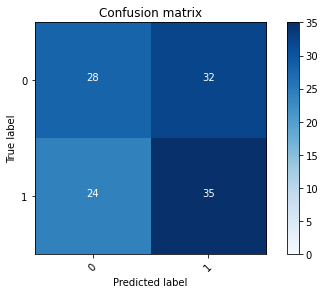

2022-08-22 18:10:16 - [Epoch Train: 77] loss: 0.0037, auc: 1.0000, acc: 0.9979, time: 23.00 s            
2022-08-22 18:10:16 - [Epoch Valid: 77] loss: 3.1891, auc: 0.4918, acc: 0.5294, time: 6.00 s


 77%|████████████████████████████████▎         | 77/100 [39:11<11:40, 30.44s/it]

2022-08-22 18:10:16 - EPOCH: 78
2022-08-22 18:10:18 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:10:20 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:10:22 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:10:24 - Train Step 40/122, train_loss: 0.0041
2022-08-22 18:10:26 - Train Step 50/122, train_loss: 0.0033
2022-08-22 18:10:28 - Train Step 60/122, train_loss: 0.0028
2022-08-22 18:10:30 - Train Step 70/122, train_loss: 0.0024
2022-08-22 18:10:32 - Train Step 80/122, train_loss: 0.0021
2022-08-22 18:10:34 - Train Step 90/122, train_loss: 0.0019
2022-08-22 18:10:36 - Train Step 100/122, train_loss: 0.0039
2022-08-22 18:10:38 - Train Step 110/122, train_loss: 0.0035
2022-08-22 18:10:40 - Train Step 120/122, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:10:42 - Valid Step 5/30, valid_loss: 3.9866
2022-08-22 18:10:43 - Valid Step 10/30, valid_loss: 4.1812
2022-08-22 18:10:44 - Valid Step 15/30, valid_loss: 4.3751
2022-08-22 18:10:45

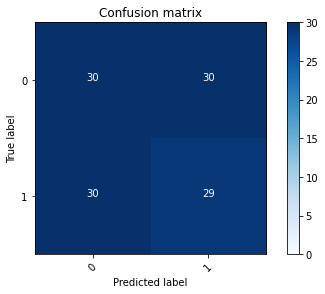

2022-08-22 18:10:47 - [Epoch Train: 78] loss: 0.0032, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:10:47 - [Epoch Valid: 78] loss: 3.2302, auc: 0.4884, acc: 0.4958, time: 6.00 s


 78%|████████████████████████████████▊         | 78/100 [39:41<11:11, 30.51s/it]

2022-08-22 18:10:47 - EPOCH: 79
2022-08-22 18:10:49 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:10:51 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:10:53 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:10:55 - Train Step 40/122, train_loss: 0.0003
2022-08-22 18:10:57 - Train Step 50/122, train_loss: 0.0003
2022-08-22 18:10:59 - Train Step 60/122, train_loss: 0.0003
2022-08-22 18:11:01 - Train Step 70/122, train_loss: 0.0029
2022-08-22 18:11:03 - Train Step 80/122, train_loss: 0.0026
2022-08-22 18:11:05 - Train Step 90/122, train_loss: 0.0023
2022-08-22 18:11:07 - Train Step 100/122, train_loss: 0.0021
2022-08-22 18:11:09 - Train Step 110/122, train_loss: 0.0020
2022-08-22 18:11:11 - Train Step 120/122, train_loss: 0.0042
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:11:13 - Valid Step 5/30, valid_loss: 2.2137
2022-08-22 18:11:13 - Valid Step 10/30, valid_loss: 2.5874
2022-08-22 18:11:15 - Valid Step 15/30, valid_loss: 3.1680
2022-08-22 18:11:15

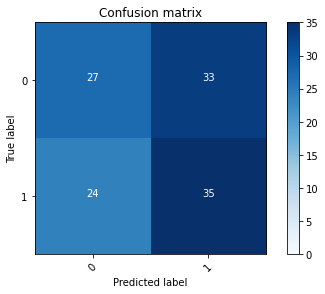

2022-08-22 18:11:17 - [Epoch Train: 79] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:11:17 - [Epoch Valid: 79] loss: 3.0661, auc: 0.4907, acc: 0.5210, time: 6.00 s


 79%|█████████████████████████████████▏        | 79/100 [40:12<10:41, 30.56s/it]

2022-08-22 18:11:17 - EPOCH: 80
2022-08-22 18:11:20 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:11:22 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:11:24 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:11:25 - Train Step 40/122, train_loss: 0.0035
2022-08-22 18:11:27 - Train Step 50/122, train_loss: 0.0029
2022-08-22 18:11:29 - Train Step 60/122, train_loss: 0.0025
2022-08-22 18:11:31 - Train Step 70/122, train_loss: 0.0021
2022-08-22 18:11:33 - Train Step 80/122, train_loss: 0.0019
2022-08-22 18:11:35 - Train Step 90/122, train_loss: 0.0062
2022-08-22 18:11:37 - Train Step 100/122, train_loss: 0.0056
2022-08-22 18:11:39 - Train Step 110/122, train_loss: 0.0051
2022-08-22 18:11:41 - Train Step 120/122, train_loss: 0.0047
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:11:43 - Valid Step 5/30, valid_loss: 2.7442
2022-08-22 18:11:44 - Valid Step 10/30, valid_loss: 3.6131
2022-08-22 18:11:45 - Valid Step 15/30, valid_loss: 3.9028
2022-08-22 18:11:46

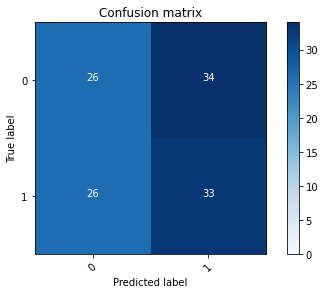

2022-08-22 18:11:48 - [Epoch Train: 80] loss: 0.0046, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:11:48 - [Epoch Valid: 80] loss: 3.1934, auc: 0.4836, acc: 0.4958, time: 6.00 s


 80%|█████████████████████████████████▌        | 80/100 [40:42<10:09, 30.48s/it]

2022-08-22 18:11:48 - EPOCH: 81
2022-08-22 18:11:50 - Train Step 10/122, train_loss: 0.0003
2022-08-22 18:11:52 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:11:54 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:11:56 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:11:58 - Train Step 50/122, train_loss: 0.0047
2022-08-22 18:12:00 - Train Step 60/122, train_loss: 0.0085
2022-08-22 18:12:02 - Train Step 70/122, train_loss: 0.0073
2022-08-22 18:12:04 - Train Step 80/122, train_loss: 0.0064
2022-08-22 18:12:05 - Train Step 90/122, train_loss: 0.0057
2022-08-22 18:12:07 - Train Step 100/122, train_loss: 0.0051
2022-08-22 18:12:09 - Train Step 110/122, train_loss: 0.0047
2022-08-22 18:12:11 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:12:13 - Valid Step 5/30, valid_loss: 4.7019
2022-08-22 18:12:14 - Valid Step 10/30, valid_loss: 3.3187
2022-08-22 18:12:15 - Valid Step 15/30, valid_loss: 2.9041
2022-08-22 18:12:16

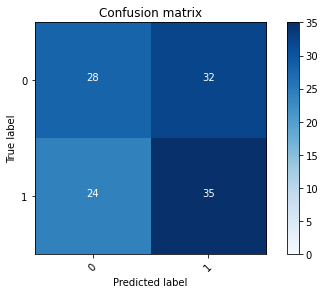

2022-08-22 18:12:18 - [Epoch Train: 81] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:12:18 - [Epoch Valid: 81] loss: 2.9777, auc: 0.4876, acc: 0.5294, time: 6.00 s


 81%|██████████████████████████████████        | 81/100 [41:13<09:39, 30.48s/it]

2022-08-22 18:12:18 - EPOCH: 82
2022-08-22 18:12:20 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:12:22 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:12:24 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:12:26 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:12:28 - Train Step 50/122, train_loss: 0.0042
2022-08-22 18:12:30 - Train Step 60/122, train_loss: 0.0035
2022-08-22 18:12:32 - Train Step 70/122, train_loss: 0.0031
2022-08-22 18:12:34 - Train Step 80/122, train_loss: 0.0027
2022-08-22 18:12:36 - Train Step 90/122, train_loss: 0.0025
2022-08-22 18:12:38 - Train Step 100/122, train_loss: 0.0022
2022-08-22 18:12:40 - Train Step 110/122, train_loss: 0.0020
2022-08-22 18:12:42 - Train Step 120/122, train_loss: 0.0056
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:12:44 - Valid Step 5/30, valid_loss: 3.1552
2022-08-22 18:12:45 - Valid Step 10/30, valid_loss: 2.8277
2022-08-22 18:12:46 - Valid Step 15/30, valid_loss: 2.7259
2022-08-22 18:12:47

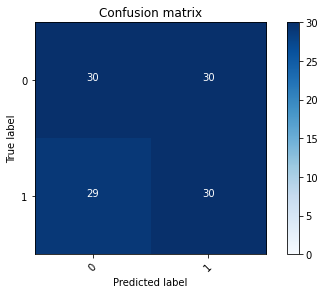

2022-08-22 18:12:49 - [Epoch Train: 82] loss: 0.0055, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:12:49 - [Epoch Valid: 82] loss: 3.1201, auc: 0.4847, acc: 0.5042, time: 6.00 s


 82%|██████████████████████████████████▍       | 82/100 [41:43<09:08, 30.48s/it]

2022-08-22 18:12:49 - EPOCH: 83
2022-08-22 18:12:51 - Train Step 10/122, train_loss: 0.0000
2022-08-22 18:12:53 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:12:55 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:12:57 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:12:59 - Train Step 50/122, train_loss: 0.0043
2022-08-22 18:13:01 - Train Step 60/122, train_loss: 0.0037
2022-08-22 18:13:03 - Train Step 70/122, train_loss: 0.0032
2022-08-22 18:13:05 - Train Step 80/122, train_loss: 0.0028
2022-08-22 18:13:07 - Train Step 90/122, train_loss: 0.0025
2022-08-22 18:13:08 - Train Step 100/122, train_loss: 0.0023
2022-08-22 18:13:10 - Train Step 110/122, train_loss: 0.0046
2022-08-22 18:13:12 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:13:14 - Valid Step 5/30, valid_loss: 3.3486
2022-08-22 18:13:15 - Valid Step 10/30, valid_loss: 3.6268
2022-08-22 18:13:16 - Valid Step 15/30, valid_loss: 3.6866
2022-08-22 18:13:17

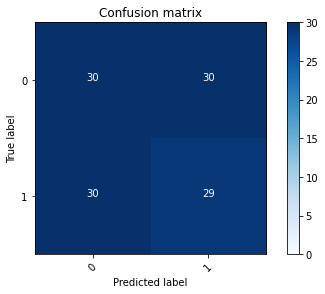

2022-08-22 18:13:19 - [Epoch Train: 83] loss: 0.0042, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:13:19 - [Epoch Valid: 83] loss: 3.0421, auc: 0.4770, acc: 0.4958, time: 6.00 s


 83%|██████████████████████████████████▊       | 83/100 [42:14<08:37, 30.46s/it]

2022-08-22 18:13:19 - EPOCH: 84
2022-08-22 18:13:21 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:13:23 - Train Step 20/122, train_loss: 0.0003
2022-08-22 18:13:25 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:13:27 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:13:29 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:13:31 - Train Step 60/122, train_loss: 0.0002
2022-08-22 18:13:33 - Train Step 70/122, train_loss: 0.0034
2022-08-22 18:13:35 - Train Step 80/122, train_loss: 0.0030
2022-08-22 18:13:37 - Train Step 90/122, train_loss: 0.0027
2022-08-22 18:13:39 - Train Step 100/122, train_loss: 0.0047
2022-08-22 18:13:41 - Train Step 110/122, train_loss: 0.0043
2022-08-22 18:13:43 - Train Step 120/122, train_loss: 0.0039
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:13:45 - Valid Step 5/30, valid_loss: 1.4364
2022-08-22 18:13:46 - Valid Step 10/30, valid_loss: 2.4028
2022-08-22 18:13:47 - Valid Step 15/30, valid_loss: 2.9966
2022-08-22 18:13:48

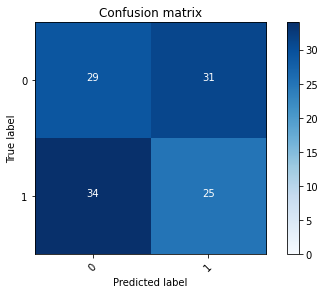

2022-08-22 18:13:50 - [Epoch Train: 84] loss: 0.0039, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:13:50 - [Epoch Valid: 84] loss: 3.0849, auc: 0.4862, acc: 0.4538, time: 6.00 s


 84%|███████████████████████████████████▎      | 84/100 [42:45<08:09, 30.57s/it]

2022-08-22 18:13:50 - EPOCH: 85
2022-08-22 18:13:52 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:13:54 - Train Step 20/122, train_loss: 0.0098
2022-08-22 18:13:56 - Train Step 30/122, train_loss: 0.0066
2022-08-22 18:13:58 - Train Step 40/122, train_loss: 0.0049
2022-08-22 18:14:00 - Train Step 50/122, train_loss: 0.0040
2022-08-22 18:14:02 - Train Step 60/122, train_loss: 0.0034
2022-08-22 18:14:04 - Train Step 70/122, train_loss: 0.0029
2022-08-22 18:14:06 - Train Step 80/122, train_loss: 0.0025
2022-08-22 18:14:08 - Train Step 90/122, train_loss: 0.0023
2022-08-22 18:14:10 - Train Step 100/122, train_loss: 0.0020
2022-08-22 18:14:12 - Train Step 110/122, train_loss: 0.0047
2022-08-22 18:14:14 - Train Step 120/122, train_loss: 0.0043
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:14:16 - Valid Step 5/30, valid_loss: 4.8446
2022-08-22 18:14:16 - Valid Step 10/30, valid_loss: 3.6141
2022-08-22 18:14:18 - Valid Step 15/30, valid_loss: 3.2852
2022-08-22 18:14:18

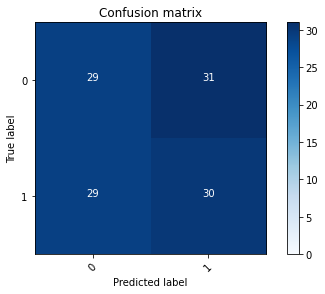

2022-08-22 18:14:20 - [Epoch Train: 85] loss: 0.0043, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:14:20 - [Epoch Valid: 85] loss: 3.2327, auc: 0.4833, acc: 0.4958, time: 6.00 s


 85%|███████████████████████████████████▋      | 85/100 [43:15<07:38, 30.57s/it]

2022-08-22 18:14:20 - EPOCH: 86
2022-08-22 18:14:23 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:14:25 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:14:27 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:14:29 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:14:30 - Train Step 50/122, train_loss: 0.0034
2022-08-22 18:14:32 - Train Step 60/122, train_loss: 0.0028
2022-08-22 18:14:34 - Train Step 70/122, train_loss: 0.0025
2022-08-22 18:14:36 - Train Step 80/122, train_loss: 0.0022
2022-08-22 18:14:38 - Train Step 90/122, train_loss: 0.0020
2022-08-22 18:14:40 - Train Step 100/122, train_loss: 0.0018
2022-08-22 18:14:42 - Train Step 110/122, train_loss: 0.0016
2022-08-22 18:14:44 - Train Step 120/122, train_loss: 0.0033
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:14:46 - Valid Step 5/30, valid_loss: 5.2045
2022-08-22 18:14:47 - Valid Step 10/30, valid_loss: 4.9282
2022-08-22 18:14:48 - Valid Step 15/30, valid_loss: 4.7071
2022-08-22 18:14:49

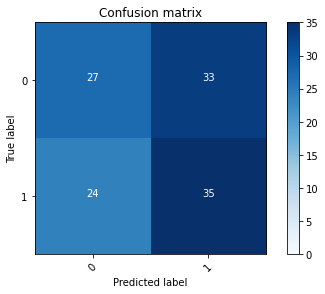

2022-08-22 18:14:51 - [Epoch Train: 86] loss: 0.0033, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:14:51 - [Epoch Valid: 86] loss: 3.2254, auc: 0.4960, acc: 0.5210, time: 6.00 s


 86%|████████████████████████████████████      | 86/100 [43:46<07:07, 30.54s/it]

2022-08-22 18:14:51 - EPOCH: 87
2022-08-22 18:14:53 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:14:55 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:14:57 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:14:59 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:15:01 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:15:03 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:15:05 - Train Step 70/122, train_loss: 0.0001
2022-08-22 18:15:07 - Train Step 80/122, train_loss: 0.0013
2022-08-22 18:15:09 - Train Step 90/122, train_loss: 0.0012
2022-08-22 18:15:11 - Train Step 100/122, train_loss: 0.0011
2022-08-22 18:15:13 - Train Step 110/122, train_loss: 0.0026
2022-08-22 18:15:15 - Train Step 120/122, train_loss: 0.0024
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:15:17 - Valid Step 5/30, valid_loss: 1.7558
2022-08-22 18:15:17 - Valid Step 10/30, valid_loss: 2.6159
2022-08-22 18:15:19 - Valid Step 15/30, valid_loss: 3.4638
2022-08-22 18:15:19

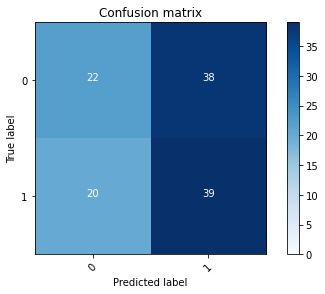

2022-08-22 18:15:21 - [Epoch Train: 87] loss: 0.0023, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 18:15:21 - [Epoch Valid: 87] loss: 3.4242, auc: 0.4927, acc: 0.5126, time: 6.00 s


 87%|████████████████████████████████████▌     | 87/100 [44:16<06:37, 30.54s/it]

2022-08-22 18:15:21 - EPOCH: 88
2022-08-22 18:15:24 - Train Step 10/122, train_loss: 0.0003
2022-08-22 18:15:26 - Train Step 20/122, train_loss: 0.0002
2022-08-22 18:15:28 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:15:30 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:15:32 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:15:34 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:15:36 - Train Step 70/122, train_loss: 0.0028
2022-08-22 18:15:38 - Train Step 80/122, train_loss: 0.0025
2022-08-22 18:15:40 - Train Step 90/122, train_loss: 0.0022
2022-08-22 18:15:42 - Train Step 100/122, train_loss: 0.0037
2022-08-22 18:15:44 - Train Step 110/122, train_loss: 0.0034
2022-08-22 18:15:46 - Train Step 120/122, train_loss: 0.0031
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:15:47 - Valid Step 5/30, valid_loss: 3.0691
2022-08-22 18:15:48 - Valid Step 10/30, valid_loss: 3.4187
2022-08-22 18:15:49 - Valid Step 15/30, valid_loss: 2.9941
2022-08-22 18:15:50

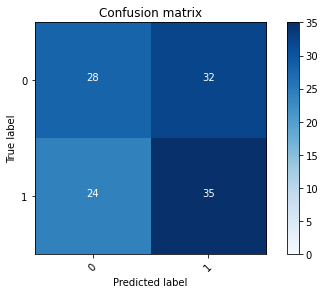

2022-08-22 18:15:52 - [Epoch Train: 88] loss: 0.0031, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:15:52 - [Epoch Valid: 88] loss: 3.1113, auc: 0.4887, acc: 0.5294, time: 6.00 s


 88%|████████████████████████████████████▉     | 88/100 [44:47<06:07, 30.62s/it]

2022-08-22 18:15:52 - EPOCH: 89
2022-08-22 18:15:55 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:15:57 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:15:59 - Train Step 30/122, train_loss: 0.0187
2022-08-22 18:16:01 - Train Step 40/122, train_loss: 0.0142
2022-08-22 18:16:03 - Train Step 50/122, train_loss: 0.0114
2022-08-22 18:16:05 - Train Step 60/122, train_loss: 0.0095
2022-08-22 18:16:06 - Train Step 70/122, train_loss: 0.0082
2022-08-22 18:16:08 - Train Step 80/122, train_loss: 0.0072
2022-08-22 18:16:10 - Train Step 90/122, train_loss: 0.0064
2022-08-22 18:16:12 - Train Step 100/122, train_loss: 0.0058
2022-08-22 18:16:14 - Train Step 110/122, train_loss: 0.0053
2022-08-22 18:16:16 - Train Step 120/122, train_loss: 0.0075
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:16:18 - Valid Step 5/30, valid_loss: 3.6020
2022-08-22 18:16:19 - Valid Step 10/30, valid_loss: 3.6637
2022-08-22 18:16:20 - Valid Step 15/30, valid_loss: 3.5172
2022-08-22 18:16:21

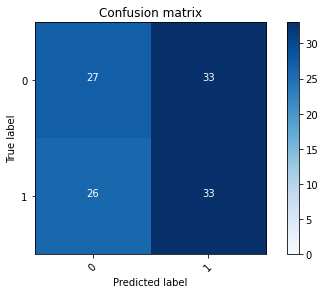

2022-08-22 18:16:23 - [Epoch Train: 89] loss: 0.0073, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:16:23 - [Epoch Valid: 89] loss: 3.5460, auc: 0.4840, acc: 0.5042, time: 6.00 s


 89%|█████████████████████████████████████▍    | 89/100 [45:18<05:38, 30.73s/it]

2022-08-22 18:16:23 - EPOCH: 90
2022-08-22 18:16:25 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:16:27 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:16:29 - Train Step 30/122, train_loss: 0.0003
2022-08-22 18:16:31 - Train Step 40/122, train_loss: 0.0002
2022-08-22 18:16:33 - Train Step 50/122, train_loss: 0.0002
2022-08-22 18:16:35 - Train Step 60/122, train_loss: 0.0002
2022-08-22 18:16:37 - Train Step 70/122, train_loss: 0.0042
2022-08-22 18:16:39 - Train Step 80/122, train_loss: 0.0037
2022-08-22 18:16:41 - Train Step 90/122, train_loss: 0.0080
2022-08-22 18:16:43 - Train Step 100/122, train_loss: 0.0072
2022-08-22 18:16:45 - Train Step 110/122, train_loss: 0.0066
2022-08-22 18:16:47 - Train Step 120/122, train_loss: 0.0060
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:16:49 - Valid Step 5/30, valid_loss: 2.1416
2022-08-22 18:16:50 - Valid Step 10/30, valid_loss: 2.6618
2022-08-22 18:16:51 - Valid Step 15/30, valid_loss: 2.6778
2022-08-22 18:16:51

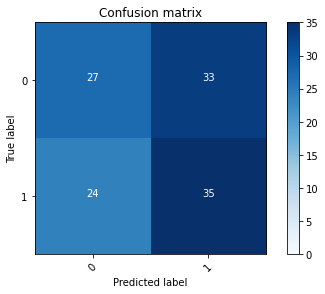

2022-08-22 18:16:54 - [Epoch Train: 90] loss: 0.0060, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:16:54 - [Epoch Valid: 90] loss: 3.1236, auc: 0.4908, acc: 0.5210, time: 6.00 s


 90%|█████████████████████████████████████▊    | 90/100 [45:48<05:05, 30.58s/it]

2022-08-22 18:16:54 - EPOCH: 91
2022-08-22 18:16:56 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:16:58 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:17:00 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:17:01 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:17:03 - Train Step 50/122, train_loss: 0.0015
2022-08-22 18:17:05 - Train Step 60/122, train_loss: 0.0012
2022-08-22 18:17:07 - Train Step 70/122, train_loss: 0.0011
2022-08-22 18:17:09 - Train Step 80/122, train_loss: 0.0009
2022-08-22 18:17:11 - Train Step 90/122, train_loss: 0.0009
2022-08-22 18:17:13 - Train Step 100/122, train_loss: 0.0008
2022-08-22 18:17:15 - Train Step 110/122, train_loss: 0.0007
2022-08-22 18:17:17 - Train Step 120/122, train_loss: 0.0007
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:17:19 - Valid Step 5/30, valid_loss: 3.5653
2022-08-22 18:17:20 - Valid Step 10/30, valid_loss: 3.1704
2022-08-22 18:17:21 - Valid Step 15/30, valid_loss: 3.1457
2022-08-22 18:17:22

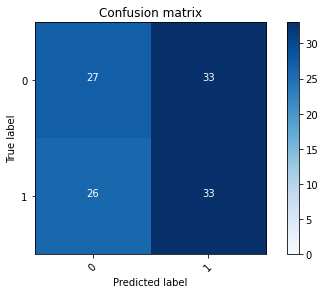

2022-08-22 18:17:24 - [Epoch Train: 91] loss: 0.0015, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 18:17:24 - [Epoch Valid: 91] loss: 3.4129, auc: 0.4895, acc: 0.5042, time: 6.00 s


 91%|██████████████████████████████████████▏   | 91/100 [46:19<04:34, 30.49s/it]

2022-08-22 18:17:24 - EPOCH: 92
2022-08-22 18:17:26 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:17:28 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:17:30 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:17:32 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:17:34 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:17:36 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:17:38 - Train Step 70/122, train_loss: 0.0001
2022-08-22 18:17:40 - Train Step 80/122, train_loss: 0.0001
2022-08-22 18:17:42 - Train Step 90/122, train_loss: 0.0001
2022-08-22 18:17:44 - Train Step 100/122, train_loss: 0.0001
2022-08-22 18:17:46 - Train Step 110/122, train_loss: 0.0001
2022-08-22 18:17:48 - Train Step 120/122, train_loss: 0.0025
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:17:49 - Valid Step 5/30, valid_loss: 2.2922
2022-08-22 18:17:50 - Valid Step 10/30, valid_loss: 3.4451
2022-08-22 18:17:51 - Valid Step 15/30, valid_loss: 3.5730
2022-08-22 18:17:52

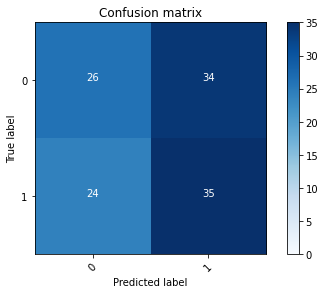

2022-08-22 18:17:54 - [Epoch Train: 92] loss: 0.0025, auc: 1.0000, acc: 1.0000, time: 24.00 s            
2022-08-22 18:17:54 - [Epoch Valid: 92] loss: 3.3946, auc: 0.4946, acc: 0.5126, time: 6.00 s


 92%|██████████████████████████████████████▋   | 92/100 [46:49<04:03, 30.46s/it]

2022-08-22 18:17:54 - EPOCH: 93
2022-08-22 18:17:56 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:17:58 - Train Step 20/122, train_loss: 0.0048
2022-08-22 18:18:00 - Train Step 30/122, train_loss: 0.0032
2022-08-22 18:18:02 - Train Step 40/122, train_loss: 0.0024
2022-08-22 18:18:04 - Train Step 50/122, train_loss: 0.0019
2022-08-22 18:18:06 - Train Step 60/122, train_loss: 0.0016
2022-08-22 18:18:08 - Train Step 70/122, train_loss: 0.0014
2022-08-22 18:18:10 - Train Step 80/122, train_loss: 0.0041
2022-08-22 18:18:12 - Train Step 90/122, train_loss: 0.0036
2022-08-22 18:18:14 - Train Step 100/122, train_loss: 0.0033
2022-08-22 18:18:16 - Train Step 110/122, train_loss: 0.0030
2022-08-22 18:18:18 - Train Step 120/122, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:18:20 - Valid Step 5/30, valid_loss: 4.6489
2022-08-22 18:18:21 - Valid Step 10/30, valid_loss: 2.9842
2022-08-22 18:18:22 - Valid Step 15/30, valid_loss: 2.9876
2022-08-22 18:18:23

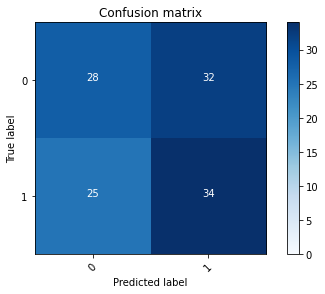

2022-08-22 18:18:25 - [Epoch Train: 93] loss: 0.0027, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:18:25 - [Epoch Valid: 93] loss: 3.1941, auc: 0.4833, acc: 0.5210, time: 6.00 s


 93%|███████████████████████████████████████   | 93/100 [47:20<03:33, 30.51s/it]

2022-08-22 18:18:25 - EPOCH: 94
2022-08-22 18:18:27 - Train Step 10/122, train_loss: 0.0000
2022-08-22 18:18:29 - Train Step 20/122, train_loss: 0.0108
2022-08-22 18:18:31 - Train Step 30/122, train_loss: 0.0072
2022-08-22 18:18:33 - Train Step 40/122, train_loss: 0.0055
2022-08-22 18:18:35 - Train Step 50/122, train_loss: 0.0044
2022-08-22 18:18:37 - Train Step 60/122, train_loss: 0.0037
2022-08-22 18:18:38 - Train Step 70/122, train_loss: 0.0032
2022-08-22 18:18:40 - Train Step 80/122, train_loss: 0.0028
2022-08-22 18:18:42 - Train Step 90/122, train_loss: 0.0025
2022-08-22 18:18:44 - Train Step 100/122, train_loss: 0.0047
2022-08-22 18:18:46 - Train Step 110/122, train_loss: 0.0043
2022-08-22 18:18:48 - Train Step 120/122, train_loss: 0.0040
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:18:50 - Valid Step 5/30, valid_loss: 2.5468
2022-08-22 18:18:51 - Valid Step 10/30, valid_loss: 3.4395
2022-08-22 18:18:52 - Valid Step 15/30, valid_loss: 2.9843
2022-08-22 18:18:53

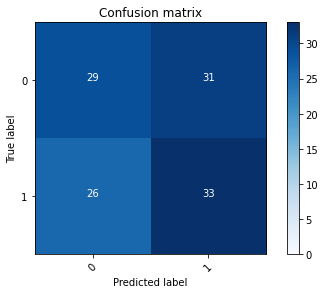

2022-08-22 18:18:55 - [Epoch Train: 94] loss: 0.0039, auc: 1.0000, acc: 0.9959, time: 23.00 s            
2022-08-22 18:18:55 - [Epoch Valid: 94] loss: 3.3020, auc: 0.4895, acc: 0.5210, time: 6.00 s


 94%|███████████████████████████████████████▍  | 94/100 [47:50<03:02, 30.44s/it]

2022-08-22 18:18:55 - EPOCH: 95
2022-08-22 18:18:57 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:18:59 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:19:01 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:19:03 - Train Step 40/122, train_loss: 0.0026
2022-08-22 18:19:05 - Train Step 50/122, train_loss: 0.0021
2022-08-22 18:19:07 - Train Step 60/122, train_loss: 0.0051
2022-08-22 18:19:09 - Train Step 70/122, train_loss: 0.0044
2022-08-22 18:19:11 - Train Step 80/122, train_loss: 0.0038
2022-08-22 18:19:13 - Train Step 90/122, train_loss: 0.0034
2022-08-22 18:19:15 - Train Step 100/122, train_loss: 0.0031
2022-08-22 18:19:17 - Train Step 110/122, train_loss: 0.0028
2022-08-22 18:19:19 - Train Step 120/122, train_loss: 0.0026
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:19:21 - Valid Step 5/30, valid_loss: 3.0206
2022-08-22 18:19:22 - Valid Step 10/30, valid_loss: 3.5409
2022-08-22 18:19:23 - Valid Step 15/30, valid_loss: 3.3139
2022-08-22 18:19:24

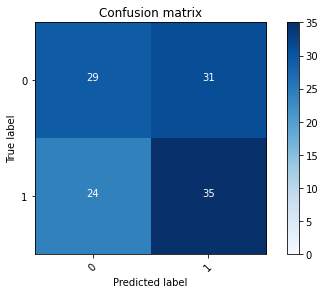

2022-08-22 18:19:26 - [Epoch Train: 95] loss: 0.0026, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:19:26 - [Epoch Valid: 95] loss: 3.2749, auc: 0.4887, acc: 0.5378, time: 6.00 s


 95%|███████████████████████████████████████▉  | 95/100 [48:21<02:32, 30.53s/it]

2022-08-22 18:19:26 - EPOCH: 96
2022-08-22 18:19:28 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:19:30 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:19:32 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:19:34 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:19:36 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:19:38 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:19:40 - Train Step 70/122, train_loss: 0.0028
2022-08-22 18:19:42 - Train Step 80/122, train_loss: 0.0024
2022-08-22 18:19:44 - Train Step 90/122, train_loss: 0.0022
2022-08-22 18:19:46 - Train Step 100/122, train_loss: 0.0042
2022-08-22 18:19:48 - Train Step 110/122, train_loss: 0.0038
2022-08-22 18:19:50 - Train Step 120/122, train_loss: 0.0035
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:19:52 - Valid Step 5/30, valid_loss: 3.7018
2022-08-22 18:19:53 - Valid Step 10/30, valid_loss: 3.1840
2022-08-22 18:19:54 - Valid Step 15/30, valid_loss: 2.9580
2022-08-22 18:19:55

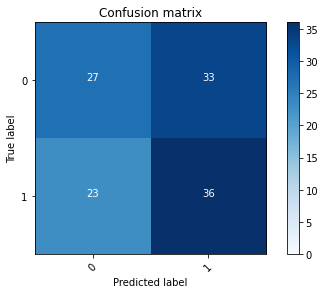

2022-08-22 18:19:57 - [Epoch Train: 96] loss: 0.0034, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:19:57 - [Epoch Valid: 96] loss: 3.2253, auc: 0.4904, acc: 0.5294, time: 6.00 s


 96%|████████████████████████████████████████▎ | 96/100 [48:52<02:02, 30.74s/it]

2022-08-22 18:19:57 - EPOCH: 97
2022-08-22 18:19:59 - Train Step 10/122, train_loss: 0.0000
2022-08-22 18:20:01 - Train Step 20/122, train_loss: 0.0000
2022-08-22 18:20:03 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:20:05 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:20:07 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:20:09 - Train Step 60/122, train_loss: 0.0001
2022-08-22 18:20:11 - Train Step 70/122, train_loss: 0.0046
2022-08-22 18:20:13 - Train Step 80/122, train_loss: 0.0040
2022-08-22 18:20:15 - Train Step 90/122, train_loss: 0.0036
2022-08-22 18:20:17 - Train Step 100/122, train_loss: 0.0033
2022-08-22 18:20:19 - Train Step 110/122, train_loss: 0.0030
2022-08-22 18:20:21 - Train Step 120/122, train_loss: 0.0054
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:20:23 - Valid Step 5/30, valid_loss: 5.8288
2022-08-22 18:20:24 - Valid Step 10/30, valid_loss: 3.9933
2022-08-22 18:20:25 - Valid Step 15/30, valid_loss: 3.9544
2022-08-22 18:20:26

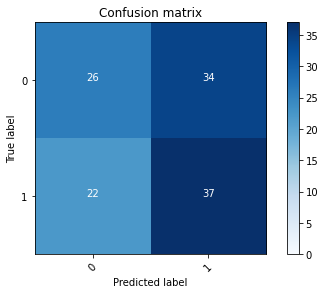

2022-08-22 18:20:28 - [Epoch Train: 97] loss: 0.0053, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:20:28 - [Epoch Valid: 97] loss: 3.4304, auc: 0.4864, acc: 0.5294, time: 6.00 s


 97%|████████████████████████████████████████▋ | 97/100 [49:22<01:32, 30.71s/it]

2022-08-22 18:20:28 - EPOCH: 98
2022-08-22 18:20:30 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:20:32 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:20:34 - Train Step 30/122, train_loss: 0.0002
2022-08-22 18:20:36 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:20:38 - Train Step 50/122, train_loss: 0.0038
2022-08-22 18:20:40 - Train Step 60/122, train_loss: 0.0031
2022-08-22 18:20:42 - Train Step 70/122, train_loss: 0.0027
2022-08-22 18:20:44 - Train Step 80/122, train_loss: 0.0024
2022-08-22 18:20:46 - Train Step 90/122, train_loss: 0.0021
2022-08-22 18:20:48 - Train Step 100/122, train_loss: 0.0045
2022-08-22 18:20:50 - Train Step 110/122, train_loss: 0.0041
2022-08-22 18:20:52 - Train Step 120/122, train_loss: 0.0038
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:20:53 - Valid Step 5/30, valid_loss: 2.8026
2022-08-22 18:20:54 - Valid Step 10/30, valid_loss: 3.1743
2022-08-22 18:20:55 - Valid Step 15/30, valid_loss: 3.7624
2022-08-22 18:20:56

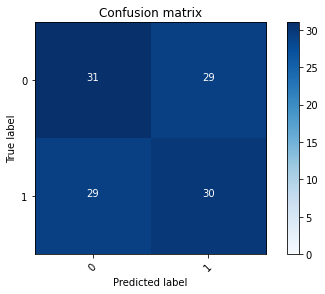

2022-08-22 18:20:58 - [Epoch Train: 98] loss: 0.0037, auc: 1.0000, acc: 0.9959, time: 24.00 s            
2022-08-22 18:20:58 - [Epoch Valid: 98] loss: 3.3643, auc: 0.4922, acc: 0.5126, time: 6.00 s


 98%|█████████████████████████████████████████▏| 98/100 [49:53<01:01, 30.65s/it]

2022-08-22 18:20:58 - EPOCH: 99
2022-08-22 18:21:00 - Train Step 10/122, train_loss: 0.0001
2022-08-22 18:21:02 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:21:04 - Train Step 30/122, train_loss: 0.0001
2022-08-22 18:21:06 - Train Step 40/122, train_loss: 0.0001
2022-08-22 18:21:08 - Train Step 50/122, train_loss: 0.0001
2022-08-22 18:21:10 - Train Step 60/122, train_loss: 0.0006
2022-08-22 18:21:12 - Train Step 70/122, train_loss: 0.0006
2022-08-22 18:21:14 - Train Step 80/122, train_loss: 0.0005
2022-08-22 18:21:16 - Train Step 90/122, train_loss: 0.0005
2022-08-22 18:21:18 - Train Step 100/122, train_loss: 0.0034
2022-08-22 18:21:20 - Train Step 110/122, train_loss: 0.0031
2022-08-22 18:21:22 - Train Step 120/122, train_loss: 0.0028
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:21:24 - Valid Step 5/30, valid_loss: 3.7665
2022-08-22 18:21:25 - Valid Step 10/30, valid_loss: 3.2223
2022-08-22 18:21:26 - Valid Step 15/30, valid_loss: 3.5475
2022-08-22 18:21:27

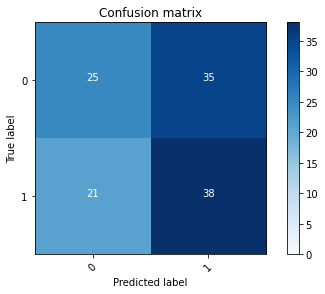

2022-08-22 18:21:29 - [Epoch Train: 99] loss: 0.0028, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:21:29 - [Epoch Valid: 99] loss: 3.3865, auc: 0.4953, acc: 0.5294, time: 6.00 s


 99%|█████████████████████████████████████████▌| 99/100 [50:24<00:30, 30.67s/it]

2022-08-22 18:21:29 - EPOCH: 100
2022-08-22 18:21:31 - Train Step 10/122, train_loss: 0.0002
2022-08-22 18:21:33 - Train Step 20/122, train_loss: 0.0001
2022-08-22 18:21:35 - Train Step 30/122, train_loss: 0.0021
2022-08-22 18:21:37 - Train Step 40/122, train_loss: 0.0016
2022-08-22 18:21:39 - Train Step 50/122, train_loss: 0.0104
2022-08-22 18:21:41 - Train Step 60/122, train_loss: 0.0087
2022-08-22 18:21:43 - Train Step 70/122, train_loss: 0.0074
2022-08-22 18:21:45 - Train Step 80/122, train_loss: 0.0065
2022-08-22 18:21:47 - Train Step 90/122, train_loss: 0.0058
2022-08-22 18:21:49 - Train Step 100/122, train_loss: 0.0053
2022-08-22 18:21:51 - Train Step 110/122, train_loss: 0.0048
2022-08-22 18:21:53 - Train Step 120/122, train_loss: 0.0044
Adjusting learning rate of group 0 to 5.0000e-05.
2022-08-22 18:21:54 - Valid Step 5/30, valid_loss: 2.8302
2022-08-22 18:21:55 - Valid Step 10/30, valid_loss: 2.9584
2022-08-22 18:21:56 - Valid Step 15/30, valid_loss: 3.1286
2022-08-22 18:21:5

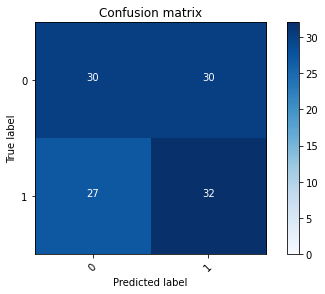

2022-08-22 18:21:59 - [Epoch Train: 100] loss: 0.0043, auc: 1.0000, acc: 0.9979, time: 24.00 s            
2022-08-22 18:21:59 - [Epoch Valid: 100] loss: 3.4746, auc: 0.4904, acc: 0.5210, time: 6.00 s


100%|█████████████████████████████████████████| 100/100 [50:54<00:00, 30.54s/it]


In [12]:
import importlib
from utils import dataset_utils
importlib.reload(dataset_utils)

for i in range(5):
    print(f"-- FOLD N:{i}")
    to = "m"#info["train_origin"]
    print(f"Train origin: {to}")
    packs = dataset_utils.generate_datasets(['KLF'], info, transform, sel_slices, m_path=dir_path)#, n_path=new_dir_path) #m_path=dir_path, 
    print(packs)
    loader_packs = dataset_utils.get_loaders(packs, info, is_fold=True, fold_num=i)
    print(loader_packs)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info("Using CUDA...")

    pd.set_option("display.max_rows", None, "display.max_columns", None)
    #print(loader_packs['KLF']['m_dataloaders'])
    selected_type = info["mri_types"][0]
    print(selected_type)
    dataloader = loader_packs[selected_type][f"{to}_dataloaders"]#m_dataloaders[0]
    # Train
    train_loader = dataloader[0]
    # Val
    val_loader = dataloader[1]

    m_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])

    print(info)
    m_modelfile = train_mri_type(m_model, device, info, epochs=100, pat=100, 
                           train_loader=train_loader, valid_loader=val_loader)

In [23]:
import importlib
from utils import dataset_utils
importlib.reload(dataset_utils)

def infer_cases(cases=["A", "A_B", "B", "B_A", "AB"]):
    #cases = ["A", "A_B", "B", "B_A", "AB"] #["A", "A_B", "B", "B_A", "AB"]
    all_metrics = {}

    for case in cases:
        #case = "A" #A, A_B, B, B_A, AB
        if case == "A" or case == "A_B":
            """
            folders_list = [
                "fold0_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18_16-34-18",
                "fold1_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18_16-49-14",
                "fold2_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18_17-01-12",
                "fold3_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18_17-13-33",
                "fold4_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18_17-54-33"
            ]
            """
            folders_list = [
                "fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17",
                "fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_14-52-37",
                "fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27",
                "fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_16-38-47",
                "fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05"
            ]
        elif case == "B" or case == "B_A":
            folders_list = [
                "fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-11-53",
                "fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-43-40",
                "fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-16-05",
                "fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-48-34",
                "fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_16-20-47"
            ]
        elif case == "AB":
            folders_list = [
                "fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_13-42-35",
                "fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_15-38-50",
                "fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_17-37-56",
                "fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_19-36-30",
                "fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_21-33-35"
            ]

        y_all = []
        y_pred_all = []
        y_prob_all = []

        metrics = pd.DataFrame({"model": [], "AUC": [], "acc": [], "spec": [], "sens": [], "prec": []})
        i = 0

        for folder in folders_list:
            model_common_path = "../RSNA-BTC-Datasets/out_models/"
            model_folder = model_common_path + folder

            model_basefile, info = get_best_model(model_folder)
            m_modelfile = model_folder + "/" + model_basefile
            transform = None
            size = len(info["mri_types"])
            sel_slices = 1 if info["dims"] == 2 else None
            chosen_net = "alt" if info["dims"] == 2 else "sim"

            m_model = try_and_get_model(chosen_net, info["dims"], size, info["is_depth_wise"], info["output_size"])

            #m_modelfile = m_modelfile_3d
            print(m_modelfile)
            print(info)
            print(f"-- FOLD N:{i}")

            if case == "A":
                to = "m"#info["train_origin"]
                data_idx = 1
            elif case == "A_B":
                to = "n"
                data_idx = 2 #full
            elif case == "B":
                to = "n"
                data_idx = 1
            elif case == "B_A":
                to = "m"
                data_idx = 2 #full
            elif case == "AB":
                to = "mn"
                data_idx = 1
            print(f"Train origin: {to}")
            if to == "m":
                packs = dataset_utils.generate_datasets(['KLF'], info, transform, sel_slices, m_path=dir_path) #m_path=dir_path, n_path=new_dir_path
            elif to == "n":
                packs = dataset_utils.generate_datasets(['KLF'], info, transform, sel_slices, n_path=new_dir_path)
            elif to == "mn":
                packs = dataset_utils.generate_datasets(['KLF'], info, transform, sel_slices, m_path=dir_path, n_path=new_dir_path)
            print(packs)
            loader_packs = dataset_utils.get_loaders(packs, info, is_fold=True, fold_num=i)
            print(loader_packs)

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            logging.info("Using CUDA...")

            pd.set_option("display.max_rows", None, "display.max_columns", None)
            #print(loader_packs['KLF']['m_dataloaders'])
            selected_type = info["mri_types"][0]
            print(selected_type)
            dataloader = loader_packs[selected_type][f"{to}_dataloaders"]#m_dataloaders[0]
            val_loader = dataloader[data_idx]
            #val_loader = dataloader[2] #full

            print("\nPREDICTIONS:")
            print(folder)
            #print(f"Test set: {to} (B)")
            test_loader = val_loader
            m_test_pred, ids, X, y, y_pred, y_prob = predict(m_model, device, m_modelfile, test_loader, size)
            pd_metrics = get_metrics(y, y_pred, y_prob, f"{folder}_{case}")
            y_all = y_all + y
            y_pred_all = y_pred_all + y_pred
            y_prob_all = y_prob_all + y_prob

            preddfA = pd.DataFrame({"BraTS21ID": ids, "MGMT_real_value": y, "MGMT_pred_value": y_pred, "MGMT_prob_value": y_prob}) 
            preddfA = preddfA.sort_values(by="BraTS21ID")
            preddfA.to_csv(f"pred_metrics/{folder}_{case}.csv", index=False)
            metrics = metrics.append(pd_metrics, ignore_index=True)
            #pd_metrics.to_csv(f"pred_metrics/{folder}_{to}_A_metrics.csv", index=False)

            print("----------\n")

            i += 1

        pd_metrics = get_metrics(y_all, y_pred_all, y_prob_all, f"all_{case}")
        metrics = metrics.append(pd_metrics, ignore_index=True)
        metrics.to_csv(f"pred_metrics/all_metrics_fold_3d_{case}.csv", index=False)
        all_metrics[case] = metrics
    return all_metrics

In [6]:
all_metrics["A"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.872678  0.801653   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.768305  0.624000   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.694444  0.642276   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.881421  0.818182   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.768362  0.704000   
5                                              all_A  0.787150  0.717073   

       spec      sens      prec  
0  0.750000  0.852459  0.776119  
1  0.269841  0.983871  0.570093  
2  0.666667  0.616667  0.637931  
3  0.866667  0.770492  0.854545  
4  0.651515  0.762712  0.661765  
5  0.637821  0.798680  0.681690

In [7]:
all_metrics["A_B"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.444463  0.447674   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.515568  0.541547   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.528506  0.494318   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.540159  0.560345   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-m_Aug18...  0.517776  0.517341   
5                                            all_A_B  0.514029  0.512363   

       spec      sens      prec  
0  0.354651  0.540698  0.455882  
1  0.445087  0.636364  0.538462  
2  0.852273  0.136364  0.480000  
3  0.587571  0.532164  0.554878  
4  0.810345  0.220930  0.535211  
5  0.611239  0.412918  0.513630

In [8]:
all_metrics["B"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.620098  0.657143   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.720147  0.621622   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.579094  0.535211   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.571726  0.565789   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.503472  0.485294   
5                                              all_B  0.588351  0.573816   

       spec      sens      prec  
0  0.666667  0.647059  0.647059  
1  0.771429  0.487179  0.703704  
2  0.648649  0.411765  0.518519  
3  0.783784  0.358974  0.636364  
4  0.527778  0.437500  0.451613  
5  0.679558  0.466292  0.588652

In [9]:
all_metrics["B_A"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.510456  0.503300   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.541151  0.516502   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.495082  0.490099   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.488977  0.488449   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.506165  0.514851   
5                                            all_B_A  0.505795  0.502640   

       spec      sens      prec  
0  0.801980  0.204620  0.508197  
1  0.686469  0.346535  0.525000  
2  0.528053  0.452145  0.489286  
3  0.636964  0.339934  0.483568  
4  0.524752  0.504950  0.515152  
5  0.635644  0.369637  0.503597

In [10]:
all_metrics["AB"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.548685  0.528455   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.576035  0.554264   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.624104  0.612000   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.508364  0.491870   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.554368  0.580000   
5                                             all_AB  0.574564  0.553600   

       spec      sens      prec  
0  0.598361  0.459677  0.537736  
1  0.541985  0.566929  0.545455  
2  0.642857  0.580645  0.615385  
3  0.432000  0.553719  0.485507  
4  0.592000  0.568000  0.581967  
5  0.561208  0.545894  0.551220

../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.713-acc0.541-auc0.539.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: m
Type: KLF
2022-08-24 10:05:48 - (M0) Train/Val datasets size: 270
2022-08-24 10:05:48 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd35eee0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96e0826f70>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_da

../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_14-52-37/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.689-acc0.529-auc0.559.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: m
Type: KLF
2022-08-24 10:07:01 - (M0) Train/Val datasets size: 270
2022-08-24 10:07:01 - (M1) Train/Val datasets size: 303


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc13d2e0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cce55cd0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 84, 85, 86, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 16

2022-08-24 10:08:13 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cce55700>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cce552b0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 154, 155, 156, 158, 159, 161, 162, 163, 166, 167, 168, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 182, 184, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268, 269, 271, 2

../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_16-38-47/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.692-acc0.536-auc0.546.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:3
Train origin: m
Type: KLF
2022-08-24 10:09:25 - (M0) Train/Val datasets size: 270
2022-08-24 10:09:25 - (M1) Train/Val datasets size: 303


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc09adf0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc09a6a0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 68, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 100, 102, 103, 104, 106, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164

----------

../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.713-acc0.555-auc0.518.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:4
Train origin: m
Type: KLF
2022-08-24 10:10:44 - (M0) Train/Val datasets size: 270
2022-08-24 10:10:44 - (M1) Train/Val datasets size: 303


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc0ab5b0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc0ab9d0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 129, 130, 131, 132, 134, 135, 136, 138, 139, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 164

../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.713-acc0.541-auc0.539.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: n
Type: KLF
2022-08-24 10:12:01 - (N0) Train/Val datasets size: 170
2022-08-24 10:12:01 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)
/tmp/ipykernel_3603821/4011572327.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cda78880>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cda78d90>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 49, 50, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 16

----------

../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_14-52-37/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.689-acc0.529-auc0.559.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: n
Type: KLF
2022-08-24 10:13:00 - (N0) Train/Val datasets size: 170
2022-08-24 10:13:00 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd5c0d60>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd5c0f40>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 31, 32, 33, 35, 36, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 66, 68, 69, 70, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 104, 105, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 161,

../RSNA-BTC-Datasets/out_models/fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_15-46-27/RSNAClassifierSingle3D-DW-SO-KLF-mn-e91-loss2.871-acc0.610-auc0.578.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:2
Train origin: n
Type: KLF
2022-08-24 10:13:58 - (N0) Train/Val datasets size: 170
2022-08-24 10:13:58 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd539eb0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd539dc0>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 109, 110, 112, 113, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 148, 149, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 1

----------

../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_16-38-47/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.692-acc0.536-auc0.546.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:3
Train origin: n
Type: KLF
2022-08-24 10:15:00 - (N0) Train/Val datasets size: 170
2022-08-24 10:15:00 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96c4aa6580>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96c4aa6400>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 125, 126, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159,

../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_17-31-05/RSNAClassifierSingle3D-DW-SO-KLF-mn-e2-loss0.713-acc0.555-auc0.518.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:4
Train origin: n
Type: KLF
2022-08-24 10:15:58 - (N0) Train/Val datasets size: 170
2022-08-24 10:15:58 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cc5ff520>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc5fff70>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 111, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 16

----------

Prediction AUC: 0.4878
Prediction Accuracy: 0.4899
Prediction Specificity: 0.5780
Prediction Sensitivity: 0.4016
Prediction Precision: 0.4868
../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-11-53/RSNAClassifierSingle3D-DW-SO-KLF-n-e30-loss1.329-acc0.629-auc0.600.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: n
Type: KLF
2022-08-24 10:16:56 - (N0) Train/Val datasets size: 170
2022-08-24 10:16:56 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)
/tmp/ipykernel_3603821/4011572327.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cc5882b0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc588400>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 49, 50, 52, 53, 55, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69, 70, 71, 72, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 119, 121, 122, 124, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 16

/usr/local/miniconda3.8/envs/gbm_mgmt/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)
/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-43-40/RSNAClassifierSingle3D-DW-SO-KLF-n-e23-loss1.094-acc0.622-auc0.687.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: n
Type: KLF
2022-08-24 10:17:40 - (N0) Train/Val datasets size: 170
2022-08-24 10:17:40 - (N1) Train/Val datasets size: 121
{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cc8ed0a0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc8ed1c0>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_datas

../RSNA-BTC-Datasets/out_models/fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-16-05/RSNAClassifierSingle3D-DW-SO-KLF-n-e60-loss2.333-acc0.575-auc0.601.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:2
Train origin: n
Type: KLF
2022-08-24 10:18:24 - (N0) Train/Val datasets size: 170
2022-08-24 10:18:24 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cca38c40>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cca38ca0>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 81, 82, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 102, 103, 104, 105, 106, 109, 110, 112, 113, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 145, 148, 149, 151, 152, 153, 155, 156, 157, 159, 160, 161, 162, 1

../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-48-34/RSNAClassifierSingle3D-DW-SO-KLF-n-e63-loss2.331-acc0.616-auc0.605.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:3
Train origin: n
Type: KLF
2022-08-24 10:19:08 - (N0) Train/Val datasets size: 170
2022-08-24 10:19:08 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc130550>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc1309d0>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 125, 126, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159,

../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_16-20-47/RSNAClassifierSingle3D-DW-SO-KLF-n-e71-loss1.998-acc0.542-auc0.532.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:4
Train origin: n
Type: KLF
2022-08-24 10:19:52 - (N0) Train/Val datasets size: 170
2022-08-24 10:19:52 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd549fd0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc8f2700>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
[([0, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 80, 81, 83, 84, 85, 86, 87, 88, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 106, 107, 108, 109, 111, 112, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 126, 127, 128, 129, 130, 131, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 16

../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-11-53/RSNAClassifierSingle3D-DW-SO-KLF-n-e30-loss1.329-acc0.629-auc0.600.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: m
Type: KLF
2022-08-24 10:20:35 - (M0) Train/Val datasets size: 270
2022-08-24 10:20:35 - (M1) Train/Val datasets size: 303


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)
/tmp/ipykernel_3603821/4011572327.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96c41e1cd0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96c41e19d0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 118, 120, 121, 122, 123, 125, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 164

Predictions: 481 without tumor, 125 with tumor
Prediction AUC: 0.5080
Prediction Accuracy: 0.4983
Prediction Specificity: 0.7921
Prediction Sensitivity: 0.2046
Prediction Precision: 0.4960
----------

../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_14-43-40/RSNAClassifierSingle3D-DW-SO-KLF-n-e23-loss1.094-acc0.622-auc0.687.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: m
Type: KLF
2022-08-24 10:22:24 - (M0) Train/Val datasets size: 270
2022-08-24 10:22:24 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccbb2cd0>, 'm_dataset_1': <utils.dataset_utils.Dataset object

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


[([0, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 84, 85, 86, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 210, 212, 213, 214, 215, 216, 219, 220, 222, 223, 224, 225, 226, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 249, 250, 251, 253, 256, 257, 258, 259, 260, 261, 262, 264, 265, 266, 268,

Predictions: 400 without tumor, 206 with tumor
Prediction AUC: 0.5260
Prediction Accuracy: 0.5066
Prediction Specificity: 0.6667
Prediction Sensitivity: 0.3465
Prediction Precision: 0.5097
----------

../RSNA-BTC-Datasets/out_models/fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-16-05/RSNAClassifierSingle3D-DW-SO-KLF-n-e60-loss2.333-acc0.575-auc0.601.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:2
Train origin: m
Type: KLF
2022-08-24 10:24:10 - (M0) Train/Val datasets size: 270
2022-08-24 10:24:10 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd38db50>, 'm_dataset_1': <utils.dataset_utils.Dataset object

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 154, 155, 156, 158, 159, 161, 162, 163, 166, 167, 168, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 182, 184, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 254, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 267, 268, 269, 270, 2

Prediction AUC: 0.4928
Prediction Accuracy: 0.4851
Prediction Specificity: 0.5182
Prediction Sensitivity: 0.4521
Prediction Precision: 0.4841
----------

../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_15-48-34/RSNAClassifierSingle3D-DW-SO-KLF-n-e63-loss2.331-acc0.616-auc0.605.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:3
Train origin: m
Type: KLF
2022-08-24 10:25:56 - (M0) Train/Val datasets size: 270
2022-08-24 10:25:56 - (M1) Train/Val datasets size: 303
{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cc653f70>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc653f10>, 'f_dataset_0': None, 'f_da

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 68, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 100, 102, 103, 104, 106, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 168, 169, 171, 172, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 187, 189, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 227, 228, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 248, 249, 250, 251, 252, 253, 254, 255, 259, 260, 261, 262, 263, 264, 265, 266, 267, 269, 270, 271, 

----------

../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19_16-20-47/RSNAClassifierSingle3D-DW-SO-KLF-n-e71-loss1.998-acc0.542-auc0.532.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'n', 'val_origin': 'n', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:4
Train origin: m
Type: KLF
2022-08-24 10:27:41 - (M0) Train/Val datasets size: 270
2022-08-24 10:27:41 - (M1) Train/Val datasets size: 303


/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd2a2b20>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd2a2ac0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': None, 'n_dataset_1': None, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 129, 130, 131, 132, 134, 135, 136, 138, 139, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 164

----------

Prediction AUC: 0.5032
Prediction Accuracy: 0.5003
Prediction Specificity: 0.6310
Prediction Sensitivity: 0.3696
Prediction Precision: 0.5004
../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_13-42-35/RSNAClassifierSingle3D-DW-SO-KLF-mn-e17-loss2.071-acc0.566-auc0.568.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: mn
Type: KLF
2022-08-24 10:29:25 - (M0) Train/Val datasets size: 270
2022-08-24 10:29:25 - (M1) Train/Val datasets size: 303
2022-08-24 10:29:25 - (N0) Train/Val datasets size: 170
2022-08-24 10:29:25 - (N1) Train/Val datasets size: 121
2022-08-24 10:29:25 - Concatenating M0 and N0...
Length of c

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)
/tmp/ipykernel_3603821/4011572327.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccd2dfa0>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96ccd2df40>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccd2df10>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96ccd2ddc0>, 'mn_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96ccd2ddf0>, 'mn_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cc98bee0>, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113

Length of concatenated dataset: 1212
Length of concatenated dataset: 1212
[([0, 1, 2, 3, 6, 7, 9, 10, 11, 13, 14, 15, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 117, 118, 120, 121, 122, 123, 125, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 148, 149, 150, 152, 153, 154, 155, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 174, 175, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 200, 201, 202, 203, 204, 205, 208, 209, 211, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 238, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 2

{'KLF': {'m_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cce38f40>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cce38820>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd62d370>], 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cc7e2df0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cc697070>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd6e1b50>], 'mn_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccd2de50>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccd2da30>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccd2df70>]}}
2022-08-24 10:36:20 - Using CUDA...
KLF

PREDICTIONS:
fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_13-42-35
2022-08-24 10:36:20 - Predict: ../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_13-42-35/RSNAClassifierSingle3D-DW-SO-KLF-mn-e17-loss2.071-acc0.566-auc0.568.pth 1212
Dataset: Labeled Test

../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_15-38-50/RSNAClassifierSingle3D-DW-SO-KLF-mn-e13-loss1.595-acc0.608-auc0.614.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: mn
Type: KLF
2022-08-24 10:36:34 - (M0) Train/Val datasets size: 270
2022-08-24 10:36:34 - (M1) Train/Val datasets size: 303
2022-08-24 10:36:34 - (N0) Train/Val datasets size: 170
2022-08-24 10:36:34 - (N1) Train/Val datasets size: 121
2022-08-24 10:36:34 - Concatenating M0 and N0...
Length of concatenated dataset: 540
2022-08-24 10:36:34 - (MN0) Train/Val datasets size: 540
2022-08-24 10:36:34 - Concatenating M1 and N1...
Length of concatenated 

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd3a4160>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd3a40a0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd3a4100>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd3a41c0>, 'mn_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd3a4070>, 'mn_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd3a4130>, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 84, 85, 86, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 11

Length of concatenated dataset: 1212
Length of concatenated dataset: 1212
[([0, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 73, 74, 75, 76, 77, 79, 84, 85, 86, 88, 90, 91, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119, 120, 121, 123, 124, 125, 126, 127, 128, 129, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 210, 212, 213, 214, 215, 216, 219, 220, 222, 223, 224, 225, 226, 228, 229, 231, 232, 234, 236, 237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 

{'KLF': {'m_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96dc074880>, <torch.utils.data.dataloader.DataLoader object at 0x7f96dc074850>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd9bb7c0>], 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cdaf3550>, <torch.utils.data.dataloader.DataLoader object at 0x7f96c4b126a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cccc9580>], 'mn_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cd62dee0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd62dd90>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd62d1c0>]}}
2022-08-24 10:43:28 - Using CUDA...
KLF

PREDICTIONS:
fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_15-38-50
2022-08-24 10:43:28 - Predict: ../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_15-38-50/RSNAClassifierSingle3D-DW-SO-KLF-mn-e13-loss1.595-acc0.608-auc0.614.pth 1212
Dataset: Labeled Test

../RSNA-BTC-Datasets/out_models/fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_17-37-56/RSNAClassifierSingle3D-DW-SO-KLF-mn-e87-loss5.090-acc0.606-auc0.605.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:2
Train origin: mn
Type: KLF
2022-08-24 10:43:42 - (M0) Train/Val datasets size: 270
2022-08-24 10:43:42 - (M1) Train/Val datasets size: 303
2022-08-24 10:43:42 - (N0) Train/Val datasets size: 170
2022-08-24 10:43:42 - (N1) Train/Val datasets size: 121
2022-08-24 10:43:42 - Concatenating M0 and N0...
Length of concatenated dataset: 540
2022-08-24 10:43:42 - (MN0) Train/Val datasets size: 540
2022-08-24 10:43:42 - Concatenating M1 and N1...
Length of concatenated 

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc089910>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc0898b0>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc0897f0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc089820>, 'mn_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc089790>, 'mn_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc0897c0>, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114,

Length of concatenated dataset: 1212
Length of concatenated dataset: 1212
[([0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 34, 35, 36, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 60, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 112, 113, 114, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 148, 150, 151, 154, 155, 156, 158, 159, 161, 162, 163, 166, 167, 168, 170, 171, 172, 173, 176, 177, 178, 179, 180, 181, 182, 184, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 250, 252, 254, 25

{'KLF': {'m_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96c42111c0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96c4211100>, <torch.utils.data.dataloader.DataLoader object at 0x7f96dc089430>], 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cc7e2c70>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccfb5970>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd576910>], 'mn_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cd3a4100>, <torch.utils.data.dataloader.DataLoader object at 0x7f96dc089280>, <torch.utils.data.dataloader.DataLoader object at 0x7f96dc089730>]}}
2022-08-24 10:50:40 - Using CUDA...
KLF

PREDICTIONS:
fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_17-37-56
2022-08-24 10:50:40 - Predict: ../RSNA-BTC-Datasets/out_models/fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_17-37-56/RSNAClassifierSingle3D-DW-SO-KLF-mn-e87-loss5.090-acc0.606-auc0.605.pth 1212
Dataset: Labeled Test

../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_19-36-30/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.799-acc0.532-auc0.508.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:3
Train origin: mn
Type: KLF
2022-08-24 10:50:54 - (M0) Train/Val datasets size: 270
2022-08-24 10:50:54 - (M1) Train/Val datasets size: 303
2022-08-24 10:50:54 - (N0) Train/Val datasets size: 170
2022-08-24 10:50:54 - (N1) Train/Val datasets size: 121
2022-08-24 10:50:54 - Concatenating M0 and N0...
Length of concatenated dataset: 540
2022-08-24 10:50:54 - (MN0) Train/Val datasets size: 540
2022-08-24 10:50:54 - Concatenating M1 and N1...
Length of concatenated d

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd1fda90>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd1fd820>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd601370>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96ccd56520>, 'mn_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96e07176d0>, 'mn_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cd1fd880>, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 68, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 100, 102, 103, 104, 106, 109, 110, 111, 112, 113, 115, 116, 118, 119

Length of concatenated dataset: 1212
Length of concatenated dataset: 1212
[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 64, 65, 66, 68, 71, 72, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 94, 97, 98, 100, 102, 103, 104, 106, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 168, 169, 171, 172, 173, 174, 175, 176, 177, 179, 181, 182, 183, 184, 185, 186, 187, 189, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 221, 222, 223, 224, 225, 227, 228, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 248, 249, 250, 251, 252, 2

{'KLF': {'m_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccb67580>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cce6c310>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cce6c880>], 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cd9bb910>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd62d370>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd62d220>], 'mn_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccfee940>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccfee7f0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96dc089820>]}}
2022-08-24 10:57:57 - Using CUDA...
KLF

PREDICTIONS:
fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_19-36-30
2022-08-24 10:57:57 - Predict: ../RSNA-BTC-Datasets/out_models/fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_19-36-30/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.799-acc0.532-auc0.508.pth 1212
Dataset: Labeled Test 

../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_21-33-35/RSNAClassifierSingle3D-DW-SO-KLF-mn-e70-loss3.113-acc0.584-auc0.560.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:4
Train origin: mn
Type: KLF
2022-08-24 10:58:11 - (M0) Train/Val datasets size: 270
2022-08-24 10:58:11 - (M1) Train/Val datasets size: 303
2022-08-24 10:58:11 - (N0) Train/Val datasets size: 170
2022-08-24 10:58:11 - (N1) Train/Val datasets size: 121
2022-08-24 10:58:11 - Concatenating M0 and N0...
Length of concatenated dataset: 540
2022-08-24 10:58:11 - (MN0) Train/Val datasets size: 540
2022-08-24 10:58:11 - Concatenating M1 and N1...
Length of concatenated 

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cce7d940>, 'm_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cce7d880>, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cce7d8e0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cce7d760>, 'mn_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96cd62ba60>, 'mn_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96cce7d700>, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 606
Length of concatenated dataset: 606
[([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 110

Length of concatenated dataset: 1212
Length of concatenated dataset: 1212
[([1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 129, 130, 131, 132, 134, 135, 136, 138, 139, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 156, 157, 158, 159, 160, 162, 164, 165, 166, 167, 169, 170, 173, 174, 175, 176, 177, 178, 179, 180, 182, 183, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 201, 202, 203, 206, 207, 208, 209, 210, 211, 212, 214, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 249, 251, 252, 253, 2

{'KLF': {'m_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccbd0f10>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccbd09d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cc70dc70>], 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccbe2400>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccbe2100>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd857370>], 'mn_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96cd2f43a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd2f4c10>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cd1fda90>]}}
2022-08-24 11:05:05 - Using CUDA...
KLF

PREDICTIONS:
fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_21-33-35
2022-08-24 11:05:05 - Predict: ../RSNA-BTC-Datasets/out_models/fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug20_21-33-35/RSNAClassifierSingle3D-DW-SO-KLF-mn-e70-loss3.113-acc0.584-auc0.560.pth 1212
Dataset: Labeled Test

/tmp/ipykernel_3603821/4011572327.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)
/tmp/ipykernel_3603821/4011572327.py:128: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


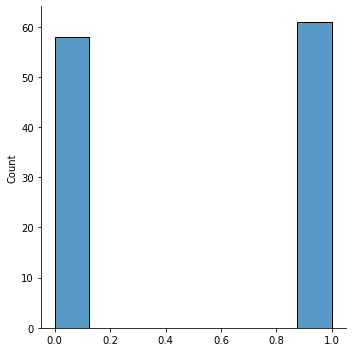

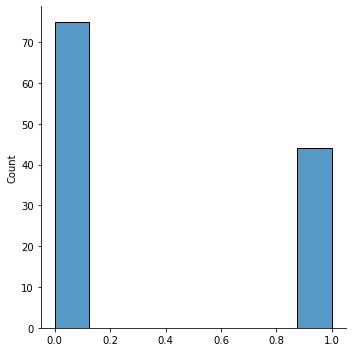

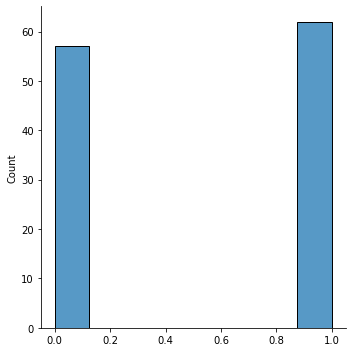

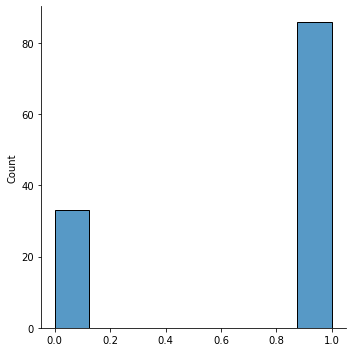

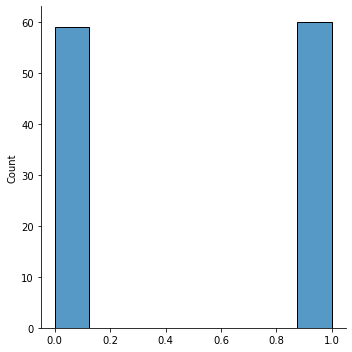

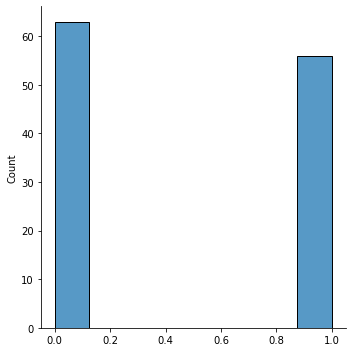

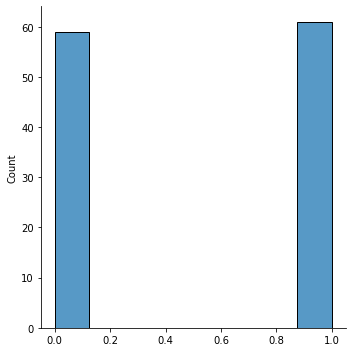

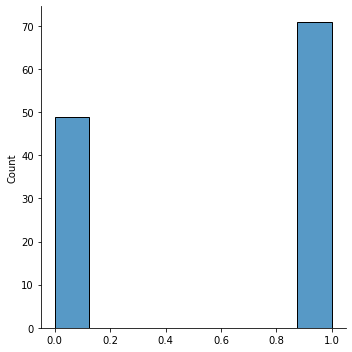

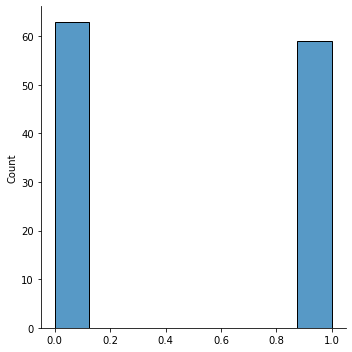

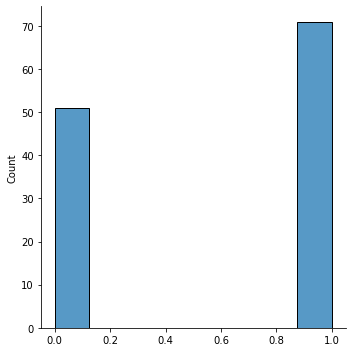

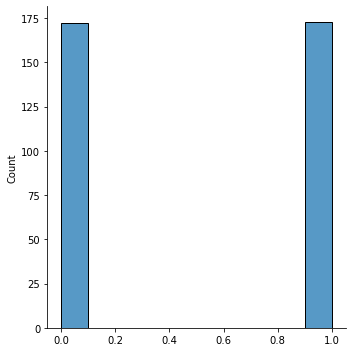

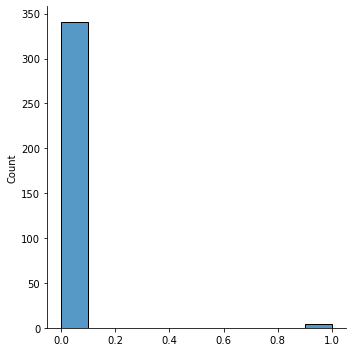

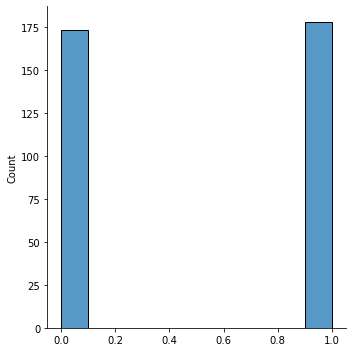

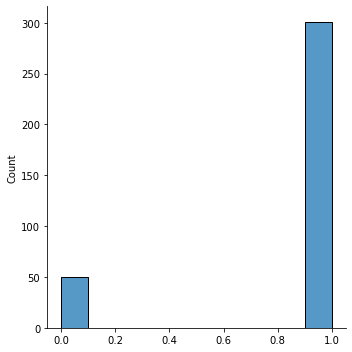

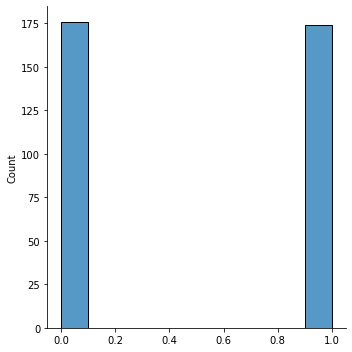

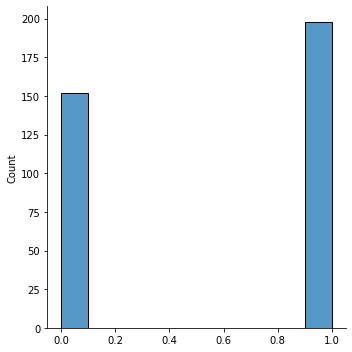

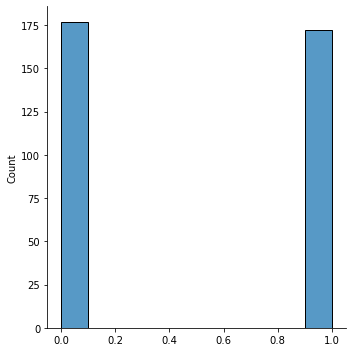

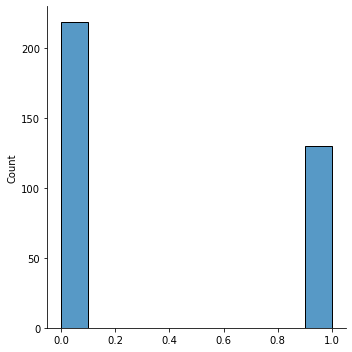

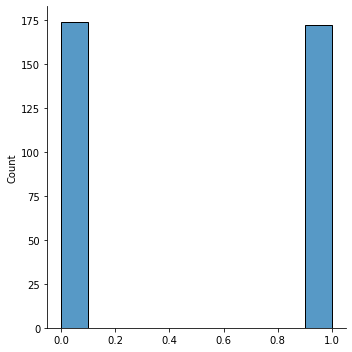

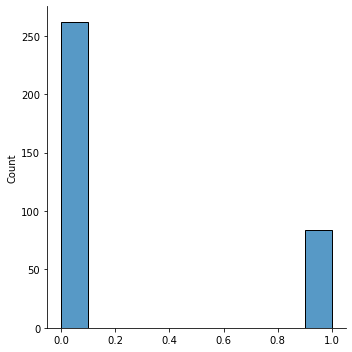

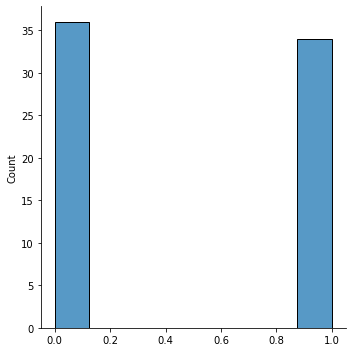

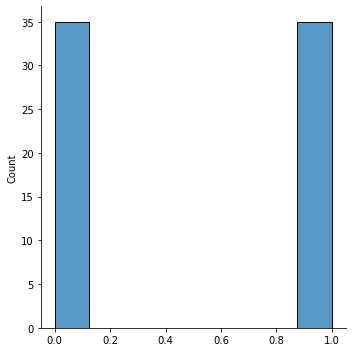

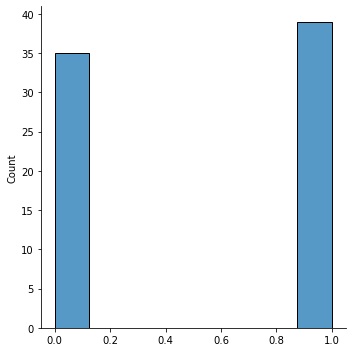

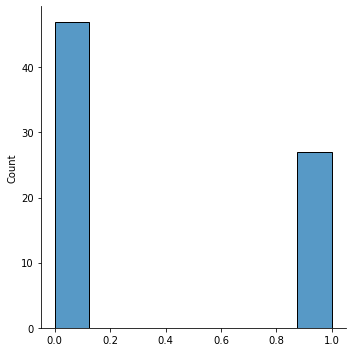

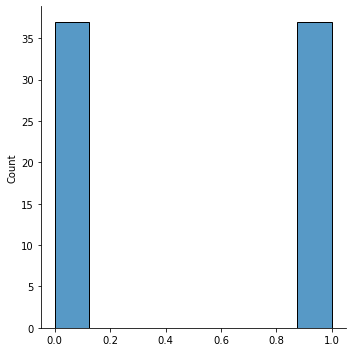

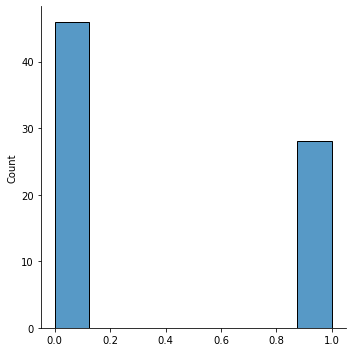

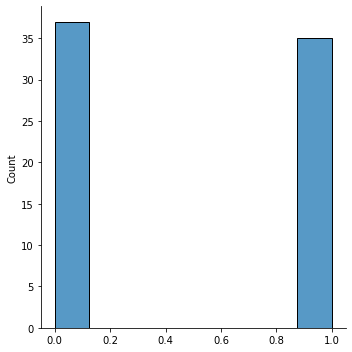

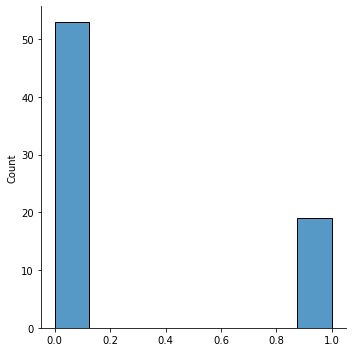

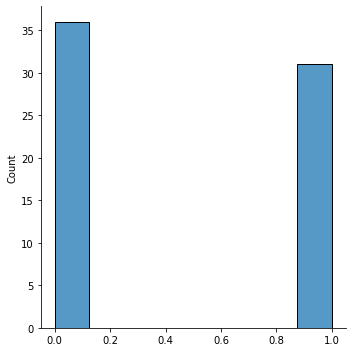

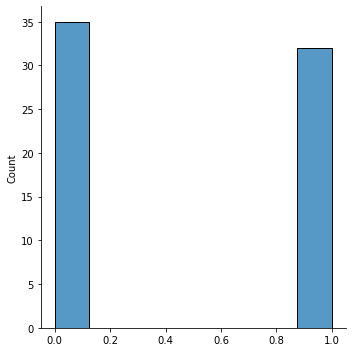

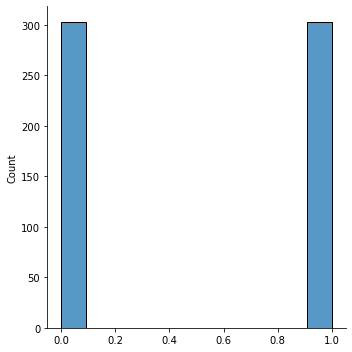

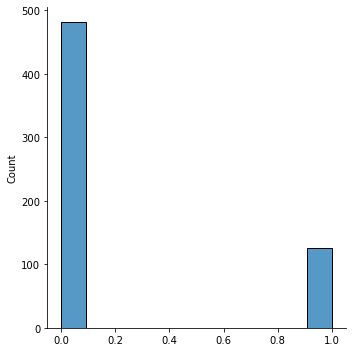

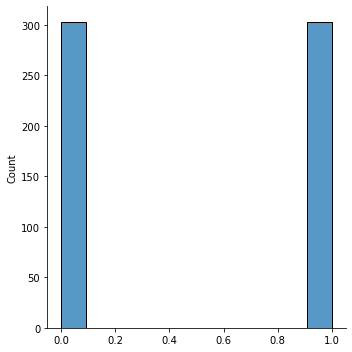

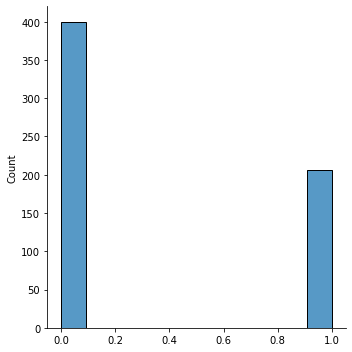

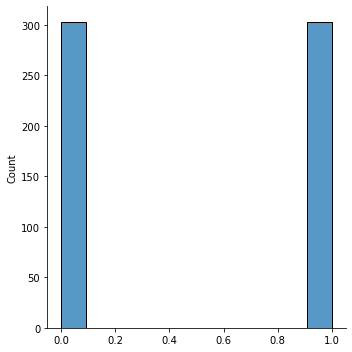

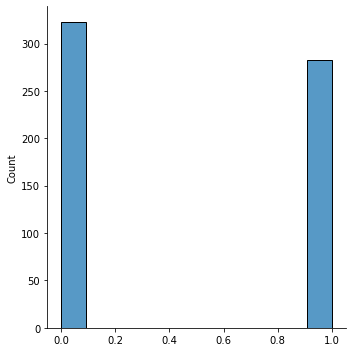

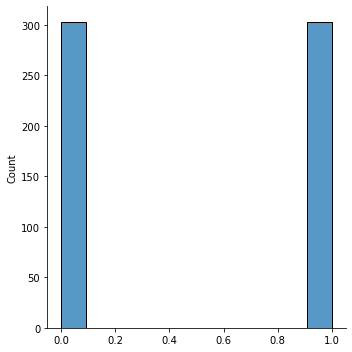

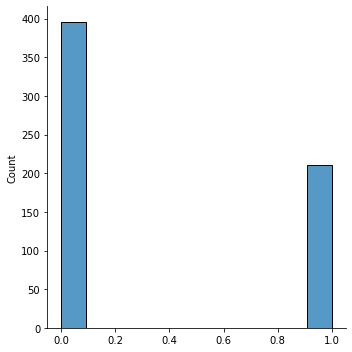

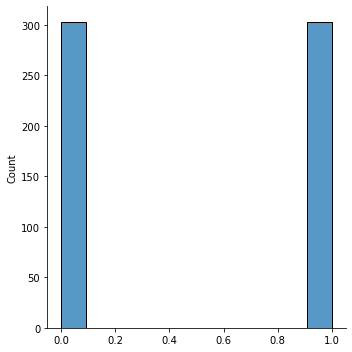

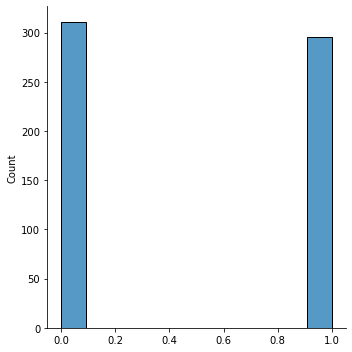

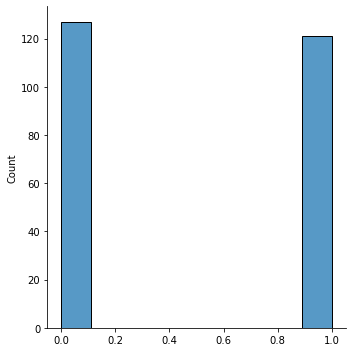

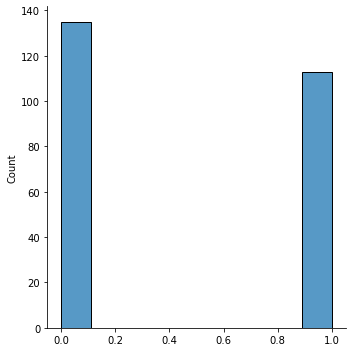

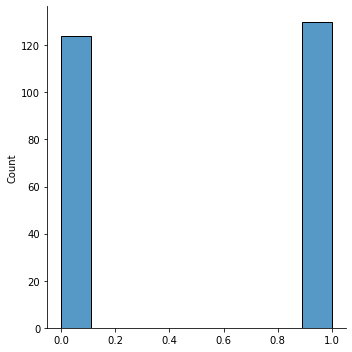

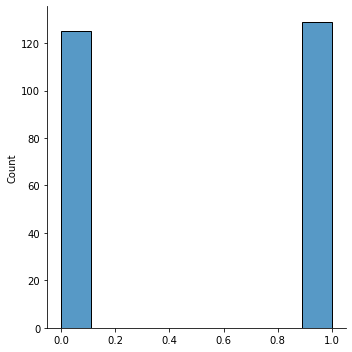

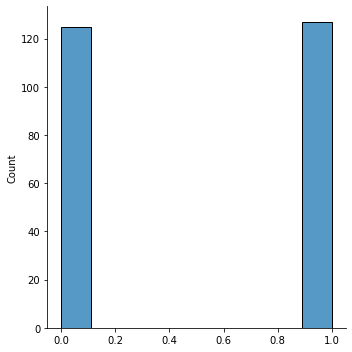

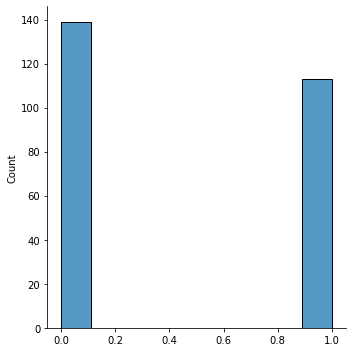

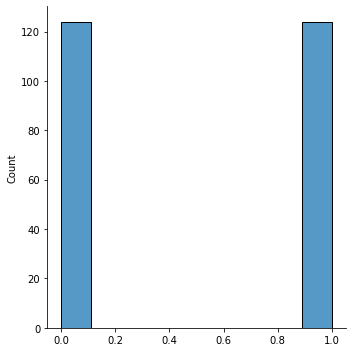

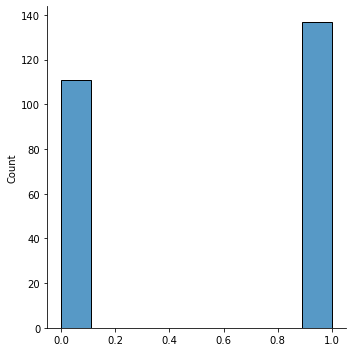

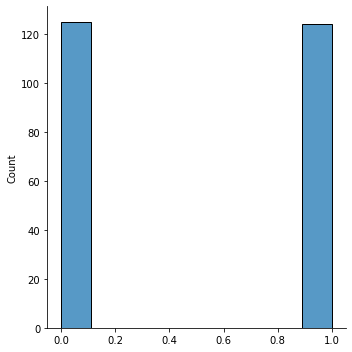

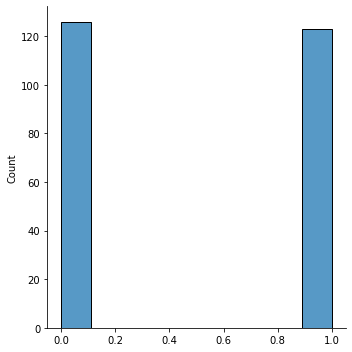

In [15]:
all_metrics_fixed = infer_cases()

../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.713-acc0.541-auc0.539.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:0
Train origin: n
Type: KLF
2022-08-28 10:20:11 - (N0) Train/Val datasets size: 170
2022-08-28 10:20:11 - (N1) Train/Val datasets size: 121
{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc06cc10>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96ccdc3eb0>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_da

Top idx of UPENN-GBM-00629_21_KLF.mat: 96
Top idx of UPENN-GBM-00095_11_KLF.mat: 94
Top idx of UPENN-GBM-00098_11_KLF.mat: 95
Top idx of UPENN-GBM-00115_11_KLF.mat: 95
Top idx of UPENN-GBM-00124_11_KLF.mat: 98
Top idx of UPENN-GBM-00128_11_KLF.mat: 74
Top idx of UPENN-GBM-00128_21_KLF.mat: 72
Top idx of UPENN-GBM-00130_21_KLF.mat: 117
Top idx of UPENN-GBM-00131_11_KLF.mat: 97
Top idx of UPENN-GBM-00135_11_KLF.mat: 97
Top idx of UPENN-GBM-00138_11_KLF.mat: 54
Top idx of UPENN-GBM-00183_21_KLF.mat: 94
Top idx of UPENN-GBM-00197_11_KLF.mat: 81
Top idx of UPENN-GBM-00197_21_KLF.mat: 93
Top idx of UPENN-GBM-00240_11_KLF.mat: 122
Top idx of UPENN-GBM-00260_11_KLF.mat: 58
Top idx of UPENN-GBM-00263_11_KLF.mat: 124
Top idx of UPENN-GBM-00264_11_KLF.mat: 97
Top idx of UPENN-GBM-00269_11_KLF.mat: 64
Top idx of UPENN-GBM-00287_11_KLF.mat: 96
Top idx of UPENN-GBM-00302_11_KLF.mat: 134
Top idx of UPENN-GBM-00310_11_KLF.mat: 65
Top idx of UPENN-GBM-00344_11_KLF.mat: 62
Top idx of UPENN-GBM-00344_21_

Top idx of UPENN-GBM-00144_11_KLF.mat: 60
Top idx of UPENN-GBM-00145_11_KLF.mat: 75
Top idx of UPENN-GBM-00146_11_KLF.mat: 95
Top idx of UPENN-GBM-00147_11_KLF.mat: 95
Top idx of UPENN-GBM-00148_11_KLF.mat: 58
Top idx of UPENN-GBM-00148_21_KLF.mat: 53
Top idx of UPENN-GBM-00149_11_KLF.mat: 94
Top idx of UPENN-GBM-00150_11_KLF.mat: 93
Top idx of UPENN-GBM-00150_21_KLF.mat: 103
Top idx of UPENN-GBM-00151_11_KLF.mat: 137
Top idx of UPENN-GBM-00244_11_KLF.mat: 94
Top idx of UPENN-GBM-00246_11_KLF.mat: 99
Top idx of UPENN-GBM-00262_11_KLF.mat: 53
Top idx of UPENN-GBM-00267_11_KLF.mat: 62
Top idx of UPENN-GBM-00267_21_KLF.mat: 96
Top idx of UPENN-GBM-00282_11_KLF.mat: 94
Top idx of UPENN-GBM-00290_11_KLF.mat: 94
Top idx of UPENN-GBM-00294_11_KLF.mat: 95
Top idx of UPENN-GBM-00301_11_KLF.mat: 93
Top idx of UPENN-GBM-00304_11_KLF.mat: 95
Top idx of UPENN-GBM-00312_11_KLF.mat: 94
Top idx of UPENN-GBM-00312_21_KLF.mat: 94
Top idx of UPENN-GBM-00314_21_KLF.mat: 114
Top idx of UPENN-GBM-00316_11_K

Top idx of UPENN-GBM-00424_11_KLF.mat: 95
Top idx of UPENN-GBM-00425_11_KLF.mat: 95
Top idx of UPENN-GBM-00430_11_KLF.mat: 62
Top idx of UPENN-GBM-00438_11_KLF.mat: 93
Top idx of UPENN-GBM-00439_11_KLF.mat: 95
Top idx of UPENN-GBM-00442_11_KLF.mat: 97
Top idx of UPENN-GBM-00443_11_KLF.mat: 59
Top idx of UPENN-GBM-00444_11_KLF.mat: 85
Top idx of UPENN-GBM-00445_11_KLF.mat: 98
Top idx of UPENN-GBM-00446_11_KLF.mat: 67
Top idx of UPENN-GBM-00453_11_KLF.mat: 99
Top idx of UPENN-GBM-00455_11_KLF.mat: 97
Top idx of UPENN-GBM-00461_11_KLF.mat: 99
Top idx of UPENN-GBM-00469_11_KLF.mat: 74
Top idx of UPENN-GBM-00474_11_KLF.mat: 59
Top idx of UPENN-GBM-00481_11_KLF.mat: 94
Top idx of UPENN-GBM-00488_11_KLF.mat: 138
Top idx of UPENN-GBM-00494_11_KLF.mat: 93
Top idx of UPENN-GBM-00496_11_KLF.mat: 99
Top idx of UPENN-GBM-00498_11_KLF.mat: 94
Top idx of UPENN-GBM-00504_11_KLF.mat: 98
Top idx of UPENN-GBM-00506_11_KLF.mat: 72
Top idx of UPENN-GBM-00509_11_KLF.mat: 71
Top idx of UPENN-GBM-00512_11_KLF

{'KLF': {'m_dataloaders': None, 'n_dataloaders': [<torch.utils.data.dataloader.DataLoader object at 0x7f96ccb43ee0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96ccccf0a0>, <torch.utils.data.dataloader.DataLoader object at 0x7f96cc8c81f0>], 'mn_dataloaders': None}}
2022-08-28 10:21:32 - Using CUDA...
KLF

PREDICTIONS:
fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17
2022-08-28 10:21:32 - Predict: ../RSNA-BTC-Datasets/out_models/fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_13-59-17/RSNAClassifierSingle3D-DW-SO-KLF-mn-e3-loss0.713-acc0.541-auc0.539.pth 340
Top idx of UPENN-GBM-00414_11_KLF.mat: 128
Top idx of UPENN-GBM-00623_21_KLF.mat: 81
Top idx of UPENN-GBM-00197_11_KLF.mat: 81
Top idx of UPENN-GBM-00519_11_KLF.mat: 84
Top idx of UPENN-GBM-00607_11_KLF.mat: 121
Top idx of UPENN-GBM-00420_11_KLF.mat: 95
Top idx of UPENN-GBM-00539_11_KLF.mat: 96
Top idx of UPENN-GBM-00183_21_KLF.mat: 94
Top idx of UPENN-GBM-00523_11_KLF.mat: 1301/86
Top idx of UPENN-GBM-00531_11_KL

../RSNA-BTC-Datasets/out_models/fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug22_14-52-37/RSNAClassifierSingle3D-DW-SO-KLF-mn-e1-loss0.689-acc0.529-auc0.559.pth
{'ext': 'mat', 'dims': 3, 'batch_size': 4, 'mri_types': ['KLF'], 'is_depth_wise': 'True', 'is_transformed': 'False', 'output_size': 1, 'is_multistep': 'True', 'lr': 0.0001, 'is_adam': 'True', 'momentum': 0.9, 'is_10_fold': 'False', 'val_total_ratio': 0.2, 'is_internal_dataset': 'True', 'train_origin': 'mn', 'val_origin': 'mn', 'net': 'RSNAClassifierSingle3D'}
-- FOLD N:1
Train origin: n
Type: KLF
2022-08-28 10:22:01 - (N0) Train/Val datasets size: 170
2022-08-28 10:22:01 - (N1) Train/Val datasets size: 121


/tmp/ipykernel_3603821/2726125353.py:120: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics = metrics.append(pd_metrics, ignore_index=True)


{'KLF': {'m_dataset_0': None, 'm_dataset_1': None, 'f_dataset_0': None, 'f_dataset_1': None, 'h_dataset_0': None, 'n_dataset_0': <utils.dataset_utils.Dataset object at 0x7f96dc10aee0>, 'n_dataset_1': <utils.dataset_utils.Dataset object at 0x7f96dc10af10>, 'mn_dataset_0': None, 'mn_dataset_1': None, 'fn_dataset_0': None, 'fn_dataset_1': None}}
Type: KLF
Length of concatenated dataset: 340
Length of concatenated dataset: 340
Top idx of UPENN-GBM-00022_11_KLF.mat: 114
Top idx of UPENN-GBM-00034_11_KLF.mat: 78
Top idx of UPENN-GBM-00088_11_KLF.mat: 128
Top idx of UPENN-GBM-00091_11_KLF.mat: 95
Top idx of UPENN-GBM-00092_11_KLF.mat: 96
Top idx of UPENN-GBM-00093_11_KLF.mat: 91
Top idx of UPENN-GBM-00093_21_KLF.mat: 133
Top idx of UPENN-GBM-00094_11_KLF.mat: 67
Top idx of UPENN-GBM-00117_11_KLF.mat: 55
Top idx of UPENN-GBM-00120_11_KLF.mat: 56
Top idx of UPENN-GBM-00121_11_KLF.mat: 95
Top idx of UPENN-GBM-00122_11_KLF.mat: 97
Top idx of UPENN-GBM-00122_21_KLF.mat: 95
Top idx of UPENN-GBM-001

KeyboardInterrupt: 

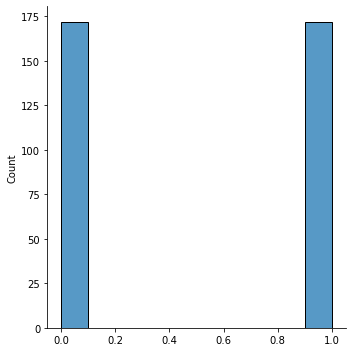

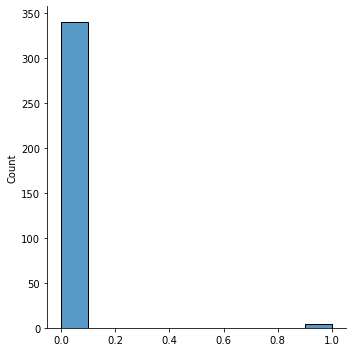

In [24]:
met = infer_cases(["A_B"])

In [16]:
all_metrics_fixed["A"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.541266  0.537815   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.551500  0.529412   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.571186  0.596639   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.562934  0.550000   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.504708  0.540984   
5                                              all_A  0.553809  0.550918   

       spec      sens      prec  
0  0.672414  0.409836  0.568182  
1  0.298246  0.741935  0.534884  
2  0.627119  0.566667  0.607143  
3  0.457627  0.639344  0.549296  
4  0.460317  0.627119  0.521127  
5  0.503378  0.597360  0.551829

In [17]:
all_metrics_fixed["A_B"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.547184  0.504348   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.527960  0.512821   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.481028  0.457143   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.493431  0.489971   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.460238  0.485549   
5                                            all_A_B  0.487827  0.489948   

       spec      sens      prec  
0  0.994186  0.017341  0.750000  
1  0.150289  0.865169  0.511628  
2  0.392045  0.522989  0.459596  
3  0.615819  0.360465  0.476923  
4  0.741379  0.226744  0.464286  
5  0.577982  0.401611  0.486750

In [18]:
all_metrics_fixed["B"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.636438  0.671429   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.751648  0.621622   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.610299  0.527027   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.572201  0.555556   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.520609  0.507463   
5                                              all_B  0.605898  0.577031   

       spec      sens      prec  
0  0.666667  0.676471  0.657143  
1  0.771429  0.487179  0.703704  
2  0.648649  0.405405  0.535714  
3  0.783784  0.314286  0.578947  
4  0.527778  0.483871  0.468750  
5  0.679558  0.471591  0.588652

In [19]:
all_metrics_fixed["B_A"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.508033  0.498350   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.526011  0.506601   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.492806  0.485149   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.494031  0.493399   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-n_Aug19...  0.503464  0.518152   
5                                            all_B_A  0.503221  0.500330   

       spec      sens      prec  
0  0.792079  0.204620  0.496000  
1  0.666667  0.346535  0.509709  
2  0.518152  0.452145  0.484099  
3  0.646865  0.339934  0.490476  
4  0.531353  0.504950  0.518644  
5  0.631023  0.369637  0.500447

In [20]:
all_metrics_fixed["AB"]

model       AUC       acc  \
0  fold0_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.550758  0.532258   
1  fold1_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.609522  0.570866   
2  fold2_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.618614  0.603175   
3  fold3_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.492326  0.471774   
4  fold4_RSNAClassifierSingle3D-DW-SO-KLF-mn_Aug2...  0.560935  0.578313   
5                                             all_AB  0.578074  0.551559   

       spec      sens      prec  
0  0.574803  0.487603  0.522124  
1  0.564516  0.576923  0.581395  
2  0.656000  0.551181  0.619469  
3  0.419355  0.524194  0.474453  
4  0.584000  0.572581  0.577236  
5  0.560000  0.543131  0.552846